<a href="https://colab.research.google.com/github/MeriemTerki/-Image-Caption-Generation/blob/main/Image_Caption_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective:
- Caption generation is a challenging AI problem where the objective is to generate a textual description given an image. It is widely used to help visually impaired people understand the content of images better using In the Flickr8k dataset in which  each collected image is associated with five different captions that describe the entities and events depicted during the capturing of the image.


## Steps involved :-
- Loading the image-caption mappings.
- Text cleaning - Removal of single-lettered words, removal of punctuations, removal of numbers/digits.
- Text processing - Creation of corpus and vocabulary, addition of '<startseq>' and '<endseq>' tags to each of the captions.
- Splitting data into train-validation-test sets.
- Image Processing and Feature Extraction using Transfer Learning via InceptionV3 model
- Creation of data generator to attach image features and texts together to be fed into the RNN Model
- Creation of RNN Model
- Training the RNN Model
- Generating caption using two methods - greedy search and beam search
- Comparing Bleu Scores with beam width varying from 1 to 3.
- Generating captions for images in the test set.

## 1. IMPORTING LIBRARIES AND MODULES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, warnings, random, string
from pickle import dump, load
from tqdm import tqdm
warnings.filterwarnings("ignore")


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence  import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

In [ ]:
from nltk import FreqDist
from nltk.translate.bleu_score import sentence_bleu


In [ ]:

!unzip /content/captions.txt.zip > /dev/null
!rm *.zip > /dev/null

In [ ]:
!apt-get install aria2 > /dev/null

In [ ]:
!aria2c -x 16 -s 16 https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip > /dev/null 
!aria2c -x 16 -s 16 https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip > /dev/null

In [ ]:
!unzip /content/Flickr8k_Dataset.zip > /dev/null
!unzip /content/Flickr8k_text.zip > /dev/null
!rm *.zip > /dev/null

## 2. EXPLORATORY DATA ANALYSIS

In [ ]:
def load_captions_dictionary(path):
    file = open(path, 'r')
    captions = file.read().split('\n')
    descriptions = {}
    for text in captions[1:]:
        values = text.split(',')
        img, caption = values[0].split('.')[0], "".join(values[1:])
        if img not in descriptions:
            descriptions[img] = [caption]
        else:
            descriptions[img].append(caption)
    file.close()
    return descriptions

descriptions = load_captions_dictionary('/content/captions.txt')

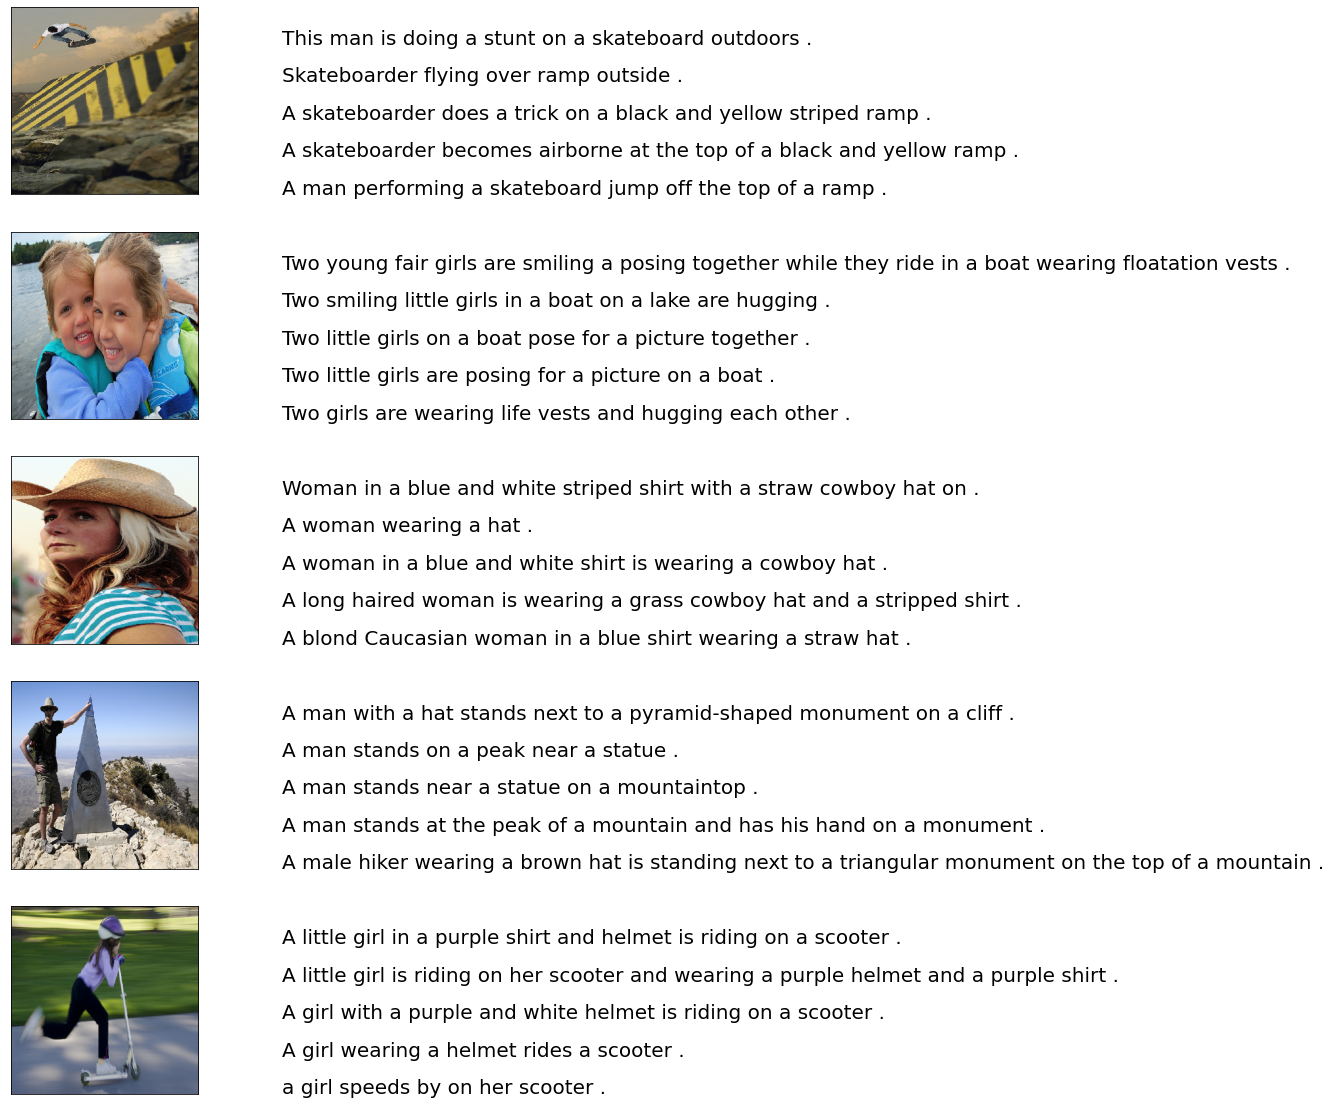

In [ ]:
npic = 5
img_size = 299
target_size = (img_size, img_size)
path = '/content/Flicker8k_Dataset/'
fig = plt.figure(figsize=(10,20))

count = 1
for img in os.listdir(path)[:npic]:
    
    filename = path + img
    captions = list(descriptions[img.split(".")[0]])
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()

## 3. TEXT PROCESSING AND ANALYSIS

In [ ]:
def text_cleaning(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, caption in descriptions.items():
        for i, img_text in enumerate(caption):
            img_text.replace("-", " ")
            text = [word.lower() for word in img_text.split()]
            text = [word.translate(table) for word in text]
            text = [word for word in text if(len(word) > 1)]
            text = [word for word in text if(word.isalpha())]
            img_text = " ".join(text)
            descriptions[img][i] = img_text
    return descriptions

descriptions = text_cleaning(descriptions)

In [ ]:
def corpus_and_vocab(descriptions):
    corpus = ""
    for img_text in descriptions.values():
        for text in img_text:
            corpus += " "+text
    vocab = set(corpus.split())
    return corpus, vocab

corpus, vocab = corpus_and_vocab(descriptions)
print("Number of unique words = {}".format(len(vocab)))

Number of unique words = 8763


In [ ]:
freq_dist = FreqDist(corpus.split())
dfsub = pd.DataFrame(columns = ["word", "count"])
most_common = freq_dist.most_common()
words, counts = [], []
for i in range(len(freq_dist)):
    words.append(most_common[i][0])
    counts.append(most_common[i][1])
dfsub["word"], dfsub["count"] = words, counts

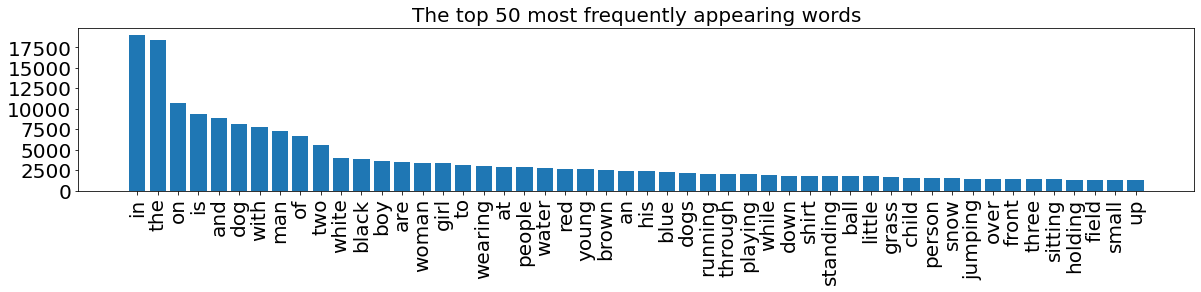

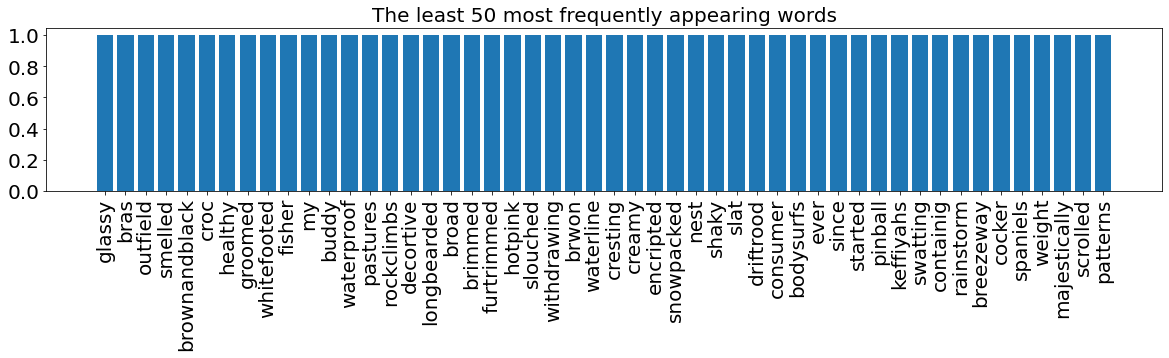

In [ ]:
def plthist(dfsub, title):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
plthist(dfsub.iloc[:50], "The top 50 most frequently appearing words")
plthist(dfsub.iloc[-50:], "The least 50 most frequently appearing words")

In [ ]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for i, desc in enumerate(desc_list):
            descriptions[key][i] = desc = "<startseq> " + desc + " <endseq>"
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    
save_descriptions(descriptions, "Image_Descriptions_List.txt")

##4. TRAIN-VAL-TEST SPLIT
##### - Test set - First 10 images and captions
##### - Validation set - Next 5 images and captions
##### - Training set - The remaining images and captions

In [ ]:
df_img_caption = pd.DataFrame()
df_img_caption['Image_Name'] = list(descriptions.keys())[:-1]
temps = list(descriptions.values())[:-1]
df_img_caption['Caption'] = [temps[i][random.randint(0,4)] for i in range(len(temps))]
df_img_caption.head()

Image_Name                                            Caption
0  1000268201_693b08cb0e  <startseq> little girl in pink dress going int...
1  1001773457_577c3a7d70  <startseq> black dog and tricolored dog playin...
2  1002674143_1b742ab4b8  <startseq> there is girl with pigtails sitting...
3  1003163366_44323f5815  <startseq> man laying on bench holding leash o...
4  1007129816_e794419615  <startseq> the man with pierced ears is wearin...

In [ ]:
test_images = np.asarray(df_img_caption['Image_Name'][:10], dtype = np.dtype(object))
test_captions = np.asarray(df_img_caption['Caption'][:10], dtype = np.dtype(object))
val_images = np.asarray(df_img_caption['Image_Name'][10:15], dtype = np.dtype(object))
val_captions = np.asarray(df_img_caption['Caption'][10:15], dtype = np.dtype(object))
train_images = np.asarray(df_img_caption['Image_Name'][15:], dtype = np.dtype(object))
train_captions = np.asarray(df_img_caption['Caption'][15:], dtype = np.dtype(object))

## 5. FEATURE EXTRACTION

In [ ]:
cnn_model = InceptionV3(weights = 'imagenet')
for layer in cnn_model.layers:
    layer.trainable = False
cnn_model = Model(inputs = cnn_model.input, outputs = cnn_model.get_layer('avg_pool').output)
cnn_model.summary()

96112376/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
def extract_features(model, images, img_size):
    features = {}
    for img in tqdm(images):
        picture = load_img('/content/Flicker8k_Dataset/' + img + ".jpg", target_size = (img_size, img_size))
        picture = img_to_array(picture)
        picture = np.expand_dims(picture, axis = 0)
        picture = preprocess_input(picture)
        features[img] = model.predict(picture).reshape(2048,)
    
    return features

In [ ]:
Xtrain_features = extract_features(cnn_model, train_images, 299)

  0%|          | 0/8076 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  0%|          | 1/8076 [00:04<10:38:08,  4.74s/it]

1/1 [==============================] - 0s 260ms/step


  0%|          | 2/8076 [00:05<4:52:03,  2.17s/it] 

1/1 [==============================] - 0s 276ms/step


  0%|          | 3/8076 [00:05<2:58:54,  1.33s/it]

1/1 [==============================] - 0s 262ms/step


  0%|          | 4/8076 [00:05<2:07:51,  1.05it/s]

1/1 [==============================] - 0s 255ms/step


  0%|          | 5/8076 [00:06<1:39:15,  1.36it/s]

1/1 [==============================] - 0s 266ms/step


  0%|          | 6/8076 [00:06<1:20:35,  1.67it/s]

1/1 [==============================] - 0s 260ms/step


  0%|          | 7/8076 [00:06<1:10:15,  1.91it/s]

1/1 [==============================] - 0s 267ms/step


  0%|          | 8/8076 [00:07<1:03:47,  2.11it/s]

1/1 [==============================] - 0s 253ms/step


  0%|          | 9/8076 [00:07<59:34,  2.26it/s]  

1/1 [==============================] - 0s 259ms/step


  0%|          | 10/8076 [00:07<54:17,  2.48it/s]

1/1 [==============================] - 0s 250ms/step


  0%|          | 11/8076 [00:08<50:28,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


  0%|          | 12/8076 [00:08<50:35,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


  0%|          | 13/8076 [00:08<47:46,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


  0%|          | 14/8076 [00:09<46:02,  2.92it/s]

1/1 [==============================] - 0s 271ms/step


  0%|          | 15/8076 [00:09<47:34,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


  0%|          | 16/8076 [00:09<48:15,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  0%|          | 17/8076 [00:10<48:31,  2.77it/s]

1/1 [==============================] - 0s 255ms/step


  0%|          | 18/8076 [00:10<46:41,  2.88it/s]

1/1 [==============================] - 0s 272ms/step


  0%|          | 19/8076 [00:11<47:44,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


  0%|          | 20/8076 [00:11<48:40,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  0%|          | 21/8076 [00:11<48:51,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


  0%|          | 22/8076 [00:12<48:52,  2.75it/s]

1/1 [==============================] - 0s 276ms/step


  0%|          | 23/8076 [00:12<48:55,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


  0%|          | 24/8076 [00:12<47:00,  2.85it/s]

1/1 [==============================] - 0s 266ms/step


  0%|          | 25/8076 [00:13<47:36,  2.82it/s]

1/1 [==============================] - 0s 271ms/step


  0%|          | 26/8076 [00:13<48:13,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  0%|          | 27/8076 [00:13<49:14,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


  0%|          | 28/8076 [00:14<47:10,  2.84it/s]

1/1 [==============================] - 0s 270ms/step


  0%|          | 29/8076 [00:14<46:18,  2.90it/s]

1/1 [==============================] - 0s 262ms/step


  0%|          | 30/8076 [00:14<47:28,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


  0%|          | 31/8076 [00:15<48:10,  2.78it/s]

1/1 [==============================] - 0s 276ms/step


  0%|          | 32/8076 [00:15<46:52,  2.86it/s]

1/1 [==============================] - 0s 256ms/step


  0%|          | 33/8076 [00:15<45:25,  2.95it/s]

1/1 [==============================] - 0s 262ms/step


  0%|          | 34/8076 [00:16<46:27,  2.89it/s]

1/1 [==============================] - 0s 280ms/step


  0%|          | 35/8076 [00:16<47:20,  2.83it/s]

1/1 [==============================] - 0s 266ms/step


  0%|          | 36/8076 [00:17<46:20,  2.89it/s]

1/1 [==============================] - 0s 261ms/step


  0%|          | 37/8076 [00:17<47:35,  2.82it/s]

1/1 [==============================] - 0s 279ms/step


  0%|          | 38/8076 [00:17<48:15,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


  0%|          | 39/8076 [00:18<48:27,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


  0%|          | 40/8076 [00:18<48:54,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 41/8076 [00:18<49:00,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 42/8076 [00:19<47:09,  2.84it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 43/8076 [00:19<45:54,  2.92it/s]

1/1 [==============================] - 0s 254ms/step


  1%|          | 44/8076 [00:19<44:39,  3.00it/s]

1/1 [==============================] - 0s 260ms/step


  1%|          | 45/8076 [00:20<45:56,  2.91it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 46/8076 [00:20<47:04,  2.84it/s]

1/1 [==============================] - 0s 266ms/step


  1%|          | 47/8076 [00:20<47:58,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


  1%|          | 48/8076 [00:21<46:27,  2.88it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 49/8076 [00:21<47:13,  2.83it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 50/8076 [00:22<48:03,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


  1%|          | 51/8076 [00:22<48:21,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


  1%|          | 52/8076 [00:22<48:32,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 53/8076 [00:23<46:44,  2.86it/s]

1/1 [==============================] - 0s 254ms/step


  1%|          | 54/8076 [00:23<47:27,  2.82it/s]

1/1 [==============================] - 0s 269ms/step


  1%|          | 55/8076 [00:23<46:13,  2.89it/s]

1/1 [==============================] - 0s 260ms/step


  1%|          | 56/8076 [00:24<47:24,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


  1%|          | 57/8076 [00:24<48:05,  2.78it/s]

1/1 [==============================] - 0s 304ms/step


  1%|          | 58/8076 [00:24<48:50,  2.74it/s]

1/1 [==============================] - 0s 274ms/step


  1%|          | 59/8076 [00:25<47:26,  2.82it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 60/8076 [00:25<48:04,  2.78it/s]

1/1 [==============================] - 0s 272ms/step


  1%|          | 61/8076 [00:25<48:37,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


  1%|          | 62/8076 [00:26<48:58,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 63/8076 [00:26<47:27,  2.81it/s]

1/1 [==============================] - 0s 275ms/step


  1%|          | 64/8076 [00:27<47:12,  2.83it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 65/8076 [00:27<47:58,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


  1%|          | 66/8076 [00:27<48:39,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 67/8076 [00:28<46:44,  2.86it/s]

1/1 [==============================] - 0s 266ms/step


  1%|          | 68/8076 [00:28<46:05,  2.90it/s]

1/1 [==============================] - 0s 271ms/step


  1%|          | 69/8076 [00:28<47:21,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 70/8076 [00:29<46:16,  2.88it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 71/8076 [00:29<47:26,  2.81it/s]

1/1 [==============================] - 0s 271ms/step


  1%|          | 72/8076 [00:29<46:28,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


  1%|          | 73/8076 [00:30<45:18,  2.94it/s]

1/1 [==============================] - 0s 253ms/step


  1%|          | 74/8076 [00:30<44:21,  3.01it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 75/8076 [00:30<43:38,  3.06it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 76/8076 [00:31<43:44,  3.05it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 77/8076 [00:31<45:34,  2.93it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 78/8076 [00:31<47:44,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 79/8076 [00:32<48:04,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 80/8076 [00:32<48:25,  2.75it/s]

1/1 [==============================] - 0s 282ms/step


  1%|          | 81/8076 [00:32<47:38,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


  1%|          | 82/8076 [00:33<48:18,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


  1%|          | 83/8076 [00:33<48:36,  2.74it/s]

1/1 [==============================] - 0s 277ms/step


  1%|          | 84/8076 [00:34<47:33,  2.80it/s]

1/1 [==============================] - 0s 266ms/step


  1%|          | 85/8076 [00:34<48:07,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 86/8076 [00:34<48:21,  2.75it/s]

1/1 [==============================] - 0s 289ms/step


  1%|          | 87/8076 [00:35<47:33,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


  1%|          | 88/8076 [00:35<48:22,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


  1%|          | 89/8076 [00:35<49:14,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


  1%|          | 90/8076 [00:36<49:37,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


  1%|          | 91/8076 [00:36<47:34,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 92/8076 [00:36<45:51,  2.90it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 93/8076 [00:37<45:12,  2.94it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 94/8076 [00:37<46:37,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


  1%|          | 95/8076 [00:37<45:48,  2.90it/s]

1/1 [==============================] - 0s 252ms/step


  1%|          | 96/8076 [00:38<47:14,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


  1%|          | 97/8076 [00:38<46:00,  2.89it/s]

1/1 [==============================] - 0s 279ms/step


  1%|          | 98/8076 [00:39<47:04,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


  1%|          | 99/8076 [00:39<48:05,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


  1%|          | 100/8076 [00:39<46:47,  2.84it/s]

1/1 [==============================] - 0s 275ms/step


  1%|▏         | 101/8076 [00:40<46:12,  2.88it/s]

1/1 [==============================] - 0s 265ms/step


  1%|▏         | 102/8076 [00:40<45:07,  2.95it/s]

1/1 [==============================] - 0s 262ms/step


  1%|▏         | 103/8076 [00:40<46:22,  2.87it/s]

1/1 [==============================] - 0s 281ms/step


  1%|▏         | 104/8076 [00:41<46:49,  2.84it/s]

1/1 [==============================] - 0s 268ms/step


  1%|▏         | 105/8076 [00:41<45:59,  2.89it/s]

1/1 [==============================] - 0s 282ms/step


  1%|▏         | 106/8076 [00:41<47:18,  2.81it/s]

1/1 [==============================] - 0s 277ms/step


  1%|▏         | 107/8076 [00:42<46:43,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


  1%|▏         | 108/8076 [00:42<47:24,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


  1%|▏         | 109/8076 [00:42<48:23,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


  1%|▏         | 110/8076 [00:43<48:36,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


  1%|▏         | 111/8076 [00:43<47:14,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


  1%|▏         | 112/8076 [00:44<47:37,  2.79it/s]

1/1 [==============================] - 0s 272ms/step


  1%|▏         | 113/8076 [00:44<48:06,  2.76it/s]

1/1 [==============================] - 0s 272ms/step


  1%|▏         | 114/8076 [00:44<48:12,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


  1%|▏         | 115/8076 [00:45<47:00,  2.82it/s]

1/1 [==============================] - 0s 290ms/step


  1%|▏         | 116/8076 [00:45<46:34,  2.85it/s]

1/1 [==============================] - 0s 265ms/step


  1%|▏         | 117/8076 [00:45<48:04,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


  1%|▏         | 118/8076 [00:46<48:15,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


  1%|▏         | 119/8076 [00:46<48:56,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


  1%|▏         | 120/8076 [00:46<49:11,  2.70it/s]

1/1 [==============================] - 0s 288ms/step


  1%|▏         | 121/8076 [00:47<49:37,  2.67it/s]

1/1 [==============================] - 0s 274ms/step


  2%|▏         | 122/8076 [00:47<48:00,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 123/8076 [00:47<46:30,  2.85it/s]

1/1 [==============================] - 0s 285ms/step


  2%|▏         | 124/8076 [00:48<46:26,  2.85it/s]

1/1 [==============================] - 0s 265ms/step


  2%|▏         | 125/8076 [00:48<47:13,  2.81it/s]

1/1 [==============================] - 0s 464ms/step


  2%|▏         | 126/8076 [00:49<1:01:57,  2.14it/s]

1/1 [==============================] - 1s 524ms/step


  2%|▏         | 127/8076 [00:50<1:07:51,  1.95it/s]

1/1 [==============================] - 1s 523ms/step


  2%|▏         | 128/8076 [00:50<1:11:38,  1.85it/s]

1/1 [==============================] - 0s 488ms/step


  2%|▏         | 129/8076 [00:51<1:18:39,  1.68it/s]

1/1 [==============================] - 0s 262ms/step


  2%|▏         | 130/8076 [00:51<1:10:17,  1.88it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 131/8076 [00:52<1:04:20,  2.06it/s]

1/1 [==============================] - 0s 271ms/step


  2%|▏         | 132/8076 [00:52<59:32,  2.22it/s]  

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 133/8076 [00:52<54:39,  2.42it/s]

1/1 [==============================] - 0s 258ms/step


  2%|▏         | 134/8076 [00:53<50:40,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


  2%|▏         | 135/8076 [00:53<48:22,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 136/8076 [00:53<48:57,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


  2%|▏         | 137/8076 [00:54<48:50,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


  2%|▏         | 138/8076 [00:54<48:41,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


  2%|▏         | 139/8076 [00:54<48:47,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


  2%|▏         | 140/8076 [00:55<48:05,  2.75it/s]

1/1 [==============================] - 0s 277ms/step


  2%|▏         | 141/8076 [00:55<48:23,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


  2%|▏         | 142/8076 [00:55<47:23,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


  2%|▏         | 143/8076 [00:56<45:59,  2.88it/s]

1/1 [==============================] - 0s 271ms/step


  2%|▏         | 144/8076 [00:56<46:53,  2.82it/s]

1/1 [==============================] - 0s 268ms/step


  2%|▏         | 145/8076 [00:57<48:07,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 146/8076 [00:57<49:23,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 147/8076 [00:57<50:30,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 148/8076 [00:58<49:45,  2.66it/s]

1/1 [==============================] - 0s 272ms/step


  2%|▏         | 149/8076 [00:58<49:34,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


  2%|▏         | 150/8076 [00:58<48:14,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


  2%|▏         | 151/8076 [00:59<46:32,  2.84it/s]

1/1 [==============================] - 0s 271ms/step


  2%|▏         | 152/8076 [00:59<45:37,  2.89it/s]

1/1 [==============================] - 0s 268ms/step


  2%|▏         | 153/8076 [00:59<47:14,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 154/8076 [01:00<47:47,  2.76it/s]

1/1 [==============================] - 0s 280ms/step


  2%|▏         | 155/8076 [01:00<48:10,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 156/8076 [01:01<48:22,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


  2%|▏         | 157/8076 [01:01<46:47,  2.82it/s]

1/1 [==============================] - 0s 283ms/step


  2%|▏         | 158/8076 [01:01<47:20,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


  2%|▏         | 159/8076 [01:02<47:50,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


  2%|▏         | 160/8076 [01:02<46:03,  2.86it/s]

1/1 [==============================] - 0s 278ms/step


  2%|▏         | 161/8076 [01:02<45:47,  2.88it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 162/8076 [01:03<44:35,  2.96it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 163/8076 [01:03<45:54,  2.87it/s]

1/1 [==============================] - 0s 286ms/step


  2%|▏         | 164/8076 [01:03<46:50,  2.82it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 165/8076 [01:04<45:28,  2.90it/s]

1/1 [==============================] - 0s 265ms/step


  2%|▏         | 166/8076 [01:04<44:35,  2.96it/s]

1/1 [==============================] - 0s 280ms/step


  2%|▏         | 167/8076 [01:04<44:47,  2.94it/s]

1/1 [==============================] - 0s 270ms/step


  2%|▏         | 168/8076 [01:05<46:06,  2.86it/s]

1/1 [==============================] - 0s 272ms/step


  2%|▏         | 169/8076 [01:05<47:06,  2.80it/s]

1/1 [==============================] - 0s 295ms/step


  2%|▏         | 170/8076 [01:05<47:04,  2.80it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 171/8076 [01:06<46:10,  2.85it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 172/8076 [01:06<44:59,  2.93it/s]

1/1 [==============================] - 0s 280ms/step


  2%|▏         | 173/8076 [01:07<46:25,  2.84it/s]

1/1 [==============================] - 0s 276ms/step


  2%|▏         | 174/8076 [01:07<47:14,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


  2%|▏         | 175/8076 [01:07<48:07,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 176/8076 [01:08<48:38,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 177/8076 [01:08<48:46,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


  2%|▏         | 178/8076 [01:08<48:46,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


  2%|▏         | 179/8076 [01:09<46:46,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 180/8076 [01:09<45:46,  2.87it/s]

1/1 [==============================] - 0s 279ms/step


  2%|▏         | 181/8076 [01:09<47:39,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 182/8076 [01:10<46:09,  2.85it/s]

1/1 [==============================] - 0s 267ms/step


  2%|▏         | 183/8076 [01:10<45:44,  2.88it/s]

1/1 [==============================] - 0s 286ms/step


  2%|▏         | 184/8076 [01:10<45:34,  2.89it/s]

1/1 [==============================] - 0s 283ms/step


  2%|▏         | 185/8076 [01:11<45:44,  2.88it/s]

1/1 [==============================] - 0s 278ms/step


  2%|▏         | 186/8076 [01:11<45:35,  2.88it/s]

1/1 [==============================] - 0s 280ms/step


  2%|▏         | 187/8076 [01:12<46:48,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


  2%|▏         | 188/8076 [01:12<47:29,  2.77it/s]

1/1 [==============================] - 0s 275ms/step


  2%|▏         | 189/8076 [01:12<46:45,  2.81it/s]

1/1 [==============================] - 0s 286ms/step


  2%|▏         | 190/8076 [01:13<47:30,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


  2%|▏         | 191/8076 [01:13<45:55,  2.86it/s]

1/1 [==============================] - 0s 275ms/step


  2%|▏         | 192/8076 [01:13<46:26,  2.83it/s]

1/1 [==============================] - 0s 284ms/step


  2%|▏         | 193/8076 [01:14<46:02,  2.85it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 194/8076 [01:14<46:50,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


  2%|▏         | 195/8076 [01:14<45:33,  2.88it/s]

1/1 [==============================] - 0s 279ms/step


  2%|▏         | 196/8076 [01:15<45:25,  2.89it/s]

1/1 [==============================] - 0s 256ms/step


  2%|▏         | 197/8076 [01:15<44:27,  2.95it/s]

1/1 [==============================] - 0s 271ms/step


  2%|▏         | 198/8076 [01:15<44:12,  2.97it/s]

1/1 [==============================] - 0s 276ms/step


  2%|▏         | 199/8076 [01:16<45:32,  2.88it/s]

1/1 [==============================] - 0s 262ms/step


  2%|▏         | 200/8076 [01:16<44:39,  2.94it/s]

1/1 [==============================] - 0s 271ms/step


  2%|▏         | 201/8076 [01:16<45:58,  2.86it/s]

1/1 [==============================] - 0s 279ms/step


  3%|▎         | 202/8076 [01:17<47:06,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


  3%|▎         | 203/8076 [01:17<47:50,  2.74it/s]

1/1 [==============================] - 0s 305ms/step


  3%|▎         | 204/8076 [01:18<47:53,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


  3%|▎         | 205/8076 [01:18<48:52,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


  3%|▎         | 206/8076 [01:18<48:48,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


  3%|▎         | 207/8076 [01:19<47:26,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  3%|▎         | 208/8076 [01:19<46:00,  2.85it/s]

1/1 [==============================] - 0s 271ms/step


  3%|▎         | 209/8076 [01:19<46:59,  2.79it/s]

1/1 [==============================] - 0s 279ms/step


  3%|▎         | 210/8076 [01:20<46:28,  2.82it/s]

1/1 [==============================] - 0s 272ms/step


  3%|▎         | 211/8076 [01:20<45:30,  2.88it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 212/8076 [01:20<46:51,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


  3%|▎         | 213/8076 [01:21<47:18,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


  3%|▎         | 214/8076 [01:21<47:38,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


  3%|▎         | 215/8076 [01:21<47:59,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 216/8076 [01:22<47:05,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


  3%|▎         | 217/8076 [01:22<47:23,  2.76it/s]

1/1 [==============================] - 0s 285ms/step


  3%|▎         | 218/8076 [01:23<48:01,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


  3%|▎         | 219/8076 [01:23<48:20,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


  3%|▎         | 220/8076 [01:23<48:56,  2.68it/s]

1/1 [==============================] - 0s 305ms/step


  3%|▎         | 221/8076 [01:24<49:13,  2.66it/s]

1/1 [==============================] - 0s 339ms/step


  3%|▎         | 222/8076 [01:24<51:10,  2.56it/s]

1/1 [==============================] - 0s 297ms/step


  3%|▎         | 223/8076 [01:25<52:03,  2.51it/s]

1/1 [==============================] - 0s 301ms/step


  3%|▎         | 224/8076 [01:25<51:29,  2.54it/s]

1/1 [==============================] - 0s 300ms/step


  3%|▎         | 225/8076 [01:25<51:47,  2.53it/s]

1/1 [==============================] - 0s 291ms/step


  3%|▎         | 226/8076 [01:26<51:15,  2.55it/s]

1/1 [==============================] - 0s 279ms/step


  3%|▎         | 227/8076 [01:26<49:59,  2.62it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 228/8076 [01:26<50:18,  2.60it/s]

1/1 [==============================] - 0s 308ms/step


  3%|▎         | 229/8076 [01:27<50:14,  2.60it/s]

1/1 [==============================] - 0s 303ms/step


  3%|▎         | 230/8076 [01:27<49:55,  2.62it/s]

1/1 [==============================] - 0s 283ms/step


  3%|▎         | 231/8076 [01:28<50:16,  2.60it/s]

1/1 [==============================] - 0s 289ms/step


  3%|▎         | 232/8076 [01:28<49:57,  2.62it/s]

1/1 [==============================] - 0s 269ms/step


  3%|▎         | 233/8076 [01:28<49:50,  2.62it/s]

1/1 [==============================] - 0s 276ms/step


  3%|▎         | 234/8076 [01:29<51:07,  2.56it/s]

1/1 [==============================] - 0s 290ms/step


  3%|▎         | 235/8076 [01:29<49:32,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 236/8076 [01:30<49:31,  2.64it/s]

1/1 [==============================] - 0s 286ms/step


  3%|▎         | 237/8076 [01:30<49:14,  2.65it/s]

1/1 [==============================] - 0s 277ms/step


  3%|▎         | 238/8076 [01:30<49:19,  2.65it/s]

1/1 [==============================] - 0s 264ms/step


  3%|▎         | 239/8076 [01:31<47:15,  2.76it/s]

1/1 [==============================] - 0s 281ms/step


  3%|▎         | 240/8076 [01:31<47:46,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


  3%|▎         | 241/8076 [01:31<46:27,  2.81it/s]

1/1 [==============================] - 0s 260ms/step


  3%|▎         | 242/8076 [01:32<45:18,  2.88it/s]

1/1 [==============================] - 0s 281ms/step


  3%|▎         | 243/8076 [01:32<45:27,  2.87it/s]

1/1 [==============================] - 0s 271ms/step


  3%|▎         | 244/8076 [01:32<45:02,  2.90it/s]

1/1 [==============================] - 0s 263ms/step


  3%|▎         | 245/8076 [01:33<45:56,  2.84it/s]

1/1 [==============================] - 0s 277ms/step


  3%|▎         | 246/8076 [01:33<46:52,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


  3%|▎         | 247/8076 [01:33<47:22,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


  3%|▎         | 248/8076 [01:34<47:56,  2.72it/s]

1/1 [==============================] - 0s 297ms/step


  3%|▎         | 249/8076 [01:34<48:17,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


  3%|▎         | 250/8076 [01:35<48:35,  2.68it/s]

1/1 [==============================] - 0s 272ms/step


  3%|▎         | 251/8076 [01:35<47:04,  2.77it/s]

1/1 [==============================] - 0s 312ms/step


  3%|▎         | 252/8076 [01:35<48:06,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


  3%|▎         | 253/8076 [01:36<46:46,  2.79it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 254/8076 [01:36<46:27,  2.81it/s]

1/1 [==============================] - 0s 278ms/step


  3%|▎         | 255/8076 [01:36<45:56,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


  3%|▎         | 256/8076 [01:37<44:39,  2.92it/s]

1/1 [==============================] - 0s 274ms/step


  3%|▎         | 257/8076 [01:37<44:24,  2.93it/s]

1/1 [==============================] - 0s 292ms/step


  3%|▎         | 258/8076 [01:37<45:02,  2.89it/s]

1/1 [==============================] - 0s 272ms/step


  3%|▎         | 259/8076 [01:38<46:09,  2.82it/s]

1/1 [==============================] - 0s 274ms/step


  3%|▎         | 260/8076 [01:38<46:44,  2.79it/s]

1/1 [==============================] - 0s 276ms/step


  3%|▎         | 261/8076 [01:38<47:53,  2.72it/s]

1/1 [==============================] - 0s 297ms/step


  3%|▎         | 262/8076 [01:39<48:00,  2.71it/s]

1/1 [==============================] - 0s 280ms/step


  3%|▎         | 263/8076 [01:39<46:56,  2.77it/s]

1/1 [==============================] - 0s 281ms/step


  3%|▎         | 264/8076 [01:40<47:45,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


  3%|▎         | 265/8076 [01:40<47:51,  2.72it/s]

1/1 [==============================] - 0s 301ms/step


  3%|▎         | 266/8076 [01:40<48:32,  2.68it/s]

1/1 [==============================] - 0s 288ms/step


  3%|▎         | 267/8076 [01:41<48:59,  2.66it/s]

1/1 [==============================] - 0s 279ms/step


  3%|▎         | 268/8076 [01:41<47:51,  2.72it/s]

1/1 [==============================] - 0s 307ms/step


  3%|▎         | 269/8076 [01:41<48:26,  2.69it/s]

1/1 [==============================] - 0s 284ms/step


  3%|▎         | 270/8076 [01:42<49:26,  2.63it/s]

1/1 [==============================] - 0s 281ms/step


  3%|▎         | 271/8076 [01:42<48:19,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


  3%|▎         | 272/8076 [01:43<47:22,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


  3%|▎         | 273/8076 [01:43<48:04,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


  3%|▎         | 274/8076 [01:43<48:41,  2.67it/s]

1/1 [==============================] - 0s 287ms/step


  3%|▎         | 275/8076 [01:44<48:00,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


  3%|▎         | 276/8076 [01:44<47:01,  2.76it/s]

1/1 [==============================] - 0s 443ms/step


  3%|▎         | 277/8076 [01:45<59:59,  2.17it/s]

1/1 [==============================] - 1s 561ms/step


  3%|▎         | 278/8076 [01:46<1:14:45,  1.74it/s]

1/1 [==============================] - 0s 380ms/step


  3%|▎         | 279/8076 [01:46<1:11:02,  1.83it/s]

1/1 [==============================] - 0s 379ms/step


  3%|▎         | 280/8076 [01:47<1:18:06,  1.66it/s]

1/1 [==============================] - 0s 342ms/step


  3%|▎         | 281/8076 [01:47<1:22:13,  1.58it/s]

1/1 [==============================] - 0s 377ms/step


  3%|▎         | 282/8076 [01:48<1:16:34,  1.70it/s]

1/1 [==============================] - 0s 363ms/step


  4%|▎         | 283/8076 [01:49<1:23:17,  1.56it/s]

1/1 [==============================] - 0s 349ms/step


  4%|▎         | 284/8076 [01:49<1:15:28,  1.72it/s]

1/1 [==============================] - 0s 368ms/step


  4%|▎         | 285/8076 [01:50<1:22:33,  1.57it/s]

1/1 [==============================] - 0s 313ms/step


  4%|▎         | 286/8076 [01:50<1:13:04,  1.78it/s]

1/1 [==============================] - 0s 403ms/step


  4%|▎         | 287/8076 [01:51<1:09:47,  1.86it/s]

1/1 [==============================] - 0s 314ms/step


  4%|▎         | 288/8076 [01:51<1:04:28,  2.01it/s]

1/1 [==============================] - 0s 317ms/step


  4%|▎         | 289/8076 [01:52<1:01:07,  2.12it/s]

1/1 [==============================] - 0s 294ms/step


  4%|▎         | 290/8076 [01:52<57:36,  2.25it/s]  

1/1 [==============================] - 0s 364ms/step


  4%|▎         | 291/8076 [01:53<1:07:36,  1.92it/s]

1/1 [==============================] - 0s 440ms/step


  4%|▎         | 292/8076 [01:53<1:17:02,  1.68it/s]

1/1 [==============================] - 0s 465ms/step


  4%|▎         | 293/8076 [01:54<1:17:14,  1.68it/s]

1/1 [==============================] - 1s 524ms/step


  4%|▎         | 294/8076 [01:55<1:19:35,  1.63it/s]

1/1 [==============================] - 0s 498ms/step


  4%|▎         | 295/8076 [01:55<1:26:46,  1.49it/s]

1/1 [==============================] - 0s 422ms/step


  4%|▎         | 296/8076 [01:57<1:39:58,  1.30it/s]

1/1 [==============================] - 0s 334ms/step


  4%|▎         | 297/8076 [01:57<1:26:24,  1.50it/s]

1/1 [==============================] - 0s 311ms/step


  4%|▎         | 298/8076 [01:57<1:15:20,  1.72it/s]

1/1 [==============================] - 0s 282ms/step


  4%|▎         | 299/8076 [01:58<1:07:37,  1.92it/s]

1/1 [==============================] - 0s 298ms/step


  4%|▎         | 300/8076 [01:58<1:02:34,  2.07it/s]

1/1 [==============================] - 0s 281ms/step


  4%|▎         | 301/8076 [01:58<57:34,  2.25it/s]  

1/1 [==============================] - 0s 288ms/step


  4%|▎         | 302/8076 [01:59<55:35,  2.33it/s]

1/1 [==============================] - 0s 320ms/step


  4%|▍         | 303/8076 [01:59<54:51,  2.36it/s]

1/1 [==============================] - 0s 317ms/step


  4%|▍         | 304/8076 [02:00<53:47,  2.41it/s]

1/1 [==============================] - 0s 311ms/step


  4%|▍         | 305/8076 [02:00<52:47,  2.45it/s]

1/1 [==============================] - 0s 300ms/step


  4%|▍         | 306/8076 [02:00<52:13,  2.48it/s]

1/1 [==============================] - 0s 273ms/step


  4%|▍         | 307/8076 [02:01<49:55,  2.59it/s]

1/1 [==============================] - 0s 280ms/step


  4%|▍         | 308/8076 [02:01<48:55,  2.65it/s]

1/1 [==============================] - 0s 352ms/step


  4%|▍         | 309/8076 [02:02<1:01:38,  2.10it/s]

1/1 [==============================] - 0s 314ms/step


  4%|▍         | 310/8076 [02:02<57:58,  2.23it/s]  

1/1 [==============================] - 0s 293ms/step


  4%|▍         | 311/8076 [02:03<56:11,  2.30it/s]

1/1 [==============================] - 0s 279ms/step


  4%|▍         | 312/8076 [02:03<53:45,  2.41it/s]

1/1 [==============================] - 0s 272ms/step


  4%|▍         | 313/8076 [02:03<52:49,  2.45it/s]

1/1 [==============================] - 0s 277ms/step


  4%|▍         | 314/8076 [02:04<50:17,  2.57it/s]

1/1 [==============================] - 0s 285ms/step


  4%|▍         | 315/8076 [02:04<48:50,  2.65it/s]

1/1 [==============================] - 0s 281ms/step


  4%|▍         | 316/8076 [02:04<49:54,  2.59it/s]

1/1 [==============================] - 0s 273ms/step


  4%|▍         | 317/8076 [02:05<47:59,  2.69it/s]

1/1 [==============================] - 0s 288ms/step


  4%|▍         | 318/8076 [02:05<47:50,  2.70it/s]

1/1 [==============================] - 0s 287ms/step


  4%|▍         | 319/8076 [02:06<48:39,  2.66it/s]

1/1 [==============================] - 0s 277ms/step


  4%|▍         | 320/8076 [02:06<47:33,  2.72it/s]

1/1 [==============================] - 0s 282ms/step


  4%|▍         | 321/8076 [02:06<48:00,  2.69it/s]

1/1 [==============================] - 0s 273ms/step


  4%|▍         | 322/8076 [02:07<46:38,  2.77it/s]

1/1 [==============================] - 0s 294ms/step


  4%|▍         | 323/8076 [02:07<47:40,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


  4%|▍         | 324/8076 [02:07<46:54,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


  4%|▍         | 325/8076 [02:08<45:34,  2.83it/s]

1/1 [==============================] - 0s 279ms/step


  4%|▍         | 326/8076 [02:08<47:15,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


  4%|▍         | 327/8076 [02:08<48:04,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


  4%|▍         | 328/8076 [02:09<46:47,  2.76it/s]

1/1 [==============================] - 0s 273ms/step


  4%|▍         | 329/8076 [02:09<47:20,  2.73it/s]

1/1 [==============================] - 0s 286ms/step


  4%|▍         | 330/8076 [02:10<48:20,  2.67it/s]

1/1 [==============================] - 0s 270ms/step


  4%|▍         | 331/8076 [02:10<48:14,  2.68it/s]

1/1 [==============================] - 0s 283ms/step


  4%|▍         | 332/8076 [02:10<47:18,  2.73it/s]

1/1 [==============================] - 0s 294ms/step


  4%|▍         | 333/8076 [02:11<47:17,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


  4%|▍         | 334/8076 [02:11<48:21,  2.67it/s]

1/1 [==============================] - 0s 299ms/step


  4%|▍         | 335/8076 [02:11<48:50,  2.64it/s]

1/1 [==============================] - 0s 287ms/step


  4%|▍         | 336/8076 [02:12<48:20,  2.67it/s]

1/1 [==============================] - 0s 279ms/step


  4%|▍         | 337/8076 [02:12<48:56,  2.64it/s]

1/1 [==============================] - 0s 274ms/step


  4%|▍         | 338/8076 [02:13<47:45,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


  4%|▍         | 339/8076 [02:13<48:16,  2.67it/s]

1/1 [==============================] - 0s 291ms/step


  4%|▍         | 340/8076 [02:13<48:17,  2.67it/s]

1/1 [==============================] - 0s 283ms/step


  4%|▍         | 341/8076 [02:14<47:38,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


  4%|▍         | 342/8076 [02:14<48:18,  2.67it/s]

1/1 [==============================] - 0s 287ms/step


  4%|▍         | 343/8076 [02:14<48:38,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


  4%|▍         | 344/8076 [02:15<49:03,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


  4%|▍         | 345/8076 [02:15<47:14,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


  4%|▍         | 346/8076 [02:16<47:59,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


  4%|▍         | 347/8076 [02:16<46:19,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


  4%|▍         | 348/8076 [02:16<44:50,  2.87it/s]

1/1 [==============================] - 0s 285ms/step


  4%|▍         | 349/8076 [02:17<45:15,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


  4%|▍         | 350/8076 [02:17<46:12,  2.79it/s]

1/1 [==============================] - 0s 294ms/step


  4%|▍         | 351/8076 [02:17<46:35,  2.76it/s]

1/1 [==============================] - 0s 282ms/step


  4%|▍         | 352/8076 [02:18<48:05,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


  4%|▍         | 353/8076 [02:18<48:07,  2.67it/s]

1/1 [==============================] - 0s 278ms/step


  4%|▍         | 354/8076 [02:18<48:12,  2.67it/s]

1/1 [==============================] - 0s 269ms/step


  4%|▍         | 355/8076 [02:19<48:21,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


  4%|▍         | 356/8076 [02:19<48:45,  2.64it/s]

1/1 [==============================] - 0s 277ms/step


  4%|▍         | 357/8076 [02:20<48:45,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


  4%|▍         | 358/8076 [02:20<49:20,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


  4%|▍         | 359/8076 [02:20<49:12,  2.61it/s]

1/1 [==============================] - 0s 276ms/step


  4%|▍         | 360/8076 [02:21<47:53,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


  4%|▍         | 361/8076 [02:21<48:21,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


  4%|▍         | 362/8076 [02:21<48:23,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


  4%|▍         | 363/8076 [02:22<48:15,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▍         | 364/8076 [02:22<48:04,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


  5%|▍         | 365/8076 [02:23<48:01,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


  5%|▍         | 366/8076 [02:23<48:55,  2.63it/s]

1/1 [==============================] - 0s 282ms/step


  5%|▍         | 367/8076 [02:23<47:20,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


  5%|▍         | 368/8076 [02:24<46:45,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


  5%|▍         | 369/8076 [02:24<47:20,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


  5%|▍         | 370/8076 [02:24<46:37,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


  5%|▍         | 371/8076 [02:25<47:16,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


  5%|▍         | 372/8076 [02:25<47:32,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▍         | 373/8076 [02:26<48:11,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


  5%|▍         | 374/8076 [02:26<46:32,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▍         | 375/8076 [02:26<45:22,  2.83it/s]

1/1 [==============================] - 0s 270ms/step


  5%|▍         | 376/8076 [02:27<44:59,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▍         | 377/8076 [02:27<46:59,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


  5%|▍         | 378/8076 [02:27<47:16,  2.71it/s]

1/1 [==============================] - 0s 281ms/step


  5%|▍         | 379/8076 [02:28<47:16,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▍         | 380/8076 [02:28<47:25,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▍         | 381/8076 [02:28<47:32,  2.70it/s]

1/1 [==============================] - 0s 279ms/step


  5%|▍         | 382/8076 [02:29<47:42,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


  5%|▍         | 383/8076 [02:29<46:29,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


  5%|▍         | 384/8076 [02:30<47:10,  2.72it/s]

1/1 [==============================] - 0s 288ms/step


  5%|▍         | 385/8076 [02:30<46:46,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▍         | 386/8076 [02:30<47:12,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▍         | 387/8076 [02:31<45:58,  2.79it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▍         | 388/8076 [02:31<45:03,  2.84it/s]

1/1 [==============================] - 0s 270ms/step


  5%|▍         | 389/8076 [02:31<44:43,  2.86it/s]

1/1 [==============================] - 0s 265ms/step


  5%|▍         | 390/8076 [02:32<45:25,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▍         | 391/8076 [02:32<46:22,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▍         | 392/8076 [02:32<45:01,  2.84it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▍         | 393/8076 [02:33<46:01,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


  5%|▍         | 394/8076 [02:33<44:14,  2.89it/s]

1/1 [==============================] - 0s 277ms/step


  5%|▍         | 395/8076 [02:33<45:21,  2.82it/s]

1/1 [==============================] - 0s 299ms/step


  5%|▍         | 396/8076 [02:34<46:13,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▍         | 397/8076 [02:34<45:11,  2.83it/s]

1/1 [==============================] - 0s 272ms/step


  5%|▍         | 398/8076 [02:35<46:07,  2.77it/s]

1/1 [==============================] - 0s 278ms/step


  5%|▍         | 399/8076 [02:35<46:47,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▍         | 400/8076 [02:35<47:06,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▍         | 401/8076 [02:36<47:19,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


  5%|▍         | 402/8076 [02:36<47:22,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


  5%|▍         | 403/8076 [02:36<47:38,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▌         | 404/8076 [02:37<46:06,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


  5%|▌         | 405/8076 [02:37<47:09,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


  5%|▌         | 406/8076 [02:37<45:49,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


  5%|▌         | 407/8076 [02:38<46:32,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▌         | 408/8076 [02:38<45:40,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


  5%|▌         | 409/8076 [02:39<46:45,  2.73it/s]

1/1 [==============================] - 0s 280ms/step


  5%|▌         | 410/8076 [02:39<47:18,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


  5%|▌         | 411/8076 [02:39<46:17,  2.76it/s]

1/1 [==============================] - 0s 280ms/step


  5%|▌         | 412/8076 [02:40<45:44,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


  5%|▌         | 413/8076 [02:40<46:26,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▌         | 414/8076 [02:40<45:16,  2.82it/s]

1/1 [==============================] - 0s 277ms/step


  5%|▌         | 415/8076 [02:41<45:58,  2.78it/s]

1/1 [==============================] - 0s 273ms/step


  5%|▌         | 416/8076 [02:41<46:30,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


  5%|▌         | 417/8076 [02:41<44:58,  2.84it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▌         | 418/8076 [02:42<46:21,  2.75it/s]

1/1 [==============================] - 0s 276ms/step


  5%|▌         | 419/8076 [02:42<45:16,  2.82it/s]

1/1 [==============================] - 0s 275ms/step


  5%|▌         | 420/8076 [02:43<44:52,  2.84it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▌         | 421/8076 [02:43<45:32,  2.80it/s]

1/1 [==============================] - 0s 280ms/step


  5%|▌         | 422/8076 [02:43<46:03,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▌         | 423/8076 [02:44<44:47,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▌         | 424/8076 [02:44<43:44,  2.92it/s]

1/1 [==============================] - 0s 298ms/step


  5%|▌         | 425/8076 [02:44<45:09,  2.82it/s]

1/1 [==============================] - 0s 259ms/step


  5%|▌         | 426/8076 [02:45<43:53,  2.90it/s]

1/1 [==============================] - 0s 253ms/step


  5%|▌         | 427/8076 [02:45<44:52,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▌         | 428/8076 [02:45<44:24,  2.87it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▌         | 429/8076 [02:46<45:13,  2.82it/s]

1/1 [==============================] - 0s 259ms/step


  5%|▌         | 430/8076 [02:46<44:00,  2.90it/s]

1/1 [==============================] - 0s 278ms/step


  5%|▌         | 431/8076 [02:46<45:21,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▌         | 432/8076 [02:47<45:44,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


  5%|▌         | 433/8076 [02:47<44:27,  2.87it/s]

1/1 [==============================] - 0s 268ms/step


  5%|▌         | 434/8076 [02:47<45:41,  2.79it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▌         | 435/8076 [02:48<44:55,  2.83it/s]

1/1 [==============================] - 0s 273ms/step


  5%|▌         | 436/8076 [02:48<44:23,  2.87it/s]

1/1 [==============================] - 0s 259ms/step


  5%|▌         | 437/8076 [02:48<43:19,  2.94it/s]

1/1 [==============================] - 0s 258ms/step


  5%|▌         | 438/8076 [02:49<43:02,  2.96it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▌         | 439/8076 [02:49<44:32,  2.86it/s]

1/1 [==============================] - 0s 273ms/step


  5%|▌         | 440/8076 [02:50<46:08,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


  5%|▌         | 441/8076 [02:50<44:41,  2.85it/s]

1/1 [==============================] - 0s 278ms/step


  5%|▌         | 442/8076 [02:50<45:43,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▌         | 443/8076 [02:51<46:08,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


  5%|▌         | 444/8076 [02:51<46:18,  2.75it/s]

1/1 [==============================] - 0s 299ms/step


  6%|▌         | 445/8076 [02:51<46:35,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 446/8076 [02:52<47:04,  2.70it/s]

1/1 [==============================] - 0s 426ms/step


  6%|▌         | 447/8076 [02:52<59:38,  2.13it/s]

1/1 [==============================] - 0s 498ms/step


  6%|▌         | 448/8076 [02:53<1:04:09,  1.98it/s]

1/1 [==============================] - 1s 506ms/step


  6%|▌         | 449/8076 [02:54<1:08:22,  1.86it/s]

1/1 [==============================] - 0s 485ms/step


  6%|▌         | 450/8076 [02:54<1:09:35,  1.83it/s]

1/1 [==============================] - 0s 322ms/step


  6%|▌         | 451/8076 [02:55<1:04:54,  1.96it/s]

1/1 [==============================] - 0s 256ms/step


  6%|▌         | 452/8076 [02:55<57:29,  2.21it/s]  

1/1 [==============================] - 0s 263ms/step


  6%|▌         | 453/8076 [02:55<54:51,  2.32it/s]

1/1 [==============================] - 0s 279ms/step


  6%|▌         | 454/8076 [02:56<52:38,  2.41it/s]

1/1 [==============================] - 0s 256ms/step


  6%|▌         | 455/8076 [02:56<51:03,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


  6%|▌         | 456/8076 [02:56<50:06,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


  6%|▌         | 457/8076 [02:57<49:18,  2.58it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 458/8076 [02:57<47:17,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


  6%|▌         | 459/8076 [02:58<46:36,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


  6%|▌         | 460/8076 [02:58<45:04,  2.82it/s]

1/1 [==============================] - 0s 260ms/step


  6%|▌         | 461/8076 [02:58<45:59,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▌         | 462/8076 [02:59<46:36,  2.72it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 463/8076 [02:59<47:10,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 464/8076 [02:59<47:10,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


  6%|▌         | 465/8076 [03:00<47:11,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


  6%|▌         | 466/8076 [03:00<47:03,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


  6%|▌         | 467/8076 [03:00<47:12,  2.69it/s]

1/1 [==============================] - 0s 260ms/step


  6%|▌         | 468/8076 [03:01<47:38,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▌         | 469/8076 [03:01<47:49,  2.65it/s]

1/1 [==============================] - 0s 284ms/step


  6%|▌         | 470/8076 [03:02<46:51,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


  6%|▌         | 471/8076 [03:02<47:26,  2.67it/s]

1/1 [==============================] - 0s 274ms/step


  6%|▌         | 472/8076 [03:02<47:41,  2.66it/s]

1/1 [==============================] - 0s 280ms/step


  6%|▌         | 473/8076 [03:03<47:40,  2.66it/s]

1/1 [==============================] - 0s 273ms/step


  6%|▌         | 474/8076 [03:03<48:11,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▌         | 475/8076 [03:03<46:17,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


  6%|▌         | 476/8076 [03:04<45:22,  2.79it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 477/8076 [03:04<44:38,  2.84it/s]

1/1 [==============================] - 0s 276ms/step


  6%|▌         | 478/8076 [03:05<45:34,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 479/8076 [03:05<46:16,  2.74it/s]

1/1 [==============================] - 0s 269ms/step


  6%|▌         | 480/8076 [03:05<47:17,  2.68it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▌         | 481/8076 [03:06<47:19,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


  6%|▌         | 482/8076 [03:06<47:12,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


  6%|▌         | 483/8076 [03:06<47:27,  2.67it/s]

1/1 [==============================] - 0s 276ms/step


  6%|▌         | 484/8076 [03:07<47:41,  2.65it/s]

1/1 [==============================] - 0s 269ms/step


  6%|▌         | 485/8076 [03:07<47:33,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▌         | 486/8076 [03:08<47:34,  2.66it/s]

1/1 [==============================] - 0s 279ms/step


  6%|▌         | 487/8076 [03:08<47:40,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


  6%|▌         | 488/8076 [03:08<47:58,  2.64it/s]

1/1 [==============================] - 0s 275ms/step


  6%|▌         | 489/8076 [03:09<46:34,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


  6%|▌         | 490/8076 [03:09<48:02,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▌         | 491/8076 [03:09<48:06,  2.63it/s]

1/1 [==============================] - 0s 273ms/step


  6%|▌         | 492/8076 [03:10<47:46,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 493/8076 [03:10<46:13,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


  6%|▌         | 494/8076 [03:11<46:53,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


  6%|▌         | 495/8076 [03:11<45:55,  2.75it/s]

1/1 [==============================] - 0s 281ms/step


  6%|▌         | 496/8076 [03:11<45:29,  2.78it/s]

1/1 [==============================] - 0s 265ms/step


  6%|▌         | 497/8076 [03:12<44:43,  2.82it/s]

1/1 [==============================] - 0s 285ms/step


  6%|▌         | 498/8076 [03:12<44:37,  2.83it/s]

1/1 [==============================] - 0s 267ms/step


  6%|▌         | 499/8076 [03:12<43:46,  2.88it/s]

1/1 [==============================] - 0s 272ms/step


  6%|▌         | 500/8076 [03:13<43:50,  2.88it/s]

1/1 [==============================] - 0s 284ms/step


  6%|▌         | 501/8076 [03:13<44:17,  2.85it/s]

1/1 [==============================] - 0s 272ms/step


  6%|▌         | 502/8076 [03:13<45:19,  2.79it/s]

1/1 [==============================] - 0s 268ms/step


  6%|▌         | 503/8076 [03:14<44:28,  2.84it/s]

1/1 [==============================] - 0s 283ms/step


  6%|▌         | 504/8076 [03:14<45:04,  2.80it/s]

1/1 [==============================] - 0s 280ms/step


  6%|▋         | 505/8076 [03:14<45:56,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


  6%|▋         | 506/8076 [03:15<44:49,  2.82it/s]

1/1 [==============================] - 0s 269ms/step


  6%|▋         | 507/8076 [03:15<44:02,  2.86it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▋         | 508/8076 [03:15<43:33,  2.90it/s]

1/1 [==============================] - 0s 271ms/step


  6%|▋         | 509/8076 [03:16<44:45,  2.82it/s]

1/1 [==============================] - 0s 278ms/step


  6%|▋         | 510/8076 [03:16<44:04,  2.86it/s]

1/1 [==============================] - 0s 284ms/step


  6%|▋         | 511/8076 [03:17<45:47,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


  6%|▋         | 512/8076 [03:17<46:06,  2.73it/s]

1/1 [==============================] - 0s 284ms/step


  6%|▋         | 513/8076 [03:17<45:22,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▋         | 514/8076 [03:18<46:22,  2.72it/s]

1/1 [==============================] - 0s 278ms/step


  6%|▋         | 515/8076 [03:18<46:36,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▋         | 516/8076 [03:18<45:01,  2.80it/s]

1/1 [==============================] - 0s 265ms/step


  6%|▋         | 517/8076 [03:19<44:06,  2.86it/s]

1/1 [==============================] - 0s 276ms/step


  6%|▋         | 518/8076 [03:19<45:15,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


  6%|▋         | 519/8076 [03:19<44:35,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▋         | 520/8076 [03:20<43:38,  2.89it/s]

1/1 [==============================] - 0s 283ms/step


  6%|▋         | 521/8076 [03:20<44:30,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


  6%|▋         | 522/8076 [03:20<45:15,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


  6%|▋         | 523/8076 [03:21<45:49,  2.75it/s]

1/1 [==============================] - 0s 283ms/step


  6%|▋         | 524/8076 [03:21<46:15,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


  7%|▋         | 525/8076 [03:22<44:46,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


  7%|▋         | 526/8076 [03:22<46:13,  2.72it/s]

1/1 [==============================] - 0s 279ms/step


  7%|▋         | 527/8076 [03:22<45:38,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


  7%|▋         | 528/8076 [03:23<46:32,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


  7%|▋         | 529/8076 [03:23<46:54,  2.68it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 530/8076 [03:23<47:16,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


  7%|▋         | 531/8076 [03:24<47:55,  2.62it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 532/8076 [03:24<46:55,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 533/8076 [03:25<47:09,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


  7%|▋         | 534/8076 [03:25<47:09,  2.67it/s]

1/1 [==============================] - 0s 283ms/step


  7%|▋         | 535/8076 [03:25<47:05,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


  7%|▋         | 536/8076 [03:26<45:50,  2.74it/s]

1/1 [==============================] - 0s 288ms/step


  7%|▋         | 537/8076 [03:26<46:03,  2.73it/s]

1/1 [==============================] - 0s 305ms/step


  7%|▋         | 538/8076 [03:26<46:47,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 539/8076 [03:27<47:20,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 540/8076 [03:27<45:45,  2.74it/s]

1/1 [==============================] - 0s 291ms/step


  7%|▋         | 541/8076 [03:28<47:02,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 542/8076 [03:28<48:03,  2.61it/s]

1/1 [==============================] - 0s 327ms/step


  7%|▋         | 543/8076 [03:29<59:58,  2.09it/s]

1/1 [==============================] - 0s 283ms/step


  7%|▋         | 544/8076 [03:29<56:06,  2.24it/s]

1/1 [==============================] - 0s 291ms/step


  7%|▋         | 545/8076 [03:29<53:52,  2.33it/s]

1/1 [==============================] - 0s 296ms/step


  7%|▋         | 546/8076 [03:30<52:15,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


  7%|▋         | 547/8076 [03:30<51:00,  2.46it/s]

1/1 [==============================] - 0s 293ms/step


  7%|▋         | 548/8076 [03:31<49:27,  2.54it/s]

1/1 [==============================] - 0s 276ms/step


  7%|▋         | 549/8076 [03:31<48:48,  2.57it/s]

1/1 [==============================] - 0s 272ms/step


  7%|▋         | 550/8076 [03:31<48:20,  2.59it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 551/8076 [03:32<48:31,  2.59it/s]

1/1 [==============================] - 0s 272ms/step


  7%|▋         | 552/8076 [03:32<48:49,  2.57it/s]

1/1 [==============================] - 0s 307ms/step


  7%|▋         | 553/8076 [03:32<48:34,  2.58it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 554/8076 [03:33<48:21,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 555/8076 [03:33<48:02,  2.61it/s]

1/1 [==============================] - 0s 286ms/step


  7%|▋         | 556/8076 [03:34<48:10,  2.60it/s]

1/1 [==============================] - 0s 274ms/step


  7%|▋         | 557/8076 [03:34<46:38,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


  7%|▋         | 558/8076 [03:34<47:00,  2.67it/s]

1/1 [==============================] - 0s 285ms/step


  7%|▋         | 559/8076 [03:35<46:20,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 560/8076 [03:35<45:48,  2.73it/s]

1/1 [==============================] - 0s 284ms/step


  7%|▋         | 561/8076 [03:35<47:01,  2.66it/s]

1/1 [==============================] - 0s 273ms/step


  7%|▋         | 562/8076 [03:36<47:46,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


  7%|▋         | 563/8076 [03:36<46:26,  2.70it/s]

1/1 [==============================] - 0s 291ms/step


  7%|▋         | 564/8076 [03:37<46:43,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


  7%|▋         | 565/8076 [03:37<46:48,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 566/8076 [03:37<46:58,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 567/8076 [03:38<46:01,  2.72it/s]

1/1 [==============================] - 0s 283ms/step


  7%|▋         | 568/8076 [03:38<46:49,  2.67it/s]

1/1 [==============================] - 0s 285ms/step


  7%|▋         | 569/8076 [03:38<47:34,  2.63it/s]

1/1 [==============================] - 0s 317ms/step


  7%|▋         | 570/8076 [03:39<47:46,  2.62it/s]

1/1 [==============================] - 0s 286ms/step


  7%|▋         | 571/8076 [03:39<47:19,  2.64it/s]

1/1 [==============================] - 0s 284ms/step


  7%|▋         | 572/8076 [03:40<46:41,  2.68it/s]

1/1 [==============================] - 0s 273ms/step


  7%|▋         | 573/8076 [03:40<47:39,  2.62it/s]

1/1 [==============================] - 0s 274ms/step


  7%|▋         | 574/8076 [03:40<46:01,  2.72it/s]

1/1 [==============================] - 0s 300ms/step


  7%|▋         | 575/8076 [03:41<46:37,  2.68it/s]

1/1 [==============================] - 0s 272ms/step


  7%|▋         | 576/8076 [03:41<45:20,  2.76it/s]

1/1 [==============================] - 0s 288ms/step


  7%|▋         | 577/8076 [03:41<46:22,  2.70it/s]

1/1 [==============================] - 0s 287ms/step


  7%|▋         | 578/8076 [03:42<45:57,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


  7%|▋         | 579/8076 [03:42<46:35,  2.68it/s]

1/1 [==============================] - 0s 284ms/step


  7%|▋         | 580/8076 [03:43<46:46,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 581/8076 [03:43<47:02,  2.66it/s]

1/1 [==============================] - 0s 272ms/step


  7%|▋         | 582/8076 [03:43<46:59,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 583/8076 [03:44<47:41,  2.62it/s]

1/1 [==============================] - 0s 272ms/step


  7%|▋         | 584/8076 [03:44<47:43,  2.62it/s]

1/1 [==============================] - 0s 270ms/step


  7%|▋         | 585/8076 [03:44<46:09,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


  7%|▋         | 586/8076 [03:45<46:49,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


  7%|▋         | 587/8076 [03:45<44:59,  2.77it/s]

1/1 [==============================] - 0s 273ms/step


  7%|▋         | 588/8076 [03:45<44:14,  2.82it/s]

1/1 [==============================] - 0s 277ms/step


  7%|▋         | 589/8076 [03:46<45:10,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


  7%|▋         | 590/8076 [03:46<46:03,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


  7%|▋         | 591/8076 [03:47<44:55,  2.78it/s]

1/1 [==============================] - 0s 293ms/step


  7%|▋         | 592/8076 [03:47<44:59,  2.77it/s]

1/1 [==============================] - 0s 280ms/step


  7%|▋         | 593/8076 [03:47<44:51,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


  7%|▋         | 594/8076 [03:48<45:33,  2.74it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 595/8076 [03:48<45:52,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


  7%|▋         | 596/8076 [03:48<46:04,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


  7%|▋         | 597/8076 [03:49<46:24,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


  7%|▋         | 598/8076 [03:49<46:38,  2.67it/s]

1/1 [==============================] - 0s 270ms/step


  7%|▋         | 599/8076 [03:50<46:35,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 600/8076 [03:50<46:36,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


  7%|▋         | 601/8076 [03:50<45:12,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


  7%|▋         | 602/8076 [03:51<45:55,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


  7%|▋         | 603/8076 [03:51<46:38,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


  7%|▋         | 604/8076 [03:51<44:53,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


  7%|▋         | 605/8076 [03:52<45:33,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 606/8076 [03:52<45:49,  2.72it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 607/8076 [03:52<44:34,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 608/8076 [03:53<44:07,  2.82it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 609/8076 [03:53<43:44,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


  8%|▊         | 610/8076 [03:54<44:37,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


  8%|▊         | 611/8076 [03:54<45:11,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


  8%|▊         | 612/8076 [03:54<44:27,  2.80it/s]

1/1 [==============================] - 0s 282ms/step


  8%|▊         | 613/8076 [03:55<45:33,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 614/8076 [03:55<46:16,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


  8%|▊         | 615/8076 [03:55<44:56,  2.77it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 616/8076 [03:56<45:32,  2.73it/s]

1/1 [==============================] - 0s 272ms/step


  8%|▊         | 617/8076 [03:56<44:30,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 618/8076 [03:56<45:41,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 619/8076 [03:57<45:56,  2.71it/s]

1/1 [==============================] - 0s 289ms/step


  8%|▊         | 620/8076 [03:57<45:33,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 621/8076 [03:58<44:26,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


  8%|▊         | 622/8076 [03:58<45:03,  2.76it/s]

1/1 [==============================] - 0s 280ms/step


  8%|▊         | 623/8076 [03:58<45:36,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


  8%|▊         | 624/8076 [03:59<44:38,  2.78it/s]

1/1 [==============================] - 0s 263ms/step


  8%|▊         | 625/8076 [03:59<43:35,  2.85it/s]

1/1 [==============================] - 0s 305ms/step


  8%|▊         | 626/8076 [03:59<44:44,  2.78it/s]

1/1 [==============================] - 0s 277ms/step


  8%|▊         | 627/8076 [04:00<45:24,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


  8%|▊         | 628/8076 [04:00<44:21,  2.80it/s]

1/1 [==============================] - 0s 271ms/step


  8%|▊         | 629/8076 [04:00<44:28,  2.79it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 630/8076 [04:01<45:25,  2.73it/s]

1/1 [==============================] - 0s 308ms/step


  8%|▊         | 631/8076 [04:01<45:43,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


  8%|▊         | 632/8076 [04:02<44:43,  2.77it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 633/8076 [04:02<45:21,  2.73it/s]

1/1 [==============================] - 0s 279ms/step


  8%|▊         | 634/8076 [04:02<45:00,  2.76it/s]

1/1 [==============================] - 0s 275ms/step


  8%|▊         | 635/8076 [04:03<44:56,  2.76it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 636/8076 [04:03<45:46,  2.71it/s]

1/1 [==============================] - 0s 294ms/step


  8%|▊         | 637/8076 [04:03<45:08,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 638/8076 [04:04<45:43,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 639/8076 [04:04<46:10,  2.68it/s]

1/1 [==============================] - 0s 277ms/step


  8%|▊         | 640/8076 [04:04<45:04,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 641/8076 [04:05<44:49,  2.76it/s]

1/1 [==============================] - 0s 269ms/step


  8%|▊         | 642/8076 [04:05<45:14,  2.74it/s]

1/1 [==============================] - 0s 280ms/step


  8%|▊         | 643/8076 [04:06<46:06,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 644/8076 [04:06<45:58,  2.69it/s]

1/1 [==============================] - 0s 287ms/step


  8%|▊         | 645/8076 [04:06<45:24,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 646/8076 [04:07<46:13,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


  8%|▊         | 647/8076 [04:07<46:26,  2.67it/s]

1/1 [==============================] - 0s 279ms/step


  8%|▊         | 648/8076 [04:07<46:23,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


  8%|▊         | 649/8076 [04:08<46:15,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 650/8076 [04:08<44:37,  2.77it/s]

1/1 [==============================] - 0s 279ms/step


  8%|▊         | 651/8076 [04:09<45:09,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


  8%|▊         | 652/8076 [04:09<45:54,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


  8%|▊         | 653/8076 [04:09<44:59,  2.75it/s]

1/1 [==============================] - 0s 278ms/step


  8%|▊         | 654/8076 [04:10<45:33,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


  8%|▊         | 655/8076 [04:10<45:56,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 656/8076 [04:10<44:15,  2.79it/s]

1/1 [==============================] - 0s 287ms/step


  8%|▊         | 657/8076 [04:11<44:30,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 658/8076 [04:11<45:20,  2.73it/s]

1/1 [==============================] - 0s 310ms/step


  8%|▊         | 659/8076 [04:11<45:27,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


  8%|▊         | 660/8076 [04:12<45:52,  2.69it/s]

1/1 [==============================] - 0s 281ms/step


  8%|▊         | 661/8076 [04:12<44:46,  2.76it/s]

1/1 [==============================] - 0s 289ms/step


  8%|▊         | 662/8076 [04:13<45:17,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


  8%|▊         | 663/8076 [04:13<45:45,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


  8%|▊         | 664/8076 [04:13<45:51,  2.69it/s]

1/1 [==============================] - 0s 292ms/step


  8%|▊         | 665/8076 [04:14<46:39,  2.65it/s]

1/1 [==============================] - 0s 275ms/step


  8%|▊         | 666/8076 [04:14<46:27,  2.66it/s]

1/1 [==============================] - 0s 270ms/step


  8%|▊         | 667/8076 [04:14<44:59,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


  8%|▊         | 668/8076 [04:15<44:26,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


  8%|▊         | 669/8076 [04:15<45:05,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


  8%|▊         | 670/8076 [04:16<45:21,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


  8%|▊         | 671/8076 [04:16<45:43,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


  8%|▊         | 672/8076 [04:16<46:03,  2.68it/s]

1/1 [==============================] - 0s 285ms/step


  8%|▊         | 673/8076 [04:17<45:59,  2.68it/s]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 674/8076 [04:17<45:49,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


  8%|▊         | 675/8076 [04:17<45:40,  2.70it/s]

1/1 [==============================] - 0s 284ms/step


  8%|▊         | 676/8076 [04:18<45:01,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


  8%|▊         | 677/8076 [04:18<45:28,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 678/8076 [04:18<44:15,  2.79it/s]

1/1 [==============================] - 0s 277ms/step


  8%|▊         | 679/8076 [04:19<45:09,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


  8%|▊         | 680/8076 [04:19<45:18,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


  8%|▊         | 681/8076 [04:20<44:08,  2.79it/s]

1/1 [==============================] - 0s 270ms/step


  8%|▊         | 682/8076 [04:20<43:19,  2.84it/s]

1/1 [==============================] - 0s 269ms/step


  8%|▊         | 683/8076 [04:20<42:49,  2.88it/s]

1/1 [==============================] - 0s 260ms/step


  8%|▊         | 684/8076 [04:21<43:59,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


  8%|▊         | 685/8076 [04:21<44:57,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


  8%|▊         | 686/8076 [04:21<45:29,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▊         | 687/8076 [04:22<43:52,  2.81it/s]

1/1 [==============================] - 0s 259ms/step


  9%|▊         | 688/8076 [04:22<44:52,  2.74it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▊         | 689/8076 [04:22<45:10,  2.73it/s]

1/1 [==============================] - 0s 275ms/step


  9%|▊         | 690/8076 [04:23<45:34,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▊         | 691/8076 [04:23<45:37,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▊         | 692/8076 [04:24<43:51,  2.81it/s]

1/1 [==============================] - 0s 271ms/step


  9%|▊         | 693/8076 [04:24<44:47,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▊         | 694/8076 [04:24<43:08,  2.85it/s]

1/1 [==============================] - 0s 271ms/step


  9%|▊         | 695/8076 [04:25<43:11,  2.85it/s]

1/1 [==============================] - 0s 277ms/step


  9%|▊         | 696/8076 [04:25<44:54,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▊         | 697/8076 [04:25<43:47,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▊         | 698/8076 [04:26<44:36,  2.76it/s]

1/1 [==============================] - 0s 274ms/step


  9%|▊         | 699/8076 [04:26<45:00,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▊         | 700/8076 [04:26<45:20,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▊         | 701/8076 [04:27<45:33,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


  9%|▊         | 702/8076 [04:27<46:03,  2.67it/s]

1/1 [==============================] - 0s 270ms/step


  9%|▊         | 703/8076 [04:28<45:53,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


  9%|▊         | 704/8076 [04:28<46:15,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


  9%|▊         | 705/8076 [04:28<45:55,  2.68it/s]

1/1 [==============================] - 0s 286ms/step


  9%|▊         | 706/8076 [04:29<45:59,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


  9%|▉         | 707/8076 [04:29<46:06,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 708/8076 [04:29<46:16,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 709/8076 [04:30<46:12,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


  9%|▉         | 710/8076 [04:30<46:03,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


  9%|▉         | 711/8076 [04:31<45:56,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 712/8076 [04:31<44:05,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▉         | 713/8076 [04:31<44:58,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 714/8076 [04:32<45:09,  2.72it/s]

1/1 [==============================] - 0s 283ms/step


  9%|▉         | 715/8076 [04:32<45:19,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


  9%|▉         | 716/8076 [04:32<45:21,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


  9%|▉         | 717/8076 [04:33<45:42,  2.68it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▉         | 718/8076 [04:33<44:12,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 719/8076 [04:33<45:04,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


  9%|▉         | 720/8076 [04:34<43:33,  2.81it/s]

1/1 [==============================] - 0s 280ms/step


  9%|▉         | 721/8076 [04:34<44:36,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


  9%|▉         | 722/8076 [04:35<43:44,  2.80it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 723/8076 [04:35<44:51,  2.73it/s]

1/1 [==============================] - 0s 313ms/step


  9%|▉         | 724/8076 [04:35<45:44,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 725/8076 [04:36<44:11,  2.77it/s]

1/1 [==============================] - 0s 263ms/step


  9%|▉         | 726/8076 [04:36<43:14,  2.83it/s]

1/1 [==============================] - 0s 274ms/step


  9%|▉         | 727/8076 [04:36<44:24,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▉         | 728/8076 [04:37<44:36,  2.75it/s]

1/1 [==============================] - 0s 265ms/step


  9%|▉         | 729/8076 [04:37<44:55,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 730/8076 [04:37<43:54,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 731/8076 [04:38<44:36,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 732/8076 [04:38<44:49,  2.73it/s]

1/1 [==============================] - 0s 298ms/step


  9%|▉         | 733/8076 [04:39<45:19,  2.70it/s]

1/1 [==============================] - 0s 286ms/step


  9%|▉         | 734/8076 [04:39<44:54,  2.73it/s]

1/1 [==============================] - 0s 303ms/step


  9%|▉         | 735/8076 [04:39<46:03,  2.66it/s]

1/1 [==============================] - 0s 312ms/step


  9%|▉         | 736/8076 [04:40<46:25,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


  9%|▉         | 737/8076 [04:40<45:26,  2.69it/s]

1/1 [==============================] - 0s 317ms/step


  9%|▉         | 738/8076 [04:41<58:25,  2.09it/s]

1/1 [==============================] - 0s 338ms/step


  9%|▉         | 739/8076 [04:41<56:46,  2.15it/s]

1/1 [==============================] - 0s 269ms/step


  9%|▉         | 740/8076 [04:42<52:35,  2.33it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▉         | 741/8076 [04:42<51:03,  2.39it/s]

1/1 [==============================] - 0s 280ms/step


  9%|▉         | 742/8076 [04:42<48:17,  2.53it/s]

1/1 [==============================] - 0s 278ms/step


  9%|▉         | 743/8076 [04:43<47:49,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


  9%|▉         | 744/8076 [04:43<45:27,  2.69it/s]

1/1 [==============================] - 0s 284ms/step


  9%|▉         | 745/8076 [04:43<45:36,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


  9%|▉         | 746/8076 [04:44<45:34,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 747/8076 [04:44<44:02,  2.77it/s]

1/1 [==============================] - 0s 278ms/step


  9%|▉         | 748/8076 [04:44<43:50,  2.79it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 749/8076 [04:45<43:15,  2.82it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▉         | 750/8076 [04:45<42:34,  2.87it/s]

1/1 [==============================] - 0s 306ms/step


  9%|▉         | 751/8076 [04:45<43:36,  2.80it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 752/8076 [04:46<44:23,  2.75it/s]

1/1 [==============================] - 0s 276ms/step


  9%|▉         | 753/8076 [04:46<44:38,  2.73it/s]

1/1 [==============================] - 0s 274ms/step


  9%|▉         | 754/8076 [04:47<43:28,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▉         | 755/8076 [04:47<42:38,  2.86it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▉         | 756/8076 [04:47<43:37,  2.80it/s]

1/1 [==============================] - 0s 278ms/step


  9%|▉         | 757/8076 [04:48<43:00,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


  9%|▉         | 758/8076 [04:48<44:04,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


  9%|▉         | 759/8076 [04:48<42:34,  2.86it/s]

1/1 [==============================] - 0s 271ms/step


  9%|▉         | 760/8076 [04:49<43:52,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 761/8076 [04:49<44:26,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 762/8076 [04:49<42:57,  2.84it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 763/8076 [04:50<44:21,  2.75it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▉         | 764/8076 [04:50<42:59,  2.83it/s]

1/1 [==============================] - 0s 286ms/step


  9%|▉         | 765/8076 [04:51<44:27,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


  9%|▉         | 766/8076 [04:51<44:36,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


  9%|▉         | 767/8076 [04:51<43:15,  2.82it/s]

1/1 [==============================] - 0s 276ms/step


 10%|▉         | 768/8076 [04:52<44:05,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 769/8076 [04:52<43:06,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 770/8076 [04:52<42:40,  2.85it/s]

1/1 [==============================] - 0s 276ms/step


 10%|▉         | 771/8076 [04:53<43:40,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 10%|▉         | 772/8076 [04:53<44:06,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


 10%|▉         | 773/8076 [04:53<42:49,  2.84it/s]

1/1 [==============================] - 0s 478ms/step


 10%|▉         | 774/8076 [04:54<56:16,  2.16it/s]

1/1 [==============================] - 0s 500ms/step


 10%|▉         | 775/8076 [04:55<1:06:24,  1.83it/s]

1/1 [==============================] - 1s 503ms/step


 10%|▉         | 776/8076 [04:55<1:08:13,  1.78it/s]

1/1 [==============================] - 0s 458ms/step


 10%|▉         | 777/8076 [04:56<1:08:12,  1.78it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 778/8076 [04:56<1:01:23,  1.98it/s]

1/1 [==============================] - 0s 272ms/step


 10%|▉         | 779/8076 [04:57<56:49,  2.14it/s]  

1/1 [==============================] - 0s 281ms/step


 10%|▉         | 780/8076 [04:57<53:26,  2.28it/s]

1/1 [==============================] - 0s 270ms/step


 10%|▉         | 781/8076 [04:57<49:38,  2.45it/s]

1/1 [==============================] - 0s 272ms/step


 10%|▉         | 782/8076 [04:58<47:21,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 10%|▉         | 783/8076 [04:58<45:25,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 10%|▉         | 784/8076 [04:58<43:54,  2.77it/s]

1/1 [==============================] - 0s 275ms/step


 10%|▉         | 785/8076 [04:59<44:50,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 10%|▉         | 786/8076 [04:59<43:04,  2.82it/s]

1/1 [==============================] - 0s 268ms/step


 10%|▉         | 787/8076 [04:59<42:21,  2.87it/s]

1/1 [==============================] - 0s 282ms/step


 10%|▉         | 788/8076 [05:00<43:29,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 10%|▉         | 789/8076 [05:00<43:11,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


 10%|▉         | 790/8076 [05:01<43:59,  2.76it/s]

1/1 [==============================] - 0s 277ms/step


 10%|▉         | 791/8076 [05:01<43:00,  2.82it/s]

1/1 [==============================] - 0s 271ms/step


 10%|▉         | 792/8076 [05:01<42:17,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 793/8076 [05:02<41:43,  2.91it/s]

1/1 [==============================] - 0s 275ms/step


 10%|▉         | 794/8076 [05:02<41:54,  2.90it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 795/8076 [05:02<43:26,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


 10%|▉         | 796/8076 [05:03<42:15,  2.87it/s]

1/1 [==============================] - 0s 272ms/step


 10%|▉         | 797/8076 [05:03<42:00,  2.89it/s]

1/1 [==============================] - 0s 282ms/step


 10%|▉         | 798/8076 [05:03<43:07,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


 10%|▉         | 799/8076 [05:04<42:57,  2.82it/s]

1/1 [==============================] - 0s 286ms/step


 10%|▉         | 800/8076 [05:04<43:39,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


 10%|▉         | 801/8076 [05:04<44:20,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


 10%|▉         | 802/8076 [05:05<43:16,  2.80it/s]

1/1 [==============================] - 0s 273ms/step


 10%|▉         | 803/8076 [05:05<43:05,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


 10%|▉         | 804/8076 [05:06<42:32,  2.85it/s]

1/1 [==============================] - 0s 258ms/step


 10%|▉         | 805/8076 [05:06<43:41,  2.77it/s]

1/1 [==============================] - 0s 274ms/step


 10%|▉         | 806/8076 [05:06<44:22,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


 10%|▉         | 807/8076 [05:07<44:42,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


 10%|█         | 808/8076 [05:07<44:48,  2.70it/s]

1/1 [==============================] - 0s 292ms/step


 10%|█         | 809/8076 [05:07<44:40,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 10%|█         | 810/8076 [05:08<45:11,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 10%|█         | 811/8076 [05:08<44:01,  2.75it/s]

1/1 [==============================] - 0s 270ms/step


 10%|█         | 812/8076 [05:08<43:05,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 10%|█         | 813/8076 [05:09<43:57,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 10%|█         | 814/8076 [05:09<44:15,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 10%|█         | 815/8076 [05:10<44:33,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 10%|█         | 816/8076 [05:10<44:37,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 10%|█         | 817/8076 [05:10<45:05,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 10%|█         | 818/8076 [05:11<45:04,  2.68it/s]

1/1 [==============================] - 0s 284ms/step


 10%|█         | 819/8076 [05:11<45:26,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 10%|█         | 820/8076 [05:11<45:44,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 10%|█         | 821/8076 [05:12<44:00,  2.75it/s]

1/1 [==============================] - 0s 281ms/step


 10%|█         | 822/8076 [05:12<43:37,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 10%|█         | 823/8076 [05:13<44:18,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 10%|█         | 824/8076 [05:13<43:03,  2.81it/s]

1/1 [==============================] - 0s 289ms/step


 10%|█         | 825/8076 [05:13<43:56,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 10%|█         | 826/8076 [05:14<43:02,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


 10%|█         | 827/8076 [05:14<42:15,  2.86it/s]

1/1 [==============================] - 0s 282ms/step


 10%|█         | 828/8076 [05:14<43:18,  2.79it/s]

1/1 [==============================] - 0s 272ms/step


 10%|█         | 829/8076 [05:15<42:17,  2.86it/s]

1/1 [==============================] - 0s 267ms/step


 10%|█         | 830/8076 [05:15<43:16,  2.79it/s]

1/1 [==============================] - 0s 279ms/step


 10%|█         | 831/8076 [05:15<43:12,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 10%|█         | 832/8076 [05:16<42:18,  2.85it/s]

1/1 [==============================] - 0s 262ms/step


 10%|█         | 833/8076 [05:16<41:46,  2.89it/s]

1/1 [==============================] - 0s 290ms/step


 10%|█         | 834/8076 [05:16<43:02,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 10%|█         | 835/8076 [05:17<43:38,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 10%|█         | 836/8076 [05:17<43:56,  2.75it/s]

1/1 [==============================] - 0s 292ms/step


 10%|█         | 837/8076 [05:18<43:57,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 10%|█         | 838/8076 [05:18<44:26,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


 10%|█         | 839/8076 [05:18<43:15,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 10%|█         | 840/8076 [05:19<42:31,  2.84it/s]

1/1 [==============================] - 0s 260ms/step


 10%|█         | 841/8076 [05:19<42:04,  2.87it/s]

1/1 [==============================] - 0s 268ms/step


 10%|█         | 842/8076 [05:19<42:52,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


 10%|█         | 843/8076 [05:20<43:32,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 10%|█         | 844/8076 [05:20<42:14,  2.85it/s]

1/1 [==============================] - 0s 277ms/step


 10%|█         | 845/8076 [05:20<43:14,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


 10%|█         | 846/8076 [05:21<43:38,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 10%|█         | 847/8076 [05:21<44:11,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█         | 848/8076 [05:21<44:20,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 11%|█         | 849/8076 [05:22<42:37,  2.83it/s]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 850/8076 [05:22<41:50,  2.88it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█         | 851/8076 [05:23<43:44,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


 11%|█         | 852/8076 [05:23<44:08,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 853/8076 [05:23<42:47,  2.81it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█         | 854/8076 [05:24<43:41,  2.76it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 855/8076 [05:24<44:03,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█         | 856/8076 [05:24<44:34,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 857/8076 [05:25<44:58,  2.68it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 858/8076 [05:25<43:23,  2.77it/s]

1/1 [==============================] - 0s 289ms/step


 11%|█         | 859/8076 [05:25<43:25,  2.77it/s]

1/1 [==============================] - 0s 282ms/step


 11%|█         | 860/8076 [05:26<43:26,  2.77it/s]

1/1 [==============================] - 0s 274ms/step


 11%|█         | 861/8076 [05:26<44:39,  2.69it/s]

1/1 [==============================] - 0s 279ms/step


 11%|█         | 862/8076 [05:27<43:34,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█         | 863/8076 [05:27<44:22,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 864/8076 [05:27<42:57,  2.80it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█         | 865/8076 [05:28<42:54,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 866/8076 [05:28<42:19,  2.84it/s]

1/1 [==============================] - 0s 295ms/step


 11%|█         | 867/8076 [05:28<43:16,  2.78it/s]

1/1 [==============================] - 0s 285ms/step


 11%|█         | 868/8076 [05:29<43:55,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█         | 869/8076 [05:29<42:50,  2.80it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█         | 870/8076 [05:29<43:53,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 11%|█         | 871/8076 [05:30<43:04,  2.79it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█         | 872/8076 [05:30<43:06,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


 11%|█         | 873/8076 [05:30<42:18,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 874/8076 [05:31<42:25,  2.83it/s]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 875/8076 [05:31<42:00,  2.86it/s]

1/1 [==============================] - 0s 275ms/step


 11%|█         | 876/8076 [05:32<43:31,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 11%|█         | 877/8076 [05:32<43:58,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█         | 878/8076 [05:32<44:15,  2.71it/s]

1/1 [==============================] - 0s 281ms/step


 11%|█         | 879/8076 [05:33<44:13,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 880/8076 [05:33<42:51,  2.80it/s]

1/1 [==============================] - 0s 265ms/step


 11%|█         | 881/8076 [05:33<44:04,  2.72it/s]

1/1 [==============================] - 0s 279ms/step


 11%|█         | 882/8076 [05:34<43:38,  2.75it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 883/8076 [05:34<42:51,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 884/8076 [05:34<43:39,  2.75it/s]

1/1 [==============================] - 0s 282ms/step


 11%|█         | 885/8076 [05:35<43:02,  2.78it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█         | 886/8076 [05:35<44:09,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 887/8076 [05:36<44:24,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█         | 888/8076 [05:36<43:10,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 11%|█         | 889/8076 [05:36<44:02,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 890/8076 [05:37<44:11,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█         | 891/8076 [05:37<44:18,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 892/8076 [05:37<43:06,  2.78it/s]

1/1 [==============================] - 0s 283ms/step


 11%|█         | 893/8076 [05:38<44:12,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 11%|█         | 894/8076 [05:38<44:19,  2.70it/s]

1/1 [==============================] - 0s 306ms/step


 11%|█         | 895/8076 [05:39<44:32,  2.69it/s]

1/1 [==============================] - 0s 279ms/step


 11%|█         | 896/8076 [05:39<43:49,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█         | 897/8076 [05:39<43:07,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█         | 898/8076 [05:40<42:41,  2.80it/s]

1/1 [==============================] - 0s 280ms/step


 11%|█         | 899/8076 [05:40<42:45,  2.80it/s]

1/1 [==============================] - 0s 269ms/step


 11%|█         | 900/8076 [05:40<43:38,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█         | 901/8076 [05:41<42:42,  2.80it/s]

1/1 [==============================] - 0s 270ms/step


 11%|█         | 902/8076 [05:41<44:22,  2.69it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█         | 903/8076 [05:41<44:45,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 11%|█         | 904/8076 [05:42<43:45,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 905/8076 [05:42<42:54,  2.79it/s]

1/1 [==============================] - 0s 262ms/step


 11%|█         | 906/8076 [05:43<43:34,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 11%|█         | 907/8076 [05:43<42:40,  2.80it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 908/8076 [05:43<43:37,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 11%|█▏        | 909/8076 [05:44<44:01,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


 11%|█▏        | 910/8076 [05:44<44:15,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 11%|█▏        | 911/8076 [05:44<44:20,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█▏        | 912/8076 [05:45<42:47,  2.79it/s]

1/1 [==============================] - 0s 283ms/step


 11%|█▏        | 913/8076 [05:45<44:00,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█▏        | 914/8076 [05:45<44:14,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 11%|█▏        | 915/8076 [05:46<44:26,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 11%|█▏        | 916/8076 [05:46<44:46,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█▏        | 917/8076 [05:47<43:20,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█▏        | 918/8076 [05:47<44:04,  2.71it/s]

1/1 [==============================] - 0s 281ms/step


 11%|█▏        | 919/8076 [05:47<43:21,  2.75it/s]

1/1 [==============================] - 0s 275ms/step


 11%|█▏        | 920/8076 [05:48<43:01,  2.77it/s]

1/1 [==============================] - 0s 278ms/step


 11%|█▏        | 921/8076 [05:48<43:40,  2.73it/s]

1/1 [==============================] - 0s 274ms/step


 11%|█▏        | 922/8076 [05:48<42:45,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█▏        | 923/8076 [05:49<44:00,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


 11%|█▏        | 924/8076 [05:49<43:07,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


 11%|█▏        | 925/8076 [05:50<44:08,  2.70it/s]

1/1 [==============================] - 0s 295ms/step


 11%|█▏        | 926/8076 [05:50<43:53,  2.72it/s]

1/1 [==============================] - 0s 287ms/step


 11%|█▏        | 927/8076 [05:50<44:39,  2.67it/s]

1/1 [==============================] - 0s 307ms/step


 11%|█▏        | 928/8076 [05:51<45:09,  2.64it/s]

1/1 [==============================] - 0s 284ms/step


 12%|█▏        | 929/8076 [05:51<44:47,  2.66it/s]

1/1 [==============================] - 0s 277ms/step


 12%|█▏        | 930/8076 [05:51<44:35,  2.67it/s]

1/1 [==============================] - 0s 287ms/step


 12%|█▏        | 931/8076 [05:52<44:27,  2.68it/s]

1/1 [==============================] - 0s 299ms/step


 12%|█▏        | 932/8076 [05:52<45:03,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 933/8076 [05:53<45:42,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 934/8076 [05:53<45:40,  2.61it/s]

1/1 [==============================] - 0s 279ms/step


 12%|█▏        | 935/8076 [05:53<44:33,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 936/8076 [05:54<43:40,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 937/8076 [05:54<44:28,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 12%|█▏        | 938/8076 [05:54<44:37,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 939/8076 [05:55<44:34,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 12%|█▏        | 940/8076 [05:55<45:08,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 941/8076 [05:56<44:50,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 942/8076 [05:56<43:16,  2.75it/s]

1/1 [==============================] - 0s 285ms/step


 12%|█▏        | 943/8076 [05:56<43:02,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 944/8076 [05:57<44:18,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 945/8076 [05:57<44:18,  2.68it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 946/8076 [05:57<44:15,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 947/8076 [05:58<42:25,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 948/8076 [05:58<41:51,  2.84it/s]

1/1 [==============================] - 0s 287ms/step


 12%|█▏        | 949/8076 [05:58<42:37,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 950/8076 [05:59<43:28,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 951/8076 [05:59<42:27,  2.80it/s]

1/1 [==============================] - 0s 274ms/step


 12%|█▏        | 952/8076 [05:59<42:01,  2.83it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 953/8076 [06:00<43:04,  2.76it/s]

1/1 [==============================] - 0s 297ms/step


 12%|█▏        | 954/8076 [06:00<43:49,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 955/8076 [06:01<43:37,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 956/8076 [06:01<42:36,  2.78it/s]

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 957/8076 [06:01<43:38,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 958/8076 [06:02<42:47,  2.77it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 959/8076 [06:02<41:58,  2.83it/s]

1/1 [==============================] - 0s 281ms/step


 12%|█▏        | 960/8076 [06:02<43:05,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 961/8076 [06:03<43:26,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 962/8076 [06:03<43:53,  2.70it/s]

1/1 [==============================] - 0s 281ms/step


 12%|█▏        | 963/8076 [06:03<43:02,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 964/8076 [06:04<44:09,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


 12%|█▏        | 965/8076 [06:04<44:09,  2.68it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 966/8076 [06:05<44:11,  2.68it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 967/8076 [06:05<42:51,  2.76it/s]

1/1 [==============================] - 0s 274ms/step


 12%|█▏        | 968/8076 [06:05<43:57,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 969/8076 [06:06<44:20,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 970/8076 [06:06<44:48,  2.64it/s]

1/1 [==============================] - 0s 272ms/step


 12%|█▏        | 971/8076 [06:06<43:08,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 972/8076 [06:07<42:15,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 973/8076 [06:07<43:16,  2.74it/s]

1/1 [==============================] - 0s 283ms/step


 12%|█▏        | 974/8076 [06:08<42:43,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 975/8076 [06:08<42:17,  2.80it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 976/8076 [06:08<42:48,  2.76it/s]

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 977/8076 [06:09<42:00,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 978/8076 [06:09<41:31,  2.85it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 979/8076 [06:09<43:07,  2.74it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 980/8076 [06:10<42:12,  2.80it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 981/8076 [06:10<43:13,  2.74it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 982/8076 [06:10<41:58,  2.82it/s]

1/1 [==============================] - 0s 324ms/step


 12%|█▏        | 983/8076 [06:11<54:28,  2.17it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 984/8076 [06:11<50:20,  2.35it/s]

1/1 [==============================] - 0s 280ms/step


 12%|█▏        | 985/8076 [06:12<48:19,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


 12%|█▏        | 986/8076 [06:12<47:45,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 987/8076 [06:13<45:07,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 988/8076 [06:13<45:20,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 989/8076 [06:13<44:56,  2.63it/s]

1/1 [==============================] - 0s 277ms/step


 12%|█▏        | 990/8076 [06:14<43:37,  2.71it/s]

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 991/8076 [06:14<43:19,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 12%|█▏        | 992/8076 [06:14<43:51,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 993/8076 [06:15<43:50,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 994/8076 [06:15<44:02,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 995/8076 [06:15<42:49,  2.76it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 996/8076 [06:16<43:31,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 12%|█▏        | 997/8076 [06:16<43:38,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 998/8076 [06:17<43:57,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 12%|█▏        | 999/8076 [06:17<42:38,  2.77it/s]

1/1 [==============================] - 0s 279ms/step


 12%|█▏        | 1000/8076 [06:17<42:14,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 1001/8076 [06:18<43:15,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 1002/8076 [06:18<43:40,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 1003/8076 [06:18<42:20,  2.78it/s]

1/1 [==============================] - 0s 271ms/step


 12%|█▏        | 1004/8076 [06:19<43:13,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 1005/8076 [06:19<43:19,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 1006/8076 [06:20<43:58,  2.68it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 1007/8076 [06:20<43:55,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 1008/8076 [06:20<42:42,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 1009/8076 [06:21<43:40,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


 13%|█▎        | 1010/8076 [06:21<42:52,  2.75it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 1011/8076 [06:21<42:26,  2.77it/s]

1/1 [==============================] - 0s 277ms/step


 13%|█▎        | 1012/8076 [06:22<43:19,  2.72it/s]

1/1 [==============================] - 0s 277ms/step


 13%|█▎        | 1013/8076 [06:22<43:44,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


 13%|█▎        | 1014/8076 [06:22<43:56,  2.68it/s]

1/1 [==============================] - 0s 273ms/step


 13%|█▎        | 1015/8076 [06:23<44:09,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 13%|█▎        | 1016/8076 [06:23<44:32,  2.64it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 1017/8076 [06:24<43:00,  2.74it/s]

1/1 [==============================] - 0s 277ms/step


 13%|█▎        | 1018/8076 [06:24<43:48,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█▎        | 1019/8076 [06:24<42:37,  2.76it/s]

1/1 [==============================] - 0s 279ms/step


 13%|█▎        | 1020/8076 [06:25<44:14,  2.66it/s]

1/1 [==============================] - 0s 286ms/step


 13%|█▎        | 1021/8076 [06:25<43:39,  2.69it/s]

1/1 [==============================] - 0s 279ms/step


 13%|█▎        | 1022/8076 [06:25<44:31,  2.64it/s]

1/1 [==============================] - 0s 288ms/step


 13%|█▎        | 1023/8076 [06:26<45:01,  2.61it/s]

1/1 [==============================] - 0s 310ms/step


 13%|█▎        | 1024/8076 [06:26<44:46,  2.62it/s]

1/1 [==============================] - 0s 297ms/step


 13%|█▎        | 1025/8076 [06:27<46:22,  2.53it/s]

1/1 [==============================] - 0s 306ms/step


 13%|█▎        | 1026/8076 [06:27<46:18,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 13%|█▎        | 1027/8076 [06:27<46:21,  2.53it/s]

1/1 [==============================] - 0s 278ms/step


 13%|█▎        | 1028/8076 [06:28<45:53,  2.56it/s]

1/1 [==============================] - 0s 294ms/step


 13%|█▎        | 1029/8076 [06:28<45:50,  2.56it/s]

1/1 [==============================] - 0s 276ms/step


 13%|█▎        | 1030/8076 [06:29<45:48,  2.56it/s]

1/1 [==============================] - 0s 271ms/step


 13%|█▎        | 1031/8076 [06:29<45:23,  2.59it/s]

1/1 [==============================] - 0s 275ms/step


 13%|█▎        | 1032/8076 [06:29<44:18,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 13%|█▎        | 1033/8076 [06:30<43:44,  2.68it/s]

1/1 [==============================] - 0s 297ms/step


 13%|█▎        | 1034/8076 [06:30<44:00,  2.67it/s]

1/1 [==============================] - 0s 276ms/step


 13%|█▎        | 1035/8076 [06:30<43:26,  2.70it/s]

1/1 [==============================] - 0s 281ms/step


 13%|█▎        | 1036/8076 [06:31<43:16,  2.71it/s]

1/1 [==============================] - 0s 282ms/step


 13%|█▎        | 1037/8076 [06:31<43:26,  2.70it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 1038/8076 [06:32<44:12,  2.65it/s]

1/1 [==============================] - 0s 274ms/step


 13%|█▎        | 1039/8076 [06:32<43:00,  2.73it/s]

1/1 [==============================] - 0s 284ms/step


 13%|█▎        | 1040/8076 [06:32<42:41,  2.75it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 1041/8076 [06:33<42:11,  2.78it/s]

1/1 [==============================] - 0s 273ms/step


 13%|█▎        | 1042/8076 [06:33<43:08,  2.72it/s]

1/1 [==============================] - 0s 280ms/step


 13%|█▎        | 1043/8076 [06:33<43:19,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 1044/8076 [06:34<42:01,  2.79it/s]

1/1 [==============================] - 0s 305ms/step


 13%|█▎        | 1045/8076 [06:34<43:33,  2.69it/s]

1/1 [==============================] - 0s 283ms/step


 13%|█▎        | 1046/8076 [06:34<43:03,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 1047/8076 [06:35<43:56,  2.67it/s]

1/1 [==============================] - 0s 285ms/step


 13%|█▎        | 1048/8076 [06:35<43:58,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 1049/8076 [06:36<42:25,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 1050/8076 [06:36<43:16,  2.71it/s]

1/1 [==============================] - 0s 283ms/step


 13%|█▎        | 1051/8076 [06:36<42:24,  2.76it/s]

1/1 [==============================] - 0s 275ms/step


 13%|█▎        | 1052/8076 [06:37<43:21,  2.70it/s]

1/1 [==============================] - 0s 276ms/step


 13%|█▎        | 1053/8076 [06:37<43:34,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 13%|█▎        | 1054/8076 [06:37<42:33,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 13%|█▎        | 1055/8076 [06:38<43:37,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


 13%|█▎        | 1056/8076 [06:38<43:38,  2.68it/s]

1/1 [==============================] - 0s 282ms/step


 13%|█▎        | 1057/8076 [06:39<44:56,  2.60it/s]

1/1 [==============================] - 0s 281ms/step


 13%|█▎        | 1058/8076 [06:39<44:44,  2.61it/s]

1/1 [==============================] - 0s 286ms/step


 13%|█▎        | 1059/8076 [06:39<43:42,  2.68it/s]

1/1 [==============================] - 0s 295ms/step


 13%|█▎        | 1060/8076 [06:40<44:39,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 13%|█▎        | 1061/8076 [06:40<44:45,  2.61it/s]

1/1 [==============================] - 0s 275ms/step


 13%|█▎        | 1062/8076 [06:40<43:32,  2.68it/s]

1/1 [==============================] - 0s 290ms/step


 13%|█▎        | 1063/8076 [06:41<44:34,  2.62it/s]

1/1 [==============================] - 0s 277ms/step


 13%|█▎        | 1064/8076 [06:41<44:38,  2.62it/s]

1/1 [==============================] - 0s 287ms/step


 13%|█▎        | 1065/8076 [06:42<43:55,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


 13%|█▎        | 1066/8076 [06:42<44:09,  2.65it/s]

1/1 [==============================] - 0s 286ms/step


 13%|█▎        | 1067/8076 [06:42<44:10,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 13%|█▎        | 1068/8076 [06:43<43:34,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 13%|█▎        | 1069/8076 [06:43<44:31,  2.62it/s]

1/1 [==============================] - 0s 300ms/step


 13%|█▎        | 1070/8076 [06:44<44:37,  2.62it/s]

1/1 [==============================] - 0s 275ms/step


 13%|█▎        | 1071/8076 [06:44<44:57,  2.60it/s]

1/1 [==============================] - 0s 291ms/step


 13%|█▎        | 1072/8076 [06:44<44:57,  2.60it/s]

1/1 [==============================] - 0s 297ms/step


 13%|█▎        | 1073/8076 [06:45<46:02,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 13%|█▎        | 1074/8076 [06:45<44:20,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 1075/8076 [06:45<44:51,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 13%|█▎        | 1076/8076 [06:46<43:11,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 1077/8076 [06:46<43:39,  2.67it/s]

1/1 [==============================] - 0s 302ms/step


 13%|█▎        | 1078/8076 [06:47<44:18,  2.63it/s]

1/1 [==============================] - 0s 281ms/step


 13%|█▎        | 1079/8076 [06:47<43:38,  2.67it/s]

1/1 [==============================] - 0s 286ms/step


 13%|█▎        | 1080/8076 [06:47<44:33,  2.62it/s]

1/1 [==============================] - 0s 282ms/step


 13%|█▎        | 1081/8076 [06:48<43:31,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 13%|█▎        | 1082/8076 [06:48<43:10,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 1083/8076 [06:48<43:52,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


 13%|█▎        | 1084/8076 [06:49<43:07,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 13%|█▎        | 1085/8076 [06:49<42:32,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 13%|█▎        | 1086/8076 [06:50<43:13,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 13%|█▎        | 1087/8076 [06:50<43:47,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 1088/8076 [06:50<42:25,  2.74it/s]

1/1 [==============================] - 0s 277ms/step


 13%|█▎        | 1089/8076 [06:51<43:40,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


 13%|█▎        | 1090/8076 [06:51<43:49,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


 14%|█▎        | 1091/8076 [06:51<42:45,  2.72it/s]

1/1 [==============================] - 0s 285ms/step


 14%|█▎        | 1092/8076 [06:52<43:46,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 14%|█▎        | 1093/8076 [06:52<42:27,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▎        | 1094/8076 [06:53<43:08,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


 14%|█▎        | 1095/8076 [06:53<41:54,  2.78it/s]

1/1 [==============================] - 0s 275ms/step


 14%|█▎        | 1096/8076 [06:53<41:24,  2.81it/s]

1/1 [==============================] - 0s 279ms/step


 14%|█▎        | 1097/8076 [06:54<41:33,  2.80it/s]

1/1 [==============================] - 0s 293ms/step


 14%|█▎        | 1098/8076 [06:54<42:37,  2.73it/s]

1/1 [==============================] - 1s 505ms/step


 14%|█▎        | 1099/8076 [06:55<55:21,  2.10it/s]

1/1 [==============================] - 1s 518ms/step


 14%|█▎        | 1100/8076 [06:55<1:05:03,  1.79it/s]

1/1 [==============================] - 1s 543ms/step


 14%|█▎        | 1101/8076 [06:56<1:10:57,  1.64it/s]

1/1 [==============================] - 0s 370ms/step


 14%|█▎        | 1102/8076 [06:57<1:15:00,  1.55it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▎        | 1103/8076 [06:57<1:04:08,  1.81it/s]

1/1 [==============================] - 0s 280ms/step


 14%|█▎        | 1104/8076 [06:58<57:37,  2.02it/s]  

1/1 [==============================] - 0s 283ms/step


 14%|█▎        | 1105/8076 [06:58<52:54,  2.20it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▎        | 1106/8076 [06:58<50:37,  2.29it/s]

1/1 [==============================] - 0s 279ms/step


 14%|█▎        | 1107/8076 [06:59<48:59,  2.37it/s]

1/1 [==============================] - 0s 286ms/step


 14%|█▎        | 1108/8076 [06:59<48:01,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▎        | 1109/8076 [06:59<47:06,  2.47it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▎        | 1110/8076 [07:00<45:00,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 1111/8076 [07:00<45:08,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 1112/8076 [07:01<44:52,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


 14%|█▍        | 1113/8076 [07:01<44:32,  2.61it/s]

1/1 [==============================] - 0s 276ms/step


 14%|█▍        | 1114/8076 [07:01<44:14,  2.62it/s]

1/1 [==============================] - 0s 277ms/step


 14%|█▍        | 1115/8076 [07:02<44:09,  2.63it/s]

1/1 [==============================] - 0s 291ms/step


 14%|█▍        | 1116/8076 [07:02<43:46,  2.65it/s]

1/1 [==============================] - 0s 290ms/step


 14%|█▍        | 1117/8076 [07:03<44:42,  2.59it/s]

1/1 [==============================] - 0s 283ms/step


 14%|█▍        | 1118/8076 [07:03<44:26,  2.61it/s]

1/1 [==============================] - 0s 285ms/step


 14%|█▍        | 1119/8076 [07:03<44:56,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 1120/8076 [07:04<43:45,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▍        | 1121/8076 [07:04<42:42,  2.71it/s]

1/1 [==============================] - 0s 301ms/step


 14%|█▍        | 1122/8076 [07:04<44:01,  2.63it/s]

1/1 [==============================] - 0s 286ms/step


 14%|█▍        | 1123/8076 [07:05<44:38,  2.60it/s]

1/1 [==============================] - 0s 297ms/step


 14%|█▍        | 1124/8076 [07:05<44:50,  2.58it/s]

1/1 [==============================] - 0s 285ms/step


 14%|█▍        | 1125/8076 [07:06<44:49,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 14%|█▍        | 1126/8076 [07:06<45:23,  2.55it/s]

1/1 [==============================] - 0s 280ms/step


 14%|█▍        | 1127/8076 [07:06<44:01,  2.63it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 1128/8076 [07:07<44:15,  2.62it/s]

1/1 [==============================] - 0s 311ms/step


 14%|█▍        | 1129/8076 [07:07<45:04,  2.57it/s]

1/1 [==============================] - 0s 284ms/step


 14%|█▍        | 1130/8076 [07:08<45:36,  2.54it/s]

1/1 [==============================] - 0s 274ms/step


 14%|█▍        | 1131/8076 [07:08<45:11,  2.56it/s]

1/1 [==============================] - 0s 284ms/step


 14%|█▍        | 1132/8076 [07:08<44:38,  2.59it/s]

1/1 [==============================] - 0s 277ms/step


 14%|█▍        | 1133/8076 [07:09<43:33,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 14%|█▍        | 1134/8076 [07:09<42:47,  2.70it/s]

1/1 [==============================] - 0s 281ms/step


 14%|█▍        | 1135/8076 [07:09<42:42,  2.71it/s]

1/1 [==============================] - 0s 292ms/step


 14%|█▍        | 1136/8076 [07:10<43:22,  2.67it/s]

1/1 [==============================] - 0s 289ms/step


 14%|█▍        | 1137/8076 [07:10<43:24,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 14%|█▍        | 1138/8076 [07:11<44:29,  2.60it/s]

1/1 [==============================] - 0s 310ms/step


 14%|█▍        | 1139/8076 [07:11<44:22,  2.61it/s]

1/1 [==============================] - 0s 291ms/step


 14%|█▍        | 1140/8076 [07:11<44:14,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 1141/8076 [07:12<43:05,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 14%|█▍        | 1142/8076 [07:12<42:43,  2.71it/s]

1/1 [==============================] - 0s 295ms/step


 14%|█▍        | 1143/8076 [07:12<43:38,  2.65it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 1144/8076 [07:13<42:57,  2.69it/s]

1/1 [==============================] - 0s 279ms/step


 14%|█▍        | 1145/8076 [07:13<42:37,  2.71it/s]

1/1 [==============================] - 0s 300ms/step


 14%|█▍        | 1146/8076 [07:14<43:20,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


 14%|█▍        | 1147/8076 [07:14<43:44,  2.64it/s]

1/1 [==============================] - 0s 285ms/step


 14%|█▍        | 1148/8076 [07:14<43:12,  2.67it/s]

1/1 [==============================] - 0s 276ms/step


 14%|█▍        | 1149/8076 [07:15<42:47,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 1150/8076 [07:15<42:35,  2.71it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 1151/8076 [07:15<42:32,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 14%|█▍        | 1152/8076 [07:16<43:31,  2.65it/s]

1/1 [==============================] - 0s 315ms/step


 14%|█▍        | 1153/8076 [07:16<43:38,  2.64it/s]

1/1 [==============================] - 0s 283ms/step


 14%|█▍        | 1154/8076 [07:17<43:57,  2.62it/s]

1/1 [==============================] - 0s 283ms/step


 14%|█▍        | 1155/8076 [07:17<44:22,  2.60it/s]

1/1 [==============================] - 0s 285ms/step


 14%|█▍        | 1156/8076 [07:17<44:17,  2.60it/s]

1/1 [==============================] - 0s 290ms/step


 14%|█▍        | 1157/8076 [07:18<44:00,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


 14%|█▍        | 1158/8076 [07:18<43:53,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▍        | 1159/8076 [07:18<44:00,  2.62it/s]

1/1 [==============================] - 0s 277ms/step


 14%|█▍        | 1160/8076 [07:19<42:59,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 14%|█▍        | 1161/8076 [07:19<42:25,  2.72it/s]

1/1 [==============================] - 0s 282ms/step


 14%|█▍        | 1162/8076 [07:20<43:22,  2.66it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 1163/8076 [07:20<43:39,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▍        | 1164/8076 [07:20<42:19,  2.72it/s]

1/1 [==============================] - 0s 300ms/step


 14%|█▍        | 1165/8076 [07:21<43:33,  2.64it/s]

1/1 [==============================] - 0s 285ms/step


 14%|█▍        | 1166/8076 [07:21<43:01,  2.68it/s]

1/1 [==============================] - 0s 276ms/step


 14%|█▍        | 1167/8076 [07:21<43:29,  2.65it/s]

1/1 [==============================] - 0s 277ms/step


 14%|█▍        | 1168/8076 [07:22<43:55,  2.62it/s]

1/1 [==============================] - 0s 279ms/step


 14%|█▍        | 1169/8076 [07:22<42:58,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 1170/8076 [07:23<43:21,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 14%|█▍        | 1171/8076 [07:23<44:04,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 1172/8076 [07:23<42:32,  2.70it/s]

1/1 [==============================] - 0s 290ms/step


 15%|█▍        | 1173/8076 [07:24<42:55,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▍        | 1174/8076 [07:24<43:32,  2.64it/s]

1/1 [==============================] - 0s 272ms/step


 15%|█▍        | 1175/8076 [07:24<42:24,  2.71it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▍        | 1176/8076 [07:25<42:17,  2.72it/s]

1/1 [==============================] - 0s 280ms/step


 15%|█▍        | 1177/8076 [07:25<42:29,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 15%|█▍        | 1178/8076 [07:26<41:48,  2.75it/s]

1/1 [==============================] - 0s 292ms/step


 15%|█▍        | 1179/8076 [07:26<42:15,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 15%|█▍        | 1180/8076 [07:26<41:30,  2.77it/s]

1/1 [==============================] - 0s 272ms/step


 15%|█▍        | 1181/8076 [07:27<41:51,  2.75it/s]

1/1 [==============================] - 0s 294ms/step


 15%|█▍        | 1182/8076 [07:27<43:16,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 15%|█▍        | 1183/8076 [07:27<42:33,  2.70it/s]

1/1 [==============================] - 0s 307ms/step


 15%|█▍        | 1184/8076 [07:28<43:04,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 1185/8076 [07:28<42:22,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 15%|█▍        | 1186/8076 [07:28<41:57,  2.74it/s]

1/1 [==============================] - 0s 286ms/step


 15%|█▍        | 1187/8076 [07:29<42:19,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▍        | 1188/8076 [07:29<41:27,  2.77it/s]

1/1 [==============================] - 0s 279ms/step


 15%|█▍        | 1189/8076 [07:30<41:29,  2.77it/s]

1/1 [==============================] - 0s 275ms/step


 15%|█▍        | 1190/8076 [07:30<41:16,  2.78it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▍        | 1191/8076 [07:30<42:45,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▍        | 1192/8076 [07:31<41:19,  2.78it/s]

1/1 [==============================] - 0s 275ms/step


 15%|█▍        | 1193/8076 [07:31<42:26,  2.70it/s]

1/1 [==============================] - 0s 276ms/step


 15%|█▍        | 1194/8076 [07:31<41:27,  2.77it/s]

1/1 [==============================] - 0s 279ms/step


 15%|█▍        | 1195/8076 [07:32<42:46,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 15%|█▍        | 1196/8076 [07:32<43:05,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 15%|█▍        | 1197/8076 [07:32<42:07,  2.72it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 1198/8076 [07:33<41:35,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▍        | 1199/8076 [07:33<43:05,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 15%|█▍        | 1200/8076 [07:34<43:05,  2.66it/s]

1/1 [==============================] - 0s 278ms/step


 15%|█▍        | 1201/8076 [07:34<43:01,  2.66it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 1202/8076 [07:34<42:04,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▍        | 1203/8076 [07:35<42:33,  2.69it/s]

1/1 [==============================] - 0s 290ms/step


 15%|█▍        | 1204/8076 [07:35<42:05,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▍        | 1205/8076 [07:35<42:42,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▍        | 1206/8076 [07:36<41:36,  2.75it/s]

1/1 [==============================] - 0s 279ms/step


 15%|█▍        | 1207/8076 [07:36<42:25,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▍        | 1208/8076 [07:37<41:14,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▍        | 1209/8076 [07:37<42:30,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 15%|█▍        | 1210/8076 [07:37<42:01,  2.72it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▍        | 1211/8076 [07:38<41:27,  2.76it/s]

1/1 [==============================] - 0s 292ms/step


 15%|█▌        | 1212/8076 [07:38<42:35,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 1213/8076 [07:38<43:19,  2.64it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▌        | 1214/8076 [07:39<42:03,  2.72it/s]

1/1 [==============================] - 0s 281ms/step


 15%|█▌        | 1215/8076 [07:39<42:35,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


 15%|█▌        | 1216/8076 [07:40<42:53,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▌        | 1217/8076 [07:40<43:03,  2.65it/s]

1/1 [==============================] - 0s 297ms/step


 15%|█▌        | 1218/8076 [07:40<42:47,  2.67it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▌        | 1219/8076 [07:41<43:26,  2.63it/s]

1/1 [==============================] - 0s 285ms/step


 15%|█▌        | 1220/8076 [07:41<43:41,  2.62it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▌        | 1221/8076 [07:41<44:10,  2.59it/s]

1/1 [==============================] - 0s 277ms/step


 15%|█▌        | 1222/8076 [07:42<43:05,  2.65it/s]

1/1 [==============================] - 0s 276ms/step


 15%|█▌        | 1223/8076 [07:42<42:16,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▌        | 1224/8076 [07:43<43:19,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▌        | 1225/8076 [07:43<42:10,  2.71it/s]

1/1 [==============================] - 0s 296ms/step


 15%|█▌        | 1226/8076 [07:43<43:08,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▌        | 1227/8076 [07:44<41:46,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▌        | 1228/8076 [07:44<41:27,  2.75it/s]

1/1 [==============================] - 0s 277ms/step


 15%|█▌        | 1229/8076 [07:44<41:14,  2.77it/s]

1/1 [==============================] - 0s 268ms/step


 15%|█▌        | 1230/8076 [07:45<42:20,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▌        | 1231/8076 [07:45<42:20,  2.69it/s]

1/1 [==============================] - 0s 287ms/step


 15%|█▌        | 1232/8076 [07:46<42:00,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▌        | 1233/8076 [07:46<41:19,  2.76it/s]

1/1 [==============================] - 0s 278ms/step


 15%|█▌        | 1234/8076 [07:46<42:27,  2.69it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▌        | 1235/8076 [07:47<41:26,  2.75it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▌        | 1236/8076 [07:47<40:52,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▌        | 1237/8076 [07:47<40:34,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 1238/8076 [07:48<42:09,  2.70it/s]

1/1 [==============================] - 0s 278ms/step


 15%|█▌        | 1239/8076 [07:48<41:13,  2.76it/s]

1/1 [==============================] - 0s 304ms/step


 15%|█▌        | 1240/8076 [07:48<41:59,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▌        | 1241/8076 [07:49<41:01,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▌        | 1242/8076 [07:49<42:02,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 15%|█▌        | 1243/8076 [07:50<42:57,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 15%|█▌        | 1244/8076 [07:50<43:09,  2.64it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▌        | 1245/8076 [07:50<43:02,  2.64it/s]

1/1 [==============================] - 0s 269ms/step


 15%|█▌        | 1246/8076 [07:51<42:53,  2.65it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 1247/8076 [07:51<42:45,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 15%|█▌        | 1248/8076 [07:51<42:44,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▌        | 1249/8076 [07:52<43:06,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▌        | 1250/8076 [07:52<42:44,  2.66it/s]

1/1 [==============================] - 0s 272ms/step


 15%|█▌        | 1251/8076 [07:53<41:34,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 16%|█▌        | 1252/8076 [07:53<42:16,  2.69it/s]

1/1 [==============================] - 0s 278ms/step


 16%|█▌        | 1253/8076 [07:53<42:49,  2.66it/s]

1/1 [==============================] - 0s 279ms/step


 16%|█▌        | 1254/8076 [07:54<42:56,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▌        | 1255/8076 [07:54<41:25,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▌        | 1256/8076 [07:54<40:34,  2.80it/s]

1/1 [==============================] - 0s 279ms/step


 16%|█▌        | 1257/8076 [07:55<41:40,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▌        | 1258/8076 [07:55<41:54,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 16%|█▌        | 1259/8076 [07:55<42:10,  2.69it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▌        | 1260/8076 [07:56<40:51,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 16%|█▌        | 1261/8076 [07:56<40:36,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 16%|█▌        | 1262/8076 [07:57<40:26,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


 16%|█▌        | 1263/8076 [07:57<42:27,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 16%|█▌        | 1264/8076 [07:57<42:40,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 16%|█▌        | 1265/8076 [07:58<42:42,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 16%|█▌        | 1266/8076 [07:58<41:27,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▌        | 1267/8076 [07:58<42:14,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 16%|█▌        | 1268/8076 [07:59<42:45,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▌        | 1269/8076 [07:59<42:47,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▌        | 1270/8076 [08:00<41:34,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 16%|█▌        | 1271/8076 [08:00<41:12,  2.75it/s]

1/1 [==============================] - 0s 265ms/step


 16%|█▌        | 1272/8076 [08:00<40:35,  2.79it/s]

1/1 [==============================] - 0s 290ms/step


 16%|█▌        | 1273/8076 [08:01<40:53,  2.77it/s]

1/1 [==============================] - 0s 272ms/step


 16%|█▌        | 1274/8076 [08:01<42:11,  2.69it/s]

1/1 [==============================] - 0s 281ms/step


 16%|█▌        | 1275/8076 [08:01<42:21,  2.68it/s]

1/1 [==============================] - 0s 276ms/step


 16%|█▌        | 1276/8076 [08:02<42:34,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 16%|█▌        | 1277/8076 [08:02<41:12,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 16%|█▌        | 1278/8076 [08:02<40:56,  2.77it/s]

1/1 [==============================] - 0s 273ms/step


 16%|█▌        | 1279/8076 [08:03<40:34,  2.79it/s]

1/1 [==============================] - 0s 268ms/step


 16%|█▌        | 1280/8076 [08:03<41:37,  2.72it/s]

1/1 [==============================] - 0s 280ms/step


 16%|█▌        | 1281/8076 [08:04<42:08,  2.69it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▌        | 1282/8076 [08:04<42:33,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 1283/8076 [08:04<42:42,  2.65it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▌        | 1284/8076 [08:05<41:46,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


 16%|█▌        | 1285/8076 [08:05<42:16,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


 16%|█▌        | 1286/8076 [08:05<41:08,  2.75it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▌        | 1287/8076 [08:06<40:33,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 16%|█▌        | 1288/8076 [08:06<42:07,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 16%|█▌        | 1289/8076 [08:07<42:12,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


 16%|█▌        | 1290/8076 [08:07<42:21,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 16%|█▌        | 1291/8076 [08:07<42:30,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 16%|█▌        | 1292/8076 [08:08<42:17,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 16%|█▌        | 1293/8076 [08:08<42:16,  2.67it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▌        | 1294/8076 [08:08<42:41,  2.65it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 1295/8076 [08:09<42:34,  2.65it/s]

1/1 [==============================] - 0s 274ms/step


 16%|█▌        | 1296/8076 [08:09<42:29,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 16%|█▌        | 1297/8076 [08:10<41:11,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 16%|█▌        | 1298/8076 [08:10<42:04,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


 16%|█▌        | 1299/8076 [08:10<42:47,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 16%|█▌        | 1300/8076 [08:11<41:24,  2.73it/s]

1/1 [==============================] - 0s 288ms/step


 16%|█▌        | 1301/8076 [08:11<42:13,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 16%|█▌        | 1302/8076 [08:11<42:43,  2.64it/s]

1/1 [==============================] - 0s 265ms/step


 16%|█▌        | 1303/8076 [08:12<42:37,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 16%|█▌        | 1304/8076 [08:12<42:21,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▌        | 1305/8076 [08:13<41:12,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


 16%|█▌        | 1306/8076 [08:13<41:59,  2.69it/s]

1/1 [==============================] - 0s 294ms/step


 16%|█▌        | 1307/8076 [08:13<42:01,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


 16%|█▌        | 1308/8076 [08:14<42:30,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 16%|█▌        | 1309/8076 [08:14<40:59,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


 16%|█▌        | 1310/8076 [08:14<42:07,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 16%|█▌        | 1311/8076 [08:15<41:06,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 16%|█▌        | 1312/8076 [08:15<42:05,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▋        | 1313/8076 [08:16<42:43,  2.64it/s]

1/1 [==============================] - 0s 256ms/step


 16%|█▋        | 1314/8076 [08:16<42:30,  2.65it/s]

1/1 [==============================] - 0s 296ms/step


 16%|█▋        | 1315/8076 [08:16<43:06,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 16%|█▋        | 1316/8076 [08:17<43:09,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 16%|█▋        | 1317/8076 [08:17<41:43,  2.70it/s]

1/1 [==============================] - 0s 283ms/step


 16%|█▋        | 1318/8076 [08:17<41:32,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▋        | 1319/8076 [08:18<40:34,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


 16%|█▋        | 1320/8076 [08:18<41:27,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▋        | 1321/8076 [08:18<42:01,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 16%|█▋        | 1322/8076 [08:19<42:14,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 16%|█▋        | 1323/8076 [08:19<41:59,  2.68it/s]

1/1 [==============================] - 0s 277ms/step


 16%|█▋        | 1324/8076 [08:20<40:48,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▋        | 1325/8076 [08:20<42:02,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 16%|█▋        | 1326/8076 [08:20<42:35,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 16%|█▋        | 1327/8076 [08:21<40:53,  2.75it/s]

1/1 [==============================] - 0s 270ms/step


 16%|█▋        | 1328/8076 [08:21<40:25,  2.78it/s]

1/1 [==============================] - 0s 300ms/step


 16%|█▋        | 1329/8076 [08:21<41:15,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 16%|█▋        | 1330/8076 [08:22<41:57,  2.68it/s]

1/1 [==============================] - 0s 261ms/step


 16%|█▋        | 1331/8076 [08:22<41:56,  2.68it/s]

1/1 [==============================] - 0s 277ms/step


 16%|█▋        | 1332/8076 [08:23<42:43,  2.63it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1333/8076 [08:23<42:38,  2.64it/s]

1/1 [==============================] - 0s 272ms/step


 17%|█▋        | 1334/8076 [08:23<42:32,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 17%|█▋        | 1335/8076 [08:24<41:17,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


 17%|█▋        | 1336/8076 [08:24<41:34,  2.70it/s]

1/1 [==============================] - 0s 287ms/step


 17%|█▋        | 1337/8076 [08:24<41:29,  2.71it/s]

1/1 [==============================] - 0s 264ms/step


 17%|█▋        | 1338/8076 [08:25<40:41,  2.76it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 1339/8076 [08:25<41:33,  2.70it/s]

1/1 [==============================] - 0s 287ms/step


 17%|█▋        | 1340/8076 [08:26<41:56,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 17%|█▋        | 1341/8076 [08:26<42:00,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 1342/8076 [08:26<42:07,  2.66it/s]

1/1 [==============================] - 0s 278ms/step


 17%|█▋        | 1343/8076 [08:27<40:59,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 17%|█▋        | 1344/8076 [08:27<39:56,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 17%|█▋        | 1345/8076 [08:27<41:07,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 17%|█▋        | 1346/8076 [08:28<40:17,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 17%|█▋        | 1347/8076 [08:28<39:34,  2.83it/s]

1/1 [==============================] - 0s 276ms/step


 17%|█▋        | 1348/8076 [08:28<39:27,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 1349/8076 [08:29<39:58,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


 17%|█▋        | 1350/8076 [08:29<40:58,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1351/8076 [08:30<41:11,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 1352/8076 [08:30<40:15,  2.78it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 1353/8076 [08:30<41:01,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 17%|█▋        | 1354/8076 [08:31<40:23,  2.77it/s]

1/1 [==============================] - 0s 256ms/step


 17%|█▋        | 1355/8076 [08:31<39:22,  2.84it/s]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 1356/8076 [08:31<39:09,  2.86it/s]

1/1 [==============================] - 0s 279ms/step


 17%|█▋        | 1357/8076 [08:32<40:25,  2.77it/s]

1/1 [==============================] - 0s 287ms/step


 17%|█▋        | 1358/8076 [08:32<40:13,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 17%|█▋        | 1359/8076 [08:32<41:34,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 17%|█▋        | 1360/8076 [08:33<41:46,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 1361/8076 [08:33<41:52,  2.67it/s]

1/1 [==============================] - 0s 279ms/step


 17%|█▋        | 1362/8076 [08:34<41:57,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


 17%|█▋        | 1363/8076 [08:34<40:51,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 17%|█▋        | 1364/8076 [08:34<40:22,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1365/8076 [08:35<39:49,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1366/8076 [08:35<40:16,  2.78it/s]

1/1 [==============================] - 0s 268ms/step


 17%|█▋        | 1367/8076 [08:35<40:22,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 1368/8076 [08:36<41:25,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 1369/8076 [08:36<40:02,  2.79it/s]

1/1 [==============================] - 0s 269ms/step


 17%|█▋        | 1370/8076 [08:36<39:33,  2.83it/s]

1/1 [==============================] - 0s 282ms/step


 17%|█▋        | 1371/8076 [08:37<40:35,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 17%|█▋        | 1372/8076 [08:37<41:00,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


 17%|█▋        | 1373/8076 [08:38<41:42,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 17%|█▋        | 1374/8076 [08:38<41:42,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 1375/8076 [08:38<40:35,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 17%|█▋        | 1376/8076 [08:39<41:28,  2.69it/s]

1/1 [==============================] - 0s 276ms/step


 17%|█▋        | 1377/8076 [08:39<41:13,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 17%|█▋        | 1378/8076 [08:39<42:00,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 17%|█▋        | 1379/8076 [08:40<42:07,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1380/8076 [08:40<40:59,  2.72it/s]

1/1 [==============================] - 0s 282ms/step


 17%|█▋        | 1381/8076 [08:40<41:52,  2.66it/s]

1/1 [==============================] - 0s 281ms/step


 17%|█▋        | 1382/8076 [08:41<41:57,  2.66it/s]

1/1 [==============================] - 0s 283ms/step


 17%|█▋        | 1383/8076 [08:41<41:57,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


 17%|█▋        | 1384/8076 [08:42<41:58,  2.66it/s]

1/1 [==============================] - 0s 283ms/step


 17%|█▋        | 1385/8076 [08:42<41:07,  2.71it/s]

1/1 [==============================] - 0s 298ms/step


 17%|█▋        | 1386/8076 [08:42<42:05,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1387/8076 [08:43<41:13,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


 17%|█▋        | 1388/8076 [08:43<41:57,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 17%|█▋        | 1389/8076 [08:43<41:48,  2.67it/s]

1/1 [==============================] - 0s 274ms/step


 17%|█▋        | 1390/8076 [08:44<42:03,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1391/8076 [08:44<41:57,  2.66it/s]

1/1 [==============================] - 0s 272ms/step


 17%|█▋        | 1392/8076 [08:45<40:44,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


 17%|█▋        | 1393/8076 [08:45<41:33,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 1394/8076 [08:45<40:20,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 17%|█▋        | 1395/8076 [08:46<41:08,  2.71it/s]

1/1 [==============================] - 0s 274ms/step


 17%|█▋        | 1396/8076 [08:46<41:21,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 17%|█▋        | 1397/8076 [08:46<41:18,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 1398/8076 [08:47<53:49,  2.07it/s]

1/1 [==============================] - 0s 265ms/step


 17%|█▋        | 1399/8076 [08:48<50:43,  2.19it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 1400/8076 [08:48<47:51,  2.33it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 1401/8076 [08:48<44:46,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 17%|█▋        | 1402/8076 [08:49<42:47,  2.60it/s]

1/1 [==============================] - 0s 280ms/step


 17%|█▋        | 1403/8076 [08:49<41:48,  2.66it/s]

1/1 [==============================] - 0s 279ms/step


 17%|█▋        | 1404/8076 [08:49<42:16,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 1405/8076 [08:50<40:32,  2.74it/s]

1/1 [==============================] - 0s 269ms/step


 17%|█▋        | 1406/8076 [08:50<39:55,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 1407/8076 [08:50<39:26,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 17%|█▋        | 1408/8076 [08:51<40:42,  2.73it/s]

1/1 [==============================] - 0s 271ms/step


 17%|█▋        | 1409/8076 [08:51<40:58,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 17%|█▋        | 1410/8076 [08:52<41:09,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 1411/8076 [08:52<39:53,  2.78it/s]

1/1 [==============================] - 0s 286ms/step


 17%|█▋        | 1412/8076 [08:52<41:10,  2.70it/s]

1/1 [==============================] - 0s 255ms/step


 17%|█▋        | 1413/8076 [08:53<41:12,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 18%|█▊        | 1414/8076 [08:53<41:11,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 18%|█▊        | 1415/8076 [08:53<40:04,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 18%|█▊        | 1416/8076 [08:54<41:06,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1417/8076 [08:54<41:28,  2.68it/s]

1/1 [==============================] - 0s 311ms/step


 18%|█▊        | 1418/8076 [08:55<41:52,  2.65it/s]

1/1 [==============================] - 0s 411ms/step


 18%|█▊        | 1419/8076 [08:55<53:11,  2.09it/s]

1/1 [==============================] - 1s 503ms/step


 18%|█▊        | 1420/8076 [08:56<57:43,  1.92it/s]

1/1 [==============================] - 1s 540ms/step


 18%|█▊        | 1421/8076 [08:57<1:05:46,  1.69it/s]

1/1 [==============================] - 0s 441ms/step


 18%|█▊        | 1422/8076 [08:57<1:10:32,  1.57it/s]

1/1 [==============================] - 0s 255ms/step


 18%|█▊        | 1423/8076 [08:58<1:01:49,  1.79it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1424/8076 [08:58<55:47,  1.99it/s]  

1/1 [==============================] - 0s 281ms/step


 18%|█▊        | 1425/8076 [08:58<51:36,  2.15it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1426/8076 [08:59<46:52,  2.36it/s]

1/1 [==============================] - 0s 254ms/step


 18%|█▊        | 1427/8076 [08:59<43:52,  2.53it/s]

1/1 [==============================] - 0s 268ms/step


 18%|█▊        | 1428/8076 [09:00<44:12,  2.51it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 1429/8076 [09:00<42:04,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 18%|█▊        | 1430/8076 [09:00<40:29,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 1431/8076 [09:01<41:44,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 18%|█▊        | 1432/8076 [09:01<40:08,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 18%|█▊        | 1433/8076 [09:01<41:09,  2.69it/s]

1/1 [==============================] - 0s 260ms/step


 18%|█▊        | 1434/8076 [09:02<39:45,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 18%|█▊        | 1435/8076 [09:02<40:52,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 18%|█▊        | 1436/8076 [09:02<39:54,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 18%|█▊        | 1437/8076 [09:03<40:50,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


 18%|█▊        | 1438/8076 [09:03<40:15,  2.75it/s]

1/1 [==============================] - 0s 282ms/step


 18%|█▊        | 1439/8076 [09:04<40:57,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


 18%|█▊        | 1440/8076 [09:04<41:18,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 18%|█▊        | 1441/8076 [09:04<41:35,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 18%|█▊        | 1442/8076 [09:05<40:28,  2.73it/s]

1/1 [==============================] - 0s 293ms/step


 18%|█▊        | 1443/8076 [09:05<41:05,  2.69it/s]

1/1 [==============================] - 0s 299ms/step


 18%|█▊        | 1444/8076 [09:05<42:17,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 18%|█▊        | 1445/8076 [09:06<42:45,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 18%|█▊        | 1446/8076 [09:06<42:23,  2.61it/s]

1/1 [==============================] - 0s 286ms/step


 18%|█▊        | 1447/8076 [09:07<42:05,  2.62it/s]

1/1 [==============================] - 0s 266ms/step


 18%|█▊        | 1448/8076 [09:07<40:48,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 18%|█▊        | 1449/8076 [09:07<41:35,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█▊        | 1450/8076 [09:08<41:49,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 1451/8076 [09:08<40:20,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


 18%|█▊        | 1452/8076 [09:08<39:58,  2.76it/s]

1/1 [==============================] - 0s 268ms/step


 18%|█▊        | 1453/8076 [09:09<39:52,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 18%|█▊        | 1454/8076 [09:09<41:08,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 18%|█▊        | 1455/8076 [09:09<40:17,  2.74it/s]

1/1 [==============================] - 0s 277ms/step


 18%|█▊        | 1456/8076 [09:10<41:15,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 18%|█▊        | 1457/8076 [09:10<40:33,  2.72it/s]

1/1 [==============================] - 0s 296ms/step


 18%|█▊        | 1458/8076 [09:11<41:26,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 18%|█▊        | 1459/8076 [09:11<40:49,  2.70it/s]

1/1 [==============================] - 0s 278ms/step


 18%|█▊        | 1460/8076 [09:11<41:46,  2.64it/s]

1/1 [==============================] - 0s 276ms/step


 18%|█▊        | 1461/8076 [09:12<40:33,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 1462/8076 [09:12<41:19,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 1463/8076 [09:12<40:04,  2.75it/s]

1/1 [==============================] - 0s 275ms/step


 18%|█▊        | 1464/8076 [09:13<39:51,  2.76it/s]

1/1 [==============================] - 0s 269ms/step


 18%|█▊        | 1465/8076 [09:13<39:18,  2.80it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█▊        | 1466/8076 [09:14<40:42,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 18%|█▊        | 1467/8076 [09:14<41:15,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█▊        | 1468/8076 [09:14<40:05,  2.75it/s]

1/1 [==============================] - 0s 273ms/step


 18%|█▊        | 1469/8076 [09:15<41:15,  2.67it/s]

1/1 [==============================] - 0s 270ms/step


 18%|█▊        | 1470/8076 [09:15<41:20,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 1471/8076 [09:15<40:21,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


 18%|█▊        | 1472/8076 [09:16<39:38,  2.78it/s]

1/1 [==============================] - 0s 272ms/step


 18%|█▊        | 1473/8076 [09:16<40:41,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 18%|█▊        | 1474/8076 [09:17<40:47,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█▊        | 1475/8076 [09:17<39:45,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 18%|█▊        | 1476/8076 [09:17<40:33,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 18%|█▊        | 1477/8076 [09:18<40:48,  2.70it/s]

1/1 [==============================] - 0s 269ms/step


 18%|█▊        | 1478/8076 [09:18<40:54,  2.69it/s]

1/1 [==============================] - 0s 260ms/step


 18%|█▊        | 1479/8076 [09:18<41:20,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 18%|█▊        | 1480/8076 [09:19<39:45,  2.77it/s]

1/1 [==============================] - 0s 282ms/step


 18%|█▊        | 1481/8076 [09:19<41:06,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


 18%|█▊        | 1482/8076 [09:19<41:03,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 18%|█▊        | 1483/8076 [09:20<41:05,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█▊        | 1484/8076 [09:20<39:04,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 18%|█▊        | 1485/8076 [09:21<38:32,  2.85it/s]

1/1 [==============================] - 0s 271ms/step


 18%|█▊        | 1486/8076 [09:21<39:56,  2.75it/s]

1/1 [==============================] - 0s 265ms/step


 18%|█▊        | 1487/8076 [09:21<40:24,  2.72it/s]

1/1 [==============================] - 0s 256ms/step


 18%|█▊        | 1488/8076 [09:22<40:31,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 18%|█▊        | 1489/8076 [09:22<39:57,  2.75it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 1490/8076 [09:22<39:30,  2.78it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 1491/8076 [09:23<38:46,  2.83it/s]

1/1 [==============================] - 0s 270ms/step


 18%|█▊        | 1492/8076 [09:23<39:57,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 18%|█▊        | 1493/8076 [09:23<38:39,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 1494/8076 [09:24<39:59,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


 19%|█▊        | 1495/8076 [09:24<39:18,  2.79it/s]

1/1 [==============================] - 0s 288ms/step


 19%|█▊        | 1496/8076 [09:25<39:38,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▊        | 1497/8076 [09:25<40:30,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 19%|█▊        | 1498/8076 [09:25<40:55,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▊        | 1499/8076 [09:26<41:09,  2.66it/s]

1/1 [==============================] - 0s 277ms/step


 19%|█▊        | 1500/8076 [09:26<40:20,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▊        | 1501/8076 [09:26<41:30,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 19%|█▊        | 1502/8076 [09:27<41:32,  2.64it/s]

1/1 [==============================] - 0s 272ms/step


 19%|█▊        | 1503/8076 [09:27<40:16,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▊        | 1504/8076 [09:27<39:41,  2.76it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▊        | 1505/8076 [09:28<39:29,  2.77it/s]

1/1 [==============================] - 0s 269ms/step


 19%|█▊        | 1506/8076 [09:28<40:26,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▊        | 1507/8076 [09:29<40:42,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▊        | 1508/8076 [09:29<40:45,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 19%|█▊        | 1509/8076 [09:29<39:35,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 19%|█▊        | 1510/8076 [09:30<40:41,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▊        | 1511/8076 [09:30<41:07,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 19%|█▊        | 1512/8076 [09:30<39:17,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▊        | 1513/8076 [09:31<40:26,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


 19%|█▊        | 1514/8076 [09:31<39:32,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


 19%|█▉        | 1515/8076 [09:31<38:58,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


 19%|█▉        | 1516/8076 [09:32<38:11,  2.86it/s]

1/1 [==============================] - 0s 274ms/step


 19%|█▉        | 1517/8076 [09:32<39:28,  2.77it/s]

1/1 [==============================] - 0s 257ms/step


 19%|█▉        | 1518/8076 [09:33<39:51,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▉        | 1519/8076 [09:33<40:10,  2.72it/s]

1/1 [==============================] - 0s 273ms/step


 19%|█▉        | 1520/8076 [09:33<39:42,  2.75it/s]

1/1 [==============================] - 0s 269ms/step


 19%|█▉        | 1521/8076 [09:34<39:20,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▉        | 1522/8076 [09:34<38:43,  2.82it/s]

1/1 [==============================] - 0s 277ms/step


 19%|█▉        | 1523/8076 [09:34<38:40,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▉        | 1524/8076 [09:35<38:22,  2.85it/s]

1/1 [==============================] - 0s 258ms/step


 19%|█▉        | 1525/8076 [09:35<39:34,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1526/8076 [09:35<38:47,  2.81it/s]

1/1 [==============================] - 0s 263ms/step


 19%|█▉        | 1527/8076 [09:36<39:50,  2.74it/s]

1/1 [==============================] - 0s 258ms/step


 19%|█▉        | 1528/8076 [09:36<39:59,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 19%|█▉        | 1529/8076 [09:37<39:06,  2.79it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▉        | 1530/8076 [09:37<38:59,  2.80it/s]

1/1 [==============================] - 0s 271ms/step


 19%|█▉        | 1531/8076 [09:37<38:41,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 19%|█▉        | 1532/8076 [09:38<38:36,  2.83it/s]

1/1 [==============================] - 0s 285ms/step


 19%|█▉        | 1533/8076 [09:38<39:41,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


 19%|█▉        | 1534/8076 [09:38<39:23,  2.77it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1535/8076 [09:39<40:21,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1536/8076 [09:39<39:17,  2.77it/s]

1/1 [==============================] - 0s 289ms/step


 19%|█▉        | 1537/8076 [09:39<39:47,  2.74it/s]

1/1 [==============================] - 0s 279ms/step


 19%|█▉        | 1538/8076 [09:40<39:29,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1539/8076 [09:40<40:24,  2.70it/s]

1/1 [==============================] - 0s 276ms/step


 19%|█▉        | 1540/8076 [09:41<39:51,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1541/8076 [09:41<39:11,  2.78it/s]

1/1 [==============================] - 0s 271ms/step


 19%|█▉        | 1542/8076 [09:41<40:14,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▉        | 1543/8076 [09:42<39:08,  2.78it/s]

1/1 [==============================] - 0s 278ms/step


 19%|█▉        | 1544/8076 [09:42<38:59,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▉        | 1545/8076 [09:42<40:20,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▉        | 1546/8076 [09:43<40:58,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▉        | 1547/8076 [09:43<41:00,  2.65it/s]

1/1 [==============================] - 0s 281ms/step


 19%|█▉        | 1548/8076 [09:43<40:31,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1549/8076 [09:44<39:28,  2.76it/s]

1/1 [==============================] - 0s 274ms/step


 19%|█▉        | 1550/8076 [09:44<39:01,  2.79it/s]

1/1 [==============================] - 0s 284ms/step


 19%|█▉        | 1551/8076 [09:45<40:22,  2.69it/s]

1/1 [==============================] - 0s 273ms/step


 19%|█▉        | 1552/8076 [09:45<40:30,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 19%|█▉        | 1553/8076 [09:45<40:45,  2.67it/s]

1/1 [==============================] - 0s 274ms/step


 19%|█▉        | 1554/8076 [09:46<39:37,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▉        | 1555/8076 [09:46<40:29,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1556/8076 [09:46<40:37,  2.68it/s]

1/1 [==============================] - 0s 272ms/step


 19%|█▉        | 1557/8076 [09:47<41:07,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▉        | 1558/8076 [09:47<40:59,  2.65it/s]

1/1 [==============================] - 0s 284ms/step


 19%|█▉        | 1559/8076 [09:48<39:53,  2.72it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▉        | 1560/8076 [09:48<39:06,  2.78it/s]

1/1 [==============================] - 0s 290ms/step


 19%|█▉        | 1561/8076 [09:48<39:58,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


 19%|█▉        | 1562/8076 [09:49<40:36,  2.67it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▉        | 1563/8076 [09:49<40:32,  2.68it/s]

1/1 [==============================] - 0s 273ms/step


 19%|█▉        | 1564/8076 [09:49<40:29,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 19%|█▉        | 1565/8076 [09:50<40:39,  2.67it/s]

1/1 [==============================] - 0s 256ms/step


 19%|█▉        | 1566/8076 [09:50<39:18,  2.76it/s]

1/1 [==============================] - 0s 263ms/step


 19%|█▉        | 1567/8076 [09:50<38:53,  2.79it/s]

1/1 [==============================] - 0s 272ms/step


 19%|█▉        | 1568/8076 [09:51<40:03,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▉        | 1569/8076 [09:51<38:39,  2.80it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▉        | 1570/8076 [09:52<39:44,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▉        | 1571/8076 [09:52<40:42,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 19%|█▉        | 1572/8076 [09:52<39:29,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


 19%|█▉        | 1573/8076 [09:53<40:17,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 19%|█▉        | 1574/8076 [09:53<38:40,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 20%|█▉        | 1575/8076 [09:53<39:50,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 20%|█▉        | 1576/8076 [09:54<40:14,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 20%|█▉        | 1577/8076 [09:54<38:42,  2.80it/s]

1/1 [==============================] - 0s 266ms/step


 20%|█▉        | 1578/8076 [09:55<39:49,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 20%|█▉        | 1579/8076 [09:55<40:09,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 20%|█▉        | 1580/8076 [09:55<38:57,  2.78it/s]

1/1 [==============================] - 0s 258ms/step


 20%|█▉        | 1581/8076 [09:56<40:11,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 20%|█▉        | 1582/8076 [09:56<40:46,  2.65it/s]

1/1 [==============================] - 0s 260ms/step


 20%|█▉        | 1583/8076 [09:56<40:42,  2.66it/s]

1/1 [==============================] - 0s 270ms/step


 20%|█▉        | 1584/8076 [09:57<40:44,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 20%|█▉        | 1585/8076 [09:57<40:39,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 20%|█▉        | 1586/8076 [09:57<39:25,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 20%|█▉        | 1587/8076 [09:58<39:18,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 20%|█▉        | 1588/8076 [09:58<40:03,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 20%|█▉        | 1589/8076 [09:59<38:58,  2.77it/s]

1/1 [==============================] - 0s 284ms/step


 20%|█▉        | 1590/8076 [09:59<39:09,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


 20%|█▉        | 1591/8076 [09:59<39:59,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 20%|█▉        | 1592/8076 [10:00<40:35,  2.66it/s]

1/1 [==============================] - 0s 266ms/step


 20%|█▉        | 1593/8076 [10:00<39:22,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 20%|█▉        | 1594/8076 [10:00<39:31,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 20%|█▉        | 1595/8076 [10:01<40:32,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 20%|█▉        | 1596/8076 [10:01<40:49,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 20%|█▉        | 1597/8076 [10:02<40:45,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


 20%|█▉        | 1598/8076 [10:02<39:37,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 20%|█▉        | 1599/8076 [10:02<38:39,  2.79it/s]

1/1 [==============================] - 0s 276ms/step


 20%|█▉        | 1600/8076 [10:03<38:38,  2.79it/s]

1/1 [==============================] - 0s 277ms/step


 20%|█▉        | 1601/8076 [10:03<39:45,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 20%|█▉        | 1602/8076 [10:03<40:32,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 20%|█▉        | 1603/8076 [10:04<40:40,  2.65it/s]

1/1 [==============================] - 0s 274ms/step


 20%|█▉        | 1604/8076 [10:04<40:30,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 20%|█▉        | 1605/8076 [10:05<39:28,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 20%|█▉        | 1606/8076 [10:05<39:02,  2.76it/s]

1/1 [==============================] - 0s 277ms/step


 20%|█▉        | 1607/8076 [10:05<40:18,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 20%|█▉        | 1608/8076 [10:06<39:01,  2.76it/s]

1/1 [==============================] - 0s 265ms/step


 20%|█▉        | 1609/8076 [10:06<40:12,  2.68it/s]

1/1 [==============================] - 0s 274ms/step


 20%|█▉        | 1610/8076 [10:06<40:13,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 20%|█▉        | 1611/8076 [10:07<40:11,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 20%|█▉        | 1612/8076 [10:07<39:08,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 20%|█▉        | 1613/8076 [10:07<38:48,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 20%|█▉        | 1614/8076 [10:08<40:07,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 20%|█▉        | 1615/8076 [10:08<40:09,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 20%|██        | 1616/8076 [10:09<38:51,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 1617/8076 [10:09<39:52,  2.70it/s]

1/1 [==============================] - 0s 276ms/step


 20%|██        | 1618/8076 [10:09<40:02,  2.69it/s]

1/1 [==============================] - 0s 255ms/step


 20%|██        | 1619/8076 [10:10<38:30,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


 20%|██        | 1620/8076 [10:10<39:21,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 20%|██        | 1621/8076 [10:10<39:55,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 20%|██        | 1622/8076 [10:11<40:42,  2.64it/s]

1/1 [==============================] - 0s 282ms/step


 20%|██        | 1623/8076 [10:11<40:58,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 20%|██        | 1624/8076 [10:12<39:18,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


 20%|██        | 1625/8076 [10:12<38:36,  2.78it/s]

1/1 [==============================] - 0s 279ms/step


 20%|██        | 1626/8076 [10:12<38:39,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 20%|██        | 1627/8076 [10:13<39:36,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 20%|██        | 1628/8076 [10:13<39:46,  2.70it/s]

1/1 [==============================] - 0s 283ms/step


 20%|██        | 1629/8076 [10:13<39:59,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 20%|██        | 1630/8076 [10:14<40:10,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 20%|██        | 1631/8076 [10:14<38:41,  2.78it/s]

1/1 [==============================] - 0s 274ms/step


 20%|██        | 1632/8076 [10:14<38:14,  2.81it/s]

1/1 [==============================] - 0s 257ms/step


 20%|██        | 1633/8076 [10:15<39:42,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 1634/8076 [10:15<39:50,  2.70it/s]

1/1 [==============================] - 0s 259ms/step


 20%|██        | 1635/8076 [10:16<38:32,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 1636/8076 [10:16<37:33,  2.86it/s]

1/1 [==============================] - 0s 263ms/step


 20%|██        | 1637/8076 [10:16<37:08,  2.89it/s]

1/1 [==============================] - 0s 259ms/step


 20%|██        | 1638/8076 [10:17<39:04,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 1639/8076 [10:17<37:40,  2.85it/s]

1/1 [==============================] - 0s 288ms/step


 20%|██        | 1640/8076 [10:17<39:16,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 20%|██        | 1641/8076 [10:18<39:32,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 1642/8076 [10:18<39:39,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 20%|██        | 1643/8076 [10:18<39:43,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 1644/8076 [10:19<38:51,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 20%|██        | 1645/8076 [10:19<39:47,  2.69it/s]

1/1 [==============================] - 0s 273ms/step


 20%|██        | 1646/8076 [10:20<38:38,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


 20%|██        | 1647/8076 [10:20<37:51,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


 20%|██        | 1648/8076 [10:20<37:29,  2.86it/s]

1/1 [==============================] - 0s 278ms/step


 20%|██        | 1649/8076 [10:21<37:38,  2.85it/s]

1/1 [==============================] - 0s 261ms/step


 20%|██        | 1650/8076 [10:21<37:10,  2.88it/s]

1/1 [==============================] - 0s 260ms/step


 20%|██        | 1651/8076 [10:21<38:33,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 20%|██        | 1652/8076 [10:22<37:36,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 1653/8076 [10:22<38:45,  2.76it/s]

1/1 [==============================] - 0s 262ms/step


 20%|██        | 1654/8076 [10:22<38:05,  2.81it/s]

1/1 [==============================] - 0s 257ms/step


 20%|██        | 1655/8076 [10:23<37:40,  2.84it/s]

1/1 [==============================] - 0s 289ms/step


 21%|██        | 1656/8076 [10:23<38:24,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██        | 1657/8076 [10:23<37:40,  2.84it/s]

1/1 [==============================] - 0s 267ms/step


 21%|██        | 1658/8076 [10:24<39:32,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 21%|██        | 1659/8076 [10:24<39:53,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


 21%|██        | 1660/8076 [10:25<40:06,  2.67it/s]

1/1 [==============================] - 0s 259ms/step


 21%|██        | 1661/8076 [10:25<38:29,  2.78it/s]

1/1 [==============================] - 0s 263ms/step


 21%|██        | 1662/8076 [10:25<37:59,  2.81it/s]

1/1 [==============================] - 0s 274ms/step


 21%|██        | 1663/8076 [10:26<37:45,  2.83it/s]

1/1 [==============================] - 0s 260ms/step


 21%|██        | 1664/8076 [10:26<39:13,  2.72it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██        | 1665/8076 [10:26<39:37,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


 21%|██        | 1666/8076 [10:27<38:23,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██        | 1667/8076 [10:27<37:51,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


 21%|██        | 1668/8076 [10:27<39:04,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 21%|██        | 1669/8076 [10:28<38:01,  2.81it/s]

1/1 [==============================] - 0s 269ms/step


 21%|██        | 1670/8076 [10:28<39:18,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


 21%|██        | 1671/8076 [10:28<38:30,  2.77it/s]

1/1 [==============================] - 0s 278ms/step


 21%|██        | 1672/8076 [10:29<39:58,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 21%|██        | 1673/8076 [10:29<38:30,  2.77it/s]

1/1 [==============================] - 0s 268ms/step


 21%|██        | 1674/8076 [10:30<38:03,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 21%|██        | 1675/8076 [10:30<38:01,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


 21%|██        | 1676/8076 [10:30<37:38,  2.83it/s]

1/1 [==============================] - 0s 265ms/step


 21%|██        | 1677/8076 [10:31<38:47,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██        | 1678/8076 [10:31<39:03,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 21%|██        | 1679/8076 [10:31<37:54,  2.81it/s]

1/1 [==============================] - 0s 274ms/step


 21%|██        | 1680/8076 [10:32<37:47,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


 21%|██        | 1681/8076 [10:32<38:53,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


 21%|██        | 1682/8076 [10:32<37:41,  2.83it/s]

1/1 [==============================] - 0s 277ms/step


 21%|██        | 1683/8076 [10:33<39:04,  2.73it/s]

1/1 [==============================] - 0s 265ms/step


 21%|██        | 1684/8076 [10:33<39:15,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 21%|██        | 1685/8076 [10:34<39:17,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 21%|██        | 1686/8076 [10:34<38:52,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 21%|██        | 1687/8076 [10:34<38:16,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██        | 1688/8076 [10:35<37:49,  2.81it/s]

1/1 [==============================] - 0s 289ms/step


 21%|██        | 1689/8076 [10:35<38:14,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██        | 1690/8076 [10:35<37:30,  2.84it/s]

1/1 [==============================] - 0s 287ms/step


 21%|██        | 1691/8076 [10:36<38:45,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██        | 1692/8076 [10:36<37:53,  2.81it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██        | 1693/8076 [10:36<39:29,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 21%|██        | 1694/8076 [10:37<38:34,  2.76it/s]

1/1 [==============================] - 0s 268ms/step


 21%|██        | 1695/8076 [10:37<39:42,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 21%|██        | 1696/8076 [10:38<38:20,  2.77it/s]

1/1 [==============================] - 0s 274ms/step


 21%|██        | 1697/8076 [10:38<38:14,  2.78it/s]

1/1 [==============================] - 0s 267ms/step


 21%|██        | 1698/8076 [10:38<37:47,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 21%|██        | 1699/8076 [10:39<39:00,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 21%|██        | 1700/8076 [10:39<38:08,  2.79it/s]

1/1 [==============================] - 0s 270ms/step


 21%|██        | 1701/8076 [10:39<39:27,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 21%|██        | 1702/8076 [10:40<38:17,  2.77it/s]

1/1 [==============================] - 0s 280ms/step


 21%|██        | 1703/8076 [10:40<39:23,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


 21%|██        | 1704/8076 [10:40<39:50,  2.67it/s]

1/1 [==============================] - 0s 263ms/step


 21%|██        | 1705/8076 [10:41<38:31,  2.76it/s]

1/1 [==============================] - 0s 283ms/step


 21%|██        | 1706/8076 [10:41<40:29,  2.62it/s]

1/1 [==============================] - 0s 270ms/step


 21%|██        | 1707/8076 [10:42<39:10,  2.71it/s]

1/1 [==============================] - 0s 287ms/step


 21%|██        | 1708/8076 [10:42<40:03,  2.65it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██        | 1709/8076 [10:42<38:30,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


 21%|██        | 1710/8076 [10:43<38:09,  2.78it/s]

1/1 [==============================] - 0s 281ms/step


 21%|██        | 1711/8076 [10:43<38:16,  2.77it/s]

1/1 [==============================] - 0s 276ms/step


 21%|██        | 1712/8076 [10:43<39:36,  2.68it/s]

1/1 [==============================] - 0s 300ms/step


 21%|██        | 1713/8076 [10:44<39:39,  2.67it/s]

1/1 [==============================] - 0s 269ms/step


 21%|██        | 1714/8076 [10:44<40:16,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


 21%|██        | 1715/8076 [10:45<40:08,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 21%|██        | 1716/8076 [10:45<38:45,  2.74it/s]

1/1 [==============================] - 0s 278ms/step


 21%|██▏       | 1717/8076 [10:45<38:25,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 21%|██▏       | 1718/8076 [10:46<38:03,  2.78it/s]

1/1 [==============================] - 0s 272ms/step


 21%|██▏       | 1719/8076 [10:46<37:43,  2.81it/s]

1/1 [==============================] - 0s 285ms/step


 21%|██▏       | 1720/8076 [10:46<37:47,  2.80it/s]

1/1 [==============================] - 0s 276ms/step


 21%|██▏       | 1721/8076 [10:47<38:50,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 21%|██▏       | 1722/8076 [10:47<39:17,  2.70it/s]

1/1 [==============================] - 0s 268ms/step


 21%|██▏       | 1723/8076 [10:47<38:02,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 21%|██▏       | 1724/8076 [10:48<39:07,  2.71it/s]

1/1 [==============================] - 0s 274ms/step


 21%|██▏       | 1725/8076 [10:48<38:11,  2.77it/s]

1/1 [==============================] - 0s 270ms/step


 21%|██▏       | 1726/8076 [10:49<38:04,  2.78it/s]

1/1 [==============================] - 0s 254ms/step


 21%|██▏       | 1727/8076 [10:49<37:49,  2.80it/s]

1/1 [==============================] - 0s 280ms/step


 21%|██▏       | 1728/8076 [10:49<38:02,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 21%|██▏       | 1729/8076 [10:50<37:55,  2.79it/s]

1/1 [==============================] - 0s 258ms/step


 21%|██▏       | 1730/8076 [10:50<37:14,  2.84it/s]

1/1 [==============================] - 0s 292ms/step


 21%|██▏       | 1731/8076 [10:50<37:51,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 21%|██▏       | 1732/8076 [10:51<38:55,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 21%|██▏       | 1733/8076 [10:51<37:33,  2.81it/s]

1/1 [==============================] - 0s 286ms/step


 21%|██▏       | 1734/8076 [10:51<38:49,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 21%|██▏       | 1735/8076 [10:52<37:31,  2.82it/s]

1/1 [==============================] - 0s 265ms/step


 21%|██▏       | 1736/8076 [10:52<37:20,  2.83it/s]

1/1 [==============================] - 0s 272ms/step


 22%|██▏       | 1737/8076 [10:52<37:29,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 1738/8076 [10:53<37:10,  2.84it/s]

1/1 [==============================] - 0s 266ms/step


 22%|██▏       | 1739/8076 [10:53<38:25,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 1740/8076 [10:54<39:06,  2.70it/s]

1/1 [==============================] - 0s 258ms/step


 22%|██▏       | 1741/8076 [10:54<37:34,  2.81it/s]

1/1 [==============================] - 0s 268ms/step


 22%|██▏       | 1742/8076 [10:54<37:17,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 22%|██▏       | 1743/8076 [10:55<39:05,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 1744/8076 [10:55<37:41,  2.80it/s]

1/1 [==============================] - 0s 276ms/step


 22%|██▏       | 1745/8076 [10:55<38:53,  2.71it/s]

1/1 [==============================] - 0s 267ms/step


 22%|██▏       | 1746/8076 [10:56<39:02,  2.70it/s]

1/1 [==============================] - 0s 293ms/step


 22%|██▏       | 1747/8076 [10:56<39:26,  2.67it/s]

1/1 [==============================] - 0s 435ms/step


 22%|██▏       | 1748/8076 [10:57<43:53,  2.40it/s]

1/1 [==============================] - 0s 493ms/step


 22%|██▏       | 1749/8076 [10:57<55:06,  1.91it/s]

1/1 [==============================] - 0s 474ms/step


 22%|██▏       | 1750/8076 [10:58<1:01:58,  1.70it/s]

1/1 [==============================] - 0s 494ms/step


 22%|██▏       | 1751/8076 [10:59<1:07:18,  1.57it/s]

1/1 [==============================] - 0s 263ms/step


 22%|██▏       | 1752/8076 [10:59<58:59,  1.79it/s]  

1/1 [==============================] - 0s 276ms/step


 22%|██▏       | 1753/8076 [11:00<53:31,  1.97it/s]

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 1754/8076 [11:00<47:44,  2.21it/s]

1/1 [==============================] - 0s 274ms/step


 22%|██▏       | 1755/8076 [11:00<44:27,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 22%|██▏       | 1756/8076 [11:01<43:25,  2.43it/s]

1/1 [==============================] - 0s 269ms/step


 22%|██▏       | 1757/8076 [11:01<42:33,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 22%|██▏       | 1758/8076 [11:01<41:37,  2.53it/s]

1/1 [==============================] - 0s 262ms/step


 22%|██▏       | 1759/8076 [11:02<39:35,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 22%|██▏       | 1760/8076 [11:02<38:32,  2.73it/s]

1/1 [==============================] - 0s 289ms/step


 22%|██▏       | 1761/8076 [11:03<39:37,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 1762/8076 [11:03<39:37,  2.66it/s]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 1763/8076 [11:03<39:48,  2.64it/s]

1/1 [==============================] - 0s 269ms/step


 22%|██▏       | 1764/8076 [11:04<39:44,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 22%|██▏       | 1765/8076 [11:04<39:40,  2.65it/s]

1/1 [==============================] - 0s 281ms/step


 22%|██▏       | 1766/8076 [11:04<38:47,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


 22%|██▏       | 1767/8076 [11:05<39:46,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 22%|██▏       | 1768/8076 [11:05<40:00,  2.63it/s]

1/1 [==============================] - 0s 270ms/step


 22%|██▏       | 1769/8076 [11:06<38:57,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 22%|██▏       | 1770/8076 [11:06<38:56,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 1771/8076 [11:06<39:36,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 22%|██▏       | 1772/8076 [11:07<39:41,  2.65it/s]

1/1 [==============================] - 0s 281ms/step


 22%|██▏       | 1773/8076 [11:07<39:03,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


 22%|██▏       | 1774/8076 [11:07<38:14,  2.75it/s]

1/1 [==============================] - 0s 279ms/step


 22%|██▏       | 1775/8076 [11:08<38:05,  2.76it/s]

1/1 [==============================] - 0s 264ms/step


 22%|██▏       | 1776/8076 [11:08<38:51,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 1777/8076 [11:08<37:18,  2.81it/s]

1/1 [==============================] - 0s 280ms/step


 22%|██▏       | 1778/8076 [11:09<38:44,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 22%|██▏       | 1779/8076 [11:09<38:57,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 1780/8076 [11:10<39:09,  2.68it/s]

1/1 [==============================] - 0s 268ms/step


 22%|██▏       | 1781/8076 [11:10<38:09,  2.75it/s]

1/1 [==============================] - 0s 265ms/step


 22%|██▏       | 1782/8076 [11:10<38:58,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 1783/8076 [11:11<39:04,  2.68it/s]

1/1 [==============================] - 0s 263ms/step


 22%|██▏       | 1784/8076 [11:11<39:04,  2.68it/s]

1/1 [==============================] - 0s 271ms/step


 22%|██▏       | 1785/8076 [11:11<37:53,  2.77it/s]

1/1 [==============================] - 0s 281ms/step


 22%|██▏       | 1786/8076 [11:12<39:00,  2.69it/s]

1/1 [==============================] - 0s 272ms/step


 22%|██▏       | 1787/8076 [11:12<37:46,  2.77it/s]

1/1 [==============================] - 0s 273ms/step


 22%|██▏       | 1788/8076 [11:13<38:00,  2.76it/s]

1/1 [==============================] - 0s 283ms/step


 22%|██▏       | 1789/8076 [11:13<38:52,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 22%|██▏       | 1790/8076 [11:13<37:33,  2.79it/s]

1/1 [==============================] - 0s 282ms/step


 22%|██▏       | 1791/8076 [11:14<37:44,  2.78it/s]

1/1 [==============================] - 0s 287ms/step


 22%|██▏       | 1792/8076 [11:14<38:54,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 22%|██▏       | 1793/8076 [11:14<38:15,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


 22%|██▏       | 1794/8076 [11:15<39:30,  2.65it/s]

1/1 [==============================] - 0s 265ms/step


 22%|██▏       | 1795/8076 [11:15<39:37,  2.64it/s]

1/1 [==============================] - 0s 271ms/step


 22%|██▏       | 1796/8076 [11:16<38:24,  2.73it/s]

1/1 [==============================] - 0s 284ms/step


 22%|██▏       | 1797/8076 [11:16<38:26,  2.72it/s]

1/1 [==============================] - 0s 286ms/step


 22%|██▏       | 1798/8076 [11:16<39:23,  2.66it/s]

1/1 [==============================] - 0s 283ms/step


 22%|██▏       | 1799/8076 [11:17<38:53,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 22%|██▏       | 1800/8076 [11:17<39:33,  2.64it/s]

1/1 [==============================] - 0s 284ms/step


 22%|██▏       | 1801/8076 [11:17<40:29,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 22%|██▏       | 1802/8076 [11:18<40:31,  2.58it/s]

1/1 [==============================] - 0s 273ms/step


 22%|██▏       | 1803/8076 [11:18<40:10,  2.60it/s]

1/1 [==============================] - 0s 265ms/step


 22%|██▏       | 1804/8076 [11:19<38:39,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


 22%|██▏       | 1805/8076 [11:19<38:11,  2.74it/s]

1/1 [==============================] - 0s 288ms/step


 22%|██▏       | 1806/8076 [11:19<38:57,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 22%|██▏       | 1807/8076 [11:20<38:52,  2.69it/s]

1/1 [==============================] - 0s 287ms/step


 22%|██▏       | 1808/8076 [11:20<39:42,  2.63it/s]

1/1 [==============================] - 0s 268ms/step


 22%|██▏       | 1809/8076 [11:20<40:10,  2.60it/s]

1/1 [==============================] - 0s 262ms/step


 22%|██▏       | 1810/8076 [11:21<40:09,  2.60it/s]

1/1 [==============================] - 0s 275ms/step


 22%|██▏       | 1811/8076 [11:21<39:54,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 1812/8076 [11:22<38:26,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 1813/8076 [11:22<37:58,  2.75it/s]

1/1 [==============================] - 0s 282ms/step


 22%|██▏       | 1814/8076 [11:22<37:54,  2.75it/s]

1/1 [==============================] - 0s 295ms/step


 22%|██▏       | 1815/8076 [11:23<38:09,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


 22%|██▏       | 1816/8076 [11:23<39:10,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 1817/8076 [11:23<39:43,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 1818/8076 [11:24<38:16,  2.73it/s]

1/1 [==============================] - 0s 298ms/step


 23%|██▎       | 1819/8076 [11:24<38:49,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 23%|██▎       | 1820/8076 [11:25<39:51,  2.62it/s]

1/1 [==============================] - 0s 273ms/step


 23%|██▎       | 1821/8076 [11:25<38:39,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


 23%|██▎       | 1822/8076 [11:25<38:14,  2.73it/s]

1/1 [==============================] - 0s 263ms/step


 23%|██▎       | 1823/8076 [11:26<39:16,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 1824/8076 [11:26<37:54,  2.75it/s]

1/1 [==============================] - 0s 300ms/step


 23%|██▎       | 1825/8076 [11:26<38:12,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 23%|██▎       | 1826/8076 [11:27<38:52,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


 23%|██▎       | 1827/8076 [11:27<39:04,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 23%|██▎       | 1828/8076 [11:28<39:34,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 23%|██▎       | 1829/8076 [11:28<38:13,  2.72it/s]

1/1 [==============================] - 0s 274ms/step


 23%|██▎       | 1830/8076 [11:28<38:20,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 23%|██▎       | 1831/8076 [11:29<38:00,  2.74it/s]

1/1 [==============================] - 0s 302ms/step


 23%|██▎       | 1832/8076 [11:29<38:56,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 23%|██▎       | 1833/8076 [11:29<39:25,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 23%|██▎       | 1834/8076 [11:30<39:33,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 1835/8076 [11:30<38:01,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 23%|██▎       | 1836/8076 [11:30<38:58,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 1837/8076 [11:31<38:53,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


 23%|██▎       | 1838/8076 [11:31<38:51,  2.68it/s]

1/1 [==============================] - 0s 266ms/step


 23%|██▎       | 1839/8076 [11:32<37:58,  2.74it/s]

1/1 [==============================] - 0s 259ms/step


 23%|██▎       | 1840/8076 [11:32<39:07,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 23%|██▎       | 1841/8076 [11:32<37:59,  2.74it/s]

1/1 [==============================] - 0s 269ms/step


 23%|██▎       | 1842/8076 [11:33<38:55,  2.67it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 1843/8076 [11:33<37:19,  2.78it/s]

1/1 [==============================] - 0s 281ms/step


 23%|██▎       | 1844/8076 [11:33<38:31,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 23%|██▎       | 1845/8076 [11:34<38:57,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 23%|██▎       | 1846/8076 [11:34<37:46,  2.75it/s]

1/1 [==============================] - 0s 281ms/step


 23%|██▎       | 1847/8076 [11:35<37:52,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 23%|██▎       | 1848/8076 [11:35<38:51,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 1849/8076 [11:35<39:02,  2.66it/s]

1/1 [==============================] - 0s 274ms/step


 23%|██▎       | 1850/8076 [11:36<39:18,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 1851/8076 [11:36<39:55,  2.60it/s]

1/1 [==============================] - 0s 278ms/step


 23%|██▎       | 1852/8076 [11:36<38:58,  2.66it/s]

1/1 [==============================] - 0s 277ms/step


 23%|██▎       | 1853/8076 [11:37<38:38,  2.68it/s]

1/1 [==============================] - 0s 286ms/step


 23%|██▎       | 1854/8076 [11:37<39:26,  2.63it/s]

1/1 [==============================] - 0s 287ms/step


 23%|██▎       | 1855/8076 [11:38<39:40,  2.61it/s]

1/1 [==============================] - 0s 267ms/step


 23%|██▎       | 1856/8076 [11:38<39:47,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 1857/8076 [11:38<39:39,  2.61it/s]

1/1 [==============================] - 0s 284ms/step


 23%|██▎       | 1858/8076 [11:39<38:39,  2.68it/s]

1/1 [==============================] - 0s 294ms/step


 23%|██▎       | 1859/8076 [11:39<39:42,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 23%|██▎       | 1860/8076 [11:40<40:13,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 1861/8076 [11:40<38:38,  2.68it/s]

1/1 [==============================] - 0s 289ms/step


 23%|██▎       | 1862/8076 [11:40<39:30,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 23%|██▎       | 1863/8076 [11:41<39:30,  2.62it/s]

1/1 [==============================] - 0s 264ms/step


 23%|██▎       | 1864/8076 [11:41<38:01,  2.72it/s]

1/1 [==============================] - 0s 299ms/step


 23%|██▎       | 1865/8076 [11:41<38:56,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 23%|██▎       | 1866/8076 [11:42<39:18,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 1867/8076 [11:42<37:52,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 23%|██▎       | 1868/8076 [11:42<37:37,  2.75it/s]

1/1 [==============================] - 0s 289ms/step


 23%|██▎       | 1869/8076 [11:43<38:37,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 1870/8076 [11:43<37:15,  2.78it/s]

1/1 [==============================] - 0s 273ms/step


 23%|██▎       | 1871/8076 [11:44<39:20,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 23%|██▎       | 1872/8076 [11:44<39:22,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 1873/8076 [11:44<39:13,  2.64it/s]

1/1 [==============================] - 0s 279ms/step


 23%|██▎       | 1874/8076 [11:45<38:01,  2.72it/s]

1/1 [==============================] - 0s 274ms/step


 23%|██▎       | 1875/8076 [11:45<37:42,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 23%|██▎       | 1876/8076 [11:45<38:44,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 23%|██▎       | 1877/8076 [11:46<38:59,  2.65it/s]

1/1 [==============================] - 0s 292ms/step


 23%|██▎       | 1878/8076 [11:46<38:36,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 23%|██▎       | 1879/8076 [11:47<39:24,  2.62it/s]

1/1 [==============================] - 0s 275ms/step


 23%|██▎       | 1880/8076 [11:47<38:21,  2.69it/s]

1/1 [==============================] - 0s 285ms/step


 23%|██▎       | 1881/8076 [11:47<39:13,  2.63it/s]

1/1 [==============================] - 0s 276ms/step


 23%|██▎       | 1882/8076 [11:48<39:36,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 23%|██▎       | 1883/8076 [11:48<38:29,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 23%|██▎       | 1884/8076 [11:48<39:06,  2.64it/s]

1/1 [==============================] - 0s 280ms/step


 23%|██▎       | 1885/8076 [11:49<38:08,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 23%|██▎       | 1886/8076 [11:49<38:47,  2.66it/s]

1/1 [==============================] - 0s 296ms/step


 23%|██▎       | 1887/8076 [11:50<39:15,  2.63it/s]

1/1 [==============================] - 0s 268ms/step


 23%|██▎       | 1888/8076 [11:50<39:29,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 23%|██▎       | 1889/8076 [11:50<37:48,  2.73it/s]

1/1 [==============================] - 0s 269ms/step


 23%|██▎       | 1890/8076 [11:51<38:33,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 23%|██▎       | 1891/8076 [11:51<38:52,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 23%|██▎       | 1892/8076 [11:51<37:36,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 23%|██▎       | 1893/8076 [11:52<37:19,  2.76it/s]

1/1 [==============================] - 0s 271ms/step


 23%|██▎       | 1894/8076 [11:52<37:15,  2.77it/s]

1/1 [==============================] - 0s 277ms/step


 23%|██▎       | 1895/8076 [11:53<37:21,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 23%|██▎       | 1896/8076 [11:53<38:21,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 23%|██▎       | 1897/8076 [11:53<38:33,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 24%|██▎       | 1898/8076 [11:54<37:33,  2.74it/s]

1/1 [==============================] - 0s 278ms/step


 24%|██▎       | 1899/8076 [11:54<37:22,  2.75it/s]

1/1 [==============================] - 0s 285ms/step


 24%|██▎       | 1900/8076 [11:54<37:29,  2.75it/s]

1/1 [==============================] - 0s 279ms/step


 24%|██▎       | 1901/8076 [11:55<38:35,  2.67it/s]

1/1 [==============================] - 0s 283ms/step


 24%|██▎       | 1902/8076 [11:55<39:11,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▎       | 1903/8076 [11:55<37:51,  2.72it/s]

1/1 [==============================] - 0s 273ms/step


 24%|██▎       | 1904/8076 [11:56<37:48,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 24%|██▎       | 1905/8076 [11:56<37:42,  2.73it/s]

1/1 [==============================] - 0s 279ms/step


 24%|██▎       | 1906/8076 [11:57<38:47,  2.65it/s]

1/1 [==============================] - 0s 275ms/step


 24%|██▎       | 1907/8076 [11:57<37:57,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


 24%|██▎       | 1908/8076 [11:57<39:12,  2.62it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▎       | 1909/8076 [11:58<37:44,  2.72it/s]

1/1 [==============================] - 0s 283ms/step


 24%|██▎       | 1910/8076 [11:58<38:58,  2.64it/s]

1/1 [==============================] - 0s 276ms/step


 24%|██▎       | 1911/8076 [11:58<38:05,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 24%|██▎       | 1912/8076 [11:59<38:48,  2.65it/s]

1/1 [==============================] - 0s 275ms/step


 24%|██▎       | 1913/8076 [11:59<38:09,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 24%|██▎       | 1914/8076 [12:00<39:05,  2.63it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▎       | 1915/8076 [12:00<39:03,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▎       | 1916/8076 [12:00<39:05,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 24%|██▎       | 1917/8076 [12:01<39:01,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 24%|██▎       | 1918/8076 [12:01<39:02,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 24%|██▍       | 1919/8076 [12:02<39:00,  2.63it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 1920/8076 [12:02<39:04,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 24%|██▍       | 1921/8076 [12:02<38:58,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1922/8076 [12:03<38:42,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 24%|██▍       | 1923/8076 [12:03<38:58,  2.63it/s]

1/1 [==============================] - 0s 293ms/step


 24%|██▍       | 1924/8076 [12:03<38:46,  2.64it/s]

1/1 [==============================] - 0s 278ms/step


 24%|██▍       | 1925/8076 [12:04<39:42,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 24%|██▍       | 1926/8076 [12:04<38:30,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


 24%|██▍       | 1927/8076 [12:05<38:09,  2.69it/s]

1/1 [==============================] - 0s 280ms/step


 24%|██▍       | 1928/8076 [12:05<37:59,  2.70it/s]

1/1 [==============================] - 0s 287ms/step


 24%|██▍       | 1929/8076 [12:05<39:20,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 1930/8076 [12:06<39:20,  2.60it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▍       | 1931/8076 [12:06<38:03,  2.69it/s]

1/1 [==============================] - 0s 289ms/step


 24%|██▍       | 1932/8076 [12:06<38:56,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 1933/8076 [12:07<37:52,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 24%|██▍       | 1934/8076 [12:07<38:34,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▍       | 1935/8076 [12:08<37:40,  2.72it/s]

1/1 [==============================] - 0s 278ms/step


 24%|██▍       | 1936/8076 [12:08<38:18,  2.67it/s]

1/1 [==============================] - 0s 278ms/step


 24%|██▍       | 1937/8076 [12:08<38:22,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


 24%|██▍       | 1938/8076 [12:09<38:30,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▍       | 1939/8076 [12:09<37:12,  2.75it/s]

1/1 [==============================] - 0s 288ms/step


 24%|██▍       | 1940/8076 [12:09<37:27,  2.73it/s]

1/1 [==============================] - 0s 272ms/step


 24%|██▍       | 1941/8076 [12:10<38:38,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1942/8076 [12:10<37:18,  2.74it/s]

1/1 [==============================] - 0s 293ms/step


 24%|██▍       | 1943/8076 [12:11<38:49,  2.63it/s]

1/1 [==============================] - 0s 274ms/step


 24%|██▍       | 1944/8076 [12:11<37:53,  2.70it/s]

1/1 [==============================] - 0s 284ms/step


 24%|██▍       | 1945/8076 [12:11<37:38,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


 24%|██▍       | 1946/8076 [12:12<37:54,  2.70it/s]

1/1 [==============================] - 0s 284ms/step


 24%|██▍       | 1947/8076 [12:12<38:36,  2.65it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▍       | 1948/8076 [12:12<37:16,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 24%|██▍       | 1949/8076 [12:13<38:40,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1950/8076 [12:13<37:16,  2.74it/s]

1/1 [==============================] - 0s 291ms/step


 24%|██▍       | 1951/8076 [12:14<38:49,  2.63it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 1952/8076 [12:14<39:46,  2.57it/s]

1/1 [==============================] - 0s 276ms/step


 24%|██▍       | 1953/8076 [12:14<39:29,  2.58it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▍       | 1954/8076 [12:15<38:21,  2.66it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▍       | 1955/8076 [12:15<39:20,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██▍       | 1956/8076 [12:15<37:39,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


 24%|██▍       | 1957/8076 [12:16<38:53,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


 24%|██▍       | 1958/8076 [12:16<37:37,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 24%|██▍       | 1959/8076 [12:17<38:00,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▍       | 1960/8076 [12:17<38:58,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 24%|██▍       | 1961/8076 [12:17<39:00,  2.61it/s]

1/1 [==============================] - 0s 274ms/step


 24%|██▍       | 1962/8076 [12:18<38:51,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██▍       | 1963/8076 [12:18<37:24,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 24%|██▍       | 1964/8076 [12:18<38:38,  2.64it/s]

1/1 [==============================] - 0s 274ms/step


 24%|██▍       | 1965/8076 [12:19<38:59,  2.61it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1966/8076 [12:19<37:23,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


 24%|██▍       | 1967/8076 [12:20<38:31,  2.64it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 1968/8076 [12:20<38:53,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 24%|██▍       | 1969/8076 [12:20<37:35,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 24%|██▍       | 1970/8076 [12:21<38:15,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 24%|██▍       | 1971/8076 [12:21<38:27,  2.65it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 1972/8076 [12:21<38:24,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 1973/8076 [12:22<37:12,  2.73it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▍       | 1974/8076 [12:22<37:06,  2.74it/s]

1/1 [==============================] - 0s 279ms/step


 24%|██▍       | 1975/8076 [12:23<37:15,  2.73it/s]

1/1 [==============================] - 0s 281ms/step


 24%|██▍       | 1976/8076 [12:23<38:14,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 1977/8076 [12:23<38:16,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 1978/8076 [12:24<38:20,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 25%|██▍       | 1979/8076 [12:24<38:40,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 25%|██▍       | 1980/8076 [12:24<37:14,  2.73it/s]

1/1 [==============================] - 0s 283ms/step


 25%|██▍       | 1981/8076 [12:25<37:05,  2.74it/s]

1/1 [==============================] - 0s 273ms/step


 25%|██▍       | 1982/8076 [12:25<38:09,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▍       | 1983/8076 [12:26<37:03,  2.74it/s]

1/1 [==============================] - 0s 283ms/step


 25%|██▍       | 1984/8076 [12:26<38:20,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▍       | 1985/8076 [12:26<37:27,  2.71it/s]

1/1 [==============================] - 0s 278ms/step


 25%|██▍       | 1986/8076 [12:27<37:16,  2.72it/s]

1/1 [==============================] - 0s 281ms/step


 25%|██▍       | 1987/8076 [12:27<38:27,  2.64it/s]

1/1 [==============================] - 0s 293ms/step


 25%|██▍       | 1988/8076 [12:27<38:33,  2.63it/s]

1/1 [==============================] - 0s 270ms/step


 25%|██▍       | 1989/8076 [12:28<37:48,  2.68it/s]

1/1 [==============================] - 0s 270ms/step


 25%|██▍       | 1990/8076 [12:28<37:42,  2.69it/s]

1/1 [==============================] - 0s 294ms/step


 25%|██▍       | 1991/8076 [12:29<37:39,  2.69it/s]

1/1 [==============================] - 0s 286ms/step


 25%|██▍       | 1992/8076 [12:29<38:29,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▍       | 1993/8076 [12:29<38:28,  2.63it/s]

1/1 [==============================] - 0s 262ms/step


 25%|██▍       | 1994/8076 [12:30<38:33,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 25%|██▍       | 1995/8076 [12:30<38:45,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 25%|██▍       | 1996/8076 [12:30<38:52,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 25%|██▍       | 1997/8076 [12:31<37:23,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


 25%|██▍       | 1998/8076 [12:31<37:10,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 25%|██▍       | 1999/8076 [12:32<38:15,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 25%|██▍       | 2000/8076 [12:32<36:51,  2.75it/s]

1/1 [==============================] - 0s 281ms/step


 25%|██▍       | 2001/8076 [12:32<36:54,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 25%|██▍       | 2002/8076 [12:33<36:38,  2.76it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▍       | 2003/8076 [12:33<37:38,  2.69it/s]

1/1 [==============================] - 0s 262ms/step


 25%|██▍       | 2004/8076 [12:33<36:20,  2.78it/s]

1/1 [==============================] - 0s 277ms/step


 25%|██▍       | 2005/8076 [12:34<37:51,  2.67it/s]

1/1 [==============================] - 0s 279ms/step


 25%|██▍       | 2006/8076 [12:34<37:53,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


 25%|██▍       | 2007/8076 [12:34<37:01,  2.73it/s]

1/1 [==============================] - 0s 276ms/step


 25%|██▍       | 2008/8076 [12:35<38:10,  2.65it/s]

1/1 [==============================] - 0s 274ms/step


 25%|██▍       | 2009/8076 [12:35<38:16,  2.64it/s]

1/1 [==============================] - 0s 265ms/step


 25%|██▍       | 2010/8076 [12:36<36:53,  2.74it/s]

1/1 [==============================] - 0s 290ms/step


 25%|██▍       | 2011/8076 [12:36<37:16,  2.71it/s]

1/1 [==============================] - 0s 298ms/step


 25%|██▍       | 2012/8076 [12:36<37:23,  2.70it/s]

1/1 [==============================] - 0s 274ms/step


 25%|██▍       | 2013/8076 [12:37<38:09,  2.65it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▍       | 2014/8076 [12:37<38:21,  2.63it/s]

1/1 [==============================] - 0s 297ms/step


 25%|██▍       | 2015/8076 [12:37<38:42,  2.61it/s]

1/1 [==============================] - 0s 290ms/step


 25%|██▍       | 2016/8076 [12:38<39:00,  2.59it/s]

1/1 [==============================] - 0s 279ms/step


 25%|██▍       | 2017/8076 [12:38<39:11,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 25%|██▍       | 2018/8076 [12:39<37:54,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▌       | 2019/8076 [12:39<38:22,  2.63it/s]

1/1 [==============================] - 0s 277ms/step


 25%|██▌       | 2020/8076 [12:39<37:38,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 25%|██▌       | 2021/8076 [12:40<38:26,  2.63it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▌       | 2022/8076 [12:40<37:07,  2.72it/s]

1/1 [==============================] - 0s 286ms/step


 25%|██▌       | 2023/8076 [12:41<38:31,  2.62it/s]

1/1 [==============================] - 0s 273ms/step


 25%|██▌       | 2024/8076 [12:41<37:42,  2.67it/s]

1/1 [==============================] - 0s 314ms/step


 25%|██▌       | 2025/8076 [12:41<38:32,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 25%|██▌       | 2026/8076 [12:42<39:53,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▌       | 2027/8076 [12:42<39:33,  2.55it/s]

1/1 [==============================] - 0s 281ms/step


 25%|██▌       | 2028/8076 [12:42<39:35,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 25%|██▌       | 2029/8076 [12:43<38:10,  2.64it/s]

1/1 [==============================] - 0s 278ms/step


 25%|██▌       | 2030/8076 [12:43<38:50,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 2031/8076 [12:44<39:11,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 25%|██▌       | 2032/8076 [12:44<37:55,  2.66it/s]

1/1 [==============================] - 0s 299ms/step


 25%|██▌       | 2033/8076 [12:44<38:35,  2.61it/s]

1/1 [==============================] - 0s 289ms/step


 25%|██▌       | 2034/8076 [12:45<38:16,  2.63it/s]

1/1 [==============================] - 0s 276ms/step


 25%|██▌       | 2035/8076 [12:45<37:48,  2.66it/s]

1/1 [==============================] - 0s 288ms/step


 25%|██▌       | 2036/8076 [12:46<38:22,  2.62it/s]

1/1 [==============================] - 0s 274ms/step


 25%|██▌       | 2037/8076 [12:46<39:12,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 25%|██▌       | 2038/8076 [12:46<37:53,  2.66it/s]

1/1 [==============================] - 0s 297ms/step


 25%|██▌       | 2039/8076 [12:47<38:21,  2.62it/s]

1/1 [==============================] - 0s 308ms/step


 25%|██▌       | 2040/8076 [12:47<38:48,  2.59it/s]

1/1 [==============================] - 0s 295ms/step


 25%|██▌       | 2041/8076 [12:47<39:47,  2.53it/s]

1/1 [==============================] - 0s 268ms/step


 25%|██▌       | 2042/8076 [12:48<38:34,  2.61it/s]

1/1 [==============================] - 0s 307ms/step


 25%|██▌       | 2043/8076 [12:48<38:59,  2.58it/s]

1/1 [==============================] - 0s 291ms/step


 25%|██▌       | 2044/8076 [12:49<38:34,  2.61it/s]

1/1 [==============================] - 0s 270ms/step


 25%|██▌       | 2045/8076 [12:49<37:39,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 25%|██▌       | 2046/8076 [12:49<38:54,  2.58it/s]

1/1 [==============================] - 0s 272ms/step


 25%|██▌       | 2047/8076 [12:50<39:03,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▌       | 2048/8076 [12:50<37:29,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 25%|██▌       | 2049/8076 [12:50<37:07,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


 25%|██▌       | 2050/8076 [12:51<37:01,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


 25%|██▌       | 2051/8076 [12:51<36:35,  2.74it/s]

1/1 [==============================] - 0s 285ms/step


 25%|██▌       | 2052/8076 [12:52<37:49,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▌       | 2053/8076 [12:52<36:50,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


 25%|██▌       | 2054/8076 [12:52<36:27,  2.75it/s]

1/1 [==============================] - 0s 281ms/step


 25%|██▌       | 2055/8076 [12:53<37:47,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 25%|██▌       | 2056/8076 [12:53<37:52,  2.65it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 2057/8076 [12:53<36:54,  2.72it/s]

1/1 [==============================] - 0s 285ms/step


 25%|██▌       | 2058/8076 [12:54<37:08,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▌       | 2059/8076 [12:54<38:15,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 26%|██▌       | 2060/8076 [12:55<36:56,  2.71it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 2061/8076 [12:55<38:06,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 26%|██▌       | 2062/8076 [12:55<37:59,  2.64it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▌       | 2063/8076 [12:56<38:13,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 26%|██▌       | 2064/8076 [12:56<37:11,  2.69it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 2065/8076 [12:56<37:58,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 26%|██▌       | 2066/8076 [12:57<37:53,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 26%|██▌       | 2067/8076 [12:57<36:56,  2.71it/s]

1/1 [==============================] - 0s 296ms/step


 26%|██▌       | 2068/8076 [12:58<37:08,  2.70it/s]

1/1 [==============================] - 0s 423ms/step


 26%|██▌       | 2069/8076 [12:58<40:53,  2.45it/s]

1/1 [==============================] - 0s 498ms/step


 26%|██▌       | 2070/8076 [12:59<51:25,  1.95it/s]

1/1 [==============================] - 1s 514ms/step


 26%|██▌       | 2071/8076 [13:00<57:44,  1.73it/s]

1/1 [==============================] - 1s 526ms/step


 26%|██▌       | 2072/8076 [13:00<1:03:24,  1.58it/s]

1/1 [==============================] - 0s 275ms/step


 26%|██▌       | 2073/8076 [13:01<55:29,  1.80it/s]  

1/1 [==============================] - 0s 277ms/step


 26%|██▌       | 2074/8076 [13:01<49:53,  2.01it/s]

1/1 [==============================] - 0s 278ms/step


 26%|██▌       | 2075/8076 [13:01<45:56,  2.18it/s]

1/1 [==============================] - 0s 280ms/step


 26%|██▌       | 2076/8076 [13:02<44:27,  2.25it/s]

1/1 [==============================] - 0s 271ms/step


 26%|██▌       | 2077/8076 [13:02<43:04,  2.32it/s]

1/1 [==============================] - 0s 270ms/step


 26%|██▌       | 2078/8076 [13:03<41:38,  2.40it/s]

1/1 [==============================] - 0s 280ms/step


 26%|██▌       | 2079/8076 [13:03<39:44,  2.52it/s]

1/1 [==============================] - 0s 277ms/step


 26%|██▌       | 2080/8076 [13:03<38:36,  2.59it/s]

1/1 [==============================] - 0s 278ms/step


 26%|██▌       | 2081/8076 [13:04<38:57,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


 26%|██▌       | 2082/8076 [13:04<37:24,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


 26%|██▌       | 2083/8076 [13:04<37:56,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▌       | 2084/8076 [13:05<36:53,  2.71it/s]

1/1 [==============================] - 0s 302ms/step


 26%|██▌       | 2085/8076 [13:05<37:26,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


 26%|██▌       | 2086/8076 [13:06<37:57,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 26%|██▌       | 2087/8076 [13:06<36:49,  2.71it/s]

1/1 [==============================] - 0s 281ms/step


 26%|██▌       | 2088/8076 [13:06<37:10,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▌       | 2089/8076 [13:07<36:42,  2.72it/s]

1/1 [==============================] - 0s 291ms/step


 26%|██▌       | 2090/8076 [13:07<36:46,  2.71it/s]

1/1 [==============================] - 0s 293ms/step


 26%|██▌       | 2091/8076 [13:07<37:50,  2.64it/s]

1/1 [==============================] - 0s 264ms/step


 26%|██▌       | 2092/8076 [13:08<38:01,  2.62it/s]

1/1 [==============================] - 0s 280ms/step


 26%|██▌       | 2093/8076 [13:08<37:56,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


 26%|██▌       | 2094/8076 [13:09<36:51,  2.70it/s]

1/1 [==============================] - 0s 288ms/step


 26%|██▌       | 2095/8076 [13:09<37:00,  2.69it/s]

1/1 [==============================] - 0s 302ms/step


 26%|██▌       | 2096/8076 [13:09<37:45,  2.64it/s]

1/1 [==============================] - 0s 277ms/step


 26%|██▌       | 2097/8076 [13:10<38:07,  2.61it/s]

1/1 [==============================] - 0s 274ms/step


 26%|██▌       | 2098/8076 [13:10<38:26,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 26%|██▌       | 2099/8076 [13:10<39:14,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 2100/8076 [13:11<38:59,  2.55it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▌       | 2101/8076 [13:11<37:50,  2.63it/s]

1/1 [==============================] - 0s 285ms/step


 26%|██▌       | 2102/8076 [13:12<38:15,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 2103/8076 [13:12<37:15,  2.67it/s]

1/1 [==============================] - 0s 295ms/step


 26%|██▌       | 2104/8076 [13:12<37:48,  2.63it/s]

1/1 [==============================] - 0s 274ms/step


 26%|██▌       | 2105/8076 [13:13<37:58,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▌       | 2106/8076 [13:13<38:09,  2.61it/s]

1/1 [==============================] - 0s 270ms/step


 26%|██▌       | 2107/8076 [13:14<37:57,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 26%|██▌       | 2108/8076 [13:14<38:22,  2.59it/s]

1/1 [==============================] - 0s 281ms/step


 26%|██▌       | 2109/8076 [13:14<38:22,  2.59it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▌       | 2110/8076 [13:15<38:09,  2.61it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▌       | 2111/8076 [13:15<36:47,  2.70it/s]

1/1 [==============================] - 0s 288ms/step


 26%|██▌       | 2112/8076 [13:15<37:44,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 26%|██▌       | 2113/8076 [13:16<36:31,  2.72it/s]

1/1 [==============================] - 0s 281ms/step


 26%|██▌       | 2114/8076 [13:16<37:32,  2.65it/s]

1/1 [==============================] - 0s 278ms/step


 26%|██▌       | 2115/8076 [13:17<36:59,  2.69it/s]

1/1 [==============================] - 0s 284ms/step


 26%|██▌       | 2116/8076 [13:17<36:37,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


 26%|██▌       | 2117/8076 [13:17<37:30,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


 26%|██▌       | 2118/8076 [13:18<37:44,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 26%|██▌       | 2119/8076 [13:18<38:09,  2.60it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▋       | 2120/8076 [13:18<38:08,  2.60it/s]

1/1 [==============================] - 0s 263ms/step


 26%|██▋       | 2121/8076 [13:19<38:09,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 26%|██▋       | 2122/8076 [13:19<37:57,  2.61it/s]

1/1 [==============================] - 0s 271ms/step


 26%|██▋       | 2123/8076 [13:20<38:15,  2.59it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▋       | 2124/8076 [13:20<36:41,  2.70it/s]

1/1 [==============================] - 0s 310ms/step


 26%|██▋       | 2125/8076 [13:20<37:03,  2.68it/s]

1/1 [==============================] - 0s 305ms/step


 26%|██▋       | 2126/8076 [13:21<37:56,  2.61it/s]

1/1 [==============================] - 0s 275ms/step


 26%|██▋       | 2127/8076 [13:21<38:26,  2.58it/s]

1/1 [==============================] - 0s 269ms/step


 26%|██▋       | 2128/8076 [13:21<36:59,  2.68it/s]

1/1 [==============================] - 0s 270ms/step


 26%|██▋       | 2129/8076 [13:22<36:50,  2.69it/s]

1/1 [==============================] - 0s 278ms/step


 26%|██▋       | 2130/8076 [13:22<37:40,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


 26%|██▋       | 2131/8076 [13:23<37:30,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 26%|██▋       | 2132/8076 [13:23<36:10,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 26%|██▋       | 2133/8076 [13:23<37:01,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 26%|██▋       | 2134/8076 [13:24<36:13,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 26%|██▋       | 2135/8076 [13:24<36:52,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▋       | 2136/8076 [13:24<35:53,  2.76it/s]

1/1 [==============================] - 0s 331ms/step


 26%|██▋       | 2137/8076 [13:25<39:02,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 26%|██▋       | 2138/8076 [13:25<38:08,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


 26%|██▋       | 2139/8076 [13:26<38:43,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 26%|██▋       | 2140/8076 [13:26<36:58,  2.68it/s]

1/1 [==============================] - 0s 294ms/step


 27%|██▋       | 2141/8076 [13:26<37:36,  2.63it/s]

1/1 [==============================] - 0s 279ms/step


 27%|██▋       | 2142/8076 [13:27<37:02,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


 27%|██▋       | 2143/8076 [13:27<36:32,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 27%|██▋       | 2144/8076 [13:27<37:28,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 27%|██▋       | 2145/8076 [13:28<37:33,  2.63it/s]

1/1 [==============================] - 0s 270ms/step


 27%|██▋       | 2146/8076 [13:28<36:09,  2.73it/s]

1/1 [==============================] - 0s 294ms/step


 27%|██▋       | 2147/8076 [13:29<37:27,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2148/8076 [13:29<37:43,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2149/8076 [13:29<37:27,  2.64it/s]

1/1 [==============================] - 0s 271ms/step


 27%|██▋       | 2150/8076 [13:30<36:33,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 27%|██▋       | 2151/8076 [13:30<37:13,  2.65it/s]

1/1 [==============================] - 0s 265ms/step


 27%|██▋       | 2152/8076 [13:30<37:18,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


 27%|██▋       | 2153/8076 [13:31<36:10,  2.73it/s]

1/1 [==============================] - 0s 262ms/step


 27%|██▋       | 2154/8076 [13:31<37:01,  2.67it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 2155/8076 [13:32<35:42,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 27%|██▋       | 2156/8076 [13:32<37:09,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 27%|██▋       | 2157/8076 [13:32<37:10,  2.65it/s]

1/1 [==============================] - 0s 295ms/step


 27%|██▋       | 2158/8076 [13:33<37:06,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 2159/8076 [13:33<36:21,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 27%|██▋       | 2160/8076 [13:33<37:25,  2.64it/s]

1/1 [==============================] - 0s 280ms/step


 27%|██▋       | 2161/8076 [13:34<37:22,  2.64it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2162/8076 [13:34<36:17,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 27%|██▋       | 2163/8076 [13:35<36:58,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 27%|██▋       | 2164/8076 [13:35<36:23,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 27%|██▋       | 2165/8076 [13:35<37:24,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


 27%|██▋       | 2166/8076 [13:36<36:12,  2.72it/s]

1/1 [==============================] - 0s 278ms/step


 27%|██▋       | 2167/8076 [13:36<37:27,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 2168/8076 [13:36<37:30,  2.63it/s]

1/1 [==============================] - 0s 278ms/step


 27%|██▋       | 2169/8076 [13:37<37:29,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 27%|██▋       | 2170/8076 [13:37<36:53,  2.67it/s]

1/1 [==============================] - 0s 292ms/step


 27%|██▋       | 2171/8076 [13:38<37:31,  2.62it/s]

1/1 [==============================] - 0s 277ms/step


 27%|██▋       | 2172/8076 [13:38<37:50,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 27%|██▋       | 2173/8076 [13:38<37:43,  2.61it/s]

1/1 [==============================] - 0s 270ms/step


 27%|██▋       | 2174/8076 [13:39<37:33,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 27%|██▋       | 2175/8076 [13:39<37:50,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 27%|██▋       | 2176/8076 [13:40<37:45,  2.60it/s]

1/1 [==============================] - 0s 275ms/step


 27%|██▋       | 2177/8076 [13:40<36:34,  2.69it/s]

1/1 [==============================] - 0s 308ms/step


 27%|██▋       | 2178/8076 [13:40<37:14,  2.64it/s]

1/1 [==============================] - 0s 271ms/step


 27%|██▋       | 2179/8076 [13:41<36:25,  2.70it/s]

1/1 [==============================] - 0s 291ms/step


 27%|██▋       | 2180/8076 [13:41<37:40,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 27%|██▋       | 2181/8076 [13:41<37:53,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 27%|██▋       | 2182/8076 [13:42<36:40,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 27%|██▋       | 2183/8076 [13:42<36:36,  2.68it/s]

1/1 [==============================] - 0s 285ms/step


 27%|██▋       | 2184/8076 [13:43<36:24,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 27%|██▋       | 2185/8076 [13:43<35:52,  2.74it/s]

1/1 [==============================] - 0s 326ms/step


 27%|██▋       | 2186/8076 [13:43<37:15,  2.64it/s]

1/1 [==============================] - 0s 272ms/step


 27%|██▋       | 2187/8076 [13:44<38:05,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 27%|██▋       | 2188/8076 [13:44<38:00,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 2189/8076 [13:44<36:24,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


 27%|██▋       | 2190/8076 [13:45<37:21,  2.63it/s]

1/1 [==============================] - 0s 273ms/step


 27%|██▋       | 2191/8076 [13:45<37:27,  2.62it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 2192/8076 [13:46<36:17,  2.70it/s]

1/1 [==============================] - 0s 262ms/step


 27%|██▋       | 2193/8076 [13:46<37:15,  2.63it/s]

1/1 [==============================] - 0s 282ms/step


 27%|██▋       | 2194/8076 [13:46<36:37,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 27%|██▋       | 2195/8076 [13:47<36:05,  2.72it/s]

1/1 [==============================] - 0s 287ms/step


 27%|██▋       | 2196/8076 [13:47<36:47,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 2197/8076 [13:47<36:13,  2.70it/s]

1/1 [==============================] - 0s 281ms/step


 27%|██▋       | 2198/8076 [13:48<36:08,  2.71it/s]

1/1 [==============================] - 0s 287ms/step


 27%|██▋       | 2199/8076 [13:48<36:53,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 2200/8076 [13:49<36:52,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 27%|██▋       | 2201/8076 [13:49<35:47,  2.74it/s]

1/1 [==============================] - 0s 297ms/step


 27%|██▋       | 2202/8076 [13:49<36:44,  2.66it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 2203/8076 [13:50<37:06,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 27%|██▋       | 2204/8076 [13:50<35:48,  2.73it/s]

1/1 [==============================] - 0s 294ms/step


 27%|██▋       | 2205/8076 [13:50<36:42,  2.67it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 2206/8076 [13:51<35:42,  2.74it/s]

1/1 [==============================] - 0s 292ms/step


 27%|██▋       | 2207/8076 [13:51<36:40,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2208/8076 [13:52<37:04,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 2209/8076 [13:52<35:35,  2.75it/s]

1/1 [==============================] - 0s 263ms/step


 27%|██▋       | 2210/8076 [13:52<36:45,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 2211/8076 [13:53<37:06,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2212/8076 [13:53<35:43,  2.74it/s]

1/1 [==============================] - 0s 280ms/step


 27%|██▋       | 2213/8076 [13:53<36:40,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 2214/8076 [13:54<36:47,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 2215/8076 [13:54<36:49,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


 27%|██▋       | 2216/8076 [13:55<36:45,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 2217/8076 [13:55<35:19,  2.76it/s]

1/1 [==============================] - 0s 312ms/step


 27%|██▋       | 2218/8076 [13:55<36:36,  2.67it/s]

1/1 [==============================] - 0s 293ms/step


 27%|██▋       | 2219/8076 [13:56<36:26,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 27%|██▋       | 2220/8076 [13:56<36:58,  2.64it/s]

1/1 [==============================] - 0s 272ms/step


 28%|██▊       | 2221/8076 [13:56<37:15,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 28%|██▊       | 2222/8076 [13:57<35:41,  2.73it/s]

1/1 [==============================] - 0s 286ms/step


 28%|██▊       | 2223/8076 [13:57<35:43,  2.73it/s]

1/1 [==============================] - 0s 290ms/step


 28%|██▊       | 2224/8076 [13:58<36:42,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


 28%|██▊       | 2225/8076 [13:58<36:45,  2.65it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 2226/8076 [13:58<35:26,  2.75it/s]

1/1 [==============================] - 0s 284ms/step


 28%|██▊       | 2227/8076 [13:59<35:39,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 28%|██▊       | 2228/8076 [13:59<36:27,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 28%|██▊       | 2229/8076 [13:59<36:34,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 28%|██▊       | 2230/8076 [14:00<36:50,  2.64it/s]

1/1 [==============================] - 0s 271ms/step


 28%|██▊       | 2231/8076 [14:00<35:44,  2.73it/s]

1/1 [==============================] - 0s 267ms/step


 28%|██▊       | 2232/8076 [14:00<35:44,  2.73it/s]

1/1 [==============================] - 0s 287ms/step


 28%|██▊       | 2233/8076 [14:01<36:27,  2.67it/s]

1/1 [==============================] - 0s 262ms/step


 28%|██▊       | 2234/8076 [14:01<35:11,  2.77it/s]

1/1 [==============================] - 0s 286ms/step


 28%|██▊       | 2235/8076 [14:02<36:41,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 28%|██▊       | 2236/8076 [14:02<35:18,  2.76it/s]

1/1 [==============================] - 0s 284ms/step


 28%|██▊       | 2237/8076 [14:02<36:04,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 28%|██▊       | 2238/8076 [14:03<36:31,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 28%|██▊       | 2239/8076 [14:03<35:21,  2.75it/s]

1/1 [==============================] - 0s 266ms/step


 28%|██▊       | 2240/8076 [14:03<36:28,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 28%|██▊       | 2241/8076 [14:04<36:47,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 2242/8076 [14:04<36:56,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


 28%|██▊       | 2243/8076 [14:05<35:37,  2.73it/s]

1/1 [==============================] - 0s 309ms/step


 28%|██▊       | 2244/8076 [14:05<36:42,  2.65it/s]

1/1 [==============================] - 0s 269ms/step


 28%|██▊       | 2245/8076 [14:05<35:46,  2.72it/s]

1/1 [==============================] - 0s 280ms/step


 28%|██▊       | 2246/8076 [14:06<35:48,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 28%|██▊       | 2247/8076 [14:06<36:37,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 28%|██▊       | 2248/8076 [14:06<35:16,  2.75it/s]

1/1 [==============================] - 0s 326ms/step


 28%|██▊       | 2249/8076 [14:07<36:45,  2.64it/s]

1/1 [==============================] - 0s 285ms/step


 28%|██▊       | 2250/8076 [14:07<37:11,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 28%|██▊       | 2251/8076 [14:08<35:38,  2.72it/s]

1/1 [==============================] - 0s 296ms/step


 28%|██▊       | 2252/8076 [14:08<36:48,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 28%|██▊       | 2253/8076 [14:08<36:24,  2.67it/s]

1/1 [==============================] - 0s 286ms/step


 28%|██▊       | 2254/8076 [14:09<37:13,  2.61it/s]

1/1 [==============================] - 0s 267ms/step


 28%|██▊       | 2255/8076 [14:09<36:17,  2.67it/s]

1/1 [==============================] - 0s 275ms/step


 28%|██▊       | 2256/8076 [14:09<37:08,  2.61it/s]

1/1 [==============================] - 0s 276ms/step


 28%|██▊       | 2257/8076 [14:10<37:08,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 28%|██▊       | 2258/8076 [14:10<37:04,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


 28%|██▊       | 2259/8076 [14:11<36:54,  2.63it/s]

1/1 [==============================] - 0s 274ms/step


 28%|██▊       | 2260/8076 [14:11<36:59,  2.62it/s]

1/1 [==============================] - 0s 289ms/step


 28%|██▊       | 2261/8076 [14:11<36:56,  2.62it/s]

1/1 [==============================] - 0s 296ms/step


 28%|██▊       | 2262/8076 [14:12<36:38,  2.64it/s]

1/1 [==============================] - 0s 419ms/step


 28%|██▊       | 2263/8076 [14:13<53:38,  1.81it/s]

1/1 [==============================] - 0s 285ms/step


 28%|██▊       | 2264/8076 [14:13<47:54,  2.02it/s]

1/1 [==============================] - 0s 288ms/step


 28%|██▊       | 2265/8076 [14:13<44:59,  2.15it/s]

1/1 [==============================] - 0s 267ms/step


 28%|██▊       | 2266/8076 [14:14<41:29,  2.33it/s]

1/1 [==============================] - 0s 291ms/step


 28%|██▊       | 2267/8076 [14:14<40:38,  2.38it/s]

1/1 [==============================] - 0s 276ms/step


 28%|██▊       | 2268/8076 [14:15<38:52,  2.49it/s]

1/1 [==============================] - 0s 288ms/step


 28%|██▊       | 2269/8076 [14:15<37:47,  2.56it/s]

1/1 [==============================] - 0s 299ms/step


 28%|██▊       | 2270/8076 [14:15<38:06,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 28%|██▊       | 2271/8076 [14:16<38:05,  2.54it/s]

1/1 [==============================] - 0s 280ms/step


 28%|██▊       | 2272/8076 [14:16<37:30,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 28%|██▊       | 2273/8076 [14:16<36:25,  2.66it/s]

1/1 [==============================] - 0s 322ms/step


 28%|██▊       | 2274/8076 [14:17<46:07,  2.10it/s]

1/1 [==============================] - 0s 311ms/step


 28%|██▊       | 2275/8076 [14:18<52:48,  1.83it/s]

1/1 [==============================] - 0s 320ms/step


 28%|██▊       | 2276/8076 [14:19<57:45,  1.67it/s]

1/1 [==============================] - 0s 292ms/step


 28%|██▊       | 2277/8076 [14:19<51:53,  1.86it/s]

1/1 [==============================] - 0s 307ms/step


 28%|██▊       | 2278/8076 [14:19<48:50,  1.98it/s]

1/1 [==============================] - 0s 319ms/step


 28%|██▊       | 2279/8076 [14:20<47:00,  2.06it/s]

1/1 [==============================] - 0s 334ms/step


 28%|██▊       | 2280/8076 [14:21<54:34,  1.77it/s]

1/1 [==============================] - 0s 348ms/step


 28%|██▊       | 2281/8076 [14:21<59:28,  1.62it/s]

1/1 [==============================] - 0s 290ms/step


 28%|██▊       | 2282/8076 [14:22<52:56,  1.82it/s]

1/1 [==============================] - 0s 378ms/step


 28%|██▊       | 2283/8076 [14:22<58:27,  1.65it/s]

1/1 [==============================] - 0s 398ms/step


 28%|██▊       | 2284/8076 [14:23<55:12,  1.75it/s]

1/1 [==============================] - 0s 326ms/step


 28%|██▊       | 2285/8076 [14:23<51:56,  1.86it/s]

1/1 [==============================] - 0s 324ms/step


 28%|██▊       | 2286/8076 [14:24<48:59,  1.97it/s]

1/1 [==============================] - 0s 359ms/step


 28%|██▊       | 2287/8076 [14:25<55:59,  1.72it/s]

1/1 [==============================] - 0s 310ms/step


 28%|██▊       | 2288/8076 [14:25<50:43,  1.90it/s]

1/1 [==============================] - 0s 325ms/step


 28%|██▊       | 2289/8076 [14:25<47:53,  2.01it/s]

1/1 [==============================] - 0s 305ms/step


 28%|██▊       | 2290/8076 [14:26<45:05,  2.14it/s]

1/1 [==============================] - 0s 302ms/step


 28%|██▊       | 2291/8076 [14:26<43:28,  2.22it/s]

1/1 [==============================] - 0s 278ms/step


 28%|██▊       | 2292/8076 [14:27<41:27,  2.33it/s]

1/1 [==============================] - 0s 305ms/step


 28%|██▊       | 2293/8076 [14:27<40:19,  2.39it/s]

1/1 [==============================] - 0s 299ms/step


 28%|██▊       | 2294/8076 [14:27<39:43,  2.43it/s]

1/1 [==============================] - 0s 319ms/step


 28%|██▊       | 2295/8076 [14:28<39:21,  2.45it/s]

1/1 [==============================] - 0s 294ms/step


 28%|██▊       | 2296/8076 [14:28<38:22,  2.51it/s]

1/1 [==============================] - 0s 312ms/step


 28%|██▊       | 2297/8076 [14:29<38:19,  2.51it/s]

1/1 [==============================] - 0s 315ms/step


 28%|██▊       | 2298/8076 [14:29<38:00,  2.53it/s]

1/1 [==============================] - 0s 286ms/step


 28%|██▊       | 2299/8076 [14:29<37:36,  2.56it/s]

1/1 [==============================] - 0s 288ms/step


 28%|██▊       | 2300/8076 [14:30<37:27,  2.57it/s]

1/1 [==============================] - 0s 277ms/step


 28%|██▊       | 2301/8076 [14:30<38:00,  2.53it/s]

1/1 [==============================] - 0s 285ms/step


 29%|██▊       | 2302/8076 [14:31<37:29,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 29%|██▊       | 2303/8076 [14:31<36:17,  2.65it/s]

1/1 [==============================] - 0s 272ms/step


 29%|██▊       | 2304/8076 [14:31<37:19,  2.58it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██▊       | 2305/8076 [14:32<35:59,  2.67it/s]

1/1 [==============================] - 0s 277ms/step


 29%|██▊       | 2306/8076 [14:32<35:34,  2.70it/s]

1/1 [==============================] - 0s 295ms/step


 29%|██▊       | 2307/8076 [14:32<36:33,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


 29%|██▊       | 2308/8076 [14:33<36:01,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 29%|██▊       | 2309/8076 [14:33<36:50,  2.61it/s]

1/1 [==============================] - 0s 281ms/step


 29%|██▊       | 2310/8076 [14:34<36:48,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 29%|██▊       | 2311/8076 [14:34<36:59,  2.60it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██▊       | 2312/8076 [14:34<35:20,  2.72it/s]

1/1 [==============================] - 0s 302ms/step


 29%|██▊       | 2313/8076 [14:35<35:44,  2.69it/s]

1/1 [==============================] - 0s 288ms/step


 29%|██▊       | 2314/8076 [14:35<35:52,  2.68it/s]

1/1 [==============================] - 0s 305ms/step


 29%|██▊       | 2315/8076 [14:35<36:30,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


 29%|██▊       | 2316/8076 [14:36<36:58,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 29%|██▊       | 2317/8076 [14:36<37:02,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██▊       | 2318/8076 [14:37<35:41,  2.69it/s]

1/1 [==============================] - 0s 287ms/step


 29%|██▊       | 2319/8076 [14:37<35:55,  2.67it/s]

1/1 [==============================] - 0s 291ms/step


 29%|██▊       | 2320/8076 [14:37<36:31,  2.63it/s]

1/1 [==============================] - 0s 276ms/step


 29%|██▊       | 2321/8076 [14:38<35:47,  2.68it/s]

1/1 [==============================] - 0s 292ms/step


 29%|██▉       | 2322/8076 [14:38<36:14,  2.65it/s]

1/1 [==============================] - 0s 269ms/step


 29%|██▉       | 2323/8076 [14:38<36:48,  2.61it/s]

1/1 [==============================] - 0s 274ms/step


 29%|██▉       | 2324/8076 [14:39<36:04,  2.66it/s]

1/1 [==============================] - 0s 284ms/step


 29%|██▉       | 2325/8076 [14:39<35:36,  2.69it/s]

1/1 [==============================] - 0s 333ms/step


 29%|██▉       | 2326/8076 [14:40<36:55,  2.60it/s]

1/1 [==============================] - 0s 285ms/step


 29%|██▉       | 2327/8076 [14:40<37:51,  2.53it/s]

1/1 [==============================] - 0s 266ms/step


 29%|██▉       | 2328/8076 [14:40<37:28,  2.56it/s]

1/1 [==============================] - 0s 284ms/step


 29%|██▉       | 2329/8076 [14:41<36:18,  2.64it/s]

1/1 [==============================] - 0s 284ms/step


 29%|██▉       | 2330/8076 [14:41<36:01,  2.66it/s]

1/1 [==============================] - 0s 291ms/step


 29%|██▉       | 2331/8076 [14:41<35:57,  2.66it/s]

1/1 [==============================] - 0s 305ms/step


 29%|██▉       | 2332/8076 [14:42<37:14,  2.57it/s]

1/1 [==============================] - 0s 281ms/step


 29%|██▉       | 2333/8076 [14:42<37:09,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▉       | 2334/8076 [14:43<37:03,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 2335/8076 [14:43<37:26,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 29%|██▉       | 2336/8076 [14:43<37:22,  2.56it/s]

1/1 [==============================] - 0s 279ms/step


 29%|██▉       | 2337/8076 [14:44<37:24,  2.56it/s]

1/1 [==============================] - 0s 262ms/step


 29%|██▉       | 2338/8076 [14:44<37:09,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 29%|██▉       | 2339/8076 [14:45<36:59,  2.58it/s]

1/1 [==============================] - 0s 272ms/step


 29%|██▉       | 2340/8076 [14:45<35:43,  2.68it/s]

1/1 [==============================] - 0s 283ms/step


 29%|██▉       | 2341/8076 [14:45<36:49,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 29%|██▉       | 2342/8076 [14:46<35:14,  2.71it/s]

1/1 [==============================] - 0s 295ms/step


 29%|██▉       | 2343/8076 [14:46<35:17,  2.71it/s]

1/1 [==============================] - 0s 286ms/step


 29%|██▉       | 2344/8076 [14:46<35:03,  2.73it/s]

1/1 [==============================] - 0s 283ms/step


 29%|██▉       | 2345/8076 [14:47<36:29,  2.62it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██▉       | 2346/8076 [14:47<36:40,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 29%|██▉       | 2347/8076 [14:48<35:17,  2.71it/s]

1/1 [==============================] - 0s 295ms/step


 29%|██▉       | 2348/8076 [14:48<35:45,  2.67it/s]

1/1 [==============================] - 0s 284ms/step


 29%|██▉       | 2349/8076 [14:48<35:45,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 29%|██▉       | 2350/8076 [14:49<36:34,  2.61it/s]

1/1 [==============================] - 0s 277ms/step


 29%|██▉       | 2351/8076 [14:49<35:44,  2.67it/s]

1/1 [==============================] - 0s 296ms/step


 29%|██▉       | 2352/8076 [14:49<36:14,  2.63it/s]

1/1 [==============================] - 0s 288ms/step


 29%|██▉       | 2353/8076 [14:50<36:38,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██▉       | 2354/8076 [14:50<36:09,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██▉       | 2355/8076 [14:51<37:27,  2.55it/s]

1/1 [==============================] - 0s 287ms/step


 29%|██▉       | 2356/8076 [14:51<37:03,  2.57it/s]

1/1 [==============================] - 0s 274ms/step


 29%|██▉       | 2357/8076 [14:51<37:10,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██▉       | 2358/8076 [14:52<35:42,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 29%|██▉       | 2359/8076 [14:52<36:17,  2.63it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██▉       | 2360/8076 [14:53<35:26,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


 29%|██▉       | 2361/8076 [14:53<35:00,  2.72it/s]

1/1 [==============================] - 0s 294ms/step


 29%|██▉       | 2362/8076 [14:53<35:49,  2.66it/s]

1/1 [==============================] - 0s 271ms/step


 29%|██▉       | 2363/8076 [14:54<36:11,  2.63it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██▉       | 2364/8076 [14:54<34:52,  2.73it/s]

1/1 [==============================] - 0s 294ms/step


 29%|██▉       | 2365/8076 [14:54<35:06,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


 29%|██▉       | 2366/8076 [14:55<35:17,  2.70it/s]

1/1 [==============================] - 0s 308ms/step


 29%|██▉       | 2367/8076 [14:55<36:20,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 29%|██▉       | 2368/8076 [14:56<36:40,  2.59it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██▉       | 2369/8076 [14:56<35:21,  2.69it/s]

1/1 [==============================] - 0s 303ms/step


 29%|██▉       | 2370/8076 [14:56<35:36,  2.67it/s]

1/1 [==============================] - 0s 274ms/step


 29%|██▉       | 2371/8076 [14:57<36:25,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 29%|██▉       | 2372/8076 [14:57<36:26,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 29%|██▉       | 2373/8076 [14:57<35:44,  2.66it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██▉       | 2374/8076 [14:58<36:36,  2.60it/s]

1/1 [==============================] - 0s 303ms/step


 29%|██▉       | 2375/8076 [14:58<36:49,  2.58it/s]

1/1 [==============================] - 0s 330ms/step


 29%|██▉       | 2376/8076 [14:59<38:12,  2.49it/s]

1/1 [==============================] - 1s 539ms/step


 29%|██▉       | 2377/8076 [14:59<45:14,  2.10it/s]

1/1 [==============================] - 1s 521ms/step


 29%|██▉       | 2378/8076 [15:00<53:29,  1.78it/s]

1/1 [==============================] - 1s 525ms/step


 29%|██▉       | 2379/8076 [15:01<54:48,  1.73it/s]

1/1 [==============================] - 0s 455ms/step


 29%|██▉       | 2380/8076 [15:01<54:15,  1.75it/s]

1/1 [==============================] - 0s 318ms/step


 29%|██▉       | 2381/8076 [15:02<50:21,  1.88it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▉       | 2382/8076 [15:02<46:33,  2.04it/s]

1/1 [==============================] - 0s 292ms/step


 30%|██▉       | 2383/8076 [15:02<43:26,  2.18it/s]

1/1 [==============================] - 0s 266ms/step


 30%|██▉       | 2384/8076 [15:03<41:53,  2.26it/s]

1/1 [==============================] - 0s 256ms/step


 30%|██▉       | 2385/8076 [15:03<40:09,  2.36it/s]

1/1 [==============================] - 0s 274ms/step


 30%|██▉       | 2386/8076 [15:04<39:24,  2.41it/s]

1/1 [==============================] - 0s 256ms/step


 30%|██▉       | 2387/8076 [15:04<38:20,  2.47it/s]

1/1 [==============================] - 0s 261ms/step


 30%|██▉       | 2388/8076 [15:04<36:34,  2.59it/s]

1/1 [==============================] - 0s 278ms/step


 30%|██▉       | 2389/8076 [15:05<36:00,  2.63it/s]

1/1 [==============================] - 0s 287ms/step


 30%|██▉       | 2390/8076 [15:05<35:38,  2.66it/s]

1/1 [==============================] - 0s 301ms/step


 30%|██▉       | 2391/8076 [15:05<35:47,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 30%|██▉       | 2392/8076 [15:06<36:31,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 30%|██▉       | 2393/8076 [15:06<35:06,  2.70it/s]

1/1 [==============================] - 0s 302ms/step


 30%|██▉       | 2394/8076 [15:07<35:17,  2.68it/s]

1/1 [==============================] - 0s 303ms/step


 30%|██▉       | 2395/8076 [15:07<35:36,  2.66it/s]

1/1 [==============================] - 0s 287ms/step


 30%|██▉       | 2396/8076 [15:07<36:07,  2.62it/s]

1/1 [==============================] - 0s 273ms/step


 30%|██▉       | 2397/8076 [15:08<35:20,  2.68it/s]

1/1 [==============================] - 0s 288ms/step


 30%|██▉       | 2398/8076 [15:08<36:10,  2.62it/s]

1/1 [==============================] - 0s 268ms/step


 30%|██▉       | 2399/8076 [15:08<36:04,  2.62it/s]

1/1 [==============================] - 0s 266ms/step


 30%|██▉       | 2400/8076 [15:09<35:22,  2.67it/s]

1/1 [==============================] - 0s 283ms/step


 30%|██▉       | 2401/8076 [15:09<35:07,  2.69it/s]

1/1 [==============================] - 0s 285ms/step


 30%|██▉       | 2402/8076 [15:10<36:41,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 30%|██▉       | 2403/8076 [15:10<36:36,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 30%|██▉       | 2404/8076 [15:10<35:08,  2.69it/s]

1/1 [==============================] - 0s 296ms/step


 30%|██▉       | 2405/8076 [15:11<35:43,  2.65it/s]

1/1 [==============================] - 0s 277ms/step


 30%|██▉       | 2406/8076 [15:11<36:04,  2.62it/s]

1/1 [==============================] - 0s 266ms/step


 30%|██▉       | 2407/8076 [15:12<35:40,  2.65it/s]

1/1 [==============================] - 0s 311ms/step


 30%|██▉       | 2408/8076 [15:12<36:38,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 30%|██▉       | 2409/8076 [15:12<37:02,  2.55it/s]

1/1 [==============================] - 0s 291ms/step


 30%|██▉       | 2410/8076 [15:13<36:38,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 30%|██▉       | 2411/8076 [15:13<37:04,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 30%|██▉       | 2412/8076 [15:13<36:51,  2.56it/s]

1/1 [==============================] - 0s 278ms/step


 30%|██▉       | 2413/8076 [15:14<35:49,  2.64it/s]

1/1 [==============================] - 0s 297ms/step


 30%|██▉       | 2414/8076 [15:14<35:55,  2.63it/s]

1/1 [==============================] - 0s 290ms/step


 30%|██▉       | 2415/8076 [15:15<35:34,  2.65it/s]

1/1 [==============================] - 0s 294ms/step


 30%|██▉       | 2416/8076 [15:15<36:47,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 30%|██▉       | 2417/8076 [15:15<35:51,  2.63it/s]

1/1 [==============================] - 0s 287ms/step


 30%|██▉       | 2418/8076 [15:16<35:35,  2.65it/s]

1/1 [==============================] - 0s 284ms/step


 30%|██▉       | 2419/8076 [15:16<35:18,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 30%|██▉       | 2420/8076 [15:17<36:12,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 30%|██▉       | 2421/8076 [15:17<35:13,  2.68it/s]

1/1 [==============================] - 0s 308ms/step


 30%|██▉       | 2422/8076 [15:17<36:07,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 30%|███       | 2423/8076 [15:18<35:31,  2.65it/s]

1/1 [==============================] - 0s 289ms/step


 30%|███       | 2424/8076 [15:18<35:32,  2.65it/s]

1/1 [==============================] - 0s 276ms/step


 30%|███       | 2425/8076 [15:18<36:00,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 30%|███       | 2426/8076 [15:19<36:10,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███       | 2427/8076 [15:19<35:05,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 30%|███       | 2428/8076 [15:20<35:11,  2.67it/s]

1/1 [==============================] - 0s 304ms/step


 30%|███       | 2429/8076 [15:20<35:15,  2.67it/s]

1/1 [==============================] - 0s 302ms/step


 30%|███       | 2430/8076 [15:20<35:21,  2.66it/s]

1/1 [==============================] - 0s 290ms/step


 30%|███       | 2431/8076 [15:21<36:14,  2.60it/s]

1/1 [==============================] - 0s 278ms/step


 30%|███       | 2432/8076 [15:21<35:24,  2.66it/s]

1/1 [==============================] - 0s 286ms/step


 30%|███       | 2433/8076 [15:21<35:51,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 30%|███       | 2434/8076 [15:22<34:56,  2.69it/s]

1/1 [==============================] - 0s 293ms/step


 30%|███       | 2435/8076 [15:22<35:37,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 30%|███       | 2436/8076 [15:23<36:04,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 30%|███       | 2437/8076 [15:23<34:38,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███       | 2438/8076 [15:23<36:16,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███       | 2439/8076 [15:24<34:41,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


 30%|███       | 2440/8076 [15:24<35:34,  2.64it/s]

1/1 [==============================] - 0s 269ms/step


 30%|███       | 2441/8076 [15:24<35:48,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 30%|███       | 2442/8076 [15:25<35:52,  2.62it/s]

1/1 [==============================] - 0s 269ms/step


 30%|███       | 2443/8076 [15:25<35:46,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███       | 2444/8076 [15:26<34:51,  2.69it/s]

1/1 [==============================] - 0s 281ms/step


 30%|███       | 2445/8076 [15:26<35:40,  2.63it/s]

1/1 [==============================] - 0s 263ms/step


 30%|███       | 2446/8076 [15:26<36:12,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 30%|███       | 2447/8076 [15:27<34:39,  2.71it/s]

1/1 [==============================] - 0s 286ms/step


 30%|███       | 2448/8076 [15:27<35:59,  2.61it/s]

1/1 [==============================] - 0s 262ms/step


 30%|███       | 2449/8076 [15:27<34:52,  2.69it/s]

1/1 [==============================] - 0s 286ms/step


 30%|███       | 2450/8076 [15:28<34:58,  2.68it/s]

1/1 [==============================] - 0s 304ms/step


 30%|███       | 2451/8076 [15:28<35:31,  2.64it/s]

1/1 [==============================] - 0s 273ms/step


 30%|███       | 2452/8076 [15:29<35:02,  2.67it/s]

1/1 [==============================] - 0s 277ms/step


 30%|███       | 2453/8076 [15:29<35:48,  2.62it/s]

1/1 [==============================] - 0s 276ms/step


 30%|███       | 2454/8076 [15:29<35:47,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 30%|███       | 2455/8076 [15:30<35:58,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 30%|███       | 2456/8076 [15:30<34:25,  2.72it/s]

1/1 [==============================] - 0s 272ms/step


 30%|███       | 2457/8076 [15:30<34:15,  2.73it/s]

1/1 [==============================] - 0s 281ms/step


 30%|███       | 2458/8076 [15:31<35:23,  2.65it/s]

1/1 [==============================] - 0s 268ms/step


 30%|███       | 2459/8076 [15:31<35:24,  2.64it/s]

1/1 [==============================] - 0s 265ms/step


 30%|███       | 2460/8076 [15:32<34:32,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


 30%|███       | 2461/8076 [15:32<34:31,  2.71it/s]

1/1 [==============================] - 0s 290ms/step


 30%|███       | 2462/8076 [15:32<35:11,  2.66it/s]

1/1 [==============================] - 0s 259ms/step


 30%|███       | 2463/8076 [15:33<34:06,  2.74it/s]

1/1 [==============================] - 0s 284ms/step


 31%|███       | 2464/8076 [15:33<34:59,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 31%|███       | 2465/8076 [15:33<35:20,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███       | 2466/8076 [15:34<34:30,  2.71it/s]

1/1 [==============================] - 0s 295ms/step


 31%|███       | 2467/8076 [15:34<34:31,  2.71it/s]

1/1 [==============================] - 0s 287ms/step


 31%|███       | 2468/8076 [15:35<35:39,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 2469/8076 [15:35<34:44,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 31%|███       | 2470/8076 [15:35<35:18,  2.65it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 2471/8076 [15:36<35:40,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 31%|███       | 2472/8076 [15:36<34:09,  2.73it/s]

1/1 [==============================] - 0s 329ms/step


 31%|███       | 2473/8076 [15:36<35:33,  2.63it/s]

1/1 [==============================] - 0s 271ms/step


 31%|███       | 2474/8076 [15:37<36:08,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 31%|███       | 2475/8076 [15:37<34:46,  2.68it/s]

1/1 [==============================] - 0s 292ms/step


 31%|███       | 2476/8076 [15:38<35:40,  2.62it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███       | 2477/8076 [15:38<36:00,  2.59it/s]

1/1 [==============================] - 0s 262ms/step


 31%|███       | 2478/8076 [15:38<34:20,  2.72it/s]

1/1 [==============================] - 0s 308ms/step


 31%|███       | 2479/8076 [15:39<34:51,  2.68it/s]

1/1 [==============================] - 0s 294ms/step


 31%|███       | 2480/8076 [15:39<35:24,  2.63it/s]

1/1 [==============================] - 0s 289ms/step


 31%|███       | 2481/8076 [15:39<35:15,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 31%|███       | 2482/8076 [15:40<34:39,  2.69it/s]

1/1 [==============================] - 0s 283ms/step


 31%|███       | 2483/8076 [15:40<34:41,  2.69it/s]

1/1 [==============================] - 0s 283ms/step


 31%|███       | 2484/8076 [15:41<34:46,  2.68it/s]

1/1 [==============================] - 0s 302ms/step


 31%|███       | 2485/8076 [15:41<35:23,  2.63it/s]

1/1 [==============================] - 0s 275ms/step


 31%|███       | 2486/8076 [15:41<35:34,  2.62it/s]

1/1 [==============================] - 0s 282ms/step


 31%|███       | 2487/8076 [15:42<34:45,  2.68it/s]

1/1 [==============================] - 0s 282ms/step


 31%|███       | 2488/8076 [15:42<35:38,  2.61it/s]

1/1 [==============================] - 0s 262ms/step


 31%|███       | 2489/8076 [15:42<34:26,  2.70it/s]

1/1 [==============================] - 0s 292ms/step


 31%|███       | 2490/8076 [15:43<34:35,  2.69it/s]

1/1 [==============================] - 0s 284ms/step


 31%|███       | 2491/8076 [15:43<35:28,  2.62it/s]

1/1 [==============================] - 0s 279ms/step


 31%|███       | 2492/8076 [15:44<34:45,  2.68it/s]

1/1 [==============================] - 0s 283ms/step


 31%|███       | 2493/8076 [15:44<35:11,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


 31%|███       | 2494/8076 [15:44<35:22,  2.63it/s]

1/1 [==============================] - 0s 272ms/step


 31%|███       | 2495/8076 [15:45<34:34,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 31%|███       | 2496/8076 [15:45<35:27,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


 31%|███       | 2497/8076 [15:46<35:27,  2.62it/s]

1/1 [==============================] - 0s 274ms/step


 31%|███       | 2498/8076 [15:46<34:28,  2.70it/s]

1/1 [==============================] - 0s 306ms/step


 31%|███       | 2499/8076 [15:46<35:05,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███       | 2500/8076 [15:47<35:48,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███       | 2501/8076 [15:47<45:15,  2.05it/s]

1/1 [==============================] - 0s 275ms/step


 31%|███       | 2502/8076 [15:48<42:01,  2.21it/s]

1/1 [==============================] - 0s 278ms/step


 31%|███       | 2503/8076 [15:48<40:26,  2.30it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███       | 2504/8076 [15:48<37:34,  2.47it/s]

1/1 [==============================] - 0s 293ms/step


 31%|███       | 2505/8076 [15:49<37:03,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


 31%|███       | 2506/8076 [15:49<36:01,  2.58it/s]

1/1 [==============================] - 0s 283ms/step


 31%|███       | 2507/8076 [15:50<36:08,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 31%|███       | 2508/8076 [15:50<36:07,  2.57it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 2509/8076 [15:50<35:46,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███       | 2510/8076 [15:51<34:16,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


 31%|███       | 2511/8076 [15:51<34:00,  2.73it/s]

1/1 [==============================] - 0s 280ms/step


 31%|███       | 2512/8076 [15:51<34:50,  2.66it/s]

1/1 [==============================] - 0s 270ms/step


 31%|███       | 2513/8076 [15:52<35:02,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███       | 2514/8076 [15:52<35:09,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 31%|███       | 2515/8076 [15:53<33:35,  2.76it/s]

1/1 [==============================] - 0s 277ms/step


 31%|███       | 2516/8076 [15:53<33:41,  2.75it/s]

1/1 [==============================] - 0s 277ms/step


 31%|███       | 2517/8076 [15:53<33:40,  2.75it/s]

1/1 [==============================] - 0s 274ms/step


 31%|███       | 2518/8076 [15:54<34:30,  2.68it/s]

1/1 [==============================] - 0s 271ms/step


 31%|███       | 2519/8076 [15:54<33:42,  2.75it/s]

1/1 [==============================] - 0s 278ms/step


 31%|███       | 2520/8076 [15:54<34:39,  2.67it/s]

1/1 [==============================] - 0s 271ms/step


 31%|███       | 2521/8076 [15:55<33:37,  2.75it/s]

1/1 [==============================] - 0s 300ms/step


 31%|███       | 2522/8076 [15:55<34:03,  2.72it/s]

1/1 [==============================] - 0s 268ms/step


 31%|███       | 2523/8076 [15:56<34:57,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 31%|███▏      | 2524/8076 [15:56<33:32,  2.76it/s]

1/1 [==============================] - 0s 276ms/step


 31%|███▏      | 2525/8076 [15:56<34:57,  2.65it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███▏      | 2526/8076 [15:57<34:59,  2.64it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███▏      | 2527/8076 [15:57<33:59,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


 31%|███▏      | 2528/8076 [15:57<34:56,  2.65it/s]

1/1 [==============================] - 0s 253ms/step


 31%|███▏      | 2529/8076 [15:58<33:27,  2.76it/s]

1/1 [==============================] - 0s 294ms/step


 31%|███▏      | 2530/8076 [15:58<33:46,  2.74it/s]

1/1 [==============================] - 0s 281ms/step


 31%|███▏      | 2531/8076 [15:59<34:39,  2.67it/s]

1/1 [==============================] - 0s 257ms/step


 31%|███▏      | 2532/8076 [15:59<33:13,  2.78it/s]

1/1 [==============================] - 0s 335ms/step


 31%|███▏      | 2533/8076 [16:00<43:46,  2.11it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███▏      | 2534/8076 [16:00<41:19,  2.23it/s]

1/1 [==============================] - 0s 262ms/step


 31%|███▏      | 2535/8076 [16:00<39:50,  2.32it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███▏      | 2536/8076 [16:01<37:05,  2.49it/s]

1/1 [==============================] - 0s 283ms/step


 31%|███▏      | 2537/8076 [16:01<36:46,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███▏      | 2538/8076 [16:01<36:47,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 31%|███▏      | 2539/8076 [16:02<36:29,  2.53it/s]

1/1 [==============================] - 0s 276ms/step


 31%|███▏      | 2540/8076 [16:02<36:07,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███▏      | 2541/8076 [16:03<36:07,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 31%|███▏      | 2542/8076 [16:03<35:54,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███▏      | 2543/8076 [16:03<34:52,  2.64it/s]

1/1 [==============================] - 0s 274ms/step


 32%|███▏      | 2544/8076 [16:04<35:46,  2.58it/s]

1/1 [==============================] - 0s 276ms/step


 32%|███▏      | 2545/8076 [16:04<35:48,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 32%|███▏      | 2546/8076 [16:05<34:37,  2.66it/s]

1/1 [==============================] - 0s 286ms/step


 32%|███▏      | 2547/8076 [16:05<35:13,  2.62it/s]

1/1 [==============================] - 0s 276ms/step


 32%|███▏      | 2548/8076 [16:05<35:03,  2.63it/s]

1/1 [==============================] - 0s 278ms/step


 32%|███▏      | 2549/8076 [16:06<35:52,  2.57it/s]

1/1 [==============================] - 0s 266ms/step


 32%|███▏      | 2550/8076 [16:06<34:28,  2.67it/s]

1/1 [==============================] - 0s 309ms/step


 32%|███▏      | 2551/8076 [16:06<35:05,  2.62it/s]

1/1 [==============================] - 0s 281ms/step


 32%|███▏      | 2552/8076 [16:07<34:41,  2.65it/s]

1/1 [==============================] - 0s 304ms/step


 32%|███▏      | 2553/8076 [16:07<35:34,  2.59it/s]

1/1 [==============================] - 0s 274ms/step


 32%|███▏      | 2554/8076 [16:08<34:53,  2.64it/s]

1/1 [==============================] - 0s 283ms/step


 32%|███▏      | 2555/8076 [16:08<35:14,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 32%|███▏      | 2556/8076 [16:08<35:38,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 32%|███▏      | 2557/8076 [16:09<35:24,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 32%|███▏      | 2558/8076 [16:09<35:21,  2.60it/s]

1/1 [==============================] - 0s 304ms/step


 32%|███▏      | 2559/8076 [16:10<35:18,  2.60it/s]

1/1 [==============================] - 0s 286ms/step


 32%|███▏      | 2560/8076 [16:10<34:49,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 2561/8076 [16:10<35:47,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 32%|███▏      | 2562/8076 [16:11<34:26,  2.67it/s]

1/1 [==============================] - 0s 287ms/step


 32%|███▏      | 2563/8076 [16:11<35:00,  2.62it/s]

1/1 [==============================] - 0s 282ms/step


 32%|███▏      | 2564/8076 [16:11<35:26,  2.59it/s]

1/1 [==============================] - 0s 276ms/step


 32%|███▏      | 2565/8076 [16:12<34:37,  2.65it/s]

1/1 [==============================] - 0s 284ms/step


 32%|███▏      | 2566/8076 [16:12<34:07,  2.69it/s]

1/1 [==============================] - 0s 292ms/step


 32%|███▏      | 2567/8076 [16:13<35:02,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 32%|███▏      | 2568/8076 [16:13<33:45,  2.72it/s]

1/1 [==============================] - 0s 312ms/step


 32%|███▏      | 2569/8076 [16:13<34:56,  2.63it/s]

1/1 [==============================] - 0s 274ms/step


 32%|███▏      | 2570/8076 [16:14<34:30,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


 32%|███▏      | 2571/8076 [16:14<35:37,  2.58it/s]

1/1 [==============================] - 0s 277ms/step


 32%|███▏      | 2572/8076 [16:14<35:07,  2.61it/s]

1/1 [==============================] - 0s 279ms/step


 32%|███▏      | 2573/8076 [16:15<35:41,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 32%|███▏      | 2574/8076 [16:15<35:49,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


 32%|███▏      | 2575/8076 [16:16<35:35,  2.58it/s]

1/1 [==============================] - 0s 269ms/step


 32%|███▏      | 2576/8076 [16:16<34:21,  2.67it/s]

1/1 [==============================] - 0s 294ms/step


 32%|███▏      | 2577/8076 [16:16<34:24,  2.66it/s]

1/1 [==============================] - 0s 291ms/step


 32%|███▏      | 2578/8076 [16:17<35:57,  2.55it/s]

1/1 [==============================] - 0s 282ms/step


 32%|███▏      | 2579/8076 [16:17<35:00,  2.62it/s]

1/1 [==============================] - 0s 317ms/step


 32%|███▏      | 2580/8076 [16:18<44:16,  2.07it/s]

1/1 [==============================] - 0s 268ms/step


 32%|███▏      | 2581/8076 [16:18<40:53,  2.24it/s]

1/1 [==============================] - 0s 290ms/step


 32%|███▏      | 2582/8076 [16:19<38:47,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 32%|███▏      | 2583/8076 [16:19<38:07,  2.40it/s]

1/1 [==============================] - 0s 268ms/step


 32%|███▏      | 2584/8076 [16:19<37:21,  2.45it/s]

1/1 [==============================] - 0s 283ms/step


 32%|███▏      | 2585/8076 [16:20<36:38,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 32%|███▏      | 2586/8076 [16:20<35:40,  2.56it/s]

1/1 [==============================] - 0s 285ms/step


 32%|███▏      | 2587/8076 [16:21<36:17,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 2588/8076 [16:21<35:03,  2.61it/s]

1/1 [==============================] - 0s 280ms/step


 32%|███▏      | 2589/8076 [16:21<34:42,  2.63it/s]

1/1 [==============================] - 0s 301ms/step


 32%|███▏      | 2590/8076 [16:22<34:58,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 32%|███▏      | 2591/8076 [16:22<34:26,  2.65it/s]

1/1 [==============================] - 0s 273ms/step


 32%|███▏      | 2592/8076 [16:22<35:23,  2.58it/s]

1/1 [==============================] - 0s 287ms/step


 32%|███▏      | 2593/8076 [16:23<34:49,  2.62it/s]

1/1 [==============================] - 0s 270ms/step


 32%|███▏      | 2594/8076 [16:23<35:15,  2.59it/s]

1/1 [==============================] - 0s 257ms/step


 32%|███▏      | 2595/8076 [16:24<33:56,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 2596/8076 [16:24<33:42,  2.71it/s]

1/1 [==============================] - 0s 291ms/step


 32%|███▏      | 2597/8076 [16:24<33:35,  2.72it/s]

1/1 [==============================] - 0s 291ms/step


 32%|███▏      | 2598/8076 [16:25<34:21,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 32%|███▏      | 2599/8076 [16:25<34:48,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 32%|███▏      | 2600/8076 [16:25<33:23,  2.73it/s]

1/1 [==============================] - 0s 299ms/step


 32%|███▏      | 2601/8076 [16:26<33:44,  2.70it/s]

1/1 [==============================] - 0s 290ms/step


 32%|███▏      | 2602/8076 [16:26<34:01,  2.68it/s]

1/1 [==============================] - 0s 286ms/step


 32%|███▏      | 2603/8076 [16:27<34:05,  2.68it/s]

1/1 [==============================] - 0s 387ms/step


 32%|███▏      | 2604/8076 [16:27<43:31,  2.10it/s]

1/1 [==============================] - 0s 288ms/step


 32%|███▏      | 2605/8076 [16:28<40:29,  2.25it/s]

1/1 [==============================] - 0s 324ms/step


 32%|███▏      | 2606/8076 [16:28<40:56,  2.23it/s]

1/1 [==============================] - 0s 312ms/step


 32%|███▏      | 2607/8076 [16:28<40:04,  2.27it/s]

1/1 [==============================] - 0s 350ms/step


 32%|███▏      | 2608/8076 [16:29<39:47,  2.29it/s]

1/1 [==============================] - 0s 366ms/step


 32%|███▏      | 2609/8076 [16:30<47:25,  1.92it/s]

1/1 [==============================] - 0s 316ms/step


 32%|███▏      | 2610/8076 [16:30<43:48,  2.08it/s]

1/1 [==============================] - 0s 347ms/step


 32%|███▏      | 2611/8076 [16:30<42:35,  2.14it/s]

1/1 [==============================] - 0s 324ms/step


 32%|███▏      | 2612/8076 [16:31<41:33,  2.19it/s]

1/1 [==============================] - 0s 343ms/step


 32%|███▏      | 2613/8076 [16:32<49:25,  1.84it/s]

1/1 [==============================] - 1s 522ms/step


 32%|███▏      | 2614/8076 [16:32<51:23,  1.77it/s]

1/1 [==============================] - 1s 723ms/step


 32%|███▏      | 2615/8076 [16:33<59:18,  1.53it/s]

1/1 [==============================] - 0s 494ms/step


 32%|███▏      | 2616/8076 [16:34<1:03:30,  1.43it/s]

1/1 [==============================] - 0s 405ms/step


 32%|███▏      | 2617/8076 [16:34<58:49,  1.55it/s]  

1/1 [==============================] - 0s 410ms/step


 32%|███▏      | 2618/8076 [16:35<1:02:59,  1.44it/s]

1/1 [==============================] - 0s 262ms/step


 32%|███▏      | 2619/8076 [16:36<55:07,  1.65it/s]  

1/1 [==============================] - 0s 260ms/step


 32%|███▏      | 2620/8076 [16:36<47:48,  1.90it/s]

1/1 [==============================] - 0s 307ms/step


 32%|███▏      | 2621/8076 [16:36<44:05,  2.06it/s]

1/1 [==============================] - 0s 284ms/step


 32%|███▏      | 2622/8076 [16:37<42:08,  2.16it/s]

1/1 [==============================] - 0s 260ms/step


 32%|███▏      | 2623/8076 [16:37<40:19,  2.25it/s]

1/1 [==============================] - 0s 266ms/step


 32%|███▏      | 2624/8076 [16:38<38:33,  2.36it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2625/8076 [16:38<37:19,  2.43it/s]

1/1 [==============================] - 0s 287ms/step


 33%|███▎      | 2626/8076 [16:38<36:47,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 33%|███▎      | 2627/8076 [16:39<36:17,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 2628/8076 [16:39<34:35,  2.62it/s]

1/1 [==============================] - 0s 297ms/step


 33%|███▎      | 2629/8076 [16:39<35:10,  2.58it/s]

1/1 [==============================] - 0s 266ms/step


 33%|███▎      | 2630/8076 [16:40<33:56,  2.67it/s]

1/1 [==============================] - 0s 303ms/step


 33%|███▎      | 2631/8076 [16:40<34:32,  2.63it/s]

1/1 [==============================] - 0s 277ms/step


 33%|███▎      | 2632/8076 [16:41<35:31,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 33%|███▎      | 2633/8076 [16:41<34:21,  2.64it/s]

1/1 [==============================] - 0s 305ms/step


 33%|███▎      | 2634/8076 [16:41<34:55,  2.60it/s]

1/1 [==============================] - 0s 279ms/step


 33%|███▎      | 2635/8076 [16:42<34:15,  2.65it/s]

1/1 [==============================] - 0s 288ms/step


 33%|███▎      | 2636/8076 [16:42<34:53,  2.60it/s]

1/1 [==============================] - 0s 277ms/step


 33%|███▎      | 2637/8076 [16:43<35:05,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 2638/8076 [16:43<35:08,  2.58it/s]

1/1 [==============================] - 0s 291ms/step


 33%|███▎      | 2639/8076 [16:43<35:29,  2.55it/s]

1/1 [==============================] - 0s 273ms/step


 33%|███▎      | 2640/8076 [16:44<35:57,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 2641/8076 [16:44<34:06,  2.66it/s]

1/1 [==============================] - 0s 304ms/step


 33%|███▎      | 2642/8076 [16:44<34:39,  2.61it/s]

1/1 [==============================] - 0s 271ms/step


 33%|███▎      | 2643/8076 [16:45<35:32,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 33%|███▎      | 2644/8076 [16:45<34:00,  2.66it/s]

1/1 [==============================] - 0s 294ms/step


 33%|███▎      | 2645/8076 [16:46<35:00,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 33%|███▎      | 2646/8076 [16:46<34:57,  2.59it/s]

1/1 [==============================] - 0s 272ms/step


 33%|███▎      | 2647/8076 [16:46<34:45,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 33%|███▎      | 2648/8076 [16:47<33:51,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 33%|███▎      | 2649/8076 [16:47<34:06,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 33%|███▎      | 2650/8076 [16:47<34:44,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 33%|███▎      | 2651/8076 [16:48<33:42,  2.68it/s]

1/1 [==============================] - 0s 287ms/step


 33%|███▎      | 2652/8076 [16:48<34:19,  2.63it/s]

1/1 [==============================] - 0s 279ms/step


 33%|███▎      | 2653/8076 [16:49<34:39,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 2654/8076 [16:49<33:39,  2.69it/s]

1/1 [==============================] - 0s 308ms/step


 33%|███▎      | 2655/8076 [16:49<34:08,  2.65it/s]

1/1 [==============================] - 0s 289ms/step


 33%|███▎      | 2656/8076 [16:50<33:52,  2.67it/s]

1/1 [==============================] - 0s 286ms/step


 33%|███▎      | 2657/8076 [16:50<33:45,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 33%|███▎      | 2658/8076 [16:51<34:35,  2.61it/s]

1/1 [==============================] - 0s 263ms/step


 33%|███▎      | 2659/8076 [16:51<33:48,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 33%|███▎      | 2660/8076 [16:51<33:30,  2.69it/s]

1/1 [==============================] - 0s 303ms/step


 33%|███▎      | 2661/8076 [16:52<33:55,  2.66it/s]

1/1 [==============================] - 0s 286ms/step


 33%|███▎      | 2662/8076 [16:52<33:44,  2.67it/s]

1/1 [==============================] - 0s 293ms/step


 33%|███▎      | 2663/8076 [16:52<34:27,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 2664/8076 [16:53<33:55,  2.66it/s]

1/1 [==============================] - 0s 292ms/step


 33%|███▎      | 2665/8076 [16:53<33:37,  2.68it/s]

1/1 [==============================] - 0s 289ms/step


 33%|███▎      | 2666/8076 [16:53<33:22,  2.70it/s]

1/1 [==============================] - 0s 299ms/step


 33%|███▎      | 2667/8076 [16:54<33:56,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 2668/8076 [16:54<33:17,  2.71it/s]

1/1 [==============================] - 0s 291ms/step


 33%|███▎      | 2669/8076 [16:55<33:58,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 33%|███▎      | 2670/8076 [16:55<33:23,  2.70it/s]

1/1 [==============================] - 0s 325ms/step


 33%|███▎      | 2671/8076 [16:55<34:14,  2.63it/s]

1/1 [==============================] - 0s 297ms/step


 33%|███▎      | 2672/8076 [16:56<34:02,  2.65it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 2673/8076 [16:56<34:33,  2.61it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 2674/8076 [16:56<33:27,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 33%|███▎      | 2675/8076 [16:57<33:36,  2.68it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 2676/8076 [16:57<34:23,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 33%|███▎      | 2677/8076 [16:58<33:17,  2.70it/s]

1/1 [==============================] - 0s 297ms/step


 33%|███▎      | 2678/8076 [16:58<33:46,  2.66it/s]

1/1 [==============================] - 0s 268ms/step


 33%|███▎      | 2679/8076 [16:58<34:11,  2.63it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2680/8076 [16:59<34:08,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 2681/8076 [16:59<34:36,  2.60it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2682/8076 [17:00<34:27,  2.61it/s]

1/1 [==============================] - 0s 267ms/step


 33%|███▎      | 2683/8076 [17:00<33:18,  2.70it/s]

1/1 [==============================] - 0s 303ms/step


 33%|███▎      | 2684/8076 [17:00<33:40,  2.67it/s]

1/1 [==============================] - 0s 347ms/step


 33%|███▎      | 2685/8076 [17:01<35:26,  2.54it/s]

1/1 [==============================] - 0s 478ms/step


 33%|███▎      | 2686/8076 [17:01<39:46,  2.26it/s]

1/1 [==============================] - 1s 522ms/step


 33%|███▎      | 2687/8076 [17:02<48:20,  1.86it/s]

1/1 [==============================] - 1s 504ms/step


 33%|███▎      | 2688/8076 [17:03<53:46,  1.67it/s]

1/1 [==============================] - 0s 475ms/step


 33%|███▎      | 2689/8076 [17:03<56:59,  1.58it/s]

1/1 [==============================] - 0s 260ms/step


 33%|███▎      | 2690/8076 [17:04<50:08,  1.79it/s]

1/1 [==============================] - 0s 269ms/step


 33%|███▎      | 2691/8076 [17:04<44:03,  2.04it/s]

1/1 [==============================] - 0s 302ms/step


 33%|███▎      | 2692/8076 [17:05<41:34,  2.16it/s]

1/1 [==============================] - 0s 263ms/step


 33%|███▎      | 2693/8076 [17:05<38:11,  2.35it/s]

1/1 [==============================] - 0s 292ms/step


 33%|███▎      | 2694/8076 [17:05<37:36,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 2695/8076 [17:06<36:42,  2.44it/s]

1/1 [==============================] - 0s 281ms/step


 33%|███▎      | 2696/8076 [17:06<35:20,  2.54it/s]

1/1 [==============================] - 0s 275ms/step


 33%|███▎      | 2697/8076 [17:06<34:27,  2.60it/s]

1/1 [==============================] - 0s 299ms/step


 33%|███▎      | 2698/8076 [17:07<34:33,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 33%|███▎      | 2699/8076 [17:07<35:06,  2.55it/s]

1/1 [==============================] - 0s 278ms/step


 33%|███▎      | 2700/8076 [17:08<35:17,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 33%|███▎      | 2701/8076 [17:08<35:14,  2.54it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 2702/8076 [17:08<34:15,  2.61it/s]

1/1 [==============================] - 0s 289ms/step


 33%|███▎      | 2703/8076 [17:09<34:16,  2.61it/s]

1/1 [==============================] - 0s 315ms/step


 33%|███▎      | 2704/8076 [17:09<34:37,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


 33%|███▎      | 2705/8076 [17:10<35:17,  2.54it/s]

1/1 [==============================] - 0s 264ms/step


 34%|███▎      | 2706/8076 [17:10<35:31,  2.52it/s]

1/1 [==============================] - 0s 294ms/step


 34%|███▎      | 2707/8076 [17:10<35:16,  2.54it/s]

1/1 [==============================] - 0s 301ms/step


 34%|███▎      | 2708/8076 [17:11<35:29,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


 34%|███▎      | 2709/8076 [17:11<34:42,  2.58it/s]

1/1 [==============================] - 0s 298ms/step


 34%|███▎      | 2710/8076 [17:12<35:00,  2.55it/s]

1/1 [==============================] - 0s 285ms/step


 34%|███▎      | 2711/8076 [17:12<34:32,  2.59it/s]

1/1 [==============================] - 0s 312ms/step


 34%|███▎      | 2712/8076 [17:12<35:22,  2.53it/s]

1/1 [==============================] - 0s 280ms/step


 34%|███▎      | 2713/8076 [17:13<35:29,  2.52it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▎      | 2714/8076 [17:13<35:14,  2.54it/s]

1/1 [==============================] - 0s 278ms/step


 34%|███▎      | 2715/8076 [17:14<35:12,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▎      | 2716/8076 [17:14<34:37,  2.58it/s]

1/1 [==============================] - 0s 289ms/step


 34%|███▎      | 2717/8076 [17:14<34:15,  2.61it/s]

1/1 [==============================] - 0s 295ms/step


 34%|███▎      | 2718/8076 [17:15<34:13,  2.61it/s]

1/1 [==============================] - 0s 292ms/step


 34%|███▎      | 2719/8076 [17:15<33:58,  2.63it/s]

1/1 [==============================] - 0s 305ms/step


 34%|███▎      | 2720/8076 [17:15<34:55,  2.56it/s]

1/1 [==============================] - 0s 270ms/step


 34%|███▎      | 2721/8076 [17:16<33:59,  2.63it/s]

1/1 [==============================] - 0s 310ms/step


 34%|███▎      | 2722/8076 [17:16<34:42,  2.57it/s]

1/1 [==============================] - 0s 314ms/step


 34%|███▎      | 2723/8076 [17:17<35:08,  2.54it/s]

1/1 [==============================] - 0s 293ms/step


 34%|███▎      | 2724/8076 [17:17<34:37,  2.58it/s]

1/1 [==============================] - 0s 304ms/step


 34%|███▎      | 2725/8076 [17:17<34:32,  2.58it/s]

1/1 [==============================] - 0s 304ms/step


 34%|███▍      | 2726/8076 [17:18<35:41,  2.50it/s]

1/1 [==============================] - 0s 300ms/step


 34%|███▍      | 2727/8076 [17:18<35:47,  2.49it/s]

1/1 [==============================] - 0s 292ms/step


 34%|███▍      | 2728/8076 [17:19<35:17,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 34%|███▍      | 2729/8076 [17:19<35:30,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


 34%|███▍      | 2730/8076 [17:19<35:28,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 34%|███▍      | 2731/8076 [17:20<35:31,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 34%|███▍      | 2732/8076 [17:20<33:46,  2.64it/s]

1/1 [==============================] - 0s 303ms/step


 34%|███▍      | 2733/8076 [17:21<34:38,  2.57it/s]

1/1 [==============================] - 0s 289ms/step


 34%|███▍      | 2734/8076 [17:21<34:56,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 34%|███▍      | 2735/8076 [17:21<34:59,  2.54it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▍      | 2736/8076 [17:22<34:47,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▍      | 2737/8076 [17:22<33:31,  2.65it/s]

1/1 [==============================] - 0s 295ms/step


 34%|███▍      | 2738/8076 [17:22<33:29,  2.66it/s]

1/1 [==============================] - 0s 301ms/step


 34%|███▍      | 2739/8076 [17:23<33:41,  2.64it/s]

1/1 [==============================] - 0s 297ms/step


 34%|███▍      | 2740/8076 [17:23<33:31,  2.65it/s]

1/1 [==============================] - 0s 277ms/step


 34%|███▍      | 2741/8076 [17:24<33:32,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 34%|███▍      | 2742/8076 [17:24<33:24,  2.66it/s]

1/1 [==============================] - 0s 286ms/step


 34%|███▍      | 2743/8076 [17:24<33:24,  2.66it/s]

1/1 [==============================] - 0s 297ms/step


 34%|███▍      | 2744/8076 [17:25<33:51,  2.62it/s]

1/1 [==============================] - 0s 280ms/step


 34%|███▍      | 2745/8076 [17:25<33:28,  2.65it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▍      | 2746/8076 [17:25<33:27,  2.66it/s]

1/1 [==============================] - 0s 294ms/step


 34%|███▍      | 2747/8076 [17:26<33:35,  2.64it/s]

1/1 [==============================] - 0s 286ms/step


 34%|███▍      | 2748/8076 [17:26<34:16,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 34%|███▍      | 2749/8076 [17:27<33:15,  2.67it/s]

1/1 [==============================] - 0s 303ms/step


 34%|███▍      | 2750/8076 [17:27<34:09,  2.60it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▍      | 2751/8076 [17:27<34:20,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 34%|███▍      | 2752/8076 [17:28<33:23,  2.66it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▍      | 2753/8076 [17:28<34:10,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 34%|███▍      | 2754/8076 [17:28<33:10,  2.67it/s]

1/1 [==============================] - 0s 293ms/step


 34%|███▍      | 2755/8076 [17:29<33:15,  2.67it/s]

1/1 [==============================] - 0s 295ms/step


 34%|███▍      | 2756/8076 [17:29<33:44,  2.63it/s]

1/1 [==============================] - 0s 289ms/step


 34%|███▍      | 2757/8076 [17:30<33:46,  2.62it/s]

1/1 [==============================] - 0s 298ms/step


 34%|███▍      | 2758/8076 [17:30<34:28,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 34%|███▍      | 2759/8076 [17:30<34:37,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▍      | 2760/8076 [17:31<33:40,  2.63it/s]

1/1 [==============================] - 0s 293ms/step


 34%|███▍      | 2761/8076 [17:31<33:30,  2.64it/s]

1/1 [==============================] - 0s 297ms/step


 34%|███▍      | 2762/8076 [17:32<34:11,  2.59it/s]

1/1 [==============================] - 0s 278ms/step


 34%|███▍      | 2763/8076 [17:32<34:18,  2.58it/s]

1/1 [==============================] - 0s 259ms/step


 34%|███▍      | 2764/8076 [17:32<33:12,  2.67it/s]

1/1 [==============================] - 0s 299ms/step


 34%|███▍      | 2765/8076 [17:33<33:42,  2.63it/s]

1/1 [==============================] - 0s 279ms/step


 34%|███▍      | 2766/8076 [17:33<33:09,  2.67it/s]

1/1 [==============================] - 0s 292ms/step


 34%|███▍      | 2767/8076 [17:33<34:14,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


 34%|███▍      | 2768/8076 [17:34<34:19,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 34%|███▍      | 2769/8076 [17:34<33:04,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 34%|███▍      | 2770/8076 [17:35<33:00,  2.68it/s]

1/1 [==============================] - 0s 299ms/step


 34%|███▍      | 2771/8076 [17:35<33:57,  2.60it/s]

1/1 [==============================] - 0s 268ms/step


 34%|███▍      | 2772/8076 [17:35<34:26,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 34%|███▍      | 2773/8076 [17:36<34:21,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▍      | 2774/8076 [17:36<34:18,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 34%|███▍      | 2775/8076 [17:37<33:04,  2.67it/s]

1/1 [==============================] - 0s 278ms/step


 34%|███▍      | 2776/8076 [17:37<34:05,  2.59it/s]

1/1 [==============================] - 0s 269ms/step


 34%|███▍      | 2777/8076 [17:37<33:17,  2.65it/s]

1/1 [==============================] - 0s 303ms/step


 34%|███▍      | 2778/8076 [17:38<33:35,  2.63it/s]

1/1 [==============================] - 0s 308ms/step


 34%|███▍      | 2779/8076 [17:38<34:30,  2.56it/s]

1/1 [==============================] - 0s 288ms/step


 34%|███▍      | 2780/8076 [17:38<34:38,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 34%|███▍      | 2781/8076 [17:39<34:38,  2.55it/s]

1/1 [==============================] - 0s 286ms/step


 34%|███▍      | 2782/8076 [17:39<34:25,  2.56it/s]

1/1 [==============================] - 0s 279ms/step


 34%|███▍      | 2783/8076 [17:40<33:37,  2.62it/s]

1/1 [==============================] - 0s 336ms/step


 34%|███▍      | 2784/8076 [17:40<34:29,  2.56it/s]

1/1 [==============================] - 0s 305ms/step


 34%|███▍      | 2785/8076 [17:40<34:46,  2.54it/s]

1/1 [==============================] - 0s 287ms/step


 34%|███▍      | 2786/8076 [17:41<34:59,  2.52it/s]

1/1 [==============================] - 0s 308ms/step


 35%|███▍      | 2787/8076 [17:41<35:07,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███▍      | 2788/8076 [17:42<35:43,  2.47it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███▍      | 2789/8076 [17:42<35:21,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 35%|███▍      | 2790/8076 [17:42<34:20,  2.57it/s]

1/1 [==============================] - 0s 308ms/step


 35%|███▍      | 2791/8076 [17:43<34:08,  2.58it/s]

1/1 [==============================] - 0s 297ms/step


 35%|███▍      | 2792/8076 [17:43<34:05,  2.58it/s]

1/1 [==============================] - 0s 298ms/step


 35%|███▍      | 2793/8076 [17:44<34:52,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▍      | 2794/8076 [17:44<34:38,  2.54it/s]

1/1 [==============================] - 0s 284ms/step


 35%|███▍      | 2795/8076 [17:44<33:45,  2.61it/s]

1/1 [==============================] - 0s 302ms/step


 35%|███▍      | 2796/8076 [17:45<33:44,  2.61it/s]

1/1 [==============================] - 0s 294ms/step


 35%|███▍      | 2797/8076 [17:45<34:22,  2.56it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▍      | 2798/8076 [17:46<34:54,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 35%|███▍      | 2799/8076 [17:46<33:14,  2.65it/s]

1/1 [==============================] - 0s 309ms/step


 35%|███▍      | 2800/8076 [17:46<33:46,  2.60it/s]

1/1 [==============================] - 0s 275ms/step


 35%|███▍      | 2801/8076 [17:47<33:13,  2.65it/s]

1/1 [==============================] - 0s 301ms/step


 35%|███▍      | 2802/8076 [17:47<33:56,  2.59it/s]

1/1 [==============================] - 0s 293ms/step


 35%|███▍      | 2803/8076 [17:47<34:31,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▍      | 2804/8076 [17:48<34:34,  2.54it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███▍      | 2805/8076 [17:48<34:11,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 35%|███▍      | 2806/8076 [17:49<34:31,  2.54it/s]

1/1 [==============================] - 0s 269ms/step


 35%|███▍      | 2807/8076 [17:49<34:36,  2.54it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▍      | 2808/8076 [17:49<33:50,  2.59it/s]

1/1 [==============================] - 0s 289ms/step


 35%|███▍      | 2809/8076 [17:50<34:29,  2.55it/s]

1/1 [==============================] - 0s 305ms/step


 35%|███▍      | 2810/8076 [17:50<34:08,  2.57it/s]

1/1 [==============================] - 0s 310ms/step


 35%|███▍      | 2811/8076 [17:51<34:37,  2.53it/s]

1/1 [==============================] - 0s 292ms/step


 35%|███▍      | 2812/8076 [17:51<33:51,  2.59it/s]

1/1 [==============================] - 0s 302ms/step


 35%|███▍      | 2813/8076 [17:51<34:13,  2.56it/s]

1/1 [==============================] - 0s 290ms/step


 35%|███▍      | 2814/8076 [17:52<34:28,  2.54it/s]

1/1 [==============================] - 0s 269ms/step


 35%|███▍      | 2815/8076 [17:52<33:31,  2.62it/s]

1/1 [==============================] - 0s 302ms/step


 35%|███▍      | 2816/8076 [17:53<33:50,  2.59it/s]

1/1 [==============================] - 0s 281ms/step


 35%|███▍      | 2817/8076 [17:53<34:30,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 35%|███▍      | 2818/8076 [17:53<32:50,  2.67it/s]

1/1 [==============================] - 0s 302ms/step


 35%|███▍      | 2819/8076 [17:54<33:31,  2.61it/s]

1/1 [==============================] - 0s 287ms/step


 35%|███▍      | 2820/8076 [17:54<34:07,  2.57it/s]

1/1 [==============================] - 0s 260ms/step


 35%|███▍      | 2821/8076 [17:54<34:15,  2.56it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▍      | 2822/8076 [17:55<34:10,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 35%|███▍      | 2823/8076 [17:55<34:00,  2.57it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███▍      | 2824/8076 [17:56<32:58,  2.65it/s]

1/1 [==============================] - 0s 295ms/step


 35%|███▍      | 2825/8076 [17:56<33:39,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▍      | 2826/8076 [17:56<32:56,  2.66it/s]

1/1 [==============================] - 0s 316ms/step


 35%|███▌      | 2827/8076 [17:57<33:05,  2.64it/s]

1/1 [==============================] - 0s 296ms/step


 35%|███▌      | 2828/8076 [17:57<33:36,  2.60it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▌      | 2829/8076 [17:58<33:17,  2.63it/s]

1/1 [==============================] - 0s 300ms/step


 35%|███▌      | 2830/8076 [17:58<33:37,  2.60it/s]

1/1 [==============================] - 0s 293ms/step


 35%|███▌      | 2831/8076 [17:58<34:06,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


 35%|███▌      | 2832/8076 [17:59<34:17,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███▌      | 2833/8076 [17:59<32:37,  2.68it/s]

1/1 [==============================] - 0s 291ms/step


 35%|███▌      | 2834/8076 [17:59<33:28,  2.61it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▌      | 2835/8076 [18:00<32:45,  2.67it/s]

1/1 [==============================] - 0s 285ms/step


 35%|███▌      | 2836/8076 [18:00<32:42,  2.67it/s]

1/1 [==============================] - 0s 306ms/step


 35%|███▌      | 2837/8076 [18:01<32:49,  2.66it/s]

1/1 [==============================] - 0s 306ms/step


 35%|███▌      | 2838/8076 [18:01<32:52,  2.66it/s]

1/1 [==============================] - 0s 294ms/step


 35%|███▌      | 2839/8076 [18:01<32:44,  2.67it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███▌      | 2840/8076 [18:02<32:31,  2.68it/s]

1/1 [==============================] - 0s 310ms/step


 35%|███▌      | 2841/8076 [18:02<33:24,  2.61it/s]

1/1 [==============================] - 0s 285ms/step


 35%|███▌      | 2842/8076 [18:02<32:53,  2.65it/s]

1/1 [==============================] - 0s 305ms/step


 35%|███▌      | 2843/8076 [18:03<33:46,  2.58it/s]

1/1 [==============================] - 0s 293ms/step


 35%|███▌      | 2844/8076 [18:03<33:59,  2.57it/s]

1/1 [==============================] - 0s 264ms/step


 35%|███▌      | 2845/8076 [18:04<32:58,  2.64it/s]

1/1 [==============================] - 0s 297ms/step


 35%|███▌      | 2846/8076 [18:04<32:59,  2.64it/s]

1/1 [==============================] - 0s 286ms/step


 35%|███▌      | 2847/8076 [18:04<33:32,  2.60it/s]

1/1 [==============================] - 0s 269ms/step


 35%|███▌      | 2848/8076 [18:05<33:39,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███▌      | 2849/8076 [18:05<34:04,  2.56it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███▌      | 2850/8076 [18:06<33:25,  2.61it/s]

1/1 [==============================] - 0s 311ms/step


 35%|███▌      | 2851/8076 [18:06<33:46,  2.58it/s]

1/1 [==============================] - 0s 303ms/step


 35%|███▌      | 2852/8076 [18:06<34:02,  2.56it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▌      | 2853/8076 [18:07<33:22,  2.61it/s]

1/1 [==============================] - 0s 297ms/step


 35%|███▌      | 2854/8076 [18:07<34:18,  2.54it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▌      | 2855/8076 [18:08<34:30,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███▌      | 2856/8076 [18:08<33:16,  2.62it/s]

1/1 [==============================] - 0s 301ms/step


 35%|███▌      | 2857/8076 [18:08<34:04,  2.55it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███▌      | 2858/8076 [18:09<33:22,  2.61it/s]

1/1 [==============================] - 0s 323ms/step


 35%|███▌      | 2859/8076 [18:09<33:55,  2.56it/s]

1/1 [==============================] - 0s 301ms/step


 35%|███▌      | 2860/8076 [18:09<34:15,  2.54it/s]

1/1 [==============================] - 0s 295ms/step


 35%|███▌      | 2861/8076 [18:10<34:30,  2.52it/s]

1/1 [==============================] - 0s 282ms/step


 35%|███▌      | 2862/8076 [18:10<33:35,  2.59it/s]

1/1 [==============================] - 0s 314ms/step


 35%|███▌      | 2863/8076 [18:11<33:45,  2.57it/s]

1/1 [==============================] - 0s 291ms/step


 35%|███▌      | 2864/8076 [18:11<33:34,  2.59it/s]

1/1 [==============================] - 0s 298ms/step


 35%|███▌      | 2865/8076 [18:11<33:54,  2.56it/s]

1/1 [==============================] - 0s 280ms/step


 35%|███▌      | 2866/8076 [18:12<34:14,  2.54it/s]

1/1 [==============================] - 0s 274ms/step


 36%|███▌      | 2867/8076 [18:12<34:24,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 2868/8076 [18:13<33:12,  2.61it/s]

1/1 [==============================] - 0s 287ms/step


 36%|███▌      | 2869/8076 [18:13<33:32,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


 36%|███▌      | 2870/8076 [18:13<35:14,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███▌      | 2871/8076 [18:14<34:52,  2.49it/s]

1/1 [==============================] - 0s 278ms/step


 36%|███▌      | 2872/8076 [18:14<33:56,  2.56it/s]

1/1 [==============================] - 0s 294ms/step


 36%|███▌      | 2873/8076 [18:15<34:30,  2.51it/s]

1/1 [==============================] - 0s 286ms/step


 36%|███▌      | 2874/8076 [18:15<33:50,  2.56it/s]

1/1 [==============================] - 0s 301ms/step


 36%|███▌      | 2875/8076 [18:15<33:36,  2.58it/s]

1/1 [==============================] - 0s 294ms/step


 36%|███▌      | 2876/8076 [18:16<33:39,  2.57it/s]

1/1 [==============================] - 0s 281ms/step


 36%|███▌      | 2877/8076 [18:16<34:06,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 2878/8076 [18:16<33:24,  2.59it/s]

1/1 [==============================] - 0s 286ms/step


 36%|███▌      | 2879/8076 [18:17<32:58,  2.63it/s]

1/1 [==============================] - 0s 310ms/step


 36%|███▌      | 2880/8076 [18:17<33:03,  2.62it/s]

1/1 [==============================] - 0s 279ms/step


 36%|███▌      | 2881/8076 [18:18<33:34,  2.58it/s]

1/1 [==============================] - 0s 292ms/step


 36%|███▌      | 2882/8076 [18:18<33:05,  2.62it/s]

1/1 [==============================] - 0s 294ms/step


 36%|███▌      | 2883/8076 [18:18<33:35,  2.58it/s]

1/1 [==============================] - 0s 290ms/step


 36%|███▌      | 2884/8076 [18:19<33:46,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 36%|███▌      | 2885/8076 [18:19<34:06,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▌      | 2886/8076 [18:20<34:15,  2.52it/s]

1/1 [==============================] - 0s 273ms/step


 36%|███▌      | 2887/8076 [18:20<33:15,  2.60it/s]

1/1 [==============================] - 0s 315ms/step


 36%|███▌      | 2888/8076 [18:20<33:46,  2.56it/s]

1/1 [==============================] - 0s 304ms/step


 36%|███▌      | 2889/8076 [18:21<33:33,  2.58it/s]

1/1 [==============================] - 0s 311ms/step


 36%|███▌      | 2890/8076 [18:21<34:08,  2.53it/s]

1/1 [==============================] - 0s 310ms/step


 36%|███▌      | 2891/8076 [18:22<35:01,  2.47it/s]

1/1 [==============================] - 0s 290ms/step


 36%|███▌      | 2892/8076 [18:22<35:08,  2.46it/s]

1/1 [==============================] - 0s 301ms/step


 36%|███▌      | 2893/8076 [18:22<35:22,  2.44it/s]

1/1 [==============================] - 0s 279ms/step


 36%|███▌      | 2894/8076 [18:23<34:21,  2.51it/s]

1/1 [==============================] - 0s 307ms/step


 36%|███▌      | 2895/8076 [18:23<34:31,  2.50it/s]

1/1 [==============================] - 0s 323ms/step


 36%|███▌      | 2896/8076 [18:24<35:06,  2.46it/s]

1/1 [==============================] - 0s 314ms/step


 36%|███▌      | 2897/8076 [18:24<35:07,  2.46it/s]

1/1 [==============================] - 0s 328ms/step


 36%|███▌      | 2898/8076 [18:25<43:40,  1.98it/s]

1/1 [==============================] - 0s 269ms/step


 36%|███▌      | 2899/8076 [18:25<39:44,  2.17it/s]

1/1 [==============================] - 0s 328ms/step


 36%|███▌      | 2900/8076 [18:26<38:43,  2.23it/s]

1/1 [==============================] - 0s 292ms/step


 36%|███▌      | 2901/8076 [18:26<37:57,  2.27it/s]

1/1 [==============================] - 0s 274ms/step


 36%|███▌      | 2902/8076 [18:26<36:16,  2.38it/s]

1/1 [==============================] - 0s 319ms/step


 36%|███▌      | 2903/8076 [18:27<35:48,  2.41it/s]

1/1 [==============================] - 0s 298ms/step


 36%|███▌      | 2904/8076 [18:27<35:35,  2.42it/s]

1/1 [==============================] - 0s 292ms/step


 36%|███▌      | 2905/8076 [18:28<35:36,  2.42it/s]

1/1 [==============================] - 0s 287ms/step


 36%|███▌      | 2906/8076 [18:28<34:46,  2.48it/s]

1/1 [==============================] - 0s 301ms/step


 36%|███▌      | 2907/8076 [18:28<35:08,  2.45it/s]

1/1 [==============================] - 0s 302ms/step


 36%|███▌      | 2908/8076 [18:29<35:07,  2.45it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▌      | 2909/8076 [18:29<35:21,  2.44it/s]

1/1 [==============================] - 0s 285ms/step


 36%|███▌      | 2910/8076 [18:30<34:11,  2.52it/s]

1/1 [==============================] - 0s 290ms/step


 36%|███▌      | 2911/8076 [18:30<34:40,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▌      | 2912/8076 [18:30<34:55,  2.46it/s]

1/1 [==============================] - 0s 278ms/step


 36%|███▌      | 2913/8076 [18:31<33:55,  2.54it/s]

1/1 [==============================] - 0s 313ms/step


 36%|███▌      | 2914/8076 [18:31<33:55,  2.54it/s]

1/1 [==============================] - 0s 301ms/step


 36%|███▌      | 2915/8076 [18:32<34:16,  2.51it/s]

1/1 [==============================] - 0s 300ms/step


 36%|███▌      | 2916/8076 [18:32<34:10,  2.52it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▌      | 2917/8076 [18:32<34:11,  2.51it/s]

1/1 [==============================] - 0s 269ms/step


 36%|███▌      | 2918/8076 [18:33<34:16,  2.51it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 2919/8076 [18:33<33:06,  2.60it/s]

1/1 [==============================] - 0s 301ms/step


 36%|███▌      | 2920/8076 [18:33<33:04,  2.60it/s]

1/1 [==============================] - 0s 299ms/step


 36%|███▌      | 2921/8076 [18:34<32:43,  2.63it/s]

1/1 [==============================] - 0s 281ms/step


 36%|███▌      | 2922/8076 [18:34<33:43,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▌      | 2923/8076 [18:35<33:46,  2.54it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▌      | 2924/8076 [18:35<33:51,  2.54it/s]

1/1 [==============================] - 0s 276ms/step


 36%|███▌      | 2925/8076 [18:35<33:56,  2.53it/s]

1/1 [==============================] - 0s 278ms/step


 36%|███▌      | 2926/8076 [18:36<32:50,  2.61it/s]

1/1 [==============================] - 0s 313ms/step


 36%|███▌      | 2927/8076 [18:36<33:14,  2.58it/s]

1/1 [==============================] - 0s 295ms/step


 36%|███▋      | 2928/8076 [18:37<33:04,  2.59it/s]

1/1 [==============================] - 0s 303ms/step


 36%|███▋      | 2929/8076 [18:37<33:14,  2.58it/s]

1/1 [==============================] - 0s 307ms/step


 36%|███▋      | 2930/8076 [18:37<33:21,  2.57it/s]

1/1 [==============================] - 0s 298ms/step


 36%|███▋      | 2931/8076 [18:38<33:38,  2.55it/s]

1/1 [==============================] - 0s 313ms/step


 36%|███▋      | 2932/8076 [18:38<34:01,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


 36%|███▋      | 2933/8076 [18:39<34:37,  2.48it/s]

1/1 [==============================] - 0s 288ms/step


 36%|███▋      | 2934/8076 [18:39<34:35,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


 36%|███▋      | 2935/8076 [18:39<34:56,  2.45it/s]

1/1 [==============================] - 0s 273ms/step


 36%|███▋      | 2936/8076 [18:40<34:40,  2.47it/s]

1/1 [==============================] - 0s 277ms/step


 36%|███▋      | 2937/8076 [18:40<34:39,  2.47it/s]

1/1 [==============================] - 0s 274ms/step


 36%|███▋      | 2938/8076 [18:41<34:28,  2.48it/s]

1/1 [==============================] - 0s 287ms/step


 36%|███▋      | 2939/8076 [18:41<34:32,  2.48it/s]

1/1 [==============================] - 0s 280ms/step


 36%|███▋      | 2940/8076 [18:41<33:32,  2.55it/s]

1/1 [==============================] - 0s 302ms/step


 36%|███▋      | 2941/8076 [18:42<33:30,  2.55it/s]

1/1 [==============================] - 0s 332ms/step


 36%|███▋      | 2942/8076 [18:42<34:02,  2.51it/s]

1/1 [==============================] - 0s 298ms/step


 36%|███▋      | 2943/8076 [18:43<34:39,  2.47it/s]

1/1 [==============================] - 0s 266ms/step


 36%|███▋      | 2944/8076 [18:43<33:19,  2.57it/s]

1/1 [==============================] - 0s 306ms/step


 36%|███▋      | 2945/8076 [18:43<33:45,  2.53it/s]

1/1 [==============================] - 0s 313ms/step


 36%|███▋      | 2946/8076 [18:44<33:50,  2.53it/s]

1/1 [==============================] - 0s 307ms/step


 36%|███▋      | 2947/8076 [18:44<34:03,  2.51it/s]

1/1 [==============================] - 0s 284ms/step


 37%|███▋      | 2948/8076 [18:45<33:33,  2.55it/s]

1/1 [==============================] - 0s 295ms/step


 37%|███▋      | 2949/8076 [18:45<33:49,  2.53it/s]

1/1 [==============================] - 0s 289ms/step


 37%|███▋      | 2950/8076 [18:45<34:20,  2.49it/s]

1/1 [==============================] - 0s 282ms/step


 37%|███▋      | 2951/8076 [18:46<33:58,  2.51it/s]

1/1 [==============================] - 0s 297ms/step


 37%|███▋      | 2952/8076 [18:46<33:52,  2.52it/s]

1/1 [==============================] - 0s 279ms/step


 37%|███▋      | 2953/8076 [18:47<34:53,  2.45it/s]

1/1 [==============================] - 0s 284ms/step


 37%|███▋      | 2954/8076 [18:47<34:44,  2.46it/s]

1/1 [==============================] - 0s 280ms/step


 37%|███▋      | 2955/8076 [18:47<33:35,  2.54it/s]

1/1 [==============================] - 0s 304ms/step


 37%|███▋      | 2956/8076 [18:48<33:41,  2.53it/s]

1/1 [==============================] - 0s 313ms/step


 37%|███▋      | 2957/8076 [18:48<33:36,  2.54it/s]

1/1 [==============================] - 0s 304ms/step


 37%|███▋      | 2958/8076 [18:49<33:49,  2.52it/s]

1/1 [==============================] - 0s 292ms/step


 37%|███▋      | 2959/8076 [18:49<33:57,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


 37%|███▋      | 2960/8076 [18:49<34:05,  2.50it/s]

1/1 [==============================] - 0s 265ms/step


 37%|███▋      | 2961/8076 [18:50<32:43,  2.60it/s]

1/1 [==============================] - 0s 289ms/step


 37%|███▋      | 2962/8076 [18:50<32:39,  2.61it/s]

1/1 [==============================] - 0s 309ms/step


 37%|███▋      | 2963/8076 [18:50<33:15,  2.56it/s]

1/1 [==============================] - 0s 287ms/step


 37%|███▋      | 2964/8076 [18:51<33:58,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 37%|███▋      | 2965/8076 [18:51<34:03,  2.50it/s]

1/1 [==============================] - 0s 279ms/step


 37%|███▋      | 2966/8076 [18:52<34:01,  2.50it/s]

1/1 [==============================] - 0s 289ms/step


 37%|███▋      | 2967/8076 [18:52<33:23,  2.55it/s]

1/1 [==============================] - 0s 311ms/step


 37%|███▋      | 2968/8076 [18:52<33:19,  2.55it/s]

1/1 [==============================] - 0s 300ms/step


 37%|███▋      | 2969/8076 [18:53<33:10,  2.57it/s]

1/1 [==============================] - 0s 293ms/step


 37%|███▋      | 2970/8076 [18:53<33:15,  2.56it/s]

1/1 [==============================] - 0s 288ms/step


 37%|███▋      | 2971/8076 [18:54<34:01,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 37%|███▋      | 2972/8076 [18:54<33:59,  2.50it/s]

1/1 [==============================] - 0s 283ms/step


 37%|███▋      | 2973/8076 [18:54<33:47,  2.52it/s]

1/1 [==============================] - 0s 263ms/step


 37%|███▋      | 2974/8076 [18:55<32:44,  2.60it/s]

1/1 [==============================] - 0s 308ms/step


 37%|███▋      | 2975/8076 [18:55<33:11,  2.56it/s]

1/1 [==============================] - 0s 296ms/step


 37%|███▋      | 2976/8076 [18:56<33:07,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 37%|███▋      | 2977/8076 [18:56<33:18,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 37%|███▋      | 2978/8076 [18:56<31:56,  2.66it/s]

1/1 [==============================] - 0s 310ms/step


 37%|███▋      | 2979/8076 [18:57<32:18,  2.63it/s]

1/1 [==============================] - 0s 279ms/step


 37%|███▋      | 2980/8076 [18:57<33:13,  2.56it/s]

1/1 [==============================] - 0s 275ms/step


 37%|███▋      | 2981/8076 [18:58<33:22,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 37%|███▋      | 2982/8076 [18:58<33:16,  2.55it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 2983/8076 [18:58<32:55,  2.58it/s]

1/1 [==============================] - 0s 278ms/step


 37%|███▋      | 2984/8076 [18:59<33:09,  2.56it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 2985/8076 [18:59<33:15,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 37%|███▋      | 2986/8076 [18:59<31:58,  2.65it/s]

1/1 [==============================] - 0s 297ms/step


 37%|███▋      | 2987/8076 [19:00<33:08,  2.56it/s]

1/1 [==============================] - 0s 278ms/step


 37%|███▋      | 2988/8076 [19:00<33:13,  2.55it/s]

1/1 [==============================] - 0s 271ms/step


 37%|███▋      | 2989/8076 [19:01<32:18,  2.62it/s]

1/1 [==============================] - 0s 288ms/step


 37%|███▋      | 2990/8076 [19:01<32:52,  2.58it/s]

1/1 [==============================] - 0s 274ms/step


 37%|███▋      | 2991/8076 [19:01<32:31,  2.61it/s]

1/1 [==============================] - 0s 316ms/step


 37%|███▋      | 2992/8076 [19:02<33:07,  2.56it/s]

1/1 [==============================] - 0s 329ms/step


 37%|███▋      | 2993/8076 [19:03<41:28,  2.04it/s]

1/1 [==============================] - 1s 509ms/step


 37%|███▋      | 2994/8076 [19:03<44:41,  1.90it/s]

1/1 [==============================] - 1s 532ms/step


 37%|███▋      | 2995/8076 [19:04<50:00,  1.69it/s]

1/1 [==============================] - 1s 521ms/step


 37%|███▋      | 2996/8076 [19:04<50:13,  1.69it/s]

1/1 [==============================] - 0s 473ms/step


 37%|███▋      | 2997/8076 [19:05<53:38,  1.58it/s]

1/1 [==============================] - 0s 266ms/step


 37%|███▋      | 2998/8076 [19:06<46:18,  1.83it/s]

1/1 [==============================] - 0s 302ms/step


 37%|███▋      | 2999/8076 [19:06<42:04,  2.01it/s]

1/1 [==============================] - 0s 300ms/step


 37%|███▋      | 3000/8076 [19:06<39:26,  2.14it/s]

1/1 [==============================] - 0s 281ms/step


 37%|███▋      | 3001/8076 [19:07<36:37,  2.31it/s]

1/1 [==============================] - 0s 294ms/step


 37%|███▋      | 3002/8076 [19:07<35:20,  2.39it/s]

1/1 [==============================] - 0s 302ms/step


 37%|███▋      | 3003/8076 [19:07<34:54,  2.42it/s]

1/1 [==============================] - 0s 289ms/step


 37%|███▋      | 3004/8076 [19:08<34:37,  2.44it/s]

1/1 [==============================] - 0s 268ms/step


 37%|███▋      | 3005/8076 [19:08<33:27,  2.53it/s]

1/1 [==============================] - 0s 302ms/step


 37%|███▋      | 3006/8076 [19:09<33:04,  2.56it/s]

1/1 [==============================] - 0s 308ms/step


 37%|███▋      | 3007/8076 [19:09<33:17,  2.54it/s]

1/1 [==============================] - 0s 290ms/step


 37%|███▋      | 3008/8076 [19:09<33:09,  2.55it/s]

1/1 [==============================] - 0s 281ms/step


 37%|███▋      | 3009/8076 [19:10<32:24,  2.61it/s]

1/1 [==============================] - 0s 295ms/step


 37%|███▋      | 3010/8076 [19:10<32:28,  2.60it/s]

1/1 [==============================] - 0s 304ms/step


 37%|███▋      | 3011/8076 [19:11<33:01,  2.56it/s]

1/1 [==============================] - 0s 298ms/step


 37%|███▋      | 3012/8076 [19:11<33:20,  2.53it/s]

1/1 [==============================] - 0s 295ms/step


 37%|███▋      | 3013/8076 [19:11<33:03,  2.55it/s]

1/1 [==============================] - 0s 299ms/step


 37%|███▋      | 3014/8076 [19:12<33:17,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 37%|███▋      | 3015/8076 [19:12<33:52,  2.49it/s]

1/1 [==============================] - 0s 301ms/step


 37%|███▋      | 3016/8076 [19:13<33:56,  2.48it/s]

1/1 [==============================] - 0s 289ms/step


 37%|███▋      | 3017/8076 [19:13<34:16,  2.46it/s]

1/1 [==============================] - 0s 286ms/step


 37%|███▋      | 3018/8076 [19:13<34:14,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 37%|███▋      | 3019/8076 [19:14<34:06,  2.47it/s]

1/1 [==============================] - 0s 281ms/step


 37%|███▋      | 3020/8076 [19:14<33:58,  2.48it/s]

1/1 [==============================] - 0s 287ms/step


 37%|███▋      | 3021/8076 [19:15<33:20,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 37%|███▋      | 3022/8076 [19:15<32:48,  2.57it/s]

1/1 [==============================] - 0s 309ms/step


 37%|███▋      | 3023/8076 [19:15<33:11,  2.54it/s]

1/1 [==============================] - 0s 302ms/step


 37%|███▋      | 3024/8076 [19:16<32:46,  2.57it/s]

1/1 [==============================] - 0s 314ms/step


 37%|███▋      | 3025/8076 [19:16<33:14,  2.53it/s]

1/1 [==============================] - 0s 297ms/step


 37%|███▋      | 3026/8076 [19:17<33:26,  2.52it/s]

1/1 [==============================] - 0s 302ms/step


 37%|███▋      | 3027/8076 [19:17<33:04,  2.54it/s]

1/1 [==============================] - 0s 305ms/step


 37%|███▋      | 3028/8076 [19:17<33:01,  2.55it/s]

1/1 [==============================] - 0s 306ms/step


 38%|███▊      | 3029/8076 [19:18<33:03,  2.54it/s]

1/1 [==============================] - 0s 290ms/step


 38%|███▊      | 3030/8076 [19:18<33:14,  2.53it/s]

1/1 [==============================] - 0s 305ms/step


 38%|███▊      | 3031/8076 [19:19<33:24,  2.52it/s]

1/1 [==============================] - 0s 295ms/step


 38%|███▊      | 3032/8076 [19:19<33:04,  2.54it/s]

1/1 [==============================] - 0s 316ms/step


 38%|███▊      | 3033/8076 [19:19<33:06,  2.54it/s]

1/1 [==============================] - 0s 301ms/step


 38%|███▊      | 3034/8076 [19:20<33:18,  2.52it/s]

1/1 [==============================] - 0s 287ms/step


 38%|███▊      | 3035/8076 [19:20<33:44,  2.49it/s]

1/1 [==============================] - 0s 279ms/step


 38%|███▊      | 3036/8076 [19:20<33:12,  2.53it/s]

1/1 [==============================] - 0s 291ms/step


 38%|███▊      | 3037/8076 [19:21<33:38,  2.50it/s]

1/1 [==============================] - 0s 293ms/step


 38%|███▊      | 3038/8076 [19:21<33:39,  2.49it/s]

1/1 [==============================] - 0s 279ms/step


 38%|███▊      | 3039/8076 [19:22<32:44,  2.56it/s]

1/1 [==============================] - 0s 295ms/step


 38%|███▊      | 3040/8076 [19:22<33:23,  2.51it/s]

1/1 [==============================] - 0s 301ms/step


 38%|███▊      | 3041/8076 [19:22<33:00,  2.54it/s]

1/1 [==============================] - 0s 304ms/step


 38%|███▊      | 3042/8076 [19:23<32:58,  2.54it/s]

1/1 [==============================] - 0s 282ms/step


 38%|███▊      | 3043/8076 [19:23<32:19,  2.59it/s]

1/1 [==============================] - 0s 334ms/step


 38%|███▊      | 3044/8076 [19:24<32:51,  2.55it/s]

1/1 [==============================] - 0s 317ms/step


 38%|███▊      | 3045/8076 [19:24<33:23,  2.51it/s]

1/1 [==============================] - 0s 322ms/step


 38%|███▊      | 3046/8076 [19:24<34:30,  2.43it/s]

1/1 [==============================] - 0s 299ms/step


 38%|███▊      | 3047/8076 [19:25<34:25,  2.43it/s]

1/1 [==============================] - 0s 288ms/step


 38%|███▊      | 3048/8076 [19:25<34:36,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


 38%|███▊      | 3049/8076 [19:26<34:36,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 3050/8076 [19:26<33:34,  2.50it/s]

1/1 [==============================] - 0s 321ms/step


 38%|███▊      | 3051/8076 [19:27<33:34,  2.49it/s]

1/1 [==============================] - 0s 308ms/step


 38%|███▊      | 3052/8076 [19:27<33:29,  2.50it/s]

1/1 [==============================] - 0s 291ms/step


 38%|███▊      | 3053/8076 [19:27<32:40,  2.56it/s]

1/1 [==============================] - 0s 324ms/step


 38%|███▊      | 3054/8076 [19:28<41:08,  2.03it/s]

1/1 [==============================] - 0s 280ms/step


 38%|███▊      | 3055/8076 [19:28<38:35,  2.17it/s]

1/1 [==============================] - 0s 282ms/step


 38%|███▊      | 3056/8076 [19:29<37:00,  2.26it/s]

1/1 [==============================] - 0s 302ms/step


 38%|███▊      | 3057/8076 [19:29<36:00,  2.32it/s]

1/1 [==============================] - 0s 306ms/step


 38%|███▊      | 3058/8076 [19:30<35:21,  2.37it/s]

1/1 [==============================] - 0s 292ms/step


 38%|███▊      | 3059/8076 [19:30<34:54,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


 38%|███▊      | 3060/8076 [19:30<34:44,  2.41it/s]

1/1 [==============================] - 0s 273ms/step


 38%|███▊      | 3061/8076 [19:31<34:20,  2.43it/s]

1/1 [==============================] - 0s 271ms/step


 38%|███▊      | 3062/8076 [19:31<33:58,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 3063/8076 [19:32<33:47,  2.47it/s]

1/1 [==============================] - 0s 269ms/step


 38%|███▊      | 3064/8076 [19:32<32:16,  2.59it/s]

1/1 [==============================] - 0s 315ms/step


 38%|███▊      | 3065/8076 [19:32<32:38,  2.56it/s]

1/1 [==============================] - 0s 297ms/step


 38%|███▊      | 3066/8076 [19:33<32:56,  2.53it/s]

1/1 [==============================] - 0s 274ms/step


 38%|███▊      | 3067/8076 [19:33<33:25,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 3068/8076 [19:34<33:08,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 38%|███▊      | 3069/8076 [19:34<31:59,  2.61it/s]

1/1 [==============================] - 0s 303ms/step


 38%|███▊      | 3070/8076 [19:34<32:40,  2.55it/s]

1/1 [==============================] - 0s 308ms/step


 38%|███▊      | 3071/8076 [19:35<32:56,  2.53it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 3072/8076 [19:35<32:38,  2.56it/s]

1/1 [==============================] - 0s 313ms/step


 38%|███▊      | 3073/8076 [19:36<33:02,  2.52it/s]

1/1 [==============================] - 0s 309ms/step


 38%|███▊      | 3074/8076 [19:36<33:26,  2.49it/s]

1/1 [==============================] - 0s 308ms/step


 38%|███▊      | 3075/8076 [19:36<33:47,  2.47it/s]

1/1 [==============================] - 0s 313ms/step


 38%|███▊      | 3076/8076 [19:37<33:33,  2.48it/s]

1/1 [==============================] - 0s 296ms/step


 38%|███▊      | 3077/8076 [19:37<33:59,  2.45it/s]

1/1 [==============================] - 0s 285ms/step


 38%|███▊      | 3078/8076 [19:38<33:16,  2.50it/s]

1/1 [==============================] - 0s 315ms/step


 38%|███▊      | 3079/8076 [19:38<33:33,  2.48it/s]

1/1 [==============================] - 0s 308ms/step


 38%|███▊      | 3080/8076 [19:38<33:29,  2.49it/s]

1/1 [==============================] - 0s 302ms/step


 38%|███▊      | 3081/8076 [19:39<33:40,  2.47it/s]

1/1 [==============================] - 0s 291ms/step


 38%|███▊      | 3082/8076 [19:39<34:03,  2.44it/s]

1/1 [==============================] - 0s 290ms/step


 38%|███▊      | 3083/8076 [19:40<34:16,  2.43it/s]

1/1 [==============================] - 0s 297ms/step


 38%|███▊      | 3084/8076 [19:40<34:03,  2.44it/s]

1/1 [==============================] - 0s 299ms/step


 38%|███▊      | 3085/8076 [19:40<34:17,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 38%|███▊      | 3086/8076 [19:41<34:12,  2.43it/s]

1/1 [==============================] - 0s 301ms/step


 38%|███▊      | 3087/8076 [19:41<34:07,  2.44it/s]

1/1 [==============================] - 0s 317ms/step


 38%|███▊      | 3088/8076 [19:42<33:59,  2.45it/s]

1/1 [==============================] - 0s 366ms/step


 38%|███▊      | 3089/8076 [19:42<41:48,  1.99it/s]

1/1 [==============================] - 0s 282ms/step


 38%|███▊      | 3090/8076 [19:43<38:31,  2.16it/s]

1/1 [==============================] - 0s 314ms/step


 38%|███▊      | 3091/8076 [19:43<37:48,  2.20it/s]

1/1 [==============================] - 0s 297ms/step


 38%|███▊      | 3092/8076 [19:44<36:42,  2.26it/s]

1/1 [==============================] - 0s 306ms/step


 38%|███▊      | 3093/8076 [19:44<35:19,  2.35it/s]

1/1 [==============================] - 0s 315ms/step


 38%|███▊      | 3094/8076 [19:44<35:00,  2.37it/s]

1/1 [==============================] - 0s 317ms/step


 38%|███▊      | 3095/8076 [19:45<34:37,  2.40it/s]

1/1 [==============================] - 0s 330ms/step


 38%|███▊      | 3096/8076 [19:46<42:23,  1.96it/s]

1/1 [==============================] - 0s 275ms/step


 38%|███▊      | 3097/8076 [19:46<39:40,  2.09it/s]

1/1 [==============================] - 0s 289ms/step


 38%|███▊      | 3098/8076 [19:46<38:35,  2.15it/s]

1/1 [==============================] - 0s 302ms/step


 38%|███▊      | 3099/8076 [19:47<37:51,  2.19it/s]

1/1 [==============================] - 0s 306ms/step


 38%|███▊      | 3100/8076 [19:47<36:26,  2.28it/s]

1/1 [==============================] - 0s 316ms/step


 38%|███▊      | 3101/8076 [19:48<36:08,  2.29it/s]

1/1 [==============================] - 0s 303ms/step


 38%|███▊      | 3102/8076 [19:48<35:21,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


 38%|███▊      | 3103/8076 [19:48<34:48,  2.38it/s]

1/1 [==============================] - 0s 311ms/step


 38%|███▊      | 3104/8076 [19:49<34:29,  2.40it/s]

1/1 [==============================] - 0s 331ms/step


 38%|███▊      | 3105/8076 [19:49<34:36,  2.39it/s]

1/1 [==============================] - 0s 327ms/step


 38%|███▊      | 3106/8076 [19:50<34:45,  2.38it/s]

1/1 [==============================] - 0s 324ms/step


 38%|███▊      | 3107/8076 [19:50<34:40,  2.39it/s]

1/1 [==============================] - 0s 317ms/step


 38%|███▊      | 3108/8076 [19:51<34:56,  2.37it/s]

1/1 [==============================] - 0s 309ms/step


 38%|███▊      | 3109/8076 [19:51<34:39,  2.39it/s]

1/1 [==============================] - 0s 327ms/step


 39%|███▊      | 3110/8076 [19:51<34:52,  2.37it/s]

1/1 [==============================] - 0s 307ms/step


 39%|███▊      | 3111/8076 [19:52<34:48,  2.38it/s]

1/1 [==============================] - 0s 328ms/step


 39%|███▊      | 3112/8076 [19:52<34:36,  2.39it/s]

1/1 [==============================] - 0s 323ms/step


 39%|███▊      | 3113/8076 [19:53<34:56,  2.37it/s]

1/1 [==============================] - 0s 303ms/step


 39%|███▊      | 3114/8076 [19:53<34:38,  2.39it/s]

1/1 [==============================] - 0s 318ms/step


 39%|███▊      | 3115/8076 [19:53<34:06,  2.42it/s]

1/1 [==============================] - 0s 319ms/step


 39%|███▊      | 3116/8076 [19:54<34:54,  2.37it/s]

1/1 [==============================] - 0s 327ms/step


 39%|███▊      | 3117/8076 [19:55<43:03,  1.92it/s]

1/1 [==============================] - 0s 307ms/step


 39%|███▊      | 3118/8076 [19:55<40:34,  2.04it/s]

1/1 [==============================] - 0s 311ms/step


 39%|███▊      | 3119/8076 [19:55<38:59,  2.12it/s]

1/1 [==============================] - 0s 330ms/step


 39%|███▊      | 3120/8076 [19:56<37:51,  2.18it/s]

1/1 [==============================] - 0s 361ms/step


 39%|███▊      | 3121/8076 [19:57<45:48,  1.80it/s]

1/1 [==============================] - 0s 286ms/step


 39%|███▊      | 3122/8076 [19:57<41:58,  1.97it/s]

1/1 [==============================] - 0s 312ms/step


 39%|███▊      | 3123/8076 [19:58<39:43,  2.08it/s]

1/1 [==============================] - 0s 317ms/step


 39%|███▊      | 3124/8076 [19:58<38:02,  2.17it/s]

1/1 [==============================] - 0s 316ms/step


 39%|███▊      | 3125/8076 [19:58<36:52,  2.24it/s]

1/1 [==============================] - 0s 312ms/step


 39%|███▊      | 3126/8076 [19:59<36:51,  2.24it/s]

1/1 [==============================] - 0s 298ms/step


 39%|███▊      | 3127/8076 [19:59<35:07,  2.35it/s]

1/1 [==============================] - 0s 326ms/step


 39%|███▊      | 3128/8076 [20:00<34:50,  2.37it/s]

1/1 [==============================] - 0s 295ms/step


 39%|███▊      | 3129/8076 [20:00<35:02,  2.35it/s]

1/1 [==============================] - 0s 282ms/step


 39%|███▉      | 3130/8076 [20:00<33:44,  2.44it/s]

1/1 [==============================] - 0s 309ms/step


 39%|███▉      | 3131/8076 [20:01<33:20,  2.47it/s]

1/1 [==============================] - 0s 312ms/step


 39%|███▉      | 3132/8076 [20:01<33:28,  2.46it/s]

1/1 [==============================] - 0s 312ms/step


 39%|███▉      | 3133/8076 [20:02<33:22,  2.47it/s]

1/1 [==============================] - 0s 319ms/step


 39%|███▉      | 3134/8076 [20:02<33:31,  2.46it/s]

1/1 [==============================] - 0s 320ms/step


 39%|███▉      | 3135/8076 [20:02<33:57,  2.42it/s]

1/1 [==============================] - 0s 352ms/step


 39%|███▉      | 3136/8076 [20:03<42:05,  1.96it/s]

1/1 [==============================] - 0s 294ms/step


 39%|███▉      | 3137/8076 [20:04<39:20,  2.09it/s]

1/1 [==============================] - 0s 288ms/step


 39%|███▉      | 3138/8076 [20:04<37:26,  2.20it/s]

1/1 [==============================] - 0s 318ms/step


 39%|███▉      | 3139/8076 [20:04<36:35,  2.25it/s]

1/1 [==============================] - 0s 329ms/step


 39%|███▉      | 3140/8076 [20:05<43:54,  1.87it/s]

1/1 [==============================] - 0s 288ms/step


 39%|███▉      | 3141/8076 [20:06<40:57,  2.01it/s]

1/1 [==============================] - 0s 322ms/step


 39%|███▉      | 3142/8076 [20:06<39:07,  2.10it/s]

1/1 [==============================] - 0s 324ms/step


 39%|███▉      | 3143/8076 [20:06<38:21,  2.14it/s]

1/1 [==============================] - 0s 336ms/step


 39%|███▉      | 3144/8076 [20:07<44:57,  1.83it/s]

1/1 [==============================] - 0s 284ms/step


 39%|███▉      | 3145/8076 [20:08<41:15,  1.99it/s]

1/1 [==============================] - 0s 312ms/step


 39%|███▉      | 3146/8076 [20:08<38:45,  2.12it/s]

1/1 [==============================] - 0s 305ms/step


 39%|███▉      | 3147/8076 [20:08<37:21,  2.20it/s]

1/1 [==============================] - 0s 296ms/step


 39%|███▉      | 3148/8076 [20:09<35:42,  2.30it/s]

1/1 [==============================] - 0s 323ms/step


 39%|███▉      | 3149/8076 [20:09<35:26,  2.32it/s]

1/1 [==============================] - 0s 318ms/step


 39%|███▉      | 3150/8076 [20:10<34:38,  2.37it/s]

1/1 [==============================] - 0s 305ms/step


 39%|███▉      | 3151/8076 [20:10<33:56,  2.42it/s]

1/1 [==============================] - 0s 312ms/step


 39%|███▉      | 3152/8076 [20:10<33:43,  2.43it/s]

1/1 [==============================] - 0s 290ms/step


 39%|███▉      | 3153/8076 [20:11<34:11,  2.40it/s]

1/1 [==============================] - 0s 282ms/step


 39%|███▉      | 3154/8076 [20:11<33:01,  2.48it/s]

1/1 [==============================] - 0s 306ms/step


 39%|███▉      | 3155/8076 [20:12<32:51,  2.50it/s]

1/1 [==============================] - 0s 303ms/step


 39%|███▉      | 3156/8076 [20:12<33:04,  2.48it/s]

1/1 [==============================] - 0s 304ms/step


 39%|███▉      | 3157/8076 [20:12<33:16,  2.46it/s]

1/1 [==============================] - 0s 302ms/step


 39%|███▉      | 3158/8076 [20:13<32:50,  2.50it/s]

1/1 [==============================] - 0s 326ms/step


 39%|███▉      | 3159/8076 [20:13<33:42,  2.43it/s]

1/1 [==============================] - 0s 330ms/step


 39%|███▉      | 3160/8076 [20:14<34:00,  2.41it/s]

1/1 [==============================] - 0s 348ms/step


 39%|███▉      | 3161/8076 [20:14<41:41,  1.97it/s]

1/1 [==============================] - 0s 280ms/step


 39%|███▉      | 3162/8076 [20:15<38:06,  2.15it/s]

1/1 [==============================] - 0s 332ms/step


 39%|███▉      | 3163/8076 [20:15<44:43,  1.83it/s]

1/1 [==============================] - 0s 274ms/step


 39%|███▉      | 3164/8076 [20:16<40:44,  2.01it/s]

1/1 [==============================] - 0s 314ms/step


 39%|███▉      | 3165/8076 [20:16<38:30,  2.13it/s]

1/1 [==============================] - 0s 309ms/step


 39%|███▉      | 3166/8076 [20:17<37:02,  2.21it/s]

1/1 [==============================] - 0s 314ms/step


 39%|███▉      | 3167/8076 [20:17<36:02,  2.27it/s]

1/1 [==============================] - 0s 319ms/step


 39%|███▉      | 3168/8076 [20:17<35:18,  2.32it/s]

1/1 [==============================] - 0s 307ms/step


 39%|███▉      | 3169/8076 [20:18<34:50,  2.35it/s]

1/1 [==============================] - 0s 297ms/step


 39%|███▉      | 3170/8076 [20:18<34:47,  2.35it/s]

1/1 [==============================] - 0s 295ms/step


 39%|███▉      | 3171/8076 [20:19<33:57,  2.41it/s]

1/1 [==============================] - 0s 302ms/step


 39%|███▉      | 3172/8076 [20:19<33:12,  2.46it/s]

1/1 [==============================] - 0s 336ms/step


 39%|███▉      | 3173/8076 [20:20<41:11,  1.98it/s]

1/1 [==============================] - 0s 286ms/step


 39%|███▉      | 3174/8076 [20:20<38:27,  2.12it/s]

1/1 [==============================] - 0s 287ms/step


 39%|███▉      | 3175/8076 [20:21<36:18,  2.25it/s]

1/1 [==============================] - 0s 309ms/step


 39%|███▉      | 3176/8076 [20:21<35:06,  2.33it/s]

1/1 [==============================] - 0s 320ms/step


 39%|███▉      | 3177/8076 [20:21<34:48,  2.35it/s]

1/1 [==============================] - 0s 292ms/step


 39%|███▉      | 3178/8076 [20:22<34:18,  2.38it/s]

1/1 [==============================] - 0s 291ms/step


 39%|███▉      | 3179/8076 [20:22<34:05,  2.39it/s]

1/1 [==============================] - 0s 284ms/step


 39%|███▉      | 3180/8076 [20:23<34:04,  2.39it/s]

1/1 [==============================] - 0s 284ms/step


 39%|███▉      | 3181/8076 [20:23<32:49,  2.48it/s]

1/1 [==============================] - 0s 319ms/step


 39%|███▉      | 3182/8076 [20:23<32:50,  2.48it/s]

1/1 [==============================] - 0s 304ms/step


 39%|███▉      | 3183/8076 [20:24<32:49,  2.48it/s]

1/1 [==============================] - 0s 308ms/step


 39%|███▉      | 3184/8076 [20:24<33:03,  2.47it/s]

1/1 [==============================] - 0s 312ms/step


 39%|███▉      | 3185/8076 [20:25<33:25,  2.44it/s]

1/1 [==============================] - 0s 296ms/step


 39%|███▉      | 3186/8076 [20:25<33:14,  2.45it/s]

1/1 [==============================] - 0s 303ms/step


 39%|███▉      | 3187/8076 [20:25<33:35,  2.43it/s]

1/1 [==============================] - 0s 321ms/step


 39%|███▉      | 3188/8076 [20:26<33:22,  2.44it/s]

1/1 [==============================] - 0s 301ms/step


 39%|███▉      | 3189/8076 [20:26<33:06,  2.46it/s]

1/1 [==============================] - 0s 302ms/step


 39%|███▉      | 3190/8076 [20:27<34:10,  2.38it/s]

1/1 [==============================] - 0s 287ms/step


 40%|███▉      | 3191/8076 [20:27<33:00,  2.47it/s]

1/1 [==============================] - 0s 336ms/step


 40%|███▉      | 3192/8076 [20:28<40:57,  1.99it/s]

1/1 [==============================] - 0s 283ms/step


 40%|███▉      | 3193/8076 [20:28<37:39,  2.16it/s]

1/1 [==============================] - 0s 319ms/step


 40%|███▉      | 3194/8076 [20:29<36:17,  2.24it/s]

1/1 [==============================] - 0s 302ms/step


 40%|███▉      | 3195/8076 [20:29<35:08,  2.31it/s]

1/1 [==============================] - 0s 307ms/step


 40%|███▉      | 3196/8076 [20:29<34:28,  2.36it/s]

1/1 [==============================] - 0s 304ms/step


 40%|███▉      | 3197/8076 [20:30<34:12,  2.38it/s]

1/1 [==============================] - 0s 319ms/step


 40%|███▉      | 3198/8076 [20:30<33:53,  2.40it/s]

1/1 [==============================] - 0s 311ms/step


 40%|███▉      | 3199/8076 [20:31<33:43,  2.41it/s]

1/1 [==============================] - 0s 304ms/step


 40%|███▉      | 3200/8076 [20:31<33:22,  2.43it/s]

1/1 [==============================] - 0s 299ms/step


 40%|███▉      | 3201/8076 [20:31<33:29,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 40%|███▉      | 3202/8076 [20:32<32:26,  2.50it/s]

1/1 [==============================] - 0s 297ms/step


 40%|███▉      | 3203/8076 [20:32<32:35,  2.49it/s]

1/1 [==============================] - 0s 299ms/step


 40%|███▉      | 3204/8076 [20:33<32:05,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 40%|███▉      | 3205/8076 [20:33<32:01,  2.54it/s]

1/1 [==============================] - 0s 291ms/step


 40%|███▉      | 3206/8076 [20:33<31:44,  2.56it/s]

1/1 [==============================] - 0s 314ms/step


 40%|███▉      | 3207/8076 [20:34<32:09,  2.52it/s]

1/1 [==============================] - 0s 297ms/step


 40%|███▉      | 3208/8076 [20:34<32:13,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


 40%|███▉      | 3209/8076 [20:35<31:51,  2.55it/s]

1/1 [==============================] - 0s 316ms/step


 40%|███▉      | 3210/8076 [20:35<32:16,  2.51it/s]

1/1 [==============================] - 0s 290ms/step


 40%|███▉      | 3211/8076 [20:35<32:15,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


 40%|███▉      | 3212/8076 [20:36<32:15,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


 40%|███▉      | 3213/8076 [20:36<31:20,  2.59it/s]

1/1 [==============================] - 0s 302ms/step


 40%|███▉      | 3214/8076 [20:37<31:58,  2.53it/s]

1/1 [==============================] - 0s 283ms/step


 40%|███▉      | 3215/8076 [20:37<32:32,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 40%|███▉      | 3216/8076 [20:37<32:22,  2.50it/s]

1/1 [==============================] - 0s 284ms/step


 40%|███▉      | 3217/8076 [20:38<32:18,  2.51it/s]

1/1 [==============================] - 0s 275ms/step


 40%|███▉      | 3218/8076 [20:38<31:25,  2.58it/s]

1/1 [==============================] - 0s 307ms/step


 40%|███▉      | 3219/8076 [20:39<31:28,  2.57it/s]

1/1 [==============================] - 0s 319ms/step


 40%|███▉      | 3220/8076 [20:39<39:24,  2.05it/s]

1/1 [==============================] - 0s 264ms/step


 40%|███▉      | 3221/8076 [20:40<37:18,  2.17it/s]

1/1 [==============================] - 0s 286ms/step


 40%|███▉      | 3222/8076 [20:40<35:44,  2.26it/s]

1/1 [==============================] - 0s 272ms/step


 40%|███▉      | 3223/8076 [20:40<33:47,  2.39it/s]

1/1 [==============================] - 0s 299ms/step


 40%|███▉      | 3224/8076 [20:41<32:59,  2.45it/s]

1/1 [==============================] - 0s 325ms/step


 40%|███▉      | 3225/8076 [20:42<40:40,  1.99it/s]

1/1 [==============================] - 0s 277ms/step


 40%|███▉      | 3226/8076 [20:42<36:54,  2.19it/s]

1/1 [==============================] - 0s 315ms/step


 40%|███▉      | 3227/8076 [20:42<35:32,  2.27it/s]

1/1 [==============================] - 0s 305ms/step


 40%|███▉      | 3228/8076 [20:43<34:44,  2.33it/s]

1/1 [==============================] - 0s 315ms/step


 40%|███▉      | 3229/8076 [20:43<34:14,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 40%|███▉      | 3230/8076 [20:44<34:04,  2.37it/s]

1/1 [==============================] - 0s 276ms/step


 40%|████      | 3231/8076 [20:44<33:53,  2.38it/s]

1/1 [==============================] - 0s 285ms/step


 40%|████      | 3232/8076 [20:44<32:32,  2.48it/s]

1/1 [==============================] - 0s 308ms/step


 40%|████      | 3233/8076 [20:45<32:18,  2.50it/s]

1/1 [==============================] - 0s 322ms/step


 40%|████      | 3234/8076 [20:45<32:33,  2.48it/s]

1/1 [==============================] - 0s 309ms/step


 40%|████      | 3235/8076 [20:46<32:49,  2.46it/s]

1/1 [==============================] - 0s 272ms/step


 40%|████      | 3236/8076 [20:46<31:46,  2.54it/s]

1/1 [==============================] - 0s 306ms/step


 40%|████      | 3237/8076 [20:46<32:13,  2.50it/s]

1/1 [==============================] - 0s 285ms/step


 40%|████      | 3238/8076 [20:47<32:09,  2.51it/s]

1/1 [==============================] - 0s 280ms/step


 40%|████      | 3239/8076 [20:47<31:31,  2.56it/s]

1/1 [==============================] - 0s 312ms/step


 40%|████      | 3240/8076 [20:48<39:39,  2.03it/s]

1/1 [==============================] - 0s 271ms/step


 40%|████      | 3241/8076 [20:48<36:18,  2.22it/s]

1/1 [==============================] - 0s 301ms/step


 40%|████      | 3242/8076 [20:49<34:36,  2.33it/s]

1/1 [==============================] - 0s 293ms/step


 40%|████      | 3243/8076 [20:49<33:54,  2.38it/s]

1/1 [==============================] - 0s 305ms/step


 40%|████      | 3244/8076 [20:49<33:37,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 40%|████      | 3245/8076 [20:50<33:49,  2.38it/s]

1/1 [==============================] - 0s 265ms/step


 40%|████      | 3246/8076 [20:50<32:57,  2.44it/s]

1/1 [==============================] - 0s 276ms/step


 40%|████      | 3247/8076 [20:51<32:26,  2.48it/s]

1/1 [==============================] - 0s 272ms/step


 40%|████      | 3248/8076 [20:51<32:17,  2.49it/s]

1/1 [==============================] - 0s 288ms/step


 40%|████      | 3249/8076 [20:51<32:14,  2.50it/s]

1/1 [==============================] - 0s 286ms/step


 40%|████      | 3250/8076 [20:52<32:12,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 40%|████      | 3251/8076 [20:52<32:08,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 40%|████      | 3252/8076 [20:53<31:45,  2.53it/s]

1/1 [==============================] - 0s 312ms/step


 40%|████      | 3253/8076 [20:53<31:42,  2.53it/s]

1/1 [==============================] - 0s 314ms/step


 40%|████      | 3254/8076 [20:53<31:43,  2.53it/s]

1/1 [==============================] - 0s 312ms/step


 40%|████      | 3255/8076 [20:54<32:13,  2.49it/s]

1/1 [==============================] - 0s 312ms/step


 40%|████      | 3256/8076 [20:54<31:59,  2.51it/s]

1/1 [==============================] - 0s 333ms/step


 40%|████      | 3257/8076 [20:55<39:55,  2.01it/s]

1/1 [==============================] - 0s 272ms/step


 40%|████      | 3258/8076 [20:55<36:40,  2.19it/s]

1/1 [==============================] - 0s 301ms/step


 40%|████      | 3259/8076 [20:56<35:34,  2.26it/s]

1/1 [==============================] - 0s 313ms/step


 40%|████      | 3260/8076 [20:56<34:40,  2.31it/s]

1/1 [==============================] - 0s 328ms/step


 40%|████      | 3261/8076 [20:57<41:40,  1.93it/s]

1/1 [==============================] - 0s 265ms/step


 40%|████      | 3262/8076 [20:57<38:00,  2.11it/s]

1/1 [==============================] - 0s 300ms/step


 40%|████      | 3263/8076 [20:57<36:08,  2.22it/s]

1/1 [==============================] - 0s 304ms/step


 40%|████      | 3264/8076 [20:58<34:37,  2.32it/s]

1/1 [==============================] - 0s 321ms/step


 40%|████      | 3265/8076 [20:58<34:19,  2.34it/s]

1/1 [==============================] - 0s 298ms/step


 40%|████      | 3266/8076 [20:59<34:08,  2.35it/s]

1/1 [==============================] - 0s 302ms/step


 40%|████      | 3267/8076 [20:59<33:02,  2.43it/s]

1/1 [==============================] - 0s 317ms/step


 40%|████      | 3268/8076 [21:00<33:05,  2.42it/s]

1/1 [==============================] - 0s 297ms/step


 40%|████      | 3269/8076 [21:00<32:37,  2.46it/s]

1/1 [==============================] - 0s 285ms/step


 40%|████      | 3270/8076 [21:00<31:49,  2.52it/s]

1/1 [==============================] - 0s 312ms/step


 41%|████      | 3271/8076 [21:01<31:54,  2.51it/s]

1/1 [==============================] - 0s 322ms/step


 41%|████      | 3272/8076 [21:01<32:12,  2.49it/s]

1/1 [==============================] - 0s 327ms/step


 41%|████      | 3273/8076 [21:02<32:44,  2.44it/s]

1/1 [==============================] - 0s 335ms/step


 41%|████      | 3274/8076 [21:02<40:15,  1.99it/s]

1/1 [==============================] - 0s 489ms/step


 41%|████      | 3275/8076 [21:03<45:35,  1.75it/s]

1/1 [==============================] - 1s 532ms/step


 41%|████      | 3276/8076 [21:04<46:25,  1.72it/s]

1/1 [==============================] - 1s 556ms/step


 41%|████      | 3277/8076 [21:04<50:41,  1.58it/s]

1/1 [==============================] - 1s 500ms/step


 41%|████      | 3278/8076 [21:05<54:03,  1.48it/s]

1/1 [==============================] - 0s 269ms/step


 41%|████      | 3279/8076 [21:05<46:58,  1.70it/s]

1/1 [==============================] - 0s 281ms/step


 41%|████      | 3280/8076 [21:06<42:31,  1.88it/s]

1/1 [==============================] - 0s 274ms/step


 41%|████      | 3281/8076 [21:06<38:30,  2.08it/s]

1/1 [==============================] - 0s 296ms/step


 41%|████      | 3282/8076 [21:07<36:22,  2.20it/s]

1/1 [==============================] - 0s 322ms/step


 41%|████      | 3283/8076 [21:07<35:26,  2.25it/s]

1/1 [==============================] - 0s 309ms/step


 41%|████      | 3284/8076 [21:07<34:35,  2.31it/s]

1/1 [==============================] - 0s 317ms/step


 41%|████      | 3285/8076 [21:08<33:48,  2.36it/s]

1/1 [==============================] - 0s 311ms/step


 41%|████      | 3286/8076 [21:08<33:21,  2.39it/s]

1/1 [==============================] - 0s 322ms/step


 41%|████      | 3287/8076 [21:09<32:54,  2.43it/s]

1/1 [==============================] - 0s 308ms/step


 41%|████      | 3288/8076 [21:09<33:04,  2.41it/s]

1/1 [==============================] - 0s 308ms/step


 41%|████      | 3289/8076 [21:10<33:01,  2.42it/s]

1/1 [==============================] - 0s 295ms/step


 41%|████      | 3290/8076 [21:10<32:36,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


 41%|████      | 3291/8076 [21:10<32:42,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 41%|████      | 3292/8076 [21:11<32:18,  2.47it/s]

1/1 [==============================] - 0s 266ms/step


 41%|████      | 3293/8076 [21:11<31:45,  2.51it/s]

1/1 [==============================] - 0s 307ms/step


 41%|████      | 3294/8076 [21:11<31:29,  2.53it/s]

1/1 [==============================] - 0s 307ms/step


 41%|████      | 3295/8076 [21:12<31:23,  2.54it/s]

1/1 [==============================] - 0s 321ms/step


 41%|████      | 3296/8076 [21:13<39:08,  2.04it/s]

1/1 [==============================] - 0s 280ms/step


 41%|████      | 3297/8076 [21:13<35:48,  2.22it/s]

1/1 [==============================] - 0s 314ms/step


 41%|████      | 3298/8076 [21:13<34:23,  2.32it/s]

1/1 [==============================] - 0s 317ms/step


 41%|████      | 3299/8076 [21:14<33:27,  2.38it/s]

1/1 [==============================] - 0s 336ms/step


 41%|████      | 3300/8076 [21:14<40:45,  1.95it/s]

1/1 [==============================] - 0s 270ms/step


 41%|████      | 3301/8076 [21:15<37:59,  2.09it/s]

1/1 [==============================] - 0s 303ms/step


 41%|████      | 3302/8076 [21:15<36:19,  2.19it/s]

1/1 [==============================] - 0s 276ms/step


 41%|████      | 3303/8076 [21:16<34:12,  2.33it/s]

1/1 [==============================] - 0s 318ms/step


 41%|████      | 3304/8076 [21:16<33:54,  2.35it/s]

1/1 [==============================] - 0s 288ms/step


 41%|████      | 3305/8076 [21:16<32:39,  2.44it/s]

1/1 [==============================] - 0s 305ms/step


 41%|████      | 3306/8076 [21:17<32:40,  2.43it/s]

1/1 [==============================] - 0s 310ms/step


 41%|████      | 3307/8076 [21:17<32:06,  2.48it/s]

1/1 [==============================] - 0s 310ms/step


 41%|████      | 3308/8076 [21:18<31:52,  2.49it/s]

1/1 [==============================] - 0s 306ms/step


 41%|████      | 3309/8076 [21:18<31:41,  2.51it/s]

1/1 [==============================] - 0s 312ms/step


 41%|████      | 3310/8076 [21:18<31:32,  2.52it/s]

1/1 [==============================] - 0s 303ms/step


 41%|████      | 3311/8076 [21:19<31:43,  2.50it/s]

1/1 [==============================] - 0s 290ms/step


 41%|████      | 3312/8076 [21:19<31:12,  2.54it/s]

1/1 [==============================] - 0s 299ms/step


 41%|████      | 3313/8076 [21:20<31:04,  2.55it/s]

1/1 [==============================] - 0s 323ms/step


 41%|████      | 3314/8076 [21:20<39:04,  2.03it/s]

1/1 [==============================] - 0s 273ms/step


 41%|████      | 3315/8076 [21:21<36:29,  2.17it/s]

1/1 [==============================] - 0s 274ms/step


 41%|████      | 3316/8076 [21:21<34:16,  2.31it/s]

1/1 [==============================] - 0s 318ms/step


 41%|████      | 3317/8076 [21:21<33:45,  2.35it/s]

1/1 [==============================] - 0s 320ms/step


 41%|████      | 3318/8076 [21:22<33:10,  2.39it/s]

1/1 [==============================] - 0s 328ms/step


 41%|████      | 3319/8076 [21:23<40:18,  1.97it/s]

1/1 [==============================] - 0s 264ms/step


 41%|████      | 3320/8076 [21:23<36:23,  2.18it/s]

1/1 [==============================] - 0s 299ms/step


 41%|████      | 3321/8076 [21:23<34:45,  2.28it/s]

1/1 [==============================] - 0s 317ms/step


 41%|████      | 3322/8076 [21:24<33:38,  2.36it/s]

1/1 [==============================] - 0s 329ms/step


 41%|████      | 3323/8076 [21:24<40:44,  1.94it/s]

1/1 [==============================] - 0s 291ms/step


 41%|████      | 3324/8076 [21:25<37:46,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


 41%|████      | 3325/8076 [21:25<36:27,  2.17it/s]

1/1 [==============================] - 0s 302ms/step


 41%|████      | 3326/8076 [21:26<35:02,  2.26it/s]

1/1 [==============================] - 0s 307ms/step


 41%|████      | 3327/8076 [21:26<34:31,  2.29it/s]

1/1 [==============================] - 0s 304ms/step


 41%|████      | 3328/8076 [21:26<33:41,  2.35it/s]

1/1 [==============================] - 0s 306ms/step


 41%|████      | 3329/8076 [21:27<33:09,  2.39it/s]

1/1 [==============================] - 0s 303ms/step


 41%|████      | 3330/8076 [21:27<32:43,  2.42it/s]

1/1 [==============================] - 0s 297ms/step


 41%|████      | 3331/8076 [21:28<32:39,  2.42it/s]

1/1 [==============================] - 0s 277ms/step


 41%|████▏     | 3332/8076 [21:28<31:46,  2.49it/s]

1/1 [==============================] - 0s 338ms/step


 41%|████▏     | 3333/8076 [21:29<39:21,  2.01it/s]

1/1 [==============================] - 0s 270ms/step


 41%|████▏     | 3334/8076 [21:29<36:09,  2.19it/s]

1/1 [==============================] - 0s 320ms/step


 41%|████▏     | 3335/8076 [21:30<35:00,  2.26it/s]

1/1 [==============================] - 0s 311ms/step


 41%|████▏     | 3336/8076 [21:30<33:37,  2.35it/s]

1/1 [==============================] - 0s 293ms/step


 41%|████▏     | 3337/8076 [21:30<33:38,  2.35it/s]

1/1 [==============================] - 0s 285ms/step


 41%|████▏     | 3338/8076 [21:31<32:19,  2.44it/s]

1/1 [==============================] - 0s 308ms/step


 41%|████▏     | 3339/8076 [21:31<32:06,  2.46it/s]

1/1 [==============================] - 0s 296ms/step


 41%|████▏     | 3340/8076 [21:32<31:21,  2.52it/s]

1/1 [==============================] - 0s 322ms/step


 41%|████▏     | 3341/8076 [21:32<38:50,  2.03it/s]

1/1 [==============================] - 0s 273ms/step


 41%|████▏     | 3342/8076 [21:33<36:12,  2.18it/s]

1/1 [==============================] - 0s 271ms/step


 41%|████▏     | 3343/8076 [21:33<34:39,  2.28it/s]

1/1 [==============================] - 0s 257ms/step


 41%|████▏     | 3344/8076 [21:33<32:47,  2.41it/s]

1/1 [==============================] - 0s 305ms/step


 41%|████▏     | 3345/8076 [21:34<32:41,  2.41it/s]

1/1 [==============================] - 0s 355ms/step


 41%|████▏     | 3346/8076 [21:35<40:01,  1.97it/s]

1/1 [==============================] - 0s 271ms/step


 41%|████▏     | 3347/8076 [21:35<36:19,  2.17it/s]

1/1 [==============================] - 0s 299ms/step


 41%|████▏     | 3348/8076 [21:35<34:59,  2.25it/s]

1/1 [==============================] - 0s 310ms/step


 41%|████▏     | 3349/8076 [21:36<33:51,  2.33it/s]

1/1 [==============================] - 0s 288ms/step


 41%|████▏     | 3350/8076 [21:36<33:24,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 41%|████▏     | 3351/8076 [21:36<32:04,  2.45it/s]

1/1 [==============================] - 0s 308ms/step


 42%|████▏     | 3352/8076 [21:37<31:43,  2.48it/s]

1/1 [==============================] - 0s 301ms/step


 42%|████▏     | 3353/8076 [21:37<31:32,  2.50it/s]

1/1 [==============================] - 0s 306ms/step


 42%|████▏     | 3354/8076 [21:38<31:28,  2.50it/s]

1/1 [==============================] - 0s 303ms/step


 42%|████▏     | 3355/8076 [21:38<31:25,  2.50it/s]

1/1 [==============================] - 0s 297ms/step


 42%|████▏     | 3356/8076 [21:38<31:18,  2.51it/s]

1/1 [==============================] - 0s 298ms/step


 42%|████▏     | 3357/8076 [21:39<31:20,  2.51it/s]

1/1 [==============================] - 0s 302ms/step


 42%|████▏     | 3358/8076 [21:39<30:53,  2.55it/s]

1/1 [==============================] - 0s 308ms/step


 42%|████▏     | 3359/8076 [21:40<30:45,  2.56it/s]

1/1 [==============================] - 0s 299ms/step


 42%|████▏     | 3360/8076 [21:40<31:03,  2.53it/s]

1/1 [==============================] - 0s 332ms/step


 42%|████▏     | 3361/8076 [21:40<31:22,  2.50it/s]

1/1 [==============================] - 0s 318ms/step


 42%|████▏     | 3362/8076 [21:41<31:17,  2.51it/s]

1/1 [==============================] - 0s 323ms/step


 42%|████▏     | 3363/8076 [21:42<38:44,  2.03it/s]

1/1 [==============================] - 0s 272ms/step


 42%|████▏     | 3364/8076 [21:42<35:14,  2.23it/s]

1/1 [==============================] - 0s 310ms/step


 42%|████▏     | 3365/8076 [21:42<34:36,  2.27it/s]

1/1 [==============================] - 0s 293ms/step


 42%|████▏     | 3366/8076 [21:43<33:04,  2.37it/s]

1/1 [==============================] - 0s 298ms/step


 42%|████▏     | 3367/8076 [21:43<32:45,  2.40it/s]

1/1 [==============================] - 0s 302ms/step


 42%|████▏     | 3368/8076 [21:43<31:59,  2.45it/s]

1/1 [==============================] - 0s 320ms/step


 42%|████▏     | 3369/8076 [21:44<39:22,  1.99it/s]

1/1 [==============================] - 0s 267ms/step


 42%|████▏     | 3370/8076 [21:45<36:41,  2.14it/s]

1/1 [==============================] - 0s 284ms/step


 42%|████▏     | 3371/8076 [21:45<34:58,  2.24it/s]

1/1 [==============================] - 0s 272ms/step


 42%|████▏     | 3372/8076 [21:45<33:47,  2.32it/s]

1/1 [==============================] - 0s 281ms/step


 42%|████▏     | 3373/8076 [21:46<33:05,  2.37it/s]

1/1 [==============================] - 0s 286ms/step


 42%|████▏     | 3374/8076 [21:46<31:51,  2.46it/s]

1/1 [==============================] - 0s 297ms/step


 42%|████▏     | 3375/8076 [21:47<31:35,  2.48it/s]

1/1 [==============================] - 0s 322ms/step


 42%|████▏     | 3376/8076 [21:47<31:45,  2.47it/s]

1/1 [==============================] - 0s 315ms/step


 42%|████▏     | 3377/8076 [21:47<31:32,  2.48it/s]

1/1 [==============================] - 0s 305ms/step


 42%|████▏     | 3378/8076 [21:48<31:03,  2.52it/s]

1/1 [==============================] - 0s 308ms/step


 42%|████▏     | 3379/8076 [21:48<31:01,  2.52it/s]

1/1 [==============================] - 0s 308ms/step


 42%|████▏     | 3380/8076 [21:48<30:58,  2.53it/s]

1/1 [==============================] - 0s 295ms/step


 42%|████▏     | 3381/8076 [21:49<30:37,  2.56it/s]

1/1 [==============================] - 0s 314ms/step


 42%|████▏     | 3382/8076 [21:49<30:58,  2.53it/s]

1/1 [==============================] - 0s 298ms/step


 42%|████▏     | 3383/8076 [21:50<30:31,  2.56it/s]

1/1 [==============================] - 0s 319ms/step


 42%|████▏     | 3384/8076 [21:50<30:53,  2.53it/s]

1/1 [==============================] - 0s 281ms/step


 42%|████▏     | 3385/8076 [21:50<30:27,  2.57it/s]

1/1 [==============================] - 0s 306ms/step


 42%|████▏     | 3386/8076 [21:51<30:18,  2.58it/s]

1/1 [==============================] - 0s 312ms/step


 42%|████▏     | 3387/8076 [21:51<30:51,  2.53it/s]

1/1 [==============================] - 0s 287ms/step


 42%|████▏     | 3388/8076 [21:52<30:53,  2.53it/s]

1/1 [==============================] - 0s 274ms/step


 42%|████▏     | 3389/8076 [21:52<31:02,  2.52it/s]

1/1 [==============================] - 0s 274ms/step


 42%|████▏     | 3390/8076 [21:52<31:12,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 42%|████▏     | 3391/8076 [21:53<30:18,  2.58it/s]

1/1 [==============================] - 0s 302ms/step


 42%|████▏     | 3392/8076 [21:53<30:38,  2.55it/s]

1/1 [==============================] - 0s 302ms/step


 42%|████▏     | 3393/8076 [21:54<30:57,  2.52it/s]

1/1 [==============================] - 0s 291ms/step


 42%|████▏     | 3394/8076 [21:54<30:34,  2.55it/s]

1/1 [==============================] - 0s 300ms/step


 42%|████▏     | 3395/8076 [21:54<30:46,  2.54it/s]

1/1 [==============================] - 0s 295ms/step


 42%|████▏     | 3396/8076 [21:55<31:16,  2.49it/s]

1/1 [==============================] - 0s 301ms/step


 42%|████▏     | 3397/8076 [21:55<31:14,  2.50it/s]

1/1 [==============================] - 0s 283ms/step


 42%|████▏     | 3398/8076 [21:56<30:31,  2.55it/s]

1/1 [==============================] - 0s 298ms/step


 42%|████▏     | 3399/8076 [21:56<30:43,  2.54it/s]

1/1 [==============================] - 0s 305ms/step


 42%|████▏     | 3400/8076 [21:56<30:45,  2.53it/s]

1/1 [==============================] - 0s 296ms/step


 42%|████▏     | 3401/8076 [21:57<31:02,  2.51it/s]

1/1 [==============================] - 0s 283ms/step


 42%|████▏     | 3402/8076 [21:57<31:08,  2.50it/s]

1/1 [==============================] - 0s 284ms/step


 42%|████▏     | 3403/8076 [21:58<30:19,  2.57it/s]

1/1 [==============================] - 0s 305ms/step


 42%|████▏     | 3404/8076 [21:58<30:25,  2.56it/s]

1/1 [==============================] - 0s 319ms/step


 42%|████▏     | 3405/8076 [21:58<30:38,  2.54it/s]

1/1 [==============================] - 0s 296ms/step


 42%|████▏     | 3406/8076 [21:59<31:14,  2.49it/s]

1/1 [==============================] - 0s 290ms/step


 42%|████▏     | 3407/8076 [21:59<30:49,  2.52it/s]

1/1 [==============================] - 0s 314ms/step


 42%|████▏     | 3408/8076 [22:00<31:04,  2.50it/s]

1/1 [==============================] - 0s 316ms/step


 42%|████▏     | 3409/8076 [22:00<31:03,  2.50it/s]

1/1 [==============================] - 0s 330ms/step


 42%|████▏     | 3410/8076 [22:01<38:31,  2.02it/s]

1/1 [==============================] - 0s 262ms/step


 42%|████▏     | 3411/8076 [22:01<34:51,  2.23it/s]

1/1 [==============================] - 0s 328ms/step


 42%|████▏     | 3412/8076 [22:01<33:53,  2.29it/s]

1/1 [==============================] - 0s 304ms/step


 42%|████▏     | 3413/8076 [22:02<32:44,  2.37it/s]

1/1 [==============================] - 0s 295ms/step


 42%|████▏     | 3414/8076 [22:02<32:06,  2.42it/s]

1/1 [==============================] - 0s 298ms/step


 42%|████▏     | 3415/8076 [22:03<31:57,  2.43it/s]

1/1 [==============================] - 0s 290ms/step


 42%|████▏     | 3416/8076 [22:03<32:01,  2.43it/s]

1/1 [==============================] - 0s 283ms/step


 42%|████▏     | 3417/8076 [22:03<31:24,  2.47it/s]

1/1 [==============================] - 0s 297ms/step


 42%|████▏     | 3418/8076 [22:04<31:50,  2.44it/s]

1/1 [==============================] - 0s 293ms/step


 42%|████▏     | 3419/8076 [22:04<31:26,  2.47it/s]

1/1 [==============================] - 0s 313ms/step


 42%|████▏     | 3420/8076 [22:05<31:28,  2.47it/s]

1/1 [==============================] - 0s 318ms/step


 42%|████▏     | 3421/8076 [22:05<31:20,  2.48it/s]

1/1 [==============================] - 0s 313ms/step


 42%|████▏     | 3422/8076 [22:05<31:37,  2.45it/s]

1/1 [==============================] - 0s 315ms/step


 42%|████▏     | 3423/8076 [22:06<31:45,  2.44it/s]

1/1 [==============================] - 0s 306ms/step


 42%|████▏     | 3424/8076 [22:06<31:15,  2.48it/s]

1/1 [==============================] - 0s 325ms/step


 42%|████▏     | 3425/8076 [22:07<31:27,  2.46it/s]

1/1 [==============================] - 0s 311ms/step


 42%|████▏     | 3426/8076 [22:07<31:05,  2.49it/s]

1/1 [==============================] - 0s 307ms/step


 42%|████▏     | 3427/8076 [22:07<31:20,  2.47it/s]

1/1 [==============================] - 0s 314ms/step


 42%|████▏     | 3428/8076 [22:08<31:30,  2.46it/s]

1/1 [==============================] - 0s 328ms/step


 42%|████▏     | 3429/8076 [22:09<38:38,  2.00it/s]

1/1 [==============================] - 0s 277ms/step


 42%|████▏     | 3430/8076 [22:09<35:24,  2.19it/s]

1/1 [==============================] - 0s 320ms/step


 42%|████▏     | 3431/8076 [22:09<34:14,  2.26it/s]

1/1 [==============================] - 0s 310ms/step


 42%|████▏     | 3432/8076 [22:10<33:15,  2.33it/s]

1/1 [==============================] - 0s 315ms/step


 43%|████▎     | 3433/8076 [22:10<32:41,  2.37it/s]

1/1 [==============================] - 0s 301ms/step


 43%|████▎     | 3434/8076 [22:11<32:16,  2.40it/s]

1/1 [==============================] - 0s 301ms/step


 43%|████▎     | 3435/8076 [22:11<32:04,  2.41it/s]

1/1 [==============================] - 0s 315ms/step


 43%|████▎     | 3436/8076 [22:11<31:57,  2.42it/s]

1/1 [==============================] - 0s 311ms/step


 43%|████▎     | 3437/8076 [22:12<31:44,  2.44it/s]

1/1 [==============================] - 0s 315ms/step


 43%|████▎     | 3438/8076 [22:12<31:21,  2.47it/s]

1/1 [==============================] - 0s 323ms/step


 43%|████▎     | 3439/8076 [22:13<31:28,  2.46it/s]

1/1 [==============================] - 0s 295ms/step


 43%|████▎     | 3440/8076 [22:13<31:07,  2.48it/s]

1/1 [==============================] - 0s 325ms/step


 43%|████▎     | 3441/8076 [22:14<38:27,  2.01it/s]

1/1 [==============================] - 0s 269ms/step


 43%|████▎     | 3442/8076 [22:14<35:46,  2.16it/s]

1/1 [==============================] - 0s 293ms/step


 43%|████▎     | 3443/8076 [22:14<34:11,  2.26it/s]

1/1 [==============================] - 0s 310ms/step


 43%|████▎     | 3444/8076 [22:15<32:49,  2.35it/s]

1/1 [==============================] - 0s 331ms/step


 43%|████▎     | 3445/8076 [22:15<32:34,  2.37it/s]

1/1 [==============================] - 0s 310ms/step


 43%|████▎     | 3446/8076 [22:16<32:10,  2.40it/s]

1/1 [==============================] - 0s 308ms/step


 43%|████▎     | 3447/8076 [22:16<31:46,  2.43it/s]

1/1 [==============================] - 0s 316ms/step


 43%|████▎     | 3448/8076 [22:17<31:54,  2.42it/s]

1/1 [==============================] - 0s 317ms/step


 43%|████▎     | 3449/8076 [22:17<31:19,  2.46it/s]

1/1 [==============================] - 0s 321ms/step


 43%|████▎     | 3450/8076 [22:17<31:29,  2.45it/s]

1/1 [==============================] - 0s 316ms/step


 43%|████▎     | 3451/8076 [22:18<31:17,  2.46it/s]

1/1 [==============================] - 0s 330ms/step


 43%|████▎     | 3452/8076 [22:18<38:43,  1.99it/s]

1/1 [==============================] - 0s 266ms/step


 43%|████▎     | 3453/8076 [22:19<35:13,  2.19it/s]

1/1 [==============================] - 0s 320ms/step


 43%|████▎     | 3454/8076 [22:19<33:57,  2.27it/s]

1/1 [==============================] - 0s 317ms/step


 43%|████▎     | 3455/8076 [22:20<33:02,  2.33it/s]

1/1 [==============================] - 0s 311ms/step


 43%|████▎     | 3456/8076 [22:20<32:37,  2.36it/s]

1/1 [==============================] - 0s 302ms/step


 43%|████▎     | 3457/8076 [22:20<32:08,  2.40it/s]

1/1 [==============================] - 0s 300ms/step


 43%|████▎     | 3458/8076 [22:21<31:49,  2.42it/s]

1/1 [==============================] - 0s 309ms/step


 43%|████▎     | 3459/8076 [22:21<31:50,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 43%|████▎     | 3460/8076 [22:22<31:29,  2.44it/s]

1/1 [==============================] - 0s 285ms/step


 43%|████▎     | 3461/8076 [22:22<31:12,  2.46it/s]

1/1 [==============================] - 0s 290ms/step


 43%|████▎     | 3462/8076 [22:22<30:22,  2.53it/s]

1/1 [==============================] - 0s 297ms/step


 43%|████▎     | 3463/8076 [22:23<30:01,  2.56it/s]

1/1 [==============================] - 0s 333ms/step


 43%|████▎     | 3464/8076 [22:23<37:30,  2.05it/s]

1/1 [==============================] - 0s 271ms/step


 43%|████▎     | 3465/8076 [22:24<34:14,  2.24it/s]

1/1 [==============================] - 0s 321ms/step


 43%|████▎     | 3466/8076 [22:24<33:15,  2.31it/s]

1/1 [==============================] - 0s 327ms/step


 43%|████▎     | 3467/8076 [22:25<32:34,  2.36it/s]

1/1 [==============================] - 0s 332ms/step


 43%|████▎     | 3468/8076 [22:25<39:35,  1.94it/s]

1/1 [==============================] - 0s 269ms/step


 43%|████▎     | 3469/8076 [22:26<35:34,  2.16it/s]

1/1 [==============================] - 0s 319ms/step


 43%|████▎     | 3470/8076 [22:26<41:26,  1.85it/s]

1/1 [==============================] - 0s 264ms/step


 43%|████▎     | 3471/8076 [22:27<37:53,  2.03it/s]

1/1 [==============================] - 0s 283ms/step


 43%|████▎     | 3472/8076 [22:27<35:42,  2.15it/s]

1/1 [==============================] - 0s 275ms/step


 43%|████▎     | 3473/8076 [22:28<33:18,  2.30it/s]

1/1 [==============================] - 0s 308ms/step


 43%|████▎     | 3474/8076 [22:28<32:14,  2.38it/s]

1/1 [==============================] - 0s 319ms/step


 43%|████▎     | 3475/8076 [22:28<31:41,  2.42it/s]

1/1 [==============================] - 0s 315ms/step


 43%|████▎     | 3476/8076 [22:29<31:15,  2.45it/s]

1/1 [==============================] - 0s 304ms/step


 43%|████▎     | 3477/8076 [22:29<30:57,  2.48it/s]

1/1 [==============================] - 0s 290ms/step


 43%|████▎     | 3478/8076 [22:30<31:04,  2.47it/s]

1/1 [==============================] - 0s 305ms/step


 43%|████▎     | 3479/8076 [22:30<30:41,  2.50it/s]

1/1 [==============================] - 0s 319ms/step


 43%|████▎     | 3480/8076 [22:30<30:42,  2.50it/s]

1/1 [==============================] - 0s 312ms/step


 43%|████▎     | 3481/8076 [22:31<30:38,  2.50it/s]

1/1 [==============================] - 0s 311ms/step


 43%|████▎     | 3482/8076 [22:31<30:37,  2.50it/s]

1/1 [==============================] - 0s 308ms/step


 43%|████▎     | 3483/8076 [22:32<30:21,  2.52it/s]

1/1 [==============================] - 0s 312ms/step


 43%|████▎     | 3484/8076 [22:32<30:12,  2.53it/s]

1/1 [==============================] - 0s 327ms/step


 43%|████▎     | 3485/8076 [22:33<37:33,  2.04it/s]

1/1 [==============================] - 0s 272ms/step


 43%|████▎     | 3486/8076 [22:33<34:15,  2.23it/s]

1/1 [==============================] - 0s 326ms/step


 43%|████▎     | 3487/8076 [22:33<33:13,  2.30it/s]

1/1 [==============================] - 0s 307ms/step


 43%|████▎     | 3488/8076 [22:34<32:39,  2.34it/s]

1/1 [==============================] - 0s 288ms/step


 43%|████▎     | 3489/8076 [22:34<32:04,  2.38it/s]

1/1 [==============================] - 0s 285ms/step


 43%|████▎     | 3490/8076 [22:35<31:01,  2.46it/s]

1/1 [==============================] - 0s 308ms/step


 43%|████▎     | 3491/8076 [22:35<30:43,  2.49it/s]

1/1 [==============================] - 0s 301ms/step


 43%|████▎     | 3492/8076 [22:35<30:45,  2.48it/s]

1/1 [==============================] - 0s 297ms/step


 43%|████▎     | 3493/8076 [22:36<30:52,  2.47it/s]

1/1 [==============================] - 0s 299ms/step


 43%|████▎     | 3494/8076 [22:36<30:08,  2.53it/s]

1/1 [==============================] - 0s 317ms/step


 43%|████▎     | 3495/8076 [22:37<30:25,  2.51it/s]

1/1 [==============================] - 0s 315ms/step


 43%|████▎     | 3496/8076 [22:37<30:22,  2.51it/s]

1/1 [==============================] - 0s 299ms/step


 43%|████▎     | 3497/8076 [22:37<30:10,  2.53it/s]

1/1 [==============================] - 0s 316ms/step


 43%|████▎     | 3498/8076 [22:38<30:08,  2.53it/s]

1/1 [==============================] - 0s 298ms/step


 43%|████▎     | 3499/8076 [22:38<30:31,  2.50it/s]

1/1 [==============================] - 0s 277ms/step


 43%|████▎     | 3500/8076 [22:39<29:34,  2.58it/s]

1/1 [==============================] - 0s 301ms/step


 43%|████▎     | 3501/8076 [22:39<30:03,  2.54it/s]

1/1 [==============================] - 0s 300ms/step


 43%|████▎     | 3502/8076 [22:39<30:07,  2.53it/s]

1/1 [==============================] - 0s 307ms/step


 43%|████▎     | 3503/8076 [22:40<30:02,  2.54it/s]

1/1 [==============================] - 0s 325ms/step


 43%|████▎     | 3504/8076 [22:40<30:16,  2.52it/s]

1/1 [==============================] - 0s 300ms/step


 43%|████▎     | 3505/8076 [22:41<30:20,  2.51it/s]

1/1 [==============================] - 0s 302ms/step


 43%|████▎     | 3506/8076 [22:41<30:10,  2.52it/s]

1/1 [==============================] - 0s 301ms/step


 43%|████▎     | 3507/8076 [22:41<30:05,  2.53it/s]

1/1 [==============================] - 0s 317ms/step


 43%|████▎     | 3508/8076 [22:42<29:59,  2.54it/s]

1/1 [==============================] - 0s 306ms/step


 43%|████▎     | 3509/8076 [22:42<30:25,  2.50it/s]

1/1 [==============================] - 0s 322ms/step


 43%|████▎     | 3510/8076 [22:42<30:18,  2.51it/s]

1/1 [==============================] - 0s 320ms/step


 43%|████▎     | 3511/8076 [22:43<30:20,  2.51it/s]

1/1 [==============================] - 0s 324ms/step


 43%|████▎     | 3512/8076 [22:43<30:13,  2.52it/s]

1/1 [==============================] - 0s 321ms/step


 43%|████▎     | 3513/8076 [22:44<30:22,  2.50it/s]

1/1 [==============================] - 0s 334ms/step


 44%|████▎     | 3514/8076 [22:44<37:38,  2.02it/s]

1/1 [==============================] - 0s 276ms/step


 44%|████▎     | 3515/8076 [22:45<34:15,  2.22it/s]

1/1 [==============================] - 0s 321ms/step


 44%|████▎     | 3516/8076 [22:45<32:55,  2.31it/s]

1/1 [==============================] - 0s 311ms/step


 44%|████▎     | 3517/8076 [22:46<32:04,  2.37it/s]

1/1 [==============================] - 0s 315ms/step


 44%|████▎     | 3518/8076 [22:46<31:27,  2.41it/s]

1/1 [==============================] - 0s 324ms/step


 44%|████▎     | 3519/8076 [22:46<31:09,  2.44it/s]

1/1 [==============================] - 0s 319ms/step


 44%|████▎     | 3520/8076 [22:47<31:02,  2.45it/s]

1/1 [==============================] - 0s 333ms/step


 44%|████▎     | 3521/8076 [22:47<38:18,  1.98it/s]

1/1 [==============================] - 0s 268ms/step


 44%|████▎     | 3522/8076 [22:48<35:33,  2.13it/s]

1/1 [==============================] - 0s 273ms/step


 44%|████▎     | 3523/8076 [22:48<33:59,  2.23it/s]

1/1 [==============================] - 0s 289ms/step


 44%|████▎     | 3524/8076 [22:49<32:02,  2.37it/s]

1/1 [==============================] - 0s 338ms/step


 44%|████▎     | 3525/8076 [22:49<38:33,  1.97it/s]

1/1 [==============================] - 0s 268ms/step


 44%|████▎     | 3526/8076 [22:50<35:40,  2.13it/s]

1/1 [==============================] - 0s 282ms/step


 44%|████▎     | 3527/8076 [22:50<33:59,  2.23it/s]

1/1 [==============================] - 0s 283ms/step


 44%|████▎     | 3528/8076 [22:51<32:49,  2.31it/s]

1/1 [==============================] - 0s 272ms/step


 44%|████▎     | 3529/8076 [22:51<32:10,  2.36it/s]

1/1 [==============================] - 0s 262ms/step


 44%|████▎     | 3530/8076 [22:51<31:44,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 44%|████▎     | 3531/8076 [22:52<30:05,  2.52it/s]

1/1 [==============================] - 0s 328ms/step


 44%|████▎     | 3532/8076 [22:52<37:31,  2.02it/s]

1/1 [==============================] - 0s 264ms/step


 44%|████▎     | 3533/8076 [22:53<35:01,  2.16it/s]

1/1 [==============================] - 0s 291ms/step


 44%|████▍     | 3534/8076 [22:53<33:23,  2.27it/s]

1/1 [==============================] - 0s 281ms/step


 44%|████▍     | 3535/8076 [22:54<31:35,  2.40it/s]

1/1 [==============================] - 0s 305ms/step


 44%|████▍     | 3536/8076 [22:54<31:09,  2.43it/s]

1/1 [==============================] - 0s 308ms/step


 44%|████▍     | 3537/8076 [22:54<30:47,  2.46it/s]

1/1 [==============================] - 0s 310ms/step


 44%|████▍     | 3538/8076 [22:55<30:37,  2.47it/s]

1/1 [==============================] - 0s 321ms/step


 44%|████▍     | 3539/8076 [22:55<30:37,  2.47it/s]

1/1 [==============================] - 0s 309ms/step


 44%|████▍     | 3540/8076 [22:56<30:29,  2.48it/s]

1/1 [==============================] - 0s 307ms/step


 44%|████▍     | 3541/8076 [22:56<30:26,  2.48it/s]

1/1 [==============================] - 0s 321ms/step


 44%|████▍     | 3542/8076 [22:56<30:30,  2.48it/s]

1/1 [==============================] - 0s 313ms/step


 44%|████▍     | 3543/8076 [22:57<30:15,  2.50it/s]

1/1 [==============================] - 0s 319ms/step


 44%|████▍     | 3544/8076 [22:57<30:12,  2.50it/s]

1/1 [==============================] - 0s 297ms/step


 44%|████▍     | 3545/8076 [22:58<30:16,  2.50it/s]

1/1 [==============================] - 0s 291ms/step


 44%|████▍     | 3546/8076 [22:58<29:36,  2.55it/s]

1/1 [==============================] - 0s 332ms/step


 44%|████▍     | 3547/8076 [22:59<37:03,  2.04it/s]

1/1 [==============================] - 0s 266ms/step


 44%|████▍     | 3548/8076 [22:59<34:35,  2.18it/s]

1/1 [==============================] - 0s 297ms/step


 44%|████▍     | 3549/8076 [22:59<32:57,  2.29it/s]

1/1 [==============================] - 0s 284ms/step


 44%|████▍     | 3550/8076 [23:00<31:49,  2.37it/s]

1/1 [==============================] - 0s 309ms/step


 44%|████▍     | 3551/8076 [23:00<31:06,  2.42it/s]

1/1 [==============================] - 0s 316ms/step


 44%|████▍     | 3552/8076 [23:01<31:33,  2.39it/s]

1/1 [==============================] - 0s 325ms/step


 44%|████▍     | 3553/8076 [23:01<31:26,  2.40it/s]

1/1 [==============================] - 1s 528ms/step


 44%|████▍     | 3554/8076 [23:02<39:13,  1.92it/s]

1/1 [==============================] - 1s 518ms/step


 44%|████▍     | 3555/8076 [23:02<41:29,  1.82it/s]

1/1 [==============================] - 1s 538ms/step


 44%|████▍     | 3556/8076 [23:03<43:30,  1.73it/s]

1/1 [==============================] - 1s 536ms/step


 44%|████▍     | 3557/8076 [23:04<45:13,  1.67it/s]

1/1 [==============================] - 0s 403ms/step


 44%|████▍     | 3558/8076 [23:04<48:29,  1.55it/s]

1/1 [==============================] - 0s 267ms/step


 44%|████▍     | 3559/8076 [23:05<41:41,  1.81it/s]

1/1 [==============================] - 0s 320ms/step


 44%|████▍     | 3560/8076 [23:05<37:58,  1.98it/s]

1/1 [==============================] - 0s 315ms/step


 44%|████▍     | 3561/8076 [23:06<35:39,  2.11it/s]

1/1 [==============================] - 0s 314ms/step


 44%|████▍     | 3562/8076 [23:06<33:56,  2.22it/s]

1/1 [==============================] - 0s 314ms/step


 44%|████▍     | 3563/8076 [23:06<32:41,  2.30it/s]

1/1 [==============================] - 0s 319ms/step


 44%|████▍     | 3564/8076 [23:07<31:55,  2.36it/s]

1/1 [==============================] - 0s 303ms/step


 44%|████▍     | 3565/8076 [23:07<31:27,  2.39it/s]

1/1 [==============================] - 0s 309ms/step


 44%|████▍     | 3566/8076 [23:08<31:03,  2.42it/s]

1/1 [==============================] - 0s 298ms/step


 44%|████▍     | 3567/8076 [23:08<30:14,  2.48it/s]

1/1 [==============================] - 0s 305ms/step


 44%|████▍     | 3568/8076 [23:08<30:13,  2.49it/s]

1/1 [==============================] - 0s 309ms/step


 44%|████▍     | 3569/8076 [23:09<29:56,  2.51it/s]

1/1 [==============================] - 0s 303ms/step


 44%|████▍     | 3570/8076 [23:09<29:57,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 44%|████▍     | 3571/8076 [23:10<29:33,  2.54it/s]

1/1 [==============================] - 0s 329ms/step


 44%|████▍     | 3572/8076 [23:10<29:55,  2.51it/s]

1/1 [==============================] - 0s 313ms/step


 44%|████▍     | 3573/8076 [23:10<29:44,  2.52it/s]

1/1 [==============================] - 0s 321ms/step


 44%|████▍     | 3574/8076 [23:11<29:55,  2.51it/s]

1/1 [==============================] - 0s 313ms/step


 44%|████▍     | 3575/8076 [23:11<29:56,  2.51it/s]

1/1 [==============================] - 0s 313ms/step


 44%|████▍     | 3576/8076 [23:12<29:49,  2.51it/s]

1/1 [==============================] - 0s 313ms/step


 44%|████▍     | 3577/8076 [23:12<29:59,  2.50it/s]

1/1 [==============================] - 0s 307ms/step


 44%|████▍     | 3578/8076 [23:12<30:01,  2.50it/s]

1/1 [==============================] - 0s 308ms/step


 44%|████▍     | 3579/8076 [23:13<29:43,  2.52it/s]

1/1 [==============================] - 0s 304ms/step


 44%|████▍     | 3580/8076 [23:13<29:34,  2.53it/s]

1/1 [==============================] - 0s 314ms/step


 44%|████▍     | 3581/8076 [23:14<30:04,  2.49it/s]

1/1 [==============================] - 0s 300ms/step


 44%|████▍     | 3582/8076 [23:14<30:07,  2.49it/s]

1/1 [==============================] - 0s 288ms/step


 44%|████▍     | 3583/8076 [23:14<29:29,  2.54it/s]

1/1 [==============================] - 0s 307ms/step


 44%|████▍     | 3584/8076 [23:15<29:28,  2.54it/s]

1/1 [==============================] - 0s 311ms/step


 44%|████▍     | 3585/8076 [23:15<29:47,  2.51it/s]

1/1 [==============================] - 0s 303ms/step


 44%|████▍     | 3586/8076 [23:16<29:52,  2.51it/s]

1/1 [==============================] - 0s 295ms/step


 44%|████▍     | 3587/8076 [23:16<29:38,  2.52it/s]

1/1 [==============================] - 0s 295ms/step


 44%|████▍     | 3588/8076 [23:16<30:07,  2.48it/s]

1/1 [==============================] - 0s 290ms/step


 44%|████▍     | 3589/8076 [23:17<30:04,  2.49it/s]

1/1 [==============================] - 0s 282ms/step


 44%|████▍     | 3590/8076 [23:17<29:49,  2.51it/s]

1/1 [==============================] - 0s 292ms/step


 44%|████▍     | 3591/8076 [23:18<29:51,  2.50it/s]

1/1 [==============================] - 0s 323ms/step


 44%|████▍     | 3592/8076 [23:18<29:49,  2.51it/s]

1/1 [==============================] - 0s 303ms/step


 44%|████▍     | 3593/8076 [23:18<29:56,  2.50it/s]

1/1 [==============================] - 0s 288ms/step


 45%|████▍     | 3594/8076 [23:19<29:13,  2.56it/s]

1/1 [==============================] - 0s 326ms/step


 45%|████▍     | 3595/8076 [23:19<36:24,  2.05it/s]

1/1 [==============================] - 0s 266ms/step


 45%|████▍     | 3596/8076 [23:20<34:10,  2.18it/s]

1/1 [==============================] - 0s 281ms/step


 45%|████▍     | 3597/8076 [23:20<32:47,  2.28it/s]

1/1 [==============================] - 0s 282ms/step


 45%|████▍     | 3598/8076 [23:21<31:59,  2.33it/s]

1/1 [==============================] - 0s 287ms/step


 45%|████▍     | 3599/8076 [23:21<30:40,  2.43it/s]

1/1 [==============================] - 0s 328ms/step


 45%|████▍     | 3600/8076 [23:21<30:26,  2.45it/s]

1/1 [==============================] - 0s 327ms/step


 45%|████▍     | 3601/8076 [23:22<37:20,  2.00it/s]

1/1 [==============================] - 0s 262ms/step


 45%|████▍     | 3602/8076 [23:22<34:55,  2.14it/s]

1/1 [==============================] - 0s 272ms/step


 45%|████▍     | 3603/8076 [23:23<40:57,  1.82it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▍     | 3604/8076 [23:24<37:26,  1.99it/s]

1/1 [==============================] - 0s 278ms/step


 45%|████▍     | 3605/8076 [23:24<34:28,  2.16it/s]

1/1 [==============================] - 0s 323ms/step


 45%|████▍     | 3606/8076 [23:25<40:35,  1.84it/s]

1/1 [==============================] - 0s 266ms/step


 45%|████▍     | 3607/8076 [23:25<35:55,  2.07it/s]

1/1 [==============================] - 0s 330ms/step


 45%|████▍     | 3608/8076 [23:26<41:06,  1.81it/s]

1/1 [==============================] - 0s 275ms/step


 45%|████▍     | 3609/8076 [23:26<37:25,  1.99it/s]

1/1 [==============================] - 0s 278ms/step


 45%|████▍     | 3610/8076 [23:27<35:03,  2.12it/s]

1/1 [==============================] - 0s 260ms/step


 45%|████▍     | 3611/8076 [23:27<33:31,  2.22it/s]

1/1 [==============================] - 0s 285ms/step


 45%|████▍     | 3612/8076 [23:27<31:50,  2.34it/s]

1/1 [==============================] - 0s 315ms/step


 45%|████▍     | 3613/8076 [23:28<31:00,  2.40it/s]

1/1 [==============================] - 0s 307ms/step


 45%|████▍     | 3614/8076 [23:28<30:27,  2.44it/s]

1/1 [==============================] - 0s 310ms/step


 45%|████▍     | 3615/8076 [23:28<30:09,  2.47it/s]

1/1 [==============================] - 0s 308ms/step


 45%|████▍     | 3616/8076 [23:29<30:04,  2.47it/s]

1/1 [==============================] - 0s 314ms/step


 45%|████▍     | 3617/8076 [23:29<30:03,  2.47it/s]

1/1 [==============================] - 0s 301ms/step


 45%|████▍     | 3618/8076 [23:30<29:54,  2.48it/s]

1/1 [==============================] - 0s 307ms/step


 45%|████▍     | 3619/8076 [23:30<29:35,  2.51it/s]

1/1 [==============================] - 0s 318ms/step


 45%|████▍     | 3620/8076 [23:31<36:45,  2.02it/s]

1/1 [==============================] - 0s 260ms/step


 45%|████▍     | 3621/8076 [23:31<33:12,  2.24it/s]

1/1 [==============================] - 0s 308ms/step


 45%|████▍     | 3622/8076 [23:32<32:35,  2.28it/s]

1/1 [==============================] - 0s 286ms/step


 45%|████▍     | 3623/8076 [23:32<31:48,  2.33it/s]

1/1 [==============================] - 0s 297ms/step


 45%|████▍     | 3624/8076 [23:32<30:44,  2.41it/s]

1/1 [==============================] - 0s 309ms/step


 45%|████▍     | 3625/8076 [23:33<30:15,  2.45it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▍     | 3626/8076 [23:33<29:49,  2.49it/s]

1/1 [==============================] - 0s 329ms/step


 45%|████▍     | 3627/8076 [23:34<36:47,  2.02it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▍     | 3628/8076 [23:34<34:31,  2.15it/s]

1/1 [==============================] - 0s 287ms/step


 45%|████▍     | 3629/8076 [23:35<33:02,  2.24it/s]

1/1 [==============================] - 0s 281ms/step


 45%|████▍     | 3630/8076 [23:35<31:12,  2.37it/s]

1/1 [==============================] - 0s 312ms/step


 45%|████▍     | 3631/8076 [23:35<30:41,  2.41it/s]

1/1 [==============================] - 0s 308ms/step


 45%|████▍     | 3632/8076 [23:36<30:38,  2.42it/s]

1/1 [==============================] - 0s 300ms/step


 45%|████▍     | 3633/8076 [23:36<30:41,  2.41it/s]

1/1 [==============================] - 0s 313ms/step


 45%|████▍     | 3634/8076 [23:37<30:01,  2.47it/s]

1/1 [==============================] - 0s 317ms/step


 45%|████▌     | 3635/8076 [23:37<29:39,  2.50it/s]

1/1 [==============================] - 0s 306ms/step


 45%|████▌     | 3636/8076 [23:37<29:48,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


 45%|████▌     | 3637/8076 [23:38<30:38,  2.41it/s]

1/1 [==============================] - 0s 282ms/step


 45%|████▌     | 3638/8076 [23:38<30:15,  2.44it/s]

1/1 [==============================] - 0s 286ms/step


 45%|████▌     | 3639/8076 [23:39<29:48,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▌     | 3640/8076 [23:39<28:53,  2.56it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▌     | 3641/8076 [23:39<28:42,  2.58it/s]

1/1 [==============================] - 0s 316ms/step


 45%|████▌     | 3642/8076 [23:40<29:02,  2.54it/s]

1/1 [==============================] - 0s 315ms/step


 45%|████▌     | 3643/8076 [23:40<29:07,  2.54it/s]

1/1 [==============================] - 0s 291ms/step


 45%|████▌     | 3644/8076 [23:41<29:26,  2.51it/s]

1/1 [==============================] - 0s 296ms/step


 45%|████▌     | 3645/8076 [23:41<29:22,  2.51it/s]

1/1 [==============================] - 0s 302ms/step


 45%|████▌     | 3646/8076 [23:41<29:01,  2.54it/s]

1/1 [==============================] - 0s 326ms/step


 45%|████▌     | 3647/8076 [23:42<29:10,  2.53it/s]

1/1 [==============================] - 0s 318ms/step


 45%|████▌     | 3648/8076 [23:42<29:08,  2.53it/s]

1/1 [==============================] - 0s 316ms/step


 45%|████▌     | 3649/8076 [23:43<28:55,  2.55it/s]

1/1 [==============================] - 0s 318ms/step


 45%|████▌     | 3650/8076 [23:43<28:57,  2.55it/s]

1/1 [==============================] - 0s 304ms/step


 45%|████▌     | 3651/8076 [23:43<29:30,  2.50it/s]

1/1 [==============================] - 0s 289ms/step


 45%|████▌     | 3652/8076 [23:44<29:45,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 45%|████▌     | 3653/8076 [23:44<28:30,  2.59it/s]

1/1 [==============================] - 0s 322ms/step


 45%|████▌     | 3654/8076 [23:45<28:38,  2.57it/s]

1/1 [==============================] - 0s 310ms/step


 45%|████▌     | 3655/8076 [23:45<28:27,  2.59it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▌     | 3656/8076 [23:45<28:17,  2.60it/s]

1/1 [==============================] - 0s 296ms/step


 45%|████▌     | 3657/8076 [23:46<28:43,  2.56it/s]

1/1 [==============================] - 0s 290ms/step


 45%|████▌     | 3658/8076 [23:46<28:40,  2.57it/s]

1/1 [==============================] - 0s 314ms/step


 45%|████▌     | 3659/8076 [23:46<28:33,  2.58it/s]

1/1 [==============================] - 0s 326ms/step


 45%|████▌     | 3660/8076 [23:47<35:50,  2.05it/s]

1/1 [==============================] - 0s 263ms/step


 45%|████▌     | 3661/8076 [23:48<32:47,  2.24it/s]

1/1 [==============================] - 0s 309ms/step


 45%|████▌     | 3662/8076 [23:48<31:57,  2.30it/s]

1/1 [==============================] - 0s 317ms/step


 45%|████▌     | 3663/8076 [23:48<30:55,  2.38it/s]

1/1 [==============================] - 0s 302ms/step


 45%|████▌     | 3664/8076 [23:49<30:43,  2.39it/s]

1/1 [==============================] - 0s 299ms/step


 45%|████▌     | 3665/8076 [23:49<30:25,  2.42it/s]

1/1 [==============================] - 0s 297ms/step


 45%|████▌     | 3666/8076 [23:50<29:58,  2.45it/s]

1/1 [==============================] - 0s 297ms/step


 45%|████▌     | 3667/8076 [23:50<29:56,  2.45it/s]

1/1 [==============================] - 0s 281ms/step


 45%|████▌     | 3668/8076 [23:50<29:50,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


 45%|████▌     | 3669/8076 [23:51<28:43,  2.56it/s]

1/1 [==============================] - 0s 321ms/step


 45%|████▌     | 3670/8076 [23:51<28:51,  2.54it/s]

1/1 [==============================] - 0s 317ms/step


 45%|████▌     | 3671/8076 [23:51<29:09,  2.52it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▌     | 3672/8076 [23:52<29:25,  2.49it/s]

1/1 [==============================] - 0s 305ms/step


 45%|████▌     | 3673/8076 [23:52<29:30,  2.49it/s]

1/1 [==============================] - 0s 310ms/step


 45%|████▌     | 3674/8076 [23:53<29:10,  2.51it/s]

1/1 [==============================] - 0s 321ms/step


 46%|████▌     | 3675/8076 [23:53<36:19,  2.02it/s]

1/1 [==============================] - 0s 256ms/step


 46%|████▌     | 3676/8076 [23:54<34:01,  2.16it/s]

1/1 [==============================] - 0s 270ms/step


 46%|████▌     | 3677/8076 [23:54<32:29,  2.26it/s]

1/1 [==============================] - 0s 263ms/step


 46%|████▌     | 3678/8076 [23:55<31:32,  2.32it/s]

1/1 [==============================] - 0s 265ms/step


 46%|████▌     | 3679/8076 [23:55<30:37,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


 46%|████▌     | 3680/8076 [23:55<30:14,  2.42it/s]

1/1 [==============================] - 0s 273ms/step


 46%|████▌     | 3681/8076 [23:56<30:01,  2.44it/s]

1/1 [==============================] - 0s 288ms/step


 46%|████▌     | 3682/8076 [23:56<29:39,  2.47it/s]

1/1 [==============================] - 0s 276ms/step


 46%|████▌     | 3683/8076 [23:57<29:03,  2.52it/s]

1/1 [==============================] - 0s 307ms/step


 46%|████▌     | 3684/8076 [23:57<29:04,  2.52it/s]

1/1 [==============================] - 0s 299ms/step


 46%|████▌     | 3685/8076 [23:57<29:44,  2.46it/s]

1/1 [==============================] - 0s 272ms/step


 46%|████▌     | 3686/8076 [23:58<29:51,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 46%|████▌     | 3687/8076 [23:58<29:23,  2.49it/s]

1/1 [==============================] - 0s 286ms/step


 46%|████▌     | 3688/8076 [23:59<29:33,  2.47it/s]

1/1 [==============================] - 0s 276ms/step


 46%|████▌     | 3689/8076 [23:59<29:20,  2.49it/s]

1/1 [==============================] - 0s 287ms/step


 46%|████▌     | 3690/8076 [23:59<29:22,  2.49it/s]

1/1 [==============================] - 0s 272ms/step


 46%|████▌     | 3691/8076 [24:00<28:26,  2.57it/s]

1/1 [==============================] - 0s 334ms/step


 46%|████▌     | 3692/8076 [24:00<35:44,  2.04it/s]

1/1 [==============================] - 0s 261ms/step


 46%|████▌     | 3693/8076 [24:01<32:40,  2.24it/s]

1/1 [==============================] - 0s 324ms/step


 46%|████▌     | 3694/8076 [24:01<31:55,  2.29it/s]

1/1 [==============================] - 0s 327ms/step


 46%|████▌     | 3695/8076 [24:02<37:57,  1.92it/s]

1/1 [==============================] - 0s 272ms/step


 46%|████▌     | 3696/8076 [24:02<34:29,  2.12it/s]

1/1 [==============================] - 0s 319ms/step


 46%|████▌     | 3697/8076 [24:03<32:51,  2.22it/s]

1/1 [==============================] - 0s 321ms/step


 46%|████▌     | 3698/8076 [24:03<31:51,  2.29it/s]

1/1 [==============================] - 0s 318ms/step


 46%|████▌     | 3699/8076 [24:04<31:40,  2.30it/s]

1/1 [==============================] - 0s 317ms/step


 46%|████▌     | 3700/8076 [24:04<30:59,  2.35it/s]

1/1 [==============================] - 0s 335ms/step


 46%|████▌     | 3701/8076 [24:04<30:40,  2.38it/s]

1/1 [==============================] - 0s 309ms/step


 46%|████▌     | 3702/8076 [24:05<30:53,  2.36it/s]

1/1 [==============================] - 0s 276ms/step


 46%|████▌     | 3703/8076 [24:05<30:46,  2.37it/s]

1/1 [==============================] - 0s 278ms/step


 46%|████▌     | 3704/8076 [24:06<30:41,  2.37it/s]

1/1 [==============================] - 0s 288ms/step


 46%|████▌     | 3705/8076 [24:06<29:47,  2.45it/s]

1/1 [==============================] - 0s 320ms/step


 46%|████▌     | 3706/8076 [24:06<29:51,  2.44it/s]

1/1 [==============================] - 0s 311ms/step


 46%|████▌     | 3707/8076 [24:07<29:47,  2.44it/s]

1/1 [==============================] - 0s 302ms/step


 46%|████▌     | 3708/8076 [24:07<29:27,  2.47it/s]

1/1 [==============================] - 0s 330ms/step


 46%|████▌     | 3709/8076 [24:08<29:41,  2.45it/s]

1/1 [==============================] - 0s 312ms/step


 46%|████▌     | 3710/8076 [24:08<29:36,  2.46it/s]

1/1 [==============================] - 0s 309ms/step


 46%|████▌     | 3711/8076 [24:08<29:15,  2.49it/s]

1/1 [==============================] - 0s 302ms/step


 46%|████▌     | 3712/8076 [24:09<29:09,  2.49it/s]

1/1 [==============================] - 0s 326ms/step


 46%|████▌     | 3713/8076 [24:09<29:13,  2.49it/s]

1/1 [==============================] - 0s 323ms/step


 46%|████▌     | 3714/8076 [24:10<36:29,  1.99it/s]

1/1 [==============================] - 0s 265ms/step


 46%|████▌     | 3715/8076 [24:10<33:04,  2.20it/s]

1/1 [==============================] - 0s 324ms/step


 46%|████▌     | 3716/8076 [24:11<31:47,  2.29it/s]

1/1 [==============================] - 0s 329ms/step


 46%|████▌     | 3717/8076 [24:11<31:11,  2.33it/s]

1/1 [==============================] - 0s 312ms/step


 46%|████▌     | 3718/8076 [24:12<30:17,  2.40it/s]

1/1 [==============================] - 0s 313ms/step


 46%|████▌     | 3719/8076 [24:12<30:03,  2.42it/s]

1/1 [==============================] - 0s 325ms/step


 46%|████▌     | 3720/8076 [24:12<29:52,  2.43it/s]

1/1 [==============================] - 0s 344ms/step


 46%|████▌     | 3721/8076 [24:13<36:48,  1.97it/s]

1/1 [==============================] - 0s 275ms/step


 46%|████▌     | 3722/8076 [24:13<34:14,  2.12it/s]

1/1 [==============================] - 0s 280ms/step


 46%|████▌     | 3723/8076 [24:14<32:55,  2.20it/s]

1/1 [==============================] - 0s 266ms/step


 46%|████▌     | 3724/8076 [24:14<32:01,  2.27it/s]

1/1 [==============================] - 0s 275ms/step


 46%|████▌     | 3725/8076 [24:15<31:06,  2.33it/s]

1/1 [==============================] - 0s 281ms/step


 46%|████▌     | 3726/8076 [24:15<30:30,  2.38it/s]

1/1 [==============================] - 0s 296ms/step


 46%|████▌     | 3727/8076 [24:15<29:58,  2.42it/s]

1/1 [==============================] - 0s 300ms/step


 46%|████▌     | 3728/8076 [24:16<29:17,  2.47it/s]

1/1 [==============================] - 0s 335ms/step


 46%|████▌     | 3729/8076 [24:16<29:27,  2.46it/s]

1/1 [==============================] - 0s 321ms/step


 46%|████▌     | 3730/8076 [24:17<36:34,  1.98it/s]

1/1 [==============================] - 0s 264ms/step


 46%|████▌     | 3731/8076 [24:17<34:02,  2.13it/s]

1/1 [==============================] - 0s 280ms/step


 46%|████▌     | 3732/8076 [24:18<32:36,  2.22it/s]

1/1 [==============================] - 0s 283ms/step


 46%|████▌     | 3733/8076 [24:18<31:28,  2.30it/s]

1/1 [==============================] - 0s 282ms/step


 46%|████▌     | 3734/8076 [24:19<30:58,  2.34it/s]

1/1 [==============================] - 0s 291ms/step


 46%|████▌     | 3735/8076 [24:19<29:53,  2.42it/s]

1/1 [==============================] - 0s 317ms/step


 46%|████▋     | 3736/8076 [24:19<29:28,  2.45it/s]

1/1 [==============================] - 0s 332ms/step


 46%|████▋     | 3737/8076 [24:20<29:29,  2.45it/s]

1/1 [==============================] - 0s 326ms/step


 46%|████▋     | 3738/8076 [24:21<36:14,  1.99it/s]

1/1 [==============================] - 0s 274ms/step


 46%|████▋     | 3739/8076 [24:21<33:35,  2.15it/s]

1/1 [==============================] - 0s 274ms/step


 46%|████▋     | 3740/8076 [24:21<31:05,  2.32it/s]

1/1 [==============================] - 0s 313ms/step


 46%|████▋     | 3741/8076 [24:22<30:23,  2.38it/s]

1/1 [==============================] - 0s 328ms/step


 46%|████▋     | 3742/8076 [24:22<36:48,  1.96it/s]

1/1 [==============================] - 0s 262ms/step


 46%|████▋     | 3743/8076 [24:23<34:09,  2.11it/s]

1/1 [==============================] - 0s 274ms/step


 46%|████▋     | 3744/8076 [24:23<32:09,  2.25it/s]

1/1 [==============================] - 0s 302ms/step


 46%|████▋     | 3745/8076 [24:24<31:00,  2.33it/s]

1/1 [==============================] - 0s 292ms/step


 46%|████▋     | 3746/8076 [24:24<30:25,  2.37it/s]

1/1 [==============================] - 0s 285ms/step


 46%|████▋     | 3747/8076 [24:24<29:28,  2.45it/s]

1/1 [==============================] - 0s 315ms/step


 46%|████▋     | 3748/8076 [24:25<29:23,  2.45it/s]

1/1 [==============================] - 0s 315ms/step


 46%|████▋     | 3749/8076 [24:25<29:11,  2.47it/s]

1/1 [==============================] - 0s 312ms/step


 46%|████▋     | 3750/8076 [24:26<29:10,  2.47it/s]

1/1 [==============================] - 0s 296ms/step


 46%|████▋     | 3751/8076 [24:26<28:40,  2.51it/s]

1/1 [==============================] - 0s 326ms/step


 46%|████▋     | 3752/8076 [24:26<29:06,  2.48it/s]

1/1 [==============================] - 0s 293ms/step


 46%|████▋     | 3753/8076 [24:27<28:36,  2.52it/s]

1/1 [==============================] - 0s 326ms/step


 46%|████▋     | 3754/8076 [24:27<28:52,  2.50it/s]

1/1 [==============================] - 0s 296ms/step


 46%|████▋     | 3755/8076 [24:28<29:19,  2.46it/s]

1/1 [==============================] - 0s 302ms/step


 47%|████▋     | 3756/8076 [24:28<28:48,  2.50it/s]

1/1 [==============================] - 0s 314ms/step


 47%|████▋     | 3757/8076 [24:28<28:57,  2.49it/s]

1/1 [==============================] - 0s 328ms/step


 47%|████▋     | 3758/8076 [24:29<35:53,  2.01it/s]

1/1 [==============================] - 0s 260ms/step


 47%|████▋     | 3759/8076 [24:29<33:42,  2.13it/s]

1/1 [==============================] - 0s 270ms/step


 47%|████▋     | 3760/8076 [24:30<32:20,  2.22it/s]

1/1 [==============================] - 0s 289ms/step


 47%|████▋     | 3761/8076 [24:30<31:15,  2.30it/s]

1/1 [==============================] - 0s 291ms/step


 47%|████▋     | 3762/8076 [24:31<30:28,  2.36it/s]

1/1 [==============================] - 0s 288ms/step


 47%|████▋     | 3763/8076 [24:31<29:53,  2.41it/s]

1/1 [==============================] - 0s 303ms/step


 47%|████▋     | 3764/8076 [24:31<28:59,  2.48it/s]

1/1 [==============================] - 0s 300ms/step


 47%|████▋     | 3765/8076 [24:32<29:24,  2.44it/s]

1/1 [==============================] - 0s 290ms/step


 47%|████▋     | 3766/8076 [24:32<28:42,  2.50it/s]

1/1 [==============================] - 0s 311ms/step


 47%|████▋     | 3767/8076 [24:33<28:48,  2.49it/s]

1/1 [==============================] - 0s 305ms/step


 47%|████▋     | 3768/8076 [24:33<28:35,  2.51it/s]

1/1 [==============================] - 0s 328ms/step


 47%|████▋     | 3769/8076 [24:33<28:58,  2.48it/s]

1/1 [==============================] - 0s 301ms/step


 47%|████▋     | 3770/8076 [24:34<28:48,  2.49it/s]

1/1 [==============================] - 0s 311ms/step


 47%|████▋     | 3771/8076 [24:34<28:34,  2.51it/s]

1/1 [==============================] - 0s 315ms/step


 47%|████▋     | 3772/8076 [24:35<29:01,  2.47it/s]

1/1 [==============================] - 0s 302ms/step


 47%|████▋     | 3773/8076 [24:35<28:42,  2.50it/s]

1/1 [==============================] - 0s 332ms/step


 47%|████▋     | 3774/8076 [24:36<35:35,  2.01it/s]

1/1 [==============================] - 0s 264ms/step


 47%|████▋     | 3775/8076 [24:36<33:26,  2.14it/s]

1/1 [==============================] - 0s 290ms/step


 47%|████▋     | 3776/8076 [24:37<31:34,  2.27it/s]

1/1 [==============================] - 0s 306ms/step


 47%|████▋     | 3777/8076 [24:37<30:31,  2.35it/s]

1/1 [==============================] - 0s 300ms/step


 47%|████▋     | 3778/8076 [24:37<29:32,  2.43it/s]

1/1 [==============================] - 0s 328ms/step


 47%|████▋     | 3779/8076 [24:38<36:00,  1.99it/s]

1/1 [==============================] - 0s 259ms/step


 47%|████▋     | 3780/8076 [24:38<33:25,  2.14it/s]

1/1 [==============================] - 0s 261ms/step


 47%|████▋     | 3781/8076 [24:39<32:10,  2.22it/s]

1/1 [==============================] - 0s 273ms/step


 47%|████▋     | 3782/8076 [24:39<30:03,  2.38it/s]

1/1 [==============================] - 0s 325ms/step


 47%|████▋     | 3783/8076 [24:40<29:47,  2.40it/s]

1/1 [==============================] - 0s 322ms/step


 47%|████▋     | 3784/8076 [24:40<29:33,  2.42it/s]

1/1 [==============================] - 0s 308ms/step


 47%|████▋     | 3785/8076 [24:40<29:16,  2.44it/s]

1/1 [==============================] - 0s 322ms/step


 47%|████▋     | 3786/8076 [24:41<35:52,  1.99it/s]

1/1 [==============================] - 0s 267ms/step


 47%|████▋     | 3787/8076 [24:41<33:26,  2.14it/s]

1/1 [==============================] - 0s 297ms/step


 47%|████▋     | 3788/8076 [24:42<31:28,  2.27it/s]

1/1 [==============================] - 0s 322ms/step


 47%|████▋     | 3789/8076 [24:42<30:34,  2.34it/s]

1/1 [==============================] - 0s 337ms/step


 47%|████▋     | 3790/8076 [24:43<36:58,  1.93it/s]

1/1 [==============================] - 0s 274ms/step


 47%|████▋     | 3791/8076 [24:43<34:15,  2.08it/s]

1/1 [==============================] - 0s 308ms/step


 47%|████▋     | 3792/8076 [24:44<32:33,  2.19it/s]

1/1 [==============================] - 0s 307ms/step


 47%|████▋     | 3793/8076 [24:44<31:02,  2.30it/s]

1/1 [==============================] - 0s 328ms/step


 47%|████▋     | 3794/8076 [24:45<30:29,  2.34it/s]

1/1 [==============================] - 0s 317ms/step


 47%|████▋     | 3795/8076 [24:45<29:52,  2.39it/s]

1/1 [==============================] - 0s 300ms/step


 47%|████▋     | 3796/8076 [24:45<29:48,  2.39it/s]

1/1 [==============================] - 0s 314ms/step


 47%|████▋     | 3797/8076 [24:46<29:19,  2.43it/s]

1/1 [==============================] - 0s 326ms/step


 47%|████▋     | 3798/8076 [24:46<35:52,  1.99it/s]

1/1 [==============================] - 0s 285ms/step


 47%|████▋     | 3799/8076 [24:47<32:42,  2.18it/s]

1/1 [==============================] - 0s 311ms/step


 47%|████▋     | 3800/8076 [24:47<31:36,  2.25it/s]

1/1 [==============================] - 0s 306ms/step


 47%|████▋     | 3801/8076 [24:48<30:43,  2.32it/s]

1/1 [==============================] - 0s 317ms/step


 47%|████▋     | 3802/8076 [24:48<30:00,  2.37it/s]

1/1 [==============================] - 0s 315ms/step


 47%|████▋     | 3803/8076 [24:48<29:45,  2.39it/s]

1/1 [==============================] - 0s 328ms/step


 47%|████▋     | 3804/8076 [24:49<29:28,  2.42it/s]

1/1 [==============================] - 0s 313ms/step


 47%|████▋     | 3805/8076 [24:49<28:53,  2.46it/s]

1/1 [==============================] - 0s 320ms/step


 47%|████▋     | 3806/8076 [24:50<28:59,  2.46it/s]

1/1 [==============================] - 0s 330ms/step


 47%|████▋     | 3807/8076 [24:50<35:35,  2.00it/s]

1/1 [==============================] - 0s 265ms/step


 47%|████▋     | 3808/8076 [24:51<32:11,  2.21it/s]

1/1 [==============================] - 0s 324ms/step


 47%|████▋     | 3809/8076 [24:51<37:48,  1.88it/s]

1/1 [==============================] - 0s 258ms/step


 47%|████▋     | 3810/8076 [24:52<33:47,  2.10it/s]

1/1 [==============================] - 0s 336ms/step


 47%|████▋     | 3811/8076 [24:52<39:05,  1.82it/s]

1/1 [==============================] - 0s 262ms/step


 47%|████▋     | 3812/8076 [24:53<35:33,  2.00it/s]

1/1 [==============================] - 0s 301ms/step


 47%|████▋     | 3813/8076 [24:53<33:22,  2.13it/s]

1/1 [==============================] - 0s 283ms/step


 47%|████▋     | 3814/8076 [24:54<32:12,  2.21it/s]

1/1 [==============================] - 0s 284ms/step


 47%|████▋     | 3815/8076 [24:54<31:05,  2.28it/s]

1/1 [==============================] - 0s 278ms/step


 47%|████▋     | 3816/8076 [24:55<30:42,  2.31it/s]

1/1 [==============================] - 0s 287ms/step


 47%|████▋     | 3817/8076 [24:55<29:19,  2.42it/s]

1/1 [==============================] - 0s 333ms/step


 47%|████▋     | 3818/8076 [24:55<29:38,  2.39it/s]

1/1 [==============================] - 0s 326ms/step


 47%|████▋     | 3819/8076 [24:56<29:28,  2.41it/s]

1/1 [==============================] - 0s 336ms/step


 47%|████▋     | 3820/8076 [24:56<29:27,  2.41it/s]

1/1 [==============================] - 0s 302ms/step


 47%|████▋     | 3821/8076 [24:57<28:57,  2.45it/s]

1/1 [==============================] - 0s 335ms/step


 47%|████▋     | 3822/8076 [24:57<35:30,  2.00it/s]

1/1 [==============================] - 0s 275ms/step


 47%|████▋     | 3823/8076 [24:58<33:12,  2.13it/s]

1/1 [==============================] - 0s 289ms/step


 47%|████▋     | 3824/8076 [24:58<31:04,  2.28it/s]

1/1 [==============================] - 0s 326ms/step


 47%|████▋     | 3825/8076 [24:58<30:30,  2.32it/s]

1/1 [==============================] - 0s 313ms/step


 47%|████▋     | 3826/8076 [24:59<30:07,  2.35it/s]

1/1 [==============================] - 0s 319ms/step


 47%|████▋     | 3827/8076 [24:59<29:56,  2.37it/s]

1/1 [==============================] - 0s 333ms/step


 47%|████▋     | 3828/8076 [25:00<29:49,  2.37it/s]

1/1 [==============================] - 0s 324ms/step


 47%|████▋     | 3829/8076 [25:00<29:24,  2.41it/s]

1/1 [==============================] - 0s 340ms/step


 47%|████▋     | 3830/8076 [25:00<29:27,  2.40it/s]

1/1 [==============================] - 0s 370ms/step


 47%|████▋     | 3831/8076 [25:01<30:21,  2.33it/s]

1/1 [==============================] - 1s 531ms/step


 47%|████▋     | 3832/8076 [25:02<34:17,  2.06it/s]

1/1 [==============================] - 1s 514ms/step


 47%|████▋     | 3833/8076 [25:02<36:39,  1.93it/s]

1/1 [==============================] - 1s 575ms/step


 47%|████▋     | 3834/8076 [25:03<42:22,  1.67it/s]

1/1 [==============================] - 1s 545ms/step


 47%|████▋     | 3835/8076 [25:04<45:46,  1.54it/s]

1/1 [==============================] - 0s 356ms/step


 47%|████▋     | 3836/8076 [25:04<47:58,  1.47it/s]

1/1 [==============================] - 0s 266ms/step


 48%|████▊     | 3837/8076 [25:05<41:14,  1.71it/s]

1/1 [==============================] - 0s 321ms/step


 48%|████▊     | 3838/8076 [25:05<37:21,  1.89it/s]

1/1 [==============================] - 0s 326ms/step


 48%|████▊     | 3839/8076 [25:06<41:21,  1.71it/s]

1/1 [==============================] - 0s 265ms/step


 48%|████▊     | 3840/8076 [25:06<36:14,  1.95it/s]

1/1 [==============================] - 0s 323ms/step


 48%|████▊     | 3841/8076 [25:07<33:53,  2.08it/s]

1/1 [==============================] - 0s 320ms/step


 48%|████▊     | 3842/8076 [25:07<38:58,  1.81it/s]

1/1 [==============================] - 0s 279ms/step


 48%|████▊     | 3843/8076 [25:08<35:34,  1.98it/s]

1/1 [==============================] - 0s 293ms/step


 48%|████▊     | 3844/8076 [25:08<33:13,  2.12it/s]

1/1 [==============================] - 0s 284ms/step


 48%|████▊     | 3845/8076 [25:09<31:00,  2.27it/s]

1/1 [==============================] - 0s 321ms/step


 48%|████▊     | 3846/8076 [25:09<30:14,  2.33it/s]

1/1 [==============================] - 0s 312ms/step


 48%|████▊     | 3847/8076 [25:09<29:43,  2.37it/s]

1/1 [==============================] - 0s 325ms/step


 48%|████▊     | 3848/8076 [25:10<29:23,  2.40it/s]

1/1 [==============================] - 0s 306ms/step


 48%|████▊     | 3849/8076 [25:10<29:02,  2.43it/s]

1/1 [==============================] - 0s 320ms/step


 48%|████▊     | 3850/8076 [25:11<29:02,  2.42it/s]

1/1 [==============================] - 0s 314ms/step


 48%|████▊     | 3851/8076 [25:11<28:53,  2.44it/s]

1/1 [==============================] - 0s 295ms/step


 48%|████▊     | 3852/8076 [25:11<28:50,  2.44it/s]

1/1 [==============================] - 0s 294ms/step


 48%|████▊     | 3853/8076 [25:12<28:32,  2.47it/s]

1/1 [==============================] - 0s 316ms/step


 48%|████▊     | 3854/8076 [25:12<28:21,  2.48it/s]

1/1 [==============================] - 0s 309ms/step


 48%|████▊     | 3855/8076 [25:13<28:17,  2.49it/s]

1/1 [==============================] - 0s 308ms/step


 48%|████▊     | 3856/8076 [25:13<27:59,  2.51it/s]

1/1 [==============================] - 0s 316ms/step


 48%|████▊     | 3857/8076 [25:13<28:14,  2.49it/s]

1/1 [==============================] - 0s 316ms/step


 48%|████▊     | 3858/8076 [25:14<28:19,  2.48it/s]

1/1 [==============================] - 0s 307ms/step


 48%|████▊     | 3859/8076 [25:14<28:13,  2.49it/s]

1/1 [==============================] - 0s 302ms/step


 48%|████▊     | 3860/8076 [25:15<28:04,  2.50it/s]

1/1 [==============================] - 0s 305ms/step


 48%|████▊     | 3861/8076 [25:15<28:01,  2.51it/s]

1/1 [==============================] - 0s 301ms/step


 48%|████▊     | 3862/8076 [25:15<28:08,  2.50it/s]

1/1 [==============================] - 0s 296ms/step


 48%|████▊     | 3863/8076 [25:16<28:05,  2.50it/s]

1/1 [==============================] - 0s 290ms/step


 48%|████▊     | 3864/8076 [25:16<28:09,  2.49it/s]

1/1 [==============================] - 0s 285ms/step


 48%|████▊     | 3865/8076 [25:17<27:24,  2.56it/s]

1/1 [==============================] - 0s 319ms/step


 48%|████▊     | 3866/8076 [25:17<27:21,  2.57it/s]

1/1 [==============================] - 0s 316ms/step


 48%|████▊     | 3867/8076 [25:17<27:29,  2.55it/s]

1/1 [==============================] - 0s 323ms/step


 48%|████▊     | 3868/8076 [25:18<27:52,  2.52it/s]

1/1 [==============================] - 0s 308ms/step


 48%|████▊     | 3869/8076 [25:18<28:18,  2.48it/s]

1/1 [==============================] - 0s 305ms/step


 48%|████▊     | 3870/8076 [25:19<28:07,  2.49it/s]

1/1 [==============================] - 0s 303ms/step


 48%|████▊     | 3871/8076 [25:19<28:13,  2.48it/s]

1/1 [==============================] - 0s 285ms/step


 48%|████▊     | 3872/8076 [25:19<28:17,  2.48it/s]

1/1 [==============================] - 0s 287ms/step


 48%|████▊     | 3873/8076 [25:20<28:04,  2.50it/s]

1/1 [==============================] - 0s 293ms/step


 48%|████▊     | 3874/8076 [25:20<28:22,  2.47it/s]

1/1 [==============================] - 0s 279ms/step


 48%|████▊     | 3875/8076 [25:21<28:23,  2.47it/s]

1/1 [==============================] - 0s 285ms/step


 48%|████▊     | 3876/8076 [25:21<28:03,  2.49it/s]

1/1 [==============================] - 0s 301ms/step


 48%|████▊     | 3877/8076 [25:21<27:36,  2.54it/s]

1/1 [==============================] - 0s 314ms/step


 48%|████▊     | 3878/8076 [25:22<27:52,  2.51it/s]

1/1 [==============================] - 0s 318ms/step


 48%|████▊     | 3879/8076 [25:22<28:00,  2.50it/s]

1/1 [==============================] - 0s 308ms/step


 48%|████▊     | 3880/8076 [25:23<27:55,  2.50it/s]

1/1 [==============================] - 0s 301ms/step


 48%|████▊     | 3881/8076 [25:23<27:49,  2.51it/s]

1/1 [==============================] - 0s 311ms/step


 48%|████▊     | 3882/8076 [25:23<27:36,  2.53it/s]

1/1 [==============================] - 0s 313ms/step


 48%|████▊     | 3883/8076 [25:24<27:41,  2.52it/s]

1/1 [==============================] - 0s 317ms/step


 48%|████▊     | 3884/8076 [25:24<27:45,  2.52it/s]

1/1 [==============================] - 0s 322ms/step


 48%|████▊     | 3885/8076 [25:25<34:25,  2.03it/s]

1/1 [==============================] - 0s 290ms/step


 48%|████▊     | 3886/8076 [25:25<32:09,  2.17it/s]

1/1 [==============================] - 0s 304ms/step


 48%|████▊     | 3887/8076 [25:26<30:51,  2.26it/s]

1/1 [==============================] - 0s 288ms/step


 48%|████▊     | 3888/8076 [25:26<30:06,  2.32it/s]

1/1 [==============================] - 0s 307ms/step


 48%|████▊     | 3889/8076 [25:26<29:37,  2.36it/s]

1/1 [==============================] - 0s 300ms/step


 48%|████▊     | 3890/8076 [25:27<29:09,  2.39it/s]

1/1 [==============================] - 0s 308ms/step


 48%|████▊     | 3891/8076 [25:27<28:54,  2.41it/s]

1/1 [==============================] - 0s 308ms/step


 48%|████▊     | 3892/8076 [25:28<28:25,  2.45it/s]

1/1 [==============================] - 0s 324ms/step


 48%|████▊     | 3893/8076 [25:28<28:11,  2.47it/s]

1/1 [==============================] - 0s 331ms/step


 48%|████▊     | 3894/8076 [25:28<28:14,  2.47it/s]

1/1 [==============================] - 0s 312ms/step


 48%|████▊     | 3895/8076 [25:29<28:02,  2.48it/s]

1/1 [==============================] - 0s 308ms/step


 48%|████▊     | 3896/8076 [25:29<28:15,  2.47it/s]

1/1 [==============================] - 0s 302ms/step


 48%|████▊     | 3897/8076 [25:30<28:02,  2.48it/s]

1/1 [==============================] - 0s 331ms/step


 48%|████▊     | 3898/8076 [25:30<28:04,  2.48it/s]

1/1 [==============================] - 0s 317ms/step


 48%|████▊     | 3899/8076 [25:31<28:13,  2.47it/s]

1/1 [==============================] - 0s 323ms/step


 48%|████▊     | 3900/8076 [25:31<28:04,  2.48it/s]

1/1 [==============================] - 0s 328ms/step


 48%|████▊     | 3901/8076 [25:31<28:08,  2.47it/s]

1/1 [==============================] - 0s 327ms/step


 48%|████▊     | 3902/8076 [25:32<28:18,  2.46it/s]

1/1 [==============================] - 0s 328ms/step


 48%|████▊     | 3903/8076 [25:32<34:45,  2.00it/s]

1/1 [==============================] - 0s 260ms/step


 48%|████▊     | 3904/8076 [25:33<32:29,  2.14it/s]

1/1 [==============================] - 0s 264ms/step


 48%|████▊     | 3905/8076 [25:33<30:07,  2.31it/s]

1/1 [==============================] - 0s 318ms/step


 48%|████▊     | 3906/8076 [25:34<36:03,  1.93it/s]

1/1 [==============================] - 0s 277ms/step


 48%|████▊     | 3907/8076 [25:34<32:24,  2.14it/s]

1/1 [==============================] - 0s 331ms/step


 48%|████▊     | 3908/8076 [25:35<37:32,  1.85it/s]

1/1 [==============================] - 0s 257ms/step


 48%|████▊     | 3909/8076 [25:35<34:39,  2.00it/s]

1/1 [==============================] - 0s 282ms/step


 48%|████▊     | 3910/8076 [25:36<31:35,  2.20it/s]

1/1 [==============================] - 0s 318ms/step


 48%|████▊     | 3911/8076 [25:36<30:21,  2.29it/s]

1/1 [==============================] - 0s 309ms/step


 48%|████▊     | 3912/8076 [25:36<29:15,  2.37it/s]

1/1 [==============================] - 0s 318ms/step


 48%|████▊     | 3913/8076 [25:37<29:06,  2.38it/s]

1/1 [==============================] - 0s 320ms/step


 48%|████▊     | 3914/8076 [25:37<28:35,  2.43it/s]

1/1 [==============================] - 0s 324ms/step


 48%|████▊     | 3915/8076 [25:38<34:55,  1.99it/s]

1/1 [==============================] - 0s 261ms/step


 48%|████▊     | 3916/8076 [25:38<31:27,  2.20it/s]

1/1 [==============================] - 0s 337ms/step


 49%|████▊     | 3917/8076 [25:39<30:32,  2.27it/s]

1/1 [==============================] - 0s 304ms/step


 49%|████▊     | 3918/8076 [25:39<29:33,  2.34it/s]

1/1 [==============================] - 0s 299ms/step


 49%|████▊     | 3919/8076 [25:40<29:25,  2.35it/s]

1/1 [==============================] - 0s 288ms/step


 49%|████▊     | 3920/8076 [25:40<28:26,  2.44it/s]

1/1 [==============================] - 0s 325ms/step


 49%|████▊     | 3921/8076 [25:41<34:50,  1.99it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▊     | 3922/8076 [25:41<31:13,  2.22it/s]

1/1 [==============================] - 0s 302ms/step


 49%|████▊     | 3923/8076 [25:41<29:57,  2.31it/s]

1/1 [==============================] - 0s 319ms/step


 49%|████▊     | 3924/8076 [25:42<29:15,  2.36it/s]

1/1 [==============================] - 0s 304ms/step


 49%|████▊     | 3925/8076 [25:42<28:47,  2.40it/s]

1/1 [==============================] - 0s 311ms/step


 49%|████▊     | 3926/8076 [25:43<28:45,  2.40it/s]

1/1 [==============================] - 0s 300ms/step


 49%|████▊     | 3927/8076 [25:43<27:58,  2.47it/s]

1/1 [==============================] - 0s 332ms/step


 49%|████▊     | 3928/8076 [25:44<34:22,  2.01it/s]

1/1 [==============================] - 0s 265ms/step


 49%|████▊     | 3929/8076 [25:44<31:06,  2.22it/s]

1/1 [==============================] - 0s 309ms/step


 49%|████▊     | 3930/8076 [25:44<30:10,  2.29it/s]

1/1 [==============================] - 0s 319ms/step


 49%|████▊     | 3931/8076 [25:45<29:48,  2.32it/s]

1/1 [==============================] - 0s 321ms/step


 49%|████▊     | 3932/8076 [25:45<29:04,  2.38it/s]

1/1 [==============================] - 0s 321ms/step


 49%|████▊     | 3933/8076 [25:46<28:33,  2.42it/s]

1/1 [==============================] - 0s 343ms/step


 49%|████▊     | 3934/8076 [25:46<28:49,  2.39it/s]

1/1 [==============================] - 0s 318ms/step


 49%|████▊     | 3935/8076 [25:46<28:40,  2.41it/s]

1/1 [==============================] - 0s 335ms/step


 49%|████▊     | 3936/8076 [25:47<34:57,  1.97it/s]

1/1 [==============================] - 0s 272ms/step


 49%|████▊     | 3937/8076 [25:48<32:28,  2.12it/s]

1/1 [==============================] - 0s 311ms/step


 49%|████▉     | 3938/8076 [25:48<30:51,  2.24it/s]

1/1 [==============================] - 0s 330ms/step


 49%|████▉     | 3939/8076 [25:49<36:30,  1.89it/s]

1/1 [==============================] - 0s 273ms/step


 49%|████▉     | 3940/8076 [25:49<33:56,  2.03it/s]

1/1 [==============================] - 0s 312ms/step


 49%|████▉     | 3941/8076 [25:50<31:50,  2.16it/s]

1/1 [==============================] - 0s 316ms/step


 49%|████▉     | 3942/8076 [25:50<30:41,  2.24it/s]

1/1 [==============================] - 0s 321ms/step


 49%|████▉     | 3943/8076 [25:51<36:26,  1.89it/s]

1/1 [==============================] - 0s 266ms/step


 49%|████▉     | 3944/8076 [25:51<32:33,  2.12it/s]

1/1 [==============================] - 0s 331ms/step


 49%|████▉     | 3945/8076 [25:51<31:14,  2.20it/s]

1/1 [==============================] - 0s 314ms/step


 49%|████▉     | 3946/8076 [25:52<30:19,  2.27it/s]

1/1 [==============================] - 0s 320ms/step


 49%|████▉     | 3947/8076 [25:52<29:17,  2.35it/s]

1/1 [==============================] - 0s 312ms/step


 49%|████▉     | 3948/8076 [25:53<28:57,  2.38it/s]

1/1 [==============================] - 0s 308ms/step


 49%|████▉     | 3949/8076 [25:53<28:25,  2.42it/s]

1/1 [==============================] - 0s 289ms/step


 49%|████▉     | 3950/8076 [25:53<28:18,  2.43it/s]

1/1 [==============================] - 0s 313ms/step


 49%|████▉     | 3951/8076 [25:54<28:03,  2.45it/s]

1/1 [==============================] - 0s 326ms/step


 49%|████▉     | 3952/8076 [25:55<34:21,  2.00it/s]

1/1 [==============================] - 0s 261ms/step


 49%|████▉     | 3953/8076 [25:55<32:01,  2.15it/s]

1/1 [==============================] - 0s 278ms/step


 49%|████▉     | 3954/8076 [25:55<29:51,  2.30it/s]

1/1 [==============================] - 0s 329ms/step


 49%|████▉     | 3955/8076 [25:56<35:44,  1.92it/s]

1/1 [==============================] - 0s 276ms/step


 49%|████▉     | 3956/8076 [25:56<33:05,  2.07it/s]

1/1 [==============================] - 0s 284ms/step


 49%|████▉     | 3957/8076 [25:57<31:25,  2.19it/s]

1/1 [==============================] - 0s 297ms/step


 49%|████▉     | 3958/8076 [25:57<30:19,  2.26it/s]

1/1 [==============================] - 0s 300ms/step


 49%|████▉     | 3959/8076 [25:58<29:26,  2.33it/s]

1/1 [==============================] - 0s 308ms/step


 49%|████▉     | 3960/8076 [25:58<28:48,  2.38it/s]

1/1 [==============================] - 0s 327ms/step


 49%|████▉     | 3961/8076 [25:59<34:58,  1.96it/s]

1/1 [==============================] - 0s 261ms/step


 49%|████▉     | 3962/8076 [25:59<32:23,  2.12it/s]

1/1 [==============================] - 0s 301ms/step


 49%|████▉     | 3963/8076 [25:59<30:47,  2.23it/s]

1/1 [==============================] - 0s 300ms/step


 49%|████▉     | 3964/8076 [26:00<29:59,  2.28it/s]

1/1 [==============================] - 0s 293ms/step


 49%|████▉     | 3965/8076 [26:00<29:23,  2.33it/s]

1/1 [==============================] - 0s 293ms/step


 49%|████▉     | 3966/8076 [26:01<28:47,  2.38it/s]

1/1 [==============================] - 0s 297ms/step


 49%|████▉     | 3967/8076 [26:01<28:13,  2.43it/s]

1/1 [==============================] - 0s 322ms/step


 49%|████▉     | 3968/8076 [26:02<28:00,  2.45it/s]

1/1 [==============================] - 0s 308ms/step


 49%|████▉     | 3969/8076 [26:02<27:55,  2.45it/s]

1/1 [==============================] - 0s 322ms/step


 49%|████▉     | 3970/8076 [26:02<27:56,  2.45it/s]

1/1 [==============================] - 0s 329ms/step


 49%|████▉     | 3971/8076 [26:03<34:33,  1.98it/s]

1/1 [==============================] - 0s 286ms/step


 49%|████▉     | 3972/8076 [26:03<31:51,  2.15it/s]

1/1 [==============================] - 0s 312ms/step


 49%|████▉     | 3973/8076 [26:04<30:32,  2.24it/s]

1/1 [==============================] - 0s 338ms/step


 49%|████▉     | 3974/8076 [26:05<36:10,  1.89it/s]

1/1 [==============================] - 0s 260ms/step


 49%|████▉     | 3975/8076 [26:05<33:15,  2.05it/s]

1/1 [==============================] - 0s 287ms/step


 49%|████▉     | 3976/8076 [26:05<30:46,  2.22it/s]

1/1 [==============================] - 0s 347ms/step


 49%|████▉     | 3977/8076 [26:06<30:07,  2.27it/s]

1/1 [==============================] - 0s 318ms/step


 49%|████▉     | 3978/8076 [26:06<35:53,  1.90it/s]

1/1 [==============================] - 0s 271ms/step


 49%|████▉     | 3979/8076 [26:07<32:15,  2.12it/s]

1/1 [==============================] - 0s 318ms/step


 49%|████▉     | 3980/8076 [26:07<31:04,  2.20it/s]

1/1 [==============================] - 0s 330ms/step


 49%|████▉     | 3981/8076 [26:08<36:33,  1.87it/s]

1/1 [==============================] - 0s 275ms/step


 49%|████▉     | 3982/8076 [26:08<33:38,  2.03it/s]

1/1 [==============================] - 0s 305ms/step


 49%|████▉     | 3983/8076 [26:09<31:43,  2.15it/s]

1/1 [==============================] - 0s 339ms/step


 49%|████▉     | 3984/8076 [26:09<30:38,  2.23it/s]

1/1 [==============================] - 0s 344ms/step


 49%|████▉     | 3985/8076 [26:10<36:12,  1.88it/s]

1/1 [==============================] - 0s 280ms/step


 49%|████▉     | 3986/8076 [26:10<32:40,  2.09it/s]

1/1 [==============================] - 0s 340ms/step


 49%|████▉     | 3987/8076 [26:11<37:25,  1.82it/s]

1/1 [==============================] - 0s 274ms/step


 49%|████▉     | 3988/8076 [26:11<33:21,  2.04it/s]

1/1 [==============================] - 0s 334ms/step


 49%|████▉     | 3989/8076 [26:12<37:55,  1.80it/s]

1/1 [==============================] - 0s 266ms/step


 49%|████▉     | 3990/8076 [26:12<33:35,  2.03it/s]

1/1 [==============================] - 0s 326ms/step


 49%|████▉     | 3991/8076 [26:13<32:10,  2.12it/s]

1/1 [==============================] - 0s 321ms/step


 49%|████▉     | 3992/8076 [26:13<37:09,  1.83it/s]

1/1 [==============================] - 0s 271ms/step


 49%|████▉     | 3993/8076 [26:14<33:50,  2.01it/s]

1/1 [==============================] - 0s 277ms/step


 49%|████▉     | 3994/8076 [26:14<31:12,  2.18it/s]

1/1 [==============================] - 0s 326ms/step


 49%|████▉     | 3995/8076 [26:15<36:41,  1.85it/s]

1/1 [==============================] - 0s 276ms/step


 49%|████▉     | 3996/8076 [26:15<33:43,  2.02it/s]

1/1 [==============================] - 0s 278ms/step


 49%|████▉     | 3997/8076 [26:16<31:37,  2.15it/s]

1/1 [==============================] - 0s 307ms/step


 50%|████▉     | 3998/8076 [26:16<30:15,  2.25it/s]

1/1 [==============================] - 0s 324ms/step


 50%|████▉     | 3999/8076 [26:17<35:41,  1.90it/s]

1/1 [==============================] - 0s 266ms/step


 50%|████▉     | 4000/8076 [26:17<32:53,  2.07it/s]

1/1 [==============================] - 0s 285ms/step


 50%|████▉     | 4001/8076 [26:18<30:42,  2.21it/s]

1/1 [==============================] - 0s 322ms/step


 50%|████▉     | 4002/8076 [26:18<29:55,  2.27it/s]

1/1 [==============================] - 0s 333ms/step


 50%|████▉     | 4003/8076 [26:19<35:36,  1.91it/s]

1/1 [==============================] - 0s 276ms/step


 50%|████▉     | 4004/8076 [26:19<32:12,  2.11it/s]

1/1 [==============================] - 0s 324ms/step


 50%|████▉     | 4005/8076 [26:20<37:05,  1.83it/s]

1/1 [==============================] - 0s 268ms/step


 50%|████▉     | 4006/8076 [26:20<32:54,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


 50%|████▉     | 4007/8076 [26:21<31:27,  2.16it/s]

1/1 [==============================] - 0s 348ms/step


 50%|████▉     | 4008/8076 [26:21<36:34,  1.85it/s]

1/1 [==============================] - 0s 268ms/step


 50%|████▉     | 4009/8076 [26:22<33:33,  2.02it/s]

1/1 [==============================] - 0s 310ms/step


 50%|████▉     | 4010/8076 [26:22<31:41,  2.14it/s]

1/1 [==============================] - 0s 309ms/step


 50%|████▉     | 4011/8076 [26:22<30:01,  2.26it/s]

1/1 [==============================] - 0s 310ms/step


 50%|████▉     | 4012/8076 [26:23<29:16,  2.31it/s]

1/1 [==============================] - 0s 324ms/step


 50%|████▉     | 4013/8076 [26:24<35:03,  1.93it/s]

1/1 [==============================] - 0s 284ms/step


 50%|████▉     | 4014/8076 [26:24<31:56,  2.12it/s]

1/1 [==============================] - 0s 319ms/step


 50%|████▉     | 4015/8076 [26:24<30:28,  2.22it/s]

1/1 [==============================] - 0s 327ms/step


 50%|████▉     | 4016/8076 [26:25<29:35,  2.29it/s]

1/1 [==============================] - 0s 341ms/step


 50%|████▉     | 4017/8076 [26:26<35:26,  1.91it/s]

1/1 [==============================] - 0s 266ms/step


 50%|████▉     | 4018/8076 [26:26<32:37,  2.07it/s]

1/1 [==============================] - 0s 287ms/step


 50%|████▉     | 4019/8076 [26:26<31:04,  2.18it/s]

1/1 [==============================] - 0s 298ms/step


 50%|████▉     | 4020/8076 [26:27<29:52,  2.26it/s]

1/1 [==============================] - 0s 309ms/step


 50%|████▉     | 4021/8076 [26:27<29:08,  2.32it/s]

1/1 [==============================] - 0s 307ms/step


 50%|████▉     | 4022/8076 [26:28<28:44,  2.35it/s]

1/1 [==============================] - 0s 312ms/step


 50%|████▉     | 4023/8076 [26:28<28:24,  2.38it/s]

1/1 [==============================] - 0s 327ms/step


 50%|████▉     | 4024/8076 [26:28<28:18,  2.39it/s]

1/1 [==============================] - 0s 315ms/step


 50%|████▉     | 4025/8076 [26:29<28:09,  2.40it/s]

1/1 [==============================] - 0s 334ms/step


 50%|████▉     | 4026/8076 [26:29<34:12,  1.97it/s]

1/1 [==============================] - 0s 264ms/step


 50%|████▉     | 4027/8076 [26:30<31:51,  2.12it/s]

1/1 [==============================] - 0s 293ms/step


 50%|████▉     | 4028/8076 [26:30<29:55,  2.26it/s]

1/1 [==============================] - 0s 327ms/step


 50%|████▉     | 4029/8076 [26:31<29:09,  2.31it/s]

1/1 [==============================] - 0s 332ms/step


 50%|████▉     | 4030/8076 [26:31<28:35,  2.36it/s]

1/1 [==============================] - 0s 331ms/step


 50%|████▉     | 4031/8076 [26:31<28:14,  2.39it/s]

1/1 [==============================] - 0s 330ms/step


 50%|████▉     | 4032/8076 [26:32<28:00,  2.41it/s]

1/1 [==============================] - 0s 339ms/step


 50%|████▉     | 4033/8076 [26:32<28:10,  2.39it/s]

1/1 [==============================] - 0s 330ms/step


 50%|████▉     | 4034/8076 [26:33<34:24,  1.96it/s]

1/1 [==============================] - 0s 281ms/step


 50%|████▉     | 4035/8076 [26:33<32:03,  2.10it/s]

1/1 [==============================] - 0s 287ms/step


 50%|████▉     | 4036/8076 [26:34<29:57,  2.25it/s]

1/1 [==============================] - 0s 321ms/step


 50%|████▉     | 4037/8076 [26:34<29:00,  2.32it/s]

1/1 [==============================] - 0s 328ms/step


 50%|█████     | 4038/8076 [26:35<28:51,  2.33it/s]

1/1 [==============================] - 0s 323ms/step


 50%|█████     | 4039/8076 [26:35<34:37,  1.94it/s]

1/1 [==============================] - 0s 261ms/step


 50%|█████     | 4040/8076 [26:36<32:15,  2.09it/s]

1/1 [==============================] - 0s 268ms/step


 50%|█████     | 4041/8076 [26:36<29:41,  2.26it/s]

1/1 [==============================] - 0s 342ms/step


 50%|█████     | 4042/8076 [26:36<29:16,  2.30it/s]

1/1 [==============================] - 0s 303ms/step


 50%|█████     | 4043/8076 [26:37<28:56,  2.32it/s]

1/1 [==============================] - 0s 323ms/step


 50%|█████     | 4044/8076 [26:37<28:14,  2.38it/s]

1/1 [==============================] - 0s 329ms/step


 50%|█████     | 4045/8076 [26:38<27:56,  2.40it/s]

1/1 [==============================] - 0s 340ms/step


 50%|█████     | 4046/8076 [26:38<34:18,  1.96it/s]

1/1 [==============================] - 0s 270ms/step


 50%|█████     | 4047/8076 [26:39<31:59,  2.10it/s]

1/1 [==============================] - 0s 276ms/step


 50%|█████     | 4048/8076 [26:39<29:55,  2.24it/s]

1/1 [==============================] - 0s 339ms/step


 50%|█████     | 4049/8076 [26:40<35:23,  1.90it/s]

1/1 [==============================] - 0s 269ms/step


 50%|█████     | 4050/8076 [26:40<31:46,  2.11it/s]

1/1 [==============================] - 0s 346ms/step


 50%|█████     | 4051/8076 [26:41<36:44,  1.83it/s]

1/1 [==============================] - 0s 282ms/step


 50%|█████     | 4052/8076 [26:41<33:32,  2.00it/s]

1/1 [==============================] - 0s 322ms/step


 50%|█████     | 4053/8076 [26:42<31:49,  2.11it/s]

1/1 [==============================] - 0s 332ms/step


 50%|█████     | 4054/8076 [26:43<36:50,  1.82it/s]

1/1 [==============================] - 0s 269ms/step


 50%|█████     | 4055/8076 [26:43<33:46,  1.98it/s]

1/1 [==============================] - 0s 283ms/step


 50%|█████     | 4056/8076 [26:43<31:03,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


 50%|█████     | 4057/8076 [26:44<36:12,  1.85it/s]

1/1 [==============================] - 0s 271ms/step


 50%|█████     | 4058/8076 [26:44<32:17,  2.07it/s]

1/1 [==============================] - 0s 356ms/step


 50%|█████     | 4059/8076 [26:45<31:09,  2.15it/s]

1/1 [==============================] - 0s 322ms/step


 50%|█████     | 4060/8076 [26:45<29:54,  2.24it/s]

1/1 [==============================] - 0s 333ms/step


 50%|█████     | 4061/8076 [26:46<28:57,  2.31it/s]

1/1 [==============================] - 0s 341ms/step


 50%|█████     | 4062/8076 [26:46<34:43,  1.93it/s]

1/1 [==============================] - 0s 268ms/step


 50%|█████     | 4063/8076 [26:47<31:24,  2.13it/s]

1/1 [==============================] - 0s 329ms/step


 50%|█████     | 4064/8076 [26:47<36:44,  1.82it/s]

1/1 [==============================] - 0s 262ms/step


 50%|█████     | 4065/8076 [26:48<32:44,  2.04it/s]

1/1 [==============================] - 0s 339ms/step


 50%|█████     | 4066/8076 [26:48<37:21,  1.79it/s]

1/1 [==============================] - 0s 280ms/step


 50%|█████     | 4067/8076 [26:49<34:07,  1.96it/s]

1/1 [==============================] - 0s 282ms/step


 50%|█████     | 4068/8076 [26:49<31:29,  2.12it/s]

1/1 [==============================] - 0s 323ms/step


 50%|█████     | 4069/8076 [26:50<30:13,  2.21it/s]

1/1 [==============================] - 0s 333ms/step


 50%|█████     | 4070/8076 [26:50<29:30,  2.26it/s]

1/1 [==============================] - 0s 318ms/step


 50%|█████     | 4071/8076 [26:50<28:41,  2.33it/s]

1/1 [==============================] - 0s 319ms/step


 50%|█████     | 4072/8076 [26:51<34:24,  1.94it/s]

1/1 [==============================] - 0s 269ms/step


 50%|█████     | 4073/8076 [26:52<31:56,  2.09it/s]

1/1 [==============================] - 0s 281ms/step


 50%|█████     | 4074/8076 [26:52<29:55,  2.23it/s]

1/1 [==============================] - 0s 327ms/step


 50%|█████     | 4075/8076 [26:52<28:56,  2.30it/s]

1/1 [==============================] - 0s 313ms/step


 50%|█████     | 4076/8076 [26:53<28:19,  2.35it/s]

1/1 [==============================] - 0s 319ms/step


 50%|█████     | 4077/8076 [26:53<28:16,  2.36it/s]

1/1 [==============================] - 0s 321ms/step


 50%|█████     | 4078/8076 [26:54<27:46,  2.40it/s]

1/1 [==============================] - 0s 335ms/step


 51%|█████     | 4079/8076 [26:54<27:42,  2.40it/s]

1/1 [==============================] - 0s 328ms/step


 51%|█████     | 4080/8076 [26:54<27:27,  2.43it/s]

1/1 [==============================] - 0s 320ms/step


 51%|█████     | 4081/8076 [26:55<27:06,  2.46it/s]

1/1 [==============================] - 0s 348ms/step


 51%|█████     | 4082/8076 [26:55<27:29,  2.42it/s]

1/1 [==============================] - 0s 315ms/step


 51%|█████     | 4083/8076 [26:56<27:10,  2.45it/s]

1/1 [==============================] - 0s 332ms/step


 51%|█████     | 4084/8076 [26:56<33:29,  1.99it/s]

1/1 [==============================] - 0s 270ms/step


 51%|█████     | 4085/8076 [26:57<31:07,  2.14it/s]

1/1 [==============================] - 0s 289ms/step


 51%|█████     | 4086/8076 [26:57<29:49,  2.23it/s]

1/1 [==============================] - 0s 302ms/step


 51%|█████     | 4087/8076 [26:58<28:57,  2.30it/s]

1/1 [==============================] - 0s 304ms/step


 51%|█████     | 4088/8076 [26:58<27:46,  2.39it/s]

1/1 [==============================] - 0s 327ms/step


 51%|█████     | 4089/8076 [26:58<27:36,  2.41it/s]

1/1 [==============================] - 0s 318ms/step


 51%|█████     | 4090/8076 [26:59<27:24,  2.42it/s]

1/1 [==============================] - 0s 316ms/step


 51%|█████     | 4091/8076 [26:59<27:08,  2.45it/s]

1/1 [==============================] - 0s 333ms/step


 51%|█████     | 4092/8076 [27:00<33:24,  1.99it/s]

1/1 [==============================] - 0s 280ms/step


 51%|█████     | 4093/8076 [27:00<31:04,  2.14it/s]

1/1 [==============================] - 0s 288ms/step


 51%|█████     | 4094/8076 [27:01<29:48,  2.23it/s]

1/1 [==============================] - 0s 327ms/step


 51%|█████     | 4095/8076 [27:01<35:05,  1.89it/s]

1/1 [==============================] - 0s 471ms/step


 51%|█████     | 4096/8076 [27:02<35:44,  1.86it/s]

1/1 [==============================] - 1s 509ms/step


 51%|█████     | 4097/8076 [27:03<40:05,  1.65it/s]

1/1 [==============================] - 1s 518ms/step


 51%|█████     | 4098/8076 [27:03<43:22,  1.53it/s]

1/1 [==============================] - 0s 333ms/step


 51%|█████     | 4099/8076 [27:04<44:56,  1.47it/s]

1/1 [==============================] - 0s 279ms/step


 51%|█████     | 4100/8076 [27:05<39:12,  1.69it/s]

1/1 [==============================] - 0s 282ms/step


 51%|█████     | 4101/8076 [27:05<35:28,  1.87it/s]

1/1 [==============================] - 0s 284ms/step


 51%|█████     | 4102/8076 [27:05<32:52,  2.02it/s]

1/1 [==============================] - 0s 310ms/step


 51%|█████     | 4103/8076 [27:06<30:48,  2.15it/s]

1/1 [==============================] - 0s 309ms/step


 51%|█████     | 4104/8076 [27:06<30:02,  2.20it/s]

1/1 [==============================] - 0s 321ms/step


 51%|█████     | 4105/8076 [27:07<29:13,  2.26it/s]

1/1 [==============================] - 0s 339ms/step


 51%|█████     | 4106/8076 [27:07<28:40,  2.31it/s]

1/1 [==============================] - 0s 348ms/step


 51%|█████     | 4107/8076 [27:07<28:46,  2.30it/s]

1/1 [==============================] - 0s 325ms/step


 51%|█████     | 4108/8076 [27:08<34:27,  1.92it/s]

1/1 [==============================] - 0s 287ms/step


 51%|█████     | 4109/8076 [27:09<31:22,  2.11it/s]

1/1 [==============================] - 0s 331ms/step


 51%|█████     | 4110/8076 [27:09<36:10,  1.83it/s]

1/1 [==============================] - 0s 285ms/step


 51%|█████     | 4111/8076 [27:10<32:32,  2.03it/s]

1/1 [==============================] - 0s 322ms/step


 51%|█████     | 4112/8076 [27:10<30:46,  2.15it/s]

1/1 [==============================] - 0s 318ms/step


 51%|█████     | 4113/8076 [27:10<29:46,  2.22it/s]

1/1 [==============================] - 0s 331ms/step


 51%|█████     | 4114/8076 [27:11<29:00,  2.28it/s]

1/1 [==============================] - 0s 319ms/step


 51%|█████     | 4115/8076 [27:11<28:33,  2.31it/s]

1/1 [==============================] - 0s 342ms/step


 51%|█████     | 4116/8076 [27:12<28:26,  2.32it/s]

1/1 [==============================] - 0s 318ms/step


 51%|█████     | 4117/8076 [27:12<27:58,  2.36it/s]

1/1 [==============================] - 0s 304ms/step


 51%|█████     | 4118/8076 [27:13<27:21,  2.41it/s]

1/1 [==============================] - 0s 334ms/step


 51%|█████     | 4119/8076 [27:13<27:33,  2.39it/s]

1/1 [==============================] - 0s 336ms/step


 51%|█████     | 4120/8076 [27:14<33:34,  1.96it/s]

1/1 [==============================] - 0s 285ms/step


 51%|█████     | 4121/8076 [27:14<30:39,  2.15it/s]

1/1 [==============================] - 0s 322ms/step


 51%|█████     | 4122/8076 [27:14<29:17,  2.25it/s]

1/1 [==============================] - 0s 337ms/step


 51%|█████     | 4123/8076 [27:15<34:43,  1.90it/s]

1/1 [==============================] - 0s 280ms/step


 51%|█████     | 4124/8076 [27:16<32:17,  2.04it/s]

1/1 [==============================] - 0s 301ms/step


 51%|█████     | 4125/8076 [27:16<30:11,  2.18it/s]

1/1 [==============================] - 0s 321ms/step


 51%|█████     | 4126/8076 [27:17<35:29,  1.85it/s]

1/1 [==============================] - 0s 273ms/step


 51%|█████     | 4127/8076 [27:17<32:16,  2.04it/s]

1/1 [==============================] - 0s 329ms/step


 51%|█████     | 4128/8076 [27:18<36:52,  1.78it/s]

1/1 [==============================] - 0s 266ms/step


 51%|█████     | 4129/8076 [27:18<33:33,  1.96it/s]

1/1 [==============================] - 0s 310ms/step


 51%|█████     | 4130/8076 [27:19<31:18,  2.10it/s]

1/1 [==============================] - 0s 336ms/step


 51%|█████     | 4131/8076 [27:19<36:15,  1.81it/s]

1/1 [==============================] - 0s 270ms/step


 51%|█████     | 4132/8076 [27:20<32:19,  2.03it/s]

1/1 [==============================] - 0s 341ms/step


 51%|█████     | 4133/8076 [27:20<36:40,  1.79it/s]

1/1 [==============================] - 0s 272ms/step


 51%|█████     | 4134/8076 [27:21<33:22,  1.97it/s]

1/1 [==============================] - 0s 302ms/step


 51%|█████     | 4135/8076 [27:21<31:44,  2.07it/s]

1/1 [==============================] - 0s 311ms/step


 51%|█████     | 4136/8076 [27:22<29:57,  2.19it/s]

1/1 [==============================] - 0s 359ms/step


 51%|█████     | 4137/8076 [27:22<35:09,  1.87it/s]

1/1 [==============================] - 0s 279ms/step


 51%|█████     | 4138/8076 [27:23<31:35,  2.08it/s]

1/1 [==============================] - 0s 342ms/step


 51%|█████▏    | 4139/8076 [27:23<30:32,  2.15it/s]

1/1 [==============================] - 0s 334ms/step


 51%|█████▏    | 4140/8076 [27:24<35:37,  1.84it/s]

1/1 [==============================] - 0s 281ms/step


 51%|█████▏    | 4141/8076 [27:24<32:33,  2.01it/s]

1/1 [==============================] - 0s 302ms/step


 51%|█████▏    | 4142/8076 [27:25<30:33,  2.15it/s]

1/1 [==============================] - 0s 319ms/step


 51%|█████▏    | 4143/8076 [27:25<29:19,  2.24it/s]

1/1 [==============================] - 0s 328ms/step


 51%|█████▏    | 4144/8076 [27:26<35:01,  1.87it/s]

1/1 [==============================] - 0s 283ms/step


 51%|█████▏    | 4145/8076 [27:26<31:30,  2.08it/s]

1/1 [==============================] - 0s 300ms/step


 51%|█████▏    | 4146/8076 [27:26<30:24,  2.15it/s]

1/1 [==============================] - 0s 320ms/step


 51%|█████▏    | 4147/8076 [27:27<29:07,  2.25it/s]

1/1 [==============================] - 0s 337ms/step


 51%|█████▏    | 4148/8076 [27:27<28:32,  2.29it/s]

1/1 [==============================] - 0s 334ms/step


 51%|█████▏    | 4149/8076 [27:28<34:05,  1.92it/s]

1/1 [==============================] - 0s 279ms/step


 51%|█████▏    | 4150/8076 [27:28<31:46,  2.06it/s]

1/1 [==============================] - 0s 301ms/step


 51%|█████▏    | 4151/8076 [27:29<29:48,  2.19it/s]

1/1 [==============================] - 0s 339ms/step


 51%|█████▏    | 4152/8076 [27:30<35:02,  1.87it/s]

1/1 [==============================] - 0s 267ms/step


 51%|█████▏    | 4153/8076 [27:30<31:20,  2.09it/s]

1/1 [==============================] - 0s 334ms/step


 51%|█████▏    | 4154/8076 [27:31<36:00,  1.82it/s]

1/1 [==============================] - 0s 267ms/step


 51%|█████▏    | 4155/8076 [27:31<31:55,  2.05it/s]

1/1 [==============================] - 0s 322ms/step


 51%|█████▏    | 4156/8076 [27:31<30:24,  2.15it/s]

1/1 [==============================] - 0s 341ms/step


 51%|█████▏    | 4157/8076 [27:32<35:23,  1.85it/s]

1/1 [==============================] - 0s 275ms/step


 51%|█████▏    | 4158/8076 [27:32<32:44,  1.99it/s]

1/1 [==============================] - 0s 289ms/step


 51%|█████▏    | 4159/8076 [27:33<30:07,  2.17it/s]

1/1 [==============================] - 0s 336ms/step


 52%|█████▏    | 4160/8076 [27:34<35:04,  1.86it/s]

1/1 [==============================] - 0s 263ms/step


 52%|█████▏    | 4161/8076 [27:34<32:11,  2.03it/s]

1/1 [==============================] - 0s 286ms/step


 52%|█████▏    | 4162/8076 [27:34<30:25,  2.14it/s]

1/1 [==============================] - 0s 311ms/step


 52%|█████▏    | 4163/8076 [27:35<28:53,  2.26it/s]

1/1 [==============================] - 0s 329ms/step


 52%|█████▏    | 4164/8076 [27:35<28:15,  2.31it/s]

1/1 [==============================] - 0s 324ms/step


 52%|█████▏    | 4165/8076 [27:36<27:43,  2.35it/s]

1/1 [==============================] - 0s 322ms/step


 52%|█████▏    | 4166/8076 [27:36<27:33,  2.37it/s]

1/1 [==============================] - 0s 340ms/step


 52%|█████▏    | 4167/8076 [27:37<33:11,  1.96it/s]

1/1 [==============================] - 0s 267ms/step


 52%|█████▏    | 4168/8076 [27:37<30:44,  2.12it/s]

1/1 [==============================] - 0s 308ms/step


 52%|█████▏    | 4169/8076 [27:37<29:08,  2.23it/s]

1/1 [==============================] - 0s 301ms/step


 52%|█████▏    | 4170/8076 [27:38<27:54,  2.33it/s]

1/1 [==============================] - 0s 328ms/step


 52%|█████▏    | 4171/8076 [27:39<33:42,  1.93it/s]

1/1 [==============================] - 0s 265ms/step


 52%|█████▏    | 4172/8076 [27:39<30:19,  2.15it/s]

1/1 [==============================] - 0s 329ms/step


 52%|█████▏    | 4173/8076 [27:40<35:20,  1.84it/s]

1/1 [==============================] - 0s 265ms/step


 52%|█████▏    | 4174/8076 [27:40<32:18,  2.01it/s]

1/1 [==============================] - 0s 278ms/step


 52%|█████▏    | 4175/8076 [27:40<30:18,  2.15it/s]

1/1 [==============================] - 0s 293ms/step


 52%|█████▏    | 4176/8076 [27:41<28:31,  2.28it/s]

1/1 [==============================] - 0s 344ms/step


 52%|█████▏    | 4177/8076 [27:42<34:09,  1.90it/s]

1/1 [==============================] - 0s 258ms/step


 52%|█████▏    | 4178/8076 [27:42<31:27,  2.07it/s]

1/1 [==============================] - 0s 269ms/step


 52%|█████▏    | 4179/8076 [27:42<29:55,  2.17it/s]

1/1 [==============================] - 0s 276ms/step


 52%|█████▏    | 4180/8076 [27:43<28:01,  2.32it/s]

1/1 [==============================] - 0s 315ms/step


 52%|█████▏    | 4181/8076 [27:43<27:32,  2.36it/s]

1/1 [==============================] - 0s 348ms/step


 52%|█████▏    | 4182/8076 [27:44<33:06,  1.96it/s]

1/1 [==============================] - 0s 265ms/step


 52%|█████▏    | 4183/8076 [27:44<30:37,  2.12it/s]

1/1 [==============================] - 0s 293ms/step


 52%|█████▏    | 4184/8076 [27:45<28:47,  2.25it/s]

1/1 [==============================] - 0s 319ms/step


 52%|█████▏    | 4185/8076 [27:45<34:11,  1.90it/s]

1/1 [==============================] - 0s 280ms/step


 52%|█████▏    | 4186/8076 [27:46<31:36,  2.05it/s]

1/1 [==============================] - 0s 265ms/step


 52%|█████▏    | 4187/8076 [27:46<29:07,  2.23it/s]

1/1 [==============================] - 0s 327ms/step


 52%|█████▏    | 4188/8076 [27:46<28:17,  2.29it/s]

1/1 [==============================] - 0s 335ms/step


 52%|█████▏    | 4189/8076 [27:47<27:57,  2.32it/s]

1/1 [==============================] - 0s 332ms/step


 52%|█████▏    | 4190/8076 [27:48<33:33,  1.93it/s]

1/1 [==============================] - 0s 261ms/step


 52%|█████▏    | 4191/8076 [27:48<31:01,  2.09it/s]

1/1 [==============================] - 0s 281ms/step


 52%|█████▏    | 4192/8076 [27:48<29:01,  2.23it/s]

1/1 [==============================] - 0s 327ms/step


 52%|█████▏    | 4193/8076 [27:49<34:20,  1.88it/s]

1/1 [==============================] - 0s 264ms/step


 52%|█████▏    | 4194/8076 [27:49<31:39,  2.04it/s]

1/1 [==============================] - 0s 327ms/step


 52%|█████▏    | 4195/8076 [27:50<36:02,  1.79it/s]

1/1 [==============================] - 0s 274ms/step


 52%|█████▏    | 4196/8076 [27:51<32:58,  1.96it/s]

1/1 [==============================] - 0s 285ms/step


 52%|█████▏    | 4197/8076 [27:51<30:34,  2.12it/s]

1/1 [==============================] - 0s 322ms/step


 52%|█████▏    | 4198/8076 [27:51<29:20,  2.20it/s]

1/1 [==============================] - 0s 345ms/step


 52%|█████▏    | 4199/8076 [27:52<34:23,  1.88it/s]

1/1 [==============================] - 0s 261ms/step


 52%|█████▏    | 4200/8076 [27:52<30:40,  2.11it/s]

1/1 [==============================] - 0s 329ms/step


 52%|█████▏    | 4201/8076 [27:53<29:34,  2.18it/s]

1/1 [==============================] - 0s 337ms/step


 52%|█████▏    | 4202/8076 [27:54<34:51,  1.85it/s]

1/1 [==============================] - 0s 274ms/step


 52%|█████▏    | 4203/8076 [27:54<31:27,  2.05it/s]

1/1 [==============================] - 0s 311ms/step


 52%|█████▏    | 4204/8076 [27:54<30:00,  2.15it/s]

1/1 [==============================] - 0s 337ms/step


 52%|█████▏    | 4205/8076 [27:55<34:49,  1.85it/s]

1/1 [==============================] - 0s 270ms/step


 52%|█████▏    | 4206/8076 [27:55<31:58,  2.02it/s]

1/1 [==============================] - 0s 291ms/step


 52%|█████▏    | 4207/8076 [27:56<30:01,  2.15it/s]

1/1 [==============================] - 0s 305ms/step


 52%|█████▏    | 4208/8076 [27:56<28:43,  2.24it/s]

1/1 [==============================] - 0s 330ms/step


 52%|█████▏    | 4209/8076 [27:57<28:14,  2.28it/s]

1/1 [==============================] - 0s 340ms/step


 52%|█████▏    | 4210/8076 [27:57<33:58,  1.90it/s]

1/1 [==============================] - 0s 275ms/step


 52%|█████▏    | 4211/8076 [27:58<31:23,  2.05it/s]

1/1 [==============================] - 0s 309ms/step


 52%|█████▏    | 4212/8076 [27:58<29:38,  2.17it/s]

1/1 [==============================] - 0s 321ms/step


 52%|█████▏    | 4213/8076 [27:59<28:40,  2.25it/s]

1/1 [==============================] - 0s 347ms/step


 52%|█████▏    | 4214/8076 [27:59<28:15,  2.28it/s]

1/1 [==============================] - 0s 318ms/step


 52%|█████▏    | 4215/8076 [28:00<33:34,  1.92it/s]

1/1 [==============================] - 0s 281ms/step


 52%|█████▏    | 4216/8076 [28:00<30:20,  2.12it/s]

1/1 [==============================] - 0s 337ms/step


 52%|█████▏    | 4217/8076 [28:01<29:13,  2.20it/s]

1/1 [==============================] - 0s 302ms/step


 52%|█████▏    | 4218/8076 [28:01<28:27,  2.26it/s]

1/1 [==============================] - 0s 310ms/step


 52%|█████▏    | 4219/8076 [28:01<27:41,  2.32it/s]

1/1 [==============================] - 0s 331ms/step


 52%|█████▏    | 4220/8076 [28:02<33:17,  1.93it/s]

1/1 [==============================] - 0s 263ms/step


 52%|█████▏    | 4221/8076 [28:02<30:42,  2.09it/s]

1/1 [==============================] - 0s 295ms/step


 52%|█████▏    | 4222/8076 [28:03<29:04,  2.21it/s]

1/1 [==============================] - 0s 316ms/step


 52%|█████▏    | 4223/8076 [28:03<28:05,  2.29it/s]

1/1 [==============================] - 0s 338ms/step


 52%|█████▏    | 4224/8076 [28:04<33:39,  1.91it/s]

1/1 [==============================] - 0s 276ms/step


 52%|█████▏    | 4225/8076 [28:04<30:56,  2.07it/s]

1/1 [==============================] - 0s 286ms/step


 52%|█████▏    | 4226/8076 [28:05<28:48,  2.23it/s]

1/1 [==============================] - 0s 336ms/step


 52%|█████▏    | 4227/8076 [28:05<34:03,  1.88it/s]

1/1 [==============================] - 0s 272ms/step


 52%|█████▏    | 4228/8076 [28:06<31:22,  2.04it/s]

1/1 [==============================] - 0s 287ms/step


 52%|█████▏    | 4229/8076 [28:06<29:04,  2.21it/s]

1/1 [==============================] - 0s 324ms/step


 52%|█████▏    | 4230/8076 [28:07<34:21,  1.87it/s]

1/1 [==============================] - 0s 291ms/step


 52%|█████▏    | 4231/8076 [28:07<31:16,  2.05it/s]

1/1 [==============================] - 0s 327ms/step


 52%|█████▏    | 4232/8076 [28:08<35:42,  1.79it/s]

1/1 [==============================] - 0s 277ms/step


 52%|█████▏    | 4233/8076 [28:08<31:43,  2.02it/s]

1/1 [==============================] - 0s 315ms/step


 52%|█████▏    | 4234/8076 [28:09<30:00,  2.13it/s]

1/1 [==============================] - 0s 333ms/step


 52%|█████▏    | 4235/8076 [28:10<34:51,  1.84it/s]

1/1 [==============================] - 0s 262ms/step


 52%|█████▏    | 4236/8076 [28:10<31:47,  2.01it/s]

1/1 [==============================] - 0s 295ms/step


 52%|█████▏    | 4237/8076 [28:10<29:50,  2.14it/s]

1/1 [==============================] - 0s 312ms/step


 52%|█████▏    | 4238/8076 [28:11<28:22,  2.25it/s]

1/1 [==============================] - 0s 328ms/step


 52%|█████▏    | 4239/8076 [28:11<33:57,  1.88it/s]

1/1 [==============================] - 0s 262ms/step


 53%|█████▎    | 4240/8076 [28:12<31:11,  2.05it/s]

1/1 [==============================] - 0s 283ms/step


 53%|█████▎    | 4241/8076 [28:12<28:43,  2.23it/s]

1/1 [==============================] - 0s 336ms/step


 53%|█████▎    | 4242/8076 [28:13<27:54,  2.29it/s]

1/1 [==============================] - 0s 342ms/step


 53%|█████▎    | 4243/8076 [28:13<33:19,  1.92it/s]

1/1 [==============================] - 0s 275ms/step


 53%|█████▎    | 4244/8076 [28:14<30:14,  2.11it/s]

1/1 [==============================] - 0s 330ms/step


 53%|█████▎    | 4245/8076 [28:14<34:56,  1.83it/s]

1/1 [==============================] - 0s 262ms/step


 53%|█████▎    | 4246/8076 [28:15<32:10,  1.98it/s]

1/1 [==============================] - 0s 277ms/step


 53%|█████▎    | 4247/8076 [28:15<30:00,  2.13it/s]

1/1 [==============================] - 0s 302ms/step


 53%|█████▎    | 4248/8076 [28:16<28:24,  2.25it/s]

1/1 [==============================] - 0s 317ms/step


 53%|█████▎    | 4249/8076 [28:16<27:38,  2.31it/s]

1/1 [==============================] - 0s 325ms/step


 53%|█████▎    | 4250/8076 [28:16<26:59,  2.36it/s]

1/1 [==============================] - 0s 320ms/step


 53%|█████▎    | 4251/8076 [28:17<26:47,  2.38it/s]

1/1 [==============================] - 0s 311ms/step


 53%|█████▎    | 4252/8076 [28:17<26:27,  2.41it/s]

1/1 [==============================] - 0s 336ms/step


 53%|█████▎    | 4253/8076 [28:18<32:08,  1.98it/s]

1/1 [==============================] - 0s 265ms/step


 53%|█████▎    | 4254/8076 [28:18<29:55,  2.13it/s]

1/1 [==============================] - 0s 275ms/step


 53%|█████▎    | 4255/8076 [28:19<28:34,  2.23it/s]

1/1 [==============================] - 0s 289ms/step


 53%|█████▎    | 4256/8076 [28:19<26:56,  2.36it/s]

1/1 [==============================] - 0s 329ms/step


 53%|█████▎    | 4257/8076 [28:19<26:26,  2.41it/s]

1/1 [==============================] - 0s 335ms/step


 53%|█████▎    | 4258/8076 [28:20<26:30,  2.40it/s]

1/1 [==============================] - 0s 326ms/step


 53%|█████▎    | 4259/8076 [28:20<26:33,  2.40it/s]

1/1 [==============================] - 0s 330ms/step


 53%|█████▎    | 4260/8076 [28:21<26:28,  2.40it/s]

1/1 [==============================] - 0s 335ms/step


 53%|█████▎    | 4261/8076 [28:21<26:26,  2.40it/s]

1/1 [==============================] - 0s 326ms/step


 53%|█████▎    | 4262/8076 [28:22<26:07,  2.43it/s]

1/1 [==============================] - 0s 325ms/step


 53%|█████▎    | 4263/8076 [28:22<26:14,  2.42it/s]

1/1 [==============================] - 0s 318ms/step


 53%|█████▎    | 4264/8076 [28:22<26:10,  2.43it/s]

1/1 [==============================] - 0s 326ms/step


 53%|█████▎    | 4265/8076 [28:23<31:55,  1.99it/s]

1/1 [==============================] - 0s 265ms/step


 53%|█████▎    | 4266/8076 [28:23<29:41,  2.14it/s]

1/1 [==============================] - 0s 291ms/step


 53%|█████▎    | 4267/8076 [28:24<27:51,  2.28it/s]

1/1 [==============================] - 0s 335ms/step


 53%|█████▎    | 4268/8076 [28:24<27:17,  2.33it/s]

1/1 [==============================] - 0s 330ms/step


 53%|█████▎    | 4269/8076 [28:25<27:01,  2.35it/s]

1/1 [==============================] - 0s 327ms/step


 53%|█████▎    | 4270/8076 [28:25<26:53,  2.36it/s]

1/1 [==============================] - 0s 319ms/step


 53%|█████▎    | 4271/8076 [28:25<26:29,  2.39it/s]

1/1 [==============================] - 0s 335ms/step


 53%|█████▎    | 4272/8076 [28:26<32:12,  1.97it/s]

1/1 [==============================] - 0s 268ms/step


 53%|█████▎    | 4273/8076 [28:27<29:07,  2.18it/s]

1/1 [==============================] - 0s 341ms/step


 53%|█████▎    | 4274/8076 [28:27<34:10,  1.85it/s]

1/1 [==============================] - 0s 263ms/step


 53%|█████▎    | 4275/8076 [28:28<31:19,  2.02it/s]

1/1 [==============================] - 0s 282ms/step


 53%|█████▎    | 4276/8076 [28:28<29:26,  2.15it/s]

1/1 [==============================] - 0s 305ms/step


 53%|█████▎    | 4277/8076 [28:28<27:54,  2.27it/s]

1/1 [==============================] - 0s 325ms/step


 53%|█████▎    | 4278/8076 [28:29<27:12,  2.33it/s]

1/1 [==============================] - 0s 347ms/step


 53%|█████▎    | 4279/8076 [28:30<33:04,  1.91it/s]

1/1 [==============================] - 0s 274ms/step


 53%|█████▎    | 4280/8076 [28:30<30:38,  2.06it/s]

1/1 [==============================] - 0s 294ms/step


 53%|█████▎    | 4281/8076 [28:30<29:11,  2.17it/s]

1/1 [==============================] - 0s 297ms/step


 53%|█████▎    | 4282/8076 [28:31<28:09,  2.25it/s]

1/1 [==============================] - 0s 309ms/step


 53%|█████▎    | 4283/8076 [28:31<27:09,  2.33it/s]

1/1 [==============================] - 0s 324ms/step


 53%|█████▎    | 4284/8076 [28:32<26:52,  2.35it/s]

1/1 [==============================] - 0s 327ms/step


 53%|█████▎    | 4285/8076 [28:32<32:24,  1.95it/s]

1/1 [==============================] - 0s 275ms/step


 53%|█████▎    | 4286/8076 [28:33<29:23,  2.15it/s]

1/1 [==============================] - 0s 343ms/step


 53%|█████▎    | 4287/8076 [28:33<28:34,  2.21it/s]

1/1 [==============================] - 0s 322ms/step


 53%|█████▎    | 4288/8076 [28:33<27:42,  2.28it/s]

1/1 [==============================] - 0s 331ms/step


 53%|█████▎    | 4289/8076 [28:34<27:01,  2.34it/s]

1/1 [==============================] - 0s 342ms/step


 53%|█████▎    | 4290/8076 [28:35<32:57,  1.91it/s]

1/1 [==============================] - 0s 272ms/step


 53%|█████▎    | 4291/8076 [28:35<30:34,  2.06it/s]

1/1 [==============================] - 0s 323ms/step


 53%|█████▎    | 4292/8076 [28:35<29:03,  2.17it/s]

1/1 [==============================] - 0s 321ms/step


 53%|█████▎    | 4293/8076 [28:36<28:07,  2.24it/s]

1/1 [==============================] - 0s 338ms/step


 53%|█████▎    | 4294/8076 [28:37<33:19,  1.89it/s]

1/1 [==============================] - 0s 271ms/step


 53%|█████▎    | 4295/8076 [28:37<30:46,  2.05it/s]

1/1 [==============================] - 0s 301ms/step


 53%|█████▎    | 4296/8076 [28:37<29:10,  2.16it/s]

1/1 [==============================] - 0s 316ms/step


 53%|█████▎    | 4297/8076 [28:38<28:18,  2.23it/s]

1/1 [==============================] - 0s 328ms/step


 53%|█████▎    | 4298/8076 [28:39<33:25,  1.88it/s]

1/1 [==============================] - 0s 263ms/step


 53%|█████▎    | 4299/8076 [28:39<30:42,  2.05it/s]

1/1 [==============================] - 0s 293ms/step


 53%|█████▎    | 4300/8076 [28:39<28:45,  2.19it/s]

1/1 [==============================] - 0s 342ms/step


 53%|█████▎    | 4301/8076 [28:40<28:31,  2.21it/s]

1/1 [==============================] - 0s 345ms/step


 53%|█████▎    | 4302/8076 [28:40<28:03,  2.24it/s]

1/1 [==============================] - 0s 332ms/step


 53%|█████▎    | 4303/8076 [28:41<33:29,  1.88it/s]

1/1 [==============================] - 0s 293ms/step


 53%|█████▎    | 4304/8076 [28:41<30:51,  2.04it/s]

1/1 [==============================] - 0s 322ms/step


 53%|█████▎    | 4305/8076 [28:42<29:11,  2.15it/s]

1/1 [==============================] - 0s 318ms/step


 53%|█████▎    | 4306/8076 [28:42<34:07,  1.84it/s]

1/1 [==============================] - 0s 269ms/step


 53%|█████▎    | 4307/8076 [28:43<31:14,  2.01it/s]

1/1 [==============================] - 0s 301ms/step


 53%|█████▎    | 4308/8076 [28:43<29:37,  2.12it/s]

1/1 [==============================] - 0s 303ms/step


 53%|█████▎    | 4309/8076 [28:44<28:29,  2.20it/s]

1/1 [==============================] - 0s 335ms/step


 53%|█████▎    | 4310/8076 [28:44<27:45,  2.26it/s]

1/1 [==============================] - 0s 352ms/step


 53%|█████▎    | 4311/8076 [28:44<27:49,  2.26it/s]

1/1 [==============================] - 0s 335ms/step


 53%|█████▎    | 4312/8076 [28:45<33:03,  1.90it/s]

1/1 [==============================] - 0s 282ms/step


 53%|█████▎    | 4313/8076 [28:46<30:35,  2.05it/s]

1/1 [==============================] - 0s 293ms/step


 53%|█████▎    | 4314/8076 [28:46<28:58,  2.16it/s]

1/1 [==============================] - 0s 324ms/step


 53%|█████▎    | 4315/8076 [28:46<27:56,  2.24it/s]

1/1 [==============================] - 0s 333ms/step


 53%|█████▎    | 4316/8076 [28:47<27:33,  2.27it/s]

1/1 [==============================] - 0s 346ms/step


 53%|█████▎    | 4317/8076 [28:47<27:18,  2.29it/s]

1/1 [==============================] - 0s 346ms/step


 53%|█████▎    | 4318/8076 [28:48<27:23,  2.29it/s]

1/1 [==============================] - 0s 337ms/step


 53%|█████▎    | 4319/8076 [28:48<32:51,  1.91it/s]

1/1 [==============================] - 0s 269ms/step


 53%|█████▎    | 4320/8076 [28:49<30:20,  2.06it/s]

1/1 [==============================] - 0s 285ms/step


 54%|█████▎    | 4321/8076 [28:49<28:23,  2.20it/s]

1/1 [==============================] - 0s 344ms/step


 54%|█████▎    | 4322/8076 [28:50<33:40,  1.86it/s]

1/1 [==============================] - 0s 278ms/step


 54%|█████▎    | 4323/8076 [28:50<30:59,  2.02it/s]

1/1 [==============================] - 0s 319ms/step


 54%|█████▎    | 4324/8076 [28:51<29:15,  2.14it/s]

1/1 [==============================] - 0s 329ms/step


 54%|█████▎    | 4325/8076 [28:51<34:05,  1.83it/s]

1/1 [==============================] - 0s 278ms/step


 54%|█████▎    | 4326/8076 [28:52<30:35,  2.04it/s]

1/1 [==============================] - 0s 318ms/step


 54%|█████▎    | 4327/8076 [28:52<29:14,  2.14it/s]

1/1 [==============================] - 0s 337ms/step


 54%|█████▎    | 4328/8076 [28:53<28:24,  2.20it/s]

1/1 [==============================] - 0s 332ms/step


 54%|█████▎    | 4329/8076 [28:53<27:53,  2.24it/s]

1/1 [==============================] - 0s 335ms/step


 54%|█████▎    | 4330/8076 [28:54<33:05,  1.89it/s]

1/1 [==============================] - 0s 281ms/step


 54%|█████▎    | 4331/8076 [28:54<30:42,  2.03it/s]

1/1 [==============================] - 0s 280ms/step


 54%|█████▎    | 4332/8076 [28:55<28:53,  2.16it/s]

1/1 [==============================] - 0s 353ms/step


 54%|█████▎    | 4333/8076 [28:55<33:46,  1.85it/s]

1/1 [==============================] - 0s 281ms/step


 54%|█████▎    | 4334/8076 [28:56<30:23,  2.05it/s]

1/1 [==============================] - 0s 336ms/step


 54%|█████▎    | 4335/8076 [28:56<29:03,  2.15it/s]

1/1 [==============================] - 0s 343ms/step


 54%|█████▎    | 4336/8076 [28:57<33:45,  1.85it/s]

1/1 [==============================] - 0s 269ms/step


 54%|█████▎    | 4337/8076 [28:57<31:03,  2.01it/s]

1/1 [==============================] - 0s 292ms/step


 54%|█████▎    | 4338/8076 [28:58<29:17,  2.13it/s]

1/1 [==============================] - 0s 312ms/step


 54%|█████▎    | 4339/8076 [28:58<27:52,  2.23it/s]

1/1 [==============================] - 0s 325ms/step


 54%|█████▎    | 4340/8076 [28:58<27:22,  2.27it/s]

1/1 [==============================] - 0s 330ms/step


 54%|█████▍    | 4341/8076 [28:59<26:57,  2.31it/s]

1/1 [==============================] - 0s 321ms/step


 54%|█████▍    | 4342/8076 [28:59<26:46,  2.32it/s]

1/1 [==============================] - 0s 349ms/step


 54%|█████▍    | 4343/8076 [29:00<32:18,  1.93it/s]

1/1 [==============================] - 0s 276ms/step


 54%|█████▍    | 4344/8076 [29:00<29:11,  2.13it/s]

1/1 [==============================] - 0s 354ms/step


 54%|█████▍    | 4345/8076 [29:01<34:09,  1.82it/s]

1/1 [==============================] - 0s 448ms/step


 54%|█████▍    | 4346/8076 [29:02<37:37,  1.65it/s]

1/1 [==============================] - 1s 526ms/step


 54%|█████▍    | 4347/8076 [29:02<37:50,  1.64it/s]

1/1 [==============================] - 1s 526ms/step


 54%|█████▍    | 4348/8076 [29:03<40:38,  1.53it/s]

1/1 [==============================] - 1s 535ms/step


 54%|█████▍    | 4349/8076 [29:04<40:36,  1.53it/s]

1/1 [==============================] - 0s 416ms/step


 54%|█████▍    | 4350/8076 [29:04<38:11,  1.63it/s]

1/1 [==============================] - 0s 330ms/step


 54%|█████▍    | 4351/8076 [29:05<34:33,  1.80it/s]

1/1 [==============================] - 0s 340ms/step


 54%|█████▍    | 4352/8076 [29:06<38:08,  1.63it/s]

1/1 [==============================] - 0s 262ms/step


 54%|█████▍    | 4353/8076 [29:06<33:04,  1.88it/s]

1/1 [==============================] - 0s 326ms/step


 54%|█████▍    | 4354/8076 [29:07<36:48,  1.69it/s]

1/1 [==============================] - 0s 272ms/step


 54%|█████▍    | 4355/8076 [29:07<33:05,  1.87it/s]

1/1 [==============================] - 0s 307ms/step


 54%|█████▍    | 4356/8076 [29:07<30:40,  2.02it/s]

1/1 [==============================] - 0s 315ms/step


 54%|█████▍    | 4357/8076 [29:08<29:13,  2.12it/s]

1/1 [==============================] - 0s 340ms/step


 54%|█████▍    | 4358/8076 [29:08<28:29,  2.17it/s]

1/1 [==============================] - 0s 326ms/step


 54%|█████▍    | 4359/8076 [29:09<27:30,  2.25it/s]

1/1 [==============================] - 0s 334ms/step


 54%|█████▍    | 4360/8076 [29:09<32:40,  1.90it/s]

1/1 [==============================] - 0s 285ms/step


 54%|█████▍    | 4361/8076 [29:10<29:42,  2.08it/s]

1/1 [==============================] - 0s 340ms/step


 54%|█████▍    | 4362/8076 [29:11<34:34,  1.79it/s]

1/1 [==============================] - 0s 274ms/step


 54%|█████▍    | 4363/8076 [29:11<31:32,  1.96it/s]

1/1 [==============================] - 0s 360ms/step


 54%|█████▍    | 4364/8076 [29:12<35:46,  1.73it/s]

1/1 [==============================] - 0s 277ms/step


 54%|█████▍    | 4365/8076 [29:12<32:14,  1.92it/s]

1/1 [==============================] - 0s 310ms/step


 54%|█████▍    | 4366/8076 [29:12<29:51,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


 54%|█████▍    | 4367/8076 [29:13<28:31,  2.17it/s]

1/1 [==============================] - 0s 350ms/step


 54%|█████▍    | 4368/8076 [29:13<28:12,  2.19it/s]

1/1 [==============================] - 0s 343ms/step


 54%|█████▍    | 4369/8076 [29:14<27:34,  2.24it/s]

1/1 [==============================] - 0s 329ms/step


 54%|█████▍    | 4370/8076 [29:14<32:56,  1.87it/s]

1/1 [==============================] - 0s 284ms/step


 54%|█████▍    | 4371/8076 [29:15<29:38,  2.08it/s]

1/1 [==============================] - 0s 322ms/step


 54%|█████▍    | 4372/8076 [29:16<34:10,  1.81it/s]

1/1 [==============================] - 0s 264ms/step


 54%|█████▍    | 4373/8076 [29:16<30:28,  2.02it/s]

1/1 [==============================] - 0s 351ms/step


 54%|█████▍    | 4374/8076 [29:16<29:31,  2.09it/s]

1/1 [==============================] - 0s 335ms/step


 54%|█████▍    | 4375/8076 [29:17<33:54,  1.82it/s]

1/1 [==============================] - 0s 287ms/step


 54%|█████▍    | 4376/8076 [29:17<31:08,  1.98it/s]

1/1 [==============================] - 0s 316ms/step


 54%|█████▍    | 4377/8076 [29:18<29:07,  2.12it/s]

1/1 [==============================] - 0s 326ms/step


 54%|█████▍    | 4378/8076 [29:19<33:45,  1.83it/s]

1/1 [==============================] - 0s 264ms/step


 54%|█████▍    | 4379/8076 [29:19<30:56,  1.99it/s]

1/1 [==============================] - 0s 296ms/step


 54%|█████▍    | 4380/8076 [29:19<29:06,  2.12it/s]

1/1 [==============================] - 0s 337ms/step


 54%|█████▍    | 4381/8076 [29:20<27:58,  2.20it/s]

1/1 [==============================] - 0s 349ms/step


 54%|█████▍    | 4382/8076 [29:20<27:35,  2.23it/s]

1/1 [==============================] - 0s 326ms/step


 54%|█████▍    | 4383/8076 [29:21<32:30,  1.89it/s]

1/1 [==============================] - 0s 276ms/step


 54%|█████▍    | 4384/8076 [29:21<29:38,  2.08it/s]

1/1 [==============================] - 0s 362ms/step


 54%|█████▍    | 4385/8076 [29:22<28:57,  2.12it/s]

1/1 [==============================] - 0s 333ms/step


 54%|█████▍    | 4386/8076 [29:22<33:39,  1.83it/s]

1/1 [==============================] - 0s 289ms/step


 54%|█████▍    | 4387/8076 [29:23<31:09,  1.97it/s]

1/1 [==============================] - 0s 317ms/step


 54%|█████▍    | 4388/8076 [29:23<29:17,  2.10it/s]

1/1 [==============================] - 0s 366ms/step


 54%|█████▍    | 4389/8076 [29:24<33:56,  1.81it/s]

1/1 [==============================] - 0s 276ms/step


 54%|█████▍    | 4390/8076 [29:24<31:07,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


 54%|█████▍    | 4391/8076 [29:25<35:03,  1.75it/s]

1/1 [==============================] - 0s 280ms/step


 54%|█████▍    | 4392/8076 [29:26<31:53,  1.93it/s]

1/1 [==============================] - 0s 316ms/step


 54%|█████▍    | 4393/8076 [29:26<30:27,  2.02it/s]

1/1 [==============================] - 0s 326ms/step


 54%|█████▍    | 4394/8076 [29:26<29:20,  2.09it/s]

1/1 [==============================] - 0s 339ms/step


 54%|█████▍    | 4395/8076 [29:27<28:28,  2.15it/s]

1/1 [==============================] - 0s 360ms/step


 54%|█████▍    | 4396/8076 [29:28<33:14,  1.85it/s]

1/1 [==============================] - 0s 281ms/step


 54%|█████▍    | 4397/8076 [29:28<30:37,  2.00it/s]

1/1 [==============================] - 0s 312ms/step


 54%|█████▍    | 4398/8076 [29:28<28:49,  2.13it/s]

1/1 [==============================] - 0s 343ms/step


 54%|█████▍    | 4399/8076 [29:29<33:29,  1.83it/s]

1/1 [==============================] - 0s 284ms/step


 54%|█████▍    | 4400/8076 [29:29<30:18,  2.02it/s]

1/1 [==============================] - 0s 338ms/step


 54%|█████▍    | 4401/8076 [29:30<29:13,  2.10it/s]

1/1 [==============================] - 0s 325ms/step


 55%|█████▍    | 4402/8076 [29:30<27:59,  2.19it/s]

1/1 [==============================] - 0s 320ms/step


 55%|█████▍    | 4403/8076 [29:31<33:00,  1.85it/s]

1/1 [==============================] - 0s 265ms/step


 55%|█████▍    | 4404/8076 [29:31<30:27,  2.01it/s]

1/1 [==============================] - 0s 314ms/step


 55%|█████▍    | 4405/8076 [29:32<28:36,  2.14it/s]

1/1 [==============================] - 0s 323ms/step


 55%|█████▍    | 4406/8076 [29:32<27:28,  2.23it/s]

1/1 [==============================] - 0s 318ms/step


 55%|█████▍    | 4407/8076 [29:33<26:35,  2.30it/s]

1/1 [==============================] - 0s 344ms/step


 55%|█████▍    | 4408/8076 [29:33<31:55,  1.92it/s]

1/1 [==============================] - 0s 270ms/step


 55%|█████▍    | 4409/8076 [29:34<29:35,  2.06it/s]

1/1 [==============================] - 0s 325ms/step


 55%|█████▍    | 4410/8076 [29:34<28:05,  2.18it/s]

1/1 [==============================] - 0s 348ms/step


 55%|█████▍    | 4411/8076 [29:35<27:33,  2.22it/s]

1/1 [==============================] - 0s 349ms/step


 55%|█████▍    | 4412/8076 [29:35<32:24,  1.88it/s]

1/1 [==============================] - 0s 275ms/step


 55%|█████▍    | 4413/8076 [29:36<29:06,  2.10it/s]

1/1 [==============================] - 0s 344ms/step


 55%|█████▍    | 4414/8076 [29:36<33:44,  1.81it/s]

1/1 [==============================] - 0s 273ms/step


 55%|█████▍    | 4415/8076 [29:37<31:03,  1.96it/s]

1/1 [==============================] - 0s 317ms/step


 55%|█████▍    | 4416/8076 [29:37<29:10,  2.09it/s]

1/1 [==============================] - 0s 331ms/step


 55%|█████▍    | 4417/8076 [29:38<34:07,  1.79it/s]

1/1 [==============================] - 0s 276ms/step


 55%|█████▍    | 4418/8076 [29:38<30:39,  1.99it/s]

1/1 [==============================] - 0s 341ms/step


 55%|█████▍    | 4419/8076 [29:39<34:39,  1.76it/s]

1/1 [==============================] - 0s 281ms/step


 55%|█████▍    | 4420/8076 [29:39<30:58,  1.97it/s]

1/1 [==============================] - 0s 353ms/step


 55%|█████▍    | 4421/8076 [29:40<34:51,  1.75it/s]

1/1 [==============================] - 0s 270ms/step


 55%|█████▍    | 4422/8076 [29:41<31:07,  1.96it/s]

1/1 [==============================] - 0s 335ms/step


 55%|█████▍    | 4423/8076 [29:41<29:12,  2.08it/s]

1/1 [==============================] - 0s 376ms/step


 55%|█████▍    | 4424/8076 [29:41<28:40,  2.12it/s]

1/1 [==============================] - 0s 319ms/step


 55%|█████▍    | 4425/8076 [29:42<27:55,  2.18it/s]

1/1 [==============================] - 0s 345ms/step


 55%|█████▍    | 4426/8076 [29:43<32:47,  1.85it/s]

1/1 [==============================] - 0s 263ms/step


 55%|█████▍    | 4427/8076 [29:43<29:17,  2.08it/s]

1/1 [==============================] - 0s 354ms/step


 55%|█████▍    | 4428/8076 [29:44<33:43,  1.80it/s]

1/1 [==============================] - 0s 268ms/step


 55%|█████▍    | 4429/8076 [29:44<30:41,  1.98it/s]

1/1 [==============================] - 0s 321ms/step


 55%|█████▍    | 4430/8076 [29:44<28:52,  2.10it/s]

1/1 [==============================] - 0s 344ms/step


 55%|█████▍    | 4431/8076 [29:45<33:21,  1.82it/s]

1/1 [==============================] - 0s 274ms/step


 55%|█████▍    | 4432/8076 [29:46<29:48,  2.04it/s]

1/1 [==============================] - 0s 339ms/step


 55%|█████▍    | 4433/8076 [29:46<28:22,  2.14it/s]

1/1 [==============================] - 0s 359ms/step


 55%|█████▍    | 4434/8076 [29:46<28:00,  2.17it/s]

1/1 [==============================] - 0s 345ms/step


 55%|█████▍    | 4435/8076 [29:47<32:57,  1.84it/s]

1/1 [==============================] - 0s 294ms/step


 55%|█████▍    | 4436/8076 [29:47<30:20,  2.00it/s]

1/1 [==============================] - 0s 328ms/step


 55%|█████▍    | 4437/8076 [29:48<34:16,  1.77it/s]

1/1 [==============================] - 0s 285ms/step


 55%|█████▍    | 4438/8076 [29:49<30:35,  1.98it/s]

1/1 [==============================] - 0s 352ms/step


 55%|█████▍    | 4439/8076 [29:49<29:08,  2.08it/s]

1/1 [==============================] - 0s 366ms/step


 55%|█████▍    | 4440/8076 [29:50<33:35,  1.80it/s]

1/1 [==============================] - 0s 275ms/step


 55%|█████▍    | 4441/8076 [29:50<29:59,  2.02it/s]

1/1 [==============================] - 0s 349ms/step


 55%|█████▌    | 4442/8076 [29:51<34:06,  1.78it/s]

1/1 [==============================] - 0s 271ms/step


 55%|█████▌    | 4443/8076 [29:51<31:01,  1.95it/s]

1/1 [==============================] - 0s 314ms/step


 55%|█████▌    | 4444/8076 [29:52<29:05,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


 55%|█████▌    | 4445/8076 [29:52<33:55,  1.78it/s]

1/1 [==============================] - 0s 277ms/step


 55%|█████▌    | 4446/8076 [29:53<30:28,  1.98it/s]

1/1 [==============================] - 0s 348ms/step


 55%|█████▌    | 4447/8076 [29:53<34:25,  1.76it/s]

1/1 [==============================] - 0s 275ms/step


 55%|█████▌    | 4448/8076 [29:54<30:33,  1.98it/s]

1/1 [==============================] - 0s 333ms/step


 55%|█████▌    | 4449/8076 [29:54<29:03,  2.08it/s]

1/1 [==============================] - 0s 354ms/step


 55%|█████▌    | 4450/8076 [29:55<33:32,  1.80it/s]

1/1 [==============================] - 0s 281ms/step


 55%|█████▌    | 4451/8076 [29:55<29:49,  2.03it/s]

1/1 [==============================] - 0s 365ms/step


 55%|█████▌    | 4452/8076 [29:56<33:52,  1.78it/s]

1/1 [==============================] - 0s 270ms/step


 55%|█████▌    | 4453/8076 [29:56<30:48,  1.96it/s]

1/1 [==============================] - 0s 322ms/step


 55%|█████▌    | 4454/8076 [29:57<28:47,  2.10it/s]

1/1 [==============================] - 0s 353ms/step


 55%|█████▌    | 4455/8076 [29:57<27:57,  2.16it/s]

1/1 [==============================] - 0s 350ms/step


 55%|█████▌    | 4456/8076 [29:58<33:02,  1.83it/s]

1/1 [==============================] - 0s 281ms/step


 55%|█████▌    | 4457/8076 [29:58<29:36,  2.04it/s]

1/1 [==============================] - 0s 348ms/step


 55%|█████▌    | 4458/8076 [29:59<28:29,  2.12it/s]

1/1 [==============================] - 0s 327ms/step


 55%|█████▌    | 4459/8076 [29:59<27:24,  2.20it/s]

1/1 [==============================] - 0s 351ms/step


 55%|█████▌    | 4460/8076 [30:00<32:22,  1.86it/s]

1/1 [==============================] - 0s 278ms/step


 55%|█████▌    | 4461/8076 [30:00<29:44,  2.03it/s]

1/1 [==============================] - 0s 311ms/step


 55%|█████▌    | 4462/8076 [30:01<28:09,  2.14it/s]

1/1 [==============================] - 0s 332ms/step


 55%|█████▌    | 4463/8076 [30:01<32:34,  1.85it/s]

1/1 [==============================] - 0s 281ms/step


 55%|█████▌    | 4464/8076 [30:02<30:07,  2.00it/s]

1/1 [==============================] - 0s 323ms/step


 55%|█████▌    | 4465/8076 [30:02<28:17,  2.13it/s]

1/1 [==============================] - 0s 336ms/step


 55%|█████▌    | 4466/8076 [30:03<33:10,  1.81it/s]

1/1 [==============================] - 0s 278ms/step


 55%|█████▌    | 4467/8076 [30:03<30:17,  1.99it/s]

1/1 [==============================] - 0s 311ms/step


 55%|█████▌    | 4468/8076 [30:04<28:19,  2.12it/s]

1/1 [==============================] - 0s 333ms/step


 55%|█████▌    | 4469/8076 [30:04<32:45,  1.83it/s]

1/1 [==============================] - 0s 280ms/step


 55%|█████▌    | 4470/8076 [30:05<29:27,  2.04it/s]

1/1 [==============================] - 0s 352ms/step


 55%|█████▌    | 4471/8076 [30:05<28:27,  2.11it/s]

1/1 [==============================] - 0s 349ms/step


 55%|█████▌    | 4472/8076 [30:06<27:32,  2.18it/s]

1/1 [==============================] - 0s 370ms/step


 55%|█████▌    | 4473/8076 [30:06<32:32,  1.85it/s]

1/1 [==============================] - 0s 272ms/step


 55%|█████▌    | 4474/8076 [30:07<29:55,  2.01it/s]

1/1 [==============================] - 0s 292ms/step


 55%|█████▌    | 4475/8076 [30:07<27:54,  2.15it/s]

1/1 [==============================] - 0s 339ms/step


 55%|█████▌    | 4476/8076 [30:08<27:01,  2.22it/s]

1/1 [==============================] - 0s 334ms/step


 55%|█████▌    | 4477/8076 [30:08<26:55,  2.23it/s]

1/1 [==============================] - 0s 349ms/step


 55%|█████▌    | 4478/8076 [30:09<26:34,  2.26it/s]

1/1 [==============================] - 0s 324ms/step


 55%|█████▌    | 4479/8076 [30:09<26:00,  2.31it/s]

1/1 [==============================] - 0s 338ms/step


 55%|█████▌    | 4480/8076 [30:10<31:15,  1.92it/s]

1/1 [==============================] - 0s 294ms/step


 55%|█████▌    | 4481/8076 [30:10<28:51,  2.08it/s]

1/1 [==============================] - 0s 313ms/step


 55%|█████▌    | 4482/8076 [30:10<27:08,  2.21it/s]

1/1 [==============================] - 0s 342ms/step


 56%|█████▌    | 4483/8076 [30:11<26:35,  2.25it/s]

1/1 [==============================] - 0s 344ms/step


 56%|█████▌    | 4484/8076 [30:11<26:21,  2.27it/s]

1/1 [==============================] - 0s 347ms/step


 56%|█████▌    | 4485/8076 [30:12<31:15,  1.91it/s]

1/1 [==============================] - 0s 278ms/step


 56%|█████▌    | 4486/8076 [30:12<29:06,  2.06it/s]

1/1 [==============================] - 0s 290ms/step


 56%|█████▌    | 4487/8076 [30:13<27:50,  2.15it/s]

1/1 [==============================] - 0s 332ms/step


 56%|█████▌    | 4488/8076 [30:14<32:28,  1.84it/s]

1/1 [==============================] - 0s 295ms/step


 56%|█████▌    | 4489/8076 [30:14<29:26,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


 56%|█████▌    | 4490/8076 [30:14<28:24,  2.10it/s]

1/1 [==============================] - 0s 346ms/step


 56%|█████▌    | 4491/8076 [30:15<27:26,  2.18it/s]

1/1 [==============================] - 0s 340ms/step


 56%|█████▌    | 4492/8076 [30:15<32:11,  1.86it/s]

1/1 [==============================] - 0s 275ms/step


 56%|█████▌    | 4493/8076 [30:16<29:41,  2.01it/s]

1/1 [==============================] - 0s 315ms/step


 56%|█████▌    | 4494/8076 [30:16<27:51,  2.14it/s]

1/1 [==============================] - 0s 350ms/step


 56%|█████▌    | 4495/8076 [30:17<32:10,  1.85it/s]

1/1 [==============================] - 0s 294ms/step


 56%|█████▌    | 4496/8076 [30:17<29:37,  2.01it/s]

1/1 [==============================] - 0s 300ms/step


 56%|█████▌    | 4497/8076 [30:18<28:27,  2.10it/s]

1/1 [==============================] - 0s 314ms/step


 56%|█████▌    | 4498/8076 [30:18<27:23,  2.18it/s]

1/1 [==============================] - 0s 310ms/step


 56%|█████▌    | 4499/8076 [30:19<26:34,  2.24it/s]

1/1 [==============================] - 0s 347ms/step


 56%|█████▌    | 4500/8076 [30:19<26:27,  2.25it/s]

1/1 [==============================] - 0s 356ms/step


 56%|█████▌    | 4501/8076 [30:20<31:32,  1.89it/s]

1/1 [==============================] - 0s 267ms/step


 56%|█████▌    | 4502/8076 [30:20<29:06,  2.05it/s]

1/1 [==============================] - 0s 313ms/step


 56%|█████▌    | 4503/8076 [30:21<27:44,  2.15it/s]

1/1 [==============================] - 0s 358ms/step


 56%|█████▌    | 4504/8076 [30:21<32:38,  1.82it/s]

1/1 [==============================] - 0s 281ms/step


 56%|█████▌    | 4505/8076 [30:22<29:30,  2.02it/s]

1/1 [==============================] - 0s 333ms/step


 56%|█████▌    | 4506/8076 [30:22<28:19,  2.10it/s]

1/1 [==============================] - 0s 346ms/step


 56%|█████▌    | 4507/8076 [30:23<32:57,  1.81it/s]

1/1 [==============================] - 0s 271ms/step


 56%|█████▌    | 4508/8076 [30:23<30:28,  1.95it/s]

1/1 [==============================] - 0s 316ms/step


 56%|█████▌    | 4509/8076 [30:24<28:45,  2.07it/s]

1/1 [==============================] - 0s 360ms/step


 56%|█████▌    | 4510/8076 [30:24<27:53,  2.13it/s]

1/1 [==============================] - 0s 357ms/step


 56%|█████▌    | 4511/8076 [30:25<32:42,  1.82it/s]

1/1 [==============================] - 0s 280ms/step


 56%|█████▌    | 4512/8076 [30:25<29:55,  1.98it/s]

1/1 [==============================] - 0s 341ms/step


 56%|█████▌    | 4513/8076 [30:26<28:29,  2.08it/s]

1/1 [==============================] - 0s 356ms/step


 56%|█████▌    | 4514/8076 [30:26<33:02,  1.80it/s]

1/1 [==============================] - 0s 284ms/step


 56%|█████▌    | 4515/8076 [30:27<29:42,  2.00it/s]

1/1 [==============================] - 0s 365ms/step


 56%|█████▌    | 4516/8076 [30:28<33:33,  1.77it/s]

1/1 [==============================] - 0s 278ms/step


 56%|█████▌    | 4517/8076 [30:28<30:33,  1.94it/s]

1/1 [==============================] - 0s 305ms/step


 56%|█████▌    | 4518/8076 [30:28<28:25,  2.09it/s]

1/1 [==============================] - 0s 351ms/step


 56%|█████▌    | 4519/8076 [30:29<33:01,  1.79it/s]

1/1 [==============================] - 0s 276ms/step


 56%|█████▌    | 4520/8076 [30:29<30:14,  1.96it/s]

1/1 [==============================] - 0s 331ms/step


 56%|█████▌    | 4521/8076 [30:30<34:14,  1.73it/s]

1/1 [==============================] - 0s 276ms/step


 56%|█████▌    | 4522/8076 [30:31<30:22,  1.95it/s]

1/1 [==============================] - 0s 356ms/step


 56%|█████▌    | 4523/8076 [30:31<29:05,  2.04it/s]

1/1 [==============================] - 0s 345ms/step


 56%|█████▌    | 4524/8076 [30:32<33:20,  1.78it/s]

1/1 [==============================] - 0s 276ms/step


 56%|█████▌    | 4525/8076 [30:32<30:24,  1.95it/s]

1/1 [==============================] - 0s 311ms/step


 56%|█████▌    | 4526/8076 [30:33<28:20,  2.09it/s]

1/1 [==============================] - 0s 356ms/step


 56%|█████▌    | 4527/8076 [30:33<27:32,  2.15it/s]

1/1 [==============================] - 0s 352ms/step


 56%|█████▌    | 4528/8076 [30:34<32:16,  1.83it/s]

1/1 [==============================] - 0s 275ms/step


 56%|█████▌    | 4529/8076 [30:34<28:50,  2.05it/s]

1/1 [==============================] - 0s 351ms/step


 56%|█████▌    | 4530/8076 [30:35<28:13,  2.09it/s]

1/1 [==============================] - 0s 359ms/step


 56%|█████▌    | 4531/8076 [30:35<27:30,  2.15it/s]

1/1 [==============================] - 0s 371ms/step


 56%|█████▌    | 4532/8076 [30:36<32:21,  1.83it/s]

1/1 [==============================] - 0s 285ms/step


 56%|█████▌    | 4533/8076 [30:36<29:35,  2.00it/s]

1/1 [==============================] - 0s 331ms/step


 56%|█████▌    | 4534/8076 [30:37<33:31,  1.76it/s]

1/1 [==============================] - 0s 282ms/step


 56%|█████▌    | 4535/8076 [30:37<30:36,  1.93it/s]

1/1 [==============================] - 0s 303ms/step


 56%|█████▌    | 4536/8076 [30:38<28:31,  2.07it/s]

1/1 [==============================] - 0s 350ms/step


 56%|█████▌    | 4537/8076 [30:38<27:44,  2.13it/s]

1/1 [==============================] - 0s 336ms/step


 56%|█████▌    | 4538/8076 [30:39<32:28,  1.82it/s]

1/1 [==============================] - 0s 288ms/step


 56%|█████▌    | 4539/8076 [30:39<29:14,  2.02it/s]

1/1 [==============================] - 0s 360ms/step


 56%|█████▌    | 4540/8076 [30:40<33:21,  1.77it/s]

1/1 [==============================] - 0s 306ms/step


 56%|█████▌    | 4541/8076 [30:40<30:57,  1.90it/s]

1/1 [==============================] - 0s 307ms/step


 56%|█████▌    | 4542/8076 [30:41<28:58,  2.03it/s]

1/1 [==============================] - 0s 333ms/step


 56%|█████▋    | 4543/8076 [30:41<27:49,  2.12it/s]

1/1 [==============================] - 0s 344ms/step


 56%|█████▋    | 4544/8076 [30:42<27:02,  2.18it/s]

1/1 [==============================] - 0s 356ms/step


 56%|█████▋    | 4545/8076 [30:42<31:44,  1.85it/s]

1/1 [==============================] - 0s 279ms/step


 56%|█████▋    | 4546/8076 [30:43<29:13,  2.01it/s]

1/1 [==============================] - 0s 324ms/step


 56%|█████▋    | 4547/8076 [30:43<28:04,  2.09it/s]

1/1 [==============================] - 0s 359ms/step


 56%|█████▋    | 4548/8076 [30:44<32:50,  1.79it/s]

1/1 [==============================] - 0s 295ms/step


 56%|█████▋    | 4549/8076 [30:44<30:02,  1.96it/s]

1/1 [==============================] - 0s 322ms/step


 56%|█████▋    | 4550/8076 [30:45<28:32,  2.06it/s]

1/1 [==============================] - 0s 343ms/step


 56%|█████▋    | 4551/8076 [30:45<27:24,  2.14it/s]

1/1 [==============================] - 0s 356ms/step


 56%|█████▋    | 4552/8076 [30:46<32:08,  1.83it/s]

1/1 [==============================] - 0s 295ms/step


 56%|█████▋    | 4553/8076 [30:46<29:38,  1.98it/s]

1/1 [==============================] - 0s 349ms/step


 56%|█████▋    | 4554/8076 [30:47<33:25,  1.76it/s]

1/1 [==============================] - 0s 296ms/step


 56%|█████▋    | 4555/8076 [30:47<30:37,  1.92it/s]

1/1 [==============================] - 0s 320ms/step


 56%|█████▋    | 4556/8076 [30:48<28:37,  2.05it/s]

1/1 [==============================] - 0s 365ms/step


 56%|█████▋    | 4557/8076 [30:49<32:47,  1.79it/s]

1/1 [==============================] - 0s 282ms/step


 56%|█████▋    | 4558/8076 [30:49<29:49,  1.97it/s]

1/1 [==============================] - 0s 331ms/step


 56%|█████▋    | 4559/8076 [30:50<34:05,  1.72it/s]

1/1 [==============================] - 0s 278ms/step


 56%|█████▋    | 4560/8076 [30:50<30:52,  1.90it/s]

1/1 [==============================] - 0s 329ms/step


 56%|█████▋    | 4561/8076 [30:51<29:43,  1.97it/s]

1/1 [==============================] - 0s 351ms/step


 56%|█████▋    | 4562/8076 [30:51<33:36,  1.74it/s]

1/1 [==============================] - 0s 278ms/step


 57%|█████▋    | 4563/8076 [30:52<30:00,  1.95it/s]

1/1 [==============================] - 0s 350ms/step


 57%|█████▋    | 4564/8076 [30:52<28:42,  2.04it/s]

1/1 [==============================] - 0s 357ms/step


 57%|█████▋    | 4565/8076 [30:53<27:55,  2.10it/s]

1/1 [==============================] - 0s 333ms/step


 57%|█████▋    | 4566/8076 [30:53<32:20,  1.81it/s]

1/1 [==============================] - 0s 291ms/step


 57%|█████▋    | 4567/8076 [30:54<29:54,  1.96it/s]

1/1 [==============================] - 0s 318ms/step


 57%|█████▋    | 4568/8076 [30:54<28:19,  2.06it/s]

1/1 [==============================] - 0s 343ms/step


 57%|█████▋    | 4569/8076 [30:55<27:44,  2.11it/s]

1/1 [==============================] - 0s 356ms/step


 57%|█████▋    | 4570/8076 [30:55<32:03,  1.82it/s]

1/1 [==============================] - 0s 294ms/step


 57%|█████▋    | 4571/8076 [30:56<29:23,  1.99it/s]

1/1 [==============================] - 0s 332ms/step


 57%|█████▋    | 4572/8076 [30:56<28:17,  2.06it/s]

1/1 [==============================] - 0s 359ms/step


 57%|█████▋    | 4573/8076 [30:57<32:51,  1.78it/s]

1/1 [==============================] - 1s 528ms/step


 57%|█████▋    | 4574/8076 [30:58<35:45,  1.63it/s]

1/1 [==============================] - 0s 405ms/step


 57%|█████▋    | 4575/8076 [30:58<34:18,  1.70it/s]

1/1 [==============================] - 0s 429ms/step


 57%|█████▋    | 4576/8076 [30:59<37:35,  1.55it/s]

1/1 [==============================] - 0s 310ms/step


 57%|█████▋    | 4577/8076 [31:00<39:08,  1.49it/s]

1/1 [==============================] - 0s 331ms/step


 57%|█████▋    | 4578/8076 [31:00<34:53,  1.67it/s]

1/1 [==============================] - 0s 406ms/step


 57%|█████▋    | 4579/8076 [31:01<37:39,  1.55it/s]

1/1 [==============================] - 0s 345ms/step


 57%|█████▋    | 4580/8076 [31:02<39:35,  1.47it/s]

1/1 [==============================] - 1s 698ms/step


 57%|█████▋    | 4581/8076 [31:03<55:01,  1.06it/s]

1/1 [==============================] - 0s 419ms/step


 57%|█████▋    | 4582/8076 [31:04<48:12,  1.21it/s]

1/1 [==============================] - 0s 447ms/step


 57%|█████▋    | 4583/8076 [31:04<43:25,  1.34it/s]

1/1 [==============================] - 1s 539ms/step


 57%|█████▋    | 4584/8076 [31:05<43:47,  1.33it/s]

1/1 [==============================] - 1s 893ms/step


 57%|█████▋    | 4585/8076 [31:06<55:41,  1.04it/s]

1/1 [==============================] - 1s 574ms/step


 57%|█████▋    | 4586/8076 [31:07<54:34,  1.07it/s]

1/1 [==============================] - 0s 460ms/step


 57%|█████▋    | 4587/8076 [31:08<49:05,  1.18it/s]

1/1 [==============================] - 1s 515ms/step


 57%|█████▋    | 4588/8076 [31:09<48:35,  1.20it/s]

1/1 [==============================] - 0s 434ms/step


 57%|█████▋    | 4589/8076 [31:10<47:57,  1.21it/s]

1/1 [==============================] - 0s 295ms/step


 57%|█████▋    | 4590/8076 [31:10<40:42,  1.43it/s]

1/1 [==============================] - 0s 348ms/step


 57%|█████▋    | 4591/8076 [31:11<41:21,  1.40it/s]

1/1 [==============================] - 0s 293ms/step


 57%|█████▋    | 4592/8076 [31:11<35:45,  1.62it/s]

1/1 [==============================] - 0s 399ms/step


 57%|█████▋    | 4593/8076 [31:12<33:26,  1.74it/s]

1/1 [==============================] - 0s 383ms/step


 57%|█████▋    | 4594/8076 [31:12<36:09,  1.60it/s]

1/1 [==============================] - 0s 285ms/step


 57%|█████▋    | 4595/8076 [31:13<31:54,  1.82it/s]

1/1 [==============================] - 0s 371ms/step


 57%|█████▋    | 4596/8076 [31:13<30:29,  1.90it/s]

1/1 [==============================] - 0s 373ms/step


 57%|█████▋    | 4597/8076 [31:14<34:20,  1.69it/s]

1/1 [==============================] - 0s 277ms/step


 57%|█████▋    | 4598/8076 [31:14<30:21,  1.91it/s]

1/1 [==============================] - 0s 358ms/step


 57%|█████▋    | 4599/8076 [31:15<29:08,  1.99it/s]

1/1 [==============================] - 0s 312ms/step


 57%|█████▋    | 4600/8076 [31:15<28:04,  2.06it/s]

1/1 [==============================] - 0s 335ms/step


 57%|█████▋    | 4601/8076 [31:16<32:22,  1.79it/s]

1/1 [==============================] - 0s 274ms/step


 57%|█████▋    | 4602/8076 [31:16<29:02,  1.99it/s]

1/1 [==============================] - 0s 346ms/step


 57%|█████▋    | 4603/8076 [31:17<27:55,  2.07it/s]

1/1 [==============================] - 0s 335ms/step


 57%|█████▋    | 4604/8076 [31:17<26:58,  2.14it/s]

1/1 [==============================] - 0s 329ms/step


 57%|█████▋    | 4605/8076 [31:18<31:33,  1.83it/s]

1/1 [==============================] - 0s 286ms/step


 57%|█████▋    | 4606/8076 [31:18<29:06,  1.99it/s]

1/1 [==============================] - 0s 323ms/step


 57%|█████▋    | 4607/8076 [31:19<27:20,  2.11it/s]

1/1 [==============================] - 0s 358ms/step


 57%|█████▋    | 4608/8076 [31:19<31:45,  1.82it/s]

1/1 [==============================] - 0s 310ms/step


 57%|█████▋    | 4609/8076 [31:20<29:06,  1.98it/s]

1/1 [==============================] - 0s 344ms/step


 57%|█████▋    | 4610/8076 [31:21<33:27,  1.73it/s]

1/1 [==============================] - 0s 280ms/step


 57%|█████▋    | 4611/8076 [31:21<29:51,  1.93it/s]

1/1 [==============================] - 0s 343ms/step


 57%|█████▋    | 4612/8076 [31:21<28:21,  2.04it/s]

1/1 [==============================] - 0s 371ms/step


 57%|█████▋    | 4613/8076 [31:22<27:45,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


 57%|█████▋    | 4614/8076 [31:23<32:10,  1.79it/s]

1/1 [==============================] - 0s 284ms/step


 57%|█████▋    | 4615/8076 [31:23<28:55,  1.99it/s]

1/1 [==============================] - 0s 343ms/step


 57%|█████▋    | 4616/8076 [31:24<32:55,  1.75it/s]

1/1 [==============================] - 0s 282ms/step


 57%|█████▋    | 4617/8076 [31:24<29:57,  1.92it/s]

1/1 [==============================] - 0s 326ms/step


 57%|█████▋    | 4618/8076 [31:25<28:03,  2.05it/s]

1/1 [==============================] - 0s 362ms/step


 57%|█████▋    | 4619/8076 [31:25<27:29,  2.10it/s]

1/1 [==============================] - 0s 335ms/step


 57%|█████▋    | 4620/8076 [31:26<31:44,  1.81it/s]

1/1 [==============================] - 0s 303ms/step


 57%|█████▋    | 4621/8076 [31:26<29:32,  1.95it/s]

1/1 [==============================] - 0s 369ms/step


 57%|█████▋    | 4622/8076 [31:27<28:35,  2.01it/s]

1/1 [==============================] - 0s 358ms/step


 57%|█████▋    | 4623/8076 [31:27<32:49,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 57%|█████▋    | 4624/8076 [31:28<29:50,  1.93it/s]

1/1 [==============================] - 0s 330ms/step


 57%|█████▋    | 4625/8076 [31:28<28:18,  2.03it/s]

1/1 [==============================] - 0s 371ms/step


 57%|█████▋    | 4626/8076 [31:29<32:28,  1.77it/s]

1/1 [==============================] - 0s 306ms/step


 57%|█████▋    | 4627/8076 [31:29<29:39,  1.94it/s]

1/1 [==============================] - 0s 339ms/step


 57%|█████▋    | 4628/8076 [31:30<33:26,  1.72it/s]

1/1 [==============================] - 0s 290ms/step


 57%|█████▋    | 4629/8076 [31:30<30:22,  1.89it/s]

1/1 [==============================] - 0s 317ms/step


 57%|█████▋    | 4630/8076 [31:31<28:26,  2.02it/s]

1/1 [==============================] - 0s 371ms/step


 57%|█████▋    | 4631/8076 [31:32<32:35,  1.76it/s]

1/1 [==============================] - 0s 292ms/step


 57%|█████▋    | 4632/8076 [31:32<29:41,  1.93it/s]

1/1 [==============================] - 0s 334ms/step


 57%|█████▋    | 4633/8076 [31:33<33:32,  1.71it/s]

1/1 [==============================] - 0s 284ms/step


 57%|█████▋    | 4634/8076 [31:33<30:31,  1.88it/s]

1/1 [==============================] - 0s 329ms/step


 57%|█████▋    | 4635/8076 [31:34<28:49,  1.99it/s]

1/1 [==============================] - 0s 355ms/step


 57%|█████▋    | 4636/8076 [31:34<32:48,  1.75it/s]

1/1 [==============================] - 0s 291ms/step


 57%|█████▋    | 4637/8076 [31:35<29:32,  1.94it/s]

1/1 [==============================] - 0s 341ms/step


 57%|█████▋    | 4638/8076 [31:35<33:54,  1.69it/s]

1/1 [==============================] - 0s 291ms/step


 57%|█████▋    | 4639/8076 [31:36<30:41,  1.87it/s]

1/1 [==============================] - 0s 339ms/step


 57%|█████▋    | 4640/8076 [31:37<34:15,  1.67it/s]

1/1 [==============================] - 0s 274ms/step


 57%|█████▋    | 4641/8076 [31:37<30:20,  1.89it/s]

1/1 [==============================] - 0s 363ms/step


 57%|█████▋    | 4642/8076 [31:38<33:49,  1.69it/s]

1/1 [==============================] - 0s 277ms/step


 57%|█████▋    | 4643/8076 [31:38<30:30,  1.87it/s]

1/1 [==============================] - 0s 315ms/step


 58%|█████▊    | 4644/8076 [31:39<28:19,  2.02it/s]

1/1 [==============================] - 0s 341ms/step


 58%|█████▊    | 4645/8076 [31:39<32:18,  1.77it/s]

1/1 [==============================] - 0s 283ms/step


 58%|█████▊    | 4646/8076 [31:40<29:52,  1.91it/s]

1/1 [==============================] - 0s 323ms/step


 58%|█████▊    | 4647/8076 [31:40<27:53,  2.05it/s]

1/1 [==============================] - 0s 373ms/step


 58%|█████▊    | 4648/8076 [31:41<27:32,  2.07it/s]

1/1 [==============================] - 0s 341ms/step


 58%|█████▊    | 4649/8076 [31:41<31:52,  1.79it/s]

1/1 [==============================] - 0s 285ms/step


 58%|█████▊    | 4650/8076 [31:42<28:29,  2.00it/s]

1/1 [==============================] - 0s 344ms/step


 58%|█████▊    | 4651/8076 [31:42<32:16,  1.77it/s]

1/1 [==============================] - 0s 269ms/step


 58%|█████▊    | 4652/8076 [31:43<29:01,  1.97it/s]

1/1 [==============================] - 0s 331ms/step


 58%|█████▊    | 4653/8076 [31:43<27:26,  2.08it/s]

1/1 [==============================] - 0s 354ms/step


 58%|█████▊    | 4654/8076 [31:44<27:07,  2.10it/s]

1/1 [==============================] - 0s 353ms/step


 58%|█████▊    | 4655/8076 [31:44<31:20,  1.82it/s]

1/1 [==============================] - 0s 276ms/step


 58%|█████▊    | 4656/8076 [31:45<28:38,  1.99it/s]

1/1 [==============================] - 0s 298ms/step


 58%|█████▊    | 4657/8076 [31:45<26:30,  2.15it/s]

1/1 [==============================] - 0s 358ms/step


 58%|█████▊    | 4658/8076 [31:46<26:14,  2.17it/s]

1/1 [==============================] - 0s 359ms/step


 58%|█████▊    | 4659/8076 [31:46<25:49,  2.21it/s]

1/1 [==============================] - 0s 341ms/step


 58%|█████▊    | 4660/8076 [31:46<25:26,  2.24it/s]

1/1 [==============================] - 0s 338ms/step


 58%|█████▊    | 4661/8076 [31:47<25:08,  2.26it/s]

1/1 [==============================] - 0s 342ms/step


 58%|█████▊    | 4662/8076 [31:48<30:12,  1.88it/s]

1/1 [==============================] - 0s 278ms/step


 58%|█████▊    | 4663/8076 [31:48<27:49,  2.04it/s]

1/1 [==============================] - 0s 292ms/step


 58%|█████▊    | 4664/8076 [31:48<25:56,  2.19it/s]

1/1 [==============================] - 0s 353ms/step


 58%|█████▊    | 4665/8076 [31:49<25:37,  2.22it/s]

1/1 [==============================] - 0s 335ms/step


 58%|█████▊    | 4666/8076 [31:49<25:09,  2.26it/s]

1/1 [==============================] - 0s 350ms/step


 58%|█████▊    | 4667/8076 [31:50<24:57,  2.28it/s]

1/1 [==============================] - 0s 352ms/step


 58%|█████▊    | 4668/8076 [31:50<29:44,  1.91it/s]

1/1 [==============================] - 0s 284ms/step


 58%|█████▊    | 4669/8076 [31:51<27:04,  2.10it/s]

1/1 [==============================] - 0s 336ms/step


 58%|█████▊    | 4670/8076 [31:51<26:17,  2.16it/s]

1/1 [==============================] - 0s 345ms/step


 58%|█████▊    | 4671/8076 [31:52<30:41,  1.85it/s]

1/1 [==============================] - 0s 270ms/step


 58%|█████▊    | 4672/8076 [31:52<27:42,  2.05it/s]

1/1 [==============================] - 0s 369ms/step


 58%|█████▊    | 4673/8076 [31:53<31:36,  1.79it/s]

1/1 [==============================] - 0s 269ms/step


 58%|█████▊    | 4674/8076 [31:53<28:02,  2.02it/s]

1/1 [==============================] - 0s 360ms/step


 58%|█████▊    | 4675/8076 [31:54<27:08,  2.09it/s]

1/1 [==============================] - 0s 337ms/step


 58%|█████▊    | 4676/8076 [31:54<31:16,  1.81it/s]

1/1 [==============================] - 0s 286ms/step


 58%|█████▊    | 4677/8076 [31:55<28:04,  2.02it/s]

1/1 [==============================] - 0s 327ms/step


 58%|█████▊    | 4678/8076 [31:55<27:04,  2.09it/s]

1/1 [==============================] - 0s 336ms/step


 58%|█████▊    | 4679/8076 [31:56<31:27,  1.80it/s]

1/1 [==============================] - 0s 276ms/step


 58%|█████▊    | 4680/8076 [31:56<28:46,  1.97it/s]

1/1 [==============================] - 0s 310ms/step


 58%|█████▊    | 4681/8076 [31:57<26:48,  2.11it/s]

1/1 [==============================] - 0s 351ms/step


 58%|█████▊    | 4682/8076 [31:58<31:11,  1.81it/s]

1/1 [==============================] - 0s 275ms/step


 58%|█████▊    | 4683/8076 [31:58<28:06,  2.01it/s]

1/1 [==============================] - 0s 353ms/step


 58%|█████▊    | 4684/8076 [31:59<32:15,  1.75it/s]

1/1 [==============================] - 0s 295ms/step


 58%|█████▊    | 4685/8076 [31:59<29:19,  1.93it/s]

1/1 [==============================] - 0s 314ms/step


 58%|█████▊    | 4686/8076 [31:59<27:19,  2.07it/s]

1/1 [==============================] - 0s 357ms/step


 58%|█████▊    | 4687/8076 [32:00<26:47,  2.11it/s]

1/1 [==============================] - 0s 343ms/step


 58%|█████▊    | 4688/8076 [32:01<31:05,  1.82it/s]

1/1 [==============================] - 0s 299ms/step


 58%|█████▊    | 4689/8076 [32:01<28:02,  2.01it/s]

1/1 [==============================] - 0s 349ms/step


 58%|█████▊    | 4690/8076 [32:01<26:56,  2.10it/s]

1/1 [==============================] - 0s 357ms/step


 58%|█████▊    | 4691/8076 [32:02<31:05,  1.81it/s]

1/1 [==============================] - 0s 286ms/step


 58%|█████▊    | 4692/8076 [32:03<27:57,  2.02it/s]

1/1 [==============================] - 0s 341ms/step


 58%|█████▊    | 4693/8076 [32:03<31:59,  1.76it/s]

1/1 [==============================] - 0s 267ms/step


 58%|█████▊    | 4694/8076 [32:04<35:01,  1.61it/s]

1/1 [==============================] - 0s 344ms/step


 58%|█████▊    | 4695/8076 [32:05<36:45,  1.53it/s]

1/1 [==============================] - 0s 281ms/step


 58%|█████▊    | 4696/8076 [32:05<32:28,  1.73it/s]

1/1 [==============================] - 0s 301ms/step


 58%|█████▊    | 4697/8076 [32:06<29:54,  1.88it/s]

1/1 [==============================] - 0s 320ms/step


 58%|█████▊    | 4698/8076 [32:06<27:39,  2.04it/s]

1/1 [==============================] - 0s 345ms/step


 58%|█████▊    | 4699/8076 [32:07<31:45,  1.77it/s]

1/1 [==============================] - 0s 265ms/step


 58%|█████▊    | 4700/8076 [32:07<28:52,  1.95it/s]

1/1 [==============================] - 0s 315ms/step


 58%|█████▊    | 4701/8076 [32:07<26:57,  2.09it/s]

1/1 [==============================] - 0s 315ms/step


 58%|█████▊    | 4702/8076 [32:08<25:35,  2.20it/s]

1/1 [==============================] - 0s 335ms/step


 58%|█████▊    | 4703/8076 [32:08<25:06,  2.24it/s]

1/1 [==============================] - 0s 327ms/step


 58%|█████▊    | 4704/8076 [32:09<29:51,  1.88it/s]

1/1 [==============================] - 0s 262ms/step


 58%|█████▊    | 4705/8076 [32:09<26:56,  2.09it/s]

1/1 [==============================] - 0s 329ms/step


 58%|█████▊    | 4706/8076 [32:10<25:56,  2.17it/s]

1/1 [==============================] - 0s 347ms/step


 58%|█████▊    | 4707/8076 [32:11<30:32,  1.84it/s]

1/1 [==============================] - 0s 291ms/step


 58%|█████▊    | 4708/8076 [32:11<28:12,  1.99it/s]

1/1 [==============================] - 0s 320ms/step


 58%|█████▊    | 4709/8076 [32:11<26:27,  2.12it/s]

1/1 [==============================] - 0s 330ms/step


 58%|█████▊    | 4710/8076 [32:12<30:37,  1.83it/s]

1/1 [==============================] - 0s 273ms/step


 58%|█████▊    | 4711/8076 [32:12<27:30,  2.04it/s]

1/1 [==============================] - 0s 315ms/step


 58%|█████▊    | 4712/8076 [32:13<26:00,  2.16it/s]

1/1 [==============================] - 0s 352ms/step


 58%|█████▊    | 4713/8076 [32:14<30:19,  1.85it/s]

1/1 [==============================] - 0s 257ms/step


 58%|█████▊    | 4714/8076 [32:14<27:19,  2.05it/s]

1/1 [==============================] - 0s 334ms/step


 58%|█████▊    | 4715/8076 [32:15<31:14,  1.79it/s]

1/1 [==============================] - 0s 262ms/step


 58%|█████▊    | 4716/8076 [32:15<27:37,  2.03it/s]

1/1 [==============================] - 0s 357ms/step


 58%|█████▊    | 4717/8076 [32:16<31:33,  1.77it/s]

1/1 [==============================] - 0s 270ms/step


 58%|█████▊    | 4718/8076 [32:16<28:41,  1.95it/s]

1/1 [==============================] - 0s 300ms/step


 58%|█████▊    | 4719/8076 [32:17<26:45,  2.09it/s]

1/1 [==============================] - 0s 327ms/step


 58%|█████▊    | 4720/8076 [32:17<31:00,  1.80it/s]

1/1 [==============================] - 0s 277ms/step


 58%|█████▊    | 4721/8076 [32:18<28:13,  1.98it/s]

1/1 [==============================] - 0s 292ms/step


 58%|█████▊    | 4722/8076 [32:18<26:11,  2.13it/s]

1/1 [==============================] - 0s 335ms/step


 58%|█████▊    | 4723/8076 [32:18<25:08,  2.22it/s]

1/1 [==============================] - 0s 335ms/step


 58%|█████▊    | 4724/8076 [32:19<30:06,  1.86it/s]

1/1 [==============================] - 0s 281ms/step


 59%|█████▊    | 4725/8076 [32:20<27:10,  2.06it/s]

1/1 [==============================] - 0s 331ms/step


 59%|█████▊    | 4726/8076 [32:20<25:58,  2.15it/s]

1/1 [==============================] - 0s 320ms/step


 59%|█████▊    | 4727/8076 [32:20<24:56,  2.24it/s]

1/1 [==============================] - 0s 334ms/step


 59%|█████▊    | 4728/8076 [32:21<29:39,  1.88it/s]

1/1 [==============================] - 0s 269ms/step


 59%|█████▊    | 4729/8076 [32:21<26:36,  2.10it/s]

1/1 [==============================] - 0s 337ms/step


 59%|█████▊    | 4730/8076 [32:22<25:39,  2.17it/s]

1/1 [==============================] - 0s 346ms/step


 59%|█████▊    | 4731/8076 [32:22<24:59,  2.23it/s]

1/1 [==============================] - 0s 344ms/step


 59%|█████▊    | 4732/8076 [32:23<29:38,  1.88it/s]

1/1 [==============================] - 0s 258ms/step


 59%|█████▊    | 4733/8076 [32:23<27:15,  2.04it/s]

1/1 [==============================] - 0s 290ms/step


 59%|█████▊    | 4734/8076 [32:24<26:09,  2.13it/s]

1/1 [==============================] - 0s 303ms/step


 59%|█████▊    | 4735/8076 [32:24<25:07,  2.22it/s]

1/1 [==============================] - 0s 330ms/step


 59%|█████▊    | 4736/8076 [32:25<24:38,  2.26it/s]

1/1 [==============================] - 0s 340ms/step


 59%|█████▊    | 4737/8076 [32:25<29:21,  1.90it/s]

1/1 [==============================] - 0s 285ms/step


 59%|█████▊    | 4738/8076 [32:26<27:04,  2.05it/s]

1/1 [==============================] - 0s 309ms/step


 59%|█████▊    | 4739/8076 [32:26<25:33,  2.18it/s]

1/1 [==============================] - 0s 333ms/step


 59%|█████▊    | 4740/8076 [32:27<30:02,  1.85it/s]

1/1 [==============================] - 0s 263ms/step


 59%|█████▊    | 4741/8076 [32:27<27:31,  2.02it/s]

1/1 [==============================] - 0s 293ms/step


 59%|█████▊    | 4742/8076 [32:28<25:56,  2.14it/s]

1/1 [==============================] - 0s 332ms/step


 59%|█████▊    | 4743/8076 [32:28<25:08,  2.21it/s]

1/1 [==============================] - 0s 373ms/step


 59%|█████▊    | 4744/8076 [32:29<29:55,  1.86it/s]

1/1 [==============================] - 0s 277ms/step


 59%|█████▉    | 4745/8076 [32:29<27:43,  2.00it/s]

1/1 [==============================] - 0s 310ms/step


 59%|█████▉    | 4746/8076 [32:30<26:33,  2.09it/s]

1/1 [==============================] - 0s 298ms/step


 59%|█████▉    | 4747/8076 [32:30<25:26,  2.18it/s]

1/1 [==============================] - 0s 326ms/step


 59%|█████▉    | 4748/8076 [32:31<24:46,  2.24it/s]

1/1 [==============================] - 0s 336ms/step


 59%|█████▉    | 4749/8076 [32:31<24:20,  2.28it/s]

1/1 [==============================] - 0s 332ms/step


 59%|█████▉    | 4750/8076 [32:31<23:54,  2.32it/s]

1/1 [==============================] - 0s 336ms/step


 59%|█████▉    | 4751/8076 [32:32<28:45,  1.93it/s]

1/1 [==============================] - 0s 266ms/step


 59%|█████▉    | 4752/8076 [32:32<25:55,  2.14it/s]

1/1 [==============================] - 0s 354ms/step


 59%|█████▉    | 4753/8076 [32:33<30:13,  1.83it/s]

1/1 [==============================] - 0s 278ms/step


 59%|█████▉    | 4754/8076 [32:34<27:19,  2.03it/s]

1/1 [==============================] - 0s 360ms/step


 59%|█████▉    | 4755/8076 [32:34<31:19,  1.77it/s]

1/1 [==============================] - 0s 288ms/step


 59%|█████▉    | 4756/8076 [32:35<28:16,  1.96it/s]

1/1 [==============================] - 0s 364ms/step


 59%|█████▉    | 4757/8076 [32:35<31:50,  1.74it/s]

1/1 [==============================] - 0s 273ms/step


 59%|█████▉    | 4758/8076 [32:36<28:07,  1.97it/s]

1/1 [==============================] - 0s 355ms/step


 59%|█████▉    | 4759/8076 [32:36<31:43,  1.74it/s]

1/1 [==============================] - 0s 272ms/step


 59%|█████▉    | 4760/8076 [32:37<28:16,  1.95it/s]

1/1 [==============================] - 0s 362ms/step


 59%|█████▉    | 4761/8076 [32:38<31:40,  1.74it/s]

1/1 [==============================] - 0s 265ms/step


 59%|█████▉    | 4762/8076 [32:38<28:40,  1.93it/s]

1/1 [==============================] - 0s 296ms/step


 59%|█████▉    | 4763/8076 [32:38<26:32,  2.08it/s]

1/1 [==============================] - 0s 331ms/step


 59%|█████▉    | 4764/8076 [32:39<25:56,  2.13it/s]

1/1 [==============================] - 0s 350ms/step


 59%|█████▉    | 4765/8076 [32:39<25:23,  2.17it/s]

1/1 [==============================] - 0s 345ms/step


 59%|█████▉    | 4766/8076 [32:40<24:54,  2.22it/s]

1/1 [==============================] - 0s 360ms/step


 59%|█████▉    | 4767/8076 [32:40<24:52,  2.22it/s]

1/1 [==============================] - 0s 343ms/step


 59%|█████▉    | 4768/8076 [32:41<24:39,  2.24it/s]

1/1 [==============================] - 0s 365ms/step


 59%|█████▉    | 4769/8076 [32:41<24:42,  2.23it/s]

1/1 [==============================] - 0s 353ms/step


 59%|█████▉    | 4770/8076 [32:41<24:40,  2.23it/s]

1/1 [==============================] - 0s 356ms/step


 59%|█████▉    | 4771/8076 [32:42<29:11,  1.89it/s]

1/1 [==============================] - 0s 271ms/step


 59%|█████▉    | 4772/8076 [32:43<27:17,  2.02it/s]

1/1 [==============================] - 0s 289ms/step


 59%|█████▉    | 4773/8076 [32:43<25:21,  2.17it/s]

1/1 [==============================] - 0s 358ms/step


 59%|█████▉    | 4774/8076 [32:44<29:33,  1.86it/s]

1/1 [==============================] - 0s 286ms/step


 59%|█████▉    | 4775/8076 [32:44<26:50,  2.05it/s]

1/1 [==============================] - 0s 364ms/step


 59%|█████▉    | 4776/8076 [32:44<26:06,  2.11it/s]

1/1 [==============================] - 0s 326ms/step


 59%|█████▉    | 4777/8076 [32:45<30:22,  1.81it/s]

1/1 [==============================] - 0s 270ms/step


 59%|█████▉    | 4778/8076 [32:46<26:58,  2.04it/s]

1/1 [==============================] - 0s 331ms/step


 59%|█████▉    | 4779/8076 [32:46<30:46,  1.79it/s]

1/1 [==============================] - 0s 270ms/step


 59%|█████▉    | 4780/8076 [32:47<28:15,  1.94it/s]

1/1 [==============================] - 0s 294ms/step


 59%|█████▉    | 4781/8076 [32:47<26:16,  2.09it/s]

1/1 [==============================] - 0s 359ms/step


 59%|█████▉    | 4782/8076 [32:48<25:46,  2.13it/s]

1/1 [==============================] - 0s 319ms/step


 59%|█████▉    | 4783/8076 [32:48<24:48,  2.21it/s]

1/1 [==============================] - 0s 330ms/step


 59%|█████▉    | 4784/8076 [32:48<24:10,  2.27it/s]

1/1 [==============================] - 0s 345ms/step


 59%|█████▉    | 4785/8076 [32:49<29:16,  1.87it/s]

1/1 [==============================] - 0s 282ms/step


 59%|█████▉    | 4786/8076 [32:49<26:56,  2.04it/s]

1/1 [==============================] - 0s 304ms/step


 59%|█████▉    | 4787/8076 [32:50<25:19,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


 59%|█████▉    | 4788/8076 [32:50<25:00,  2.19it/s]

1/1 [==============================] - 0s 352ms/step


 59%|█████▉    | 4789/8076 [32:51<24:47,  2.21it/s]

1/1 [==============================] - 0s 345ms/step


 59%|█████▉    | 4790/8076 [32:51<29:08,  1.88it/s]

1/1 [==============================] - 0s 269ms/step


 59%|█████▉    | 4791/8076 [32:52<26:49,  2.04it/s]

1/1 [==============================] - 0s 289ms/step


 59%|█████▉    | 4792/8076 [32:52<25:35,  2.14it/s]

1/1 [==============================] - 0s 310ms/step


 59%|█████▉    | 4793/8076 [32:53<24:23,  2.24it/s]

1/1 [==============================] - 0s 338ms/step


 59%|█████▉    | 4794/8076 [32:53<29:00,  1.89it/s]

1/1 [==============================] - 0s 277ms/step


 59%|█████▉    | 4795/8076 [32:54<26:34,  2.06it/s]

1/1 [==============================] - 0s 339ms/step


 59%|█████▉    | 4796/8076 [32:54<25:46,  2.12it/s]

1/1 [==============================] - 0s 357ms/step


 59%|█████▉    | 4797/8076 [32:55<25:16,  2.16it/s]

1/1 [==============================] - 0s 317ms/step


 59%|█████▉    | 4798/8076 [32:55<24:16,  2.25it/s]

1/1 [==============================] - 0s 341ms/step


 59%|█████▉    | 4799/8076 [32:56<28:56,  1.89it/s]

1/1 [==============================] - 0s 278ms/step


 59%|█████▉    | 4800/8076 [32:56<26:44,  2.04it/s]

1/1 [==============================] - 0s 296ms/step


 59%|█████▉    | 4801/8076 [32:57<25:06,  2.17it/s]

1/1 [==============================] - 0s 386ms/step


 59%|█████▉    | 4802/8076 [32:57<25:29,  2.14it/s]

1/1 [==============================] - 0s 342ms/step


 59%|█████▉    | 4803/8076 [32:58<29:52,  1.83it/s]

1/1 [==============================] - 0s 271ms/step


 59%|█████▉    | 4804/8076 [32:58<26:49,  2.03it/s]

1/1 [==============================] - 0s 357ms/step


 59%|█████▉    | 4805/8076 [32:59<30:57,  1.76it/s]

1/1 [==============================] - 0s 262ms/step


 60%|█████▉    | 4806/8076 [32:59<27:35,  1.98it/s]

1/1 [==============================] - 0s 390ms/step


 60%|█████▉    | 4807/8076 [33:00<31:17,  1.74it/s]

1/1 [==============================] - 0s 299ms/step


 60%|█████▉    | 4808/8076 [33:00<28:30,  1.91it/s]

1/1 [==============================] - 0s 409ms/step


 60%|█████▉    | 4809/8076 [33:01<28:06,  1.94it/s]

1/1 [==============================] - 1s 522ms/step


 60%|█████▉    | 4810/8076 [33:02<32:33,  1.67it/s]

1/1 [==============================] - 1s 545ms/step


 60%|█████▉    | 4811/8076 [33:02<33:32,  1.62it/s]

1/1 [==============================] - 1s 521ms/step


 60%|█████▉    | 4812/8076 [33:03<33:56,  1.60it/s]

1/1 [==============================] - 0s 392ms/step


 60%|█████▉    | 4813/8076 [33:04<31:57,  1.70it/s]

1/1 [==============================] - 0s 349ms/step


 60%|█████▉    | 4814/8076 [33:04<34:10,  1.59it/s]

1/1 [==============================] - 0s 279ms/step


 60%|█████▉    | 4815/8076 [33:05<30:36,  1.78it/s]

1/1 [==============================] - 0s 326ms/step


 60%|█████▉    | 4816/8076 [33:05<28:25,  1.91it/s]

1/1 [==============================] - 0s 329ms/step


 60%|█████▉    | 4817/8076 [33:06<31:56,  1.70it/s]

1/1 [==============================] - 0s 283ms/step


 60%|█████▉    | 4818/8076 [33:06<28:56,  1.88it/s]

1/1 [==============================] - 0s 316ms/step


 60%|█████▉    | 4819/8076 [33:07<26:51,  2.02it/s]

1/1 [==============================] - 0s 345ms/step


 60%|█████▉    | 4820/8076 [33:07<30:32,  1.78it/s]

1/1 [==============================] - 0s 267ms/step


 60%|█████▉    | 4821/8076 [33:08<27:49,  1.95it/s]

1/1 [==============================] - 0s 304ms/step


 60%|█████▉    | 4822/8076 [33:08<25:48,  2.10it/s]

1/1 [==============================] - 0s 319ms/step


 60%|█████▉    | 4823/8076 [33:09<24:47,  2.19it/s]

1/1 [==============================] - 0s 334ms/step


 60%|█████▉    | 4824/8076 [33:09<24:01,  2.26it/s]

1/1 [==============================] - 0s 356ms/step


 60%|█████▉    | 4825/8076 [33:09<24:07,  2.25it/s]

1/1 [==============================] - 0s 331ms/step


 60%|█████▉    | 4826/8076 [33:10<23:49,  2.27it/s]

1/1 [==============================] - 0s 352ms/step


 60%|█████▉    | 4827/8076 [33:11<28:36,  1.89it/s]

1/1 [==============================] - 0s 266ms/step


 60%|█████▉    | 4828/8076 [33:11<26:27,  2.05it/s]

1/1 [==============================] - 0s 303ms/step


 60%|█████▉    | 4829/8076 [33:11<25:16,  2.14it/s]

1/1 [==============================] - 0s 333ms/step


 60%|█████▉    | 4830/8076 [33:12<24:27,  2.21it/s]

1/1 [==============================] - 0s 351ms/step


 60%|█████▉    | 4831/8076 [33:13<28:45,  1.88it/s]

1/1 [==============================] - 0s 266ms/step


 60%|█████▉    | 4832/8076 [33:13<26:29,  2.04it/s]

1/1 [==============================] - 0s 311ms/step


 60%|█████▉    | 4833/8076 [33:13<24:58,  2.16it/s]

1/1 [==============================] - 0s 329ms/step


 60%|█████▉    | 4834/8076 [33:14<29:24,  1.84it/s]

1/1 [==============================] - 0s 280ms/step


 60%|█████▉    | 4835/8076 [33:14<27:15,  1.98it/s]

1/1 [==============================] - 0s 288ms/step


 60%|█████▉    | 4836/8076 [33:15<25:12,  2.14it/s]

1/1 [==============================] - 0s 339ms/step


 60%|█████▉    | 4837/8076 [33:15<24:45,  2.18it/s]

1/1 [==============================] - 0s 329ms/step


 60%|█████▉    | 4838/8076 [33:16<29:07,  1.85it/s]

1/1 [==============================] - 0s 284ms/step


 60%|█████▉    | 4839/8076 [33:16<26:19,  2.05it/s]

1/1 [==============================] - 0s 326ms/step


 60%|█████▉    | 4840/8076 [33:17<30:06,  1.79it/s]

1/1 [==============================] - 0s 290ms/step


 60%|█████▉    | 4841/8076 [33:17<27:29,  1.96it/s]

1/1 [==============================] - 0s 299ms/step


 60%|█████▉    | 4842/8076 [33:18<25:42,  2.10it/s]

1/1 [==============================] - 0s 340ms/step


 60%|█████▉    | 4843/8076 [33:19<29:29,  1.83it/s]

1/1 [==============================] - 0s 261ms/step


 60%|█████▉    | 4844/8076 [33:19<26:56,  2.00it/s]

1/1 [==============================] - 0s 298ms/step


 60%|█████▉    | 4845/8076 [33:19<25:19,  2.13it/s]

1/1 [==============================] - 0s 314ms/step


 60%|██████    | 4846/8076 [33:20<24:19,  2.21it/s]

1/1 [==============================] - 0s 311ms/step


 60%|██████    | 4847/8076 [33:20<23:51,  2.26it/s]

1/1 [==============================] - 0s 339ms/step


 60%|██████    | 4848/8076 [33:21<28:27,  1.89it/s]

1/1 [==============================] - 0s 270ms/step


 60%|██████    | 4849/8076 [33:21<25:37,  2.10it/s]

1/1 [==============================] - 0s 327ms/step


 60%|██████    | 4850/8076 [33:22<24:46,  2.17it/s]

1/1 [==============================] - 0s 346ms/step


 60%|██████    | 4851/8076 [33:22<24:12,  2.22it/s]

1/1 [==============================] - 0s 351ms/step


 60%|██████    | 4852/8076 [33:23<28:57,  1.86it/s]

1/1 [==============================] - 0s 268ms/step


 60%|██████    | 4853/8076 [33:23<26:34,  2.02it/s]

1/1 [==============================] - 0s 299ms/step


 60%|██████    | 4854/8076 [33:24<24:56,  2.15it/s]

1/1 [==============================] - 0s 321ms/step


 60%|██████    | 4855/8076 [33:24<24:04,  2.23it/s]

1/1 [==============================] - 0s 346ms/step


 60%|██████    | 4856/8076 [33:25<23:49,  2.25it/s]

1/1 [==============================] - 0s 331ms/step


 60%|██████    | 4857/8076 [33:25<28:28,  1.88it/s]

1/1 [==============================] - 0s 280ms/step


 60%|██████    | 4858/8076 [33:26<26:19,  2.04it/s]

1/1 [==============================] - 0s 304ms/step


 60%|██████    | 4859/8076 [33:26<24:41,  2.17it/s]

1/1 [==============================] - 0s 330ms/step


 60%|██████    | 4860/8076 [33:27<28:54,  1.85it/s]

1/1 [==============================] - 0s 257ms/step


 60%|██████    | 4861/8076 [33:27<26:27,  2.02it/s]

1/1 [==============================] - 0s 304ms/step


 60%|██████    | 4862/8076 [33:28<24:57,  2.15it/s]

1/1 [==============================] - 0s 316ms/step


 60%|██████    | 4863/8076 [33:28<28:59,  1.85it/s]

1/1 [==============================] - 0s 284ms/step


 60%|██████    | 4864/8076 [33:29<26:15,  2.04it/s]

1/1 [==============================] - 0s 327ms/step


 60%|██████    | 4865/8076 [33:29<25:04,  2.13it/s]

1/1 [==============================] - 0s 346ms/step


 60%|██████    | 4866/8076 [33:29<24:30,  2.18it/s]

1/1 [==============================] - 0s 337ms/step


 60%|██████    | 4867/8076 [33:30<29:11,  1.83it/s]

1/1 [==============================] - 0s 267ms/step


 60%|██████    | 4868/8076 [33:31<26:13,  2.04it/s]

1/1 [==============================] - 0s 347ms/step


 60%|██████    | 4869/8076 [33:31<29:50,  1.79it/s]

1/1 [==============================] - 0s 272ms/step


 60%|██████    | 4870/8076 [33:32<26:27,  2.02it/s]

1/1 [==============================] - 0s 346ms/step


 60%|██████    | 4871/8076 [33:32<25:24,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


 60%|██████    | 4872/8076 [33:33<29:11,  1.83it/s]

1/1 [==============================] - 0s 268ms/step


 60%|██████    | 4873/8076 [33:33<26:40,  2.00it/s]

1/1 [==============================] - 0s 283ms/step


 60%|██████    | 4874/8076 [33:34<24:57,  2.14it/s]

1/1 [==============================] - 0s 306ms/step


 60%|██████    | 4875/8076 [33:34<23:50,  2.24it/s]

1/1 [==============================] - 0s 308ms/step


 60%|██████    | 4876/8076 [33:34<23:07,  2.31it/s]

1/1 [==============================] - 0s 348ms/step


 60%|██████    | 4877/8076 [33:35<23:01,  2.32it/s]

1/1 [==============================] - 0s 350ms/step


 60%|██████    | 4878/8076 [33:35<23:19,  2.29it/s]

1/1 [==============================] - 0s 337ms/step


 60%|██████    | 4879/8076 [33:36<27:49,  1.91it/s]

1/1 [==============================] - 0s 268ms/step


 60%|██████    | 4880/8076 [33:36<25:41,  2.07it/s]

1/1 [==============================] - 0s 297ms/step


 60%|██████    | 4881/8076 [33:37<24:24,  2.18it/s]

1/1 [==============================] - 0s 346ms/step


 60%|██████    | 4882/8076 [33:37<23:41,  2.25it/s]

1/1 [==============================] - 0s 328ms/step


 60%|██████    | 4883/8076 [33:38<28:24,  1.87it/s]

1/1 [==============================] - 0s 262ms/step


 60%|██████    | 4884/8076 [33:38<26:09,  2.03it/s]

1/1 [==============================] - 0s 291ms/step


 60%|██████    | 4885/8076 [33:39<24:45,  2.15it/s]

1/1 [==============================] - 0s 317ms/step


 61%|██████    | 4886/8076 [33:39<24:01,  2.21it/s]

1/1 [==============================] - 0s 351ms/step


 61%|██████    | 4887/8076 [33:40<23:42,  2.24it/s]

1/1 [==============================] - 0s 352ms/step


 61%|██████    | 4888/8076 [33:40<28:13,  1.88it/s]

1/1 [==============================] - 0s 271ms/step


 61%|██████    | 4889/8076 [33:41<26:07,  2.03it/s]

1/1 [==============================] - 0s 298ms/step


 61%|██████    | 4890/8076 [33:41<24:47,  2.14it/s]

1/1 [==============================] - 0s 306ms/step


 61%|██████    | 4891/8076 [33:42<23:48,  2.23it/s]

1/1 [==============================] - 0s 344ms/step


 61%|██████    | 4892/8076 [33:42<28:01,  1.89it/s]

1/1 [==============================] - 0s 262ms/step


 61%|██████    | 4893/8076 [33:43<25:45,  2.06it/s]

1/1 [==============================] - 0s 307ms/step


 61%|██████    | 4894/8076 [33:43<24:05,  2.20it/s]

1/1 [==============================] - 0s 343ms/step


 61%|██████    | 4895/8076 [33:43<23:43,  2.24it/s]

1/1 [==============================] - 0s 328ms/step


 61%|██████    | 4896/8076 [33:44<28:06,  1.89it/s]

1/1 [==============================] - 0s 256ms/step


 61%|██████    | 4897/8076 [33:45<25:16,  2.10it/s]

1/1 [==============================] - 0s 319ms/step


 61%|██████    | 4898/8076 [33:45<23:58,  2.21it/s]

1/1 [==============================] - 0s 312ms/step


 61%|██████    | 4899/8076 [33:45<23:40,  2.24it/s]

1/1 [==============================] - 0s 331ms/step


 61%|██████    | 4900/8076 [33:46<28:04,  1.89it/s]

1/1 [==============================] - 0s 263ms/step


 61%|██████    | 4901/8076 [33:46<25:50,  2.05it/s]

1/1 [==============================] - 0s 310ms/step


 61%|██████    | 4902/8076 [33:47<24:20,  2.17it/s]

1/1 [==============================] - 0s 332ms/step


 61%|██████    | 4903/8076 [33:47<23:46,  2.22it/s]

1/1 [==============================] - 0s 331ms/step


 61%|██████    | 4904/8076 [33:48<23:04,  2.29it/s]

1/1 [==============================] - 0s 346ms/step


 61%|██████    | 4905/8076 [33:48<27:32,  1.92it/s]

1/1 [==============================] - 0s 269ms/step


 61%|██████    | 4906/8076 [33:49<25:31,  2.07it/s]

1/1 [==============================] - 0s 313ms/step


 61%|██████    | 4907/8076 [33:49<24:05,  2.19it/s]

1/1 [==============================] - 0s 333ms/step


 61%|██████    | 4908/8076 [33:50<23:28,  2.25it/s]

1/1 [==============================] - 0s 327ms/step


 61%|██████    | 4909/8076 [33:50<23:04,  2.29it/s]

1/1 [==============================] - 0s 326ms/step


 61%|██████    | 4910/8076 [33:50<22:48,  2.31it/s]

1/1 [==============================] - 0s 333ms/step


 61%|██████    | 4911/8076 [33:51<22:31,  2.34it/s]

1/1 [==============================] - 0s 347ms/step


 61%|██████    | 4912/8076 [33:51<22:44,  2.32it/s]

1/1 [==============================] - 0s 334ms/step


 61%|██████    | 4913/8076 [33:52<27:19,  1.93it/s]

1/1 [==============================] - 0s 291ms/step


 61%|██████    | 4914/8076 [33:52<25:05,  2.10it/s]

1/1 [==============================] - 0s 345ms/step


 61%|██████    | 4915/8076 [33:53<29:01,  1.82it/s]

1/1 [==============================] - 0s 266ms/step


 61%|██████    | 4916/8076 [33:54<26:38,  1.98it/s]

1/1 [==============================] - 0s 290ms/step


 61%|██████    | 4917/8076 [33:54<24:50,  2.12it/s]

1/1 [==============================] - 0s 337ms/step


 61%|██████    | 4918/8076 [33:55<28:38,  1.84it/s]

1/1 [==============================] - 0s 267ms/step


 61%|██████    | 4919/8076 [33:55<26:20,  2.00it/s]

1/1 [==============================] - 0s 299ms/step


 61%|██████    | 4920/8076 [33:55<24:46,  2.12it/s]

1/1 [==============================] - 0s 310ms/step


 61%|██████    | 4921/8076 [33:56<23:44,  2.22it/s]

1/1 [==============================] - 0s 351ms/step


 61%|██████    | 4922/8076 [33:57<27:49,  1.89it/s]

1/1 [==============================] - 0s 260ms/step


 61%|██████    | 4923/8076 [33:57<25:00,  2.10it/s]

1/1 [==============================] - 0s 343ms/step


 61%|██████    | 4924/8076 [33:58<28:50,  1.82it/s]

1/1 [==============================] - 0s 272ms/step


 61%|██████    | 4925/8076 [33:58<26:20,  1.99it/s]

1/1 [==============================] - 0s 299ms/step


 61%|██████    | 4926/8076 [33:58<24:49,  2.11it/s]

1/1 [==============================] - 0s 313ms/step


 61%|██████    | 4927/8076 [33:59<23:53,  2.20it/s]

1/1 [==============================] - 0s 330ms/step


 61%|██████    | 4928/8076 [34:00<27:56,  1.88it/s]

1/1 [==============================] - 0s 267ms/step


 61%|██████    | 4929/8076 [34:00<25:43,  2.04it/s]

1/1 [==============================] - 0s 289ms/step


 61%|██████    | 4930/8076 [34:00<24:03,  2.18it/s]

1/1 [==============================] - 0s 331ms/step


 61%|██████    | 4931/8076 [34:01<28:23,  1.85it/s]

1/1 [==============================] - 0s 282ms/step


 61%|██████    | 4932/8076 [34:01<26:03,  2.01it/s]

1/1 [==============================] - 0s 313ms/step


 61%|██████    | 4933/8076 [34:02<24:28,  2.14it/s]

1/1 [==============================] - 0s 332ms/step


 61%|██████    | 4934/8076 [34:03<28:29,  1.84it/s]

1/1 [==============================] - 0s 263ms/step


 61%|██████    | 4935/8076 [34:03<26:06,  2.00it/s]

1/1 [==============================] - 0s 290ms/step


 61%|██████    | 4936/8076 [34:03<24:06,  2.17it/s]

1/1 [==============================] - 0s 352ms/step


 61%|██████    | 4937/8076 [34:04<28:06,  1.86it/s]

1/1 [==============================] - 0s 267ms/step


 61%|██████    | 4938/8076 [34:04<25:09,  2.08it/s]

1/1 [==============================] - 0s 340ms/step


 61%|██████    | 4939/8076 [34:05<29:05,  1.80it/s]

1/1 [==============================] - 0s 273ms/step


 61%|██████    | 4940/8076 [34:06<26:38,  1.96it/s]

1/1 [==============================] - 0s 302ms/step


 61%|██████    | 4941/8076 [34:06<24:39,  2.12it/s]

1/1 [==============================] - 0s 357ms/step


 61%|██████    | 4942/8076 [34:07<28:36,  1.83it/s]

1/1 [==============================] - 0s 268ms/step


 61%|██████    | 4943/8076 [34:07<25:26,  2.05it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████    | 4944/8076 [34:07<24:07,  2.16it/s]

1/1 [==============================] - 0s 354ms/step


 61%|██████    | 4945/8076 [34:08<23:53,  2.18it/s]

1/1 [==============================] - 0s 319ms/step


 61%|██████    | 4946/8076 [34:08<23:08,  2.25it/s]

1/1 [==============================] - 0s 346ms/step


 61%|██████▏   | 4947/8076 [34:09<22:57,  2.27it/s]

1/1 [==============================] - 0s 326ms/step


 61%|██████▏   | 4948/8076 [34:09<27:31,  1.89it/s]

1/1 [==============================] - 0s 276ms/step


 61%|██████▏   | 4949/8076 [34:10<25:23,  2.05it/s]

1/1 [==============================] - 0s 292ms/step


 61%|██████▏   | 4950/8076 [34:10<23:48,  2.19it/s]

1/1 [==============================] - 0s 345ms/step


 61%|██████▏   | 4951/8076 [34:11<27:50,  1.87it/s]

1/1 [==============================] - 0s 265ms/step


 61%|██████▏   | 4952/8076 [34:11<25:33,  2.04it/s]

1/1 [==============================] - 0s 287ms/step


 61%|██████▏   | 4953/8076 [34:12<23:39,  2.20it/s]

1/1 [==============================] - 0s 349ms/step


 61%|██████▏   | 4954/8076 [34:12<23:09,  2.25it/s]

1/1 [==============================] - 0s 358ms/step


 61%|██████▏   | 4955/8076 [34:13<27:22,  1.90it/s]

1/1 [==============================] - 0s 272ms/step


 61%|██████▏   | 4956/8076 [34:13<24:35,  2.11it/s]

1/1 [==============================] - 0s 353ms/step


 61%|██████▏   | 4957/8076 [34:14<23:50,  2.18it/s]

1/1 [==============================] - 0s 342ms/step


 61%|██████▏   | 4958/8076 [34:14<27:57,  1.86it/s]

1/1 [==============================] - 0s 264ms/step


 61%|██████▏   | 4959/8076 [34:15<24:44,  2.10it/s]

1/1 [==============================] - 0s 365ms/step


 61%|██████▏   | 4960/8076 [34:15<28:20,  1.83it/s]

1/1 [==============================] - 0s 265ms/step


 61%|██████▏   | 4961/8076 [34:16<26:03,  1.99it/s]

1/1 [==============================] - 0s 281ms/step


 61%|██████▏   | 4962/8076 [34:16<23:57,  2.17it/s]

1/1 [==============================] - 0s 334ms/step


 61%|██████▏   | 4963/8076 [34:17<27:55,  1.86it/s]

1/1 [==============================] - 0s 266ms/step


 61%|██████▏   | 4964/8076 [34:17<25:37,  2.02it/s]

1/1 [==============================] - 0s 304ms/step


 61%|██████▏   | 4965/8076 [34:18<23:55,  2.17it/s]

1/1 [==============================] - 0s 366ms/step


 61%|██████▏   | 4966/8076 [34:18<23:40,  2.19it/s]

1/1 [==============================] - 0s 344ms/step


 62%|██████▏   | 4967/8076 [34:19<27:42,  1.87it/s]

1/1 [==============================] - 0s 267ms/step


 62%|██████▏   | 4968/8076 [34:19<24:47,  2.09it/s]

1/1 [==============================] - 0s 346ms/step


 62%|██████▏   | 4969/8076 [34:20<23:57,  2.16it/s]

1/1 [==============================] - 0s 350ms/step


 62%|██████▏   | 4970/8076 [34:20<27:59,  1.85it/s]

1/1 [==============================] - 0s 263ms/step


 62%|██████▏   | 4971/8076 [34:21<25:54,  2.00it/s]

1/1 [==============================] - 0s 314ms/step


 62%|██████▏   | 4972/8076 [34:21<24:26,  2.12it/s]

1/1 [==============================] - 0s 337ms/step


 62%|██████▏   | 4973/8076 [34:22<23:31,  2.20it/s]

1/1 [==============================] - 0s 348ms/step


 62%|██████▏   | 4974/8076 [34:22<23:07,  2.24it/s]

1/1 [==============================] - 0s 342ms/step


 62%|██████▏   | 4975/8076 [34:23<27:29,  1.88it/s]

1/1 [==============================] - 0s 274ms/step


 62%|██████▏   | 4976/8076 [34:23<25:21,  2.04it/s]

1/1 [==============================] - 0s 294ms/step


 62%|██████▏   | 4977/8076 [34:23<23:55,  2.16it/s]

1/1 [==============================] - 0s 330ms/step


 62%|██████▏   | 4978/8076 [34:24<23:11,  2.23it/s]

1/1 [==============================] - 0s 337ms/step


 62%|██████▏   | 4979/8076 [34:25<27:38,  1.87it/s]

1/1 [==============================] - 0s 276ms/step


 62%|██████▏   | 4980/8076 [34:25<24:53,  2.07it/s]

1/1 [==============================] - 0s 340ms/step


 62%|██████▏   | 4981/8076 [34:25<24:08,  2.14it/s]

1/1 [==============================] - 0s 347ms/step


 62%|██████▏   | 4982/8076 [34:26<28:08,  1.83it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 4983/8076 [34:27<25:48,  2.00it/s]

1/1 [==============================] - 0s 296ms/step


 62%|██████▏   | 4984/8076 [34:27<24:08,  2.13it/s]

1/1 [==============================] - 0s 344ms/step


 62%|██████▏   | 4985/8076 [34:28<28:02,  1.84it/s]

1/1 [==============================] - 0s 266ms/step


 62%|██████▏   | 4986/8076 [34:28<25:00,  2.06it/s]

1/1 [==============================] - 0s 356ms/step


 62%|██████▏   | 4987/8076 [34:29<28:38,  1.80it/s]

1/1 [==============================] - 0s 269ms/step


 62%|██████▏   | 4988/8076 [34:29<25:20,  2.03it/s]

1/1 [==============================] - 0s 334ms/step


 62%|██████▏   | 4989/8076 [34:29<24:05,  2.14it/s]

1/1 [==============================] - 0s 341ms/step


 62%|██████▏   | 4990/8076 [34:30<23:14,  2.21it/s]

1/1 [==============================] - 0s 341ms/step


 62%|██████▏   | 4991/8076 [34:31<27:18,  1.88it/s]

1/1 [==============================] - 0s 258ms/step


 62%|██████▏   | 4992/8076 [34:31<24:36,  2.09it/s]

1/1 [==============================] - 0s 348ms/step


 62%|██████▏   | 4993/8076 [34:31<23:54,  2.15it/s]

1/1 [==============================] - 0s 350ms/step


 62%|██████▏   | 4994/8076 [34:32<27:50,  1.85it/s]

1/1 [==============================] - 0s 274ms/step


 62%|██████▏   | 4995/8076 [34:33<25:36,  2.01it/s]

1/1 [==============================] - 0s 298ms/step


 62%|██████▏   | 4996/8076 [34:33<24:06,  2.13it/s]

1/1 [==============================] - 0s 314ms/step


 62%|██████▏   | 4997/8076 [34:33<22:52,  2.24it/s]

1/1 [==============================] - 0s 330ms/step


 62%|██████▏   | 4998/8076 [34:34<22:33,  2.27it/s]

1/1 [==============================] - 0s 349ms/step


 62%|██████▏   | 4999/8076 [34:34<22:25,  2.29it/s]

1/1 [==============================] - 0s 346ms/step


 62%|██████▏   | 5000/8076 [34:35<22:25,  2.29it/s]

1/1 [==============================] - 0s 334ms/step


 62%|██████▏   | 5001/8076 [34:35<26:47,  1.91it/s]

1/1 [==============================] - 0s 275ms/step


 62%|██████▏   | 5002/8076 [34:36<25:03,  2.04it/s]

1/1 [==============================] - 0s 291ms/step


 62%|██████▏   | 5003/8076 [34:36<23:17,  2.20it/s]

1/1 [==============================] - 0s 350ms/step


 62%|██████▏   | 5004/8076 [34:37<22:53,  2.24it/s]

1/1 [==============================] - 0s 337ms/step


 62%|██████▏   | 5005/8076 [34:37<27:11,  1.88it/s]

1/1 [==============================] - 0s 272ms/step


 62%|██████▏   | 5006/8076 [34:38<24:26,  2.09it/s]

1/1 [==============================] - 0s 342ms/step


 62%|██████▏   | 5007/8076 [34:38<23:34,  2.17it/s]

1/1 [==============================] - 0s 354ms/step


 62%|██████▏   | 5008/8076 [34:39<27:27,  1.86it/s]

1/1 [==============================] - 0s 264ms/step


 62%|██████▏   | 5009/8076 [34:39<25:09,  2.03it/s]

1/1 [==============================] - 0s 315ms/step


 62%|██████▏   | 5010/8076 [34:40<23:44,  2.15it/s]

1/1 [==============================] - 0s 328ms/step


 62%|██████▏   | 5011/8076 [34:40<27:40,  1.85it/s]

1/1 [==============================] - 0s 283ms/step


 62%|██████▏   | 5012/8076 [34:41<25:36,  1.99it/s]

1/1 [==============================] - 0s 300ms/step


 62%|██████▏   | 5013/8076 [34:41<24:04,  2.12it/s]

1/1 [==============================] - 0s 346ms/step


 62%|██████▏   | 5014/8076 [34:41<23:19,  2.19it/s]

1/1 [==============================] - 0s 330ms/step


 62%|██████▏   | 5015/8076 [34:42<27:45,  1.84it/s]

1/1 [==============================] - 0s 271ms/step


 62%|██████▏   | 5016/8076 [34:43<25:32,  2.00it/s]

1/1 [==============================] - 0s 297ms/step


 62%|██████▏   | 5017/8076 [34:43<23:40,  2.15it/s]

1/1 [==============================] - 0s 313ms/step


 62%|██████▏   | 5018/8076 [34:43<22:40,  2.25it/s]

1/1 [==============================] - 0s 352ms/step


 62%|██████▏   | 5019/8076 [34:44<27:05,  1.88it/s]

1/1 [==============================] - 0s 268ms/step


 62%|██████▏   | 5020/8076 [34:45<24:23,  2.09it/s]

1/1 [==============================] - 0s 330ms/step


 62%|██████▏   | 5021/8076 [34:45<28:05,  1.81it/s]

1/1 [==============================] - 0s 263ms/step


 62%|██████▏   | 5022/8076 [34:46<25:43,  1.98it/s]

1/1 [==============================] - 0s 322ms/step


 62%|██████▏   | 5023/8076 [34:46<24:18,  2.09it/s]

1/1 [==============================] - 0s 326ms/step


 62%|██████▏   | 5024/8076 [34:47<28:12,  1.80it/s]

1/1 [==============================] - 0s 262ms/step


 62%|██████▏   | 5025/8076 [34:47<25:43,  1.98it/s]

1/1 [==============================] - 0s 283ms/step


 62%|██████▏   | 5026/8076 [34:48<24:03,  2.11it/s]

1/1 [==============================] - 0s 322ms/step


 62%|██████▏   | 5027/8076 [34:48<27:57,  1.82it/s]

1/1 [==============================] - 0s 280ms/step


 62%|██████▏   | 5028/8076 [34:49<25:01,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


 62%|██████▏   | 5029/8076 [34:49<28:23,  1.79it/s]

1/1 [==============================] - 0s 265ms/step


 62%|██████▏   | 5030/8076 [34:50<25:48,  1.97it/s]

1/1 [==============================] - 0s 316ms/step


 62%|██████▏   | 5031/8076 [34:50<24:17,  2.09it/s]

1/1 [==============================] - 0s 325ms/step


 62%|██████▏   | 5032/8076 [34:51<23:13,  2.18it/s]

1/1 [==============================] - 0s 345ms/step


 62%|██████▏   | 5033/8076 [34:51<22:56,  2.21it/s]

1/1 [==============================] - 0s 351ms/step


 62%|██████▏   | 5034/8076 [34:52<26:59,  1.88it/s]

1/1 [==============================] - 0s 272ms/step


 62%|██████▏   | 5035/8076 [34:52<24:13,  2.09it/s]

1/1 [==============================] - 0s 330ms/step


 62%|██████▏   | 5036/8076 [34:53<27:52,  1.82it/s]

1/1 [==============================] - 0s 275ms/step


 62%|██████▏   | 5037/8076 [34:53<25:24,  1.99it/s]

1/1 [==============================] - 0s 296ms/step


 62%|██████▏   | 5038/8076 [34:54<23:30,  2.15it/s]

1/1 [==============================] - 0s 341ms/step


 62%|██████▏   | 5039/8076 [34:54<22:48,  2.22it/s]

1/1 [==============================] - 0s 338ms/step


 62%|██████▏   | 5040/8076 [34:54<22:30,  2.25it/s]

1/1 [==============================] - 0s 343ms/step


 62%|██████▏   | 5041/8076 [34:55<26:36,  1.90it/s]

1/1 [==============================] - 0s 275ms/step


 62%|██████▏   | 5042/8076 [34:56<24:40,  2.05it/s]

1/1 [==============================] - 0s 297ms/step


 62%|██████▏   | 5043/8076 [34:56<23:35,  2.14it/s]

1/1 [==============================] - 0s 313ms/step


 62%|██████▏   | 5044/8076 [34:56<22:44,  2.22it/s]

1/1 [==============================] - 0s 326ms/step


 62%|██████▏   | 5045/8076 [34:57<22:12,  2.27it/s]

1/1 [==============================] - 0s 344ms/step


 62%|██████▏   | 5046/8076 [34:58<26:34,  1.90it/s]

1/1 [==============================] - 0s 271ms/step


 62%|██████▏   | 5047/8076 [34:58<24:27,  2.06it/s]

1/1 [==============================] - 0s 298ms/step


 63%|██████▎   | 5048/8076 [34:58<23:06,  2.18it/s]

1/1 [==============================] - 0s 348ms/step


 63%|██████▎   | 5049/8076 [34:59<27:00,  1.87it/s]

1/1 [==============================] - 0s 290ms/step


 63%|██████▎   | 5050/8076 [34:59<24:22,  2.07it/s]

1/1 [==============================] - 0s 361ms/step


 63%|██████▎   | 5051/8076 [35:00<23:44,  2.12it/s]

1/1 [==============================] - 1s 531ms/step


 63%|██████▎   | 5052/8076 [35:01<28:00,  1.80it/s]

1/1 [==============================] - 1s 543ms/step


 63%|██████▎   | 5053/8076 [35:01<31:07,  1.62it/s]

1/1 [==============================] - 0s 396ms/step


 63%|██████▎   | 5054/8076 [35:02<29:42,  1.70it/s]

1/1 [==============================] - 0s 350ms/step


 63%|██████▎   | 5055/8076 [35:03<31:35,  1.59it/s]

1/1 [==============================] - 0s 262ms/step


 63%|██████▎   | 5056/8076 [35:03<28:00,  1.80it/s]

1/1 [==============================] - 0s 319ms/step


 63%|██████▎   | 5057/8076 [35:03<25:36,  1.96it/s]

1/1 [==============================] - 0s 350ms/step


 63%|██████▎   | 5058/8076 [35:04<28:42,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 63%|██████▎   | 5059/8076 [35:04<25:58,  1.94it/s]

1/1 [==============================] - 0s 314ms/step


 63%|██████▎   | 5060/8076 [35:05<24:14,  2.07it/s]

1/1 [==============================] - 0s 364ms/step


 63%|██████▎   | 5061/8076 [35:06<27:55,  1.80it/s]

1/1 [==============================] - 0s 268ms/step


 63%|██████▎   | 5062/8076 [35:06<24:45,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


 63%|██████▎   | 5063/8076 [35:07<27:59,  1.79it/s]

1/1 [==============================] - 0s 261ms/step


 63%|██████▎   | 5064/8076 [35:07<25:36,  1.96it/s]

1/1 [==============================] - 0s 314ms/step


 63%|██████▎   | 5065/8076 [35:07<23:48,  2.11it/s]

1/1 [==============================] - 0s 341ms/step


 63%|██████▎   | 5066/8076 [35:08<23:05,  2.17it/s]

1/1 [==============================] - 0s 349ms/step


 63%|██████▎   | 5067/8076 [35:08<22:39,  2.21it/s]

1/1 [==============================] - 0s 334ms/step


 63%|██████▎   | 5068/8076 [35:09<22:19,  2.25it/s]

1/1 [==============================] - 0s 331ms/step


 63%|██████▎   | 5069/8076 [35:09<26:24,  1.90it/s]

1/1 [==============================] - 0s 260ms/step


 63%|██████▎   | 5070/8076 [35:10<23:42,  2.11it/s]

1/1 [==============================] - 0s 326ms/step


 63%|██████▎   | 5071/8076 [35:11<27:23,  1.83it/s]

1/1 [==============================] - 0s 262ms/step


 63%|██████▎   | 5072/8076 [35:11<24:15,  2.06it/s]

1/1 [==============================] - 0s 343ms/step


 63%|██████▎   | 5073/8076 [35:12<27:45,  1.80it/s]

1/1 [==============================] - 0s 258ms/step


 63%|██████▎   | 5074/8076 [35:12<25:25,  1.97it/s]

1/1 [==============================] - 0s 293ms/step


 63%|██████▎   | 5075/8076 [35:12<23:53,  2.09it/s]

1/1 [==============================] - 0s 312ms/step


 63%|██████▎   | 5076/8076 [35:13<22:35,  2.21it/s]

1/1 [==============================] - 0s 335ms/step


 63%|██████▎   | 5077/8076 [35:13<26:32,  1.88it/s]

1/1 [==============================] - 0s 282ms/step


 63%|██████▎   | 5078/8076 [35:14<24:03,  2.08it/s]

1/1 [==============================] - 0s 342ms/step


 63%|██████▎   | 5079/8076 [35:15<27:35,  1.81it/s]

1/1 [==============================] - 0s 266ms/step


 63%|██████▎   | 5080/8076 [35:15<24:33,  2.03it/s]

1/1 [==============================] - 0s 342ms/step


 63%|██████▎   | 5081/8076 [35:16<28:03,  1.78it/s]

1/1 [==============================] - 0s 260ms/step


 63%|██████▎   | 5082/8076 [35:16<24:39,  2.02it/s]

1/1 [==============================] - 0s 353ms/step


 63%|██████▎   | 5083/8076 [35:16<23:47,  2.10it/s]

1/1 [==============================] - 0s 352ms/step


 63%|██████▎   | 5084/8076 [35:17<23:06,  2.16it/s]

1/1 [==============================] - 0s 330ms/step


 63%|██████▎   | 5085/8076 [35:18<27:06,  1.84it/s]

1/1 [==============================] - 0s 278ms/step


 63%|██████▎   | 5086/8076 [35:18<24:47,  2.01it/s]

1/1 [==============================] - 0s 320ms/step


 63%|██████▎   | 5087/8076 [35:18<23:09,  2.15it/s]

1/1 [==============================] - 0s 361ms/step


 63%|██████▎   | 5088/8076 [35:19<26:56,  1.85it/s]

1/1 [==============================] - 0s 273ms/step


 63%|██████▎   | 5089/8076 [35:19<24:06,  2.06it/s]

1/1 [==============================] - 0s 346ms/step


 63%|██████▎   | 5090/8076 [35:20<23:25,  2.12it/s]

1/1 [==============================] - 0s 345ms/step


 63%|██████▎   | 5091/8076 [35:21<27:06,  1.84it/s]

1/1 [==============================] - 0s 286ms/step


 63%|██████▎   | 5092/8076 [35:21<24:48,  2.01it/s]

1/1 [==============================] - 0s 307ms/step


 63%|██████▎   | 5093/8076 [35:21<23:33,  2.11it/s]

1/1 [==============================] - 0s 331ms/step


 63%|██████▎   | 5094/8076 [35:22<27:02,  1.84it/s]

1/1 [==============================] - 0s 265ms/step


 63%|██████▎   | 5095/8076 [35:22<24:49,  2.00it/s]

1/1 [==============================] - 0s 299ms/step


 63%|██████▎   | 5096/8076 [35:23<23:12,  2.14it/s]

1/1 [==============================] - 0s 343ms/step


 63%|██████▎   | 5097/8076 [35:24<26:55,  1.84it/s]

1/1 [==============================] - 0s 279ms/step


 63%|██████▎   | 5098/8076 [35:24<24:15,  2.05it/s]

1/1 [==============================] - 0s 338ms/step


 63%|██████▎   | 5099/8076 [35:25<27:34,  1.80it/s]

1/1 [==============================] - 0s 271ms/step


 63%|██████▎   | 5100/8076 [35:25<24:41,  2.01it/s]

1/1 [==============================] - 0s 342ms/step


 63%|██████▎   | 5101/8076 [35:26<27:57,  1.77it/s]

1/1 [==============================] - 0s 270ms/step


 63%|██████▎   | 5102/8076 [35:26<25:25,  1.95it/s]

1/1 [==============================] - 0s 305ms/step


 63%|██████▎   | 5103/8076 [35:27<23:44,  2.09it/s]

1/1 [==============================] - 0s 333ms/step


 63%|██████▎   | 5104/8076 [35:27<27:22,  1.81it/s]

1/1 [==============================] - 0s 265ms/step


 63%|██████▎   | 5105/8076 [35:28<25:05,  1.97it/s]

1/1 [==============================] - 0s 309ms/step


 63%|██████▎   | 5106/8076 [35:28<23:24,  2.11it/s]

1/1 [==============================] - 0s 336ms/step


 63%|██████▎   | 5107/8076 [35:29<27:16,  1.81it/s]

1/1 [==============================] - 0s 279ms/step


 63%|██████▎   | 5108/8076 [35:29<24:57,  1.98it/s]

1/1 [==============================] - 0s 302ms/step


 63%|██████▎   | 5109/8076 [35:30<23:24,  2.11it/s]

1/1 [==============================] - 0s 337ms/step


 63%|██████▎   | 5110/8076 [35:30<26:55,  1.84it/s]

1/1 [==============================] - 0s 269ms/step


 63%|██████▎   | 5111/8076 [35:31<24:38,  2.01it/s]

1/1 [==============================] - 0s 295ms/step


 63%|██████▎   | 5112/8076 [35:31<22:55,  2.16it/s]

1/1 [==============================] - 0s 353ms/step


 63%|██████▎   | 5113/8076 [35:32<26:43,  1.85it/s]

1/1 [==============================] - 0s 276ms/step


 63%|██████▎   | 5114/8076 [35:32<23:56,  2.06it/s]

1/1 [==============================] - 0s 351ms/step


 63%|██████▎   | 5115/8076 [35:33<23:15,  2.12it/s]

1/1 [==============================] - 0s 325ms/step


 63%|██████▎   | 5116/8076 [35:33<27:17,  1.81it/s]

1/1 [==============================] - 0s 270ms/step


 63%|██████▎   | 5117/8076 [35:34<24:50,  1.98it/s]

1/1 [==============================] - 0s 316ms/step


 63%|██████▎   | 5118/8076 [35:34<23:19,  2.11it/s]

1/1 [==============================] - 0s 354ms/step


 63%|██████▎   | 5119/8076 [35:35<26:58,  1.83it/s]

1/1 [==============================] - 0s 277ms/step


 63%|██████▎   | 5120/8076 [35:35<24:41,  1.99it/s]

1/1 [==============================] - 0s 302ms/step


 63%|██████▎   | 5121/8076 [35:36<22:57,  2.14it/s]

1/1 [==============================] - 0s 357ms/step


 63%|██████▎   | 5122/8076 [35:36<26:34,  1.85it/s]

1/1 [==============================] - 0s 269ms/step


 63%|██████▎   | 5123/8076 [35:37<23:34,  2.09it/s]

1/1 [==============================] - 0s 360ms/step


 63%|██████▎   | 5124/8076 [35:37<26:58,  1.82it/s]

1/1 [==============================] - 0s 273ms/step


 63%|██████▎   | 5125/8076 [35:38<24:38,  2.00it/s]

1/1 [==============================] - 0s 310ms/step


 63%|██████▎   | 5126/8076 [35:38<23:19,  2.11it/s]

1/1 [==============================] - 0s 342ms/step


 63%|██████▎   | 5127/8076 [35:39<26:53,  1.83it/s]

1/1 [==============================] - 0s 279ms/step


 63%|██████▎   | 5128/8076 [35:39<23:55,  2.05it/s]

1/1 [==============================] - 0s 361ms/step


 64%|██████▎   | 5129/8076 [35:40<27:26,  1.79it/s]

1/1 [==============================] - 0s 297ms/step


 64%|██████▎   | 5130/8076 [35:40<24:54,  1.97it/s]

1/1 [==============================] - 0s 342ms/step


 64%|██████▎   | 5131/8076 [35:41<23:47,  2.06it/s]

1/1 [==============================] - 0s 348ms/step


 64%|██████▎   | 5132/8076 [35:42<27:08,  1.81it/s]

1/1 [==============================] - 0s 266ms/step


 64%|██████▎   | 5133/8076 [35:42<24:57,  1.97it/s]

1/1 [==============================] - 0s 311ms/step


 64%|██████▎   | 5134/8076 [35:42<23:23,  2.10it/s]

1/1 [==============================] - 0s 342ms/step


 64%|██████▎   | 5135/8076 [35:43<26:46,  1.83it/s]

1/1 [==============================] - 0s 288ms/step


 64%|██████▎   | 5136/8076 [35:43<24:36,  1.99it/s]

1/1 [==============================] - 0s 344ms/step


 64%|██████▎   | 5137/8076 [35:44<27:48,  1.76it/s]

1/1 [==============================] - 0s 283ms/step


 64%|██████▎   | 5138/8076 [35:45<25:14,  1.94it/s]

1/1 [==============================] - 0s 310ms/step


 64%|██████▎   | 5139/8076 [35:45<23:32,  2.08it/s]

1/1 [==============================] - 0s 340ms/step


 64%|██████▎   | 5140/8076 [35:46<27:04,  1.81it/s]

1/1 [==============================] - 0s 268ms/step


 64%|██████▎   | 5141/8076 [35:46<24:42,  1.98it/s]

1/1 [==============================] - 0s 317ms/step


 64%|██████▎   | 5142/8076 [35:46<23:10,  2.11it/s]

1/1 [==============================] - 0s 365ms/step


 64%|██████▎   | 5143/8076 [35:47<27:06,  1.80it/s]

1/1 [==============================] - 0s 284ms/step


 64%|██████▎   | 5144/8076 [35:48<24:48,  1.97it/s]

1/1 [==============================] - 0s 323ms/step


 64%|██████▎   | 5145/8076 [35:48<23:25,  2.09it/s]

1/1 [==============================] - 0s 355ms/step


 64%|██████▎   | 5146/8076 [35:48<22:46,  2.14it/s]

1/1 [==============================] - 0s 344ms/step


 64%|██████▎   | 5147/8076 [35:49<26:42,  1.83it/s]

1/1 [==============================] - 0s 277ms/step


 64%|██████▎   | 5148/8076 [35:50<24:26,  2.00it/s]

1/1 [==============================] - 0s 310ms/step


 64%|██████▍   | 5149/8076 [35:50<23:07,  2.11it/s]

1/1 [==============================] - 0s 326ms/step


 64%|██████▍   | 5150/8076 [35:50<21:59,  2.22it/s]

1/1 [==============================] - 0s 367ms/step


 64%|██████▍   | 5151/8076 [35:51<25:55,  1.88it/s]

1/1 [==============================] - 0s 273ms/step


 64%|██████▍   | 5152/8076 [35:52<23:55,  2.04it/s]

1/1 [==============================] - 0s 311ms/step


 64%|██████▍   | 5153/8076 [35:52<22:32,  2.16it/s]

1/1 [==============================] - 0s 340ms/step


 64%|██████▍   | 5154/8076 [35:52<21:49,  2.23it/s]

1/1 [==============================] - 0s 368ms/step


 64%|██████▍   | 5155/8076 [35:53<25:40,  1.90it/s]

1/1 [==============================] - 0s 277ms/step


 64%|██████▍   | 5156/8076 [35:53<23:45,  2.05it/s]

1/1 [==============================] - 0s 310ms/step


 64%|██████▍   | 5157/8076 [35:54<22:41,  2.14it/s]

1/1 [==============================] - 0s 345ms/step


 64%|██████▍   | 5158/8076 [35:54<22:07,  2.20it/s]

1/1 [==============================] - 0s 368ms/step


 64%|██████▍   | 5159/8076 [35:55<26:01,  1.87it/s]

1/1 [==============================] - 0s 295ms/step


 64%|██████▍   | 5160/8076 [35:55<23:47,  2.04it/s]

1/1 [==============================] - 0s 382ms/step


 64%|██████▍   | 5161/8076 [35:56<27:14,  1.78it/s]

1/1 [==============================] - 0s 283ms/step


 64%|██████▍   | 5162/8076 [35:56<24:18,  2.00it/s]

1/1 [==============================] - 0s 354ms/step


 64%|██████▍   | 5163/8076 [35:57<23:27,  2.07it/s]

1/1 [==============================] - 0s 355ms/step


 64%|██████▍   | 5164/8076 [35:57<22:51,  2.12it/s]

1/1 [==============================] - 0s 336ms/step


 64%|██████▍   | 5165/8076 [35:58<22:12,  2.19it/s]

1/1 [==============================] - 0s 353ms/step


 64%|██████▍   | 5166/8076 [35:59<26:22,  1.84it/s]

1/1 [==============================] - 0s 290ms/step


 64%|██████▍   | 5167/8076 [35:59<24:20,  1.99it/s]

1/1 [==============================] - 0s 341ms/step


 64%|██████▍   | 5168/8076 [36:00<27:39,  1.75it/s]

1/1 [==============================] - 0s 302ms/step


 64%|██████▍   | 5169/8076 [36:00<25:05,  1.93it/s]

1/1 [==============================] - 0s 340ms/step


 64%|██████▍   | 5170/8076 [36:01<28:06,  1.72it/s]

1/1 [==============================] - 0s 297ms/step


 64%|██████▍   | 5171/8076 [36:01<25:24,  1.91it/s]

1/1 [==============================] - 0s 325ms/step


 64%|██████▍   | 5172/8076 [36:02<23:57,  2.02it/s]

1/1 [==============================] - 0s 362ms/step


 64%|██████▍   | 5173/8076 [36:02<23:22,  2.07it/s]

1/1 [==============================] - 0s 361ms/step


 64%|██████▍   | 5174/8076 [36:02<22:50,  2.12it/s]

1/1 [==============================] - 0s 356ms/step


 64%|██████▍   | 5175/8076 [36:03<22:26,  2.15it/s]

1/1 [==============================] - 0s 349ms/step


 64%|██████▍   | 5176/8076 [36:04<26:26,  1.83it/s]

1/1 [==============================] - 0s 280ms/step


 64%|██████▍   | 5177/8076 [36:04<23:52,  2.02it/s]

1/1 [==============================] - 0s 339ms/step


 64%|██████▍   | 5178/8076 [36:05<27:27,  1.76it/s]

1/1 [==============================] - 0s 281ms/step


 64%|██████▍   | 5179/8076 [36:05<24:57,  1.93it/s]

1/1 [==============================] - 0s 313ms/step


 64%|██████▍   | 5180/8076 [36:06<23:18,  2.07it/s]

1/1 [==============================] - 0s 362ms/step


 64%|██████▍   | 5181/8076 [36:06<27:04,  1.78it/s]

1/1 [==============================] - 0s 279ms/step


 64%|██████▍   | 5182/8076 [36:07<24:13,  1.99it/s]

1/1 [==============================] - 0s 371ms/step


 64%|██████▍   | 5183/8076 [36:07<27:26,  1.76it/s]

1/1 [==============================] - 0s 268ms/step


 64%|██████▍   | 5184/8076 [36:08<24:10,  1.99it/s]

1/1 [==============================] - 0s 356ms/step


 64%|██████▍   | 5185/8076 [36:08<23:13,  2.08it/s]

1/1 [==============================] - 0s 351ms/step


 64%|██████▍   | 5186/8076 [36:09<26:37,  1.81it/s]

1/1 [==============================] - 0s 271ms/step


 64%|██████▍   | 5187/8076 [36:09<24:18,  1.98it/s]

1/1 [==============================] - 0s 313ms/step


 64%|██████▍   | 5188/8076 [36:10<23:02,  2.09it/s]

1/1 [==============================] - 0s 355ms/step


 64%|██████▍   | 5189/8076 [36:10<26:33,  1.81it/s]

1/1 [==============================] - 0s 280ms/step


 64%|██████▍   | 5190/8076 [36:11<23:42,  2.03it/s]

1/1 [==============================] - 0s 342ms/step


 64%|██████▍   | 5191/8076 [36:11<22:52,  2.10it/s]

1/1 [==============================] - 0s 344ms/step


 64%|██████▍   | 5192/8076 [36:12<22:25,  2.14it/s]

1/1 [==============================] - 0s 333ms/step


 64%|██████▍   | 5193/8076 [36:12<26:04,  1.84it/s]

1/1 [==============================] - 0s 294ms/step


 64%|██████▍   | 5194/8076 [36:13<23:55,  2.01it/s]

1/1 [==============================] - 0s 325ms/step


 64%|██████▍   | 5195/8076 [36:14<27:11,  1.77it/s]

1/1 [==============================] - 0s 289ms/step


 64%|██████▍   | 5196/8076 [36:14<24:15,  1.98it/s]

1/1 [==============================] - 0s 357ms/step


 64%|██████▍   | 5197/8076 [36:14<23:18,  2.06it/s]

1/1 [==============================] - 0s 342ms/step


 64%|██████▍   | 5198/8076 [36:15<26:48,  1.79it/s]

1/1 [==============================] - 0s 284ms/step


 64%|██████▍   | 5199/8076 [36:15<23:55,  2.00it/s]

1/1 [==============================] - 0s 342ms/step


 64%|██████▍   | 5200/8076 [36:16<22:51,  2.10it/s]

1/1 [==============================] - 0s 345ms/step


 64%|██████▍   | 5201/8076 [36:17<26:29,  1.81it/s]

1/1 [==============================] - 0s 274ms/step


 64%|██████▍   | 5202/8076 [36:17<23:40,  2.02it/s]

1/1 [==============================] - 0s 351ms/step


 64%|██████▍   | 5203/8076 [36:18<27:06,  1.77it/s]

1/1 [==============================] - 0s 279ms/step


 64%|██████▍   | 5204/8076 [36:18<24:41,  1.94it/s]

1/1 [==============================] - 0s 305ms/step


 64%|██████▍   | 5205/8076 [36:18<23:05,  2.07it/s]

1/1 [==============================] - 0s 352ms/step


 64%|██████▍   | 5206/8076 [36:19<26:31,  1.80it/s]

1/1 [==============================] - 0s 280ms/step


 64%|██████▍   | 5207/8076 [36:20<24:20,  1.96it/s]

1/1 [==============================] - 0s 311ms/step


 64%|██████▍   | 5208/8076 [36:20<22:43,  2.10it/s]

1/1 [==============================] - 0s 343ms/step


 64%|██████▍   | 5209/8076 [36:20<22:14,  2.15it/s]

1/1 [==============================] - 0s 356ms/step


 65%|██████▍   | 5210/8076 [36:21<21:57,  2.18it/s]

1/1 [==============================] - 0s 344ms/step


 65%|██████▍   | 5211/8076 [36:22<25:42,  1.86it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▍   | 5212/8076 [36:22<23:33,  2.03it/s]

1/1 [==============================] - 0s 296ms/step


 65%|██████▍   | 5213/8076 [36:22<21:56,  2.18it/s]

1/1 [==============================] - 0s 350ms/step


 65%|██████▍   | 5214/8076 [36:23<21:47,  2.19it/s]

1/1 [==============================] - 0s 344ms/step


 65%|██████▍   | 5215/8076 [36:23<21:20,  2.23it/s]

1/1 [==============================] - 0s 361ms/step


 65%|██████▍   | 5216/8076 [36:24<21:18,  2.24it/s]

1/1 [==============================] - 0s 326ms/step


 65%|██████▍   | 5217/8076 [36:24<20:58,  2.27it/s]

1/1 [==============================] - 0s 366ms/step


 65%|██████▍   | 5218/8076 [36:25<25:01,  1.90it/s]

1/1 [==============================] - 0s 281ms/step


 65%|██████▍   | 5219/8076 [36:25<22:52,  2.08it/s]

1/1 [==============================] - 0s 363ms/step


 65%|██████▍   | 5220/8076 [36:26<26:13,  1.82it/s]

1/1 [==============================] - 0s 284ms/step


 65%|██████▍   | 5221/8076 [36:26<24:07,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


 65%|██████▍   | 5222/8076 [36:27<27:12,  1.75it/s]

1/1 [==============================] - 0s 286ms/step


 65%|██████▍   | 5223/8076 [36:27<24:14,  1.96it/s]

1/1 [==============================] - 0s 371ms/step


 65%|██████▍   | 5224/8076 [36:28<23:17,  2.04it/s]

1/1 [==============================] - 0s 372ms/step


 65%|██████▍   | 5225/8076 [36:29<26:31,  1.79it/s]

1/1 [==============================] - 0s 283ms/step


 65%|██████▍   | 5226/8076 [36:29<23:49,  1.99it/s]

1/1 [==============================] - 0s 328ms/step


 65%|██████▍   | 5227/8076 [36:30<27:12,  1.74it/s]

1/1 [==============================] - 0s 289ms/step


 65%|██████▍   | 5228/8076 [36:30<24:41,  1.92it/s]

1/1 [==============================] - 0s 325ms/step


 65%|██████▍   | 5229/8076 [36:31<27:52,  1.70it/s]

1/1 [==============================] - 0s 278ms/step


 65%|██████▍   | 5230/8076 [36:31<24:50,  1.91it/s]

1/1 [==============================] - 0s 360ms/step


 65%|██████▍   | 5231/8076 [36:32<23:44,  2.00it/s]

1/1 [==============================] - 0s 357ms/step


 65%|██████▍   | 5232/8076 [36:32<22:57,  2.07it/s]

1/1 [==============================] - 0s 360ms/step


 65%|██████▍   | 5233/8076 [36:33<26:19,  1.80it/s]

1/1 [==============================] - 0s 277ms/step


 65%|██████▍   | 5234/8076 [36:33<23:32,  2.01it/s]

1/1 [==============================] - 0s 353ms/step


 65%|██████▍   | 5235/8076 [36:34<26:40,  1.78it/s]

1/1 [==============================] - 0s 281ms/step


 65%|██████▍   | 5236/8076 [36:34<23:45,  1.99it/s]

1/1 [==============================] - 0s 350ms/step


 65%|██████▍   | 5237/8076 [36:35<26:52,  1.76it/s]

1/1 [==============================] - 0s 267ms/step


 65%|██████▍   | 5238/8076 [36:35<24:19,  1.94it/s]

1/1 [==============================] - 0s 302ms/step


 65%|██████▍   | 5239/8076 [36:36<22:31,  2.10it/s]

1/1 [==============================] - 0s 333ms/step


 65%|██████▍   | 5240/8076 [36:37<26:26,  1.79it/s]

1/1 [==============================] - 0s 297ms/step


 65%|██████▍   | 5241/8076 [36:37<24:11,  1.95it/s]

1/1 [==============================] - 0s 326ms/step


 65%|██████▍   | 5242/8076 [36:38<27:25,  1.72it/s]

1/1 [==============================] - 0s 280ms/step


 65%|██████▍   | 5243/8076 [36:38<24:51,  1.90it/s]

1/1 [==============================] - 0s 306ms/step


 65%|██████▍   | 5244/8076 [36:38<23:05,  2.04it/s]

1/1 [==============================] - 0s 350ms/step


 65%|██████▍   | 5245/8076 [36:39<22:14,  2.12it/s]

1/1 [==============================] - 0s 364ms/step


 65%|██████▍   | 5246/8076 [36:40<25:50,  1.82it/s]

1/1 [==============================] - 0s 282ms/step


 65%|██████▍   | 5247/8076 [36:40<23:41,  1.99it/s]

1/1 [==============================] - 0s 326ms/step


 65%|██████▍   | 5248/8076 [36:40<22:20,  2.11it/s]

1/1 [==============================] - 0s 370ms/step


 65%|██████▍   | 5249/8076 [36:41<21:59,  2.14it/s]

1/1 [==============================] - 0s 352ms/step


 65%|██████▌   | 5250/8076 [36:41<21:41,  2.17it/s]

1/1 [==============================] - 0s 355ms/step


 65%|██████▌   | 5251/8076 [36:42<25:15,  1.86it/s]

1/1 [==============================] - 0s 269ms/step


 65%|██████▌   | 5252/8076 [36:42<23:16,  2.02it/s]

1/1 [==============================] - 0s 312ms/step


 65%|██████▌   | 5253/8076 [36:43<21:59,  2.14it/s]

1/1 [==============================] - 0s 361ms/step


 65%|██████▌   | 5254/8076 [36:44<25:37,  1.83it/s]

1/1 [==============================] - 0s 290ms/step


 65%|██████▌   | 5255/8076 [36:44<23:28,  2.00it/s]

1/1 [==============================] - 0s 317ms/step


 65%|██████▌   | 5256/8076 [36:44<22:32,  2.09it/s]

1/1 [==============================] - 0s 346ms/step


 65%|██████▌   | 5257/8076 [36:45<21:41,  2.17it/s]

1/1 [==============================] - 0s 347ms/step


 65%|██████▌   | 5258/8076 [36:46<25:24,  1.85it/s]

1/1 [==============================] - 0s 277ms/step


 65%|██████▌   | 5259/8076 [36:46<22:49,  2.06it/s]

1/1 [==============================] - 0s 365ms/step


 65%|██████▌   | 5260/8076 [36:46<22:30,  2.09it/s]

1/1 [==============================] - 0s 364ms/step


 65%|██████▌   | 5261/8076 [36:47<22:00,  2.13it/s]

1/1 [==============================] - 0s 354ms/step


 65%|██████▌   | 5262/8076 [36:48<25:40,  1.83it/s]

1/1 [==============================] - 0s 276ms/step


 65%|██████▌   | 5263/8076 [36:48<23:31,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


 65%|██████▌   | 5264/8076 [36:48<22:09,  2.12it/s]

1/1 [==============================] - 0s 345ms/step


 65%|██████▌   | 5265/8076 [36:49<25:44,  1.82it/s]

1/1 [==============================] - 0s 283ms/step


 65%|██████▌   | 5266/8076 [36:49<23:42,  1.98it/s]

1/1 [==============================] - 0s 327ms/step


 65%|██████▌   | 5267/8076 [36:50<26:45,  1.75it/s]

1/1 [==============================] - 0s 271ms/step


 65%|██████▌   | 5268/8076 [36:51<23:48,  1.97it/s]

1/1 [==============================] - 0s 347ms/step


 65%|██████▌   | 5269/8076 [36:51<26:49,  1.74it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▌   | 5270/8076 [36:52<23:36,  1.98it/s]

1/1 [==============================] - 0s 346ms/step


 65%|██████▌   | 5271/8076 [36:52<22:43,  2.06it/s]

1/1 [==============================] - 0s 372ms/step


 65%|██████▌   | 5272/8076 [36:53<25:56,  1.80it/s]

1/1 [==============================] - 0s 267ms/step


 65%|██████▌   | 5273/8076 [36:53<23:03,  2.03it/s]

1/1 [==============================] - 0s 365ms/step


 65%|██████▌   | 5274/8076 [36:54<22:18,  2.09it/s]

1/1 [==============================] - 0s 345ms/step


 65%|██████▌   | 5275/8076 [36:54<25:55,  1.80it/s]

1/1 [==============================] - 0s 262ms/step


 65%|██████▌   | 5276/8076 [36:55<23:17,  2.00it/s]

1/1 [==============================] - 0s 358ms/step


 65%|██████▌   | 5277/8076 [36:55<26:23,  1.77it/s]

1/1 [==============================] - 0s 275ms/step


 65%|██████▌   | 5278/8076 [36:56<23:55,  1.95it/s]

1/1 [==============================] - 0s 337ms/step


 65%|██████▌   | 5279/8076 [36:57<26:47,  1.74it/s]

1/1 [==============================] - 0s 264ms/step


 65%|██████▌   | 5280/8076 [36:57<24:16,  1.92it/s]

1/1 [==============================] - 0s 293ms/step


 65%|██████▌   | 5281/8076 [36:57<22:54,  2.03it/s]

1/1 [==============================] - 0s 336ms/step


 65%|██████▌   | 5282/8076 [36:58<26:04,  1.79it/s]

1/1 [==============================] - 0s 410ms/step


 65%|██████▌   | 5283/8076 [36:59<28:13,  1.65it/s]

1/1 [==============================] - 1s 528ms/step


 65%|██████▌   | 5284/8076 [36:59<30:03,  1.55it/s]

1/1 [==============================] - 1s 501ms/step


 65%|██████▌   | 5285/8076 [37:00<31:39,  1.47it/s]

1/1 [==============================] - 0s 273ms/step


 65%|██████▌   | 5286/8076 [37:01<26:58,  1.72it/s]

1/1 [==============================] - 0s 354ms/step


 65%|██████▌   | 5287/8076 [37:01<24:56,  1.86it/s]

1/1 [==============================] - 0s 369ms/step


 65%|██████▌   | 5288/8076 [37:02<27:28,  1.69it/s]

1/1 [==============================] - 0s 279ms/step


 65%|██████▌   | 5289/8076 [37:02<24:42,  1.88it/s]

1/1 [==============================] - 0s 329ms/step


 66%|██████▌   | 5290/8076 [37:03<27:13,  1.71it/s]

1/1 [==============================] - 0s 268ms/step


 66%|██████▌   | 5291/8076 [37:03<23:59,  1.93it/s]

1/1 [==============================] - 0s 381ms/step


 66%|██████▌   | 5292/8076 [37:04<26:53,  1.73it/s]

1/1 [==============================] - 0s 273ms/step


 66%|██████▌   | 5293/8076 [37:04<23:41,  1.96it/s]

1/1 [==============================] - 0s 379ms/step


 66%|██████▌   | 5294/8076 [37:05<26:37,  1.74it/s]

1/1 [==============================] - 0s 284ms/step


 66%|██████▌   | 5295/8076 [37:05<23:53,  1.94it/s]

1/1 [==============================] - 0s 362ms/step


 66%|██████▌   | 5296/8076 [37:06<22:54,  2.02it/s]

1/1 [==============================] - 0s 362ms/step


 66%|██████▌   | 5297/8076 [37:07<26:05,  1.78it/s]

1/1 [==============================] - 0s 296ms/step


 66%|██████▌   | 5298/8076 [37:07<23:46,  1.95it/s]

1/1 [==============================] - 0s 345ms/step


 66%|██████▌   | 5299/8076 [37:07<22:32,  2.05it/s]

1/1 [==============================] - 0s 359ms/step


 66%|██████▌   | 5300/8076 [37:08<25:49,  1.79it/s]

1/1 [==============================] - 0s 286ms/step


 66%|██████▌   | 5301/8076 [37:09<23:40,  1.95it/s]

1/1 [==============================] - 0s 330ms/step


 66%|██████▌   | 5302/8076 [37:09<22:35,  2.05it/s]

1/1 [==============================] - 0s 359ms/step


 66%|██████▌   | 5303/8076 [37:10<25:50,  1.79it/s]

1/1 [==============================] - 0s 287ms/step


 66%|██████▌   | 5304/8076 [37:10<23:01,  2.01it/s]

1/1 [==============================] - 0s 363ms/step


 66%|██████▌   | 5305/8076 [37:11<26:03,  1.77it/s]

1/1 [==============================] - 0s 281ms/step


 66%|██████▌   | 5306/8076 [37:11<23:16,  1.98it/s]

1/1 [==============================] - 0s 356ms/step


 66%|██████▌   | 5307/8076 [37:12<26:14,  1.76it/s]

1/1 [==============================] - 0s 277ms/step


 66%|██████▌   | 5308/8076 [37:12<23:56,  1.93it/s]

1/1 [==============================] - 0s 304ms/step


 66%|██████▌   | 5309/8076 [37:13<22:16,  2.07it/s]

1/1 [==============================] - 0s 354ms/step


 66%|██████▌   | 5310/8076 [37:13<25:23,  1.82it/s]

1/1 [==============================] - 0s 267ms/step


 66%|██████▌   | 5311/8076 [37:14<23:16,  1.98it/s]

1/1 [==============================] - 0s 330ms/step


 66%|██████▌   | 5312/8076 [37:14<26:28,  1.74it/s]

1/1 [==============================] - 0s 267ms/step


 66%|██████▌   | 5313/8076 [37:15<24:10,  1.90it/s]

1/1 [==============================] - 0s 308ms/step


 66%|██████▌   | 5314/8076 [37:15<22:31,  2.04it/s]

1/1 [==============================] - 0s 327ms/step


 66%|██████▌   | 5315/8076 [37:16<21:25,  2.15it/s]

1/1 [==============================] - 0s 358ms/step


 66%|██████▌   | 5316/8076 [37:16<21:20,  2.16it/s]

1/1 [==============================] - 0s 317ms/step


 66%|██████▌   | 5317/8076 [37:17<20:34,  2.24it/s]

1/1 [==============================] - 0s 359ms/step


 66%|██████▌   | 5318/8076 [37:17<24:15,  1.89it/s]

1/1 [==============================] - 0s 272ms/step


 66%|██████▌   | 5319/8076 [37:18<22:35,  2.03it/s]

1/1 [==============================] - 0s 318ms/step


 66%|██████▌   | 5320/8076 [37:18<21:17,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


 66%|██████▌   | 5321/8076 [37:19<24:46,  1.85it/s]

1/1 [==============================] - 0s 277ms/step


 66%|██████▌   | 5322/8076 [37:19<22:24,  2.05it/s]

1/1 [==============================] - 0s 338ms/step


 66%|██████▌   | 5323/8076 [37:20<25:42,  1.78it/s]

1/1 [==============================] - 0s 284ms/step


 66%|██████▌   | 5324/8076 [37:20<23:29,  1.95it/s]

1/1 [==============================] - 0s 324ms/step


 66%|██████▌   | 5325/8076 [37:21<22:01,  2.08it/s]

1/1 [==============================] - 0s 346ms/step


 66%|██████▌   | 5326/8076 [37:21<21:13,  2.16it/s]

1/1 [==============================] - 0s 364ms/step


 66%|██████▌   | 5327/8076 [37:22<24:55,  1.84it/s]

1/1 [==============================] - 0s 280ms/step


 66%|██████▌   | 5328/8076 [37:22<22:48,  2.01it/s]

1/1 [==============================] - 0s 321ms/step


 66%|██████▌   | 5329/8076 [37:23<21:24,  2.14it/s]

1/1 [==============================] - 0s 367ms/step


 66%|██████▌   | 5330/8076 [37:23<24:45,  1.85it/s]

1/1 [==============================] - 0s 269ms/step


 66%|██████▌   | 5331/8076 [37:24<22:04,  2.07it/s]

1/1 [==============================] - 0s 368ms/step


 66%|██████▌   | 5332/8076 [37:24<21:39,  2.11it/s]

1/1 [==============================] - 0s 333ms/step


 66%|██████▌   | 5333/8076 [37:25<25:25,  1.80it/s]

1/1 [==============================] - 0s 287ms/step


 66%|██████▌   | 5334/8076 [37:25<22:41,  2.01it/s]

1/1 [==============================] - 0s 343ms/step


 66%|██████▌   | 5335/8076 [37:26<21:47,  2.10it/s]

1/1 [==============================] - 0s 384ms/step


 66%|██████▌   | 5336/8076 [37:26<25:13,  1.81it/s]

1/1 [==============================] - 0s 273ms/step


 66%|██████▌   | 5337/8076 [37:27<23:08,  1.97it/s]

1/1 [==============================] - 0s 343ms/step


 66%|██████▌   | 5338/8076 [37:28<26:14,  1.74it/s]

1/1 [==============================] - 0s 267ms/step


 66%|██████▌   | 5339/8076 [37:28<23:49,  1.92it/s]

1/1 [==============================] - 0s 313ms/step


 66%|██████▌   | 5340/8076 [37:28<22:02,  2.07it/s]

1/1 [==============================] - 0s 356ms/step


 66%|██████▌   | 5341/8076 [37:29<25:30,  1.79it/s]

1/1 [==============================] - 0s 278ms/step


 66%|██████▌   | 5342/8076 [37:29<23:12,  1.96it/s]

1/1 [==============================] - 0s 316ms/step


 66%|██████▌   | 5343/8076 [37:30<21:54,  2.08it/s]

1/1 [==============================] - 0s 360ms/step


 66%|██████▌   | 5344/8076 [37:31<25:12,  1.81it/s]

1/1 [==============================] - 0s 283ms/step


 66%|██████▌   | 5345/8076 [37:31<22:27,  2.03it/s]

1/1 [==============================] - 0s 358ms/step


 66%|██████▌   | 5346/8076 [37:31<21:40,  2.10it/s]

1/1 [==============================] - 0s 361ms/step


 66%|██████▌   | 5347/8076 [37:32<21:06,  2.15it/s]

1/1 [==============================] - 0s 367ms/step


 66%|██████▌   | 5348/8076 [37:32<20:47,  2.19it/s]

1/1 [==============================] - 0s 361ms/step


 66%|██████▌   | 5349/8076 [37:33<24:23,  1.86it/s]

1/1 [==============================] - 0s 268ms/step


 66%|██████▌   | 5350/8076 [37:33<21:55,  2.07it/s]

1/1 [==============================] - 0s 358ms/step


 66%|██████▋   | 5351/8076 [37:34<25:05,  1.81it/s]

1/1 [==============================] - 0s 266ms/step


 66%|██████▋   | 5352/8076 [37:34<22:53,  1.98it/s]

1/1 [==============================] - 0s 289ms/step


 66%|██████▋   | 5353/8076 [37:35<21:54,  2.07it/s]

1/1 [==============================] - 0s 314ms/step


 66%|██████▋   | 5354/8076 [37:35<20:43,  2.19it/s]

1/1 [==============================] - 0s 361ms/step


 66%|██████▋   | 5355/8076 [37:36<24:24,  1.86it/s]

1/1 [==============================] - 0s 279ms/step


 66%|██████▋   | 5356/8076 [37:36<21:56,  2.07it/s]

1/1 [==============================] - 0s 362ms/step


 66%|██████▋   | 5357/8076 [37:37<25:09,  1.80it/s]

1/1 [==============================] - 0s 272ms/step


 66%|██████▋   | 5358/8076 [37:37<22:25,  2.02it/s]

1/1 [==============================] - 0s 370ms/step


 66%|██████▋   | 5359/8076 [37:38<25:28,  1.78it/s]

1/1 [==============================] - 0s 281ms/step


 66%|██████▋   | 5360/8076 [37:39<23:17,  1.94it/s]

1/1 [==============================] - 0s 320ms/step


 66%|██████▋   | 5361/8076 [37:39<21:51,  2.07it/s]

1/1 [==============================] - 0s 343ms/step


 66%|██████▋   | 5362/8076 [37:40<25:01,  1.81it/s]

1/1 [==============================] - 0s 283ms/step


 66%|██████▋   | 5363/8076 [37:40<22:59,  1.97it/s]

1/1 [==============================] - 0s 307ms/step


 66%|██████▋   | 5364/8076 [37:41<21:45,  2.08it/s]

1/1 [==============================] - 0s 357ms/step


 66%|██████▋   | 5365/8076 [37:41<24:56,  1.81it/s]

1/1 [==============================] - 0s 264ms/step


 66%|██████▋   | 5366/8076 [37:42<22:06,  2.04it/s]

1/1 [==============================] - 0s 363ms/step


 66%|██████▋   | 5367/8076 [37:42<25:08,  1.80it/s]

1/1 [==============================] - 0s 277ms/step


 66%|██████▋   | 5368/8076 [37:43<22:19,  2.02it/s]

1/1 [==============================] - 0s 354ms/step


 66%|██████▋   | 5369/8076 [37:43<25:25,  1.77it/s]

1/1 [==============================] - 0s 267ms/step


 66%|██████▋   | 5370/8076 [37:44<23:07,  1.95it/s]

1/1 [==============================] - 0s 321ms/step


 67%|██████▋   | 5371/8076 [37:44<21:41,  2.08it/s]

1/1 [==============================] - 0s 356ms/step


 67%|██████▋   | 5372/8076 [37:45<24:58,  1.80it/s]

1/1 [==============================] - 0s 281ms/step


 67%|██████▋   | 5373/8076 [37:45<22:18,  2.02it/s]

1/1 [==============================] - 0s 323ms/step


 67%|██████▋   | 5374/8076 [37:46<21:20,  2.11it/s]

1/1 [==============================] - 0s 355ms/step


 67%|██████▋   | 5375/8076 [37:46<20:49,  2.16it/s]

1/1 [==============================] - 0s 350ms/step


 67%|██████▋   | 5376/8076 [37:47<20:17,  2.22it/s]

1/1 [==============================] - 0s 364ms/step


 67%|██████▋   | 5377/8076 [37:47<23:54,  1.88it/s]

1/1 [==============================] - 0s 267ms/step


 67%|██████▋   | 5378/8076 [37:48<21:27,  2.09it/s]

1/1 [==============================] - 0s 363ms/step


 67%|██████▋   | 5379/8076 [37:48<24:40,  1.82it/s]

1/1 [==============================] - 0s 284ms/step


 67%|██████▋   | 5380/8076 [37:49<21:59,  2.04it/s]

1/1 [==============================] - 0s 376ms/step


 67%|██████▋   | 5381/8076 [37:49<21:29,  2.09it/s]

1/1 [==============================] - 0s 362ms/step


 67%|██████▋   | 5382/8076 [37:50<24:42,  1.82it/s]

1/1 [==============================] - 0s 289ms/step


 67%|██████▋   | 5383/8076 [37:50<22:33,  1.99it/s]

1/1 [==============================] - 0s 328ms/step


 67%|██████▋   | 5384/8076 [37:51<25:39,  1.75it/s]

1/1 [==============================] - 0s 287ms/step


 67%|██████▋   | 5385/8076 [37:51<22:55,  1.96it/s]

1/1 [==============================] - 0s 370ms/step


 67%|██████▋   | 5386/8076 [37:52<22:00,  2.04it/s]

1/1 [==============================] - 0s 367ms/step


 67%|██████▋   | 5387/8076 [37:53<25:07,  1.78it/s]

1/1 [==============================] - 0s 278ms/step


 67%|██████▋   | 5388/8076 [37:53<22:56,  1.95it/s]

1/1 [==============================] - 0s 334ms/step


 67%|██████▋   | 5389/8076 [37:53<21:46,  2.06it/s]

1/1 [==============================] - 0s 354ms/step


 67%|██████▋   | 5390/8076 [37:54<21:09,  2.12it/s]

1/1 [==============================] - 0s 359ms/step


 67%|██████▋   | 5391/8076 [37:55<24:23,  1.83it/s]

1/1 [==============================] - 0s 287ms/step


 67%|██████▋   | 5392/8076 [37:55<22:15,  2.01it/s]

1/1 [==============================] - 0s 330ms/step


 67%|██████▋   | 5393/8076 [37:56<25:18,  1.77it/s]

1/1 [==============================] - 0s 269ms/step


 67%|██████▋   | 5394/8076 [37:56<22:23,  2.00it/s]

1/1 [==============================] - 0s 365ms/step


 67%|██████▋   | 5395/8076 [37:56<21:44,  2.06it/s]

1/1 [==============================] - 0s 349ms/step


 67%|██████▋   | 5396/8076 [37:57<25:02,  1.78it/s]

1/1 [==============================] - 0s 283ms/step


 67%|██████▋   | 5397/8076 [37:58<22:49,  1.96it/s]

1/1 [==============================] - 0s 308ms/step


 67%|██████▋   | 5398/8076 [37:58<21:16,  2.10it/s]

1/1 [==============================] - 0s 363ms/step


 67%|██████▋   | 5399/8076 [37:59<24:33,  1.82it/s]

1/1 [==============================] - 0s 280ms/step


 67%|██████▋   | 5400/8076 [37:59<21:57,  2.03it/s]

1/1 [==============================] - 0s 357ms/step


 67%|██████▋   | 5401/8076 [38:00<25:05,  1.78it/s]

1/1 [==============================] - 0s 266ms/step


 67%|██████▋   | 5402/8076 [38:00<22:08,  2.01it/s]

1/1 [==============================] - 0s 361ms/step


 67%|██████▋   | 5403/8076 [38:01<21:29,  2.07it/s]

1/1 [==============================] - 0s 357ms/step


 67%|██████▋   | 5404/8076 [38:01<20:50,  2.14it/s]

1/1 [==============================] - 0s 344ms/step


 67%|██████▋   | 5405/8076 [38:02<24:13,  1.84it/s]

1/1 [==============================] - 0s 271ms/step


 67%|██████▋   | 5406/8076 [38:02<22:14,  2.00it/s]

1/1 [==============================] - 0s 331ms/step


 67%|██████▋   | 5407/8076 [38:03<21:00,  2.12it/s]

1/1 [==============================] - 0s 356ms/step


 67%|██████▋   | 5408/8076 [38:03<24:14,  1.83it/s]

1/1 [==============================] - 0s 278ms/step


 67%|██████▋   | 5409/8076 [38:04<22:09,  2.01it/s]

1/1 [==============================] - 0s 311ms/step


 67%|██████▋   | 5410/8076 [38:04<20:39,  2.15it/s]

1/1 [==============================] - 0s 353ms/step


 67%|██████▋   | 5411/8076 [38:05<23:56,  1.86it/s]

1/1 [==============================] - 0s 270ms/step


 67%|██████▋   | 5412/8076 [38:05<21:58,  2.02it/s]

1/1 [==============================] - 0s 324ms/step


 67%|██████▋   | 5413/8076 [38:05<20:38,  2.15it/s]

1/1 [==============================] - 0s 354ms/step


 67%|██████▋   | 5414/8076 [38:06<24:10,  1.83it/s]

1/1 [==============================] - 0s 274ms/step


 67%|██████▋   | 5415/8076 [38:07<21:52,  2.03it/s]

1/1 [==============================] - 0s 359ms/step


 67%|██████▋   | 5416/8076 [38:07<24:47,  1.79it/s]

1/1 [==============================] - 0s 278ms/step


 67%|██████▋   | 5417/8076 [38:08<22:01,  2.01it/s]

1/1 [==============================] - 0s 342ms/step


 67%|██████▋   | 5418/8076 [38:08<21:14,  2.09it/s]

1/1 [==============================] - 0s 361ms/step


 67%|██████▋   | 5419/8076 [38:09<24:30,  1.81it/s]

1/1 [==============================] - 0s 275ms/step


 67%|██████▋   | 5420/8076 [38:09<22:24,  1.98it/s]

1/1 [==============================] - 0s 310ms/step


 67%|██████▋   | 5421/8076 [38:10<21:02,  2.10it/s]

1/1 [==============================] - 0s 372ms/step


 67%|██████▋   | 5422/8076 [38:10<24:23,  1.81it/s]

1/1 [==============================] - 0s 290ms/step


 67%|██████▋   | 5423/8076 [38:11<22:21,  1.98it/s]

1/1 [==============================] - 0s 319ms/step


 67%|██████▋   | 5424/8076 [38:11<21:06,  2.09it/s]

1/1 [==============================] - 0s 349ms/step


 67%|██████▋   | 5425/8076 [38:12<24:17,  1.82it/s]

1/1 [==============================] - 0s 267ms/step


 67%|██████▋   | 5426/8076 [38:12<22:20,  1.98it/s]

1/1 [==============================] - 0s 308ms/step


 67%|██████▋   | 5427/8076 [38:13<20:45,  2.13it/s]

1/1 [==============================] - 0s 350ms/step


 67%|██████▋   | 5428/8076 [38:13<24:09,  1.83it/s]

1/1 [==============================] - 0s 276ms/step


 67%|██████▋   | 5429/8076 [38:14<21:29,  2.05it/s]

1/1 [==============================] - 0s 370ms/step


 67%|██████▋   | 5430/8076 [38:14<21:02,  2.10it/s]

1/1 [==============================] - 0s 350ms/step


 67%|██████▋   | 5431/8076 [38:15<24:14,  1.82it/s]

1/1 [==============================] - 0s 297ms/step


 67%|██████▋   | 5432/8076 [38:15<22:08,  1.99it/s]

1/1 [==============================] - 0s 322ms/step


 67%|██████▋   | 5433/8076 [38:16<20:48,  2.12it/s]

1/1 [==============================] - 0s 349ms/step


 67%|██████▋   | 5434/8076 [38:16<24:11,  1.82it/s]

1/1 [==============================] - 0s 269ms/step


 67%|██████▋   | 5435/8076 [38:17<21:31,  2.05it/s]

1/1 [==============================] - 0s 364ms/step


 67%|██████▋   | 5436/8076 [38:17<21:10,  2.08it/s]

1/1 [==============================] - 0s 344ms/step


 67%|██████▋   | 5437/8076 [38:18<24:16,  1.81it/s]

1/1 [==============================] - 0s 268ms/step


 67%|██████▋   | 5438/8076 [38:18<22:07,  1.99it/s]

1/1 [==============================] - 0s 292ms/step


 67%|██████▋   | 5439/8076 [38:19<20:47,  2.11it/s]

1/1 [==============================] - 0s 340ms/step


 67%|██████▋   | 5440/8076 [38:19<23:56,  1.84it/s]

1/1 [==============================] - 0s 268ms/step


 67%|██████▋   | 5441/8076 [38:20<21:56,  2.00it/s]

1/1 [==============================] - 0s 321ms/step


 67%|██████▋   | 5442/8076 [38:21<24:58,  1.76it/s]

1/1 [==============================] - 0s 266ms/step


 67%|██████▋   | 5443/8076 [38:21<21:58,  2.00it/s]

1/1 [==============================] - 0s 370ms/step


 67%|██████▋   | 5444/8076 [38:22<24:58,  1.76it/s]

1/1 [==============================] - 0s 275ms/step


 67%|██████▋   | 5445/8076 [38:22<22:37,  1.94it/s]

1/1 [==============================] - 0s 318ms/step


 67%|██████▋   | 5446/8076 [38:23<25:20,  1.73it/s]

1/1 [==============================] - 0s 282ms/step


 67%|██████▋   | 5447/8076 [38:23<22:53,  1.91it/s]

1/1 [==============================] - 0s 330ms/step


 67%|██████▋   | 5448/8076 [38:24<21:27,  2.04it/s]

1/1 [==============================] - 0s 350ms/step


 67%|██████▋   | 5449/8076 [38:24<20:43,  2.11it/s]

1/1 [==============================] - 0s 368ms/step


 67%|██████▋   | 5450/8076 [38:25<23:54,  1.83it/s]

1/1 [==============================] - 0s 271ms/step


 67%|██████▋   | 5451/8076 [38:25<21:55,  1.99it/s]

1/1 [==============================] - 0s 316ms/step


 68%|██████▊   | 5452/8076 [38:26<20:35,  2.12it/s]

1/1 [==============================] - 0s 375ms/step


 68%|██████▊   | 5453/8076 [38:26<23:47,  1.84it/s]

1/1 [==============================] - 0s 274ms/step


 68%|██████▊   | 5454/8076 [38:27<21:13,  2.06it/s]

1/1 [==============================] - 0s 343ms/step


 68%|██████▊   | 5455/8076 [38:27<20:26,  2.14it/s]

1/1 [==============================] - 0s 351ms/step


 68%|██████▊   | 5456/8076 [38:28<23:42,  1.84it/s]

1/1 [==============================] - 0s 285ms/step


 68%|██████▊   | 5457/8076 [38:28<21:29,  2.03it/s]

1/1 [==============================] - 0s 357ms/step


 68%|██████▊   | 5458/8076 [38:29<24:42,  1.77it/s]

1/1 [==============================] - 0s 290ms/step


 68%|██████▊   | 5459/8076 [38:29<22:07,  1.97it/s]

1/1 [==============================] - 0s 360ms/step


 68%|██████▊   | 5460/8076 [38:30<21:20,  2.04it/s]

1/1 [==============================] - 0s 386ms/step


 68%|██████▊   | 5461/8076 [38:30<24:25,  1.78it/s]

1/1 [==============================] - 0s 277ms/step


 68%|██████▊   | 5462/8076 [38:31<21:55,  1.99it/s]

1/1 [==============================] - 0s 360ms/step


 68%|██████▊   | 5463/8076 [38:32<24:46,  1.76it/s]

1/1 [==============================] - 0s 287ms/step


 68%|██████▊   | 5464/8076 [38:32<22:42,  1.92it/s]

1/1 [==============================] - 0s 342ms/step


 68%|██████▊   | 5465/8076 [38:33<25:17,  1.72it/s]

1/1 [==============================] - 0s 284ms/step


 68%|██████▊   | 5466/8076 [38:33<22:38,  1.92it/s]

1/1 [==============================] - 0s 373ms/step


 68%|██████▊   | 5467/8076 [38:34<22:11,  1.96it/s]

1/1 [==============================] - 0s 353ms/step


 68%|██████▊   | 5468/8076 [38:34<21:29,  2.02it/s]

1/1 [==============================] - 0s 384ms/step


 68%|██████▊   | 5469/8076 [38:34<21:13,  2.05it/s]

1/1 [==============================] - 0s 378ms/step


 68%|██████▊   | 5470/8076 [38:35<24:28,  1.77it/s]

1/1 [==============================] - 0s 286ms/step


 68%|██████▊   | 5471/8076 [38:36<22:23,  1.94it/s]

1/1 [==============================] - 0s 346ms/step


 68%|██████▊   | 5472/8076 [38:36<25:19,  1.71it/s]

1/1 [==============================] - 0s 287ms/step


 68%|██████▊   | 5473/8076 [38:37<22:54,  1.89it/s]

1/1 [==============================] - 0s 368ms/step


 68%|██████▊   | 5474/8076 [38:37<21:57,  1.98it/s]

1/1 [==============================] - 0s 373ms/step


 68%|██████▊   | 5475/8076 [38:38<25:02,  1.73it/s]

1/1 [==============================] - 0s 298ms/step


 68%|██████▊   | 5476/8076 [38:38<22:45,  1.90it/s]

1/1 [==============================] - 0s 362ms/step


 68%|██████▊   | 5477/8076 [38:39<21:59,  1.97it/s]

1/1 [==============================] - 0s 399ms/step


 68%|██████▊   | 5478/8076 [38:40<24:49,  1.74it/s]

1/1 [==============================] - 0s 297ms/step


 68%|██████▊   | 5479/8076 [38:40<22:46,  1.90it/s]

1/1 [==============================] - 0s 373ms/step


 68%|██████▊   | 5480/8076 [38:40<21:58,  1.97it/s]

1/1 [==============================] - 0s 395ms/step


 68%|██████▊   | 5481/8076 [38:41<24:48,  1.74it/s]

1/1 [==============================] - 0s 289ms/step


 68%|██████▊   | 5482/8076 [38:42<22:40,  1.91it/s]

1/1 [==============================] - 0s 342ms/step


 68%|██████▊   | 5483/8076 [38:42<21:43,  1.99it/s]

1/1 [==============================] - 0s 363ms/step


 68%|██████▊   | 5484/8076 [38:43<24:46,  1.74it/s]

1/1 [==============================] - 0s 303ms/step


 68%|██████▊   | 5485/8076 [38:43<22:32,  1.92it/s]

1/1 [==============================] - 0s 351ms/step


 68%|██████▊   | 5486/8076 [38:44<21:26,  2.01it/s]

1/1 [==============================] - 0s 384ms/step


 68%|██████▊   | 5487/8076 [38:44<21:09,  2.04it/s]

1/1 [==============================] - 0s 347ms/step


 68%|██████▊   | 5488/8076 [38:44<20:33,  2.10it/s]

1/1 [==============================] - 0s 388ms/step


 68%|██████▊   | 5489/8076 [38:45<23:39,  1.82it/s]

1/1 [==============================] - 0s 284ms/step


 68%|██████▊   | 5490/8076 [38:46<21:52,  1.97it/s]

1/1 [==============================] - 0s 331ms/step


 68%|██████▊   | 5491/8076 [38:46<24:40,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 68%|██████▊   | 5492/8076 [38:47<22:30,  1.91it/s]

1/1 [==============================] - 0s 349ms/step


 68%|██████▊   | 5493/8076 [38:47<21:22,  2.01it/s]

1/1 [==============================] - 0s 359ms/step


 68%|██████▊   | 5494/8076 [38:48<20:56,  2.06it/s]

1/1 [==============================] - 0s 385ms/step


 68%|██████▊   | 5495/8076 [38:48<20:37,  2.09it/s]

1/1 [==============================] - 0s 383ms/step


 68%|██████▊   | 5496/8076 [38:49<20:23,  2.11it/s]

1/1 [==============================] - 0s 359ms/step


 68%|██████▊   | 5497/8076 [38:49<20:06,  2.14it/s]

1/1 [==============================] - 0s 365ms/step


 68%|██████▊   | 5498/8076 [38:50<23:34,  1.82it/s]

1/1 [==============================] - 0s 284ms/step


 68%|██████▊   | 5499/8076 [38:50<21:37,  1.99it/s]

1/1 [==============================] - 0s 332ms/step


 68%|██████▊   | 5500/8076 [38:51<20:26,  2.10it/s]

1/1 [==============================] - 0s 372ms/step


 68%|██████▊   | 5501/8076 [38:51<23:58,  1.79it/s]

1/1 [==============================] - 0s 276ms/step


 68%|██████▊   | 5502/8076 [38:52<21:22,  2.01it/s]

1/1 [==============================] - 0s 382ms/step


 68%|██████▊   | 5503/8076 [38:52<24:18,  1.76it/s]

1/1 [==============================] - 0s 273ms/step


 68%|██████▊   | 5504/8076 [38:53<22:06,  1.94it/s]

1/1 [==============================] - 0s 353ms/step


 68%|██████▊   | 5505/8076 [38:54<24:44,  1.73it/s]

1/1 [==============================] - 0s 280ms/step


 68%|██████▊   | 5506/8076 [38:54<22:26,  1.91it/s]

1/1 [==============================] - 0s 355ms/step


 68%|██████▊   | 5507/8076 [38:55<25:10,  1.70it/s]

1/1 [==============================] - 0s 276ms/step


 68%|██████▊   | 5508/8076 [38:55<22:51,  1.87it/s]

1/1 [==============================] - 0s 309ms/step


 68%|██████▊   | 5509/8076 [38:56<21:38,  1.98it/s]

1/1 [==============================] - 0s 341ms/step


 68%|██████▊   | 5510/8076 [38:56<24:31,  1.74it/s]

1/1 [==============================] - 0s 290ms/step


 68%|██████▊   | 5511/8076 [38:57<22:23,  1.91it/s]

1/1 [==============================] - 0s 487ms/step


 68%|██████▊   | 5512/8076 [38:57<23:00,  1.86it/s]

1/1 [==============================] - 1s 575ms/step


 68%|██████▊   | 5513/8076 [38:58<24:51,  1.72it/s]

1/1 [==============================] - 1s 583ms/step


 68%|██████▊   | 5514/8076 [38:59<27:28,  1.55it/s]

1/1 [==============================] - 1s 510ms/step


 68%|██████▊   | 5515/8076 [38:59<28:55,  1.48it/s]

1/1 [==============================] - 0s 294ms/step


 68%|██████▊   | 5516/8076 [39:00<25:07,  1.70it/s]

1/1 [==============================] - 0s 356ms/step


 68%|██████▊   | 5517/8076 [39:01<26:49,  1.59it/s]

1/1 [==============================] - 0s 277ms/step


 68%|██████▊   | 5518/8076 [39:01<23:49,  1.79it/s]

1/1 [==============================] - 0s 330ms/step


 68%|██████▊   | 5519/8076 [39:02<26:18,  1.62it/s]

1/1 [==============================] - 0s 272ms/step


 68%|██████▊   | 5520/8076 [39:02<23:07,  1.84it/s]

1/1 [==============================] - 0s 367ms/step


 68%|██████▊   | 5521/8076 [39:03<25:39,  1.66it/s]

1/1 [==============================] - 0s 280ms/step


 68%|██████▊   | 5522/8076 [39:03<22:33,  1.89it/s]

1/1 [==============================] - 0s 382ms/step


 68%|██████▊   | 5523/8076 [39:04<24:57,  1.70it/s]

1/1 [==============================] - 0s 284ms/step


 68%|██████▊   | 5524/8076 [39:04<22:09,  1.92it/s]

1/1 [==============================] - 0s 368ms/step


 68%|██████▊   | 5525/8076 [39:05<24:46,  1.72it/s]

1/1 [==============================] - 0s 279ms/step


 68%|██████▊   | 5526/8076 [39:05<21:54,  1.94it/s]

1/1 [==============================] - 0s 395ms/step


 68%|██████▊   | 5527/8076 [39:06<24:29,  1.73it/s]

1/1 [==============================] - 0s 273ms/step


 68%|██████▊   | 5528/8076 [39:06<22:10,  1.91it/s]

1/1 [==============================] - 0s 337ms/step


 68%|██████▊   | 5529/8076 [39:07<21:04,  2.01it/s]

1/1 [==============================] - 0s 370ms/step


 68%|██████▊   | 5530/8076 [39:07<20:43,  2.05it/s]

1/1 [==============================] - 0s 390ms/step


 68%|██████▊   | 5531/8076 [39:08<20:28,  2.07it/s]

1/1 [==============================] - 0s 360ms/step


 68%|██████▊   | 5532/8076 [39:09<23:43,  1.79it/s]

1/1 [==============================] - 0s 296ms/step


 69%|██████▊   | 5533/8076 [39:09<21:36,  1.96it/s]

1/1 [==============================] - 0s 391ms/step


 69%|██████▊   | 5534/8076 [39:09<21:25,  1.98it/s]

1/1 [==============================] - 0s 371ms/step


 69%|██████▊   | 5535/8076 [39:10<20:54,  2.03it/s]

1/1 [==============================] - 0s 346ms/step


 69%|██████▊   | 5536/8076 [39:11<23:54,  1.77it/s]

1/1 [==============================] - 0s 293ms/step


 69%|██████▊   | 5537/8076 [39:11<21:32,  1.96it/s]

1/1 [==============================] - 0s 351ms/step


 69%|██████▊   | 5538/8076 [39:11<20:57,  2.02it/s]

1/1 [==============================] - 0s 362ms/step


 69%|██████▊   | 5539/8076 [39:12<20:39,  2.05it/s]

1/1 [==============================] - 0s 356ms/step


 69%|██████▊   | 5540/8076 [39:12<20:02,  2.11it/s]

1/1 [==============================] - 0s 366ms/step


 69%|██████▊   | 5541/8076 [39:13<23:07,  1.83it/s]

1/1 [==============================] - 0s 283ms/step


 69%|██████▊   | 5542/8076 [39:14<21:13,  1.99it/s]

1/1 [==============================] - 0s 338ms/step


 69%|██████▊   | 5543/8076 [39:14<24:03,  1.76it/s]

1/1 [==============================] - 0s 288ms/step


 69%|██████▊   | 5544/8076 [39:15<21:34,  1.96it/s]

1/1 [==============================] - 0s 377ms/step


 69%|██████▊   | 5545/8076 [39:15<24:20,  1.73it/s]

1/1 [==============================] - 0s 272ms/step


 69%|██████▊   | 5546/8076 [39:16<22:04,  1.91it/s]

1/1 [==============================] - 0s 307ms/step


 69%|██████▊   | 5547/8076 [39:16<20:46,  2.03it/s]

1/1 [==============================] - 0s 346ms/step


 69%|██████▊   | 5548/8076 [39:17<23:40,  1.78it/s]

1/1 [==============================] - 0s 284ms/step


 69%|██████▊   | 5549/8076 [39:17<21:17,  1.98it/s]

1/1 [==============================] - 0s 342ms/step


 69%|██████▊   | 5550/8076 [39:18<20:32,  2.05it/s]

1/1 [==============================] - 0s 367ms/step


 69%|██████▊   | 5551/8076 [39:18<23:21,  1.80it/s]

1/1 [==============================] - 0s 273ms/step


 69%|██████▊   | 5552/8076 [39:19<21:22,  1.97it/s]

1/1 [==============================] - 0s 354ms/step


 69%|██████▉   | 5553/8076 [39:19<20:24,  2.06it/s]

1/1 [==============================] - 0s 359ms/step


 69%|██████▉   | 5554/8076 [39:20<23:15,  1.81it/s]

1/1 [==============================] - 0s 288ms/step


 69%|██████▉   | 5555/8076 [39:20<20:56,  2.01it/s]

1/1 [==============================] - 0s 370ms/step


 69%|██████▉   | 5556/8076 [39:21<23:36,  1.78it/s]

1/1 [==============================] - 0s 306ms/step


 69%|██████▉   | 5557/8076 [39:21<21:43,  1.93it/s]

1/1 [==============================] - 0s 343ms/step


 69%|██████▉   | 5558/8076 [39:22<20:35,  2.04it/s]

1/1 [==============================] - 0s 371ms/step


 69%|██████▉   | 5559/8076 [39:22<20:06,  2.09it/s]

1/1 [==============================] - 0s 358ms/step


 69%|██████▉   | 5560/8076 [39:23<23:13,  1.81it/s]

1/1 [==============================] - 0s 293ms/step


 69%|██████▉   | 5561/8076 [39:23<20:54,  2.01it/s]

1/1 [==============================] - 0s 352ms/step


 69%|██████▉   | 5562/8076 [39:24<20:06,  2.08it/s]

1/1 [==============================] - 0s 376ms/step


 69%|██████▉   | 5563/8076 [39:24<20:08,  2.08it/s]

1/1 [==============================] - 0s 364ms/step


 69%|██████▉   | 5564/8076 [39:25<23:06,  1.81it/s]

1/1 [==============================] - 0s 294ms/step


 69%|██████▉   | 5565/8076 [39:25<20:53,  2.00it/s]

1/1 [==============================] - 0s 382ms/step


 69%|██████▉   | 5566/8076 [39:26<23:59,  1.74it/s]

1/1 [==============================] - 0s 286ms/step


 69%|██████▉   | 5567/8076 [39:27<21:57,  1.90it/s]

1/1 [==============================] - 0s 336ms/step


 69%|██████▉   | 5568/8076 [39:27<20:39,  2.02it/s]

1/1 [==============================] - 0s 380ms/step


 69%|██████▉   | 5569/8076 [39:28<20:18,  2.06it/s]

1/1 [==============================] - 0s 358ms/step


 69%|██████▉   | 5570/8076 [39:28<23:28,  1.78it/s]

1/1 [==============================] - 0s 303ms/step


 69%|██████▉   | 5571/8076 [39:29<21:17,  1.96it/s]

1/1 [==============================] - 0s 386ms/step


 69%|██████▉   | 5572/8076 [39:29<23:54,  1.75it/s]

1/1 [==============================] - 0s 299ms/step


 69%|██████▉   | 5573/8076 [39:30<21:38,  1.93it/s]

1/1 [==============================] - 0s 366ms/step


 69%|██████▉   | 5574/8076 [39:30<24:21,  1.71it/s]

1/1 [==============================] - 0s 278ms/step


 69%|██████▉   | 5575/8076 [39:31<21:58,  1.90it/s]

1/1 [==============================] - 0s 327ms/step


 69%|██████▉   | 5576/8076 [39:31<20:41,  2.01it/s]

1/1 [==============================] - 0s 371ms/step


 69%|██████▉   | 5577/8076 [39:32<20:13,  2.06it/s]

1/1 [==============================] - 0s 380ms/step


 69%|██████▉   | 5578/8076 [39:32<19:59,  2.08it/s]

1/1 [==============================] - 0s 384ms/step


 69%|██████▉   | 5579/8076 [39:33<19:54,  2.09it/s]

1/1 [==============================] - 0s 355ms/step


 69%|██████▉   | 5580/8076 [39:33<22:57,  1.81it/s]

1/1 [==============================] - 0s 283ms/step


 69%|██████▉   | 5581/8076 [39:34<20:47,  2.00it/s]

1/1 [==============================] - 0s 382ms/step


 69%|██████▉   | 5582/8076 [39:35<23:31,  1.77it/s]

1/1 [==============================] - 0s 282ms/step


 69%|██████▉   | 5583/8076 [39:35<21:03,  1.97it/s]

1/1 [==============================] - 0s 381ms/step


 69%|██████▉   | 5584/8076 [39:36<23:45,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 69%|██████▉   | 5585/8076 [39:36<21:01,  1.97it/s]

1/1 [==============================] - 0s 364ms/step


 69%|██████▉   | 5586/8076 [39:37<23:38,  1.76it/s]

1/1 [==============================] - 0s 273ms/step


 69%|██████▉   | 5587/8076 [39:37<21:32,  1.93it/s]

1/1 [==============================] - 0s 328ms/step


 69%|██████▉   | 5588/8076 [39:38<20:13,  2.05it/s]

1/1 [==============================] - 0s 381ms/step


 69%|██████▉   | 5589/8076 [39:38<19:50,  2.09it/s]

1/1 [==============================] - 0s 339ms/step


 69%|██████▉   | 5590/8076 [39:38<19:18,  2.15it/s]

1/1 [==============================] - 0s 371ms/step


 69%|██████▉   | 5591/8076 [39:39<19:20,  2.14it/s]

1/1 [==============================] - 0s 359ms/step


 69%|██████▉   | 5592/8076 [39:39<19:15,  2.15it/s]

1/1 [==============================] - 0s 373ms/step


 69%|██████▉   | 5593/8076 [39:40<22:23,  1.85it/s]

1/1 [==============================] - 0s 277ms/step


 69%|██████▉   | 5594/8076 [39:40<20:14,  2.04it/s]

1/1 [==============================] - 0s 379ms/step


 69%|██████▉   | 5595/8076 [39:41<23:23,  1.77it/s]

1/1 [==============================] - 0s 286ms/step


 69%|██████▉   | 5596/8076 [39:42<21:20,  1.94it/s]

1/1 [==============================] - 0s 359ms/step


 69%|██████▉   | 5597/8076 [39:42<23:48,  1.74it/s]

1/1 [==============================] - 0s 288ms/step


 69%|██████▉   | 5598/8076 [39:43<21:20,  1.93it/s]

1/1 [==============================] - 0s 372ms/step


 69%|██████▉   | 5599/8076 [39:43<24:00,  1.72it/s]

1/1 [==============================] - 0s 280ms/step


 69%|██████▉   | 5600/8076 [39:44<21:20,  1.93it/s]

1/1 [==============================] - 0s 359ms/step


 69%|██████▉   | 5601/8076 [39:45<24:15,  1.70it/s]

1/1 [==============================] - 0s 280ms/step


 69%|██████▉   | 5602/8076 [39:45<21:26,  1.92it/s]

1/1 [==============================] - 0s 368ms/step


 69%|██████▉   | 5603/8076 [39:46<23:50,  1.73it/s]

1/1 [==============================] - 0s 299ms/step


 69%|██████▉   | 5604/8076 [39:46<21:18,  1.93it/s]

1/1 [==============================] - 0s 362ms/step


 69%|██████▉   | 5605/8076 [39:47<23:51,  1.73it/s]

1/1 [==============================] - 0s 293ms/step


 69%|██████▉   | 5606/8076 [39:47<21:38,  1.90it/s]

1/1 [==============================] - 0s 349ms/step


 69%|██████▉   | 5607/8076 [39:48<24:11,  1.70it/s]

1/1 [==============================] - 0s 288ms/step


 69%|██████▉   | 5608/8076 [39:48<21:21,  1.93it/s]

1/1 [==============================] - 0s 376ms/step


 69%|██████▉   | 5609/8076 [39:49<20:37,  1.99it/s]

1/1 [==============================] - 0s 374ms/step


 69%|██████▉   | 5610/8076 [39:49<23:21,  1.76it/s]

1/1 [==============================] - 0s 279ms/step


 69%|██████▉   | 5611/8076 [39:50<20:43,  1.98it/s]

1/1 [==============================] - 0s 371ms/step


 69%|██████▉   | 5612/8076 [39:50<23:31,  1.75it/s]

1/1 [==============================] - 0s 281ms/step


 70%|██████▉   | 5613/8076 [39:51<20:55,  1.96it/s]

1/1 [==============================] - 0s 351ms/step


 70%|██████▉   | 5614/8076 [39:52<23:43,  1.73it/s]

1/1 [==============================] - 0s 277ms/step


 70%|██████▉   | 5615/8076 [39:52<21:28,  1.91it/s]

1/1 [==============================] - 0s 331ms/step


 70%|██████▉   | 5616/8076 [39:52<20:13,  2.03it/s]

1/1 [==============================] - 0s 377ms/step


 70%|██████▉   | 5617/8076 [39:53<23:01,  1.78it/s]

1/1 [==============================] - 0s 280ms/step


 70%|██████▉   | 5618/8076 [39:53<21:06,  1.94it/s]

1/1 [==============================] - 0s 336ms/step


 70%|██████▉   | 5619/8076 [39:54<23:31,  1.74it/s]

1/1 [==============================] - 0s 276ms/step


 70%|██████▉   | 5620/8076 [39:55<20:52,  1.96it/s]

1/1 [==============================] - 0s 355ms/step


 70%|██████▉   | 5621/8076 [39:55<23:26,  1.75it/s]

1/1 [==============================] - 0s 277ms/step


 70%|██████▉   | 5622/8076 [39:56<21:25,  1.91it/s]

1/1 [==============================] - 0s 314ms/step


 70%|██████▉   | 5623/8076 [39:56<19:53,  2.06it/s]

1/1 [==============================] - 0s 384ms/step


 70%|██████▉   | 5624/8076 [39:57<22:52,  1.79it/s]

1/1 [==============================] - 0s 293ms/step


 70%|██████▉   | 5625/8076 [39:57<20:50,  1.96it/s]

1/1 [==============================] - 0s 353ms/step


 70%|██████▉   | 5626/8076 [39:58<23:31,  1.74it/s]

1/1 [==============================] - 0s 288ms/step


 70%|██████▉   | 5627/8076 [39:58<21:25,  1.90it/s]

1/1 [==============================] - 0s 343ms/step


 70%|██████▉   | 5628/8076 [39:59<23:52,  1.71it/s]

1/1 [==============================] - 0s 300ms/step


 70%|██████▉   | 5629/8076 [39:59<21:16,  1.92it/s]

1/1 [==============================] - 0s 361ms/step


 70%|██████▉   | 5630/8076 [40:00<20:28,  1.99it/s]

1/1 [==============================] - 0s 365ms/step


 70%|██████▉   | 5631/8076 [40:01<23:16,  1.75it/s]

1/1 [==============================] - 0s 270ms/step


 70%|██████▉   | 5632/8076 [40:01<21:11,  1.92it/s]

1/1 [==============================] - 0s 360ms/step


 70%|██████▉   | 5633/8076 [40:02<23:37,  1.72it/s]

1/1 [==============================] - 0s 276ms/step


 70%|██████▉   | 5634/8076 [40:02<21:16,  1.91it/s]

1/1 [==============================] - 0s 325ms/step


 70%|██████▉   | 5635/8076 [40:03<19:59,  2.03it/s]

1/1 [==============================] - 0s 367ms/step


 70%|██████▉   | 5636/8076 [40:03<22:51,  1.78it/s]

1/1 [==============================] - 0s 292ms/step


 70%|██████▉   | 5637/8076 [40:04<20:27,  1.99it/s]

1/1 [==============================] - 0s 366ms/step


 70%|██████▉   | 5638/8076 [40:04<23:03,  1.76it/s]

1/1 [==============================] - 0s 269ms/step


 70%|██████▉   | 5639/8076 [40:05<21:10,  1.92it/s]

1/1 [==============================] - 0s 332ms/step


 70%|██████▉   | 5640/8076 [40:05<19:58,  2.03it/s]

1/1 [==============================] - 0s 360ms/step


 70%|██████▉   | 5641/8076 [40:06<22:45,  1.78it/s]

1/1 [==============================] - 0s 276ms/step


 70%|██████▉   | 5642/8076 [40:06<20:20,  1.99it/s]

1/1 [==============================] - 0s 374ms/step


 70%|██████▉   | 5643/8076 [40:07<23:09,  1.75it/s]

1/1 [==============================] - 0s 273ms/step


 70%|██████▉   | 5644/8076 [40:07<20:30,  1.98it/s]

1/1 [==============================] - 0s 379ms/step


 70%|██████▉   | 5645/8076 [40:08<19:54,  2.04it/s]

1/1 [==============================] - 0s 373ms/step


 70%|██████▉   | 5646/8076 [40:09<22:38,  1.79it/s]

1/1 [==============================] - 0s 269ms/step


 70%|██████▉   | 5647/8076 [40:09<20:51,  1.94it/s]

1/1 [==============================] - 0s 341ms/step


 70%|██████▉   | 5648/8076 [40:10<23:17,  1.74it/s]

1/1 [==============================] - 0s 274ms/step


 70%|██████▉   | 5649/8076 [40:10<20:38,  1.96it/s]

1/1 [==============================] - 0s 372ms/step


 70%|██████▉   | 5650/8076 [40:11<23:14,  1.74it/s]

1/1 [==============================] - 0s 262ms/step


 70%|██████▉   | 5651/8076 [40:11<20:21,  1.98it/s]

1/1 [==============================] - 0s 356ms/step


 70%|██████▉   | 5652/8076 [40:12<22:56,  1.76it/s]

1/1 [==============================] - 0s 271ms/step


 70%|██████▉   | 5653/8076 [40:12<20:19,  1.99it/s]

1/1 [==============================] - 0s 377ms/step


 70%|███████   | 5654/8076 [40:13<22:50,  1.77it/s]

1/1 [==============================] - 0s 273ms/step


 70%|███████   | 5655/8076 [40:13<20:43,  1.95it/s]

1/1 [==============================] - 0s 321ms/step


 70%|███████   | 5656/8076 [40:14<19:27,  2.07it/s]

1/1 [==============================] - 0s 386ms/step


 70%|███████   | 5657/8076 [40:14<22:31,  1.79it/s]

1/1 [==============================] - 0s 298ms/step


 70%|███████   | 5658/8076 [40:15<20:29,  1.97it/s]

1/1 [==============================] - 0s 336ms/step


 70%|███████   | 5659/8076 [40:16<23:07,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 70%|███████   | 5660/8076 [40:16<20:53,  1.93it/s]

1/1 [==============================] - 0s 337ms/step


 70%|███████   | 5661/8076 [40:17<23:18,  1.73it/s]

1/1 [==============================] - 0s 290ms/step


 70%|███████   | 5662/8076 [40:17<21:05,  1.91it/s]

1/1 [==============================] - 0s 312ms/step


 70%|███████   | 5663/8076 [40:17<19:43,  2.04it/s]

1/1 [==============================] - 0s 376ms/step


 70%|███████   | 5664/8076 [40:18<19:13,  2.09it/s]

1/1 [==============================] - 0s 368ms/step


 70%|███████   | 5665/8076 [40:18<18:45,  2.14it/s]

1/1 [==============================] - 0s 365ms/step


 70%|███████   | 5666/8076 [40:19<21:45,  1.85it/s]

1/1 [==============================] - 0s 276ms/step


 70%|███████   | 5667/8076 [40:19<19:27,  2.06it/s]

1/1 [==============================] - 0s 330ms/step


 70%|███████   | 5668/8076 [40:20<22:23,  1.79it/s]

1/1 [==============================] - 0s 284ms/step


 70%|███████   | 5669/8076 [40:21<19:56,  2.01it/s]

1/1 [==============================] - 0s 403ms/step


 70%|███████   | 5670/8076 [40:21<22:37,  1.77it/s]

1/1 [==============================] - 0s 276ms/step


 70%|███████   | 5671/8076 [40:22<20:06,  1.99it/s]

1/1 [==============================] - 0s 383ms/step


 70%|███████   | 5672/8076 [40:22<22:45,  1.76it/s]

1/1 [==============================] - 0s 281ms/step


 70%|███████   | 5673/8076 [40:23<20:15,  1.98it/s]

1/1 [==============================] - 0s 361ms/step


 70%|███████   | 5674/8076 [40:23<19:42,  2.03it/s]

1/1 [==============================] - 0s 380ms/step


 70%|███████   | 5675/8076 [40:24<19:16,  2.08it/s]

1/1 [==============================] - 0s 383ms/step


 70%|███████   | 5676/8076 [40:24<22:13,  1.80it/s]

1/1 [==============================] - 0s 270ms/step


 70%|███████   | 5677/8076 [40:25<20:17,  1.97it/s]

1/1 [==============================] - 0s 320ms/step


 70%|███████   | 5678/8076 [40:25<23:01,  1.74it/s]

1/1 [==============================] - 0s 282ms/step


 70%|███████   | 5679/8076 [40:26<20:32,  1.94it/s]

1/1 [==============================] - 0s 361ms/step


 70%|███████   | 5680/8076 [40:26<19:43,  2.03it/s]

1/1 [==============================] - 0s 347ms/step


 70%|███████   | 5681/8076 [40:27<22:28,  1.78it/s]

1/1 [==============================] - 0s 270ms/step


 70%|███████   | 5682/8076 [40:27<20:34,  1.94it/s]

1/1 [==============================] - 0s 318ms/step


 70%|███████   | 5683/8076 [40:28<19:07,  2.09it/s]

1/1 [==============================] - 0s 364ms/step


 70%|███████   | 5684/8076 [40:29<22:06,  1.80it/s]

1/1 [==============================] - 0s 287ms/step


 70%|███████   | 5685/8076 [40:29<20:19,  1.96it/s]

1/1 [==============================] - 0s 355ms/step


 70%|███████   | 5686/8076 [40:29<19:26,  2.05it/s]

1/1 [==============================] - 0s 351ms/step


 70%|███████   | 5687/8076 [40:30<22:13,  1.79it/s]

1/1 [==============================] - 0s 286ms/step


 70%|███████   | 5688/8076 [40:30<19:56,  2.00it/s]

1/1 [==============================] - 0s 349ms/step


 70%|███████   | 5689/8076 [40:31<19:03,  2.09it/s]

1/1 [==============================] - 0s 380ms/step


 70%|███████   | 5690/8076 [40:32<21:52,  1.82it/s]

1/1 [==============================] - 0s 284ms/step


 70%|███████   | 5691/8076 [40:32<19:35,  2.03it/s]

1/1 [==============================] - 0s 361ms/step


 70%|███████   | 5692/8076 [40:32<19:05,  2.08it/s]

1/1 [==============================] - 0s 360ms/step


 70%|███████   | 5693/8076 [40:33<21:58,  1.81it/s]

1/1 [==============================] - 0s 290ms/step


 71%|███████   | 5694/8076 [40:34<20:13,  1.96it/s]

1/1 [==============================] - 0s 346ms/step


 71%|███████   | 5695/8076 [40:34<22:43,  1.75it/s]

1/1 [==============================] - 0s 284ms/step


 71%|███████   | 5696/8076 [40:35<20:50,  1.90it/s]

1/1 [==============================] - 0s 340ms/step


 71%|███████   | 5697/8076 [40:35<19:41,  2.01it/s]

1/1 [==============================] - 0s 369ms/step


 71%|███████   | 5698/8076 [40:36<22:25,  1.77it/s]

1/1 [==============================] - 0s 281ms/step


 71%|███████   | 5699/8076 [40:36<20:01,  1.98it/s]

1/1 [==============================] - 0s 372ms/step


 71%|███████   | 5700/8076 [40:37<22:33,  1.75it/s]

1/1 [==============================] - 0s 276ms/step


 71%|███████   | 5701/8076 [40:37<20:31,  1.93it/s]

1/1 [==============================] - 0s 329ms/step


 71%|███████   | 5702/8076 [40:38<19:29,  2.03it/s]

1/1 [==============================] - 0s 361ms/step


 71%|███████   | 5703/8076 [40:38<22:12,  1.78it/s]

1/1 [==============================] - 0s 266ms/step


 71%|███████   | 5704/8076 [40:39<19:49,  1.99it/s]

1/1 [==============================] - 0s 368ms/step


 71%|███████   | 5705/8076 [40:40<22:41,  1.74it/s]

1/1 [==============================] - 0s 287ms/step


 71%|███████   | 5706/8076 [40:40<20:35,  1.92it/s]

1/1 [==============================] - 0s 326ms/step


 71%|███████   | 5707/8076 [40:40<19:20,  2.04it/s]

1/1 [==============================] - 0s 395ms/step


 71%|███████   | 5708/8076 [40:41<19:09,  2.06it/s]

1/1 [==============================] - 0s 376ms/step


 71%|███████   | 5709/8076 [40:42<21:56,  1.80it/s]

1/1 [==============================] - 0s 277ms/step


 71%|███████   | 5710/8076 [40:42<20:04,  1.96it/s]

1/1 [==============================] - 0s 315ms/step


 71%|███████   | 5711/8076 [40:42<18:49,  2.09it/s]

1/1 [==============================] - 0s 374ms/step


 71%|███████   | 5712/8076 [40:43<18:37,  2.12it/s]

1/1 [==============================] - 0s 359ms/step


 71%|███████   | 5713/8076 [40:44<21:48,  1.81it/s]

1/1 [==============================] - 0s 277ms/step


 71%|███████   | 5714/8076 [40:44<19:28,  2.02it/s]

1/1 [==============================] - 0s 348ms/step


 71%|███████   | 5715/8076 [40:44<18:55,  2.08it/s]

1/1 [==============================] - 0s 357ms/step


 71%|███████   | 5716/8076 [40:45<21:43,  1.81it/s]

1/1 [==============================] - 0s 271ms/step


 71%|███████   | 5717/8076 [40:46<19:50,  1.98it/s]

1/1 [==============================] - 0s 322ms/step


 71%|███████   | 5718/8076 [40:46<18:42,  2.10it/s]

1/1 [==============================] - 0s 374ms/step


 71%|███████   | 5719/8076 [40:47<21:36,  1.82it/s]

1/1 [==============================] - 0s 279ms/step


 71%|███████   | 5720/8076 [40:47<19:18,  2.03it/s]

1/1 [==============================] - 0s 365ms/step


 71%|███████   | 5721/8076 [40:47<18:48,  2.09it/s]

1/1 [==============================] - 0s 374ms/step


 71%|███████   | 5722/8076 [40:48<18:43,  2.10it/s]

1/1 [==============================] - 0s 357ms/step


 71%|███████   | 5723/8076 [40:49<21:40,  1.81it/s]

1/1 [==============================] - 0s 285ms/step


 71%|███████   | 5724/8076 [40:49<19:47,  1.98it/s]

1/1 [==============================] - 0s 325ms/step


 71%|███████   | 5725/8076 [40:49<18:49,  2.08it/s]

1/1 [==============================] - 0s 375ms/step


 71%|███████   | 5726/8076 [40:50<18:34,  2.11it/s]

1/1 [==============================] - 0s 349ms/step


 71%|███████   | 5727/8076 [40:51<21:40,  1.81it/s]

1/1 [==============================] - 0s 277ms/step


 71%|███████   | 5728/8076 [40:51<19:28,  2.01it/s]

1/1 [==============================] - 0s 362ms/step


 71%|███████   | 5729/8076 [40:51<18:47,  2.08it/s]

1/1 [==============================] - 0s 386ms/step


 71%|███████   | 5730/8076 [40:52<18:30,  2.11it/s]

1/1 [==============================] - 0s 351ms/step


 71%|███████   | 5731/8076 [40:53<21:23,  1.83it/s]

1/1 [==============================] - 0s 286ms/step


 71%|███████   | 5732/8076 [40:53<19:09,  2.04it/s]

1/1 [==============================] - 0s 381ms/step


 71%|███████   | 5733/8076 [40:53<18:45,  2.08it/s]

1/1 [==============================] - 0s 379ms/step


 71%|███████   | 5734/8076 [40:54<21:39,  1.80it/s]

1/1 [==============================] - 0s 446ms/step


 71%|███████   | 5735/8076 [40:55<21:23,  1.82it/s]

1/1 [==============================] - 1s 538ms/step


 71%|███████   | 5736/8076 [40:56<24:38,  1.58it/s]

1/1 [==============================] - 1s 531ms/step


 71%|███████   | 5737/8076 [40:56<24:41,  1.58it/s]

1/1 [==============================] - 0s 447ms/step


 71%|███████   | 5738/8076 [40:57<26:39,  1.46it/s]

1/1 [==============================] - 0s 287ms/step


 71%|███████   | 5739/8076 [40:57<22:55,  1.70it/s]

1/1 [==============================] - 0s 372ms/step


 71%|███████   | 5740/8076 [40:58<24:25,  1.59it/s]

1/1 [==============================] - 0s 280ms/step


 71%|███████   | 5741/8076 [40:58<21:44,  1.79it/s]

1/1 [==============================] - 0s 334ms/step


 71%|███████   | 5742/8076 [40:59<23:34,  1.65it/s]

1/1 [==============================] - 0s 277ms/step


 71%|███████   | 5743/8076 [41:00<21:09,  1.84it/s]

1/1 [==============================] - 0s 338ms/step


 71%|███████   | 5744/8076 [41:00<19:44,  1.97it/s]

1/1 [==============================] - 0s 365ms/step


 71%|███████   | 5745/8076 [41:01<22:27,  1.73it/s]

1/1 [==============================] - 0s 270ms/step


 71%|███████   | 5746/8076 [41:01<20:28,  1.90it/s]

1/1 [==============================] - 0s 363ms/step


 71%|███████   | 5747/8076 [41:02<22:48,  1.70it/s]

1/1 [==============================] - 0s 296ms/step


 71%|███████   | 5748/8076 [41:02<20:26,  1.90it/s]

1/1 [==============================] - 0s 358ms/step


 71%|███████   | 5749/8076 [41:03<22:44,  1.71it/s]

1/1 [==============================] - 0s 285ms/step


 71%|███████   | 5750/8076 [41:03<20:37,  1.88it/s]

1/1 [==============================] - 0s 345ms/step


 71%|███████   | 5751/8076 [41:04<22:52,  1.69it/s]

1/1 [==============================] - 0s 296ms/step


 71%|███████   | 5752/8076 [41:05<20:35,  1.88it/s]

1/1 [==============================] - 0s 366ms/step


 71%|███████   | 5753/8076 [41:05<19:43,  1.96it/s]

1/1 [==============================] - 0s 396ms/step


 71%|███████   | 5754/8076 [41:06<22:17,  1.74it/s]

1/1 [==============================] - 0s 284ms/step


 71%|███████▏  | 5755/8076 [41:06<20:11,  1.92it/s]

1/1 [==============================] - 0s 343ms/step


 71%|███████▏  | 5756/8076 [41:07<19:18,  2.00it/s]

1/1 [==============================] - 0s 374ms/step


 71%|███████▏  | 5757/8076 [41:07<18:44,  2.06it/s]

1/1 [==============================] - 0s 382ms/step


 71%|███████▏  | 5758/8076 [41:07<18:23,  2.10it/s]

1/1 [==============================] - 0s 371ms/step


 71%|███████▏  | 5759/8076 [41:08<18:08,  2.13it/s]

1/1 [==============================] - 0s 374ms/step


 71%|███████▏  | 5760/8076 [41:08<17:58,  2.15it/s]

1/1 [==============================] - 0s 357ms/step


 71%|███████▏  | 5761/8076 [41:09<17:40,  2.18it/s]

1/1 [==============================] - 0s 397ms/step


 71%|███████▏  | 5762/8076 [41:10<20:37,  1.87it/s]

1/1 [==============================] - 0s 288ms/step


 71%|███████▏  | 5763/8076 [41:10<18:57,  2.03it/s]

1/1 [==============================] - 0s 341ms/step


 71%|███████▏  | 5764/8076 [41:11<21:34,  1.79it/s]

1/1 [==============================] - 0s 276ms/step


 71%|███████▏  | 5765/8076 [41:11<19:24,  1.99it/s]

1/1 [==============================] - 0s 381ms/step


 71%|███████▏  | 5766/8076 [41:12<21:59,  1.75it/s]

1/1 [==============================] - 0s 266ms/step


 71%|███████▏  | 5767/8076 [41:12<20:05,  1.92it/s]

1/1 [==============================] - 0s 336ms/step


 71%|███████▏  | 5768/8076 [41:13<22:30,  1.71it/s]

1/1 [==============================] - 0s 291ms/step


 71%|███████▏  | 5769/8076 [41:13<20:18,  1.89it/s]

1/1 [==============================] - 0s 357ms/step


 71%|███████▏  | 5770/8076 [41:14<19:29,  1.97it/s]

1/1 [==============================] - 0s 371ms/step


 71%|███████▏  | 5771/8076 [41:14<18:57,  2.03it/s]

1/1 [==============================] - 0s 377ms/step


 71%|███████▏  | 5772/8076 [41:15<21:41,  1.77it/s]

1/1 [==============================] - 0s 270ms/step


 71%|███████▏  | 5773/8076 [41:15<19:43,  1.95it/s]

1/1 [==============================] - 0s 338ms/step


 71%|███████▏  | 5774/8076 [41:16<22:10,  1.73it/s]

1/1 [==============================] - 0s 282ms/step


 72%|███████▏  | 5775/8076 [41:16<20:10,  1.90it/s]

1/1 [==============================] - 0s 335ms/step


 72%|███████▏  | 5776/8076 [41:17<22:21,  1.71it/s]

1/1 [==============================] - 0s 266ms/step


 72%|███████▏  | 5777/8076 [41:18<20:18,  1.89it/s]

1/1 [==============================] - 0s 260ms/step


 72%|███████▏  | 5778/8076 [41:18<23:28,  1.63it/s]

1/1 [==============================] - 0s 313ms/step


 72%|███████▏  | 5779/8076 [41:19<21:02,  1.82it/s]

1/1 [==============================] - 0s 368ms/step


 72%|███████▏  | 5780/8076 [41:20<22:57,  1.67it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 5781/8076 [41:20<20:41,  1.85it/s]

1/1 [==============================] - 0s 345ms/step


 72%|███████▏  | 5782/8076 [41:21<22:55,  1.67it/s]

1/1 [==============================] - 0s 276ms/step


 72%|███████▏  | 5783/8076 [41:21<20:44,  1.84it/s]

1/1 [==============================] - 0s 326ms/step


 72%|███████▏  | 5784/8076 [41:22<22:46,  1.68it/s]

1/1 [==============================] - 0s 280ms/step


 72%|███████▏  | 5785/8076 [41:22<19:54,  1.92it/s]

1/1 [==============================] - 0s 348ms/step


 72%|███████▏  | 5786/8076 [41:23<22:32,  1.69it/s]

1/1 [==============================] - 0s 281ms/step


 72%|███████▏  | 5787/8076 [41:23<20:14,  1.88it/s]

1/1 [==============================] - 0s 309ms/step


 72%|███████▏  | 5788/8076 [41:24<19:08,  1.99it/s]

1/1 [==============================] - 0s 356ms/step


 72%|███████▏  | 5789/8076 [41:24<21:45,  1.75it/s]

1/1 [==============================] - 0s 270ms/step


 72%|███████▏  | 5790/8076 [41:25<19:15,  1.98it/s]

1/1 [==============================] - 0s 373ms/step


 72%|███████▏  | 5791/8076 [41:26<21:52,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 72%|███████▏  | 5792/8076 [41:26<19:48,  1.92it/s]

1/1 [==============================] - 0s 351ms/step


 72%|███████▏  | 5793/8076 [41:26<18:52,  2.02it/s]

1/1 [==============================] - 0s 338ms/step


 72%|███████▏  | 5794/8076 [41:27<18:12,  2.09it/s]

1/1 [==============================] - 0s 353ms/step


 72%|███████▏  | 5795/8076 [41:28<21:12,  1.79it/s]

1/1 [==============================] - 0s 288ms/step


 72%|███████▏  | 5796/8076 [41:28<19:21,  1.96it/s]

1/1 [==============================] - 0s 342ms/step


 72%|███████▏  | 5797/8076 [41:29<21:51,  1.74it/s]

1/1 [==============================] - 0s 288ms/step


 72%|███████▏  | 5798/8076 [41:29<19:58,  1.90it/s]

1/1 [==============================] - 0s 337ms/step


 72%|███████▏  | 5799/8076 [41:30<22:16,  1.70it/s]

1/1 [==============================] - 0s 280ms/step


 72%|███████▏  | 5800/8076 [41:30<19:47,  1.92it/s]

1/1 [==============================] - 0s 362ms/step


 72%|███████▏  | 5801/8076 [41:31<22:01,  1.72it/s]

1/1 [==============================] - 0s 273ms/step


 72%|███████▏  | 5802/8076 [41:31<19:33,  1.94it/s]

1/1 [==============================] - 0s 363ms/step


 72%|███████▏  | 5803/8076 [41:32<21:53,  1.73it/s]

1/1 [==============================] - 0s 269ms/step


 72%|███████▏  | 5804/8076 [41:32<19:52,  1.91it/s]

1/1 [==============================] - 0s 296ms/step


 72%|███████▏  | 5805/8076 [41:33<18:36,  2.03it/s]

1/1 [==============================] - 0s 337ms/step


 72%|███████▏  | 5806/8076 [41:33<17:51,  2.12it/s]

1/1 [==============================] - 0s 361ms/step


 72%|███████▏  | 5807/8076 [41:34<20:38,  1.83it/s]

1/1 [==============================] - 0s 281ms/step


 72%|███████▏  | 5808/8076 [41:34<18:33,  2.04it/s]

1/1 [==============================] - 0s 355ms/step


 72%|███████▏  | 5809/8076 [41:35<21:08,  1.79it/s]

1/1 [==============================] - 0s 290ms/step


 72%|███████▏  | 5810/8076 [41:35<19:14,  1.96it/s]

1/1 [==============================] - 0s 338ms/step


 72%|███████▏  | 5811/8076 [41:36<18:08,  2.08it/s]

1/1 [==============================] - 0s 367ms/step


 72%|███████▏  | 5812/8076 [41:37<20:52,  1.81it/s]

1/1 [==============================] - 0s 275ms/step


 72%|███████▏  | 5813/8076 [41:37<19:02,  1.98it/s]

1/1 [==============================] - 0s 324ms/step


 72%|███████▏  | 5814/8076 [41:37<17:51,  2.11it/s]

1/1 [==============================] - 0s 358ms/step


 72%|███████▏  | 5815/8076 [41:38<20:35,  1.83it/s]

1/1 [==============================] - 0s 274ms/step


 72%|███████▏  | 5816/8076 [41:38<18:51,  2.00it/s]

1/1 [==============================] - 0s 310ms/step


 72%|███████▏  | 5817/8076 [41:39<17:35,  2.14it/s]

1/1 [==============================] - 0s 366ms/step


 72%|███████▏  | 5818/8076 [41:40<20:43,  1.82it/s]

1/1 [==============================] - 0s 265ms/step


 72%|███████▏  | 5819/8076 [41:40<19:02,  1.98it/s]

1/1 [==============================] - 0s 335ms/step


 72%|███████▏  | 5820/8076 [41:41<21:27,  1.75it/s]

1/1 [==============================] - 0s 283ms/step


 72%|███████▏  | 5821/8076 [41:41<19:02,  1.97it/s]

1/1 [==============================] - 0s 373ms/step


 72%|███████▏  | 5822/8076 [41:42<18:35,  2.02it/s]

1/1 [==============================] - 0s 362ms/step


 72%|███████▏  | 5823/8076 [41:42<21:18,  1.76it/s]

1/1 [==============================] - 0s 284ms/step


 72%|███████▏  | 5824/8076 [41:43<19:01,  1.97it/s]

1/1 [==============================] - 0s 344ms/step


 72%|███████▏  | 5825/8076 [41:43<21:26,  1.75it/s]

1/1 [==============================] - 0s 276ms/step


 72%|███████▏  | 5826/8076 [41:44<18:59,  1.97it/s]

1/1 [==============================] - 0s 378ms/step


 72%|███████▏  | 5827/8076 [41:44<21:29,  1.74it/s]

1/1 [==============================] - 0s 278ms/step


 72%|███████▏  | 5828/8076 [41:45<19:12,  1.95it/s]

1/1 [==============================] - 0s 353ms/step


 72%|███████▏  | 5829/8076 [41:45<18:25,  2.03it/s]

1/1 [==============================] - 0s 363ms/step


 72%|███████▏  | 5830/8076 [41:46<21:09,  1.77it/s]

1/1 [==============================] - 0s 280ms/step


 72%|███████▏  | 5831/8076 [41:46<19:10,  1.95it/s]

1/1 [==============================] - 0s 337ms/step


 72%|███████▏  | 5832/8076 [41:47<21:32,  1.74it/s]

1/1 [==============================] - 0s 289ms/step


 72%|███████▏  | 5833/8076 [41:47<19:08,  1.95it/s]

1/1 [==============================] - 0s 368ms/step


 72%|███████▏  | 5834/8076 [41:48<21:29,  1.74it/s]

1/1 [==============================] - 0s 286ms/step


 72%|███████▏  | 5835/8076 [41:49<19:26,  1.92it/s]

1/1 [==============================] - 0s 335ms/step


 72%|███████▏  | 5836/8076 [41:49<18:20,  2.04it/s]

1/1 [==============================] - 0s 353ms/step


 72%|███████▏  | 5837/8076 [41:49<17:44,  2.10it/s]

1/1 [==============================] - 0s 338ms/step


 72%|███████▏  | 5838/8076 [41:50<20:55,  1.78it/s]

1/1 [==============================] - 0s 289ms/step


 72%|███████▏  | 5839/8076 [41:51<18:38,  2.00it/s]

1/1 [==============================] - 0s 359ms/step


 72%|███████▏  | 5840/8076 [41:51<18:00,  2.07it/s]

1/1 [==============================] - 0s 357ms/step


 72%|███████▏  | 5841/8076 [41:52<20:38,  1.80it/s]

1/1 [==============================] - 0s 269ms/step


 72%|███████▏  | 5842/8076 [41:52<18:53,  1.97it/s]

1/1 [==============================] - 0s 335ms/step


 72%|███████▏  | 5843/8076 [41:53<17:47,  2.09it/s]

1/1 [==============================] - 0s 363ms/step


 72%|███████▏  | 5844/8076 [41:53<20:38,  1.80it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 5845/8076 [41:54<18:56,  1.96it/s]

1/1 [==============================] - 0s 360ms/step


 72%|███████▏  | 5846/8076 [41:54<21:19,  1.74it/s]

1/1 [==============================] - 0s 287ms/step


 72%|███████▏  | 5847/8076 [41:55<19:33,  1.90it/s]

1/1 [==============================] - 0s 344ms/step


 72%|███████▏  | 5848/8076 [41:55<18:34,  2.00it/s]

1/1 [==============================] - 0s 383ms/step


 72%|███████▏  | 5849/8076 [41:56<18:03,  2.05it/s]

1/1 [==============================] - 0s 367ms/step


 72%|███████▏  | 5850/8076 [41:56<17:42,  2.10it/s]

1/1 [==============================] - 0s 352ms/step


 72%|███████▏  | 5851/8076 [41:57<20:38,  1.80it/s]

1/1 [==============================] - 0s 279ms/step


 72%|███████▏  | 5852/8076 [41:57<18:50,  1.97it/s]

1/1 [==============================] - 0s 354ms/step


 72%|███████▏  | 5853/8076 [41:58<21:17,  1.74it/s]

1/1 [==============================] - 0s 275ms/step


 72%|███████▏  | 5854/8076 [41:58<19:15,  1.92it/s]

1/1 [==============================] - 0s 325ms/step


 72%|███████▏  | 5855/8076 [41:59<21:34,  1.72it/s]

1/1 [==============================] - 0s 271ms/step


 73%|███████▎  | 5856/8076 [42:00<19:28,  1.90it/s]

1/1 [==============================] - 0s 338ms/step


 73%|███████▎  | 5857/8076 [42:00<21:38,  1.71it/s]

1/1 [==============================] - 0s 268ms/step


 73%|███████▎  | 5858/8076 [42:01<19:36,  1.89it/s]

1/1 [==============================] - 0s 322ms/step


 73%|███████▎  | 5859/8076 [42:01<18:20,  2.02it/s]

1/1 [==============================] - 0s 363ms/step


 73%|███████▎  | 5860/8076 [42:02<20:45,  1.78it/s]

1/1 [==============================] - 0s 274ms/step


 73%|███████▎  | 5861/8076 [42:02<19:02,  1.94it/s]

1/1 [==============================] - 0s 327ms/step


 73%|███████▎  | 5862/8076 [42:03<21:13,  1.74it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 5863/8076 [42:03<19:14,  1.92it/s]

1/1 [==============================] - 0s 329ms/step


 73%|███████▎  | 5864/8076 [42:04<21:32,  1.71it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 5865/8076 [42:04<19:25,  1.90it/s]

1/1 [==============================] - 0s 339ms/step


 73%|███████▎  | 5866/8076 [42:05<18:21,  2.01it/s]

1/1 [==============================] - 0s 385ms/step


 73%|███████▎  | 5867/8076 [42:05<18:05,  2.03it/s]

1/1 [==============================] - 0s 363ms/step


 73%|███████▎  | 5868/8076 [42:06<20:57,  1.76it/s]

1/1 [==============================] - 0s 278ms/step


 73%|███████▎  | 5869/8076 [42:06<18:43,  1.96it/s]

1/1 [==============================] - 0s 361ms/step


 73%|███████▎  | 5870/8076 [42:07<21:16,  1.73it/s]

1/1 [==============================] - 0s 274ms/step


 73%|███████▎  | 5871/8076 [42:08<19:13,  1.91it/s]

1/1 [==============================] - 0s 337ms/step


 73%|███████▎  | 5872/8076 [42:08<21:36,  1.70it/s]

1/1 [==============================] - 0s 272ms/step


 73%|███████▎  | 5873/8076 [42:09<19:05,  1.92it/s]

1/1 [==============================] - 0s 376ms/step


 73%|███████▎  | 5874/8076 [42:09<18:34,  1.98it/s]

1/1 [==============================] - 0s 392ms/step


 73%|███████▎  | 5875/8076 [42:10<21:01,  1.74it/s]

1/1 [==============================] - 0s 289ms/step


 73%|███████▎  | 5876/8076 [42:10<18:48,  1.95it/s]

1/1 [==============================] - 0s 388ms/step


 73%|███████▎  | 5877/8076 [42:11<21:08,  1.73it/s]

1/1 [==============================] - 0s 304ms/step


 73%|███████▎  | 5878/8076 [42:11<19:26,  1.88it/s]

1/1 [==============================] - 0s 337ms/step


 73%|███████▎  | 5879/8076 [42:12<18:28,  1.98it/s]

1/1 [==============================] - 0s 388ms/step


 73%|███████▎  | 5880/8076 [42:13<20:56,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 73%|███████▎  | 5881/8076 [42:13<19:01,  1.92it/s]

1/1 [==============================] - 0s 345ms/step


 73%|███████▎  | 5882/8076 [42:14<21:27,  1.70it/s]

1/1 [==============================] - 0s 282ms/step


 73%|███████▎  | 5883/8076 [42:14<19:27,  1.88it/s]

1/1 [==============================] - 0s 361ms/step


 73%|███████▎  | 5884/8076 [42:15<18:53,  1.93it/s]

1/1 [==============================] - 0s 370ms/step


 73%|███████▎  | 5885/8076 [42:15<18:24,  1.98it/s]

1/1 [==============================] - 0s 374ms/step


 73%|███████▎  | 5886/8076 [42:16<17:59,  2.03it/s]

1/1 [==============================] - 0s 342ms/step


 73%|███████▎  | 5887/8076 [42:16<20:39,  1.77it/s]

1/1 [==============================] - 0s 278ms/step


 73%|███████▎  | 5888/8076 [42:17<18:48,  1.94it/s]

1/1 [==============================] - 0s 314ms/step


 73%|███████▎  | 5889/8076 [42:17<17:52,  2.04it/s]

1/1 [==============================] - 0s 369ms/step


 73%|███████▎  | 5890/8076 [42:18<20:33,  1.77it/s]

1/1 [==============================] - 0s 266ms/step


 73%|███████▎  | 5891/8076 [42:18<18:20,  1.99it/s]

1/1 [==============================] - 0s 378ms/step


 73%|███████▎  | 5892/8076 [42:19<17:48,  2.04it/s]

1/1 [==============================] - 0s 381ms/step


 73%|███████▎  | 5893/8076 [42:19<17:32,  2.07it/s]

1/1 [==============================] - 0s 388ms/step


 73%|███████▎  | 5894/8076 [42:20<17:28,  2.08it/s]

1/1 [==============================] - 0s 368ms/step


 73%|███████▎  | 5895/8076 [42:20<17:10,  2.12it/s]

1/1 [==============================] - 0s 374ms/step


 73%|███████▎  | 5896/8076 [42:21<17:02,  2.13it/s]

1/1 [==============================] - 0s 375ms/step


 73%|███████▎  | 5897/8076 [42:21<16:57,  2.14it/s]

1/1 [==============================] - 0s 373ms/step


 73%|███████▎  | 5898/8076 [42:22<19:39,  1.85it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 5899/8076 [42:22<17:43,  2.05it/s]

1/1 [==============================] - 0s 373ms/step


 73%|███████▎  | 5900/8076 [42:23<20:22,  1.78it/s]

1/1 [==============================] - 0s 280ms/step


 73%|███████▎  | 5901/8076 [42:23<18:36,  1.95it/s]

1/1 [==============================] - 0s 342ms/step


 73%|███████▎  | 5902/8076 [42:24<17:39,  2.05it/s]

1/1 [==============================] - 0s 378ms/step


 73%|███████▎  | 5903/8076 [42:24<17:17,  2.09it/s]

1/1 [==============================] - 0s 374ms/step


 73%|███████▎  | 5904/8076 [42:25<20:07,  1.80it/s]

1/1 [==============================] - 0s 286ms/step


 73%|███████▎  | 5905/8076 [42:25<18:23,  1.97it/s]

1/1 [==============================] - 0s 343ms/step


 73%|███████▎  | 5906/8076 [42:26<20:40,  1.75it/s]

1/1 [==============================] - 0s 280ms/step


 73%|███████▎  | 5907/8076 [42:26<18:15,  1.98it/s]

1/1 [==============================] - 0s 398ms/step


 73%|███████▎  | 5908/8076 [42:27<18:01,  2.01it/s]

1/1 [==============================] - 0s 364ms/step


 73%|███████▎  | 5909/8076 [42:27<17:30,  2.06it/s]

1/1 [==============================] - 0s 369ms/step


 73%|███████▎  | 5910/8076 [42:28<20:10,  1.79it/s]

1/1 [==============================] - 0s 289ms/step


 73%|███████▎  | 5911/8076 [42:28<18:26,  1.96it/s]

1/1 [==============================] - 0s 348ms/step


 73%|███████▎  | 5912/8076 [42:29<17:41,  2.04it/s]

1/1 [==============================] - 0s 367ms/step


 73%|███████▎  | 5913/8076 [42:30<20:12,  1.78it/s]

1/1 [==============================] - 0s 281ms/step


 73%|███████▎  | 5914/8076 [42:30<18:08,  1.99it/s]

1/1 [==============================] - 0s 390ms/step


 73%|███████▎  | 5915/8076 [42:31<20:32,  1.75it/s]

1/1 [==============================] - 0s 291ms/step


 73%|███████▎  | 5916/8076 [42:31<18:17,  1.97it/s]

1/1 [==============================] - 0s 380ms/step


 73%|███████▎  | 5917/8076 [42:31<17:56,  2.01it/s]

1/1 [==============================] - 0s 375ms/step


 73%|███████▎  | 5918/8076 [42:32<17:32,  2.05it/s]

1/1 [==============================] - 0s 367ms/step


 73%|███████▎  | 5919/8076 [42:32<17:08,  2.10it/s]

1/1 [==============================] - 0s 369ms/step


 73%|███████▎  | 5920/8076 [42:33<17:02,  2.11it/s]

1/1 [==============================] - 0s 379ms/step


 73%|███████▎  | 5921/8076 [42:34<19:51,  1.81it/s]

1/1 [==============================] - 0s 287ms/step


 73%|███████▎  | 5922/8076 [42:34<18:13,  1.97it/s]

1/1 [==============================] - 0s 320ms/step


 73%|███████▎  | 5923/8076 [42:34<17:13,  2.08it/s]

1/1 [==============================] - 0s 362ms/step


 73%|███████▎  | 5924/8076 [42:35<16:55,  2.12it/s]

1/1 [==============================] - 0s 380ms/step


 73%|███████▎  | 5925/8076 [42:35<16:53,  2.12it/s]

1/1 [==============================] - 0s 367ms/step


 73%|███████▎  | 5926/8076 [42:36<19:37,  1.83it/s]

1/1 [==============================] - 0s 274ms/step


 73%|███████▎  | 5927/8076 [42:36<18:01,  1.99it/s]

1/1 [==============================] - 0s 326ms/step


 73%|███████▎  | 5928/8076 [42:37<20:22,  1.76it/s]

1/1 [==============================] - 0s 276ms/step


 73%|███████▎  | 5929/8076 [42:38<18:04,  1.98it/s]

1/1 [==============================] - 0s 388ms/step


 73%|███████▎  | 5930/8076 [42:38<17:37,  2.03it/s]

1/1 [==============================] - 0s 355ms/step


 73%|███████▎  | 5931/8076 [42:38<17:10,  2.08it/s]

1/1 [==============================] - 0s 386ms/step


 73%|███████▎  | 5932/8076 [42:39<17:01,  2.10it/s]

1/1 [==============================] - 0s 362ms/step


 73%|███████▎  | 5933/8076 [42:40<19:52,  1.80it/s]

1/1 [==============================] - 0s 280ms/step


 73%|███████▎  | 5934/8076 [42:40<18:15,  1.95it/s]

1/1 [==============================] - 0s 334ms/step


 73%|███████▎  | 5935/8076 [42:41<20:40,  1.73it/s]

1/1 [==============================] - 0s 277ms/step


 74%|███████▎  | 5936/8076 [42:41<18:42,  1.91it/s]

1/1 [==============================] - 0s 342ms/step


 74%|███████▎  | 5937/8076 [42:42<17:36,  2.02it/s]

1/1 [==============================] - 0s 370ms/step


 74%|███████▎  | 5938/8076 [42:42<20:06,  1.77it/s]

1/1 [==============================] - 0s 271ms/step


 74%|███████▎  | 5939/8076 [42:43<18:20,  1.94it/s]

1/1 [==============================] - 0s 335ms/step


 74%|███████▎  | 5940/8076 [42:43<17:14,  2.07it/s]

1/1 [==============================] - 0s 344ms/step


 74%|███████▎  | 5941/8076 [42:44<19:59,  1.78it/s]

1/1 [==============================] - 0s 297ms/step


 74%|███████▎  | 5942/8076 [42:44<18:14,  1.95it/s]

1/1 [==============================] - 0s 333ms/step


 74%|███████▎  | 5943/8076 [42:45<17:16,  2.06it/s]

1/1 [==============================] - 0s 349ms/step


 74%|███████▎  | 5944/8076 [42:45<16:47,  2.12it/s]

1/1 [==============================] - 0s 366ms/step


 74%|███████▎  | 5945/8076 [42:46<16:42,  2.12it/s]

1/1 [==============================] - 0s 378ms/step


 74%|███████▎  | 5946/8076 [42:46<19:17,  1.84it/s]

1/1 [==============================] - 0s 295ms/step


 74%|███████▎  | 5947/8076 [42:47<17:29,  2.03it/s]

1/1 [==============================] - 0s 370ms/step


 74%|███████▎  | 5948/8076 [42:47<20:05,  1.77it/s]

1/1 [==============================] - 0s 277ms/step


 74%|███████▎  | 5949/8076 [42:48<18:17,  1.94it/s]

1/1 [==============================] - 0s 333ms/step


 74%|███████▎  | 5950/8076 [42:49<20:32,  1.72it/s]

1/1 [==============================] - 0s 270ms/step


 74%|███████▎  | 5951/8076 [42:49<18:41,  1.89it/s]

1/1 [==============================] - 0s 366ms/step


 74%|███████▎  | 5952/8076 [42:49<17:54,  1.98it/s]

1/1 [==============================] - 0s 385ms/step


 74%|███████▎  | 5953/8076 [42:50<20:19,  1.74it/s]

1/1 [==============================] - 0s 291ms/step


 74%|███████▎  | 5954/8076 [42:51<18:10,  1.95it/s]

1/1 [==============================] - 0s 358ms/step


 74%|███████▎  | 5955/8076 [42:51<17:21,  2.04it/s]

1/1 [==============================] - 0s 406ms/step


 74%|███████▎  | 5956/8076 [42:52<19:52,  1.78it/s]

1/1 [==============================] - 0s 467ms/step


 74%|███████▍  | 5957/8076 [42:52<21:49,  1.62it/s]

1/1 [==============================] - 1s 541ms/step


 74%|███████▍  | 5958/8076 [42:53<22:58,  1.54it/s]

1/1 [==============================] - 1s 522ms/step


 74%|███████▍  | 5959/8076 [42:54<24:23,  1.45it/s]

1/1 [==============================] - 0s 295ms/step


 74%|███████▍  | 5960/8076 [42:54<21:09,  1.67it/s]

1/1 [==============================] - 0s 366ms/step


 74%|███████▍  | 5961/8076 [42:55<22:36,  1.56it/s]

1/1 [==============================] - 0s 271ms/step


 74%|███████▍  | 5962/8076 [42:56<19:51,  1.77it/s]

1/1 [==============================] - 0s 352ms/step


 74%|███████▍  | 5963/8076 [42:56<22:00,  1.60it/s]

1/1 [==============================] - 0s 290ms/step


 74%|███████▍  | 5964/8076 [42:57<19:20,  1.82it/s]

1/1 [==============================] - 0s 369ms/step


 74%|███████▍  | 5965/8076 [42:57<21:16,  1.65it/s]

1/1 [==============================] - 0s 282ms/step


 74%|███████▍  | 5966/8076 [42:58<18:46,  1.87it/s]

1/1 [==============================] - 0s 381ms/step


 74%|███████▍  | 5967/8076 [42:58<18:02,  1.95it/s]

1/1 [==============================] - 0s 371ms/step


 74%|███████▍  | 5968/8076 [42:59<17:32,  2.00it/s]

1/1 [==============================] - 0s 381ms/step


 74%|███████▍  | 5969/8076 [42:59<20:04,  1.75it/s]

1/1 [==============================] - 0s 290ms/step


 74%|███████▍  | 5970/8076 [43:00<18:20,  1.91it/s]

1/1 [==============================] - 0s 353ms/step


 74%|███████▍  | 5971/8076 [43:01<20:41,  1.70it/s]

1/1 [==============================] - 0s 297ms/step


 74%|███████▍  | 5972/8076 [43:01<18:44,  1.87it/s]

1/1 [==============================] - 0s 360ms/step


 74%|███████▍  | 5973/8076 [43:02<20:42,  1.69it/s]

1/1 [==============================] - 0s 301ms/step


 74%|███████▍  | 5974/8076 [43:02<18:41,  1.87it/s]

1/1 [==============================] - 0s 369ms/step


 74%|███████▍  | 5975/8076 [43:03<20:49,  1.68it/s]

1/1 [==============================] - 0s 286ms/step


 74%|███████▍  | 5976/8076 [43:03<18:27,  1.90it/s]

1/1 [==============================] - 0s 369ms/step


 74%|███████▍  | 5977/8076 [43:04<17:50,  1.96it/s]

1/1 [==============================] - 0s 418ms/step


 74%|███████▍  | 5978/8076 [43:04<20:22,  1.72it/s]

1/1 [==============================] - 0s 306ms/step


 74%|███████▍  | 5979/8076 [43:05<18:13,  1.92it/s]

1/1 [==============================] - 0s 396ms/step


 74%|███████▍  | 5980/8076 [43:05<17:43,  1.97it/s]

1/1 [==============================] - 0s 369ms/step


 74%|███████▍  | 5981/8076 [43:06<19:58,  1.75it/s]

1/1 [==============================] - 0s 275ms/step


 74%|███████▍  | 5982/8076 [43:06<17:52,  1.95it/s]

1/1 [==============================] - 0s 370ms/step


 74%|███████▍  | 5983/8076 [43:07<20:10,  1.73it/s]

1/1 [==============================] - 0s 292ms/step


 74%|███████▍  | 5984/8076 [43:08<18:17,  1.91it/s]

1/1 [==============================] - 0s 365ms/step


 74%|███████▍  | 5985/8076 [43:08<20:21,  1.71it/s]

1/1 [==============================] - 0s 270ms/step


 74%|███████▍  | 5986/8076 [43:09<18:26,  1.89it/s]

1/1 [==============================] - 0s 337ms/step


 74%|███████▍  | 5987/8076 [43:09<20:33,  1.69it/s]

1/1 [==============================] - 0s 280ms/step


 74%|███████▍  | 5988/8076 [43:10<18:06,  1.92it/s]

1/1 [==============================] - 0s 377ms/step


 74%|███████▍  | 5989/8076 [43:10<17:40,  1.97it/s]

1/1 [==============================] - 0s 370ms/step


 74%|███████▍  | 5990/8076 [43:11<20:02,  1.74it/s]

1/1 [==============================] - 0s 290ms/step


 74%|███████▍  | 5991/8076 [43:11<18:14,  1.90it/s]

1/1 [==============================] - 0s 329ms/step


 74%|███████▍  | 5992/8076 [43:12<20:16,  1.71it/s]

1/1 [==============================] - 0s 266ms/step


 74%|███████▍  | 5993/8076 [43:12<18:25,  1.88it/s]

1/1 [==============================] - 0s 337ms/step


 74%|███████▍  | 5994/8076 [43:13<17:15,  2.01it/s]

1/1 [==============================] - 0s 369ms/step


 74%|███████▍  | 5995/8076 [43:13<16:44,  2.07it/s]

1/1 [==============================] - 0s 365ms/step


 74%|███████▍  | 5996/8076 [43:14<19:26,  1.78it/s]

1/1 [==============================] - 0s 290ms/step


 74%|███████▍  | 5997/8076 [43:14<17:26,  1.99it/s]

1/1 [==============================] - 0s 359ms/step


 74%|███████▍  | 5998/8076 [43:15<19:43,  1.76it/s]

1/1 [==============================] - 0s 270ms/step


 74%|███████▍  | 5999/8076 [43:16<17:56,  1.93it/s]

1/1 [==============================] - 0s 312ms/step


 74%|███████▍  | 6000/8076 [43:16<16:46,  2.06it/s]

1/1 [==============================] - 0s 363ms/step


 74%|███████▍  | 6001/8076 [43:17<19:11,  1.80it/s]

1/1 [==============================] - 0s 277ms/step


 74%|███████▍  | 6002/8076 [43:17<17:38,  1.96it/s]

1/1 [==============================] - 0s 322ms/step


 74%|███████▍  | 6003/8076 [43:18<20:00,  1.73it/s]

1/1 [==============================] - 0s 280ms/step


 74%|███████▍  | 6004/8076 [43:18<18:09,  1.90it/s]

1/1 [==============================] - 0s 333ms/step


 74%|███████▍  | 6005/8076 [43:19<17:01,  2.03it/s]

1/1 [==============================] - 0s 369ms/step


 74%|███████▍  | 6006/8076 [43:19<16:40,  2.07it/s]

1/1 [==============================] - 0s 365ms/step


 74%|███████▍  | 6007/8076 [43:20<16:35,  2.08it/s]

1/1 [==============================] - 0s 378ms/step


 74%|███████▍  | 6008/8076 [43:20<19:05,  1.81it/s]

1/1 [==============================] - 0s 268ms/step


 74%|███████▍  | 6009/8076 [43:21<17:25,  1.98it/s]

1/1 [==============================] - 0s 337ms/step


 74%|███████▍  | 6010/8076 [43:21<19:38,  1.75it/s]

1/1 [==============================] - 0s 293ms/step


 74%|███████▍  | 6011/8076 [43:22<17:51,  1.93it/s]

1/1 [==============================] - 0s 368ms/step


 74%|███████▍  | 6012/8076 [43:22<17:10,  2.00it/s]

1/1 [==============================] - 0s 354ms/step


 74%|███████▍  | 6013/8076 [43:23<19:40,  1.75it/s]

1/1 [==============================] - 0s 289ms/step


 74%|███████▍  | 6014/8076 [43:23<17:40,  1.94it/s]

1/1 [==============================] - 0s 370ms/step


 74%|███████▍  | 6015/8076 [43:24<17:06,  2.01it/s]

1/1 [==============================] - 0s 377ms/step


 74%|███████▍  | 6016/8076 [43:25<19:33,  1.76it/s]

1/1 [==============================] - 0s 290ms/step


 75%|███████▍  | 6017/8076 [43:25<17:22,  1.97it/s]

1/1 [==============================] - 0s 410ms/step


 75%|███████▍  | 6018/8076 [43:26<19:33,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 75%|███████▍  | 6019/8076 [43:26<17:22,  1.97it/s]

1/1 [==============================] - 0s 385ms/step


 75%|███████▍  | 6020/8076 [43:27<19:48,  1.73it/s]

1/1 [==============================] - 0s 279ms/step


 75%|███████▍  | 6021/8076 [43:27<17:55,  1.91it/s]

1/1 [==============================] - 0s 347ms/step


 75%|███████▍  | 6022/8076 [43:28<19:57,  1.72it/s]

1/1 [==============================] - 0s 288ms/step


 75%|███████▍  | 6023/8076 [43:28<17:39,  1.94it/s]

1/1 [==============================] - 0s 364ms/step


 75%|███████▍  | 6024/8076 [43:29<17:16,  1.98it/s]

1/1 [==============================] - 0s 366ms/step


 75%|███████▍  | 6025/8076 [43:29<16:41,  2.05it/s]

1/1 [==============================] - 0s 389ms/step


 75%|███████▍  | 6026/8076 [43:30<19:02,  1.79it/s]

1/1 [==============================] - 0s 274ms/step


 75%|███████▍  | 6027/8076 [43:30<17:26,  1.96it/s]

1/1 [==============================] - 0s 334ms/step


 75%|███████▍  | 6028/8076 [43:31<16:36,  2.05it/s]

1/1 [==============================] - 0s 371ms/step


 75%|███████▍  | 6029/8076 [43:31<19:00,  1.79it/s]

1/1 [==============================] - 0s 286ms/step


 75%|███████▍  | 6030/8076 [43:32<17:31,  1.95it/s]

1/1 [==============================] - 0s 319ms/step


 75%|███████▍  | 6031/8076 [43:32<16:17,  2.09it/s]

1/1 [==============================] - 0s 376ms/step


 75%|███████▍  | 6032/8076 [43:33<18:49,  1.81it/s]

1/1 [==============================] - 0s 274ms/step


 75%|███████▍  | 6033/8076 [43:33<16:45,  2.03it/s]

1/1 [==============================] - 0s 372ms/step


 75%|███████▍  | 6034/8076 [43:34<16:29,  2.06it/s]

1/1 [==============================] - 0s 344ms/step


 75%|███████▍  | 6035/8076 [43:34<16:00,  2.12it/s]

1/1 [==============================] - 0s 392ms/step


 75%|███████▍  | 6036/8076 [43:35<18:40,  1.82it/s]

1/1 [==============================] - 0s 279ms/step


 75%|███████▍  | 6037/8076 [43:35<16:49,  2.02it/s]

1/1 [==============================] - 0s 357ms/step


 75%|███████▍  | 6038/8076 [43:36<19:11,  1.77it/s]

1/1 [==============================] - 0s 275ms/step


 75%|███████▍  | 6039/8076 [43:36<17:25,  1.95it/s]

1/1 [==============================] - 0s 354ms/step


 75%|███████▍  | 6040/8076 [43:37<19:34,  1.73it/s]

1/1 [==============================] - 0s 271ms/step


 75%|███████▍  | 6041/8076 [43:38<17:19,  1.96it/s]

1/1 [==============================] - 0s 389ms/step


 75%|███████▍  | 6042/8076 [43:38<19:29,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 75%|███████▍  | 6043/8076 [43:39<17:17,  1.96it/s]

1/1 [==============================] - 0s 385ms/step


 75%|███████▍  | 6044/8076 [43:39<19:36,  1.73it/s]

1/1 [==============================] - 0s 287ms/step


 75%|███████▍  | 6045/8076 [43:40<17:46,  1.91it/s]

1/1 [==============================] - 0s 377ms/step


 75%|███████▍  | 6046/8076 [43:40<17:08,  1.97it/s]

1/1 [==============================] - 0s 388ms/step


 75%|███████▍  | 6047/8076 [43:41<19:22,  1.75it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▍  | 6048/8076 [43:41<17:34,  1.92it/s]

1/1 [==============================] - 0s 329ms/step


 75%|███████▍  | 6049/8076 [43:42<19:41,  1.72it/s]

1/1 [==============================] - 0s 275ms/step


 75%|███████▍  | 6050/8076 [43:43<17:42,  1.91it/s]

1/1 [==============================] - 0s 343ms/step


 75%|███████▍  | 6051/8076 [43:43<16:49,  2.01it/s]

1/1 [==============================] - 0s 356ms/step


 75%|███████▍  | 6052/8076 [43:43<16:26,  2.05it/s]

1/1 [==============================] - 0s 357ms/step


 75%|███████▍  | 6053/8076 [43:44<18:48,  1.79it/s]

1/1 [==============================] - 0s 289ms/step


 75%|███████▍  | 6054/8076 [43:45<17:03,  1.98it/s]

1/1 [==============================] - 0s 321ms/step


 75%|███████▍  | 6055/8076 [43:45<16:07,  2.09it/s]

1/1 [==============================] - 0s 393ms/step


 75%|███████▍  | 6056/8076 [43:45<16:00,  2.10it/s]

1/1 [==============================] - 0s 383ms/step


 75%|███████▌  | 6057/8076 [43:46<18:25,  1.83it/s]

1/1 [==============================] - 0s 288ms/step


 75%|███████▌  | 6058/8076 [43:46<16:50,  2.00it/s]

1/1 [==============================] - 0s 335ms/step


 75%|███████▌  | 6059/8076 [43:47<16:04,  2.09it/s]

1/1 [==============================] - 0s 383ms/step


 75%|███████▌  | 6060/8076 [43:47<15:55,  2.11it/s]

1/1 [==============================] - 0s 365ms/step


 75%|███████▌  | 6061/8076 [43:48<18:25,  1.82it/s]

1/1 [==============================] - 0s 280ms/step


 75%|███████▌  | 6062/8076 [43:48<16:26,  2.04it/s]

1/1 [==============================] - 0s 378ms/step


 75%|███████▌  | 6063/8076 [43:49<18:49,  1.78it/s]

1/1 [==============================] - 0s 275ms/step


 75%|███████▌  | 6064/8076 [43:50<17:07,  1.96it/s]

1/1 [==============================] - 0s 313ms/step


 75%|███████▌  | 6065/8076 [43:50<16:02,  2.09it/s]

1/1 [==============================] - 0s 389ms/step


 75%|███████▌  | 6066/8076 [43:51<18:24,  1.82it/s]

1/1 [==============================] - 0s 275ms/step


 75%|███████▌  | 6067/8076 [43:51<16:24,  2.04it/s]

1/1 [==============================] - 0s 391ms/step


 75%|███████▌  | 6068/8076 [43:52<16:06,  2.08it/s]

1/1 [==============================] - 0s 370ms/step


 75%|███████▌  | 6069/8076 [43:52<18:31,  1.81it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▌  | 6070/8076 [43:53<16:50,  1.98it/s]

1/1 [==============================] - 0s 328ms/step


 75%|███████▌  | 6071/8076 [43:53<15:52,  2.10it/s]

1/1 [==============================] - 0s 373ms/step


 75%|███████▌  | 6072/8076 [43:53<15:45,  2.12it/s]

1/1 [==============================] - 0s 370ms/step


 75%|███████▌  | 6073/8076 [43:54<18:19,  1.82it/s]

1/1 [==============================] - 0s 289ms/step


 75%|███████▌  | 6074/8076 [43:55<16:59,  1.96it/s]

1/1 [==============================] - 0s 315ms/step


 75%|███████▌  | 6075/8076 [43:55<16:02,  2.08it/s]

1/1 [==============================] - 0s 382ms/step


 75%|███████▌  | 6076/8076 [43:56<18:27,  1.81it/s]

1/1 [==============================] - 0s 269ms/step


 75%|███████▌  | 6077/8076 [43:56<16:56,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


 75%|███████▌  | 6078/8076 [43:57<19:07,  1.74it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▌  | 6079/8076 [43:57<17:23,  1.91it/s]

1/1 [==============================] - 0s 347ms/step


 75%|███████▌  | 6080/8076 [43:58<19:31,  1.70it/s]

1/1 [==============================] - 0s 273ms/step


 75%|███████▌  | 6081/8076 [43:58<17:17,  1.92it/s]

1/1 [==============================] - 0s 373ms/step


 75%|███████▌  | 6082/8076 [43:59<19:23,  1.71it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▌  | 6083/8076 [44:00<17:29,  1.90it/s]

1/1 [==============================] - 0s 331ms/step


 75%|███████▌  | 6084/8076 [44:00<19:29,  1.70it/s]

1/1 [==============================] - 0s 285ms/step


 75%|███████▌  | 6085/8076 [44:01<17:31,  1.89it/s]

1/1 [==============================] - 0s 351ms/step


 75%|███████▌  | 6086/8076 [44:01<16:41,  1.99it/s]

1/1 [==============================] - 0s 357ms/step


 75%|███████▌  | 6087/8076 [44:02<18:53,  1.75it/s]

1/1 [==============================] - 0s 272ms/step


 75%|███████▌  | 6088/8076 [44:02<16:43,  1.98it/s]

1/1 [==============================] - 0s 374ms/step


 75%|███████▌  | 6089/8076 [44:03<18:57,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 75%|███████▌  | 6090/8076 [44:03<16:47,  1.97it/s]

1/1 [==============================] - 0s 387ms/step


 75%|███████▌  | 6091/8076 [44:04<18:52,  1.75it/s]

1/1 [==============================] - 0s 277ms/step


 75%|███████▌  | 6092/8076 [44:04<17:08,  1.93it/s]

1/1 [==============================] - 0s 348ms/step


 75%|███████▌  | 6093/8076 [44:05<19:12,  1.72it/s]

1/1 [==============================] - 0s 289ms/step


 75%|███████▌  | 6094/8076 [44:06<17:20,  1.91it/s]

1/1 [==============================] - 0s 350ms/step


 75%|███████▌  | 6095/8076 [44:06<19:11,  1.72it/s]

1/1 [==============================] - 0s 264ms/step


 75%|███████▌  | 6096/8076 [44:07<17:26,  1.89it/s]

1/1 [==============================] - 0s 340ms/step


 75%|███████▌  | 6097/8076 [44:07<16:22,  2.02it/s]

1/1 [==============================] - 0s 376ms/step


 76%|███████▌  | 6098/8076 [44:08<18:31,  1.78it/s]

1/1 [==============================] - 0s 269ms/step


 76%|███████▌  | 6099/8076 [44:08<16:27,  2.00it/s]

1/1 [==============================] - 0s 373ms/step


 76%|███████▌  | 6100/8076 [44:09<16:02,  2.05it/s]

1/1 [==============================] - 0s 381ms/step


 76%|███████▌  | 6101/8076 [44:09<18:22,  1.79it/s]

1/1 [==============================] - 0s 275ms/step


 76%|███████▌  | 6102/8076 [44:10<16:41,  1.97it/s]

1/1 [==============================] - 0s 342ms/step


 76%|███████▌  | 6103/8076 [44:10<18:57,  1.73it/s]

1/1 [==============================] - 0s 281ms/step


 76%|███████▌  | 6104/8076 [44:11<16:51,  1.95it/s]

1/1 [==============================] - 0s 378ms/step


 76%|███████▌  | 6105/8076 [44:12<18:56,  1.73it/s]

1/1 [==============================] - 0s 269ms/step


 76%|███████▌  | 6106/8076 [44:12<17:13,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


 76%|███████▌  | 6107/8076 [44:12<16:32,  1.98it/s]

1/1 [==============================] - 0s 362ms/step


 76%|███████▌  | 6108/8076 [44:13<18:42,  1.75it/s]

1/1 [==============================] - 0s 276ms/step


 76%|███████▌  | 6109/8076 [44:13<16:44,  1.96it/s]

1/1 [==============================] - 0s 378ms/step


 76%|███████▌  | 6110/8076 [44:14<18:50,  1.74it/s]

1/1 [==============================] - 0s 295ms/step


 76%|███████▌  | 6111/8076 [44:15<16:53,  1.94it/s]

1/1 [==============================] - 0s 385ms/step


 76%|███████▌  | 6112/8076 [44:15<16:23,  2.00it/s]

1/1 [==============================] - 0s 366ms/step


 76%|███████▌  | 6113/8076 [44:16<18:41,  1.75it/s]

1/1 [==============================] - 0s 299ms/step


 76%|███████▌  | 6114/8076 [44:16<16:55,  1.93it/s]

1/1 [==============================] - 0s 351ms/step


 76%|███████▌  | 6115/8076 [44:17<16:11,  2.02it/s]

1/1 [==============================] - 0s 370ms/step


 76%|███████▌  | 6116/8076 [44:17<15:45,  2.07it/s]

1/1 [==============================] - 0s 351ms/step


 76%|███████▌  | 6117/8076 [44:18<18:13,  1.79it/s]

1/1 [==============================] - 0s 294ms/step


 76%|███████▌  | 6118/8076 [44:18<16:36,  1.96it/s]

1/1 [==============================] - 0s 369ms/step


 76%|███████▌  | 6119/8076 [44:19<18:39,  1.75it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████▌  | 6120/8076 [44:19<16:56,  1.92it/s]

1/1 [==============================] - 0s 348ms/step


 76%|███████▌  | 6121/8076 [44:20<18:54,  1.72it/s]

1/1 [==============================] - 0s 288ms/step


 76%|███████▌  | 6122/8076 [44:20<17:05,  1.90it/s]

1/1 [==============================] - 0s 346ms/step


 76%|███████▌  | 6123/8076 [44:21<16:12,  2.01it/s]

1/1 [==============================] - 0s 381ms/step


 76%|███████▌  | 6124/8076 [44:21<16:02,  2.03it/s]

1/1 [==============================] - 0s 374ms/step


 76%|███████▌  | 6125/8076 [44:22<15:38,  2.08it/s]

1/1 [==============================] - 0s 388ms/step


 76%|███████▌  | 6126/8076 [44:23<18:04,  1.80it/s]

1/1 [==============================] - 0s 275ms/step


 76%|███████▌  | 6127/8076 [44:23<16:11,  2.01it/s]

1/1 [==============================] - 0s 377ms/step


 76%|███████▌  | 6128/8076 [44:24<18:18,  1.77it/s]

1/1 [==============================] - 0s 288ms/step


 76%|███████▌  | 6129/8076 [44:24<16:18,  1.99it/s]

1/1 [==============================] - 0s 367ms/step


 76%|███████▌  | 6130/8076 [44:25<18:29,  1.75it/s]

1/1 [==============================] - 0s 288ms/step


 76%|███████▌  | 6131/8076 [44:25<16:30,  1.96it/s]

1/1 [==============================] - 0s 378ms/step


 76%|███████▌  | 6132/8076 [44:26<18:51,  1.72it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████▌  | 6133/8076 [44:26<16:41,  1.94it/s]

1/1 [==============================] - 0s 401ms/step


 76%|███████▌  | 6134/8076 [44:27<18:41,  1.73it/s]

1/1 [==============================] - 0s 264ms/step


 76%|███████▌  | 6135/8076 [44:27<16:58,  1.91it/s]

1/1 [==============================] - 0s 317ms/step


 76%|███████▌  | 6136/8076 [44:28<15:55,  2.03it/s]

1/1 [==============================] - 0s 369ms/step


 76%|███████▌  | 6137/8076 [44:28<15:43,  2.06it/s]

1/1 [==============================] - 0s 387ms/step


 76%|███████▌  | 6138/8076 [44:29<15:39,  2.06it/s]

1/1 [==============================] - 0s 369ms/step


 76%|███████▌  | 6139/8076 [44:29<17:59,  1.79it/s]

1/1 [==============================] - 0s 288ms/step


 76%|███████▌  | 6140/8076 [44:30<16:03,  2.01it/s]

1/1 [==============================] - 0s 379ms/step


 76%|███████▌  | 6141/8076 [44:30<18:11,  1.77it/s]

1/1 [==============================] - 0s 283ms/step


 76%|███████▌  | 6142/8076 [44:31<16:33,  1.95it/s]

1/1 [==============================] - 0s 336ms/step


 76%|███████▌  | 6143/8076 [44:31<15:40,  2.06it/s]

1/1 [==============================] - 0s 386ms/step


 76%|███████▌  | 6144/8076 [44:32<17:50,  1.80it/s]

1/1 [==============================] - 0s 299ms/step


 76%|███████▌  | 6145/8076 [44:32<16:09,  1.99it/s]

1/1 [==============================] - 0s 382ms/step


 76%|███████▌  | 6146/8076 [44:33<18:10,  1.77it/s]

1/1 [==============================] - 0s 277ms/step


 76%|███████▌  | 6147/8076 [44:33<16:30,  1.95it/s]

1/1 [==============================] - 0s 322ms/step


 76%|███████▌  | 6148/8076 [44:34<18:41,  1.72it/s]

1/1 [==============================] - 0s 281ms/step


 76%|███████▌  | 6149/8076 [44:35<16:27,  1.95it/s]

1/1 [==============================] - 0s 394ms/step


 76%|███████▌  | 6150/8076 [44:35<16:04,  2.00it/s]

1/1 [==============================] - 0s 369ms/step


 76%|███████▌  | 6151/8076 [44:36<18:10,  1.76it/s]

1/1 [==============================] - 0s 285ms/step


 76%|███████▌  | 6152/8076 [44:36<16:10,  1.98it/s]

1/1 [==============================] - 0s 378ms/step


 76%|███████▌  | 6153/8076 [44:37<18:16,  1.75it/s]

1/1 [==============================] - 0s 286ms/step


 76%|███████▌  | 6154/8076 [44:37<16:39,  1.92it/s]

1/1 [==============================] - 0s 349ms/step


 76%|███████▌  | 6155/8076 [44:38<18:36,  1.72it/s]

1/1 [==============================] - 0s 281ms/step


 76%|███████▌  | 6156/8076 [44:38<16:49,  1.90it/s]

1/1 [==============================] - 0s 341ms/step


 76%|███████▌  | 6157/8076 [44:39<15:56,  2.01it/s]

1/1 [==============================] - 0s 361ms/step


 76%|███████▋  | 6158/8076 [44:40<18:18,  1.75it/s]

1/1 [==============================] - 0s 306ms/step


 76%|███████▋  | 6159/8076 [44:40<16:43,  1.91it/s]

1/1 [==============================] - 0s 363ms/step


 76%|███████▋  | 6160/8076 [44:40<16:00,  1.99it/s]

1/1 [==============================] - 0s 376ms/step


 76%|███████▋  | 6161/8076 [44:41<18:05,  1.76it/s]

1/1 [==============================] - 0s 282ms/step


 76%|███████▋  | 6162/8076 [44:42<16:10,  1.97it/s]

1/1 [==============================] - 0s 403ms/step


 76%|███████▋  | 6163/8076 [44:42<18:20,  1.74it/s]

1/1 [==============================] - 0s 275ms/step


 76%|███████▋  | 6164/8076 [44:43<16:37,  1.92it/s]

1/1 [==============================] - 0s 361ms/step


 76%|███████▋  | 6165/8076 [44:43<18:30,  1.72it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████▋  | 6166/8076 [44:44<16:17,  1.95it/s]

1/1 [==============================] - 0s 387ms/step


 76%|███████▋  | 6167/8076 [44:44<18:16,  1.74it/s]

1/1 [==============================] - 0s 278ms/step


 76%|███████▋  | 6168/8076 [44:45<16:30,  1.93it/s]

1/1 [==============================] - 0s 371ms/step


 76%|███████▋  | 6169/8076 [44:45<15:55,  2.00it/s]

1/1 [==============================] - 0s 378ms/step


 76%|███████▋  | 6170/8076 [44:46<17:59,  1.77it/s]

1/1 [==============================] - 0s 277ms/step


 76%|███████▋  | 6171/8076 [44:46<16:30,  1.92it/s]

1/1 [==============================] - 0s 346ms/step


 76%|███████▋  | 6172/8076 [44:47<15:44,  2.02it/s]

1/1 [==============================] - 0s 383ms/step


 76%|███████▋  | 6173/8076 [44:47<15:37,  2.03it/s]

1/1 [==============================] - 0s 373ms/step


 76%|███████▋  | 6174/8076 [44:48<15:18,  2.07it/s]

1/1 [==============================] - 0s 381ms/step


 76%|███████▋  | 6175/8076 [44:49<17:35,  1.80it/s]

1/1 [==============================] - 0s 283ms/step


 76%|███████▋  | 6176/8076 [44:49<16:02,  1.97it/s]

1/1 [==============================] - 0s 484ms/step


 76%|███████▋  | 6177/8076 [44:49<16:41,  1.90it/s]

1/1 [==============================] - 1s 524ms/step


 76%|███████▋  | 6178/8076 [44:50<18:58,  1.67it/s]

1/1 [==============================] - 1s 521ms/step


 77%|███████▋  | 6179/8076 [44:51<20:43,  1.53it/s]

1/1 [==============================] - 0s 401ms/step


 77%|███████▋  | 6180/8076 [44:52<19:27,  1.62it/s]

1/1 [==============================] - 0s 396ms/step


 77%|███████▋  | 6181/8076 [44:52<20:25,  1.55it/s]

1/1 [==============================] - 0s 286ms/step


 77%|███████▋  | 6182/8076 [44:53<18:05,  1.74it/s]

1/1 [==============================] - 0s 345ms/step


 77%|███████▋  | 6183/8076 [44:53<19:35,  1.61it/s]

1/1 [==============================] - 0s 283ms/step


 77%|███████▋  | 6184/8076 [44:54<17:05,  1.84it/s]

1/1 [==============================] - 0s 382ms/step


 77%|███████▋  | 6185/8076 [44:55<18:52,  1.67it/s]

1/1 [==============================] - 0s 276ms/step


 77%|███████▋  | 6186/8076 [44:55<16:37,  1.90it/s]

1/1 [==============================] - 0s 390ms/step


 77%|███████▋  | 6187/8076 [44:56<18:37,  1.69it/s]

1/1 [==============================] - 0s 285ms/step


 77%|███████▋  | 6188/8076 [44:56<16:51,  1.87it/s]

1/1 [==============================] - 0s 354ms/step


 77%|███████▋  | 6189/8076 [44:56<15:59,  1.97it/s]

1/1 [==============================] - 0s 404ms/step


 77%|███████▋  | 6190/8076 [44:57<15:55,  1.97it/s]

1/1 [==============================] - 0s 400ms/step


 77%|███████▋  | 6191/8076 [44:58<18:05,  1.74it/s]

1/1 [==============================] - 0s 289ms/step


 77%|███████▋  | 6192/8076 [44:58<16:15,  1.93it/s]

1/1 [==============================] - 0s 405ms/step


 77%|███████▋  | 6193/8076 [44:59<18:17,  1.71it/s]

1/1 [==============================] - 0s 298ms/step


 77%|███████▋  | 6194/8076 [44:59<16:33,  1.89it/s]

1/1 [==============================] - 0s 372ms/step


 77%|███████▋  | 6195/8076 [45:00<18:30,  1.69it/s]

1/1 [==============================] - 0s 282ms/step


 77%|███████▋  | 6196/8076 [45:00<16:43,  1.87it/s]

1/1 [==============================] - 0s 347ms/step


 77%|███████▋  | 6197/8076 [45:01<15:44,  1.99it/s]

1/1 [==============================] - 0s 392ms/step


 77%|███████▋  | 6198/8076 [45:02<17:52,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 77%|███████▋  | 6199/8076 [45:02<16:27,  1.90it/s]

1/1 [==============================] - 0s 341ms/step


 77%|███████▋  | 6200/8076 [45:02<15:40,  1.99it/s]

1/1 [==============================] - 0s 379ms/step


 77%|███████▋  | 6201/8076 [45:03<17:57,  1.74it/s]

1/1 [==============================] - 0s 278ms/step


 77%|███████▋  | 6202/8076 [45:03<15:55,  1.96it/s]

1/1 [==============================] - 0s 387ms/step


 77%|███████▋  | 6203/8076 [45:04<17:54,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 77%|███████▋  | 6204/8076 [45:05<16:22,  1.91it/s]

1/1 [==============================] - 0s 351ms/step


 77%|███████▋  | 6205/8076 [45:05<15:31,  2.01it/s]

1/1 [==============================] - 0s 369ms/step


 77%|███████▋  | 6206/8076 [45:06<17:43,  1.76it/s]

1/1 [==============================] - 0s 275ms/step


 77%|███████▋  | 6207/8076 [45:06<16:06,  1.93it/s]

1/1 [==============================] - 0s 332ms/step


 77%|███████▋  | 6208/8076 [45:07<15:16,  2.04it/s]

1/1 [==============================] - 0s 374ms/step


 77%|███████▋  | 6209/8076 [45:07<14:58,  2.08it/s]

1/1 [==============================] - 0s 362ms/step


 77%|███████▋  | 6210/8076 [45:08<14:48,  2.10it/s]

1/1 [==============================] - 0s 378ms/step


 77%|███████▋  | 6211/8076 [45:08<14:41,  2.12it/s]

1/1 [==============================] - 0s 362ms/step


 77%|███████▋  | 6212/8076 [45:09<16:57,  1.83it/s]

1/1 [==============================] - 0s 283ms/step


 77%|███████▋  | 6213/8076 [45:09<15:31,  2.00it/s]

1/1 [==============================] - 0s 340ms/step


 77%|███████▋  | 6214/8076 [45:10<17:33,  1.77it/s]

1/1 [==============================] - 0s 316ms/step


 77%|███████▋  | 6215/8076 [45:10<15:53,  1.95it/s]

1/1 [==============================] - 0s 385ms/step


 77%|███████▋  | 6216/8076 [45:11<15:36,  1.99it/s]

1/1 [==============================] - 0s 383ms/step


 77%|███████▋  | 6217/8076 [45:11<17:38,  1.76it/s]

1/1 [==============================] - 0s 279ms/step


 77%|███████▋  | 6218/8076 [45:12<15:57,  1.94it/s]

1/1 [==============================] - 0s 362ms/step


 77%|███████▋  | 6219/8076 [45:12<15:14,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


 77%|███████▋  | 6220/8076 [45:13<17:30,  1.77it/s]

1/1 [==============================] - 0s 297ms/step


 77%|███████▋  | 6221/8076 [45:13<15:52,  1.95it/s]

1/1 [==============================] - 0s 343ms/step


 77%|███████▋  | 6222/8076 [45:14<18:04,  1.71it/s]

1/1 [==============================] - 0s 286ms/step


 77%|███████▋  | 6223/8076 [45:14<15:56,  1.94it/s]

1/1 [==============================] - 0s 389ms/step


 77%|███████▋  | 6224/8076 [45:15<18:05,  1.71it/s]

1/1 [==============================] - 0s 286ms/step


 77%|███████▋  | 6225/8076 [45:16<16:18,  1.89it/s]

1/1 [==============================] - 0s 361ms/step


 77%|███████▋  | 6226/8076 [45:16<15:30,  1.99it/s]

1/1 [==============================] - 0s 382ms/step


 77%|███████▋  | 6227/8076 [45:17<17:38,  1.75it/s]

1/1 [==============================] - 0s 282ms/step


 77%|███████▋  | 6228/8076 [45:17<16:00,  1.92it/s]

1/1 [==============================] - 0s 350ms/step


 77%|███████▋  | 6229/8076 [45:18<17:49,  1.73it/s]

1/1 [==============================] - 0s 283ms/step


 77%|███████▋  | 6230/8076 [45:18<16:11,  1.90it/s]

1/1 [==============================] - 0s 338ms/step


 77%|███████▋  | 6231/8076 [45:19<17:58,  1.71it/s]

1/1 [==============================] - 0s 311ms/step


 77%|███████▋  | 6232/8076 [45:19<16:09,  1.90it/s]

1/1 [==============================] - 0s 373ms/step


 77%|███████▋  | 6233/8076 [45:20<15:29,  1.98it/s]

1/1 [==============================] - 0s 389ms/step


 77%|███████▋  | 6234/8076 [45:21<17:36,  1.74it/s]

1/1 [==============================] - 0s 270ms/step


 77%|███████▋  | 6235/8076 [45:21<15:35,  1.97it/s]

1/1 [==============================] - 0s 379ms/step


 77%|███████▋  | 6236/8076 [45:21<15:09,  2.02it/s]

1/1 [==============================] - 0s 375ms/step


 77%|███████▋  | 6237/8076 [45:22<17:15,  1.78it/s]

1/1 [==============================] - 0s 292ms/step


 77%|███████▋  | 6238/8076 [45:23<15:45,  1.94it/s]

1/1 [==============================] - 0s 355ms/step


 77%|███████▋  | 6239/8076 [45:23<17:33,  1.74it/s]

1/1 [==============================] - 0s 278ms/step


 77%|███████▋  | 6240/8076 [45:24<16:01,  1.91it/s]

1/1 [==============================] - 0s 336ms/step


 77%|███████▋  | 6241/8076 [45:24<17:54,  1.71it/s]

1/1 [==============================] - 0s 275ms/step


 77%|███████▋  | 6242/8076 [45:25<16:20,  1.87it/s]

1/1 [==============================] - 0s 310ms/step


 77%|███████▋  | 6243/8076 [45:25<15:05,  2.02it/s]

1/1 [==============================] - 0s 402ms/step


 77%|███████▋  | 6244/8076 [45:26<14:55,  2.05it/s]

1/1 [==============================] - 0s 380ms/step


 77%|███████▋  | 6245/8076 [45:26<14:48,  2.06it/s]

1/1 [==============================] - 0s 423ms/step


 77%|███████▋  | 6246/8076 [45:27<16:52,  1.81it/s]

1/1 [==============================] - 0s 269ms/step


 77%|███████▋  | 6247/8076 [45:27<15:04,  2.02it/s]

1/1 [==============================] - 0s 384ms/step


 77%|███████▋  | 6248/8076 [45:28<14:46,  2.06it/s]

1/1 [==============================] - 0s 370ms/step


 77%|███████▋  | 6249/8076 [45:28<17:14,  1.77it/s]

1/1 [==============================] - 0s 281ms/step


 77%|███████▋  | 6250/8076 [45:29<15:25,  1.97it/s]

1/1 [==============================] - 0s 356ms/step


 77%|███████▋  | 6251/8076 [45:29<14:56,  2.03it/s]

1/1 [==============================] - 0s 398ms/step


 77%|███████▋  | 6252/8076 [45:30<14:52,  2.04it/s]

1/1 [==============================] - 0s 370ms/step


 77%|███████▋  | 6253/8076 [45:31<17:08,  1.77it/s]

1/1 [==============================] - 0s 286ms/step


 77%|███████▋  | 6254/8076 [45:31<15:17,  1.99it/s]

1/1 [==============================] - 0s 382ms/step


 77%|███████▋  | 6255/8076 [45:31<14:59,  2.02it/s]

1/1 [==============================] - 0s 395ms/step


 77%|███████▋  | 6256/8076 [45:32<17:04,  1.78it/s]

1/1 [==============================] - 0s 269ms/step


 77%|███████▋  | 6257/8076 [45:32<15:11,  2.00it/s]

1/1 [==============================] - 0s 385ms/step


 77%|███████▋  | 6258/8076 [45:33<17:08,  1.77it/s]

1/1 [==============================] - 0s 283ms/step


 78%|███████▊  | 6259/8076 [45:34<15:16,  1.98it/s]

1/1 [==============================] - 0s 370ms/step


 78%|███████▊  | 6260/8076 [45:34<17:17,  1.75it/s]

1/1 [==============================] - 0s 273ms/step


 78%|███████▊  | 6261/8076 [45:35<15:24,  1.96it/s]

1/1 [==============================] - 0s 380ms/step


 78%|███████▊  | 6262/8076 [45:35<17:19,  1.74it/s]

1/1 [==============================] - 0s 266ms/step


 78%|███████▊  | 6263/8076 [45:36<15:43,  1.92it/s]

1/1 [==============================] - 0s 357ms/step


 78%|███████▊  | 6264/8076 [45:36<14:52,  2.03it/s]

1/1 [==============================] - 0s 397ms/step


 78%|███████▊  | 6265/8076 [45:37<14:43,  2.05it/s]

1/1 [==============================] - 0s 378ms/step


 78%|███████▊  | 6266/8076 [45:37<14:27,  2.09it/s]

1/1 [==============================] - 0s 384ms/step


 78%|███████▊  | 6267/8076 [45:38<16:37,  1.81it/s]

1/1 [==============================] - 0s 283ms/step


 78%|███████▊  | 6268/8076 [45:38<15:14,  1.98it/s]

1/1 [==============================] - 0s 317ms/step


 78%|███████▊  | 6269/8076 [45:39<14:16,  2.11it/s]

1/1 [==============================] - 0s 398ms/step


 78%|███████▊  | 6270/8076 [45:39<16:22,  1.84it/s]

1/1 [==============================] - 0s 282ms/step


 78%|███████▊  | 6271/8076 [45:40<14:58,  2.01it/s]

1/1 [==============================] - 0s 331ms/step


 78%|███████▊  | 6272/8076 [45:40<17:09,  1.75it/s]

1/1 [==============================] - 0s 281ms/step


 78%|███████▊  | 6273/8076 [45:41<15:32,  1.93it/s]

1/1 [==============================] - 0s 331ms/step


 78%|███████▊  | 6274/8076 [45:42<17:23,  1.73it/s]

1/1 [==============================] - 0s 270ms/step


 78%|███████▊  | 6275/8076 [45:42<15:15,  1.97it/s]

1/1 [==============================] - 0s 373ms/step


 78%|███████▊  | 6276/8076 [45:43<17:18,  1.73it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 6277/8076 [45:43<15:39,  1.92it/s]

1/1 [==============================] - 0s 327ms/step


 78%|███████▊  | 6278/8076 [45:43<14:46,  2.03it/s]

1/1 [==============================] - 0s 367ms/step


 78%|███████▊  | 6279/8076 [45:44<14:24,  2.08it/s]

1/1 [==============================] - 0s 355ms/step


 78%|███████▊  | 6280/8076 [45:45<16:42,  1.79it/s]

1/1 [==============================] - 0s 276ms/step


 78%|███████▊  | 6281/8076 [45:45<14:56,  2.00it/s]

1/1 [==============================] - 0s 376ms/step


 78%|███████▊  | 6282/8076 [45:46<17:10,  1.74it/s]

1/1 [==============================] - 0s 270ms/step


 78%|███████▊  | 6283/8076 [45:46<15:11,  1.97it/s]

1/1 [==============================] - 0s 381ms/step


 78%|███████▊  | 6284/8076 [45:47<14:46,  2.02it/s]

1/1 [==============================] - 0s 370ms/step


 78%|███████▊  | 6285/8076 [45:47<16:47,  1.78it/s]

1/1 [==============================] - 0s 271ms/step


 78%|███████▊  | 6286/8076 [45:48<14:52,  2.01it/s]

1/1 [==============================] - 0s 365ms/step


 78%|███████▊  | 6287/8076 [45:48<14:22,  2.07it/s]

1/1 [==============================] - 0s 382ms/step


 78%|███████▊  | 6288/8076 [45:49<16:41,  1.79it/s]

1/1 [==============================] - 0s 275ms/step


 78%|███████▊  | 6289/8076 [45:49<15:11,  1.96it/s]

1/1 [==============================] - 0s 321ms/step


 78%|███████▊  | 6290/8076 [45:50<14:23,  2.07it/s]

1/1 [==============================] - 0s 369ms/step


 78%|███████▊  | 6291/8076 [45:50<14:08,  2.10it/s]

1/1 [==============================] - 0s 358ms/step


 78%|███████▊  | 6292/8076 [45:51<13:56,  2.13it/s]

1/1 [==============================] - 0s 350ms/step


 78%|███████▊  | 6293/8076 [45:51<13:40,  2.17it/s]

1/1 [==============================] - 0s 391ms/step


 78%|███████▊  | 6294/8076 [45:52<15:54,  1.87it/s]

1/1 [==============================] - 0s 268ms/step


 78%|███████▊  | 6295/8076 [45:52<14:14,  2.08it/s]

1/1 [==============================] - 0s 387ms/step


 78%|███████▊  | 6296/8076 [45:53<14:08,  2.10it/s]

1/1 [==============================] - 0s 364ms/step


 78%|███████▊  | 6297/8076 [45:53<16:24,  1.81it/s]

1/1 [==============================] - 0s 276ms/step


 78%|███████▊  | 6298/8076 [45:54<14:43,  2.01it/s]

1/1 [==============================] - 0s 374ms/step


 78%|███████▊  | 6299/8076 [45:54<14:16,  2.08it/s]

1/1 [==============================] - 0s 393ms/step


 78%|███████▊  | 6300/8076 [45:55<16:18,  1.81it/s]

1/1 [==============================] - 0s 285ms/step


 78%|███████▊  | 6301/8076 [45:55<14:39,  2.02it/s]

1/1 [==============================] - 0s 376ms/step


 78%|███████▊  | 6302/8076 [45:56<16:37,  1.78it/s]

1/1 [==============================] - 0s 273ms/step


 78%|███████▊  | 6303/8076 [45:56<15:19,  1.93it/s]

1/1 [==============================] - 0s 330ms/step


 78%|███████▊  | 6304/8076 [45:57<17:11,  1.72it/s]

1/1 [==============================] - 0s 271ms/step


 78%|███████▊  | 6305/8076 [45:57<15:10,  1.94it/s]

1/1 [==============================] - 0s 361ms/step


 78%|███████▊  | 6306/8076 [45:58<16:58,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 78%|███████▊  | 6307/8076 [45:58<15:00,  1.96it/s]

1/1 [==============================] - 0s 373ms/step


 78%|███████▊  | 6308/8076 [45:59<14:32,  2.03it/s]

1/1 [==============================] - 0s 382ms/step


 78%|███████▊  | 6309/8076 [46:00<16:32,  1.78it/s]

1/1 [==============================] - 0s 277ms/step


 78%|███████▊  | 6310/8076 [46:00<14:36,  2.01it/s]

1/1 [==============================] - 0s 379ms/step


 78%|███████▊  | 6311/8076 [46:01<16:31,  1.78it/s]

1/1 [==============================] - 0s 276ms/step


 78%|███████▊  | 6312/8076 [46:01<14:38,  2.01it/s]

1/1 [==============================] - 0s 370ms/step


 78%|███████▊  | 6313/8076 [46:02<16:42,  1.76it/s]

1/1 [==============================] - 0s 272ms/step


 78%|███████▊  | 6314/8076 [46:02<15:08,  1.94it/s]

1/1 [==============================] - 0s 351ms/step


 78%|███████▊  | 6315/8076 [46:03<16:54,  1.74it/s]

1/1 [==============================] - 0s 276ms/step


 78%|███████▊  | 6316/8076 [46:03<14:56,  1.96it/s]

1/1 [==============================] - 0s 365ms/step


 78%|███████▊  | 6317/8076 [46:04<16:48,  1.74it/s]

1/1 [==============================] - 0s 275ms/step


 78%|███████▊  | 6318/8076 [46:04<15:10,  1.93it/s]

1/1 [==============================] - 0s 343ms/step


 78%|███████▊  | 6319/8076 [46:05<14:18,  2.05it/s]

1/1 [==============================] - 0s 361ms/step


 78%|███████▊  | 6320/8076 [46:05<14:02,  2.09it/s]

1/1 [==============================] - 0s 367ms/step


 78%|███████▊  | 6321/8076 [46:06<16:08,  1.81it/s]

1/1 [==============================] - 0s 276ms/step


 78%|███████▊  | 6322/8076 [46:06<14:23,  2.03it/s]

1/1 [==============================] - 0s 364ms/step


 78%|███████▊  | 6323/8076 [46:07<16:27,  1.77it/s]

1/1 [==============================] - 0s 264ms/step


 78%|███████▊  | 6324/8076 [46:07<14:36,  2.00it/s]

1/1 [==============================] - 0s 363ms/step


 78%|███████▊  | 6325/8076 [46:08<16:35,  1.76it/s]

1/1 [==============================] - 0s 274ms/step


 78%|███████▊  | 6326/8076 [46:08<15:02,  1.94it/s]

1/1 [==============================] - 0s 345ms/step


 78%|███████▊  | 6327/8076 [46:09<14:20,  2.03it/s]

1/1 [==============================] - 0s 366ms/step


 78%|███████▊  | 6328/8076 [46:10<16:18,  1.79it/s]

1/1 [==============================] - 0s 287ms/step


 78%|███████▊  | 6329/8076 [46:10<14:36,  1.99it/s]

1/1 [==============================] - 0s 375ms/step


 78%|███████▊  | 6330/8076 [46:10<14:09,  2.05it/s]

1/1 [==============================] - 0s 383ms/step


 78%|███████▊  | 6331/8076 [46:11<14:04,  2.07it/s]

1/1 [==============================] - 0s 369ms/step


 78%|███████▊  | 6332/8076 [46:11<13:45,  2.11it/s]

1/1 [==============================] - 0s 372ms/step


 78%|███████▊  | 6333/8076 [46:12<13:38,  2.13it/s]

1/1 [==============================] - 0s 389ms/step


 78%|███████▊  | 6334/8076 [46:13<16:04,  1.81it/s]

1/1 [==============================] - 0s 281ms/step


 78%|███████▊  | 6335/8076 [46:13<14:21,  2.02it/s]

1/1 [==============================] - 0s 399ms/step


 78%|███████▊  | 6336/8076 [46:13<14:10,  2.04it/s]

1/1 [==============================] - 0s 381ms/step


 78%|███████▊  | 6337/8076 [46:14<13:54,  2.08it/s]

1/1 [==============================] - 0s 369ms/step


 78%|███████▊  | 6338/8076 [46:15<16:16,  1.78it/s]

1/1 [==============================] - 0s 290ms/step


 78%|███████▊  | 6339/8076 [46:15<14:51,  1.95it/s]

1/1 [==============================] - 0s 341ms/step


 79%|███████▊  | 6340/8076 [46:15<14:09,  2.04it/s]

1/1 [==============================] - 0s 361ms/step


 79%|███████▊  | 6341/8076 [46:16<16:10,  1.79it/s]

1/1 [==============================] - 0s 268ms/step


 79%|███████▊  | 6342/8076 [46:17<14:23,  2.01it/s]

1/1 [==============================] - 0s 368ms/step


 79%|███████▊  | 6343/8076 [46:17<13:58,  2.07it/s]

1/1 [==============================] - 0s 354ms/step


 79%|███████▊  | 6344/8076 [46:18<16:14,  1.78it/s]

1/1 [==============================] - 0s 292ms/step


 79%|███████▊  | 6345/8076 [46:18<14:39,  1.97it/s]

1/1 [==============================] - 0s 380ms/step


 79%|███████▊  | 6346/8076 [46:19<16:28,  1.75it/s]

1/1 [==============================] - 0s 289ms/step


 79%|███████▊  | 6347/8076 [46:19<14:47,  1.95it/s]

1/1 [==============================] - 0s 372ms/step


 79%|███████▊  | 6348/8076 [46:20<14:21,  2.01it/s]

1/1 [==============================] - 0s 375ms/step


 79%|███████▊  | 6349/8076 [46:20<16:17,  1.77it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▊  | 6350/8076 [46:21<14:46,  1.95it/s]

1/1 [==============================] - 0s 364ms/step


 79%|███████▊  | 6351/8076 [46:22<16:35,  1.73it/s]

1/1 [==============================] - 0s 279ms/step


 79%|███████▊  | 6352/8076 [46:22<14:56,  1.92it/s]

1/1 [==============================] - 0s 363ms/step


 79%|███████▊  | 6353/8076 [46:23<16:38,  1.73it/s]

1/1 [==============================] - 0s 271ms/step


 79%|███████▊  | 6354/8076 [46:23<14:46,  1.94it/s]

1/1 [==============================] - 0s 385ms/step


 79%|███████▊  | 6355/8076 [46:24<16:29,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▊  | 6356/8076 [46:24<14:34,  1.97it/s]

1/1 [==============================] - 0s 395ms/step


 79%|███████▊  | 6357/8076 [46:25<16:23,  1.75it/s]

1/1 [==============================] - 0s 278ms/step


 79%|███████▊  | 6358/8076 [46:25<14:32,  1.97it/s]

1/1 [==============================] - 0s 387ms/step


 79%|███████▊  | 6359/8076 [46:26<16:23,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 79%|███████▉  | 6360/8076 [46:26<14:34,  1.96it/s]

1/1 [==============================] - 0s 379ms/step


 79%|███████▉  | 6361/8076 [46:27<14:12,  2.01it/s]

1/1 [==============================] - 0s 391ms/step


 79%|███████▉  | 6362/8076 [46:27<16:01,  1.78it/s]

1/1 [==============================] - 0s 290ms/step


 79%|███████▉  | 6363/8076 [46:28<14:32,  1.96it/s]

1/1 [==============================] - 0s 348ms/step


 79%|███████▉  | 6364/8076 [46:29<16:25,  1.74it/s]

1/1 [==============================] - 0s 268ms/step


 79%|███████▉  | 6365/8076 [46:29<14:37,  1.95it/s]

1/1 [==============================] - 0s 381ms/step


 79%|███████▉  | 6366/8076 [46:30<16:23,  1.74it/s]

1/1 [==============================] - 0s 285ms/step


 79%|███████▉  | 6367/8076 [46:30<14:46,  1.93it/s]

1/1 [==============================] - 0s 350ms/step


 79%|███████▉  | 6368/8076 [46:30<14:10,  2.01it/s]

1/1 [==============================] - 0s 372ms/step


 79%|███████▉  | 6369/8076 [46:31<16:09,  1.76it/s]

1/1 [==============================] - 0s 287ms/step


 79%|███████▉  | 6370/8076 [46:32<14:50,  1.92it/s]

1/1 [==============================] - 0s 351ms/step


 79%|███████▉  | 6371/8076 [46:32<16:34,  1.71it/s]

1/1 [==============================] - 0s 293ms/step


 79%|███████▉  | 6372/8076 [46:33<14:57,  1.90it/s]

1/1 [==============================] - 0s 366ms/step


 79%|███████▉  | 6373/8076 [46:33<16:41,  1.70it/s]

1/1 [==============================] - 0s 289ms/step


 79%|███████▉  | 6374/8076 [46:34<15:10,  1.87it/s]

1/1 [==============================] - 0s 332ms/step


 79%|███████▉  | 6375/8076 [46:35<16:50,  1.68it/s]

1/1 [==============================] - 0s 291ms/step


 79%|███████▉  | 6376/8076 [46:35<15:07,  1.87it/s]

1/1 [==============================] - 0s 376ms/step


 79%|███████▉  | 6377/8076 [46:35<14:34,  1.94it/s]

1/1 [==============================] - 0s 398ms/step


 79%|███████▉  | 6378/8076 [46:36<16:24,  1.72it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▉  | 6379/8076 [46:37<14:47,  1.91it/s]

1/1 [==============================] - 0s 354ms/step


 79%|███████▉  | 6380/8076 [46:37<14:07,  2.00it/s]

1/1 [==============================] - 0s 388ms/step


 79%|███████▉  | 6381/8076 [46:38<13:51,  2.04it/s]

1/1 [==============================] - 0s 384ms/step


 79%|███████▉  | 6382/8076 [46:38<15:49,  1.78it/s]

1/1 [==============================] - 0s 282ms/step


 79%|███████▉  | 6383/8076 [46:39<14:06,  2.00it/s]

1/1 [==============================] - 0s 378ms/step


 79%|███████▉  | 6384/8076 [46:39<13:50,  2.04it/s]

1/1 [==============================] - 0s 375ms/step


 79%|███████▉  | 6385/8076 [46:40<13:39,  2.06it/s]

1/1 [==============================] - 0s 407ms/step


 79%|███████▉  | 6386/8076 [46:40<15:41,  1.80it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▉  | 6387/8076 [46:41<14:17,  1.97it/s]

1/1 [==============================] - 0s 359ms/step


 79%|███████▉  | 6388/8076 [46:41<16:06,  1.75it/s]

1/1 [==============================] - 0s 286ms/step


 79%|███████▉  | 6389/8076 [46:42<14:33,  1.93it/s]

1/1 [==============================] - 0s 371ms/step


 79%|███████▉  | 6390/8076 [46:42<14:03,  2.00it/s]

1/1 [==============================] - 0s 374ms/step


 79%|███████▉  | 6391/8076 [46:43<15:54,  1.77it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▉  | 6392/8076 [46:43<14:11,  1.98it/s]

1/1 [==============================] - 0s 366ms/step


 79%|███████▉  | 6393/8076 [46:44<16:02,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 79%|███████▉  | 6394/8076 [46:44<14:32,  1.93it/s]

1/1 [==============================] - 0s 358ms/step


 79%|███████▉  | 6395/8076 [46:45<13:54,  2.01it/s]

1/1 [==============================] - 1s 507ms/step


 79%|███████▉  | 6396/8076 [46:45<14:50,  1.89it/s]

1/1 [==============================] - 1s 626ms/step


 79%|███████▉  | 6397/8076 [46:46<16:49,  1.66it/s]

1/1 [==============================] - 1s 563ms/step


 79%|███████▉  | 6398/8076 [46:47<17:23,  1.61it/s]

1/1 [==============================] - 1s 510ms/step


 79%|███████▉  | 6399/8076 [46:48<18:49,  1.49it/s]

1/1 [==============================] - 0s 318ms/step


 79%|███████▉  | 6400/8076 [46:48<16:32,  1.69it/s]

1/1 [==============================] - 0s 377ms/step


 79%|███████▉  | 6401/8076 [46:49<17:45,  1.57it/s]

1/1 [==============================] - 0s 313ms/step


 79%|███████▉  | 6402/8076 [46:49<15:43,  1.77it/s]

1/1 [==============================] - 0s 365ms/step


 79%|███████▉  | 6403/8076 [46:50<17:16,  1.61it/s]

1/1 [==============================] - 0s 309ms/step


 79%|███████▉  | 6404/8076 [46:50<15:22,  1.81it/s]

1/1 [==============================] - 0s 378ms/step


 79%|███████▉  | 6405/8076 [46:51<16:47,  1.66it/s]

1/1 [==============================] - 0s 279ms/step


 79%|███████▉  | 6406/8076 [46:51<14:52,  1.87it/s]

1/1 [==============================] - 0s 382ms/step


 79%|███████▉  | 6407/8076 [46:52<16:35,  1.68it/s]

1/1 [==============================] - 0s 286ms/step


 79%|███████▉  | 6408/8076 [46:53<15:05,  1.84it/s]

1/1 [==============================] - 0s 338ms/step


 79%|███████▉  | 6409/8076 [46:53<16:36,  1.67it/s]

1/1 [==============================] - 0s 298ms/step


 79%|███████▉  | 6410/8076 [46:54<15:01,  1.85it/s]

1/1 [==============================] - 0s 367ms/step


 79%|███████▉  | 6411/8076 [46:55<16:47,  1.65it/s]

1/1 [==============================] - 0s 296ms/step


 79%|███████▉  | 6412/8076 [46:55<14:57,  1.85it/s]

1/1 [==============================] - 0s 403ms/step


 79%|███████▉  | 6413/8076 [46:55<14:37,  1.89it/s]

1/1 [==============================] - 0s 405ms/step


 79%|███████▉  | 6414/8076 [46:56<14:25,  1.92it/s]

1/1 [==============================] - 0s 406ms/step


 79%|███████▉  | 6415/8076 [46:56<14:11,  1.95it/s]

1/1 [==============================] - 0s 375ms/step


 79%|███████▉  | 6416/8076 [46:57<13:55,  1.99it/s]

1/1 [==============================] - 0s 397ms/step


 79%|███████▉  | 6417/8076 [46:58<15:41,  1.76it/s]

1/1 [==============================] - 0s 285ms/step


 79%|███████▉  | 6418/8076 [46:58<14:18,  1.93it/s]

1/1 [==============================] - 0s 381ms/step


 79%|███████▉  | 6419/8076 [46:59<16:05,  1.72it/s]

1/1 [==============================] - 0s 279ms/step


 79%|███████▉  | 6420/8076 [46:59<14:38,  1.89it/s]

1/1 [==============================] - 0s 338ms/step


 80%|███████▉  | 6421/8076 [47:00<16:26,  1.68it/s]

1/1 [==============================] - 0s 279ms/step


 80%|███████▉  | 6422/8076 [47:00<14:47,  1.86it/s]

1/1 [==============================] - 0s 376ms/step


 80%|███████▉  | 6423/8076 [47:01<14:19,  1.92it/s]

1/1 [==============================] - 0s 393ms/step


 80%|███████▉  | 6424/8076 [47:02<16:01,  1.72it/s]

1/1 [==============================] - 0s 286ms/step


 80%|███████▉  | 6425/8076 [47:02<14:14,  1.93it/s]

1/1 [==============================] - 0s 372ms/step


 80%|███████▉  | 6426/8076 [47:02<13:43,  2.00it/s]

1/1 [==============================] - 0s 373ms/step


 80%|███████▉  | 6427/8076 [47:03<15:48,  1.74it/s]

1/1 [==============================] - 0s 291ms/step


 80%|███████▉  | 6428/8076 [47:03<14:17,  1.92it/s]

1/1 [==============================] - 0s 405ms/step


 80%|███████▉  | 6429/8076 [47:04<14:09,  1.94it/s]

1/1 [==============================] - 0s 385ms/step


 80%|███████▉  | 6430/8076 [47:05<15:50,  1.73it/s]

1/1 [==============================] - 0s 293ms/step


 80%|███████▉  | 6431/8076 [47:05<14:21,  1.91it/s]

1/1 [==============================] - 0s 373ms/step


 80%|███████▉  | 6432/8076 [47:06<13:55,  1.97it/s]

1/1 [==============================] - 0s 383ms/step


 80%|███████▉  | 6433/8076 [47:06<15:48,  1.73it/s]

1/1 [==============================] - 0s 294ms/step


 80%|███████▉  | 6434/8076 [47:07<14:22,  1.90it/s]

1/1 [==============================] - 0s 348ms/step


 80%|███████▉  | 6435/8076 [47:07<16:02,  1.71it/s]

1/1 [==============================] - 0s 285ms/step


 80%|███████▉  | 6436/8076 [47:08<14:30,  1.89it/s]

1/1 [==============================] - 0s 350ms/step


 80%|███████▉  | 6437/8076 [47:09<16:10,  1.69it/s]

1/1 [==============================] - 0s 292ms/step


 80%|███████▉  | 6438/8076 [47:09<14:27,  1.89it/s]

1/1 [==============================] - 0s 383ms/step


 80%|███████▉  | 6439/8076 [47:10<16:03,  1.70it/s]

1/1 [==============================] - 0s 287ms/step


 80%|███████▉  | 6440/8076 [47:10<14:17,  1.91it/s]

1/1 [==============================] - 0s 410ms/step


 80%|███████▉  | 6441/8076 [47:11<15:57,  1.71it/s]

1/1 [==============================] - 0s 276ms/step


 80%|███████▉  | 6442/8076 [47:11<14:12,  1.92it/s]

1/1 [==============================] - 0s 373ms/step


 80%|███████▉  | 6443/8076 [47:12<13:44,  1.98it/s]

1/1 [==============================] - 0s 384ms/step


 80%|███████▉  | 6444/8076 [47:12<13:27,  2.02it/s]

1/1 [==============================] - 0s 389ms/step


 80%|███████▉  | 6445/8076 [47:13<15:26,  1.76it/s]

1/1 [==============================] - 0s 299ms/step


 80%|███████▉  | 6446/8076 [47:13<13:50,  1.96it/s]

1/1 [==============================] - 0s 375ms/step


 80%|███████▉  | 6447/8076 [47:14<15:53,  1.71it/s]

1/1 [==============================] - 0s 285ms/step


 80%|███████▉  | 6448/8076 [47:14<14:29,  1.87it/s]

1/1 [==============================] - 0s 378ms/step


 80%|███████▉  | 6449/8076 [47:15<16:02,  1.69it/s]

1/1 [==============================] - 0s 276ms/step


 80%|███████▉  | 6450/8076 [47:15<14:07,  1.92it/s]

1/1 [==============================] - 0s 396ms/step


 80%|███████▉  | 6451/8076 [47:16<15:50,  1.71it/s]

1/1 [==============================] - 0s 290ms/step


 80%|███████▉  | 6452/8076 [47:17<14:05,  1.92it/s]

1/1 [==============================] - 0s 402ms/step


 80%|███████▉  | 6453/8076 [47:17<15:51,  1.71it/s]

1/1 [==============================] - 0s 281ms/step


 80%|███████▉  | 6454/8076 [47:18<13:58,  1.93it/s]

1/1 [==============================] - 0s 403ms/step


 80%|███████▉  | 6455/8076 [47:18<15:38,  1.73it/s]

1/1 [==============================] - 0s 283ms/step


 80%|███████▉  | 6456/8076 [47:19<13:51,  1.95it/s]

1/1 [==============================] - 0s 411ms/step


 80%|███████▉  | 6457/8076 [47:20<15:40,  1.72it/s]

1/1 [==============================] - 0s 276ms/step


 80%|███████▉  | 6458/8076 [47:20<14:03,  1.92it/s]

1/1 [==============================] - 0s 417ms/step


 80%|███████▉  | 6459/8076 [47:21<15:49,  1.70it/s]

1/1 [==============================] - 0s 302ms/step


 80%|███████▉  | 6460/8076 [47:21<14:24,  1.87it/s]

1/1 [==============================] - 0s 381ms/step


 80%|████████  | 6461/8076 [47:22<13:51,  1.94it/s]

1/1 [==============================] - 0s 423ms/step


 80%|████████  | 6462/8076 [47:22<15:35,  1.73it/s]

1/1 [==============================] - 0s 301ms/step


 80%|████████  | 6463/8076 [47:23<14:22,  1.87it/s]

1/1 [==============================] - 0s 406ms/step


 80%|████████  | 6464/8076 [47:23<14:06,  1.90it/s]

1/1 [==============================] - 0s 409ms/step


 80%|████████  | 6465/8076 [47:24<14:00,  1.92it/s]

1/1 [==============================] - 0s 423ms/step


 80%|████████  | 6466/8076 [47:24<14:09,  1.90it/s]

1/1 [==============================] - 0s 441ms/step


 80%|████████  | 6467/8076 [47:25<16:06,  1.66it/s]

1/1 [==============================] - 0s 319ms/step


 80%|████████  | 6468/8076 [47:25<14:52,  1.80it/s]

1/1 [==============================] - 0s 438ms/step


 80%|████████  | 6469/8076 [47:26<14:41,  1.82it/s]

1/1 [==============================] - 0s 439ms/step


 80%|████████  | 6470/8076 [47:27<16:22,  1.63it/s]

1/1 [==============================] - 0s 288ms/step


 80%|████████  | 6471/8076 [47:27<14:48,  1.81it/s]

1/1 [==============================] - 0s 392ms/step


 80%|████████  | 6472/8076 [47:28<16:28,  1.62it/s]

1/1 [==============================] - 0s 320ms/step


 80%|████████  | 6473/8076 [47:28<14:46,  1.81it/s]

1/1 [==============================] - 0s 402ms/step


 80%|████████  | 6474/8076 [47:29<16:14,  1.64it/s]

1/1 [==============================] - 0s 301ms/step


 80%|████████  | 6475/8076 [47:29<14:34,  1.83it/s]

1/1 [==============================] - 0s 403ms/step


 80%|████████  | 6476/8076 [47:30<14:17,  1.87it/s]

1/1 [==============================] - 0s 401ms/step


 80%|████████  | 6477/8076 [47:31<15:58,  1.67it/s]

1/1 [==============================] - 0s 285ms/step


 80%|████████  | 6478/8076 [47:31<14:38,  1.82it/s]

1/1 [==============================] - 0s 383ms/step


 80%|████████  | 6479/8076 [47:32<16:10,  1.65it/s]

1/1 [==============================] - 0s 295ms/step


 80%|████████  | 6480/8076 [47:32<14:33,  1.83it/s]

1/1 [==============================] - 0s 406ms/step


 80%|████████  | 6481/8076 [47:33<16:13,  1.64it/s]

1/1 [==============================] - 0s 294ms/step


 80%|████████  | 6482/8076 [47:33<14:34,  1.82it/s]

1/1 [==============================] - 0s 385ms/step


 80%|████████  | 6483/8076 [47:34<14:04,  1.89it/s]

1/1 [==============================] - 0s 447ms/step


 80%|████████  | 6484/8076 [47:35<15:45,  1.68it/s]

1/1 [==============================] - 0s 308ms/step


 80%|████████  | 6485/8076 [47:35<14:22,  1.84it/s]

1/1 [==============================] - 0s 419ms/step


 80%|████████  | 6486/8076 [47:36<15:59,  1.66it/s]

1/1 [==============================] - 0s 291ms/step


 80%|████████  | 6487/8076 [47:36<14:29,  1.83it/s]

1/1 [==============================] - 0s 401ms/step


 80%|████████  | 6488/8076 [47:37<14:09,  1.87it/s]

1/1 [==============================] - 0s 406ms/step


 80%|████████  | 6489/8076 [47:38<15:47,  1.68it/s]

1/1 [==============================] - 0s 305ms/step


 80%|████████  | 6490/8076 [47:38<14:17,  1.85it/s]

1/1 [==============================] - 0s 410ms/step


 80%|████████  | 6491/8076 [47:39<15:53,  1.66it/s]

1/1 [==============================] - 0s 320ms/step


 80%|████████  | 6492/8076 [47:39<14:35,  1.81it/s]

1/1 [==============================] - 1s 502ms/step


 80%|████████  | 6493/8076 [47:40<14:56,  1.77it/s]

1/1 [==============================] - 0s 443ms/step


 80%|████████  | 6494/8076 [47:40<16:31,  1.59it/s]

1/1 [==============================] - 0s 348ms/step


 80%|████████  | 6495/8076 [47:41<15:12,  1.73it/s]

1/1 [==============================] - 0s 448ms/step


 80%|████████  | 6496/8076 [47:42<16:30,  1.60it/s]

1/1 [==============================] - 0s 320ms/step


 80%|████████  | 6497/8076 [47:42<15:06,  1.74it/s]

1/1 [==============================] - 0s 424ms/step


 80%|████████  | 6498/8076 [47:43<14:42,  1.79it/s]

1/1 [==============================] - 0s 402ms/step


 80%|████████  | 6499/8076 [47:43<16:45,  1.57it/s]

1/1 [==============================] - 0s 322ms/step


 80%|████████  | 6500/8076 [47:44<15:08,  1.74it/s]

1/1 [==============================] - 0s 398ms/step


 80%|████████  | 6501/8076 [47:45<16:21,  1.61it/s]

1/1 [==============================] - 0s 324ms/step


 81%|████████  | 6502/8076 [47:45<14:36,  1.80it/s]

1/1 [==============================] - 0s 401ms/step


 81%|████████  | 6503/8076 [47:46<14:00,  1.87it/s]

1/1 [==============================] - 0s 403ms/step


 81%|████████  | 6504/8076 [47:46<15:38,  1.67it/s]

1/1 [==============================] - 0s 279ms/step


 81%|████████  | 6505/8076 [47:47<14:06,  1.86it/s]

1/1 [==============================] - 0s 371ms/step


 81%|████████  | 6506/8076 [47:47<15:42,  1.67it/s]

1/1 [==============================] - 0s 289ms/step


 81%|████████  | 6507/8076 [47:48<14:08,  1.85it/s]

1/1 [==============================] - 0s 404ms/step


 81%|████████  | 6508/8076 [47:49<15:30,  1.68it/s]

1/1 [==============================] - 0s 307ms/step


 81%|████████  | 6509/8076 [47:49<13:59,  1.87it/s]

1/1 [==============================] - 0s 447ms/step


 81%|████████  | 6510/8076 [47:50<15:42,  1.66it/s]

1/1 [==============================] - 0s 316ms/step


 81%|████████  | 6511/8076 [47:50<14:25,  1.81it/s]

1/1 [==============================] - 0s 438ms/step


 81%|████████  | 6512/8076 [47:51<15:59,  1.63it/s]

1/1 [==============================] - 0s 308ms/step


 81%|████████  | 6513/8076 [47:51<14:29,  1.80it/s]

1/1 [==============================] - 0s 437ms/step


 81%|████████  | 6514/8076 [47:52<15:59,  1.63it/s]

1/1 [==============================] - 0s 296ms/step


 81%|████████  | 6515/8076 [47:52<14:11,  1.83it/s]

1/1 [==============================] - 0s 393ms/step


 81%|████████  | 6516/8076 [47:53<13:44,  1.89it/s]

1/1 [==============================] - 0s 409ms/step


 81%|████████  | 6517/8076 [47:53<13:30,  1.92it/s]

1/1 [==============================] - 0s 378ms/step


 81%|████████  | 6518/8076 [47:54<15:07,  1.72it/s]

1/1 [==============================] - 0s 303ms/step


 81%|████████  | 6519/8076 [47:55<13:55,  1.86it/s]

1/1 [==============================] - 0s 402ms/step


 81%|████████  | 6520/8076 [47:55<15:29,  1.67it/s]

1/1 [==============================] - 0s 281ms/step


 81%|████████  | 6521/8076 [47:56<13:40,  1.90it/s]

1/1 [==============================] - 0s 383ms/step


 81%|████████  | 6522/8076 [47:56<13:13,  1.96it/s]

1/1 [==============================] - 0s 409ms/step


 81%|████████  | 6523/8076 [47:57<13:02,  1.98it/s]

1/1 [==============================] - 0s 374ms/step


 81%|████████  | 6524/8076 [47:57<14:45,  1.75it/s]

1/1 [==============================] - 0s 284ms/step


 81%|████████  | 6525/8076 [47:58<13:08,  1.97it/s]

1/1 [==============================] - 0s 365ms/step


 81%|████████  | 6526/8076 [47:58<12:48,  2.02it/s]

1/1 [==============================] - 0s 401ms/step


 81%|████████  | 6527/8076 [47:59<14:48,  1.74it/s]

1/1 [==============================] - 0s 287ms/step


 81%|████████  | 6528/8076 [47:59<13:27,  1.92it/s]

1/1 [==============================] - 0s 367ms/step


 81%|████████  | 6529/8076 [48:00<12:53,  2.00it/s]

1/1 [==============================] - 0s 376ms/step


 81%|████████  | 6530/8076 [48:01<14:41,  1.75it/s]

1/1 [==============================] - 0s 280ms/step


 81%|████████  | 6531/8076 [48:01<13:18,  1.93it/s]

1/1 [==============================] - 0s 362ms/step


 81%|████████  | 6532/8076 [48:01<12:48,  2.01it/s]

1/1 [==============================] - 0s 395ms/step


 81%|████████  | 6533/8076 [48:02<12:43,  2.02it/s]

1/1 [==============================] - 0s 418ms/step


 81%|████████  | 6534/8076 [48:03<14:27,  1.78it/s]

1/1 [==============================] - 0s 289ms/step


 81%|████████  | 6535/8076 [48:03<13:15,  1.94it/s]

1/1 [==============================] - 0s 354ms/step


 81%|████████  | 6536/8076 [48:04<14:51,  1.73it/s]

1/1 [==============================] - 0s 285ms/step


 81%|████████  | 6537/8076 [48:04<13:30,  1.90it/s]

1/1 [==============================] - 0s 350ms/step


 81%|████████  | 6538/8076 [48:05<12:51,  1.99it/s]

1/1 [==============================] - 0s 395ms/step


 81%|████████  | 6539/8076 [48:05<14:40,  1.75it/s]

1/1 [==============================] - 0s 290ms/step


 81%|████████  | 6540/8076 [48:06<13:28,  1.90it/s]

1/1 [==============================] - 0s 370ms/step


 81%|████████  | 6541/8076 [48:06<12:54,  1.98it/s]

1/1 [==============================] - 0s 407ms/step


 81%|████████  | 6542/8076 [48:07<14:34,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 81%|████████  | 6543/8076 [48:07<13:02,  1.96it/s]

1/1 [==============================] - 0s 409ms/step


 81%|████████  | 6544/8076 [48:08<14:37,  1.74it/s]

1/1 [==============================] - 0s 294ms/step


 81%|████████  | 6545/8076 [48:08<13:04,  1.95it/s]

1/1 [==============================] - 0s 398ms/step


 81%|████████  | 6546/8076 [48:09<12:52,  1.98it/s]

1/1 [==============================] - 0s 386ms/step


 81%|████████  | 6547/8076 [48:09<12:38,  2.02it/s]

1/1 [==============================] - 0s 392ms/step


 81%|████████  | 6548/8076 [48:10<12:26,  2.05it/s]

1/1 [==============================] - 0s 406ms/step


 81%|████████  | 6549/8076 [48:11<14:13,  1.79it/s]

1/1 [==============================] - 0s 302ms/step


 81%|████████  | 6550/8076 [48:11<13:03,  1.95it/s]

1/1 [==============================] - 0s 379ms/step


 81%|████████  | 6551/8076 [48:11<12:47,  1.99it/s]

1/1 [==============================] - 0s 397ms/step


 81%|████████  | 6552/8076 [48:12<12:36,  2.02it/s]

1/1 [==============================] - 0s 389ms/step


 81%|████████  | 6553/8076 [48:12<12:31,  2.03it/s]

1/1 [==============================] - 0s 413ms/step


 81%|████████  | 6554/8076 [48:13<12:32,  2.02it/s]

1/1 [==============================] - 0s 392ms/step


 81%|████████  | 6555/8076 [48:13<12:29,  2.03it/s]

1/1 [==============================] - 0s 426ms/step


 81%|████████  | 6556/8076 [48:14<12:41,  2.00it/s]

1/1 [==============================] - 0s 390ms/step


 81%|████████  | 6557/8076 [48:14<12:31,  2.02it/s]

1/1 [==============================] - 0s 428ms/step


 81%|████████  | 6558/8076 [48:15<12:37,  2.00it/s]

1/1 [==============================] - 0s 403ms/step


 81%|████████  | 6559/8076 [48:16<14:22,  1.76it/s]

1/1 [==============================] - 0s 306ms/step


 81%|████████  | 6560/8076 [48:16<13:00,  1.94it/s]

1/1 [==============================] - 0s 366ms/step


 81%|████████  | 6561/8076 [48:16<12:43,  1.99it/s]

1/1 [==============================] - 0s 401ms/step


 81%|████████▏ | 6562/8076 [48:17<14:25,  1.75it/s]

1/1 [==============================] - 0s 286ms/step


 81%|████████▏ | 6563/8076 [48:18<13:06,  1.92it/s]

1/1 [==============================] - 0s 373ms/step


 81%|████████▏ | 6564/8076 [48:18<14:35,  1.73it/s]

1/1 [==============================] - 0s 287ms/step


 81%|████████▏ | 6565/8076 [48:19<13:14,  1.90it/s]

1/1 [==============================] - 0s 375ms/step


 81%|████████▏ | 6566/8076 [48:19<14:48,  1.70it/s]

1/1 [==============================] - 0s 298ms/step


 81%|████████▏ | 6567/8076 [48:20<13:21,  1.88it/s]

1/1 [==============================] - 0s 402ms/step


 81%|████████▏ | 6568/8076 [48:20<12:57,  1.94it/s]

1/1 [==============================] - 0s 416ms/step


 81%|████████▏ | 6569/8076 [48:21<14:32,  1.73it/s]

1/1 [==============================] - 0s 284ms/step


 81%|████████▏ | 6570/8076 [48:21<12:55,  1.94it/s]

1/1 [==============================] - 0s 396ms/step


 81%|████████▏ | 6571/8076 [48:22<14:34,  1.72it/s]

1/1 [==============================] - 0s 298ms/step


 81%|████████▏ | 6572/8076 [48:23<13:15,  1.89it/s]

1/1 [==============================] - 0s 373ms/step


 81%|████████▏ | 6573/8076 [48:23<12:42,  1.97it/s]

1/1 [==============================] - 0s 406ms/step


 81%|████████▏ | 6574/8076 [48:24<14:21,  1.74it/s]

1/1 [==============================] - 0s 300ms/step


 81%|████████▏ | 6575/8076 [48:24<13:01,  1.92it/s]

1/1 [==============================] - 0s 374ms/step


 81%|████████▏ | 6576/8076 [48:25<12:33,  1.99it/s]

1/1 [==============================] - 0s 403ms/step


 81%|████████▏ | 6577/8076 [48:25<12:23,  2.02it/s]

1/1 [==============================] - 0s 410ms/step


 81%|████████▏ | 6578/8076 [48:26<12:26,  2.01it/s]

1/1 [==============================] - 0s 422ms/step


 81%|████████▏ | 6579/8076 [48:26<14:12,  1.76it/s]

1/1 [==============================] - 0s 296ms/step


 81%|████████▏ | 6580/8076 [48:27<12:41,  1.96it/s]

1/1 [==============================] - 0s 424ms/step


 81%|████████▏ | 6581/8076 [48:27<14:17,  1.74it/s]

1/1 [==============================] - 0s 290ms/step


 82%|████████▏ | 6582/8076 [48:28<13:06,  1.90it/s]

1/1 [==============================] - 0s 375ms/step


 82%|████████▏ | 6583/8076 [48:28<12:40,  1.96it/s]

1/1 [==============================] - 0s 388ms/step


 82%|████████▏ | 6584/8076 [48:29<14:20,  1.73it/s]

1/1 [==============================] - 0s 299ms/step


 82%|████████▏ | 6585/8076 [48:29<12:50,  1.94it/s]

1/1 [==============================] - 0s 398ms/step


 82%|████████▏ | 6586/8076 [48:30<12:35,  1.97it/s]

1/1 [==============================] - 0s 400ms/step


 82%|████████▏ | 6587/8076 [48:30<12:22,  2.00it/s]

1/1 [==============================] - 0s 401ms/step


 82%|████████▏ | 6588/8076 [48:31<14:01,  1.77it/s]

1/1 [==============================] - 0s 306ms/step


 82%|████████▏ | 6589/8076 [48:32<12:41,  1.95it/s]

1/1 [==============================] - 0s 411ms/step


 82%|████████▏ | 6590/8076 [48:32<12:31,  1.98it/s]

1/1 [==============================] - 0s 408ms/step


 82%|████████▏ | 6591/8076 [48:32<12:29,  1.98it/s]

1/1 [==============================] - 0s 398ms/step


 82%|████████▏ | 6592/8076 [48:33<14:09,  1.75it/s]

1/1 [==============================] - 0s 306ms/step


 82%|████████▏ | 6593/8076 [48:34<12:45,  1.94it/s]

1/1 [==============================] - 0s 379ms/step


 82%|████████▏ | 6594/8076 [48:34<14:23,  1.72it/s]

1/1 [==============================] - 0s 313ms/step


 82%|████████▏ | 6595/8076 [48:35<13:10,  1.87it/s]

1/1 [==============================] - 0s 395ms/step


 82%|████████▏ | 6596/8076 [48:35<14:36,  1.69it/s]

1/1 [==============================] - 0s 298ms/step


 82%|████████▏ | 6597/8076 [48:36<13:12,  1.87it/s]

1/1 [==============================] - 0s 381ms/step


 82%|████████▏ | 6598/8076 [48:36<12:38,  1.95it/s]

1/1 [==============================] - 0s 412ms/step


 82%|████████▏ | 6599/8076 [48:37<12:30,  1.97it/s]

1/1 [==============================] - 0s 416ms/step


 82%|████████▏ | 6600/8076 [48:38<14:15,  1.73it/s]

1/1 [==============================] - 0s 302ms/step


 82%|████████▏ | 6601/8076 [48:38<12:53,  1.91it/s]

1/1 [==============================] - 0s 392ms/step


 82%|████████▏ | 6602/8076 [48:39<14:21,  1.71it/s]

1/1 [==============================] - 0s 304ms/step


 82%|████████▏ | 6603/8076 [48:39<13:05,  1.88it/s]

1/1 [==============================] - 0s 405ms/step


 82%|████████▏ | 6604/8076 [48:40<14:30,  1.69it/s]

1/1 [==============================] - 0s 296ms/step


 82%|████████▏ | 6605/8076 [48:40<13:07,  1.87it/s]

1/1 [==============================] - 0s 387ms/step


 82%|████████▏ | 6606/8076 [48:41<12:41,  1.93it/s]

1/1 [==============================] - 0s 397ms/step


 82%|████████▏ | 6607/8076 [48:41<14:10,  1.73it/s]

1/1 [==============================] - 0s 330ms/step


 82%|████████▏ | 6608/8076 [48:42<12:55,  1.89it/s]

1/1 [==============================] - 1s 517ms/step


 82%|████████▏ | 6609/8076 [48:42<13:27,  1.82it/s]

1/1 [==============================] - 1s 552ms/step


 82%|████████▏ | 6610/8076 [48:43<14:21,  1.70it/s]

1/1 [==============================] - 1s 540ms/step


 82%|████████▏ | 6611/8076 [48:44<14:56,  1.63it/s]

1/1 [==============================] - 1s 554ms/step


 82%|████████▏ | 6612/8076 [48:45<15:52,  1.54it/s]

1/1 [==============================] - 0s 489ms/step


 82%|████████▏ | 6613/8076 [48:45<16:48,  1.45it/s]

1/1 [==============================] - 0s 297ms/step


 82%|████████▏ | 6614/8076 [48:46<14:33,  1.67it/s]

1/1 [==============================] - 0s 418ms/step


 82%|████████▏ | 6615/8076 [48:46<15:30,  1.57it/s]

1/1 [==============================] - 0s 304ms/step


 82%|████████▏ | 6616/8076 [48:47<13:44,  1.77it/s]

1/1 [==============================] - 0s 376ms/step


 82%|████████▏ | 6617/8076 [48:48<15:03,  1.61it/s]

1/1 [==============================] - 0s 312ms/step


 82%|████████▏ | 6618/8076 [48:48<13:27,  1.80it/s]

1/1 [==============================] - 0s 414ms/step


 82%|████████▏ | 6619/8076 [48:49<13:04,  1.86it/s]

1/1 [==============================] - 0s 404ms/step


 82%|████████▏ | 6620/8076 [48:49<12:44,  1.91it/s]

1/1 [==============================] - 0s 416ms/step


 82%|████████▏ | 6621/8076 [48:50<12:36,  1.92it/s]

1/1 [==============================] - 0s 407ms/step


 82%|████████▏ | 6622/8076 [48:50<14:09,  1.71it/s]

1/1 [==============================] - 0s 294ms/step


 82%|████████▏ | 6623/8076 [48:51<12:44,  1.90it/s]

1/1 [==============================] - 0s 400ms/step


 82%|████████▏ | 6624/8076 [48:51<12:24,  1.95it/s]

1/1 [==============================] - 0s 407ms/step


 82%|████████▏ | 6625/8076 [48:52<12:12,  1.98it/s]

1/1 [==============================] - 0s 398ms/step


 82%|████████▏ | 6626/8076 [48:52<13:47,  1.75it/s]

1/1 [==============================] - 0s 292ms/step


 82%|████████▏ | 6627/8076 [48:53<12:27,  1.94it/s]

1/1 [==============================] - 0s 379ms/step


 82%|████████▏ | 6628/8076 [48:53<13:56,  1.73it/s]

1/1 [==============================] - 0s 291ms/step


 82%|████████▏ | 6629/8076 [48:54<12:29,  1.93it/s]

1/1 [==============================] - 0s 416ms/step


 82%|████████▏ | 6630/8076 [48:55<13:57,  1.73it/s]

1/1 [==============================] - 0s 304ms/step


 82%|████████▏ | 6631/8076 [48:55<12:32,  1.92it/s]

1/1 [==============================] - 0s 414ms/step


 82%|████████▏ | 6632/8076 [48:56<13:56,  1.73it/s]

1/1 [==============================] - 0s 278ms/step


 82%|████████▏ | 6633/8076 [48:56<12:43,  1.89it/s]

1/1 [==============================] - 0s 382ms/step


 82%|████████▏ | 6634/8076 [48:57<12:18,  1.95it/s]

1/1 [==============================] - 0s 415ms/step


 82%|████████▏ | 6635/8076 [48:57<13:58,  1.72it/s]

1/1 [==============================] - 0s 294ms/step


 82%|████████▏ | 6636/8076 [48:58<12:31,  1.92it/s]

1/1 [==============================] - 0s 393ms/step


 82%|████████▏ | 6637/8076 [48:58<12:13,  1.96it/s]

1/1 [==============================] - 0s 404ms/step


 82%|████████▏ | 6638/8076 [48:59<13:47,  1.74it/s]

1/1 [==============================] - 0s 299ms/step


 82%|████████▏ | 6639/8076 [48:59<12:27,  1.92it/s]

1/1 [==============================] - 0s 382ms/step


 82%|████████▏ | 6640/8076 [49:00<14:00,  1.71it/s]

1/1 [==============================] - 0s 322ms/step


 82%|████████▏ | 6641/8076 [49:00<12:39,  1.89it/s]

1/1 [==============================] - 0s 405ms/step


 82%|████████▏ | 6642/8076 [49:01<14:04,  1.70it/s]

1/1 [==============================] - 0s 308ms/step


 82%|████████▏ | 6643/8076 [49:02<12:44,  1.87it/s]

1/1 [==============================] - 0s 383ms/step


 82%|████████▏ | 6644/8076 [49:02<12:22,  1.93it/s]

1/1 [==============================] - 0s 426ms/step


 82%|████████▏ | 6645/8076 [49:03<13:52,  1.72it/s]

1/1 [==============================] - 0s 289ms/step


 82%|████████▏ | 6646/8076 [49:03<12:19,  1.93it/s]

1/1 [==============================] - 0s 402ms/step


 82%|████████▏ | 6647/8076 [49:04<13:46,  1.73it/s]

1/1 [==============================] - 0s 300ms/step


 82%|████████▏ | 6648/8076 [49:04<12:18,  1.93it/s]

1/1 [==============================] - 0s 397ms/step


 82%|████████▏ | 6649/8076 [49:05<12:01,  1.98it/s]

1/1 [==============================] - 0s 399ms/step


 82%|████████▏ | 6650/8076 [49:05<13:36,  1.75it/s]

1/1 [==============================] - 0s 295ms/step


 82%|████████▏ | 6651/8076 [49:06<12:07,  1.96it/s]

1/1 [==============================] - 0s 423ms/step


 82%|████████▏ | 6652/8076 [49:06<13:34,  1.75it/s]

1/1 [==============================] - 0s 292ms/step


 82%|████████▏ | 6653/8076 [49:07<12:24,  1.91it/s]

1/1 [==============================] - 0s 336ms/step


 82%|████████▏ | 6654/8076 [49:08<13:49,  1.71it/s]

1/1 [==============================] - 0s 284ms/step


 82%|████████▏ | 6655/8076 [49:08<12:14,  1.94it/s]

1/1 [==============================] - 0s 392ms/step


 82%|████████▏ | 6656/8076 [49:08<11:59,  1.97it/s]

1/1 [==============================] - 0s 396ms/step


 82%|████████▏ | 6657/8076 [49:09<11:49,  2.00it/s]

1/1 [==============================] - 0s 396ms/step


 82%|████████▏ | 6658/8076 [49:09<11:37,  2.03it/s]

1/1 [==============================] - 0s 424ms/step


 82%|████████▏ | 6659/8076 [49:10<11:41,  2.02it/s]

1/1 [==============================] - 0s 405ms/step


 82%|████████▏ | 6660/8076 [49:11<13:20,  1.77it/s]

1/1 [==============================] - 0s 299ms/step


 82%|████████▏ | 6661/8076 [49:11<12:05,  1.95it/s]

1/1 [==============================] - 0s 417ms/step


 82%|████████▏ | 6662/8076 [49:12<12:04,  1.95it/s]

1/1 [==============================] - 0s 400ms/step


 83%|████████▎ | 6663/8076 [49:12<13:28,  1.75it/s]

1/1 [==============================] - 0s 274ms/step


 83%|████████▎ | 6664/8076 [49:13<12:15,  1.92it/s]

1/1 [==============================] - 0s 358ms/step


 83%|████████▎ | 6665/8076 [49:13<11:42,  2.01it/s]

1/1 [==============================] - 0s 396ms/step


 83%|████████▎ | 6666/8076 [49:14<11:32,  2.04it/s]

1/1 [==============================] - 0s 408ms/step


 83%|████████▎ | 6667/8076 [49:14<13:14,  1.77it/s]

1/1 [==============================] - 0s 294ms/step


 83%|████████▎ | 6668/8076 [49:15<11:50,  1.98it/s]

1/1 [==============================] - 0s 392ms/step


 83%|████████▎ | 6669/8076 [49:15<13:23,  1.75it/s]

1/1 [==============================] - 0s 280ms/step


 83%|████████▎ | 6670/8076 [49:16<11:58,  1.96it/s]

1/1 [==============================] - 0s 419ms/step


 83%|████████▎ | 6671/8076 [49:17<13:33,  1.73it/s]

1/1 [==============================] - 0s 293ms/step


 83%|████████▎ | 6672/8076 [49:17<12:05,  1.93it/s]

1/1 [==============================] - 0s 388ms/step


 83%|████████▎ | 6673/8076 [49:18<13:35,  1.72it/s]

1/1 [==============================] - 0s 292ms/step


 83%|████████▎ | 6674/8076 [49:18<12:01,  1.94it/s]

1/1 [==============================] - 0s 369ms/step


 83%|████████▎ | 6675/8076 [49:19<13:36,  1.72it/s]

1/1 [==============================] - 0s 295ms/step


 83%|████████▎ | 6676/8076 [49:19<12:16,  1.90it/s]

1/1 [==============================] - 0s 370ms/step


 83%|████████▎ | 6677/8076 [49:20<11:42,  1.99it/s]

1/1 [==============================] - 0s 382ms/step


 83%|████████▎ | 6678/8076 [49:20<11:29,  2.03it/s]

1/1 [==============================] - 0s 392ms/step


 83%|████████▎ | 6679/8076 [49:21<11:22,  2.05it/s]

1/1 [==============================] - 0s 376ms/step


 83%|████████▎ | 6680/8076 [49:21<11:14,  2.07it/s]

1/1 [==============================] - 0s 390ms/step


 83%|████████▎ | 6681/8076 [49:21<11:14,  2.07it/s]

1/1 [==============================] - 0s 374ms/step


 83%|████████▎ | 6682/8076 [49:22<11:09,  2.08it/s]

1/1 [==============================] - 0s 407ms/step


 83%|████████▎ | 6683/8076 [49:22<11:12,  2.07it/s]

1/1 [==============================] - 0s 395ms/step


 83%|████████▎ | 6684/8076 [49:23<12:46,  1.82it/s]

1/1 [==============================] - 0s 284ms/step


 83%|████████▎ | 6685/8076 [49:24<11:31,  2.01it/s]

1/1 [==============================] - 0s 396ms/step


 83%|████████▎ | 6686/8076 [49:24<11:25,  2.03it/s]

1/1 [==============================] - 0s 417ms/step


 83%|████████▎ | 6687/8076 [49:24<11:24,  2.03it/s]

1/1 [==============================] - 0s 376ms/step


 83%|████████▎ | 6688/8076 [49:25<11:11,  2.07it/s]

1/1 [==============================] - 0s 401ms/step


 83%|████████▎ | 6689/8076 [49:25<11:13,  2.06it/s]

1/1 [==============================] - 0s 408ms/step


 83%|████████▎ | 6690/8076 [49:26<12:53,  1.79it/s]

1/1 [==============================] - 0s 299ms/step


 83%|████████▎ | 6691/8076 [49:27<11:50,  1.95it/s]

1/1 [==============================] - 0s 358ms/step


 83%|████████▎ | 6692/8076 [49:27<13:16,  1.74it/s]

1/1 [==============================] - 0s 282ms/step


 83%|████████▎ | 6693/8076 [49:28<12:01,  1.92it/s]

1/1 [==============================] - 0s 350ms/step


 83%|████████▎ | 6694/8076 [49:28<11:23,  2.02it/s]

1/1 [==============================] - 0s 391ms/step


 83%|████████▎ | 6695/8076 [49:29<13:00,  1.77it/s]

1/1 [==============================] - 0s 288ms/step


 83%|████████▎ | 6696/8076 [49:29<11:37,  1.98it/s]

1/1 [==============================] - 0s 391ms/step


 83%|████████▎ | 6697/8076 [49:30<13:05,  1.76it/s]

1/1 [==============================] - 0s 291ms/step


 83%|████████▎ | 6698/8076 [49:30<11:54,  1.93it/s]

1/1 [==============================] - 0s 362ms/step


 83%|████████▎ | 6699/8076 [49:31<11:19,  2.03it/s]

1/1 [==============================] - 0s 387ms/step


 83%|████████▎ | 6700/8076 [49:31<12:49,  1.79it/s]

1/1 [==============================] - 0s 286ms/step


 83%|████████▎ | 6701/8076 [49:32<11:41,  1.96it/s]

1/1 [==============================] - 0s 337ms/step


 83%|████████▎ | 6702/8076 [49:33<13:09,  1.74it/s]

1/1 [==============================] - 0s 291ms/step


 83%|████████▎ | 6703/8076 [49:33<11:44,  1.95it/s]

1/1 [==============================] - 0s 399ms/step


 83%|████████▎ | 6704/8076 [49:33<11:25,  2.00it/s]

1/1 [==============================] - 0s 413ms/step


 83%|████████▎ | 6705/8076 [49:34<12:56,  1.77it/s]

1/1 [==============================] - 0s 288ms/step


 83%|████████▎ | 6706/8076 [49:35<11:53,  1.92it/s]

1/1 [==============================] - 0s 371ms/step


 83%|████████▎ | 6707/8076 [49:35<11:27,  1.99it/s]

1/1 [==============================] - 0s 368ms/step


 83%|████████▎ | 6708/8076 [49:36<13:01,  1.75it/s]

1/1 [==============================] - 0s 281ms/step


 83%|████████▎ | 6709/8076 [49:36<11:50,  1.92it/s]

1/1 [==============================] - 0s 365ms/step


 83%|████████▎ | 6710/8076 [49:37<13:13,  1.72it/s]

1/1 [==============================] - 0s 290ms/step


 83%|████████▎ | 6711/8076 [49:37<11:43,  1.94it/s]

1/1 [==============================] - 0s 402ms/step


 83%|████████▎ | 6712/8076 [49:38<13:08,  1.73it/s]

1/1 [==============================] - 0s 277ms/step


 83%|████████▎ | 6713/8076 [49:38<11:55,  1.90it/s]

1/1 [==============================] - 0s 384ms/step


 83%|████████▎ | 6714/8076 [49:39<13:12,  1.72it/s]

1/1 [==============================] - 0s 289ms/step


 83%|████████▎ | 6715/8076 [49:39<11:56,  1.90it/s]

1/1 [==============================] - 0s 354ms/step


 83%|████████▎ | 6716/8076 [49:40<13:19,  1.70it/s]

1/1 [==============================] - 0s 302ms/step


 83%|████████▎ | 6717/8076 [49:41<12:05,  1.87it/s]

1/1 [==============================] - 0s 392ms/step


 83%|████████▎ | 6718/8076 [49:41<11:43,  1.93it/s]

1/1 [==============================] - 0s 400ms/step


 83%|████████▎ | 6719/8076 [49:42<13:06,  1.73it/s]

1/1 [==============================] - 0s 286ms/step


 83%|████████▎ | 6720/8076 [49:42<11:48,  1.91it/s]

1/1 [==============================] - 0s 364ms/step


 83%|████████▎ | 6721/8076 [49:43<11:17,  2.00it/s]

1/1 [==============================] - 0s 390ms/step


 83%|████████▎ | 6722/8076 [49:43<12:53,  1.75it/s]

1/1 [==============================] - 0s 284ms/step


 83%|████████▎ | 6723/8076 [49:44<11:39,  1.93it/s]

1/1 [==============================] - 0s 373ms/step


 83%|████████▎ | 6724/8076 [49:44<11:14,  2.01it/s]

1/1 [==============================] - 0s 386ms/step


 83%|████████▎ | 6725/8076 [49:45<11:04,  2.03it/s]

1/1 [==============================] - 0s 396ms/step


 83%|████████▎ | 6726/8076 [49:45<11:07,  2.02it/s]

1/1 [==============================] - 0s 393ms/step


 83%|████████▎ | 6727/8076 [49:46<12:37,  1.78it/s]

1/1 [==============================] - 0s 286ms/step


 83%|████████▎ | 6728/8076 [49:46<11:18,  1.99it/s]

1/1 [==============================] - 0s 404ms/step


 83%|████████▎ | 6729/8076 [49:47<12:44,  1.76it/s]

1/1 [==============================] - 0s 295ms/step


 83%|████████▎ | 6730/8076 [49:47<11:24,  1.97it/s]

1/1 [==============================] - 0s 394ms/step


 83%|████████▎ | 6731/8076 [49:48<11:10,  2.01it/s]

1/1 [==============================] - 0s 409ms/step


 83%|████████▎ | 6732/8076 [49:48<11:11,  2.00it/s]

1/1 [==============================] - 0s 397ms/step


 83%|████████▎ | 6733/8076 [49:49<12:40,  1.76it/s]

1/1 [==============================] - 0s 291ms/step


 83%|████████▎ | 6734/8076 [49:50<11:33,  1.94it/s]

1/1 [==============================] - 0s 387ms/step


 83%|████████▎ | 6735/8076 [49:50<12:51,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 83%|████████▎ | 6736/8076 [49:51<11:36,  1.92it/s]

1/1 [==============================] - 0s 357ms/step


 83%|████████▎ | 6737/8076 [49:51<13:01,  1.71it/s]

1/1 [==============================] - 0s 291ms/step


 83%|████████▎ | 6738/8076 [49:52<11:43,  1.90it/s]

1/1 [==============================] - 0s 386ms/step


 83%|████████▎ | 6739/8076 [49:52<13:01,  1.71it/s]

1/1 [==============================] - 0s 274ms/step


 83%|████████▎ | 6740/8076 [49:53<11:44,  1.90it/s]

1/1 [==============================] - 0s 377ms/step


 83%|████████▎ | 6741/8076 [49:53<11:16,  1.97it/s]

1/1 [==============================] - 0s 382ms/step


 83%|████████▎ | 6742/8076 [49:54<12:41,  1.75it/s]

1/1 [==============================] - 0s 311ms/step


 83%|████████▎ | 6743/8076 [49:54<11:26,  1.94it/s]

1/1 [==============================] - 0s 396ms/step


 84%|████████▎ | 6744/8076 [49:55<12:46,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 84%|████████▎ | 6745/8076 [49:55<11:24,  1.94it/s]

1/1 [==============================] - 0s 390ms/step


 84%|████████▎ | 6746/8076 [49:56<12:45,  1.74it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▎ | 6747/8076 [49:57<11:35,  1.91it/s]

1/1 [==============================] - 0s 357ms/step


 84%|████████▎ | 6748/8076 [49:57<11:03,  2.00it/s]

1/1 [==============================] - 0s 381ms/step


 84%|████████▎ | 6749/8076 [49:58<12:40,  1.75it/s]

1/1 [==============================] - 0s 289ms/step


 84%|████████▎ | 6750/8076 [49:58<11:19,  1.95it/s]

1/1 [==============================] - 0s 403ms/step


 84%|████████▎ | 6751/8076 [49:59<11:11,  1.97it/s]

1/1 [==============================] - 0s 395ms/step


 84%|████████▎ | 6752/8076 [49:59<12:32,  1.76it/s]

1/1 [==============================] - 0s 286ms/step


 84%|████████▎ | 6753/8076 [50:00<11:23,  1.94it/s]

1/1 [==============================] - 0s 371ms/step


 84%|████████▎ | 6754/8076 [50:00<12:41,  1.74it/s]

1/1 [==============================] - 0s 285ms/step


 84%|████████▎ | 6755/8076 [50:01<11:12,  1.96it/s]

1/1 [==============================] - 0s 427ms/step


 84%|████████▎ | 6756/8076 [50:01<11:09,  1.97it/s]

1/1 [==============================] - 0s 400ms/step


 84%|████████▎ | 6757/8076 [50:02<12:39,  1.74it/s]

1/1 [==============================] - 0s 295ms/step


 84%|████████▎ | 6758/8076 [50:02<11:24,  1.93it/s]

1/1 [==============================] - 0s 377ms/step


 84%|████████▎ | 6759/8076 [50:03<12:45,  1.72it/s]

1/1 [==============================] - 0s 292ms/step


 84%|████████▎ | 6760/8076 [50:04<11:29,  1.91it/s]

1/1 [==============================] - 0s 372ms/step


 84%|████████▎ | 6761/8076 [50:04<12:50,  1.71it/s]

1/1 [==============================] - 0s 284ms/step


 84%|████████▎ | 6762/8076 [50:05<11:40,  1.88it/s]

1/1 [==============================] - 0s 351ms/step


 84%|████████▎ | 6763/8076 [50:05<11:03,  1.98it/s]

1/1 [==============================] - 0s 410ms/step


 84%|████████▍ | 6764/8076 [50:06<12:25,  1.76it/s]

1/1 [==============================] - 0s 288ms/step


 84%|████████▍ | 6765/8076 [50:06<11:16,  1.94it/s]

1/1 [==============================] - 0s 375ms/step


 84%|████████▍ | 6766/8076 [50:07<10:50,  2.01it/s]

1/1 [==============================] - 0s 391ms/step


 84%|████████▍ | 6767/8076 [50:07<12:21,  1.77it/s]

1/1 [==============================] - 0s 282ms/step


 84%|████████▍ | 6768/8076 [50:08<11:08,  1.96it/s]

1/1 [==============================] - 0s 388ms/step


 84%|████████▍ | 6769/8076 [50:08<10:49,  2.01it/s]

1/1 [==============================] - 0s 418ms/step


 84%|████████▍ | 6770/8076 [50:09<10:46,  2.02it/s]

1/1 [==============================] - 0s 377ms/step


 84%|████████▍ | 6771/8076 [50:10<12:13,  1.78it/s]

1/1 [==============================] - 0s 278ms/step


 84%|████████▍ | 6772/8076 [50:10<10:55,  1.99it/s]

1/1 [==============================] - 0s 423ms/step


 84%|████████▍ | 6773/8076 [50:11<12:18,  1.77it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 6774/8076 [50:11<11:14,  1.93it/s]

1/1 [==============================] - 0s 351ms/step


 84%|████████▍ | 6775/8076 [50:12<12:33,  1.73it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 6776/8076 [50:12<11:21,  1.91it/s]

1/1 [==============================] - 0s 344ms/step


 84%|████████▍ | 6777/8076 [50:13<12:42,  1.70it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▍ | 6778/8076 [50:13<11:14,  1.92it/s]

1/1 [==============================] - 0s 395ms/step


 84%|████████▍ | 6779/8076 [50:14<12:34,  1.72it/s]

1/1 [==============================] - 0s 289ms/step


 84%|████████▍ | 6780/8076 [50:14<11:24,  1.89it/s]

1/1 [==============================] - 0s 370ms/step


 84%|████████▍ | 6781/8076 [50:15<10:56,  1.97it/s]

1/1 [==============================] - 0s 398ms/step


 84%|████████▍ | 6782/8076 [50:16<12:25,  1.74it/s]

1/1 [==============================] - 0s 301ms/step


 84%|████████▍ | 6783/8076 [50:16<11:13,  1.92it/s]

1/1 [==============================] - 0s 365ms/step


 84%|████████▍ | 6784/8076 [50:17<12:34,  1.71it/s]

1/1 [==============================] - 0s 296ms/step


 84%|████████▍ | 6785/8076 [50:17<11:16,  1.91it/s]

1/1 [==============================] - 0s 381ms/step


 84%|████████▍ | 6786/8076 [50:18<10:57,  1.96it/s]

1/1 [==============================] - 0s 409ms/step


 84%|████████▍ | 6787/8076 [50:18<12:22,  1.73it/s]

1/1 [==============================] - 0s 278ms/step


 84%|████████▍ | 6788/8076 [50:19<11:17,  1.90it/s]

1/1 [==============================] - 0s 351ms/step


 84%|████████▍ | 6789/8076 [50:19<10:45,  1.99it/s]

1/1 [==============================] - 0s 392ms/step


 84%|████████▍ | 6790/8076 [50:20<12:11,  1.76it/s]

1/1 [==============================] - 0s 287ms/step


 84%|████████▍ | 6791/8076 [50:20<10:58,  1.95it/s]

1/1 [==============================] - 0s 387ms/step


 84%|████████▍ | 6792/8076 [50:21<12:22,  1.73it/s]

1/1 [==============================] - 0s 288ms/step


 84%|████████▍ | 6793/8076 [50:21<11:02,  1.94it/s]

1/1 [==============================] - 0s 388ms/step


 84%|████████▍ | 6794/8076 [50:22<12:24,  1.72it/s]

1/1 [==============================] - 0s 280ms/step


 84%|████████▍ | 6795/8076 [50:22<11:13,  1.90it/s]

1/1 [==============================] - 0s 360ms/step


 84%|████████▍ | 6796/8076 [50:23<10:48,  1.97it/s]

1/1 [==============================] - 0s 377ms/step


 84%|████████▍ | 6797/8076 [50:24<12:13,  1.74it/s]

1/1 [==============================] - 0s 300ms/step


 84%|████████▍ | 6798/8076 [50:24<10:59,  1.94it/s]

1/1 [==============================] - 0s 372ms/step


 84%|████████▍ | 6799/8076 [50:24<10:45,  1.98it/s]

1/1 [==============================] - 0s 379ms/step


 84%|████████▍ | 6800/8076 [50:25<12:07,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▍ | 6801/8076 [50:26<11:02,  1.93it/s]

1/1 [==============================] - 0s 361ms/step


 84%|████████▍ | 6802/8076 [50:26<12:25,  1.71it/s]

1/1 [==============================] - 0s 282ms/step


 84%|████████▍ | 6803/8076 [50:27<10:58,  1.93it/s]

1/1 [==============================] - 0s 419ms/step


 84%|████████▍ | 6804/8076 [50:27<10:53,  1.95it/s]

1/1 [==============================] - 0s 378ms/step


 84%|████████▍ | 6805/8076 [50:28<12:14,  1.73it/s]

1/1 [==============================] - 0s 305ms/step


 84%|████████▍ | 6806/8076 [50:28<11:08,  1.90it/s]

1/1 [==============================] - 0s 373ms/step


 84%|████████▍ | 6807/8076 [50:29<10:40,  1.98it/s]

1/1 [==============================] - 0s 422ms/step


 84%|████████▍ | 6808/8076 [50:30<12:07,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 84%|████████▍ | 6809/8076 [50:30<10:49,  1.95it/s]

1/1 [==============================] - 0s 415ms/step


 84%|████████▍ | 6810/8076 [50:30<10:43,  1.97it/s]

1/1 [==============================] - 0s 389ms/step


 84%|████████▍ | 6811/8076 [50:31<10:34,  1.99it/s]

1/1 [==============================] - 0s 379ms/step


 84%|████████▍ | 6812/8076 [50:31<10:27,  2.01it/s]

1/1 [==============================] - 0s 386ms/step


 84%|████████▍ | 6813/8076 [50:32<10:17,  2.04it/s]

1/1 [==============================] - 0s 414ms/step


 84%|████████▍ | 6814/8076 [50:32<10:22,  2.03it/s]

1/1 [==============================] - 0s 390ms/step


 84%|████████▍ | 6815/8076 [50:33<11:49,  1.78it/s]

1/1 [==============================] - 0s 281ms/step


 84%|████████▍ | 6816/8076 [50:33<10:38,  1.97it/s]

1/1 [==============================] - 0s 379ms/step


 84%|████████▍ | 6817/8076 [50:34<12:00,  1.75it/s]

1/1 [==============================] - 0s 296ms/step


 84%|████████▍ | 6818/8076 [50:35<10:53,  1.93it/s]

1/1 [==============================] - 0s 369ms/step


 84%|████████▍ | 6819/8076 [50:35<12:15,  1.71it/s]

1/1 [==============================] - 0s 288ms/step


 84%|████████▍ | 6820/8076 [50:36<11:06,  1.89it/s]

1/1 [==============================] - 0s 381ms/step


 84%|████████▍ | 6821/8076 [50:36<10:42,  1.95it/s]

1/1 [==============================] - 0s 394ms/step


 84%|████████▍ | 6822/8076 [50:37<12:03,  1.73it/s]

1/1 [==============================] - 0s 286ms/step


 84%|████████▍ | 6823/8076 [50:37<10:54,  1.92it/s]

1/1 [==============================] - 0s 389ms/step


 84%|████████▍ | 6824/8076 [50:38<10:31,  1.98it/s]

1/1 [==============================] - 0s 385ms/step


 85%|████████▍ | 6825/8076 [50:38<10:18,  2.02it/s]

1/1 [==============================] - 0s 374ms/step


 85%|████████▍ | 6826/8076 [50:39<11:46,  1.77it/s]

1/1 [==============================] - 0s 300ms/step


 85%|████████▍ | 6827/8076 [50:39<10:40,  1.95it/s]

1/1 [==============================] - 0s 418ms/step


 85%|████████▍ | 6828/8076 [50:40<11:54,  1.75it/s]

1/1 [==============================] - 1s 503ms/step


 85%|████████▍ | 6829/8076 [50:41<13:06,  1.59it/s]

1/1 [==============================] - 1s 538ms/step


 85%|████████▍ | 6830/8076 [50:42<13:19,  1.56it/s]

1/1 [==============================] - 1s 569ms/step


 85%|████████▍ | 6831/8076 [50:42<14:04,  1.47it/s]

1/1 [==============================] - 0s 327ms/step


 85%|████████▍ | 6832/8076 [50:43<14:19,  1.45it/s]

1/1 [==============================] - 0s 281ms/step


 85%|████████▍ | 6833/8076 [50:43<12:19,  1.68it/s]

1/1 [==============================] - 0s 400ms/step


 85%|████████▍ | 6834/8076 [50:44<13:05,  1.58it/s]

1/1 [==============================] - 0s 278ms/step


 85%|████████▍ | 6835/8076 [50:44<11:21,  1.82it/s]

1/1 [==============================] - 0s 414ms/step


 85%|████████▍ | 6836/8076 [50:45<12:28,  1.66it/s]

1/1 [==============================] - 0s 286ms/step


 85%|████████▍ | 6837/8076 [50:46<11:10,  1.85it/s]

1/1 [==============================] - 0s 366ms/step


 85%|████████▍ | 6838/8076 [50:46<10:35,  1.95it/s]

1/1 [==============================] - 0s 399ms/step


 85%|████████▍ | 6839/8076 [50:46<10:21,  1.99it/s]

1/1 [==============================] - 0s 409ms/step


 85%|████████▍ | 6840/8076 [50:47<11:46,  1.75it/s]

1/1 [==============================] - 0s 286ms/step


 85%|████████▍ | 6841/8076 [50:48<10:31,  1.95it/s]

1/1 [==============================] - 0s 403ms/step


 85%|████████▍ | 6842/8076 [50:48<10:21,  1.99it/s]

1/1 [==============================] - 0s 389ms/step


 85%|████████▍ | 6843/8076 [50:49<11:49,  1.74it/s]

1/1 [==============================] - 0s 294ms/step


 85%|████████▍ | 6844/8076 [50:49<10:50,  1.89it/s]

1/1 [==============================] - 0s 352ms/step


 85%|████████▍ | 6845/8076 [50:50<10:14,  2.00it/s]

1/1 [==============================] - 0s 395ms/step


 85%|████████▍ | 6846/8076 [50:50<11:38,  1.76it/s]

1/1 [==============================] - 0s 295ms/step


 85%|████████▍ | 6847/8076 [50:51<10:34,  1.94it/s]

1/1 [==============================] - 0s 379ms/step


 85%|████████▍ | 6848/8076 [50:51<10:20,  1.98it/s]

1/1 [==============================] - 0s 388ms/step


 85%|████████▍ | 6849/8076 [50:52<10:09,  2.01it/s]

1/1 [==============================] - 0s 378ms/step


 85%|████████▍ | 6850/8076 [50:52<10:02,  2.03it/s]

1/1 [==============================] - 0s 385ms/step


 85%|████████▍ | 6851/8076 [50:53<11:27,  1.78it/s]

1/1 [==============================] - 0s 303ms/step


 85%|████████▍ | 6852/8076 [50:53<10:32,  1.94it/s]

1/1 [==============================] - 0s 368ms/step


 85%|████████▍ | 6853/8076 [50:54<11:46,  1.73it/s]

1/1 [==============================] - 0s 289ms/step


 85%|████████▍ | 6854/8076 [50:54<10:27,  1.95it/s]

1/1 [==============================] - 0s 373ms/step


 85%|████████▍ | 6855/8076 [50:55<11:49,  1.72it/s]

1/1 [==============================] - 0s 298ms/step


 85%|████████▍ | 6856/8076 [50:56<10:39,  1.91it/s]

1/1 [==============================] - 0s 377ms/step


 85%|████████▍ | 6857/8076 [50:56<10:12,  1.99it/s]

1/1 [==============================] - 0s 395ms/step


 85%|████████▍ | 6858/8076 [50:57<11:41,  1.74it/s]

1/1 [==============================] - 0s 284ms/step


 85%|████████▍ | 6859/8076 [50:57<10:33,  1.92it/s]

1/1 [==============================] - 0s 366ms/step


 85%|████████▍ | 6860/8076 [50:58<11:44,  1.73it/s]

1/1 [==============================] - 0s 298ms/step


 85%|████████▍ | 6861/8076 [50:58<10:43,  1.89it/s]

1/1 [==============================] - 0s 259ms/step


 85%|████████▍ | 6862/8076 [50:59<12:14,  1.65it/s]

1/1 [==============================] - 0s 411ms/step


 85%|████████▍ | 6863/8076 [51:00<13:02,  1.55it/s]

1/1 [==============================] - 0s 282ms/step


 85%|████████▍ | 6864/8076 [51:00<11:30,  1.75it/s]

1/1 [==============================] - 0s 356ms/step


 85%|████████▌ | 6865/8076 [51:01<12:28,  1.62it/s]

1/1 [==============================] - 0s 304ms/step


 85%|████████▌ | 6866/8076 [51:01<11:08,  1.81it/s]

1/1 [==============================] - 0s 378ms/step


 85%|████████▌ | 6867/8076 [51:02<12:07,  1.66it/s]

1/1 [==============================] - 0s 293ms/step


 85%|████████▌ | 6868/8076 [51:02<10:51,  1.85it/s]

1/1 [==============================] - 0s 370ms/step


 85%|████████▌ | 6869/8076 [51:03<10:22,  1.94it/s]

1/1 [==============================] - 0s 407ms/step


 85%|████████▌ | 6870/8076 [51:04<11:33,  1.74it/s]

1/1 [==============================] - 0s 278ms/step


 85%|████████▌ | 6871/8076 [51:04<10:30,  1.91it/s]

1/1 [==============================] - 0s 374ms/step


 85%|████████▌ | 6872/8076 [51:05<11:41,  1.72it/s]

1/1 [==============================] - 0s 282ms/step


 85%|████████▌ | 6873/8076 [51:05<10:33,  1.90it/s]

1/1 [==============================] - 0s 370ms/step


 85%|████████▌ | 6874/8076 [51:06<10:06,  1.98it/s]

1/1 [==============================] - 0s 387ms/step


 85%|████████▌ | 6875/8076 [51:06<09:58,  2.01it/s]

1/1 [==============================] - 0s 408ms/step


 85%|████████▌ | 6876/8076 [51:07<11:17,  1.77it/s]

1/1 [==============================] - 0s 285ms/step


 85%|████████▌ | 6877/8076 [51:07<10:13,  1.95it/s]

1/1 [==============================] - 0s 370ms/step


 85%|████████▌ | 6878/8076 [51:08<11:26,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 85%|████████▌ | 6879/8076 [51:08<10:20,  1.93it/s]

1/1 [==============================] - 0s 367ms/step


 85%|████████▌ | 6880/8076 [51:09<09:58,  2.00it/s]

1/1 [==============================] - 0s 381ms/step


 85%|████████▌ | 6881/8076 [51:09<09:47,  2.03it/s]

1/1 [==============================] - 0s 406ms/step


 85%|████████▌ | 6882/8076 [51:10<11:08,  1.79it/s]

1/1 [==============================] - 0s 287ms/step


 85%|████████▌ | 6883/8076 [51:10<10:11,  1.95it/s]

1/1 [==============================] - 0s 369ms/step


 85%|████████▌ | 6884/8076 [51:11<11:26,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 85%|████████▌ | 6885/8076 [51:11<10:12,  1.94it/s]

1/1 [==============================] - 0s 381ms/step


 85%|████████▌ | 6886/8076 [51:12<09:52,  2.01it/s]

1/1 [==============================] - 0s 387ms/step


 85%|████████▌ | 6887/8076 [51:12<09:47,  2.03it/s]

1/1 [==============================] - 0s 404ms/step


 85%|████████▌ | 6888/8076 [51:13<11:07,  1.78it/s]

1/1 [==============================] - 0s 275ms/step


 85%|████████▌ | 6889/8076 [51:13<09:54,  2.00it/s]

1/1 [==============================] - 0s 387ms/step


 85%|████████▌ | 6890/8076 [51:14<09:42,  2.04it/s]

1/1 [==============================] - 0s 392ms/step


 85%|████████▌ | 6891/8076 [51:15<11:08,  1.77it/s]

1/1 [==============================] - 0s 300ms/step


 85%|████████▌ | 6892/8076 [51:15<10:02,  1.97it/s]

1/1 [==============================] - 0s 384ms/step


 85%|████████▌ | 6893/8076 [51:16<09:47,  2.01it/s]

1/1 [==============================] - 0s 395ms/step


 85%|████████▌ | 6894/8076 [51:16<11:09,  1.77it/s]

1/1 [==============================] - 0s 278ms/step


 85%|████████▌ | 6895/8076 [51:17<09:58,  1.97it/s]

1/1 [==============================] - 0s 412ms/step


 85%|████████▌ | 6896/8076 [51:17<11:12,  1.75it/s]

1/1 [==============================] - 0s 271ms/step


 85%|████████▌ | 6897/8076 [51:18<09:54,  1.98it/s]

1/1 [==============================] - 0s 399ms/step


 85%|████████▌ | 6898/8076 [51:18<09:46,  2.01it/s]

1/1 [==============================] - 0s 395ms/step


 85%|████████▌ | 6899/8076 [51:19<11:06,  1.77it/s]

1/1 [==============================] - 0s 277ms/step


 85%|████████▌ | 6900/8076 [51:19<09:55,  1.97it/s]

1/1 [==============================] - 0s 369ms/step


 85%|████████▌ | 6901/8076 [51:20<09:39,  2.03it/s]

1/1 [==============================] - 0s 379ms/step


 85%|████████▌ | 6902/8076 [51:20<09:27,  2.07it/s]

1/1 [==============================] - 0s 396ms/step


 85%|████████▌ | 6903/8076 [51:21<10:47,  1.81it/s]

1/1 [==============================] - 0s 288ms/step


 85%|████████▌ | 6904/8076 [51:21<09:41,  2.02it/s]

1/1 [==============================] - 0s 392ms/step


 86%|████████▌ | 6905/8076 [51:22<10:58,  1.78it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 6906/8076 [51:22<09:48,  1.99it/s]

1/1 [==============================] - 0s 381ms/step


 86%|████████▌ | 6907/8076 [51:23<11:06,  1.75it/s]

1/1 [==============================] - 0s 269ms/step


 86%|████████▌ | 6908/8076 [51:23<10:03,  1.93it/s]

1/1 [==============================] - 0s 376ms/step


 86%|████████▌ | 6909/8076 [51:24<11:16,  1.73it/s]

1/1 [==============================] - 0s 284ms/step


 86%|████████▌ | 6910/8076 [51:25<10:10,  1.91it/s]

1/1 [==============================] - 0s 353ms/step


 86%|████████▌ | 6911/8076 [51:25<11:19,  1.71it/s]

1/1 [==============================] - 0s 280ms/step


 86%|████████▌ | 6912/8076 [51:26<10:12,  1.90it/s]

1/1 [==============================] - 0s 372ms/step


 86%|████████▌ | 6913/8076 [51:26<11:21,  1.71it/s]

1/1 [==============================] - 0s 283ms/step


 86%|████████▌ | 6914/8076 [51:27<10:13,  1.89it/s]

1/1 [==============================] - 0s 367ms/step


 86%|████████▌ | 6915/8076 [51:28<11:25,  1.69it/s]

1/1 [==============================] - 0s 276ms/step


 86%|████████▌ | 6916/8076 [51:28<10:04,  1.92it/s]

1/1 [==============================] - 0s 413ms/step


 86%|████████▌ | 6917/8076 [51:28<09:55,  1.95it/s]

1/1 [==============================] - 0s 379ms/step


 86%|████████▌ | 6918/8076 [51:29<09:40,  1.99it/s]

1/1 [==============================] - 0s 398ms/step


 86%|████████▌ | 6919/8076 [51:30<10:58,  1.76it/s]

1/1 [==============================] - 0s 283ms/step


 86%|████████▌ | 6920/8076 [51:30<09:44,  1.98it/s]

1/1 [==============================] - 0s 383ms/step


 86%|████████▌ | 6921/8076 [51:31<11:04,  1.74it/s]

1/1 [==============================] - 0s 287ms/step


 86%|████████▌ | 6922/8076 [51:31<10:02,  1.92it/s]

1/1 [==============================] - 0s 386ms/step


 86%|████████▌ | 6923/8076 [51:32<11:08,  1.73it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 6924/8076 [51:32<09:52,  1.94it/s]

1/1 [==============================] - 0s 392ms/step


 86%|████████▌ | 6925/8076 [51:33<11:04,  1.73it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 6926/8076 [51:33<10:02,  1.91it/s]

1/1 [==============================] - 0s 355ms/step


 86%|████████▌ | 6927/8076 [51:34<11:15,  1.70it/s]

1/1 [==============================] - 0s 292ms/step


 86%|████████▌ | 6928/8076 [51:34<10:08,  1.89it/s]

1/1 [==============================] - 0s 358ms/step


 86%|████████▌ | 6929/8076 [51:35<09:42,  1.97it/s]

1/1 [==============================] - 0s 390ms/step


 86%|████████▌ | 6930/8076 [51:36<10:56,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 86%|████████▌ | 6931/8076 [51:36<09:55,  1.92it/s]

1/1 [==============================] - 0s 349ms/step


 86%|████████▌ | 6932/8076 [51:37<11:06,  1.72it/s]

1/1 [==============================] - 0s 308ms/step


 86%|████████▌ | 6933/8076 [51:37<09:57,  1.91it/s]

1/1 [==============================] - 0s 392ms/step


 86%|████████▌ | 6934/8076 [51:38<11:04,  1.72it/s]

1/1 [==============================] - 0s 280ms/step


 86%|████████▌ | 6935/8076 [51:38<09:58,  1.91it/s]

1/1 [==============================] - 0s 362ms/step


 86%|████████▌ | 6936/8076 [51:39<11:05,  1.71it/s]

1/1 [==============================] - 0s 293ms/step


 86%|████████▌ | 6937/8076 [51:39<10:00,  1.90it/s]

1/1 [==============================] - 0s 391ms/step


 86%|████████▌ | 6938/8076 [51:40<11:09,  1.70it/s]

1/1 [==============================] - 0s 285ms/step


 86%|████████▌ | 6939/8076 [51:41<10:08,  1.87it/s]

1/1 [==============================] - 0s 387ms/step


 86%|████████▌ | 6940/8076 [51:41<09:51,  1.92it/s]

1/1 [==============================] - 0s 409ms/step


 86%|████████▌ | 6941/8076 [51:42<10:57,  1.73it/s]

1/1 [==============================] - 0s 275ms/step


 86%|████████▌ | 6942/8076 [51:42<09:59,  1.89it/s]

1/1 [==============================] - 0s 346ms/step


 86%|████████▌ | 6943/8076 [51:43<11:09,  1.69it/s]

1/1 [==============================] - 0s 279ms/step


 86%|████████▌ | 6944/8076 [51:43<10:02,  1.88it/s]

1/1 [==============================] - 0s 364ms/step


 86%|████████▌ | 6945/8076 [51:44<09:35,  1.97it/s]

1/1 [==============================] - 0s 379ms/step


 86%|████████▌ | 6946/8076 [51:44<10:53,  1.73it/s]

1/1 [==============================] - 0s 295ms/step


 86%|████████▌ | 6947/8076 [51:45<09:50,  1.91it/s]

1/1 [==============================] - 0s 392ms/step


 86%|████████▌ | 6948/8076 [51:45<09:33,  1.97it/s]

1/1 [==============================] - 0s 387ms/step


 86%|████████▌ | 6949/8076 [51:46<10:44,  1.75it/s]

1/1 [==============================] - 0s 283ms/step


 86%|████████▌ | 6950/8076 [51:46<09:32,  1.97it/s]

1/1 [==============================] - 0s 443ms/step


 86%|████████▌ | 6951/8076 [51:47<10:41,  1.75it/s]

1/1 [==============================] - 0s 272ms/step


 86%|████████▌ | 6952/8076 [51:48<09:51,  1.90it/s]

1/1 [==============================] - 0s 374ms/step


 86%|████████▌ | 6953/8076 [51:48<09:29,  1.97it/s]

1/1 [==============================] - 0s 397ms/step


 86%|████████▌ | 6954/8076 [51:49<10:40,  1.75it/s]

1/1 [==============================] - 0s 302ms/step


 86%|████████▌ | 6955/8076 [51:49<09:37,  1.94it/s]

1/1 [==============================] - 0s 407ms/step


 86%|████████▌ | 6956/8076 [51:50<10:43,  1.74it/s]

1/1 [==============================] - 0s 298ms/step


 86%|████████▌ | 6957/8076 [51:50<09:38,  1.93it/s]

1/1 [==============================] - 0s 408ms/step


 86%|████████▌ | 6958/8076 [51:51<10:48,  1.72it/s]

1/1 [==============================] - 0s 295ms/step


 86%|████████▌ | 6959/8076 [51:51<09:43,  1.91it/s]

1/1 [==============================] - 0s 403ms/step


 86%|████████▌ | 6960/8076 [51:52<10:48,  1.72it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 6961/8076 [51:52<09:49,  1.89it/s]

1/1 [==============================] - 0s 364ms/step


 86%|████████▌ | 6962/8076 [51:53<09:20,  1.99it/s]

1/1 [==============================] - 0s 399ms/step


 86%|████████▌ | 6963/8076 [51:54<10:37,  1.75it/s]

1/1 [==============================] - 0s 282ms/step


 86%|████████▌ | 6964/8076 [51:54<09:38,  1.92it/s]

1/1 [==============================] - 0s 378ms/step


 86%|████████▌ | 6965/8076 [51:54<09:20,  1.98it/s]

1/1 [==============================] - 0s 389ms/step


 86%|████████▋ | 6966/8076 [51:55<09:11,  2.01it/s]

1/1 [==============================] - 0s 413ms/step


 86%|████████▋ | 6967/8076 [51:56<10:26,  1.77it/s]

1/1 [==============================] - 0s 280ms/step


 86%|████████▋ | 6968/8076 [51:56<09:29,  1.94it/s]

1/1 [==============================] - 0s 368ms/step


 86%|████████▋ | 6969/8076 [51:57<09:10,  2.01it/s]

1/1 [==============================] - 0s 400ms/step


 86%|████████▋ | 6970/8076 [51:57<10:25,  1.77it/s]

1/1 [==============================] - 0s 272ms/step


 86%|████████▋ | 6971/8076 [51:58<09:29,  1.94it/s]

1/1 [==============================] - 0s 367ms/step


 86%|████████▋ | 6972/8076 [51:58<09:07,  2.02it/s]

1/1 [==============================] - 0s 396ms/step


 86%|████████▋ | 6973/8076 [51:59<10:31,  1.75it/s]

1/1 [==============================] - 0s 292ms/step


 86%|████████▋ | 6974/8076 [51:59<09:23,  1.96it/s]

1/1 [==============================] - 0s 407ms/step


 86%|████████▋ | 6975/8076 [52:00<09:13,  1.99it/s]

1/1 [==============================] - 0s 407ms/step


 86%|████████▋ | 6976/8076 [52:00<10:32,  1.74it/s]

1/1 [==============================] - 0s 268ms/step


 86%|████████▋ | 6977/8076 [52:01<09:35,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


 86%|████████▋ | 6978/8076 [52:02<10:41,  1.71it/s]

1/1 [==============================] - 0s 277ms/step


 86%|████████▋ | 6979/8076 [52:02<09:39,  1.89it/s]

1/1 [==============================] - 0s 365ms/step


 86%|████████▋ | 6980/8076 [52:02<09:11,  1.99it/s]

1/1 [==============================] - 0s 387ms/step


 86%|████████▋ | 6981/8076 [52:03<10:24,  1.75it/s]

1/1 [==============================] - 0s 309ms/step


 86%|████████▋ | 6982/8076 [52:04<09:22,  1.95it/s]

1/1 [==============================] - 0s 404ms/step


 86%|████████▋ | 6983/8076 [52:04<10:30,  1.73it/s]

1/1 [==============================] - 0s 293ms/step


 86%|████████▋ | 6984/8076 [52:05<09:26,  1.93it/s]

1/1 [==============================] - 0s 388ms/step


 86%|████████▋ | 6985/8076 [52:05<09:10,  1.98it/s]

1/1 [==============================] - 0s 400ms/step


 87%|████████▋ | 6986/8076 [52:06<10:24,  1.74it/s]

1/1 [==============================] - 0s 288ms/step


 87%|████████▋ | 6987/8076 [52:06<09:25,  1.92it/s]

1/1 [==============================] - 0s 380ms/step


 87%|████████▋ | 6988/8076 [52:07<10:33,  1.72it/s]

1/1 [==============================] - 0s 283ms/step


 87%|████████▋ | 6989/8076 [52:07<09:21,  1.94it/s]

1/1 [==============================] - 0s 423ms/step


 87%|████████▋ | 6990/8076 [52:08<10:27,  1.73it/s]

1/1 [==============================] - 0s 283ms/step


 87%|████████▋ | 6991/8076 [52:08<09:24,  1.92it/s]

1/1 [==============================] - 0s 380ms/step


 87%|████████▋ | 6992/8076 [52:09<10:33,  1.71it/s]

1/1 [==============================] - 0s 292ms/step


 87%|████████▋ | 6993/8076 [52:10<09:30,  1.90it/s]

1/1 [==============================] - 0s 361ms/step


 87%|████████▋ | 6994/8076 [52:10<10:42,  1.68it/s]

1/1 [==============================] - 0s 301ms/step


 87%|████████▋ | 6995/8076 [52:11<09:39,  1.87it/s]

1/1 [==============================] - 0s 363ms/step


 87%|████████▋ | 6996/8076 [52:11<10:41,  1.68it/s]

1/1 [==============================] - 0s 302ms/step


 87%|████████▋ | 6997/8076 [52:12<09:28,  1.90it/s]

1/1 [==============================] - 0s 404ms/step


 87%|████████▋ | 6998/8076 [52:13<10:29,  1.71it/s]

1/1 [==============================] - 0s 286ms/step


 87%|████████▋ | 6999/8076 [52:13<09:24,  1.91it/s]

1/1 [==============================] - 0s 358ms/step


 87%|████████▋ | 7000/8076 [52:13<08:56,  2.01it/s]

1/1 [==============================] - 0s 393ms/step


 87%|████████▋ | 7001/8076 [52:14<08:50,  2.03it/s]

1/1 [==============================] - 0s 387ms/step


 87%|████████▋ | 7002/8076 [52:14<08:42,  2.06it/s]

1/1 [==============================] - 0s 396ms/step


 87%|████████▋ | 7003/8076 [52:15<09:53,  1.81it/s]

1/1 [==============================] - 0s 275ms/step


 87%|████████▋ | 7004/8076 [52:15<08:52,  2.01it/s]

1/1 [==============================] - 0s 404ms/step


 87%|████████▋ | 7005/8076 [52:16<09:59,  1.79it/s]

1/1 [==============================] - 0s 269ms/step


 87%|████████▋ | 7006/8076 [52:16<09:07,  1.96it/s]

1/1 [==============================] - 0s 360ms/step


 87%|████████▋ | 7007/8076 [52:17<10:15,  1.74it/s]

1/1 [==============================] - 0s 274ms/step


 87%|████████▋ | 7008/8076 [52:18<09:18,  1.91it/s]

1/1 [==============================] - 0s 359ms/step


 87%|████████▋ | 7009/8076 [52:18<08:55,  1.99it/s]

1/1 [==============================] - 0s 386ms/step


 87%|████████▋ | 7010/8076 [52:19<10:04,  1.76it/s]

1/1 [==============================] - 0s 276ms/step


 87%|████████▋ | 7011/8076 [52:19<09:01,  1.97it/s]

1/1 [==============================] - 0s 373ms/step


 87%|████████▋ | 7012/8076 [52:20<10:08,  1.75it/s]

1/1 [==============================] - 0s 276ms/step


 87%|████████▋ | 7013/8076 [52:20<09:11,  1.93it/s]

1/1 [==============================] - 0s 356ms/step


 87%|████████▋ | 7014/8076 [52:21<10:18,  1.72it/s]

1/1 [==============================] - 0s 274ms/step


 87%|████████▋ | 7015/8076 [52:21<09:18,  1.90it/s]

1/1 [==============================] - 0s 356ms/step


 87%|████████▋ | 7016/8076 [52:22<08:47,  2.01it/s]

1/1 [==============================] - 0s 408ms/step


 87%|████████▋ | 7017/8076 [52:23<09:57,  1.77it/s]

1/1 [==============================] - 0s 268ms/step


 87%|████████▋ | 7018/8076 [52:23<09:04,  1.94it/s]

1/1 [==============================] - 0s 336ms/step


 87%|████████▋ | 7019/8076 [52:24<10:12,  1.73it/s]

1/1 [==============================] - 0s 285ms/step


 87%|████████▋ | 7020/8076 [52:24<09:14,  1.90it/s]

1/1 [==============================] - 0s 358ms/step


 87%|████████▋ | 7021/8076 [52:25<10:13,  1.72it/s]

1/1 [==============================] - 0s 286ms/step


 87%|████████▋ | 7022/8076 [52:25<09:12,  1.91it/s]

1/1 [==============================] - 0s 363ms/step


 87%|████████▋ | 7023/8076 [52:26<08:46,  2.00it/s]

1/1 [==============================] - 0s 409ms/step


 87%|████████▋ | 7024/8076 [52:26<09:54,  1.77it/s]

1/1 [==============================] - 0s 274ms/step


 87%|████████▋ | 7025/8076 [52:27<08:49,  1.99it/s]

1/1 [==============================] - 0s 405ms/step


 87%|████████▋ | 7026/8076 [52:27<09:57,  1.76it/s]

1/1 [==============================] - 0s 279ms/step


 87%|████████▋ | 7027/8076 [52:28<09:00,  1.94it/s]

1/1 [==============================] - 0s 367ms/step


 87%|████████▋ | 7028/8076 [52:29<10:05,  1.73it/s]

1/1 [==============================] - 0s 277ms/step


 87%|████████▋ | 7029/8076 [52:29<08:53,  1.96it/s]

1/1 [==============================] - 0s 396ms/step


 87%|████████▋ | 7030/8076 [52:29<08:48,  1.98it/s]

1/1 [==============================] - 0s 390ms/step


 87%|████████▋ | 7031/8076 [52:30<09:56,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 87%|████████▋ | 7032/8076 [52:30<08:51,  1.97it/s]

1/1 [==============================] - 0s 391ms/step


 87%|████████▋ | 7033/8076 [52:31<09:53,  1.76it/s]

1/1 [==============================] - 0s 299ms/step


 87%|████████▋ | 7034/8076 [52:32<08:50,  1.97it/s]

1/1 [==============================] - 0s 391ms/step


 87%|████████▋ | 7035/8076 [52:32<09:59,  1.74it/s]

1/1 [==============================] - 0s 279ms/step


 87%|████████▋ | 7036/8076 [52:33<09:02,  1.92it/s]

1/1 [==============================] - 0s 354ms/step


 87%|████████▋ | 7037/8076 [52:33<10:04,  1.72it/s]

1/1 [==============================] - 0s 281ms/step


 87%|████████▋ | 7038/8076 [52:34<09:05,  1.90it/s]

1/1 [==============================] - 0s 355ms/step


 87%|████████▋ | 7039/8076 [52:35<10:04,  1.72it/s]

1/1 [==============================] - 0s 288ms/step


 87%|████████▋ | 7040/8076 [52:35<09:04,  1.90it/s]

1/1 [==============================] - 0s 381ms/step


 87%|████████▋ | 7041/8076 [52:36<10:02,  1.72it/s]

1/1 [==============================] - 0s 287ms/step


 87%|████████▋ | 7042/8076 [52:36<09:01,  1.91it/s]

1/1 [==============================] - 0s 399ms/step


 87%|████████▋ | 7043/8076 [52:37<10:07,  1.70it/s]

1/1 [==============================] - 1s 507ms/step


 87%|████████▋ | 7044/8076 [52:37<10:58,  1.57it/s]

1/1 [==============================] - 1s 561ms/step


 87%|████████▋ | 7045/8076 [52:38<11:44,  1.46it/s]

1/1 [==============================] - 0s 364ms/step


 87%|████████▋ | 7046/8076 [52:39<11:57,  1.44it/s]

1/1 [==============================] - 0s 284ms/step


 87%|████████▋ | 7047/8076 [52:39<10:23,  1.65it/s]

1/1 [==============================] - 0s 359ms/step


 87%|████████▋ | 7048/8076 [52:40<11:04,  1.55it/s]

1/1 [==============================] - 0s 297ms/step


 87%|████████▋ | 7049/8076 [52:41<09:39,  1.77it/s]

1/1 [==============================] - 0s 390ms/step


 87%|████████▋ | 7050/8076 [52:41<10:25,  1.64it/s]

1/1 [==============================] - 0s 283ms/step


 87%|████████▋ | 7051/8076 [52:42<09:09,  1.87it/s]

1/1 [==============================] - 0s 377ms/step


 87%|████████▋ | 7052/8076 [52:42<08:47,  1.94it/s]

1/1 [==============================] - 0s 379ms/step


 87%|████████▋ | 7053/8076 [52:43<09:46,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 87%|████████▋ | 7054/8076 [52:43<08:42,  1.96it/s]

1/1 [==============================] - 0s 414ms/step


 87%|████████▋ | 7055/8076 [52:44<08:36,  1.98it/s]

1/1 [==============================] - 0s 384ms/step


 87%|████████▋ | 7056/8076 [52:44<09:43,  1.75it/s]

1/1 [==============================] - 0s 294ms/step


 87%|████████▋ | 7057/8076 [52:45<08:48,  1.93it/s]

1/1 [==============================] - 0s 358ms/step


 87%|████████▋ | 7058/8076 [52:45<09:51,  1.72it/s]

1/1 [==============================] - 0s 290ms/step


 87%|████████▋ | 7059/8076 [52:46<08:52,  1.91it/s]

1/1 [==============================] - 0s 365ms/step


 87%|████████▋ | 7060/8076 [52:46<08:29,  2.00it/s]

1/1 [==============================] - 0s 409ms/step


 87%|████████▋ | 7061/8076 [52:47<08:21,  2.02it/s]

1/1 [==============================] - 0s 404ms/step


 87%|████████▋ | 7062/8076 [52:48<09:26,  1.79it/s]

1/1 [==============================] - 0s 292ms/step


 87%|████████▋ | 7063/8076 [52:48<08:34,  1.97it/s]

1/1 [==============================] - 0s 389ms/step


 87%|████████▋ | 7064/8076 [52:49<09:34,  1.76it/s]

1/1 [==============================] - 0s 298ms/step


 87%|████████▋ | 7065/8076 [52:49<08:43,  1.93it/s]

1/1 [==============================] - 0s 371ms/step


 87%|████████▋ | 7066/8076 [52:49<08:24,  2.00it/s]

1/1 [==============================] - 0s 393ms/step


 88%|████████▊ | 7067/8076 [52:50<09:32,  1.76it/s]

1/1 [==============================] - 0s 279ms/step


 88%|████████▊ | 7068/8076 [52:51<08:40,  1.94it/s]

1/1 [==============================] - 0s 357ms/step


 88%|████████▊ | 7069/8076 [52:51<09:42,  1.73it/s]

1/1 [==============================] - 0s 289ms/step


 88%|████████▊ | 7070/8076 [52:52<08:39,  1.94it/s]

1/1 [==============================] - 0s 390ms/step


 88%|████████▊ | 7071/8076 [52:52<08:25,  1.99it/s]

1/1 [==============================] - 0s 410ms/step


 88%|████████▊ | 7072/8076 [52:53<08:23,  2.00it/s]

1/1 [==============================] - 0s 402ms/step


 88%|████████▊ | 7073/8076 [52:53<08:17,  2.02it/s]

1/1 [==============================] - 0s 379ms/step


 88%|████████▊ | 7074/8076 [52:54<08:08,  2.05it/s]

1/1 [==============================] - 0s 408ms/step


 88%|████████▊ | 7075/8076 [52:54<09:18,  1.79it/s]

1/1 [==============================] - 0s 281ms/step


 88%|████████▊ | 7076/8076 [52:55<08:32,  1.95it/s]

1/1 [==============================] - 0s 368ms/step


 88%|████████▊ | 7077/8076 [52:55<09:37,  1.73it/s]

1/1 [==============================] - 0s 274ms/step


 88%|████████▊ | 7078/8076 [52:56<08:31,  1.95it/s]

1/1 [==============================] - 0s 410ms/step


 88%|████████▊ | 7079/8076 [52:57<09:31,  1.74it/s]

1/1 [==============================] - 0s 275ms/step


 88%|████████▊ | 7080/8076 [52:57<08:37,  1.92it/s]

1/1 [==============================] - 0s 397ms/step


 88%|████████▊ | 7081/8076 [52:57<08:24,  1.97it/s]

1/1 [==============================] - 0s 382ms/step


 88%|████████▊ | 7082/8076 [52:58<09:27,  1.75it/s]

1/1 [==============================] - 0s 293ms/step


 88%|████████▊ | 7083/8076 [52:59<08:33,  1.93it/s]

1/1 [==============================] - 0s 370ms/step


 88%|████████▊ | 7084/8076 [52:59<08:11,  2.02it/s]

1/1 [==============================] - 0s 388ms/step


 88%|████████▊ | 7085/8076 [52:59<08:06,  2.04it/s]

1/1 [==============================] - 0s 389ms/step


 88%|████████▊ | 7086/8076 [53:00<08:01,  2.06it/s]

1/1 [==============================] - 0s 378ms/step


 88%|████████▊ | 7087/8076 [53:01<09:15,  1.78it/s]

1/1 [==============================] - 0s 286ms/step


 88%|████████▊ | 7088/8076 [53:01<08:15,  1.99it/s]

1/1 [==============================] - 0s 387ms/step


 88%|████████▊ | 7089/8076 [53:01<08:08,  2.02it/s]

1/1 [==============================] - 0s 397ms/step


 88%|████████▊ | 7090/8076 [53:02<09:16,  1.77it/s]

1/1 [==============================] - 0s 279ms/step


 88%|████████▊ | 7091/8076 [53:03<08:16,  1.98it/s]

1/1 [==============================] - 0s 390ms/step


 88%|████████▊ | 7092/8076 [53:03<09:18,  1.76it/s]

1/1 [==============================] - 0s 294ms/step


 88%|████████▊ | 7093/8076 [53:04<08:18,  1.97it/s]

1/1 [==============================] - 0s 395ms/step


 88%|████████▊ | 7094/8076 [53:04<08:06,  2.02it/s]

1/1 [==============================] - 0s 366ms/step


 88%|████████▊ | 7095/8076 [53:05<08:05,  2.02it/s]

1/1 [==============================] - 0s 382ms/step


 88%|████████▊ | 7096/8076 [53:05<09:10,  1.78it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████▊ | 7097/8076 [53:06<08:24,  1.94it/s]

1/1 [==============================] - 0s 330ms/step


 88%|████████▊ | 7098/8076 [53:06<07:55,  2.06it/s]

1/1 [==============================] - 0s 404ms/step


 88%|████████▊ | 7099/8076 [53:07<09:07,  1.79it/s]

1/1 [==============================] - 0s 290ms/step


 88%|████████▊ | 7100/8076 [53:07<08:18,  1.96it/s]

1/1 [==============================] - 0s 363ms/step


 88%|████████▊ | 7101/8076 [53:08<07:59,  2.03it/s]

1/1 [==============================] - 0s 386ms/step


 88%|████████▊ | 7102/8076 [53:08<07:52,  2.06it/s]

1/1 [==============================] - 0s 403ms/step


 88%|████████▊ | 7103/8076 [53:09<08:58,  1.81it/s]

1/1 [==============================] - 0s 287ms/step


 88%|████████▊ | 7104/8076 [53:09<08:11,  1.98it/s]

1/1 [==============================] - 0s 345ms/step


 88%|████████▊ | 7105/8076 [53:10<09:20,  1.73it/s]

1/1 [==============================] - 0s 309ms/step


 88%|████████▊ | 7106/8076 [53:10<08:27,  1.91it/s]

1/1 [==============================] - 0s 377ms/step


 88%|████████▊ | 7107/8076 [53:11<08:13,  1.96it/s]

1/1 [==============================] - 0s 423ms/step


 88%|████████▊ | 7108/8076 [53:11<08:09,  1.98it/s]

1/1 [==============================] - 0s 401ms/step


 88%|████████▊ | 7109/8076 [53:12<07:59,  2.02it/s]

1/1 [==============================] - 0s 417ms/step


 88%|████████▊ | 7110/8076 [53:13<09:01,  1.78it/s]

1/1 [==============================] - 0s 300ms/step


 88%|████████▊ | 7111/8076 [53:13<08:10,  1.97it/s]

1/1 [==============================] - 0s 366ms/step


 88%|████████▊ | 7112/8076 [53:13<07:51,  2.05it/s]

1/1 [==============================] - 0s 406ms/step


 88%|████████▊ | 7113/8076 [53:14<08:59,  1.79it/s]

1/1 [==============================] - 0s 291ms/step


 88%|████████▊ | 7114/8076 [53:15<08:10,  1.96it/s]

1/1 [==============================] - 0s 346ms/step


 88%|████████▊ | 7115/8076 [53:15<09:07,  1.75it/s]

1/1 [==============================] - 0s 295ms/step


 88%|████████▊ | 7116/8076 [53:16<08:17,  1.93it/s]

1/1 [==============================] - 0s 353ms/step


 88%|████████▊ | 7117/8076 [53:16<09:14,  1.73it/s]

1/1 [==============================] - 0s 295ms/step


 88%|████████▊ | 7118/8076 [53:17<08:16,  1.93it/s]

1/1 [==============================] - 0s 397ms/step


 88%|████████▊ | 7119/8076 [53:17<09:12,  1.73it/s]

1/1 [==============================] - 0s 294ms/step


 88%|████████▊ | 7120/8076 [53:18<08:19,  1.91it/s]

1/1 [==============================] - 0s 381ms/step


 88%|████████▊ | 7121/8076 [53:18<07:59,  1.99it/s]

1/1 [==============================] - 0s 389ms/step


 88%|████████▊ | 7122/8076 [53:19<07:52,  2.02it/s]

1/1 [==============================] - 0s 369ms/step


 88%|████████▊ | 7123/8076 [53:20<08:57,  1.77it/s]

1/1 [==============================] - 0s 284ms/step


 88%|████████▊ | 7124/8076 [53:20<07:59,  1.98it/s]

1/1 [==============================] - 0s 392ms/step


 88%|████████▊ | 7125/8076 [53:21<09:02,  1.75it/s]

1/1 [==============================] - 0s 289ms/step


 88%|████████▊ | 7126/8076 [53:21<08:04,  1.96it/s]

1/1 [==============================] - 0s 399ms/step


 88%|████████▊ | 7127/8076 [53:21<07:54,  2.00it/s]

1/1 [==============================] - 0s 402ms/step


 88%|████████▊ | 7128/8076 [53:22<07:51,  2.01it/s]

1/1 [==============================] - 0s 389ms/step


 88%|████████▊ | 7129/8076 [53:23<08:54,  1.77it/s]

1/1 [==============================] - 0s 293ms/step


 88%|████████▊ | 7130/8076 [53:23<07:57,  1.98it/s]

1/1 [==============================] - 0s 404ms/step


 88%|████████▊ | 7131/8076 [53:24<07:50,  2.01it/s]

1/1 [==============================] - 0s 397ms/step


 88%|████████▊ | 7132/8076 [53:24<08:52,  1.77it/s]

1/1 [==============================] - 0s 286ms/step


 88%|████████▊ | 7133/8076 [53:25<07:58,  1.97it/s]

1/1 [==============================] - 0s 408ms/step


 88%|████████▊ | 7134/8076 [53:25<07:51,  2.00it/s]

1/1 [==============================] - 0s 393ms/step


 88%|████████▊ | 7135/8076 [53:26<07:45,  2.02it/s]

1/1 [==============================] - 0s 413ms/step


 88%|████████▊ | 7136/8076 [53:26<08:50,  1.77it/s]

1/1 [==============================] - 0s 282ms/step


 88%|████████▊ | 7137/8076 [53:27<07:52,  1.99it/s]

1/1 [==============================] - 0s 413ms/step


 88%|████████▊ | 7138/8076 [53:27<07:54,  1.98it/s]

1/1 [==============================] - 0s 374ms/step


 88%|████████▊ | 7139/8076 [53:28<08:59,  1.74it/s]

1/1 [==============================] - 0s 268ms/step


 88%|████████▊ | 7140/8076 [53:28<08:12,  1.90it/s]

1/1 [==============================] - 0s 360ms/step


 88%|████████▊ | 7141/8076 [53:29<09:12,  1.69it/s]

1/1 [==============================] - 0s 273ms/step


 88%|████████▊ | 7142/8076 [53:29<08:06,  1.92it/s]

1/1 [==============================] - 0s 398ms/step


 88%|████████▊ | 7143/8076 [53:30<09:00,  1.73it/s]

1/1 [==============================] - 0s 277ms/step


 88%|████████▊ | 7144/8076 [53:31<08:08,  1.91it/s]

1/1 [==============================] - 0s 350ms/step


 88%|████████▊ | 7145/8076 [53:31<09:00,  1.72it/s]

1/1 [==============================] - 0s 278ms/step


 88%|████████▊ | 7146/8076 [53:32<07:56,  1.95it/s]

1/1 [==============================] - 0s 402ms/step


 88%|████████▊ | 7147/8076 [53:32<08:52,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


 89%|████████▊ | 7148/8076 [53:33<07:50,  1.97it/s]

1/1 [==============================] - 0s 383ms/step


 89%|████████▊ | 7149/8076 [53:33<08:53,  1.74it/s]

1/1 [==============================] - 0s 286ms/step


 89%|████████▊ | 7150/8076 [53:34<08:03,  1.91it/s]

1/1 [==============================] - 0s 360ms/step


 89%|████████▊ | 7151/8076 [53:34<07:40,  2.01it/s]

1/1 [==============================] - 0s 399ms/step


 89%|████████▊ | 7152/8076 [53:35<08:41,  1.77it/s]

1/1 [==============================] - 0s 294ms/step


 89%|████████▊ | 7153/8076 [53:35<07:55,  1.94it/s]

1/1 [==============================] - 0s 362ms/step


 89%|████████▊ | 7154/8076 [53:36<08:50,  1.74it/s]

1/1 [==============================] - 0s 282ms/step


 89%|████████▊ | 7155/8076 [53:36<08:00,  1.92it/s]

1/1 [==============================] - 0s 358ms/step


 89%|████████▊ | 7156/8076 [53:37<08:54,  1.72it/s]

1/1 [==============================] - 0s 279ms/step


 89%|████████▊ | 7157/8076 [53:38<08:04,  1.90it/s]

1/1 [==============================] - 0s 369ms/step


 89%|████████▊ | 7158/8076 [53:38<08:56,  1.71it/s]

1/1 [==============================] - 0s 279ms/step


 89%|████████▊ | 7159/8076 [53:39<08:06,  1.89it/s]

1/1 [==============================] - 0s 350ms/step


 89%|████████▊ | 7160/8076 [53:39<08:59,  1.70it/s]

1/1 [==============================] - 0s 277ms/step


 89%|████████▊ | 7161/8076 [53:40<08:00,  1.90it/s]

1/1 [==============================] - 0s 414ms/step


 89%|████████▊ | 7162/8076 [53:40<07:54,  1.93it/s]

1/1 [==============================] - 0s 401ms/step


 89%|████████▊ | 7163/8076 [53:41<08:49,  1.72it/s]

1/1 [==============================] - 0s 301ms/step


 89%|████████▊ | 7164/8076 [53:41<08:03,  1.89it/s]

1/1 [==============================] - 0s 377ms/step


 89%|████████▊ | 7165/8076 [53:42<08:55,  1.70it/s]

1/1 [==============================] - 0s 295ms/step


 89%|████████▊ | 7166/8076 [53:43<08:06,  1.87it/s]

1/1 [==============================] - 0s 393ms/step


 89%|████████▊ | 7167/8076 [53:43<08:55,  1.70it/s]

1/1 [==============================] - 0s 296ms/step


 89%|████████▉ | 7168/8076 [53:44<08:01,  1.89it/s]

1/1 [==============================] - 0s 390ms/step


 89%|████████▉ | 7169/8076 [53:44<07:51,  1.92it/s]

1/1 [==============================] - 0s 385ms/step


 89%|████████▉ | 7170/8076 [53:45<07:45,  1.95it/s]

1/1 [==============================] - 0s 390ms/step


 89%|████████▉ | 7171/8076 [53:45<07:37,  1.98it/s]

1/1 [==============================] - 0s 409ms/step


 89%|████████▉ | 7172/8076 [53:46<08:36,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 89%|████████▉ | 7173/8076 [53:46<07:48,  1.93it/s]

1/1 [==============================] - 0s 390ms/step


 89%|████████▉ | 7174/8076 [53:47<08:48,  1.71it/s]

1/1 [==============================] - 0s 281ms/step


 89%|████████▉ | 7175/8076 [53:47<07:57,  1.89it/s]

1/1 [==============================] - 0s 370ms/step


 89%|████████▉ | 7176/8076 [53:48<08:51,  1.69it/s]

1/1 [==============================] - 0s 297ms/step


 89%|████████▉ | 7177/8076 [53:49<07:51,  1.91it/s]

1/1 [==============================] - 0s 415ms/step


 89%|████████▉ | 7178/8076 [53:49<08:48,  1.70it/s]

1/1 [==============================] - 0s 300ms/step


 89%|████████▉ | 7179/8076 [53:50<07:54,  1.89it/s]

1/1 [==============================] - 0s 375ms/step


 89%|████████▉ | 7180/8076 [53:50<08:48,  1.70it/s]

1/1 [==============================] - 0s 291ms/step


 89%|████████▉ | 7181/8076 [53:51<08:01,  1.86it/s]

1/1 [==============================] - 0s 368ms/step


 89%|████████▉ | 7182/8076 [53:52<08:50,  1.69it/s]

1/1 [==============================] - 0s 290ms/step


 89%|████████▉ | 7183/8076 [53:52<07:50,  1.90it/s]

1/1 [==============================] - 0s 399ms/step


 89%|████████▉ | 7184/8076 [53:53<08:41,  1.71it/s]

1/1 [==============================] - 0s 296ms/step


 89%|████████▉ | 7185/8076 [53:53<07:48,  1.90it/s]

1/1 [==============================] - 0s 386ms/step


 89%|████████▉ | 7186/8076 [53:54<07:34,  1.96it/s]

1/1 [==============================] - 0s 411ms/step


 89%|████████▉ | 7187/8076 [53:54<08:33,  1.73it/s]

1/1 [==============================] - 0s 286ms/step


 89%|████████▉ | 7188/8076 [53:55<07:38,  1.94it/s]

1/1 [==============================] - 0s 407ms/step


 89%|████████▉ | 7189/8076 [53:55<08:36,  1.72it/s]

1/1 [==============================] - 0s 301ms/step


 89%|████████▉ | 7190/8076 [53:56<07:50,  1.88it/s]

1/1 [==============================] - 0s 394ms/step


 89%|████████▉ | 7191/8076 [53:56<07:34,  1.95it/s]

1/1 [==============================] - 0s 389ms/step


 89%|████████▉ | 7192/8076 [53:57<08:28,  1.74it/s]

1/1 [==============================] - 0s 298ms/step


 89%|████████▉ | 7193/8076 [53:57<07:42,  1.91it/s]

1/1 [==============================] - 0s 401ms/step


 89%|████████▉ | 7194/8076 [53:58<08:33,  1.72it/s]

1/1 [==============================] - 0s 297ms/step


 89%|████████▉ | 7195/8076 [53:58<07:38,  1.92it/s]

1/1 [==============================] - 0s 417ms/step


 89%|████████▉ | 7196/8076 [53:59<08:31,  1.72it/s]

1/1 [==============================] - 0s 283ms/step


 89%|████████▉ | 7197/8076 [54:00<07:41,  1.90it/s]

1/1 [==============================] - 0s 371ms/step


 89%|████████▉ | 7198/8076 [54:00<07:24,  1.97it/s]

1/1 [==============================] - 0s 394ms/step


 89%|████████▉ | 7199/8076 [54:01<08:25,  1.73it/s]

1/1 [==============================] - 0s 279ms/step


 89%|████████▉ | 7200/8076 [54:01<07:32,  1.93it/s]

1/1 [==============================] - 0s 397ms/step


 89%|████████▉ | 7201/8076 [54:02<08:28,  1.72it/s]

1/1 [==============================] - 0s 295ms/step


 89%|████████▉ | 7202/8076 [54:02<07:35,  1.92it/s]

1/1 [==============================] - 0s 404ms/step


 89%|████████▉ | 7203/8076 [54:03<07:26,  1.96it/s]

1/1 [==============================] - 0s 437ms/step


 89%|████████▉ | 7204/8076 [54:03<08:20,  1.74it/s]

1/1 [==============================] - 0s 287ms/step


 89%|████████▉ | 7205/8076 [54:04<07:32,  1.92it/s]

1/1 [==============================] - 0s 389ms/step


 89%|████████▉ | 7206/8076 [54:04<07:19,  1.98it/s]

1/1 [==============================] - 0s 401ms/step


 89%|████████▉ | 7207/8076 [54:05<08:15,  1.75it/s]

1/1 [==============================] - 0s 288ms/step


 89%|████████▉ | 7208/8076 [54:05<07:22,  1.96it/s]

1/1 [==============================] - 0s 412ms/step


 89%|████████▉ | 7209/8076 [54:06<08:15,  1.75it/s]

1/1 [==============================] - 0s 284ms/step


 89%|████████▉ | 7210/8076 [54:07<07:25,  1.95it/s]

1/1 [==============================] - 0s 399ms/step


 89%|████████▉ | 7211/8076 [54:07<08:27,  1.70it/s]

1/1 [==============================] - 0s 285ms/step


 89%|████████▉ | 7212/8076 [54:08<07:26,  1.93it/s]

1/1 [==============================] - 0s 411ms/step


 89%|████████▉ | 7213/8076 [54:08<08:19,  1.73it/s]

1/1 [==============================] - 0s 287ms/step


 89%|████████▉ | 7214/8076 [54:09<07:31,  1.91it/s]

1/1 [==============================] - 0s 397ms/step


 89%|████████▉ | 7215/8076 [54:09<07:19,  1.96it/s]

1/1 [==============================] - 0s 394ms/step


 89%|████████▉ | 7216/8076 [54:10<08:14,  1.74it/s]

1/1 [==============================] - 0s 305ms/step


 89%|████████▉ | 7217/8076 [54:10<07:30,  1.91it/s]

1/1 [==============================] - 0s 368ms/step


 89%|████████▉ | 7218/8076 [54:11<07:11,  1.99it/s]

1/1 [==============================] - 0s 429ms/step


 89%|████████▉ | 7219/8076 [54:11<07:15,  1.97it/s]

1/1 [==============================] - 0s 409ms/step


 89%|████████▉ | 7220/8076 [54:12<07:12,  1.98it/s]

1/1 [==============================] - 0s 422ms/step


 89%|████████▉ | 7221/8076 [54:12<07:15,  1.96it/s]

1/1 [==============================] - 0s 410ms/step


 89%|████████▉ | 7222/8076 [54:13<08:08,  1.75it/s]

1/1 [==============================] - 0s 311ms/step


 89%|████████▉ | 7223/8076 [54:13<07:23,  1.92it/s]

1/1 [==============================] - 0s 402ms/step


 89%|████████▉ | 7224/8076 [54:14<08:17,  1.71it/s]

1/1 [==============================] - 0s 307ms/step


 89%|████████▉ | 7225/8076 [54:15<07:27,  1.90it/s]

1/1 [==============================] - 0s 408ms/step


 89%|████████▉ | 7226/8076 [54:15<08:19,  1.70it/s]

1/1 [==============================] - 0s 288ms/step


 89%|████████▉ | 7227/8076 [54:16<07:29,  1.89it/s]

1/1 [==============================] - 0s 362ms/step


 89%|████████▉ | 7228/8076 [54:16<08:20,  1.69it/s]

1/1 [==============================] - 0s 298ms/step


 90%|████████▉ | 7229/8076 [54:17<07:26,  1.90it/s]

1/1 [==============================] - 0s 383ms/step


 90%|████████▉ | 7230/8076 [54:18<08:19,  1.69it/s]

1/1 [==============================] - 0s 279ms/step


 90%|████████▉ | 7231/8076 [54:18<07:30,  1.87it/s]

1/1 [==============================] - 0s 366ms/step


 90%|████████▉ | 7232/8076 [54:18<07:12,  1.95it/s]

1/1 [==============================] - 0s 414ms/step


 90%|████████▉ | 7233/8076 [54:19<08:12,  1.71it/s]

1/1 [==============================] - 0s 297ms/step


 90%|████████▉ | 7234/8076 [54:20<07:25,  1.89it/s]

1/1 [==============================] - 0s 369ms/step


 90%|████████▉ | 7235/8076 [54:20<08:14,  1.70it/s]

1/1 [==============================] - 0s 299ms/step


 90%|████████▉ | 7236/8076 [54:21<07:25,  1.89it/s]

1/1 [==============================] - 0s 392ms/step


 90%|████████▉ | 7237/8076 [54:21<07:12,  1.94it/s]

1/1 [==============================] - 0s 403ms/step


 90%|████████▉ | 7238/8076 [54:22<07:07,  1.96it/s]

1/1 [==============================] - 0s 404ms/step


 90%|████████▉ | 7239/8076 [54:22<07:00,  1.99it/s]

1/1 [==============================] - 0s 403ms/step


 90%|████████▉ | 7240/8076 [54:23<07:59,  1.74it/s]

1/1 [==============================] - 0s 290ms/step


 90%|████████▉ | 7241/8076 [54:23<07:08,  1.95it/s]

1/1 [==============================] - 0s 383ms/step


 90%|████████▉ | 7242/8076 [54:24<08:06,  1.72it/s]

1/1 [==============================] - 0s 281ms/step


 90%|████████▉ | 7243/8076 [54:24<07:19,  1.89it/s]

1/1 [==============================] - 0s 363ms/step


 90%|████████▉ | 7244/8076 [54:25<07:02,  1.97it/s]

1/1 [==============================] - 0s 400ms/step


 90%|████████▉ | 7245/8076 [54:26<07:55,  1.75it/s]

1/1 [==============================] - 0s 287ms/step


 90%|████████▉ | 7246/8076 [54:26<07:11,  1.92it/s]

1/1 [==============================] - 0s 366ms/step


 90%|████████▉ | 7247/8076 [54:26<06:53,  2.00it/s]

1/1 [==============================] - 0s 386ms/step


 90%|████████▉ | 7248/8076 [54:27<06:48,  2.03it/s]

1/1 [==============================] - 0s 397ms/step


 90%|████████▉ | 7249/8076 [54:28<07:44,  1.78it/s]

1/1 [==============================] - 0s 292ms/step


 90%|████████▉ | 7250/8076 [54:28<07:03,  1.95it/s]

1/1 [==============================] - 0s 389ms/step


 90%|████████▉ | 7251/8076 [54:29<06:52,  2.00it/s]

1/1 [==============================] - 0s 396ms/step


 90%|████████▉ | 7252/8076 [54:29<07:51,  1.75it/s]

1/1 [==============================] - 0s 289ms/step


 90%|████████▉ | 7253/8076 [54:30<07:07,  1.92it/s]

1/1 [==============================] - 0s 383ms/step


 90%|████████▉ | 7254/8076 [54:30<08:04,  1.70it/s]

1/1 [==============================] - 0s 293ms/step


 90%|████████▉ | 7255/8076 [54:31<07:10,  1.91it/s]

1/1 [==============================] - 0s 411ms/step


 90%|████████▉ | 7256/8076 [54:32<07:57,  1.72it/s]

1/1 [==============================] - 0s 305ms/step


 90%|████████▉ | 7257/8076 [54:32<07:08,  1.91it/s]

1/1 [==============================] - 1s 540ms/step


 90%|████████▉ | 7258/8076 [54:33<08:17,  1.65it/s]

1/1 [==============================] - 1s 554ms/step


 90%|████████▉ | 7259/8076 [54:33<08:58,  1.52it/s]

1/1 [==============================] - 1s 571ms/step


 90%|████████▉ | 7260/8076 [54:34<09:21,  1.45it/s]

1/1 [==============================] - 0s 409ms/step


 90%|████████▉ | 7261/8076 [54:35<08:36,  1.58it/s]

1/1 [==============================] - 0s 424ms/step


 90%|████████▉ | 7262/8076 [54:36<09:03,  1.50it/s]

1/1 [==============================] - 0s 286ms/step


 90%|████████▉ | 7263/8076 [54:36<08:00,  1.69it/s]

1/1 [==============================] - 0s 363ms/step


 90%|████████▉ | 7264/8076 [54:36<07:27,  1.81it/s]

1/1 [==============================] - 0s 402ms/step


 90%|████████▉ | 7265/8076 [54:37<08:08,  1.66it/s]

1/1 [==============================] - 0s 288ms/step


 90%|████████▉ | 7266/8076 [54:37<07:11,  1.88it/s]

1/1 [==============================] - 0s 405ms/step


 90%|████████▉ | 7267/8076 [54:38<07:00,  1.92it/s]

1/1 [==============================] - 0s 417ms/step


 90%|████████▉ | 7268/8076 [54:38<06:56,  1.94it/s]

1/1 [==============================] - 0s 413ms/step


 90%|█████████ | 7269/8076 [54:39<07:44,  1.74it/s]

1/1 [==============================] - 0s 293ms/step


 90%|█████████ | 7270/8076 [54:40<07:04,  1.90it/s]

1/1 [==============================] - 0s 376ms/step


 90%|█████████ | 7271/8076 [54:40<06:49,  1.96it/s]

1/1 [==============================] - 0s 416ms/step


 90%|█████████ | 7272/8076 [54:41<07:45,  1.73it/s]

1/1 [==============================] - 0s 294ms/step


 90%|█████████ | 7273/8076 [54:41<07:05,  1.89it/s]

1/1 [==============================] - 0s 380ms/step


 90%|█████████ | 7274/8076 [54:42<07:53,  1.69it/s]

1/1 [==============================] - 0s 297ms/step


 90%|█████████ | 7275/8076 [54:42<07:08,  1.87it/s]

1/1 [==============================] - 0s 378ms/step


 90%|█████████ | 7276/8076 [54:43<06:52,  1.94it/s]

1/1 [==============================] - 0s 416ms/step


 90%|█████████ | 7277/8076 [54:44<07:42,  1.73it/s]

1/1 [==============================] - 0s 286ms/step


 90%|█████████ | 7278/8076 [54:44<06:59,  1.90it/s]

1/1 [==============================] - 0s 378ms/step


 90%|█████████ | 7279/8076 [54:45<07:47,  1.70it/s]

1/1 [==============================] - 0s 285ms/step


 90%|█████████ | 7280/8076 [54:45<07:04,  1.88it/s]

1/1 [==============================] - 0s 389ms/step


 90%|█████████ | 7281/8076 [54:46<07:48,  1.70it/s]

1/1 [==============================] - 0s 292ms/step


 90%|█████████ | 7282/8076 [54:46<06:55,  1.91it/s]

1/1 [==============================] - 0s 394ms/step


 90%|█████████ | 7283/8076 [54:47<07:46,  1.70it/s]

1/1 [==============================] - 0s 283ms/step


 90%|█████████ | 7284/8076 [54:47<06:51,  1.92it/s]

1/1 [==============================] - 0s 426ms/step


 90%|█████████ | 7285/8076 [54:48<06:49,  1.93it/s]

1/1 [==============================] - 0s 377ms/step


 90%|█████████ | 7286/8076 [54:48<06:36,  1.99it/s]

1/1 [==============================] - 0s 423ms/step


 90%|█████████ | 7287/8076 [54:49<07:26,  1.77it/s]

1/1 [==============================] - 0s 294ms/step


 90%|█████████ | 7288/8076 [54:49<06:47,  1.94it/s]

1/1 [==============================] - 0s 391ms/step


 90%|█████████ | 7289/8076 [54:50<07:38,  1.72it/s]

1/1 [==============================] - 0s 281ms/step


 90%|█████████ | 7290/8076 [54:51<06:52,  1.90it/s]

1/1 [==============================] - 0s 364ms/step


 90%|█████████ | 7291/8076 [54:51<07:40,  1.71it/s]

1/1 [==============================] - 0s 302ms/step


 90%|█████████ | 7292/8076 [54:52<06:50,  1.91it/s]

1/1 [==============================] - 0s 402ms/step


 90%|█████████ | 7293/8076 [54:52<07:38,  1.71it/s]

1/1 [==============================] - 0s 294ms/step


 90%|█████████ | 7294/8076 [54:53<06:47,  1.92it/s]

1/1 [==============================] - 0s 393ms/step


 90%|█████████ | 7295/8076 [54:53<07:38,  1.70it/s]

1/1 [==============================] - 0s 297ms/step


 90%|█████████ | 7296/8076 [54:54<06:53,  1.89it/s]

1/1 [==============================] - 0s 395ms/step


 90%|█████████ | 7297/8076 [54:54<06:39,  1.95it/s]

1/1 [==============================] - 0s 433ms/step


 90%|█████████ | 7298/8076 [54:55<07:26,  1.74it/s]

1/1 [==============================] - 0s 291ms/step


 90%|█████████ | 7299/8076 [54:55<06:43,  1.92it/s]

1/1 [==============================] - 0s 373ms/step


 90%|█████████ | 7300/8076 [54:56<06:27,  2.00it/s]

1/1 [==============================] - 0s 406ms/step


 90%|█████████ | 7301/8076 [54:57<07:18,  1.77it/s]

1/1 [==============================] - 0s 291ms/step


 90%|█████████ | 7302/8076 [54:57<06:33,  1.97it/s]

1/1 [==============================] - 0s 404ms/step


 90%|█████████ | 7303/8076 [54:58<07:20,  1.76it/s]

1/1 [==============================] - 0s 285ms/step


 90%|█████████ | 7304/8076 [54:58<06:36,  1.95it/s]

1/1 [==============================] - 0s 405ms/step


 90%|█████████ | 7305/8076 [54:59<06:31,  1.97it/s]

1/1 [==============================] - 0s 402ms/step


 90%|█████████ | 7306/8076 [54:59<07:19,  1.75it/s]

1/1 [==============================] - 0s 291ms/step


 90%|█████████ | 7307/8076 [55:00<06:39,  1.92it/s]

1/1 [==============================] - 0s 389ms/step


 90%|█████████ | 7308/8076 [55:00<07:25,  1.72it/s]

1/1 [==============================] - 0s 277ms/step


 91%|█████████ | 7309/8076 [55:01<06:34,  1.94it/s]

1/1 [==============================] - 0s 414ms/step


 91%|█████████ | 7310/8076 [55:01<06:27,  1.97it/s]

1/1 [==============================] - 0s 411ms/step


 91%|█████████ | 7311/8076 [55:02<07:16,  1.75it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████ | 7312/8076 [55:02<06:36,  1.93it/s]

1/1 [==============================] - 0s 356ms/step


 91%|█████████ | 7313/8076 [55:03<06:18,  2.01it/s]

1/1 [==============================] - 0s 388ms/step


 91%|█████████ | 7314/8076 [55:03<06:13,  2.04it/s]

1/1 [==============================] - 0s 407ms/step


 91%|█████████ | 7315/8076 [55:04<07:03,  1.80it/s]

1/1 [==============================] - 0s 292ms/step


 91%|█████████ | 7316/8076 [55:04<06:19,  2.00it/s]

1/1 [==============================] - 0s 384ms/step


 91%|█████████ | 7317/8076 [55:05<06:15,  2.02it/s]

1/1 [==============================] - 0s 402ms/step


 91%|█████████ | 7318/8076 [55:06<07:06,  1.78it/s]

1/1 [==============================] - 0s 290ms/step


 91%|█████████ | 7319/8076 [55:06<06:19,  1.99it/s]

1/1 [==============================] - 0s 407ms/step


 91%|█████████ | 7320/8076 [55:07<07:11,  1.75it/s]

1/1 [==============================] - 0s 284ms/step


 91%|█████████ | 7321/8076 [55:07<06:30,  1.93it/s]

1/1 [==============================] - 0s 377ms/step


 91%|█████████ | 7322/8076 [55:08<06:16,  2.00it/s]

1/1 [==============================] - 0s 381ms/step


 91%|█████████ | 7323/8076 [55:08<07:05,  1.77it/s]

1/1 [==============================] - 0s 284ms/step


 91%|█████████ | 7324/8076 [55:09<06:20,  1.98it/s]

1/1 [==============================] - 0s 408ms/step


 91%|█████████ | 7325/8076 [55:09<06:15,  2.00it/s]

1/1 [==============================] - 0s 405ms/step


 91%|█████████ | 7326/8076 [55:10<07:06,  1.76it/s]

1/1 [==============================] - 0s 300ms/step


 91%|█████████ | 7327/8076 [55:10<06:22,  1.96it/s]

1/1 [==============================] - 0s 413ms/step


 91%|█████████ | 7328/8076 [55:11<06:19,  1.97it/s]

1/1 [==============================] - 0s 386ms/step


 91%|█████████ | 7329/8076 [55:11<07:06,  1.75it/s]

1/1 [==============================] - 0s 280ms/step


 91%|█████████ | 7330/8076 [55:12<06:18,  1.97it/s]

1/1 [==============================] - 0s 417ms/step


 91%|█████████ | 7331/8076 [55:12<06:17,  1.97it/s]

1/1 [==============================] - 0s 388ms/step


 91%|█████████ | 7332/8076 [55:13<07:03,  1.76it/s]

1/1 [==============================] - 0s 308ms/step


 91%|█████████ | 7333/8076 [55:13<06:23,  1.94it/s]

1/1 [==============================] - 0s 398ms/step


 91%|█████████ | 7334/8076 [55:14<07:07,  1.73it/s]

1/1 [==============================] - 0s 288ms/step


 91%|█████████ | 7335/8076 [55:15<06:27,  1.91it/s]

1/1 [==============================] - 0s 364ms/step


 91%|█████████ | 7336/8076 [55:15<06:10,  2.00it/s]

1/1 [==============================] - 0s 403ms/step


 91%|█████████ | 7337/8076 [55:15<06:06,  2.02it/s]

1/1 [==============================] - 0s 407ms/step


 91%|█████████ | 7338/8076 [55:16<06:06,  2.02it/s]

1/1 [==============================] - 0s 422ms/step


 91%|█████████ | 7339/8076 [55:17<06:54,  1.78it/s]

1/1 [==============================] - 0s 281ms/step


 91%|█████████ | 7340/8076 [55:17<06:09,  1.99it/s]

1/1 [==============================] - 0s 410ms/step


 91%|█████████ | 7341/8076 [55:18<06:57,  1.76it/s]

1/1 [==============================] - 0s 297ms/step


 91%|█████████ | 7342/8076 [55:18<06:15,  1.95it/s]

1/1 [==============================] - 0s 397ms/step


 91%|█████████ | 7343/8076 [55:19<07:00,  1.74it/s]

1/1 [==============================] - 0s 276ms/step


 91%|█████████ | 7344/8076 [55:19<06:12,  1.97it/s]

1/1 [==============================] - 0s 413ms/step


 91%|█████████ | 7345/8076 [55:20<06:09,  1.98it/s]

1/1 [==============================] - 0s 406ms/step


 91%|█████████ | 7346/8076 [55:20<06:53,  1.77it/s]

1/1 [==============================] - 0s 298ms/step


 91%|█████████ | 7347/8076 [55:21<06:15,  1.94it/s]

1/1 [==============================] - 0s 393ms/step


 91%|█████████ | 7348/8076 [55:22<06:59,  1.73it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████ | 7349/8076 [55:22<06:20,  1.91it/s]

1/1 [==============================] - 0s 365ms/step


 91%|█████████ | 7350/8076 [55:22<06:05,  1.99it/s]

1/1 [==============================] - 0s 408ms/step


 91%|█████████ | 7351/8076 [55:23<06:52,  1.76it/s]

1/1 [==============================] - 0s 277ms/step


 91%|█████████ | 7352/8076 [55:23<06:06,  1.97it/s]

1/1 [==============================] - 0s 401ms/step


 91%|█████████ | 7353/8076 [55:24<06:50,  1.76it/s]

1/1 [==============================] - 0s 281ms/step


 91%|█████████ | 7354/8076 [55:25<06:11,  1.94it/s]

1/1 [==============================] - 0s 365ms/step


 91%|█████████ | 7355/8076 [55:25<06:01,  2.00it/s]

1/1 [==============================] - 0s 389ms/step


 91%|█████████ | 7356/8076 [55:26<05:55,  2.03it/s]

1/1 [==============================] - 0s 397ms/step


 91%|█████████ | 7357/8076 [55:26<06:46,  1.77it/s]

1/1 [==============================] - 0s 279ms/step


 91%|█████████ | 7358/8076 [55:27<06:08,  1.95it/s]

1/1 [==============================] - 0s 375ms/step


 91%|█████████ | 7359/8076 [55:27<05:55,  2.01it/s]

1/1 [==============================] - 0s 387ms/step


 91%|█████████ | 7360/8076 [55:28<05:50,  2.04it/s]

1/1 [==============================] - 0s 392ms/step


 91%|█████████ | 7361/8076 [55:28<06:40,  1.79it/s]

1/1 [==============================] - 0s 286ms/step


 91%|█████████ | 7362/8076 [55:29<05:57,  2.00it/s]

1/1 [==============================] - 0s 407ms/step


 91%|█████████ | 7363/8076 [55:29<05:54,  2.01it/s]

1/1 [==============================] - 0s 413ms/step


 91%|█████████ | 7364/8076 [55:30<05:52,  2.02it/s]

1/1 [==============================] - 0s 403ms/step


 91%|█████████ | 7365/8076 [55:30<06:39,  1.78it/s]

1/1 [==============================] - 0s 268ms/step


 91%|█████████ | 7366/8076 [55:31<06:08,  1.93it/s]

1/1 [==============================] - 0s 369ms/step


 91%|█████████ | 7367/8076 [55:31<06:53,  1.71it/s]

1/1 [==============================] - 0s 278ms/step


 91%|█████████ | 7368/8076 [55:32<06:12,  1.90it/s]

1/1 [==============================] - 0s 373ms/step


 91%|█████████ | 7369/8076 [55:33<06:54,  1.71it/s]

1/1 [==============================] - 0s 288ms/step


 91%|█████████▏| 7370/8076 [55:33<06:05,  1.93it/s]

1/1 [==============================] - 0s 398ms/step


 91%|█████████▏| 7371/8076 [55:34<06:50,  1.72it/s]

1/1 [==============================] - 0s 296ms/step


 91%|█████████▏| 7372/8076 [55:34<06:10,  1.90it/s]

1/1 [==============================] - 0s 383ms/step


 91%|█████████▏| 7373/8076 [55:35<05:58,  1.96it/s]

1/1 [==============================] - 0s 407ms/step


 91%|█████████▏| 7374/8076 [55:35<06:41,  1.75it/s]

1/1 [==============================] - 0s 283ms/step


 91%|█████████▏| 7375/8076 [55:36<05:57,  1.96it/s]

1/1 [==============================] - 0s 405ms/step


 91%|█████████▏| 7376/8076 [55:36<05:55,  1.97it/s]

1/1 [==============================] - 0s 381ms/step


 91%|█████████▏| 7377/8076 [55:37<06:41,  1.74it/s]

1/1 [==============================] - 0s 313ms/step


 91%|█████████▏| 7378/8076 [55:37<06:00,  1.94it/s]

1/1 [==============================] - 0s 400ms/step


 91%|█████████▏| 7379/8076 [55:38<06:44,  1.72it/s]

1/1 [==============================] - 0s 288ms/step


 91%|█████████▏| 7380/8076 [55:38<05:59,  1.93it/s]

1/1 [==============================] - 0s 413ms/step


 91%|█████████▏| 7381/8076 [55:39<06:41,  1.73it/s]

1/1 [==============================] - 0s 310ms/step


 91%|█████████▏| 7382/8076 [55:39<06:04,  1.90it/s]

1/1 [==============================] - 0s 406ms/step


 91%|█████████▏| 7383/8076 [55:40<06:01,  1.92it/s]

1/1 [==============================] - 0s 412ms/step


 91%|█████████▏| 7384/8076 [55:40<05:54,  1.95it/s]

1/1 [==============================] - 0s 416ms/step


 91%|█████████▏| 7385/8076 [55:41<06:37,  1.74it/s]

1/1 [==============================] - 0s 272ms/step


 91%|█████████▏| 7386/8076 [55:42<05:57,  1.93it/s]

1/1 [==============================] - 0s 401ms/step


 91%|█████████▏| 7387/8076 [55:42<06:37,  1.73it/s]

1/1 [==============================] - 0s 287ms/step


 91%|█████████▏| 7388/8076 [55:43<06:01,  1.91it/s]

1/1 [==============================] - 0s 354ms/step


 91%|█████████▏| 7389/8076 [55:43<05:43,  2.00it/s]

1/1 [==============================] - 0s 407ms/step


 92%|█████████▏| 7390/8076 [55:44<06:32,  1.75it/s]

1/1 [==============================] - 0s 290ms/step


 92%|█████████▏| 7391/8076 [55:44<05:58,  1.91it/s]

1/1 [==============================] - 0s 375ms/step


 92%|█████████▏| 7392/8076 [55:45<05:47,  1.97it/s]

1/1 [==============================] - 0s 391ms/step


 92%|█████████▏| 7393/8076 [55:46<06:31,  1.74it/s]

1/1 [==============================] - 0s 279ms/step


 92%|█████████▏| 7394/8076 [55:46<05:47,  1.96it/s]

1/1 [==============================] - 0s 397ms/step


 92%|█████████▏| 7395/8076 [55:47<06:28,  1.75it/s]

1/1 [==============================] - 0s 282ms/step


 92%|█████████▏| 7396/8076 [55:47<05:53,  1.92it/s]

1/1 [==============================] - 0s 363ms/step


 92%|█████████▏| 7397/8076 [55:48<06:35,  1.72it/s]

1/1 [==============================] - 0s 274ms/step


 92%|█████████▏| 7398/8076 [55:48<05:56,  1.90it/s]

1/1 [==============================] - 0s 355ms/step


 92%|█████████▏| 7399/8076 [55:49<06:36,  1.71it/s]

1/1 [==============================] - 0s 290ms/step


 92%|█████████▏| 7400/8076 [55:49<05:57,  1.89it/s]

1/1 [==============================] - 0s 369ms/step


 92%|█████████▏| 7401/8076 [55:50<05:41,  1.97it/s]

1/1 [==============================] - 0s 397ms/step


 92%|█████████▏| 7402/8076 [55:50<05:36,  2.00it/s]

1/1 [==============================] - 0s 399ms/step


 92%|█████████▏| 7403/8076 [55:51<06:20,  1.77it/s]

1/1 [==============================] - 0s 287ms/step


 92%|█████████▏| 7404/8076 [55:51<05:44,  1.95it/s]

1/1 [==============================] - 0s 379ms/step


 92%|█████████▏| 7405/8076 [55:52<06:27,  1.73it/s]

1/1 [==============================] - 0s 280ms/step


 92%|█████████▏| 7406/8076 [55:52<05:42,  1.96it/s]

1/1 [==============================] - 0s 403ms/step


 92%|█████████▏| 7407/8076 [55:53<06:28,  1.72it/s]

1/1 [==============================] - 0s 272ms/step


 92%|█████████▏| 7408/8076 [55:53<05:42,  1.95it/s]

1/1 [==============================] - 0s 421ms/step


 92%|█████████▏| 7409/8076 [55:54<06:22,  1.74it/s]

1/1 [==============================] - 0s 281ms/step


 92%|█████████▏| 7410/8076 [55:55<05:40,  1.96it/s]

1/1 [==============================] - 0s 411ms/step


 92%|█████████▏| 7411/8076 [55:55<05:37,  1.97it/s]

1/1 [==============================] - 0s 399ms/step


 92%|█████████▏| 7412/8076 [55:56<06:20,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 92%|█████████▏| 7413/8076 [55:56<05:37,  1.96it/s]

1/1 [==============================] - 0s 413ms/step


 92%|█████████▏| 7414/8076 [55:57<06:18,  1.75it/s]

1/1 [==============================] - 0s 280ms/step


 92%|█████████▏| 7415/8076 [55:57<05:35,  1.97it/s]

1/1 [==============================] - 0s 403ms/step


 92%|█████████▏| 7416/8076 [55:58<05:28,  2.01it/s]

1/1 [==============================] - 0s 387ms/step


 92%|█████████▏| 7417/8076 [55:58<06:17,  1.74it/s]

1/1 [==============================] - 0s 282ms/step


 92%|█████████▏| 7418/8076 [55:59<05:37,  1.95it/s]

1/1 [==============================] - 0s 402ms/step


 92%|█████████▏| 7419/8076 [56:00<06:16,  1.74it/s]

1/1 [==============================] - 0s 290ms/step


 92%|█████████▏| 7420/8076 [56:00<05:36,  1.95it/s]

1/1 [==============================] - 0s 385ms/step


 92%|█████████▏| 7421/8076 [56:01<06:17,  1.74it/s]

1/1 [==============================] - 0s 303ms/step


 92%|█████████▏| 7422/8076 [56:01<05:37,  1.94it/s]

1/1 [==============================] - 0s 401ms/step


 92%|█████████▏| 7423/8076 [56:01<05:31,  1.97it/s]

1/1 [==============================] - 0s 409ms/step


 92%|█████████▏| 7424/8076 [56:02<05:28,  1.98it/s]

1/1 [==============================] - 0s 395ms/step


 92%|█████████▏| 7425/8076 [56:03<06:10,  1.76it/s]

1/1 [==============================] - 0s 301ms/step


 92%|█████████▏| 7426/8076 [56:03<05:35,  1.94it/s]

1/1 [==============================] - 0s 396ms/step


 92%|█████████▏| 7427/8076 [56:04<05:30,  1.96it/s]

1/1 [==============================] - 0s 399ms/step


 92%|█████████▏| 7428/8076 [56:04<05:26,  1.99it/s]

1/1 [==============================] - 0s 384ms/step


 92%|█████████▏| 7429/8076 [56:05<06:09,  1.75it/s]

1/1 [==============================] - 0s 291ms/step


 92%|█████████▏| 7430/8076 [56:05<05:30,  1.96it/s]

1/1 [==============================] - 0s 402ms/step


 92%|█████████▏| 7431/8076 [56:06<06:09,  1.75it/s]

1/1 [==============================] - 0s 297ms/step


 92%|█████████▏| 7432/8076 [56:06<05:30,  1.95it/s]

1/1 [==============================] - 0s 397ms/step


 92%|█████████▏| 7433/8076 [56:07<06:08,  1.74it/s]

1/1 [==============================] - 0s 291ms/step


 92%|█████████▏| 7434/8076 [56:07<05:33,  1.93it/s]

1/1 [==============================] - 0s 391ms/step


 92%|█████████▏| 7435/8076 [56:08<05:23,  1.98it/s]

1/1 [==============================] - 0s 413ms/step


 92%|█████████▏| 7436/8076 [56:09<06:04,  1.76it/s]

1/1 [==============================] - 0s 277ms/step


 92%|█████████▏| 7437/8076 [56:09<05:30,  1.94it/s]

1/1 [==============================] - 0s 360ms/step


 92%|█████████▏| 7438/8076 [56:09<05:18,  2.00it/s]

1/1 [==============================] - 0s 403ms/step


 92%|█████████▏| 7439/8076 [56:10<05:14,  2.02it/s]

1/1 [==============================] - 0s 394ms/step


 92%|█████████▏| 7440/8076 [56:11<05:57,  1.78it/s]

1/1 [==============================] - 0s 272ms/step


 92%|█████████▏| 7441/8076 [56:11<05:18,  1.99it/s]

1/1 [==============================] - 0s 405ms/step


 92%|█████████▏| 7442/8076 [56:11<05:14,  2.02it/s]

1/1 [==============================] - 0s 409ms/step


 92%|█████████▏| 7443/8076 [56:12<05:56,  1.77it/s]

1/1 [==============================] - 0s 293ms/step


 92%|█████████▏| 7444/8076 [56:13<05:19,  1.98it/s]

1/1 [==============================] - 0s 406ms/step


 92%|█████████▏| 7445/8076 [56:13<06:00,  1.75it/s]

1/1 [==============================] - 0s 287ms/step


 92%|█████████▏| 7446/8076 [56:14<05:24,  1.94it/s]

1/1 [==============================] - 0s 412ms/step


 92%|█████████▏| 7447/8076 [56:14<06:03,  1.73it/s]

1/1 [==============================] - 0s 270ms/step


 92%|█████████▏| 7448/8076 [56:15<05:31,  1.89it/s]

1/1 [==============================] - 0s 371ms/step


 92%|█████████▏| 7449/8076 [56:15<06:05,  1.72it/s]

1/1 [==============================] - 0s 278ms/step


 92%|█████████▏| 7450/8076 [56:16<05:26,  1.92it/s]

1/1 [==============================] - 0s 409ms/step


 92%|█████████▏| 7451/8076 [56:17<06:03,  1.72it/s]

1/1 [==============================] - 0s 283ms/step


 92%|█████████▏| 7452/8076 [56:17<05:26,  1.91it/s]

1/1 [==============================] - 0s 395ms/step


 92%|█████████▏| 7453/8076 [56:18<06:03,  1.71it/s]

1/1 [==============================] - 0s 282ms/step


 92%|█████████▏| 7454/8076 [56:18<05:27,  1.90it/s]

1/1 [==============================] - 0s 379ms/step


 92%|█████████▏| 7455/8076 [56:19<06:05,  1.70it/s]

1/1 [==============================] - 0s 290ms/step


 92%|█████████▏| 7456/8076 [56:19<05:25,  1.90it/s]

1/1 [==============================] - 0s 402ms/step


 92%|█████████▏| 7457/8076 [56:20<06:01,  1.71it/s]

1/1 [==============================] - 0s 291ms/step


 92%|█████████▏| 7458/8076 [56:20<05:25,  1.90it/s]

1/1 [==============================] - 0s 364ms/step


 92%|█████████▏| 7459/8076 [56:21<06:04,  1.69it/s]

1/1 [==============================] - 0s 283ms/step


 92%|█████████▏| 7460/8076 [56:21<05:27,  1.88it/s]

1/1 [==============================] - 0s 382ms/step


 92%|█████████▏| 7461/8076 [56:22<05:14,  1.96it/s]

1/1 [==============================] - 0s 378ms/step


 92%|█████████▏| 7462/8076 [56:23<05:53,  1.73it/s]

1/1 [==============================] - 0s 291ms/step


 92%|█████████▏| 7463/8076 [56:23<05:13,  1.96it/s]

1/1 [==============================] - 0s 408ms/step


 92%|█████████▏| 7464/8076 [56:24<05:49,  1.75it/s]

1/1 [==============================] - 0s 268ms/step


 92%|█████████▏| 7465/8076 [56:24<05:18,  1.92it/s]

1/1 [==============================] - 0s 363ms/step


 92%|█████████▏| 7466/8076 [56:25<05:03,  2.01it/s]

1/1 [==============================] - 0s 408ms/step


 92%|█████████▏| 7467/8076 [56:25<05:44,  1.77it/s]

1/1 [==============================] - 0s 298ms/step


 92%|█████████▏| 7468/8076 [56:26<05:13,  1.94it/s]

1/1 [==============================] - 0s 389ms/step


 92%|█████████▏| 7469/8076 [56:26<05:54,  1.71it/s]

1/1 [==============================] - 0s 434ms/step


 92%|█████████▏| 7470/8076 [56:27<06:18,  1.60it/s]

1/1 [==============================] - 1s 570ms/step


 93%|█████████▎| 7471/8076 [56:28<06:44,  1.50it/s]

1/1 [==============================] - 1s 511ms/step


 93%|█████████▎| 7472/8076 [56:29<06:33,  1.53it/s]

1/1 [==============================] - 0s 476ms/step


 93%|█████████▎| 7473/8076 [56:29<06:18,  1.59it/s]

1/1 [==============================] - 0s 412ms/step


 93%|█████████▎| 7474/8076 [56:30<05:55,  1.69it/s]

1/1 [==============================] - 0s 415ms/step


 93%|█████████▎| 7475/8076 [56:30<05:41,  1.76it/s]

1/1 [==============================] - 0s 396ms/step


 93%|█████████▎| 7476/8076 [56:31<06:09,  1.63it/s]

1/1 [==============================] - 0s 298ms/step


 93%|█████████▎| 7477/8076 [56:31<05:26,  1.83it/s]

1/1 [==============================] - 0s 402ms/step


 93%|█████████▎| 7478/8076 [56:32<05:14,  1.90it/s]

1/1 [==============================] - 0s 410ms/step


 93%|█████████▎| 7479/8076 [56:32<05:49,  1.71it/s]

1/1 [==============================] - 0s 285ms/step


 93%|█████████▎| 7480/8076 [56:33<05:07,  1.94it/s]

1/1 [==============================] - 0s 425ms/step


 93%|█████████▎| 7481/8076 [56:34<05:47,  1.71it/s]

1/1 [==============================] - 0s 290ms/step


 93%|█████████▎| 7482/8076 [56:34<05:14,  1.89it/s]

1/1 [==============================] - 0s 400ms/step


 93%|█████████▎| 7483/8076 [56:34<05:03,  1.95it/s]

1/1 [==============================] - 0s 403ms/step


 93%|█████████▎| 7484/8076 [56:35<05:38,  1.75it/s]

1/1 [==============================] - 0s 285ms/step


 93%|█████████▎| 7485/8076 [56:35<05:00,  1.96it/s]

1/1 [==============================] - 0s 428ms/step


 93%|█████████▎| 7486/8076 [56:36<05:00,  1.96it/s]

1/1 [==============================] - 0s 408ms/step


 93%|█████████▎| 7487/8076 [56:37<05:36,  1.75it/s]

1/1 [==============================] - 0s 300ms/step


 93%|█████████▎| 7488/8076 [56:37<05:03,  1.93it/s]

1/1 [==============================] - 0s 387ms/step


 93%|█████████▎| 7489/8076 [56:38<05:42,  1.71it/s]

1/1 [==============================] - 0s 291ms/step


 93%|█████████▎| 7490/8076 [56:38<05:05,  1.92it/s]

1/1 [==============================] - 0s 401ms/step


 93%|█████████▎| 7491/8076 [56:39<04:58,  1.96it/s]

1/1 [==============================] - 0s 420ms/step


 93%|█████████▎| 7492/8076 [56:39<05:35,  1.74it/s]

1/1 [==============================] - 0s 290ms/step


 93%|█████████▎| 7493/8076 [56:40<04:59,  1.94it/s]

1/1 [==============================] - 0s 425ms/step


 93%|█████████▎| 7494/8076 [56:41<05:35,  1.73it/s]

1/1 [==============================] - 0s 284ms/step


 93%|█████████▎| 7495/8076 [56:41<05:02,  1.92it/s]

1/1 [==============================] - 0s 388ms/step


 93%|█████████▎| 7496/8076 [56:42<05:36,  1.72it/s]

1/1 [==============================] - 0s 307ms/step


 93%|█████████▎| 7497/8076 [56:42<05:01,  1.92it/s]

1/1 [==============================] - 0s 411ms/step


 93%|█████████▎| 7498/8076 [56:43<04:56,  1.95it/s]

1/1 [==============================] - 0s 400ms/step


 93%|█████████▎| 7499/8076 [56:43<05:30,  1.75it/s]

1/1 [==============================] - 0s 289ms/step


 93%|█████████▎| 7500/8076 [56:44<05:01,  1.91it/s]

1/1 [==============================] - 0s 373ms/step


 93%|█████████▎| 7501/8076 [56:44<04:50,  1.98it/s]

1/1 [==============================] - 0s 396ms/step


 93%|█████████▎| 7502/8076 [56:45<04:45,  2.01it/s]

1/1 [==============================] - 0s 414ms/step


 93%|█████████▎| 7503/8076 [56:45<04:43,  2.02it/s]

1/1 [==============================] - 0s 418ms/step


 93%|█████████▎| 7504/8076 [56:46<04:43,  2.02it/s]

1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 7505/8076 [56:46<05:21,  1.77it/s]

1/1 [==============================] - 0s 283ms/step


 93%|█████████▎| 7506/8076 [56:47<04:48,  1.97it/s]

1/1 [==============================] - 0s 400ms/step


 93%|█████████▎| 7507/8076 [56:47<05:25,  1.75it/s]

1/1 [==============================] - 0s 295ms/step


 93%|█████████▎| 7508/8076 [56:48<04:50,  1.95it/s]

1/1 [==============================] - 0s 404ms/step


 93%|█████████▎| 7509/8076 [56:48<04:45,  1.98it/s]

1/1 [==============================] - 0s 411ms/step


 93%|█████████▎| 7510/8076 [56:49<05:26,  1.73it/s]

1/1 [==============================] - 0s 276ms/step


 93%|█████████▎| 7511/8076 [56:49<04:57,  1.90it/s]

1/1 [==============================] - 0s 373ms/step


 93%|█████████▎| 7512/8076 [56:50<05:30,  1.71it/s]

1/1 [==============================] - 0s 286ms/step


 93%|█████████▎| 7513/8076 [56:50<04:52,  1.92it/s]

1/1 [==============================] - 0s 389ms/step


 93%|█████████▎| 7514/8076 [56:51<05:27,  1.72it/s]

1/1 [==============================] - 0s 305ms/step


 93%|█████████▎| 7515/8076 [56:52<04:52,  1.92it/s]

1/1 [==============================] - 0s 423ms/step


 93%|█████████▎| 7516/8076 [56:52<05:24,  1.72it/s]

1/1 [==============================] - 0s 303ms/step


 93%|█████████▎| 7517/8076 [56:53<04:50,  1.93it/s]

1/1 [==============================] - 0s 415ms/step


 93%|█████████▎| 7518/8076 [56:53<05:24,  1.72it/s]

1/1 [==============================] - 0s 299ms/step


 93%|█████████▎| 7519/8076 [56:54<04:53,  1.90it/s]

1/1 [==============================] - 0s 376ms/step


 93%|█████████▎| 7520/8076 [56:55<05:29,  1.69it/s]

1/1 [==============================] - 0s 278ms/step


 93%|█████████▎| 7521/8076 [56:55<04:53,  1.89it/s]

1/1 [==============================] - 0s 410ms/step


 93%|█████████▎| 7522/8076 [56:56<05:26,  1.70it/s]

1/1 [==============================] - 0s 292ms/step


 93%|█████████▎| 7523/8076 [56:56<04:56,  1.87it/s]

1/1 [==============================] - 0s 368ms/step


 93%|█████████▎| 7524/8076 [56:57<05:27,  1.68it/s]

1/1 [==============================] - 0s 296ms/step


 93%|█████████▎| 7525/8076 [56:57<04:53,  1.88it/s]

1/1 [==============================] - 0s 420ms/step


 93%|█████████▎| 7526/8076 [56:58<04:47,  1.91it/s]

1/1 [==============================] - 0s 406ms/step


 93%|█████████▎| 7527/8076 [56:58<04:40,  1.96it/s]

1/1 [==============================] - 0s 395ms/step


 93%|█████████▎| 7528/8076 [56:59<05:15,  1.74it/s]

1/1 [==============================] - 0s 286ms/step


 93%|█████████▎| 7529/8076 [56:59<04:38,  1.96it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 7530/8076 [57:00<04:37,  1.97it/s]

1/1 [==============================] - 0s 399ms/step


 93%|█████████▎| 7531/8076 [57:00<05:14,  1.73it/s]

1/1 [==============================] - 0s 288ms/step


 93%|█████████▎| 7532/8076 [57:01<04:44,  1.91it/s]

1/1 [==============================] - 0s 361ms/step


 93%|█████████▎| 7533/8076 [57:01<04:31,  2.00it/s]

1/1 [==============================] - 0s 421ms/step


 93%|█████████▎| 7534/8076 [57:02<05:06,  1.77it/s]

1/1 [==============================] - 0s 296ms/step


 93%|█████████▎| 7535/8076 [57:02<04:38,  1.94it/s]

1/1 [==============================] - 0s 414ms/step


 93%|█████████▎| 7536/8076 [57:03<04:34,  1.97it/s]

1/1 [==============================] - 0s 408ms/step


 93%|█████████▎| 7537/8076 [57:04<05:07,  1.75it/s]

1/1 [==============================] - 0s 294ms/step


 93%|█████████▎| 7538/8076 [57:04<04:38,  1.94it/s]

1/1 [==============================] - 0s 360ms/step


 93%|█████████▎| 7539/8076 [57:05<04:28,  2.00it/s]

1/1 [==============================] - 0s 421ms/step


 93%|█████████▎| 7540/8076 [57:05<05:02,  1.77it/s]

1/1 [==============================] - 0s 276ms/step


 93%|█████████▎| 7541/8076 [57:06<04:37,  1.93it/s]

1/1 [==============================] - 0s 368ms/step


 93%|█████████▎| 7542/8076 [57:06<04:27,  1.99it/s]

1/1 [==============================] - 0s 409ms/step


 93%|█████████▎| 7543/8076 [57:07<05:01,  1.77it/s]

1/1 [==============================] - 0s 294ms/step


 93%|█████████▎| 7544/8076 [57:07<04:30,  1.97it/s]

1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 7545/8076 [57:08<04:25,  2.00it/s]

1/1 [==============================] - 0s 422ms/step


 93%|█████████▎| 7546/8076 [57:08<04:59,  1.77it/s]

1/1 [==============================] - 0s 287ms/step


 93%|█████████▎| 7547/8076 [57:09<04:27,  1.97it/s]

1/1 [==============================] - 0s 398ms/step


 93%|█████████▎| 7548/8076 [57:09<05:02,  1.75it/s]

1/1 [==============================] - 0s 315ms/step


 93%|█████████▎| 7549/8076 [57:10<04:32,  1.93it/s]

1/1 [==============================] - 0s 424ms/step


 93%|█████████▎| 7550/8076 [57:10<04:30,  1.94it/s]

1/1 [==============================] - 0s 423ms/step


 93%|█████████▎| 7551/8076 [57:11<04:29,  1.94it/s]

1/1 [==============================] - 0s 411ms/step


 94%|█████████▎| 7552/8076 [57:12<05:05,  1.72it/s]

1/1 [==============================] - 0s 308ms/step


 94%|█████████▎| 7553/8076 [57:12<04:34,  1.91it/s]

1/1 [==============================] - 0s 428ms/step


 94%|█████████▎| 7554/8076 [57:13<05:05,  1.71it/s]

1/1 [==============================] - 0s 297ms/step


 94%|█████████▎| 7555/8076 [57:13<04:34,  1.90it/s]

1/1 [==============================] - 0s 414ms/step


 94%|█████████▎| 7556/8076 [57:14<04:32,  1.91it/s]

1/1 [==============================] - 0s 432ms/step


 94%|█████████▎| 7557/8076 [57:14<05:02,  1.71it/s]

1/1 [==============================] - 0s 303ms/step


 94%|█████████▎| 7558/8076 [57:15<04:32,  1.90it/s]

1/1 [==============================] - 0s 423ms/step


 94%|█████████▎| 7559/8076 [57:15<04:28,  1.93it/s]

1/1 [==============================] - 0s 427ms/step


 94%|█████████▎| 7560/8076 [57:16<04:57,  1.74it/s]

1/1 [==============================] - 0s 335ms/step


 94%|█████████▎| 7561/8076 [57:17<05:20,  1.61it/s]

1/1 [==============================] - 0s 287ms/step


 94%|█████████▎| 7562/8076 [57:17<04:43,  1.82it/s]

1/1 [==============================] - 0s 429ms/step


 94%|█████████▎| 7563/8076 [57:18<04:37,  1.85it/s]

1/1 [==============================] - 0s 411ms/step


 94%|█████████▎| 7564/8076 [57:18<05:02,  1.69it/s]

1/1 [==============================] - 0s 302ms/step


 94%|█████████▎| 7565/8076 [57:19<04:30,  1.89it/s]

1/1 [==============================] - 0s 414ms/step


 94%|█████████▎| 7566/8076 [57:19<04:59,  1.70it/s]

1/1 [==============================] - 0s 305ms/step


 94%|█████████▎| 7567/8076 [57:20<04:27,  1.90it/s]

1/1 [==============================] - 0s 428ms/step


 94%|█████████▎| 7568/8076 [57:20<04:26,  1.91it/s]

1/1 [==============================] - 0s 435ms/step


 94%|█████████▎| 7569/8076 [57:21<04:56,  1.71it/s]

1/1 [==============================] - 0s 321ms/step


 94%|█████████▎| 7570/8076 [57:22<05:16,  1.60it/s]

1/1 [==============================] - 0s 300ms/step


 94%|█████████▎| 7571/8076 [57:22<04:41,  1.79it/s]

1/1 [==============================] - 0s 406ms/step


 94%|█████████▍| 7572/8076 [57:23<05:09,  1.63it/s]

1/1 [==============================] - 0s 308ms/step


 94%|█████████▍| 7573/8076 [57:23<04:36,  1.82it/s]

1/1 [==============================] - 0s 435ms/step


 94%|█████████▍| 7574/8076 [57:24<04:30,  1.85it/s]

1/1 [==============================] - 0s 426ms/step


 94%|█████████▍| 7575/8076 [57:25<04:57,  1.69it/s]

1/1 [==============================] - 0s 319ms/step


 94%|█████████▍| 7576/8076 [57:25<04:26,  1.87it/s]

1/1 [==============================] - 0s 438ms/step


 94%|█████████▍| 7577/8076 [57:25<04:23,  1.89it/s]

1/1 [==============================] - 0s 444ms/step


 94%|█████████▍| 7578/8076 [57:26<04:55,  1.69it/s]

1/1 [==============================] - 0s 306ms/step


 94%|█████████▍| 7579/8076 [57:27<04:24,  1.88it/s]

1/1 [==============================] - 0s 492ms/step


 94%|█████████▍| 7580/8076 [57:27<04:31,  1.83it/s]

1/1 [==============================] - 0s 482ms/step


 94%|█████████▍| 7581/8076 [57:28<05:07,  1.61it/s]

1/1 [==============================] - 0s 323ms/step


 94%|█████████▍| 7582/8076 [57:29<05:21,  1.54it/s]

1/1 [==============================] - 0s 298ms/step


 94%|█████████▍| 7583/8076 [57:29<04:46,  1.72it/s]

1/1 [==============================] - 0s 410ms/step


 94%|█████████▍| 7584/8076 [57:30<05:06,  1.60it/s]

1/1 [==============================] - 0s 289ms/step


 94%|█████████▍| 7585/8076 [57:30<04:34,  1.79it/s]

1/1 [==============================] - 0s 391ms/step


 94%|█████████▍| 7586/8076 [57:31<04:57,  1.65it/s]

1/1 [==============================] - 0s 307ms/step


 94%|█████████▍| 7587/8076 [57:31<04:26,  1.83it/s]

1/1 [==============================] - 0s 440ms/step


 94%|█████████▍| 7588/8076 [57:32<04:22,  1.86it/s]

1/1 [==============================] - 0s 420ms/step


 94%|█████████▍| 7589/8076 [57:33<04:50,  1.68it/s]

1/1 [==============================] - 0s 328ms/step


 94%|█████████▍| 7590/8076 [57:33<05:06,  1.59it/s]

1/1 [==============================] - 0s 305ms/step


 94%|█████████▍| 7591/8076 [57:34<04:30,  1.80it/s]

1/1 [==============================] - 0s 415ms/step


 94%|█████████▍| 7592/8076 [57:34<04:23,  1.84it/s]

1/1 [==============================] - 0s 436ms/step


 94%|█████████▍| 7593/8076 [57:35<04:21,  1.85it/s]

1/1 [==============================] - 0s 431ms/step


 94%|█████████▍| 7594/8076 [57:35<04:20,  1.85it/s]

1/1 [==============================] - 0s 432ms/step


 94%|█████████▍| 7595/8076 [57:36<04:16,  1.88it/s]

1/1 [==============================] - 0s 434ms/step


 94%|█████████▍| 7596/8076 [57:37<04:46,  1.68it/s]

1/1 [==============================] - 0s 319ms/step


 94%|█████████▍| 7597/8076 [57:37<04:17,  1.86it/s]

1/1 [==============================] - 0s 426ms/step


 94%|█████████▍| 7598/8076 [57:37<04:12,  1.89it/s]

1/1 [==============================] - 0s 431ms/step


 94%|█████████▍| 7599/8076 [57:38<04:39,  1.71it/s]

1/1 [==============================] - 0s 320ms/step


 94%|█████████▍| 7600/8076 [57:39<04:11,  1.90it/s]

1/1 [==============================] - 0s 433ms/step


 94%|█████████▍| 7601/8076 [57:39<04:37,  1.71it/s]

1/1 [==============================] - 0s 295ms/step


 94%|█████████▍| 7602/8076 [57:40<04:08,  1.91it/s]

1/1 [==============================] - 0s 417ms/step


 94%|█████████▍| 7603/8076 [57:40<04:07,  1.91it/s]

1/1 [==============================] - 0s 434ms/step


 94%|█████████▍| 7604/8076 [57:41<04:06,  1.92it/s]

1/1 [==============================] - 0s 431ms/step


 94%|█████████▍| 7605/8076 [57:41<04:32,  1.73it/s]

1/1 [==============================] - 0s 314ms/step


 94%|█████████▍| 7606/8076 [57:42<04:05,  1.91it/s]

1/1 [==============================] - 0s 450ms/step


 94%|█████████▍| 7607/8076 [57:43<04:32,  1.72it/s]

1/1 [==============================] - 0s 304ms/step


 94%|█████████▍| 7608/8076 [57:43<04:07,  1.89it/s]

1/1 [==============================] - 0s 406ms/step


 94%|█████████▍| 7609/8076 [57:43<04:00,  1.94it/s]

1/1 [==============================] - 0s 426ms/step


 94%|█████████▍| 7610/8076 [57:44<04:00,  1.94it/s]

1/1 [==============================] - 0s 439ms/step


 94%|█████████▍| 7611/8076 [57:45<04:29,  1.73it/s]

1/1 [==============================] - 0s 291ms/step


 94%|█████████▍| 7612/8076 [57:45<04:00,  1.93it/s]

1/1 [==============================] - 0s 423ms/step


 94%|█████████▍| 7613/8076 [57:46<03:57,  1.95it/s]

1/1 [==============================] - 0s 398ms/step


 94%|█████████▍| 7614/8076 [57:46<04:32,  1.70it/s]

1/1 [==============================] - 0s 297ms/step


 94%|█████████▍| 7615/8076 [57:47<04:05,  1.88it/s]

1/1 [==============================] - 0s 385ms/step


 94%|█████████▍| 7616/8076 [57:47<03:57,  1.93it/s]

1/1 [==============================] - 0s 438ms/step


 94%|█████████▍| 7617/8076 [57:48<03:58,  1.93it/s]

1/1 [==============================] - 0s 446ms/step


 94%|█████████▍| 7618/8076 [57:48<03:58,  1.92it/s]

1/1 [==============================] - 0s 415ms/step


 94%|█████████▍| 7619/8076 [57:49<03:55,  1.94it/s]

1/1 [==============================] - 0s 430ms/step


 94%|█████████▍| 7620/8076 [57:49<03:55,  1.94it/s]

1/1 [==============================] - 0s 414ms/step


 94%|█████████▍| 7621/8076 [57:50<04:23,  1.73it/s]

1/1 [==============================] - 0s 303ms/step


 94%|█████████▍| 7622/8076 [57:50<03:56,  1.92it/s]

1/1 [==============================] - 0s 436ms/step


 94%|█████████▍| 7623/8076 [57:51<04:21,  1.73it/s]

1/1 [==============================] - 0s 301ms/step


 94%|█████████▍| 7624/8076 [57:52<03:57,  1.90it/s]

1/1 [==============================] - 0s 416ms/step


 94%|█████████▍| 7625/8076 [57:52<03:53,  1.93it/s]

1/1 [==============================] - 0s 428ms/step


 94%|█████████▍| 7626/8076 [57:53<04:20,  1.73it/s]

1/1 [==============================] - 0s 289ms/step


 94%|█████████▍| 7627/8076 [57:53<03:51,  1.94it/s]

1/1 [==============================] - 0s 425ms/step


 94%|█████████▍| 7628/8076 [57:54<04:19,  1.72it/s]

1/1 [==============================] - 0s 301ms/step


 94%|█████████▍| 7629/8076 [57:54<03:53,  1.91it/s]

1/1 [==============================] - 0s 409ms/step


 94%|█████████▍| 7630/8076 [57:55<03:50,  1.94it/s]

1/1 [==============================] - 0s 432ms/step


 94%|█████████▍| 7631/8076 [57:55<03:49,  1.94it/s]

1/1 [==============================] - 0s 413ms/step


 95%|█████████▍| 7632/8076 [57:56<03:46,  1.96it/s]

1/1 [==============================] - 0s 413ms/step


 95%|█████████▍| 7633/8076 [57:56<04:12,  1.75it/s]

1/1 [==============================] - 0s 305ms/step


 95%|█████████▍| 7634/8076 [57:57<03:48,  1.94it/s]

1/1 [==============================] - 0s 427ms/step


 95%|█████████▍| 7635/8076 [57:58<04:14,  1.74it/s]

1/1 [==============================] - 0s 318ms/step


 95%|█████████▍| 7636/8076 [57:58<03:50,  1.91it/s]

1/1 [==============================] - 0s 410ms/step


 95%|█████████▍| 7637/8076 [57:58<03:45,  1.94it/s]

1/1 [==============================] - 0s 433ms/step


 95%|█████████▍| 7638/8076 [57:59<04:13,  1.73it/s]

1/1 [==============================] - 0s 306ms/step


 95%|█████████▍| 7639/8076 [58:00<03:49,  1.90it/s]

1/1 [==============================] - 0s 436ms/step


 95%|█████████▍| 7640/8076 [58:00<03:50,  1.90it/s]

1/1 [==============================] - 0s 419ms/step


 95%|█████████▍| 7641/8076 [58:01<04:15,  1.70it/s]

1/1 [==============================] - 0s 314ms/step


 95%|█████████▍| 7642/8076 [58:01<03:50,  1.88it/s]

1/1 [==============================] - 0s 409ms/step


 95%|█████████▍| 7643/8076 [58:02<03:45,  1.92it/s]

1/1 [==============================] - 0s 428ms/step


 95%|█████████▍| 7644/8076 [58:02<04:13,  1.70it/s]

1/1 [==============================] - 0s 306ms/step


 95%|█████████▍| 7645/8076 [58:03<03:48,  1.88it/s]

1/1 [==============================] - 0s 416ms/step


 95%|█████████▍| 7646/8076 [58:04<04:13,  1.70it/s]

1/1 [==============================] - 0s 315ms/step


 95%|█████████▍| 7647/8076 [58:04<03:46,  1.89it/s]

1/1 [==============================] - 0s 419ms/step


 95%|█████████▍| 7648/8076 [58:04<03:43,  1.92it/s]

1/1 [==============================] - 0s 432ms/step


 95%|█████████▍| 7649/8076 [58:05<03:40,  1.93it/s]

1/1 [==============================] - 0s 420ms/step


 95%|█████████▍| 7650/8076 [58:05<03:39,  1.94it/s]

1/1 [==============================] - 0s 422ms/step


 95%|█████████▍| 7651/8076 [58:06<04:04,  1.74it/s]

1/1 [==============================] - 0s 295ms/step


 95%|█████████▍| 7652/8076 [58:07<03:41,  1.92it/s]

1/1 [==============================] - 0s 389ms/step


 95%|█████████▍| 7653/8076 [58:07<04:06,  1.72it/s]

1/1 [==============================] - 0s 285ms/step


 95%|█████████▍| 7654/8076 [58:08<03:42,  1.90it/s]

1/1 [==============================] - 0s 408ms/step


 95%|█████████▍| 7655/8076 [58:08<04:07,  1.70it/s]

1/1 [==============================] - 0s 299ms/step


 95%|█████████▍| 7656/8076 [58:09<03:41,  1.89it/s]

1/1 [==============================] - 0s 409ms/step


 95%|█████████▍| 7657/8076 [58:10<04:04,  1.71it/s]

1/1 [==============================] - 0s 287ms/step


 95%|█████████▍| 7658/8076 [58:10<03:39,  1.90it/s]

1/1 [==============================] - 0s 408ms/step


 95%|█████████▍| 7659/8076 [58:10<03:34,  1.95it/s]

1/1 [==============================] - 0s 433ms/step


 95%|█████████▍| 7660/8076 [58:11<03:58,  1.74it/s]

1/1 [==============================] - 0s 294ms/step


 95%|█████████▍| 7661/8076 [58:12<03:35,  1.92it/s]

1/1 [==============================] - 0s 391ms/step


 95%|█████████▍| 7662/8076 [58:12<03:59,  1.73it/s]

1/1 [==============================] - 0s 306ms/step


 95%|█████████▍| 7663/8076 [58:13<03:35,  1.92it/s]

1/1 [==============================] - 0s 395ms/step


 95%|█████████▍| 7664/8076 [58:13<03:58,  1.73it/s]

1/1 [==============================] - 0s 286ms/step


 95%|█████████▍| 7665/8076 [58:14<03:36,  1.90it/s]

1/1 [==============================] - 0s 380ms/step


 95%|█████████▍| 7666/8076 [58:14<03:28,  1.97it/s]

1/1 [==============================] - 0s 412ms/step


 95%|█████████▍| 7667/8076 [58:15<03:54,  1.75it/s]

1/1 [==============================] - 0s 295ms/step


 95%|█████████▍| 7668/8076 [58:15<03:30,  1.94it/s]

1/1 [==============================] - 0s 410ms/step


 95%|█████████▍| 7669/8076 [58:16<03:54,  1.74it/s]

1/1 [==============================] - 0s 320ms/step


 95%|█████████▍| 7670/8076 [58:16<03:32,  1.91it/s]

1/1 [==============================] - 0s 421ms/step


 95%|█████████▍| 7671/8076 [58:17<03:55,  1.72it/s]

1/1 [==============================] - 0s 321ms/step


 95%|█████████▍| 7672/8076 [58:18<03:35,  1.88it/s]

1/1 [==============================] - 0s 420ms/step


 95%|█████████▌| 7673/8076 [58:18<03:56,  1.70it/s]

1/1 [==============================] - 0s 301ms/step


 95%|█████████▌| 7674/8076 [58:19<03:30,  1.91it/s]

1/1 [==============================] - 0s 420ms/step


 95%|█████████▌| 7675/8076 [58:19<03:27,  1.93it/s]

1/1 [==============================] - 0s 437ms/step


 95%|█████████▌| 7676/8076 [58:20<03:27,  1.92it/s]

1/1 [==============================] - 0s 423ms/step


 95%|█████████▌| 7677/8076 [58:20<03:52,  1.71it/s]

1/1 [==============================] - 0s 302ms/step


 95%|█████████▌| 7678/8076 [58:21<03:28,  1.91it/s]

1/1 [==============================] - 1s 546ms/step


 95%|█████████▌| 7679/8076 [58:21<03:39,  1.81it/s]

1/1 [==============================] - 1s 550ms/step


 95%|█████████▌| 7680/8076 [58:22<04:00,  1.65it/s]

1/1 [==============================] - 1s 558ms/step


 95%|█████████▌| 7681/8076 [58:23<04:05,  1.61it/s]

1/1 [==============================] - 1s 591ms/step


 95%|█████████▌| 7682/8076 [58:24<04:18,  1.52it/s]

1/1 [==============================] - 1s 522ms/step


 95%|█████████▌| 7683/8076 [58:24<04:15,  1.54it/s]

1/1 [==============================] - 0s 439ms/step


 95%|█████████▌| 7684/8076 [58:25<04:01,  1.62it/s]

1/1 [==============================] - 0s 414ms/step


 95%|█████████▌| 7685/8076 [58:25<04:15,  1.53it/s]

1/1 [==============================] - 0s 313ms/step


 95%|█████████▌| 7686/8076 [58:26<03:49,  1.70it/s]

1/1 [==============================] - 0s 406ms/step


 95%|█████████▌| 7687/8076 [58:26<03:39,  1.78it/s]

1/1 [==============================] - 0s 437ms/step


 95%|█████████▌| 7688/8076 [58:27<03:34,  1.81it/s]

1/1 [==============================] - 0s 430ms/step


 95%|█████████▌| 7689/8076 [58:27<03:29,  1.84it/s]

1/1 [==============================] - 0s 446ms/step


 95%|█████████▌| 7690/8076 [58:28<03:27,  1.86it/s]

1/1 [==============================] - 0s 442ms/step


 95%|█████████▌| 7691/8076 [58:29<03:48,  1.69it/s]

1/1 [==============================] - 0s 320ms/step


 95%|█████████▌| 7692/8076 [58:29<03:25,  1.87it/s]

1/1 [==============================] - 0s 401ms/step


 95%|█████████▌| 7693/8076 [58:30<03:21,  1.91it/s]

1/1 [==============================] - 0s 443ms/step


 95%|█████████▌| 7694/8076 [58:30<03:46,  1.69it/s]

1/1 [==============================] - 0s 316ms/step


 95%|█████████▌| 7695/8076 [58:31<03:23,  1.87it/s]

1/1 [==============================] - 0s 429ms/step


 95%|█████████▌| 7696/8076 [58:32<03:47,  1.67it/s]

1/1 [==============================] - 0s 313ms/step


 95%|█████████▌| 7697/8076 [58:32<03:23,  1.86it/s]

1/1 [==============================] - 0s 446ms/step


 95%|█████████▌| 7698/8076 [58:32<03:21,  1.88it/s]

1/1 [==============================] - 0s 443ms/step


 95%|█████████▌| 7699/8076 [58:33<03:42,  1.69it/s]

1/1 [==============================] - 0s 312ms/step


 95%|█████████▌| 7700/8076 [58:34<03:20,  1.88it/s]

1/1 [==============================] - 0s 420ms/step


 95%|█████████▌| 7701/8076 [58:34<03:41,  1.69it/s]

1/1 [==============================] - 0s 308ms/step


 95%|█████████▌| 7702/8076 [58:35<03:19,  1.88it/s]

1/1 [==============================] - 0s 446ms/step


 95%|█████████▌| 7703/8076 [58:35<03:41,  1.68it/s]

1/1 [==============================] - 0s 313ms/step


 95%|█████████▌| 7704/8076 [58:36<03:19,  1.86it/s]

1/1 [==============================] - 0s 439ms/step


 95%|█████████▌| 7705/8076 [58:36<03:17,  1.88it/s]

1/1 [==============================] - 0s 428ms/step


 95%|█████████▌| 7706/8076 [58:37<03:38,  1.70it/s]

1/1 [==============================] - 0s 290ms/step


 95%|█████████▌| 7707/8076 [58:37<03:15,  1.89it/s]

1/1 [==============================] - 0s 440ms/step


 95%|█████████▌| 7708/8076 [58:38<03:37,  1.69it/s]

1/1 [==============================] - 0s 297ms/step


 95%|█████████▌| 7709/8076 [58:39<03:16,  1.87it/s]

1/1 [==============================] - 0s 417ms/step


 95%|█████████▌| 7710/8076 [58:39<03:12,  1.91it/s]

1/1 [==============================] - 0s 440ms/step


 95%|█████████▌| 7711/8076 [58:40<03:33,  1.71it/s]

1/1 [==============================] - 0s 318ms/step


 95%|█████████▌| 7712/8076 [58:40<03:13,  1.88it/s]

1/1 [==============================] - 0s 427ms/step


 96%|█████████▌| 7713/8076 [58:41<03:34,  1.70it/s]

1/1 [==============================] - 0s 315ms/step


 96%|█████████▌| 7714/8076 [58:41<03:13,  1.87it/s]

1/1 [==============================] - 0s 423ms/step


 96%|█████████▌| 7715/8076 [58:42<03:10,  1.90it/s]

1/1 [==============================] - 0s 432ms/step


 96%|█████████▌| 7716/8076 [58:42<03:10,  1.89it/s]

1/1 [==============================] - 0s 423ms/step


 96%|█████████▌| 7717/8076 [58:43<03:09,  1.89it/s]

1/1 [==============================] - 0s 450ms/step


 96%|█████████▌| 7718/8076 [58:43<03:09,  1.89it/s]

1/1 [==============================] - 0s 425ms/step


 96%|█████████▌| 7719/8076 [58:44<03:28,  1.71it/s]

1/1 [==============================] - 0s 303ms/step


 96%|█████████▌| 7720/8076 [58:45<03:06,  1.91it/s]

1/1 [==============================] - 0s 412ms/step


 96%|█████████▌| 7721/8076 [58:45<03:02,  1.94it/s]

1/1 [==============================] - 0s 444ms/step


 96%|█████████▌| 7722/8076 [58:46<03:02,  1.94it/s]

1/1 [==============================] - 0s 436ms/step


 96%|█████████▌| 7723/8076 [58:46<03:24,  1.73it/s]

1/1 [==============================] - 0s 297ms/step


 96%|█████████▌| 7724/8076 [58:47<03:02,  1.93it/s]

1/1 [==============================] - 0s 422ms/step


 96%|█████████▌| 7725/8076 [58:47<03:01,  1.93it/s]

1/1 [==============================] - 0s 428ms/step


 96%|█████████▌| 7726/8076 [58:48<03:00,  1.94it/s]

1/1 [==============================] - 0s 411ms/step


 96%|█████████▌| 7727/8076 [58:48<03:00,  1.94it/s]

1/1 [==============================] - 0s 428ms/step


 96%|█████████▌| 7728/8076 [58:49<03:21,  1.72it/s]

1/1 [==============================] - 0s 301ms/step


 96%|█████████▌| 7729/8076 [58:49<03:03,  1.90it/s]

1/1 [==============================] - 0s 413ms/step


 96%|█████████▌| 7730/8076 [58:50<03:24,  1.69it/s]

1/1 [==============================] - 0s 303ms/step


 96%|█████████▌| 7731/8076 [58:50<03:04,  1.87it/s]

1/1 [==============================] - 0s 410ms/step


 96%|█████████▌| 7732/8076 [58:51<03:23,  1.69it/s]

1/1 [==============================] - 0s 298ms/step


 96%|█████████▌| 7733/8076 [58:52<03:02,  1.88it/s]

1/1 [==============================] - 0s 417ms/step


 96%|█████████▌| 7734/8076 [58:52<03:21,  1.70it/s]

1/1 [==============================] - 0s 301ms/step


 96%|█████████▌| 7735/8076 [58:53<03:01,  1.88it/s]

1/1 [==============================] - 0s 406ms/step


 96%|█████████▌| 7736/8076 [58:53<03:19,  1.70it/s]

1/1 [==============================] - 0s 316ms/step


 96%|█████████▌| 7737/8076 [58:54<02:59,  1.89it/s]

1/1 [==============================] - 0s 417ms/step


 96%|█████████▌| 7738/8076 [58:55<03:19,  1.70it/s]

1/1 [==============================] - 0s 304ms/step


 96%|█████████▌| 7739/8076 [58:55<02:59,  1.87it/s]

1/1 [==============================] - 0s 427ms/step


 96%|█████████▌| 7740/8076 [58:55<02:56,  1.90it/s]

1/1 [==============================] - 0s 426ms/step


 96%|█████████▌| 7741/8076 [58:56<02:55,  1.91it/s]

1/1 [==============================] - 0s 401ms/step


 96%|█████████▌| 7742/8076 [58:57<03:15,  1.71it/s]

1/1 [==============================] - 0s 298ms/step


 96%|█████████▌| 7743/8076 [58:57<02:56,  1.89it/s]

1/1 [==============================] - 0s 398ms/step


 96%|█████████▌| 7744/8076 [58:58<03:14,  1.70it/s]

1/1 [==============================] - 0s 294ms/step


 96%|█████████▌| 7745/8076 [58:58<02:54,  1.89it/s]

1/1 [==============================] - 0s 409ms/step


 96%|█████████▌| 7746/8076 [58:59<03:14,  1.69it/s]

1/1 [==============================] - 0s 312ms/step


 96%|█████████▌| 7747/8076 [58:59<02:53,  1.89it/s]

1/1 [==============================] - 0s 416ms/step


 96%|█████████▌| 7748/8076 [59:00<03:16,  1.67it/s]

1/1 [==============================] - 0s 291ms/step


 96%|█████████▌| 7749/8076 [59:01<02:56,  1.85it/s]

1/1 [==============================] - 0s 394ms/step


 96%|█████████▌| 7750/8076 [59:01<03:13,  1.68it/s]

1/1 [==============================] - 0s 294ms/step


 96%|█████████▌| 7751/8076 [59:02<02:51,  1.89it/s]

1/1 [==============================] - 0s 430ms/step


 96%|█████████▌| 7752/8076 [59:02<02:48,  1.92it/s]

1/1 [==============================] - 0s 416ms/step


 96%|█████████▌| 7753/8076 [59:03<03:09,  1.71it/s]

1/1 [==============================] - 0s 315ms/step


 96%|█████████▌| 7754/8076 [59:03<02:51,  1.88it/s]

1/1 [==============================] - 0s 429ms/step


 96%|█████████▌| 7755/8076 [59:04<03:08,  1.70it/s]

1/1 [==============================] - 0s 311ms/step


 96%|█████████▌| 7756/8076 [59:04<02:49,  1.89it/s]

1/1 [==============================] - 0s 417ms/step


 96%|█████████▌| 7757/8076 [59:05<03:07,  1.71it/s]

1/1 [==============================] - 0s 290ms/step


 96%|█████████▌| 7758/8076 [59:05<02:47,  1.90it/s]

1/1 [==============================] - 0s 421ms/step


 96%|█████████▌| 7759/8076 [59:06<03:05,  1.71it/s]

1/1 [==============================] - 0s 286ms/step


 96%|█████████▌| 7760/8076 [59:07<02:46,  1.90it/s]

1/1 [==============================] - 0s 400ms/step


 96%|█████████▌| 7761/8076 [59:07<03:04,  1.71it/s]

1/1 [==============================] - 0s 305ms/step


 96%|█████████▌| 7762/8076 [59:08<02:45,  1.90it/s]

1/1 [==============================] - 0s 427ms/step


 96%|█████████▌| 7763/8076 [59:08<03:03,  1.71it/s]

1/1 [==============================] - 0s 293ms/step


 96%|█████████▌| 7764/8076 [59:09<02:45,  1.89it/s]

1/1 [==============================] - 0s 413ms/step


 96%|█████████▌| 7765/8076 [59:09<02:41,  1.92it/s]

1/1 [==============================] - 0s 416ms/step


 96%|█████████▌| 7766/8076 [59:10<03:00,  1.72it/s]

1/1 [==============================] - 0s 300ms/step


 96%|█████████▌| 7767/8076 [59:10<02:43,  1.89it/s]

1/1 [==============================] - 0s 411ms/step


 96%|█████████▌| 7768/8076 [59:11<03:02,  1.69it/s]

1/1 [==============================] - 0s 282ms/step


 96%|█████████▌| 7769/8076 [59:12<02:45,  1.86it/s]

1/1 [==============================] - 0s 395ms/step


 96%|█████████▌| 7770/8076 [59:12<03:02,  1.67it/s]

1/1 [==============================] - 0s 305ms/step


 96%|█████████▌| 7771/8076 [59:13<02:43,  1.87it/s]

1/1 [==============================] - 0s 414ms/step


 96%|█████████▌| 7772/8076 [59:13<02:59,  1.69it/s]

1/1 [==============================] - 0s 283ms/step


 96%|█████████▌| 7773/8076 [59:14<02:42,  1.87it/s]

1/1 [==============================] - 0s 408ms/step


 96%|█████████▋| 7774/8076 [59:15<02:59,  1.68it/s]

1/1 [==============================] - 0s 301ms/step


 96%|█████████▋| 7775/8076 [59:15<02:40,  1.88it/s]

1/1 [==============================] - 0s 434ms/step


 96%|█████████▋| 7776/8076 [59:16<02:38,  1.90it/s]

1/1 [==============================] - 0s 432ms/step


 96%|█████████▋| 7777/8076 [59:16<02:36,  1.91it/s]

1/1 [==============================] - 0s 420ms/step


 96%|█████████▋| 7778/8076 [59:17<02:54,  1.71it/s]

1/1 [==============================] - 0s 299ms/step


 96%|█████████▋| 7779/8076 [59:17<02:37,  1.88it/s]

1/1 [==============================] - 0s 424ms/step


 96%|█████████▋| 7780/8076 [59:18<02:56,  1.68it/s]

1/1 [==============================] - 0s 293ms/step


 96%|█████████▋| 7781/8076 [59:18<02:37,  1.87it/s]

1/1 [==============================] - 0s 407ms/step


 96%|█████████▋| 7782/8076 [59:19<02:34,  1.90it/s]

1/1 [==============================] - 0s 420ms/step


 96%|█████████▋| 7783/8076 [59:20<02:52,  1.70it/s]

1/1 [==============================] - 0s 308ms/step


 96%|█████████▋| 7784/8076 [59:20<02:33,  1.90it/s]

1/1 [==============================] - 0s 401ms/step


 96%|█████████▋| 7785/8076 [59:21<02:50,  1.71it/s]

1/1 [==============================] - 0s 292ms/step


 96%|█████████▋| 7786/8076 [59:21<02:33,  1.89it/s]

1/1 [==============================] - 0s 390ms/step


 96%|█████████▋| 7787/8076 [59:22<02:50,  1.70it/s]

1/1 [==============================] - 0s 299ms/step


 96%|█████████▋| 7788/8076 [59:22<02:32,  1.89it/s]

1/1 [==============================] - 0s 418ms/step


 96%|█████████▋| 7789/8076 [59:23<02:49,  1.69it/s]

1/1 [==============================] - 0s 294ms/step


 96%|█████████▋| 7790/8076 [59:23<02:32,  1.87it/s]

1/1 [==============================] - 0s 405ms/step


 96%|█████████▋| 7791/8076 [59:24<02:48,  1.69it/s]

1/1 [==============================] - 0s 295ms/step


 96%|█████████▋| 7792/8076 [59:24<02:32,  1.87it/s]

1/1 [==============================] - 0s 404ms/step


 96%|█████████▋| 7793/8076 [59:25<02:27,  1.92it/s]

1/1 [==============================] - 0s 413ms/step


 97%|█████████▋| 7794/8076 [59:26<02:44,  1.72it/s]

1/1 [==============================] - 0s 302ms/step


 97%|█████████▋| 7795/8076 [59:26<02:26,  1.92it/s]

1/1 [==============================] - 0s 424ms/step


 97%|█████████▋| 7796/8076 [59:27<02:25,  1.93it/s]

1/1 [==============================] - 0s 416ms/step


 97%|█████████▋| 7797/8076 [59:27<02:24,  1.93it/s]

1/1 [==============================] - 0s 407ms/step


 97%|█████████▋| 7798/8076 [59:28<02:21,  1.96it/s]

1/1 [==============================] - 0s 430ms/step


 97%|█████████▋| 7799/8076 [59:28<02:21,  1.95it/s]

1/1 [==============================] - 0s 395ms/step


 97%|█████████▋| 7800/8076 [59:29<02:20,  1.97it/s]

1/1 [==============================] - 0s 442ms/step


 97%|█████████▋| 7801/8076 [59:29<02:20,  1.95it/s]

1/1 [==============================] - 0s 399ms/step


 97%|█████████▋| 7802/8076 [59:30<02:38,  1.73it/s]

1/1 [==============================] - 0s 303ms/step


 97%|█████████▋| 7803/8076 [59:30<02:21,  1.93it/s]

1/1 [==============================] - 0s 417ms/step


 97%|█████████▋| 7804/8076 [59:31<02:18,  1.96it/s]

1/1 [==============================] - 0s 416ms/step


 97%|█████████▋| 7805/8076 [59:31<02:36,  1.73it/s]

1/1 [==============================] - 0s 297ms/step


 97%|█████████▋| 7806/8076 [59:32<02:21,  1.90it/s]

1/1 [==============================] - 0s 420ms/step


 97%|█████████▋| 7807/8076 [59:32<02:18,  1.94it/s]

1/1 [==============================] - 0s 436ms/step


 97%|█████████▋| 7808/8076 [59:33<02:34,  1.73it/s]

1/1 [==============================] - 0s 286ms/step


 97%|█████████▋| 7809/8076 [59:33<02:20,  1.90it/s]

1/1 [==============================] - 0s 399ms/step


 97%|█████████▋| 7810/8076 [59:34<02:17,  1.94it/s]

1/1 [==============================] - 0s 418ms/step


 97%|█████████▋| 7811/8076 [59:34<02:15,  1.95it/s]

1/1 [==============================] - 0s 436ms/step


 97%|█████████▋| 7812/8076 [59:35<02:32,  1.73it/s]

1/1 [==============================] - 0s 301ms/step


 97%|█████████▋| 7813/8076 [59:36<02:16,  1.93it/s]

1/1 [==============================] - 0s 445ms/step


 97%|█████████▋| 7814/8076 [59:36<02:31,  1.73it/s]

1/1 [==============================] - 0s 304ms/step


 97%|█████████▋| 7815/8076 [59:37<02:15,  1.93it/s]

1/1 [==============================] - 0s 434ms/step


 97%|█████████▋| 7816/8076 [59:37<02:31,  1.72it/s]

1/1 [==============================] - 0s 296ms/step


 97%|█████████▋| 7817/8076 [59:38<02:15,  1.90it/s]

1/1 [==============================] - 0s 414ms/step


 97%|█████████▋| 7818/8076 [59:38<02:30,  1.71it/s]

1/1 [==============================] - 0s 299ms/step


 97%|█████████▋| 7819/8076 [59:39<02:15,  1.89it/s]

1/1 [==============================] - 0s 411ms/step


 97%|█████████▋| 7820/8076 [59:40<02:32,  1.68it/s]

1/1 [==============================] - 0s 298ms/step


 97%|█████████▋| 7821/8076 [59:40<02:16,  1.87it/s]

1/1 [==============================] - 0s 393ms/step


 97%|█████████▋| 7822/8076 [59:41<02:12,  1.91it/s]

1/1 [==============================] - 0s 430ms/step


 97%|█████████▋| 7823/8076 [59:41<02:11,  1.93it/s]

1/1 [==============================] - 0s 443ms/step


 97%|█████████▋| 7824/8076 [59:42<02:26,  1.72it/s]

1/1 [==============================] - 0s 307ms/step


 97%|█████████▋| 7825/8076 [59:42<02:11,  1.91it/s]

1/1 [==============================] - 0s 430ms/step


 97%|█████████▋| 7826/8076 [59:43<02:25,  1.72it/s]

1/1 [==============================] - 0s 310ms/step


 97%|█████████▋| 7827/8076 [59:43<02:10,  1.91it/s]

1/1 [==============================] - 0s 413ms/step


 97%|█████████▋| 7828/8076 [59:44<02:24,  1.71it/s]

1/1 [==============================] - 0s 297ms/step


 97%|█████████▋| 7829/8076 [59:44<02:09,  1.91it/s]

1/1 [==============================] - 0s 410ms/step


 97%|█████████▋| 7830/8076 [59:45<02:06,  1.95it/s]

1/1 [==============================] - 0s 425ms/step


 97%|█████████▋| 7831/8076 [59:46<02:22,  1.71it/s]

1/1 [==============================] - 0s 306ms/step


 97%|█████████▋| 7832/8076 [59:46<02:08,  1.90it/s]

1/1 [==============================] - 0s 414ms/step


 97%|█████████▋| 7833/8076 [59:47<02:21,  1.72it/s]

1/1 [==============================] - 0s 291ms/step


 97%|█████████▋| 7834/8076 [59:47<02:06,  1.91it/s]

1/1 [==============================] - 0s 424ms/step


 97%|█████████▋| 7835/8076 [59:48<02:05,  1.92it/s]

1/1 [==============================] - 0s 432ms/step


 97%|█████████▋| 7836/8076 [59:48<02:04,  1.93it/s]

1/1 [==============================] - 0s 416ms/step


 97%|█████████▋| 7837/8076 [59:49<02:17,  1.73it/s]

1/1 [==============================] - 0s 305ms/step


 97%|█████████▋| 7838/8076 [59:49<02:02,  1.94it/s]

1/1 [==============================] - 0s 427ms/step


 97%|█████████▋| 7839/8076 [59:50<02:02,  1.94it/s]

1/1 [==============================] - 0s 431ms/step


 97%|█████████▋| 7840/8076 [59:50<02:01,  1.95it/s]

1/1 [==============================] - 0s 407ms/step


 97%|█████████▋| 7841/8076 [59:51<02:16,  1.72it/s]

1/1 [==============================] - 0s 289ms/step


 97%|█████████▋| 7842/8076 [59:51<02:02,  1.91it/s]

1/1 [==============================] - 0s 406ms/step


 97%|█████████▋| 7843/8076 [59:52<02:16,  1.71it/s]

1/1 [==============================] - 0s 296ms/step


 97%|█████████▋| 7844/8076 [59:52<02:02,  1.90it/s]

1/1 [==============================] - 0s 435ms/step


 97%|█████████▋| 7845/8076 [59:53<02:16,  1.69it/s]

1/1 [==============================] - 0s 309ms/step


 97%|█████████▋| 7846/8076 [59:54<02:02,  1.88it/s]

1/1 [==============================] - 0s 417ms/step


 97%|█████████▋| 7847/8076 [59:54<01:59,  1.92it/s]

1/1 [==============================] - 0s 456ms/step


 97%|█████████▋| 7848/8076 [59:55<02:12,  1.72it/s]

1/1 [==============================] - 0s 313ms/step


 97%|█████████▋| 7849/8076 [59:55<02:00,  1.88it/s]

1/1 [==============================] - 0s 438ms/step


 97%|█████████▋| 7850/8076 [59:56<02:13,  1.69it/s]

1/1 [==============================] - 0s 289ms/step


 97%|█████████▋| 7851/8076 [59:56<01:59,  1.88it/s]

1/1 [==============================] - 0s 435ms/step


 97%|█████████▋| 7852/8076 [59:57<02:13,  1.68it/s]

1/1 [==============================] - 0s 303ms/step


 97%|█████████▋| 7853/8076 [59:58<02:00,  1.85it/s]

1/1 [==============================] - 0s 431ms/step


 97%|█████████▋| 7854/8076 [59:58<02:12,  1.67it/s]

1/1 [==============================] - 0s 314ms/step


 97%|█████████▋| 7855/8076 [59:59<01:59,  1.86it/s]

1/1 [==============================] - 0s 434ms/step


 97%|█████████▋| 7856/8076 [59:59<02:11,  1.67it/s]

1/1 [==============================] - 0s 311ms/step


 97%|█████████▋| 7857/8076 [1:00:00<01:58,  1.85it/s]

1/1 [==============================] - 0s 427ms/step


 97%|█████████▋| 7858/8076 [1:00:01<02:10,  1.67it/s]

1/1 [==============================] - 0s 315ms/step


 97%|█████████▋| 7859/8076 [1:00:01<01:57,  1.85it/s]

1/1 [==============================] - 0s 419ms/step


 97%|█████████▋| 7860/8076 [1:00:02<02:09,  1.66it/s]

1/1 [==============================] - 0s 314ms/step


 97%|█████████▋| 7861/8076 [1:00:02<01:55,  1.86it/s]

1/1 [==============================] - 0s 428ms/step


 97%|█████████▋| 7862/8076 [1:00:03<01:56,  1.83it/s]

1/1 [==============================] - 0s 444ms/step


 97%|█████████▋| 7863/8076 [1:00:03<01:55,  1.84it/s]

1/1 [==============================] - 0s 437ms/step


 97%|█████████▋| 7864/8076 [1:00:04<01:52,  1.88it/s]

1/1 [==============================] - 0s 429ms/step


 97%|█████████▋| 7865/8076 [1:00:04<01:51,  1.89it/s]

1/1 [==============================] - 0s 419ms/step


 97%|█████████▋| 7866/8076 [1:00:05<01:50,  1.90it/s]

1/1 [==============================] - 0s 424ms/step


 97%|█████████▋| 7867/8076 [1:00:05<02:04,  1.67it/s]

1/1 [==============================] - 0s 301ms/step


 97%|█████████▋| 7868/8076 [1:00:06<01:52,  1.85it/s]

1/1 [==============================] - 0s 423ms/step


 97%|█████████▋| 7869/8076 [1:00:07<02:05,  1.65it/s]

1/1 [==============================] - 0s 293ms/step


 97%|█████████▋| 7870/8076 [1:00:07<01:52,  1.84it/s]

1/1 [==============================] - 0s 412ms/step


 97%|█████████▋| 7871/8076 [1:00:08<01:48,  1.88it/s]

1/1 [==============================] - 0s 436ms/step


 97%|█████████▋| 7872/8076 [1:00:08<02:00,  1.69it/s]

1/1 [==============================] - 0s 282ms/step


 97%|█████████▋| 7873/8076 [1:00:09<01:48,  1.86it/s]

1/1 [==============================] - 0s 411ms/step


 97%|█████████▋| 7874/8076 [1:00:09<01:46,  1.89it/s]

1/1 [==============================] - 0s 447ms/step


 98%|█████████▊| 7875/8076 [1:00:10<01:58,  1.70it/s]

1/1 [==============================] - 0s 316ms/step


 98%|█████████▊| 7876/8076 [1:00:10<01:47,  1.87it/s]

1/1 [==============================] - 0s 416ms/step


 98%|█████████▊| 7877/8076 [1:00:11<01:58,  1.68it/s]

1/1 [==============================] - 0s 314ms/step


 98%|█████████▊| 7878/8076 [1:00:11<01:46,  1.85it/s]

1/1 [==============================] - 0s 427ms/step


 98%|█████████▊| 7879/8076 [1:00:12<01:57,  1.68it/s]

1/1 [==============================] - 0s 287ms/step


 98%|█████████▊| 7880/8076 [1:00:13<01:45,  1.85it/s]

1/1 [==============================] - 0s 412ms/step


 98%|█████████▊| 7881/8076 [1:00:13<01:42,  1.90it/s]

1/1 [==============================] - 0s 451ms/step


 98%|█████████▊| 7882/8076 [1:00:14<01:43,  1.87it/s]

1/1 [==============================] - 0s 438ms/step


 98%|█████████▊| 7883/8076 [1:00:14<01:43,  1.87it/s]

1/1 [==============================] - 0s 424ms/step


 98%|█████████▊| 7884/8076 [1:00:15<01:54,  1.68it/s]

1/1 [==============================] - 0s 313ms/step


 98%|█████████▊| 7885/8076 [1:00:15<01:42,  1.87it/s]

1/1 [==============================] - 0s 426ms/step


 98%|█████████▊| 7886/8076 [1:00:16<01:40,  1.88it/s]

1/1 [==============================] - 0s 456ms/step


 98%|█████████▊| 7887/8076 [1:00:17<01:52,  1.68it/s]

1/1 [==============================] - 0s 484ms/step


 98%|█████████▊| 7888/8076 [1:00:17<01:51,  1.69it/s]

1/1 [==============================] - 1s 526ms/step


 98%|█████████▊| 7889/8076 [1:00:18<02:00,  1.56it/s]

1/1 [==============================] - 1s 581ms/step


 98%|█████████▊| 7890/8076 [1:00:19<02:02,  1.52it/s]

1/1 [==============================] - 1s 520ms/step


 98%|█████████▊| 7891/8076 [1:00:19<02:01,  1.52it/s]

1/1 [==============================] - 1s 511ms/step


 98%|█████████▊| 7892/8076 [1:00:20<02:05,  1.46it/s]

1/1 [==============================] - 0s 327ms/step


 98%|█████████▊| 7893/8076 [1:00:20<01:51,  1.65it/s]

1/1 [==============================] - 0s 440ms/step


 98%|█████████▊| 7894/8076 [1:00:21<01:45,  1.72it/s]

1/1 [==============================] - 0s 430ms/step


 98%|█████████▊| 7895/8076 [1:00:22<01:42,  1.77it/s]

1/1 [==============================] - 0s 449ms/step


 98%|█████████▊| 7896/8076 [1:00:22<01:50,  1.62it/s]

1/1 [==============================] - 0s 301ms/step


 98%|█████████▊| 7897/8076 [1:00:23<01:37,  1.83it/s]

1/1 [==============================] - 0s 447ms/step


 98%|█████████▊| 7898/8076 [1:00:23<01:36,  1.84it/s]

1/1 [==============================] - 0s 420ms/step


 98%|█████████▊| 7899/8076 [1:00:24<01:34,  1.88it/s]

1/1 [==============================] - 0s 430ms/step


 98%|█████████▊| 7900/8076 [1:00:24<01:44,  1.69it/s]

1/1 [==============================] - 0s 304ms/step


 98%|█████████▊| 7901/8076 [1:00:25<01:34,  1.86it/s]

1/1 [==============================] - 0s 417ms/step


 98%|█████████▊| 7902/8076 [1:00:25<01:32,  1.88it/s]

1/1 [==============================] - 0s 431ms/step


 98%|█████████▊| 7903/8076 [1:00:26<01:42,  1.69it/s]

1/1 [==============================] - 0s 315ms/step


 98%|█████████▊| 7904/8076 [1:00:26<01:32,  1.87it/s]

1/1 [==============================] - 0s 441ms/step


 98%|█████████▊| 7905/8076 [1:00:27<01:41,  1.68it/s]

1/1 [==============================] - 0s 300ms/step


 98%|█████████▊| 7906/8076 [1:00:28<01:31,  1.85it/s]

1/1 [==============================] - 0s 406ms/step


 98%|█████████▊| 7907/8076 [1:00:28<01:40,  1.68it/s]

1/1 [==============================] - 0s 296ms/step


 98%|█████████▊| 7908/8076 [1:00:29<01:28,  1.89it/s]

1/1 [==============================] - 0s 454ms/step


 98%|█████████▊| 7909/8076 [1:00:29<01:28,  1.88it/s]

1/1 [==============================] - 0s 422ms/step


 98%|█████████▊| 7910/8076 [1:00:30<01:38,  1.69it/s]

1/1 [==============================] - 0s 298ms/step


 98%|█████████▊| 7911/8076 [1:00:30<01:28,  1.87it/s]

1/1 [==============================] - 0s 434ms/step


 98%|█████████▊| 7912/8076 [1:00:31<01:36,  1.70it/s]

1/1 [==============================] - 0s 294ms/step


 98%|█████████▊| 7913/8076 [1:00:32<01:26,  1.88it/s]

1/1 [==============================] - 0s 461ms/step


 98%|█████████▊| 7914/8076 [1:00:32<01:26,  1.86it/s]

1/1 [==============================] - 0s 460ms/step


 98%|█████████▊| 7915/8076 [1:00:33<01:36,  1.67it/s]

1/1 [==============================] - 0s 329ms/step


 98%|█████████▊| 7916/8076 [1:00:33<01:26,  1.84it/s]

1/1 [==============================] - 0s 450ms/step


 98%|█████████▊| 7917/8076 [1:00:34<01:26,  1.84it/s]

1/1 [==============================] - 0s 450ms/step


 98%|█████████▊| 7918/8076 [1:00:34<01:34,  1.66it/s]

1/1 [==============================] - 0s 300ms/step


 98%|█████████▊| 7919/8076 [1:00:35<01:25,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 98%|█████████▊| 7920/8076 [1:00:36<01:35,  1.64it/s]

1/1 [==============================] - 0s 302ms/step


 98%|█████████▊| 7921/8076 [1:00:36<01:25,  1.81it/s]

1/1 [==============================] - 0s 453ms/step


 98%|█████████▊| 7922/8076 [1:00:37<01:35,  1.62it/s]

1/1 [==============================] - 0s 342ms/step


 98%|█████████▊| 7923/8076 [1:00:37<01:26,  1.77it/s]

1/1 [==============================] - 0s 442ms/step


 98%|█████████▊| 7924/8076 [1:00:38<01:35,  1.60it/s]

1/1 [==============================] - 0s 314ms/step


 98%|█████████▊| 7925/8076 [1:00:38<01:25,  1.78it/s]

1/1 [==============================] - 0s 465ms/step


 98%|█████████▊| 7926/8076 [1:00:39<01:32,  1.62it/s]

1/1 [==============================] - 0s 302ms/step


 98%|█████████▊| 7927/8076 [1:00:40<01:23,  1.78it/s]

1/1 [==============================] - 0s 486ms/step


 98%|█████████▊| 7928/8076 [1:00:40<01:30,  1.63it/s]

1/1 [==============================] - 0s 313ms/step


 98%|█████████▊| 7929/8076 [1:00:41<01:21,  1.80it/s]

1/1 [==============================] - 0s 457ms/step


 98%|█████████▊| 7930/8076 [1:00:41<01:20,  1.81it/s]

1/1 [==============================] - 0s 439ms/step


 98%|█████████▊| 7931/8076 [1:00:42<01:27,  1.65it/s]

1/1 [==============================] - 0s 316ms/step


 98%|█████████▊| 7932/8076 [1:00:42<01:18,  1.83it/s]

1/1 [==============================] - 0s 433ms/step


 98%|█████████▊| 7933/8076 [1:00:43<01:26,  1.65it/s]

1/1 [==============================] - 0s 321ms/step


 98%|█████████▊| 7934/8076 [1:00:44<01:18,  1.80it/s]

1/1 [==============================] - 0s 459ms/step


 98%|█████████▊| 7935/8076 [1:00:44<01:17,  1.81it/s]

1/1 [==============================] - 0s 472ms/step


 98%|█████████▊| 7936/8076 [1:00:45<01:17,  1.81it/s]

1/1 [==============================] - 0s 443ms/step


 98%|█████████▊| 7937/8076 [1:00:46<01:24,  1.65it/s]

1/1 [==============================] - 0s 329ms/step


 98%|█████████▊| 7938/8076 [1:00:46<01:28,  1.56it/s]

1/1 [==============================] - 0s 314ms/step


 98%|█████████▊| 7939/8076 [1:00:47<01:18,  1.75it/s]

1/1 [==============================] - 0s 471ms/step


 98%|█████████▊| 7940/8076 [1:00:47<01:24,  1.61it/s]

1/1 [==============================] - 0s 331ms/step


 98%|█████████▊| 7941/8076 [1:00:48<01:16,  1.76it/s]

1/1 [==============================] - 0s 442ms/step


 98%|█████████▊| 7942/8076 [1:00:49<01:22,  1.63it/s]

1/1 [==============================] - 0s 313ms/step


 98%|█████████▊| 7943/8076 [1:00:49<01:13,  1.80it/s]

1/1 [==============================] - 0s 417ms/step


 98%|█████████▊| 7944/8076 [1:00:50<01:20,  1.65it/s]

1/1 [==============================] - 0s 262ms/step


 98%|█████████▊| 7945/8076 [1:00:50<01:26,  1.51it/s]

1/1 [==============================] - 0s 446ms/step


 98%|█████████▊| 7946/8076 [1:00:51<01:28,  1.47it/s]

1/1 [==============================] - 0s 290ms/step


 98%|█████████▊| 7947/8076 [1:00:52<01:15,  1.70it/s]

1/1 [==============================] - 0s 459ms/step


 98%|█████████▊| 7948/8076 [1:00:52<01:20,  1.58it/s]

1/1 [==============================] - 0s 293ms/step


 98%|█████████▊| 7949/8076 [1:00:53<01:12,  1.76it/s]

1/1 [==============================] - 0s 390ms/step


 98%|█████████▊| 7950/8076 [1:00:53<01:18,  1.61it/s]

1/1 [==============================] - 0s 296ms/step


 98%|█████████▊| 7951/8076 [1:00:54<01:09,  1.80it/s]

1/1 [==============================] - 0s 406ms/step


 98%|█████████▊| 7952/8076 [1:00:54<01:06,  1.85it/s]

1/1 [==============================] - 0s 441ms/step


 98%|█████████▊| 7953/8076 [1:00:55<01:13,  1.66it/s]

1/1 [==============================] - 0s 309ms/step


 98%|█████████▊| 7954/8076 [1:00:56<01:06,  1.84it/s]

1/1 [==============================] - 0s 432ms/step


 99%|█████████▊| 7955/8076 [1:00:56<01:05,  1.85it/s]

1/1 [==============================] - 0s 433ms/step


 99%|█████████▊| 7956/8076 [1:00:57<01:11,  1.67it/s]

1/1 [==============================] - 0s 310ms/step


 99%|█████████▊| 7957/8076 [1:00:57<01:04,  1.85it/s]

1/1 [==============================] - 0s 430ms/step


 99%|█████████▊| 7958/8076 [1:00:58<01:10,  1.68it/s]

1/1 [==============================] - 0s 324ms/step


 99%|█████████▊| 7959/8076 [1:00:58<01:02,  1.86it/s]

1/1 [==============================] - 0s 429ms/step


 99%|█████████▊| 7960/8076 [1:00:59<01:01,  1.89it/s]

1/1 [==============================] - 0s 461ms/step


 99%|█████████▊| 7961/8076 [1:01:00<01:08,  1.68it/s]

1/1 [==============================] - 0s 290ms/step


 99%|█████████▊| 7962/8076 [1:01:00<01:00,  1.89it/s]

1/1 [==============================] - 0s 433ms/step


 99%|█████████▊| 7963/8076 [1:01:01<01:06,  1.69it/s]

1/1 [==============================] - 0s 292ms/step


 99%|█████████▊| 7964/8076 [1:01:01<00:58,  1.91it/s]

1/1 [==============================] - 0s 435ms/step


 99%|█████████▊| 7965/8076 [1:01:02<00:58,  1.90it/s]

1/1 [==============================] - 0s 444ms/step


 99%|█████████▊| 7966/8076 [1:01:02<01:04,  1.71it/s]

1/1 [==============================] - 0s 296ms/step


 99%|█████████▊| 7967/8076 [1:01:03<00:56,  1.91it/s]

1/1 [==============================] - 0s 415ms/step


 99%|█████████▊| 7968/8076 [1:01:03<01:03,  1.71it/s]

1/1 [==============================] - 0s 301ms/step


 99%|█████████▊| 7969/8076 [1:01:04<00:56,  1.89it/s]

1/1 [==============================] - 0s 427ms/step


 99%|█████████▊| 7970/8076 [1:01:04<00:55,  1.90it/s]

1/1 [==============================] - 0s 426ms/step


 99%|█████████▊| 7971/8076 [1:01:05<01:02,  1.69it/s]

1/1 [==============================] - 0s 303ms/step


 99%|█████████▊| 7972/8076 [1:01:05<00:55,  1.86it/s]

1/1 [==============================] - 0s 406ms/step


 99%|█████████▊| 7973/8076 [1:01:06<01:01,  1.69it/s]

1/1 [==============================] - 0s 296ms/step


 99%|█████████▊| 7974/8076 [1:01:07<00:54,  1.86it/s]

1/1 [==============================] - 0s 389ms/step


 99%|█████████▊| 7975/8076 [1:01:07<01:00,  1.66it/s]

1/1 [==============================] - 0s 297ms/step


 99%|█████████▉| 7976/8076 [1:01:08<00:53,  1.86it/s]

1/1 [==============================] - 0s 411ms/step


 99%|█████████▉| 7977/8076 [1:01:08<00:52,  1.89it/s]

1/1 [==============================] - 0s 416ms/step


 99%|█████████▉| 7978/8076 [1:01:09<00:51,  1.91it/s]

1/1 [==============================] - 0s 436ms/step


 99%|█████████▉| 7979/8076 [1:01:10<00:56,  1.70it/s]

1/1 [==============================] - 0s 294ms/step


 99%|█████████▉| 7980/8076 [1:01:10<00:51,  1.88it/s]

1/1 [==============================] - 0s 406ms/step


 99%|█████████▉| 7981/8076 [1:01:10<00:49,  1.92it/s]

1/1 [==============================] - 0s 428ms/step


 99%|█████████▉| 7982/8076 [1:01:11<00:54,  1.72it/s]

1/1 [==============================] - 0s 303ms/step


 99%|█████████▉| 7983/8076 [1:01:12<00:49,  1.90it/s]

1/1 [==============================] - 0s 425ms/step


 99%|█████████▉| 7984/8076 [1:01:12<00:47,  1.92it/s]

1/1 [==============================] - 0s 439ms/step


 99%|█████████▉| 7985/8076 [1:01:13<00:53,  1.71it/s]

1/1 [==============================] - 0s 312ms/step


 99%|█████████▉| 7986/8076 [1:01:13<00:47,  1.88it/s]

1/1 [==============================] - 0s 430ms/step


 99%|█████████▉| 7987/8076 [1:01:14<00:47,  1.87it/s]

1/1 [==============================] - 0s 447ms/step


 99%|█████████▉| 7988/8076 [1:01:14<00:52,  1.67it/s]

1/1 [==============================] - 0s 322ms/step


 99%|█████████▉| 7989/8076 [1:01:15<00:47,  1.84it/s]

1/1 [==============================] - 0s 407ms/step


 99%|█████████▉| 7990/8076 [1:01:15<00:45,  1.88it/s]

1/1 [==============================] - 0s 451ms/step


 99%|█████████▉| 7991/8076 [1:01:16<00:50,  1.70it/s]

1/1 [==============================] - 0s 292ms/step


 99%|█████████▉| 7992/8076 [1:01:17<00:44,  1.87it/s]

1/1 [==============================] - 0s 413ms/step


 99%|█████████▉| 7993/8076 [1:01:17<00:43,  1.91it/s]

1/1 [==============================] - 0s 444ms/step


 99%|█████████▉| 7994/8076 [1:01:18<00:48,  1.70it/s]

1/1 [==============================] - 0s 283ms/step


 99%|█████████▉| 7995/8076 [1:01:18<00:43,  1.87it/s]

1/1 [==============================] - 0s 384ms/step


 99%|█████████▉| 7996/8076 [1:01:19<00:41,  1.92it/s]

1/1 [==============================] - 0s 438ms/step


 99%|█████████▉| 7997/8076 [1:01:19<00:41,  1.90it/s]

1/1 [==============================] - 0s 398ms/step


 99%|█████████▉| 7998/8076 [1:01:20<00:46,  1.69it/s]

1/1 [==============================] - 0s 306ms/step


 99%|█████████▉| 7999/8076 [1:01:20<00:40,  1.90it/s]

1/1 [==============================] - 0s 424ms/step


 99%|█████████▉| 8000/8076 [1:01:21<00:39,  1.91it/s]

1/1 [==============================] - 0s 401ms/step


 99%|█████████▉| 8001/8076 [1:01:22<00:44,  1.70it/s]

1/1 [==============================] - 0s 314ms/step


 99%|█████████▉| 8002/8076 [1:01:22<00:39,  1.87it/s]

1/1 [==============================] - 0s 402ms/step


 99%|█████████▉| 8003/8076 [1:01:23<00:42,  1.70it/s]

1/1 [==============================] - 0s 312ms/step


 99%|█████████▉| 8004/8076 [1:01:23<00:38,  1.88it/s]

1/1 [==============================] - 0s 404ms/step


 99%|█████████▉| 8005/8076 [1:01:24<00:37,  1.89it/s]

1/1 [==============================] - 0s 447ms/step


 99%|█████████▉| 8006/8076 [1:01:24<00:37,  1.89it/s]

1/1 [==============================] - 0s 394ms/step


 99%|█████████▉| 8007/8076 [1:01:25<00:35,  1.93it/s]

1/1 [==============================] - 0s 443ms/step


 99%|█████████▉| 8008/8076 [1:01:25<00:35,  1.91it/s]

1/1 [==============================] - 0s 431ms/step


 99%|█████████▉| 8009/8076 [1:01:26<00:34,  1.92it/s]

1/1 [==============================] - 0s 434ms/step


 99%|█████████▉| 8010/8076 [1:01:26<00:38,  1.70it/s]

1/1 [==============================] - 0s 290ms/step


 99%|█████████▉| 8011/8076 [1:01:27<00:34,  1.87it/s]

1/1 [==============================] - 0s 409ms/step


 99%|█████████▉| 8012/8076 [1:01:28<00:37,  1.70it/s]

1/1 [==============================] - 0s 289ms/step


 99%|█████████▉| 8013/8076 [1:01:28<00:32,  1.91it/s]

1/1 [==============================] - 0s 437ms/step


 99%|█████████▉| 8014/8076 [1:01:29<00:36,  1.70it/s]

1/1 [==============================] - 0s 288ms/step


 99%|█████████▉| 8015/8076 [1:01:29<00:32,  1.85it/s]

1/1 [==============================] - 0s 413ms/step


 99%|█████████▉| 8016/8076 [1:01:30<00:31,  1.90it/s]

1/1 [==============================] - 0s 424ms/step


 99%|█████████▉| 8017/8076 [1:01:30<00:34,  1.71it/s]

1/1 [==============================] - 0s 294ms/step


 99%|█████████▉| 8018/8076 [1:01:31<00:30,  1.89it/s]

1/1 [==============================] - 0s 403ms/step


 99%|█████████▉| 8019/8076 [1:01:31<00:33,  1.70it/s]

1/1 [==============================] - 0s 282ms/step


 99%|█████████▉| 8020/8076 [1:01:32<00:29,  1.88it/s]

1/1 [==============================] - 0s 400ms/step


 99%|█████████▉| 8021/8076 [1:01:33<00:32,  1.70it/s]

1/1 [==============================] - 0s 284ms/step


 99%|█████████▉| 8022/8076 [1:01:33<00:28,  1.88it/s]

1/1 [==============================] - 0s 402ms/step


 99%|█████████▉| 8023/8076 [1:01:33<00:27,  1.93it/s]

1/1 [==============================] - 0s 431ms/step


 99%|█████████▉| 8024/8076 [1:01:34<00:27,  1.92it/s]

1/1 [==============================] - 0s 427ms/step


 99%|█████████▉| 8025/8076 [1:01:35<00:29,  1.72it/s]

1/1 [==============================] - 0s 283ms/step


 99%|█████████▉| 8026/8076 [1:01:35<00:26,  1.90it/s]

1/1 [==============================] - 0s 429ms/step


 99%|█████████▉| 8027/8076 [1:01:36<00:25,  1.91it/s]

1/1 [==============================] - 0s 415ms/step


 99%|█████████▉| 8028/8076 [1:01:36<00:28,  1.71it/s]

1/1 [==============================] - 0s 297ms/step


 99%|█████████▉| 8029/8076 [1:01:37<00:24,  1.90it/s]

1/1 [==============================] - 0s 414ms/step


 99%|█████████▉| 8030/8076 [1:01:37<00:23,  1.93it/s]

1/1 [==============================] - 0s 431ms/step


 99%|█████████▉| 8031/8076 [1:01:38<00:23,  1.93it/s]

1/1 [==============================] - 0s 425ms/step


 99%|█████████▉| 8032/8076 [1:01:38<00:25,  1.72it/s]

1/1 [==============================] - 0s 293ms/step


 99%|█████████▉| 8033/8076 [1:01:39<00:22,  1.93it/s]

1/1 [==============================] - 0s 429ms/step


 99%|█████████▉| 8034/8076 [1:01:40<00:24,  1.73it/s]

1/1 [==============================] - 0s 285ms/step


 99%|█████████▉| 8035/8076 [1:01:40<00:21,  1.92it/s]

1/1 [==============================] - 0s 395ms/step


100%|█████████▉| 8036/8076 [1:01:41<00:23,  1.70it/s]

1/1 [==============================] - 0s 292ms/step


100%|█████████▉| 8037/8076 [1:01:41<00:20,  1.88it/s]

1/1 [==============================] - 0s 408ms/step


100%|█████████▉| 8038/8076 [1:01:42<00:22,  1.69it/s]

1/1 [==============================] - 0s 295ms/step


100%|█████████▉| 8039/8076 [1:01:42<00:19,  1.89it/s]

1/1 [==============================] - 0s 430ms/step


100%|█████████▉| 8040/8076 [1:01:43<00:21,  1.71it/s]

1/1 [==============================] - 0s 288ms/step


100%|█████████▉| 8041/8076 [1:01:43<00:18,  1.88it/s]

1/1 [==============================] - 0s 397ms/step


100%|█████████▉| 8042/8076 [1:01:44<00:19,  1.70it/s]

1/1 [==============================] - 0s 288ms/step


100%|█████████▉| 8043/8076 [1:01:44<00:17,  1.91it/s]

1/1 [==============================] - 0s 397ms/step


100%|█████████▉| 8044/8076 [1:01:45<00:18,  1.71it/s]

1/1 [==============================] - 0s 304ms/step


100%|█████████▉| 8045/8076 [1:01:46<00:16,  1.91it/s]

1/1 [==============================] - 0s 406ms/step


100%|█████████▉| 8046/8076 [1:01:46<00:15,  1.92it/s]

1/1 [==============================] - 0s 417ms/step


100%|█████████▉| 8047/8076 [1:01:47<00:14,  1.94it/s]

1/1 [==============================] - 0s 435ms/step


100%|█████████▉| 8048/8076 [1:01:47<00:16,  1.72it/s]

1/1 [==============================] - 0s 291ms/step


100%|█████████▉| 8049/8076 [1:01:48<00:14,  1.90it/s]

1/1 [==============================] - 0s 428ms/step


100%|█████████▉| 8050/8076 [1:01:48<00:13,  1.92it/s]

1/1 [==============================] - 0s 438ms/step


100%|█████████▉| 8051/8076 [1:01:49<00:14,  1.73it/s]

1/1 [==============================] - 0s 282ms/step


100%|█████████▉| 8052/8076 [1:01:49<00:12,  1.90it/s]

1/1 [==============================] - 0s 391ms/step


100%|█████████▉| 8053/8076 [1:01:50<00:13,  1.70it/s]

1/1 [==============================] - 0s 290ms/step


100%|█████████▉| 8054/8076 [1:01:50<00:11,  1.91it/s]

1/1 [==============================] - 0s 413ms/step


100%|█████████▉| 8055/8076 [1:01:51<00:10,  1.93it/s]

1/1 [==============================] - 0s 436ms/step


100%|█████████▉| 8056/8076 [1:01:52<00:11,  1.72it/s]

1/1 [==============================] - 0s 290ms/step


100%|█████████▉| 8057/8076 [1:01:52<00:09,  1.91it/s]

1/1 [==============================] - 0s 414ms/step


100%|█████████▉| 8058/8076 [1:01:53<00:10,  1.72it/s]

1/1 [==============================] - 0s 304ms/step


100%|█████████▉| 8059/8076 [1:01:53<00:09,  1.89it/s]

1/1 [==============================] - 0s 406ms/step


100%|█████████▉| 8060/8076 [1:01:54<00:09,  1.70it/s]

1/1 [==============================] - 0s 289ms/step


100%|█████████▉| 8061/8076 [1:01:54<00:07,  1.91it/s]

1/1 [==============================] - 0s 423ms/step


100%|█████████▉| 8062/8076 [1:01:55<00:07,  1.92it/s]

1/1 [==============================] - 0s 448ms/step


100%|█████████▉| 8063/8076 [1:01:55<00:07,  1.72it/s]

1/1 [==============================] - 0s 301ms/step


100%|█████████▉| 8064/8076 [1:01:56<00:06,  1.88it/s]

1/1 [==============================] - 0s 407ms/step


100%|█████████▉| 8065/8076 [1:01:56<00:05,  1.92it/s]

1/1 [==============================] - 0s 436ms/step


100%|█████████▉| 8066/8076 [1:01:57<00:05,  1.93it/s]

1/1 [==============================] - 0s 412ms/step


100%|█████████▉| 8067/8076 [1:01:58<00:05,  1.69it/s]

1/1 [==============================] - 0s 286ms/step


100%|█████████▉| 8068/8076 [1:01:58<00:04,  1.89it/s]

1/1 [==============================] - 0s 395ms/step


100%|█████████▉| 8069/8076 [1:01:59<00:04,  1.70it/s]

1/1 [==============================] - 0s 306ms/step


100%|█████████▉| 8070/8076 [1:01:59<00:03,  1.89it/s]

1/1 [==============================] - 0s 422ms/step


100%|█████████▉| 8071/8076 [1:02:00<00:02,  1.70it/s]

1/1 [==============================] - 0s 310ms/step


100%|█████████▉| 8072/8076 [1:02:00<00:02,  1.90it/s]

1/1 [==============================] - 0s 412ms/step


100%|█████████▉| 8073/8076 [1:02:01<00:01,  1.71it/s]

1/1 [==============================] - 0s 310ms/step


100%|█████████▉| 8074/8076 [1:02:01<00:01,  1.91it/s]

1/1 [==============================] - 0s 423ms/step


100%|█████████▉| 8075/8076 [1:02:02<00:00,  1.71it/s]

1/1 [==============================] - 0s 321ms/step


100%|██████████| 8076/8076 [1:02:03<00:00,  2.17it/s]


In [ ]:
Xval_features = extract_features(cnn_model, val_images, 299)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 268ms/step


 20%|██        | 1/5 [00:00<00:01,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 40%|████      | 2/5 [00:00<00:01,  2.91it/s]

1/1 [==============================] - 0s 264ms/step


 60%|██████    | 3/5 [00:01<00:00,  3.02it/s]

1/1 [==============================] - 0s 281ms/step


 80%|████████  | 4/5 [00:01<00:00,  3.00it/s]

1/1 [==============================] - 0s 257ms/step


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


In [ ]:
Xtrain_features = np.asarray(list(Xtrain_features.values()))
Xval_features = np.asarray(list(Xval_features.values()))

## 6. DATA PREPARATION

In [ ]:
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(df_img_caption['Caption'])
word_to_index = tokenizer.word_index
index_to_word = dict([index, word] for word, index in word_to_index.items())
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_captions)
val_sequences = tokenizer.texts_to_sequences(val_captions)

def maxLength(sequences):
    return np.max([len(sequence) for sequence in sequences])

max_len = max(maxLength(train_sequences), maxLength(val_sequences))

In [ ]:
def data_generator(features, sequences):
    X_features, X_train, y_train = [], [], []
    for sequence, feature in zip(sequences, features):
        for i in range(1, len(sequence)):
            in_text, out_text = sequence[:i], sequence[i:]
            in_text = pad_sequences([in_text], maxlen = max_len)[0]
            out_text = to_categorical(out_text, num_classes = vocab_size)[0]
            X_features.append(feature)
            X_train.append(in_text)
            y_train.append(out_text)
    return (np.array(X_features), np.array(X_train), np.array(y_train))

Xt_features, Xt_text, yt_text = data_generator(Xtrain_features, train_sequences)
Xv_features, Xv_text, yv_text = data_generator(Xval_features, val_sequences)

In [ ]:
print(Xt_features.shape, Xt_text.shape, yt_text.shape)
print(Xv_features.shape, Xv_text.shape, yv_text.shape)

(82307, 2048) (82307, 34) (82307, 4415)
(63, 2048) (63, 34) (63, 4415)


## 7. RNN MODEL

In [ ]:
def define_model(vocab_size, max_len):

    inputs1 = Input(shape = (2048,))
    x1 = Dropout(0.3)(inputs1)
    x2 = Dense(256, activation = 'relu')(x1)

    inputs2 = Input(shape = (max_len,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([x2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

    rnn_model = Model(inputs = [inputs1, inputs2], outputs = outputs)
    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    print(rnn_model.summary())
    plot_model(rnn_model, to_file = 'rnn_model.png', show_shapes = True)

    return rnn_model

rnn_model = define_model(vocab_size, max_len)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      1130240     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
model_training = rnn_model.fit([Xt_features, Xt_text], yt_text, 
                               epochs = 5, verbose = 2, batch_size = 64, 
                               validation_data = ([Xv_features, Xv_text], yv_text))

Epoch 1/5
1287/1287 - 410s - loss: 4.9311 - val_loss: 4.1435 - 410s/epoch - 318ms/step
Epoch 2/5
1287/1287 - 414s - loss: 4.0328 - val_loss: 3.8102 - 414s/epoch - 321ms/step
Epoch 3/5
1287/1287 - 406s - loss: 3.6420 - val_loss: 3.7234 - 406s/epoch - 315ms/step
Epoch 4/5
1287/1287 - 402s - loss: 3.3623 - val_loss: 3.6771 - 402s/epoch - 312ms/step
Epoch 5/5
1287/1287 - 399s - loss: 3.1380 - val_loss: 3.8089 - 399s/epoch - 310ms/step


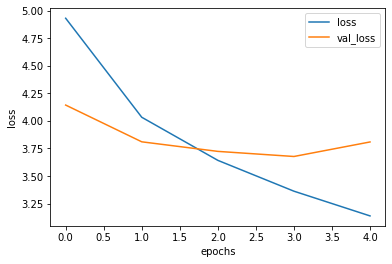

In [ ]:
for label in ["loss", "val_loss"]:
    plt.plot(model_training.history[label], label = label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## 8. SAVING FILES AND MODELS

In [ ]:
rnn_model.save("RNN_Model.h5")
cnn_model.save("CNN_Model.h5")
dump(tokenizer, open('Flickr8K_Tokenizer.p', 'wb'))


## 9. PREDICTION & PERFORMANCE ANALYSIS

In [ ]:
def generate_caption(filename):
    img = load_img(filename, target_size = (299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = cnn_model.predict(img)
    in_text = 'startseq'
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = rnn_model.predict([features,sequence], verbose=0)
        pred = np.argmax(pred)
        word = index_to_word[pred]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
def generate_caption_beam_search(filename, max_length, beam_index):
    img = load_img(filename, target_size = (299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = cnn_model.predict(img)
    in_text = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]
    while len(in_text[0][0]) < max_length:
        tempList = []
        for seq in in_text:
            padded_seq = pad_sequences([seq[0]], maxlen=max_length)
            preds = rnn_model.predict([features,padded_seq], verbose=0)
            top_preds = np.argsort(preds[0])[-beam_index:]
            for word in top_preds:
                next_seq, prob = seq[0][:], seq[1]
                next_seq.append(word)
                prob += preds[0][word]
                tempList.append([next_seq, prob])
        in_text = tempList
        in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
        in_text = in_text[-beam_index:]
    in_text = in_text[-1][0]
    final_caption_raw = [index_to_word[i] for i in in_text]
    final_caption = []
    for word in final_caption_raw:
        if word == 'endseq':
            break
        else:
            final_caption.append(word)
    final_caption.append('endseq')
    return ' '.join(final_caption)

1/1 [==============================] - 0s 256ms/step


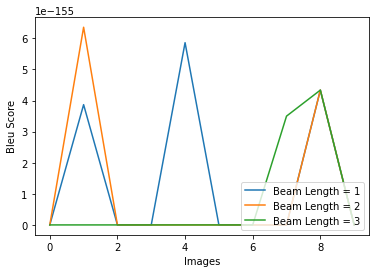

In [ ]:
scores, beam2_scores, beam3_scores = [], [], []
for img, caption in zip(test_images, test_captions):
    hypothesis = generate_caption('/content/Flicker8k_Dataset/' + img + ".jpg")
    scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    hypothesis = generate_caption_beam_search('/content/Flicker8k_Dataset/' + img + ".jpg", max_len, 2)
    beam2_scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    hypothesis = generate_caption_beam_search('/content/Flicker8k_Dataset/' + img + ".jpg", max_len, 3)
    beam3_scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    
for i, score in enumerate([scores, beam2_scores, beam3_scores]):
    plt.plot(score, label = 'Beam Length = ' + str(i+1))
plt.legend(loc = 'lower right')
plt.xlabel('Images')
plt.ylabel('Bleu Score')
plt.show()

1/1 [==============================] - 0s 265ms/step


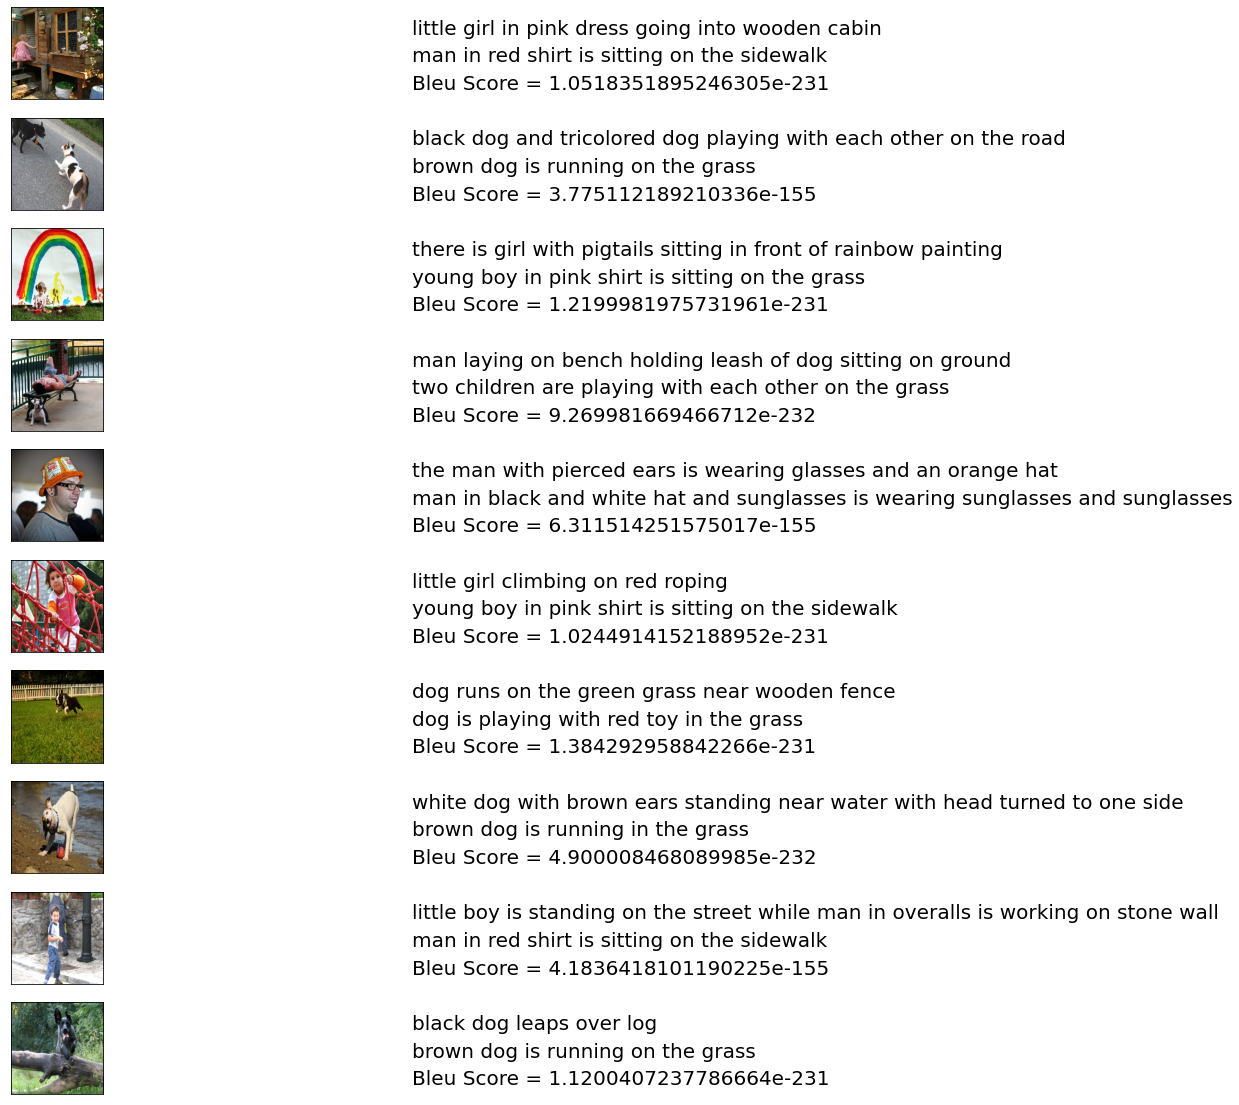

In [ ]:
npic = 10
npix = 299
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(20,20))
for img, true_caption in zip(test_images, test_captions):
     
    filename = '/content/Flicker8k_Dataset/' + img + ".jpg"
    image_load = load_img(filename, target_size = target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    true_caption = ' '.join(true_caption.split()[1: -1])
    ax.imshow(image_load)
    count += 1

    caption = generate_caption(filename)
    caption = ' '.join(caption.split()[1: -1])
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0, 0.7, true_caption, fontsize = 20)
    ax.text(0, 0.4, caption, fontsize = 20)
    ax.text(0, 0.1, 'Bleu Score = {}'.format(sentence_bleu([true_caption.split()], caption.split())), fontsize = 20)
    count += 1

plt.show()